**2021/22**

# Binary classification
This lecture is about binary classification of discrete data.

Previously we have setup a ML pipeline to work with a linear regression algorithm. Now the focus is on binary classification in a discrete space. 

The dataset under consideration is from the domain of financial markets. As expected, we will be using Apache Spark MLlib.

# ML pipelines

In a prior notebook we have used pipelines to specify stages upon which data is submitted to for processing. But at the time we barely got into details. 

As stated in the Spark's programming guide, **"ML Pipelines provide a uniform set of high-level APIs built on top of DataFrames that help users create and tune practical machine learning pipelines."**

Hence, it is possible to combine multiple algorithms into a single pipeline, or workflow. Besides DataFrames, it involves the following:
1. Transformer: an algorithm which can transform one DataFrame into another DataFrame. For example, an ML model is a Transformer which transforms a DataFrame with features into a DataFrame with predictions.
2. Estimator: an algorithm which can be fit on a DataFrame to produce a Transformer. For example, a learning algorithm is an Estimator which trains on a DataFrame and produces a model.
3. Pipeline: the way to chain multiple Transformers and Estimators together to specify an ML workflow. 4. Parameter: all Transformers and Estimators share a common API for specifying parameters.
Further details can be found in http://spark.apache.org/docs/latest/ml-pipeline.html



Recall that, in general, a typical ML workflow is designed to work as depicted below:

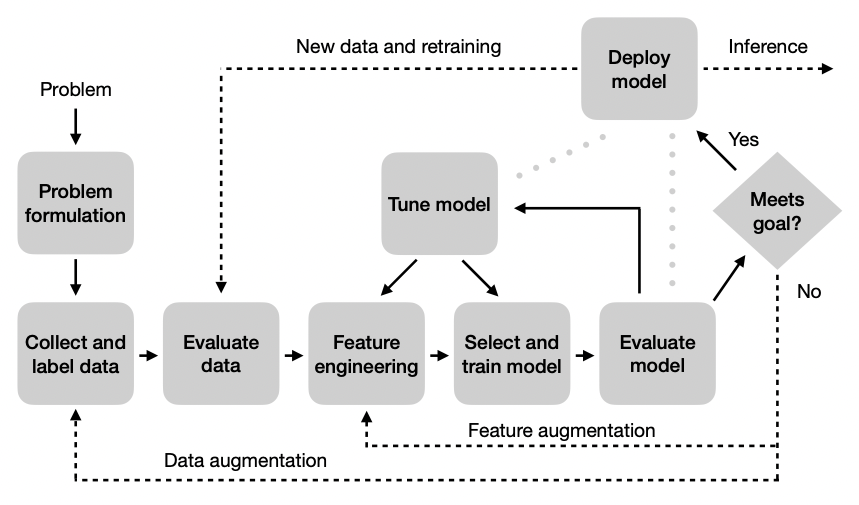

# Problem formulation

This exercise is about stock market prediction in the financial industry. Our case-study and dataset is based on a past Kaggle competition, which details can be found in https://www.kaggle.com/c/jane-street-market-prediction .

Obviously we are not going to create a complex quantitative trading system but just work on a tiny bit - to deciding whether a particular trade proposal is going to be accepted, so traded, or not. In the end, it is a binary classification problem.

Basically, the functional requirements for the Spark program we are about to create are as follows:
1. To load the dataset under analysis and making sure it can be further processed by a ML classifier.
2. To create a classification model supported by a SVM algorithm that is fit for the purpose.
3. For each day, to compute the daily score as the sum of the product **weight x resp** (see schema below)
of the trades the system opt to trade in that day. In that respect, the data to be processed is different from the one being used to create the model.

You can find the file dataset JaneStreetMarket.csv.zip in:


https://iscteiul365.sharepoint.com/:u:/s/G365_UC_AlgoritmosparaBigData/Ebj3nk6DLhZHpuoZFEeptqcB6wovOyeUgi72o7QLC-kBeQ?e=GHSn4C


**Context**

Financial markets are very complex. In such a fast-moving environment, electronic trading allows for thousands of transactions to occur within a fraction of a second, and so providing many opportunities to find and take advantage of price differences in real-time.
In an efficient market, buyers and sellers would have all the information they need to make rational decisions. As result, products remain at fair values, not undervalued nor overpriced. But in the real world, markets do not work like that.

Developing trading strategies to identify and take advantage of inefficiencies is challenging. Even if a strategy is profitable at some point in time, it may not be in the future, and market volatility makes it impossible to predict the profitability of any given trade with certainty. It is hard to distinguish good luck from good trading decision.

Hence, the goal is to build a quantitative trading model to maximize returns using real time market data. Once the model faces trading opportunities electronically, it must decide whether to accept or reject them.
The all building process includes testing its predictiveness against future market returns, as well as checking against historical data, the so-called backtesting. There are a few more notes worth considering, namely:

- The development of good models is very challenging. For example, (i) we may collect too much noise from the market data, (ii) there will be redundancy in the information collected, (iiI) we may experience strong feature correlations, (iv) it is difficult to establish a proper mathematical formulation, etc.
- An highly predictive model, which selects the right trades to execute, will contribute to pushing prices closer to fair values, as it sends correct messages to the market.
- As more people are using this kind of strategies, the slimest advantage due to having good models will pay off.


**Market data**


The dataset we are going to use relates to the Kaggle competition mentioned above. It contains an anonymized set of features, feature_{0...129}, representing real stock market data features. For example, trading volume and volatility in various time horizons, statistical indicators like *Relative Strength Index (RSI)*, etc.

Each row in the dataset represents a trading opportunity, for which the system will be predicting an action value: 1 to make the trade or 0 to pass on it.
For each trade, there is an associated `weight` and `resp`: 
- The `weight` is the importance of the trade like for example a ratio of transaction cost or, in other words, the capital invested in the trade.
- The `resp` represents the return of the trade, and we can have additional returns over specific but not revealed time horizons. But what matters the most is `resp`.

The data also includes the day of the trade (as a number) and a value *ts_id* representing time ordering.


The **data schema** of the dataset is the following:

|Column     | Type| Description |
|:---:|:---:| :---:| 
| **date** |Integer| Day of the trade|
| **weight** | Double | The importante of the trade. When 0, it does not contribute for the score of the evaluation of the model, but it is included for the purpose of completeness |
| **resp_1** | Double | Value related to returns over time horizon 1 |
| **resp_2** | Double | Value related to returns over time horizon 2 |
| **resp_3**  | Double | Value related to returns over time horizon 3 |
| **resp_4** | Double | Value related to returns over time horizon 4 |
| **resp** | Double | Value e.g. returns |
| **feature_0** | Double  | Value of anonymized feature 0 |
| ... |  ... | Columns with features 1 to 128 |
| **feature_129** | Double |  Value of anonymized feature 129 |
| **ts_id** | Integer |  Time ordering |



In [ ]:
# If we need to install some packages, e.g. matplotlib

# ! pip3 install matplotlib
# ! pip3 install seaborn

In [67]:
# Some imports 

import os 
# !python3 -m pip install numpy
# !python3 -m pip install pandas
# !python3 -m pip install matplotlib.pyplot
# !python3 -m pip install seaborn
import numpy as np 
import pandas as pd  
import matplotlib.pyplot as plt
import seaborn as sns
import warnings

from pyspark.sql import SparkSession
from pyspark.sql.functions import *
from pyspark.sql.types import *

from pyspark.ml import Pipeline
from pyspark.ml.stat import Correlation, ChiSquareTest
from pyspark.ml.feature import VectorAssembler
from pyspark.ml.classification import LinearSVC
from pyspark.ml.evaluation import BinaryClassificationEvaluator

from pyspark.sql.functions import monotonically_increasing_id 
from pyspark.sql import SparkSession
from pyspark.sql.functions import *
from pyspark.sql.types import *
from pyspark.sql.functions import date_format
from pyspark.sql.functions import monotonically_increasing_id 

import matplotlib as mpl
import matplotlib.pyplot as plt
from datetime import datetime


from statsmodels.tsa.stattools import adfuller   ### unit root test
from statsmodels.tsa.seasonal import seasonal_decompose   ### seasonal decomposition
from statsmodels.tsa.arima_model import ARIMA   ### ARIMA model

import warnings
warnings.filterwarnings("ignore")


# Useful visualization functions

Some functions that we can use to plot data but as Python dataframes.

**Disclaimer**: these functions are broadly distributed among users. Further adjustments are needed and/or advisable. Feel free to use your own plotting functions.

In [68]:
def plotHistogram(df, xcol, huecol):
    sns.histplot(data=df, x=xcol, hue=huecol, multiple="stack")

In [69]:
def plot(df, xcol, ycol):
    sns.lineplot(data=df, x=xcol, y=ycol)

In [70]:
def plotScatter(df, xcol, ycol, huecol):
    sns.scatterplot(data=df, x=xcol, y=ycol, hue=huecol)

In [71]:
def plotScatterMatrix(df, huecol):
    sns.pairplot(data=df, hue=huecol)

In [72]:
def plotCorrelationMatrix1(df):
 # compute the correlation matrix
 corr = df.corr()
 # generate a mask for the upper triangle
 mask = np.triu(np.ones_like(corr, dtype=bool))
 # set up the matplotlib figure
 f, ax = plt.subplots(figsize=(11, 9))
 # generate a custom diverging colormap
 cmap = sns.diverging_palette(230, 20, as_cmap=True)
 # draw the heatmap with the mask and correct aspect ratio
 sns.heatmap(corr, mask=mask, cmap=cmap, vmax=.3, center=0,
 square=True, linewidths=.5, cbar_kws={"shrink": .5})

In [73]:
def plotCorrelationMatrix2(df):
 # compute a correlation matrix and convert to long-form
 corr_mat = df.corr().stack().reset_index(name="correlation")
 # draw each cell as a scatter point with varying size and color
 g = sns.relplot(
 data=corr_mat,
 x="level_0", y="level_1", hue="correlation", size="correlation",
 palette="vlag", hue_norm=(-1, 1), edgecolor=".7",
 height=10, sizes=(50, 250), size_norm=(-.2, .8),
 )
 # tweak the figure to finalize
 g.set(xlabel="", ylabel="", aspect="equal")
 g.despine(left=True, bottom=True)
 g.ax.margins(.02)
 for label in g.ax.get_xticklabels():
    label.set_rotation(90)
 for artist in g.legend.legendHandles:
    artist.set_edgecolor(".7")

# Collect and label data

## Data ingestion

In [ ]:
# Build a SparkSession instance if one does not exist. Notice that we can only have one per JVM

spark = SparkSession\
    .builder\
    .appName("Xetra")\
    .getOrCreate()

In [ ]:
! pwd 
! ls -la

In [ ]:
local_data_folder = 'deutsche-boerse-xetra-pds'

In [ ]:
local_data_folder

In [ ]:
# Reading all files
# read all data

df_raw = spark.read.load(local_data_folder, 
                         format="csv", 
                         header=True, 
                         pathGlobFilter="*.csv",
                         recursiveFileLookup=True,
                        )

In [ ]:
df_unprocessed = df_raw 
df_unprocessed.show(1, vertical=True, truncate=False)
df_unprocessed.printSchema()

## Columns to keep & normalization

In [ ]:
# some pre processing, parsing data and time from string to data and time proper format and adding an index

df_unprocessed = df_unprocessed.withColumn("CalcTime", to_timestamp('Time')) \
    .withColumn("CalcDateTime", to_date("Date"))
# .withColumn("id", monotonically_increasing_id())
# df_ra['CalcDateTime'] = df_raw.df_raw.withColumn("Date", to_date("Date")).astype('date')

df_unprocessed.show(2, vertical=True, truncate=False)
df_unprocessed.printSchema()


In [ ]:
only_common_stock.select('*').count()

In [ ]:
print(f'{(72399794/98240766)*100}%')
print(f'{73.69628408638425-100}')

In [ ]:
only_common_stock.select('*').count()

In [ ]:
print(f'{(66667577/72399794)*100}') # this is the percentage of data after removing transactions after closing hour
# it has been moved downwards

In [ ]:
only_common_stock.show(1, vertical=True, truncate=False)

### Converting some column's types

In [ ]:
df_preprocessed = df_unprocessed.withColumn("StartPrice", col("StartPrice").cast("double"))\
.withColumn("MaxPrice", col("MaxPrice").cast("double"))\
.withColumn("MinPrice", col("MinPrice").cast("double"))\
.withColumn("EndPrice", col("EndPrice").cast("double"))\
.withColumn("TradedVolume", col("TradedVolume").cast("double"))\
.withColumn("NumberOfTrades", col("NumberOfTrades").cast("double"))

In [ ]:
df_preprocessed.printSchema()

In [ ]:
df_preprocessed.show(3, vertical=True)

It seems there are no reasons to drop any column.

# Evaluate data

Let us get some data insight, with some exploratory data analysis based on descriptive statistics and visualizations.

In [ ]:
# Check some column statistics, one by one.
# Leave aside those that are named like "feature_nn"

for cl in df_preprocessed.columns:
    if not 'feature' in cl:
        df_raw.describe(cl).show()


Following previous understanding, all collected data should be considered as of interest.

# Feature Engineering

Now we have to prepare data in a way that it can be properly used by ML algorithms, which includes selection and extraction of features, as well as dealing with poor data quality if that is the case.

As we can see, all columns are numeric. Furthermore, data types are OK.

## Data cleasing

We will look at
* Nulls
* Extreme values e.g. outliers

In [ ]:
# df_preprocessed.first()
last_ones = df_preprocessed.withColumn("index", monotonically_increasing_id())
last_ones.orderBy(desc("index")).drop("index").show(5)

In [ ]:
df_preprocessed.select("*").filter("Time >='20:00' OR Time < '07:00' AND TradedVolume > 0.0").show(5, vertical=True)

In [ ]:
# Nulls: if needed, the brute-force solution: remove rows where at least one of the columns is null or NaN value

# checking the sizes, just to make sure we can move on
# [df_preprocessed.count(), df_preprocessed.dropna().count()]

# Only keep common stock securities for analysis
only_common_stock = df_preprocessed.select("*").filter("SecurityType == 'Common stock'")

# Keep only data points with trades between the opening and closing hours because traded values are 0 before and after 
only_common_stock = only_common_stock.select("*").filter("Time <= '20:00' AND Time >= '08:00' AND TradedVolume > 0.0")


In [ ]:
# https://www.analyticsvidhya.com/blog/2022/01/apache-spark-and-facebook-prophet/
print('Features: ', only_common_stock.columns)
# print('Any missing values: ', only_common_stock.isnull().any())
# print('Unique values: ', only_common_stock.unique())

In [ ]:
only_common_stock.show(1, vertical=True, truncate=False)

In [ ]:
# Outliers: for that, we use summary(), one column by one

for cl in only_common_stock.columns:
    only_common_stock.select(cl).summary().show()

No nulls. Fine. And in respect to outliers, likewise there are no problems.

## Saving clean data

In [ ]:
# As we have a large dataset, we should also have a smaller one,
# just for the purpose of working locally, maybe starting 
# from the begining (as it is sorted by timing)

small_num_rows = df_raw.select("date").filter("date <= 50").count()
# 300000 # out of 2 390 491 
df_small = df_raw.limit(small_num_rows)
small_num_rows

In [ ]:
# Save the smaller version to a file for future use in case of need

df_small.write.mode("overwrite").parquet("small-clean-janestreetmarket")

# and later on, we can use spark.read.parquet() to load files

In [ ]:
# Also, although no changes were made to the initial dataset, 
# it may be convenient to have the original data stored in 
# the parquet format as well. It will be the normal dataset

df_raw.write.mode("overwrite").parquet("clean-janestreetmarket")

In [ ]:
# Check in the running directory if that was accomplished

! ls -la

In [ ]:
! ls -la small-clean-janestreetmarket

In [ ]:
! ls -la clean-janestreetmarket

## Data to be used hereafter

In [ ]:
# df_clean = 
df_clean = df_clean = only_common_stock

In [ ]:
# Delete memory consuming variables that are no longer needed

del df_raw, df_unprocessed

## Final  overview
After establishing the clean data to be used, let us get an overview about what we have achieved, with some statistics and visualizations.

In [ ]:
# Particular columns to check

# cls1 = ["resp_1", "resp_2", "resp_3", "resp_4", "resp"]
# cls2 = ["date", "weight", "ts_id"]
# cls3 = ["date", "weight", "resp_1", "resp_2", "resp_3", "resp_4", "resp", "ts_id" ]  # non feature_nn
# Particular columns to check

cls1 = ["StartPrice", "MinPrice", "MaxPrice", "EndPrice", "TradedVolume", "Mnemonic"]
cls2 = ["CalcDateTime", "TradedVolume"]
cls3 = ["StartPrice", "MinPrice", "MaxPrice", "EndPrice", "TradedVolume", "CalcDateTime"]



### Descriptive statistics

In [ ]:
# Describe

df_clean.describe(cls1).show()
df_clean.describe(cls2).show()

In [ ]:
# Summary

for cl in cls1:
    df_clean.select(cl).summary().show()
for cl in cls2:
    df_clean.select(cl).summary().show()
    

### Correlations

In [99]:
df_cor = df_clean.select("StartPrice", "MinPrice", "MaxPrice", "EndPrice", "TradedVolume")

In [ ]:
from pyspark.ml.stat import Correlation
from pyspark.ml.feature import VectorAssembler

# convert to vector column first
vector_col = "corr_features"
assembler = VectorAssembler(inputCols=df_cor.columns, outputCol=vector_col)
df_vector = assembler.transform(df_cor).select(vector_col)

# get correlation matrix
matrix = Correlation.corr(df_vector, vector_col)

In [ ]:
matrix = Correlation.corr(df_vector, vector_col).collect()[0][0]
corrmatrix = matrix.toArray().tolist()
# print(corrmatrix)

In [ ]:
df_correlation = spark.createDataFrame(corrmatrix, df_cor.columns)
df_correlation.show()

In [ ]:
# Just for visualization purposes, convert to Pandas 

# df_plot = pd.DataFrame(data = corrmatrix, index=cols_corr, columns=cols_corr)
df_plot = pd.DataFrame(data = corrmatrix, index=df_cor.columns, columns=df_cor.columns)

In [ ]:
# a plot 
plotCorrelationMatrix1(df_plot)

In [ ]:
d = df_clean.select("StartPrice", "MinPrice", "MaxPrice", "EndPrice", "TradedVolume")
d.plot.line() 

### Daily averages
To put into context, it also seems sensible to look at daily averages, since in most of the days the intra-day behaviour does not change that much, relatively speaking.

### Checking which mnemonic has the most amount of records to use for visualization purposes

In [ ]:
df_bmw = df_clean.select("*").filter("Mnemonic=='BMW'")

In [ ]:
df_bmw.count()

In [ ]:
df_bmw = df_bmw.toPandas()

### The BMW Mnemonic will be used hereforth as a sample

In [ ]:
df_bmw.head()

In [ ]:
# check how many data entries are missing
df_bmw.isnull().value_counts()

In [ ]:
# plot histogram, to observe if there are outliers
df_bmw.hist(color="yellowgreen")

plt.show()

In [ ]:
mpl.rcParams['figure.figsize'] = (15, 10) # use bigger graphs
def timeseries_plot(df, mnemonics, metrics):
    ax = None
    for mnemonic in mnemonics:
        for metric in metrics:
            selected = df[df.Mnemonic == mnemonic][['CalcDateTime', metric]].copy()
            selected.index = selected['CalcDateTime']
            selected = selected.sort_index()
            del selected['CalcDateTime']
            ax = selected.plot( ax = ax)
    
timeseries_plot(df_bmw, ['BMW'], ['MinPrice', 'MaxPrice', 'StartPrice', 'EndPrice']) 

In [ ]:
timeseries_plot(df_bmw, ['BMW'], ['StartPrice', 'EndPrice']) 

In [ ]:
timeseries_plot(df_bmw, ['BMW'], ['TradedVolume']) 

In [ ]:
timeseries_plot(df_bmw, ['BMW'], ['NumberOfTrades'])

In [ ]:
from pyspark.mllib.linalg import Vectors
def transData(data):
    return data.rdd.map(lambda r: [Vectors.dense(r[:-1])]).toDF(['features'])

In [75]:
transformed= transData(dataset)
transformed.show(5, False)

+-------------------------+
|features                 |
+-------------------------+
|[29.78,29.5,30.02,29.5]  |
|[15.0,14.94,15.02,14.99] |
|[2.305,2.287,2.309,2.305]|
|[13.97,13.95,14.01,13.95]|
|[22.69,22.61,23.1,23.06] |
+-------------------------+
only showing top 5 rows



In [ ]:
from pyspark.ml.clustering import LDA
lda = LDA(k=10, maxIter=10)
model = lda.fit(df_vector)


In [78]:
from pyspark.ml import Pipeline
from pyspark.ml.regression import LinearRegression
from pyspark.ml.feature import VectorIndexer
from pyspark.ml.evaluation import RegressionEvaluator

# Automatically identify categorical features, and index them.
# We specify maxCategories so features with > 4 distinct values are treated as continuous.

featureIndexer = VectorIndexer(inputCol="corr_features", \
                               outputCol="indexedFeatures",\
                               maxCategories=4).fit(df_vector)

data = featureIndexer.transform(df_vector)

In [80]:
data.show(5,vertical=True)

-RECORD 0-------------------------------
 corr_features   | [29.78,29.5,30.02... 
 indexedFeatures | [29.78,29.5,30.02... 
-RECORD 1-------------------------------
 corr_features   | [15.0,14.94,15.02... 
 indexedFeatures | [15.0,14.94,15.02... 
-RECORD 2-------------------------------
 corr_features   | [2.305,2.287,2.30... 
 indexedFeatures | [2.305,2.287,2.30... 
-RECORD 3-------------------------------
 corr_features   | [13.97,13.95,14.0... 
 indexedFeatures | [13.97,13.95,14.0... 
-RECORD 4-------------------------------
 corr_features   | [22.69,22.61,23.1... 
 indexedFeatures | [22.69,22.61,23.1... 
only showing top 5 rows



In [81]:
import numpy as np
cost = np.zeros(20)
for k in range(2,20):
    kmeans = KMeans()\
            .setK(k)\
            .setSeed(1) \
            .setFeaturesCol("indexedFeatures")\
            .setPredictionCol("cluster")

    model = kmeans.fit(data)
#     cost[k] = model.computeCost(data) # requires Spark 2.0 or later


22/05/14 17:43:53 WARN MemoryStore: Not enough space to cache rdd_167_12 in memory! (computed 19.5 MiB so far)
22/05/14 17:43:53 WARN BlockManager: Persisting block rdd_167_12 to disk instead.
22/05/14 17:43:53 WARN MemoryStore: Not enough space to cache rdd_167_13 in memory! (computed 19.5 MiB so far)
22/05/14 17:43:53 WARN BlockManager: Persisting block rdd_167_13 to disk instead.
22/05/14 17:43:55 WARN MemoryStore: Not enough space to cache rdd_167_13 in memory! (computed 19.5 MiB so far)
22/05/14 17:43:56 WARN MemoryStore: Not enough space to cache rdd_167_18 in memory! (computed 3.8 MiB so far)
22/05/14 17:43:56 WARN BlockManager: Persisting block rdd_167_18 to disk instead.
22/05/14 17:43:57 WARN MemoryStore: Not enough space to cache rdd_167_16 in memory! (computed 5.7 MiB so far)
22/05/14 17:43:57 WARN BlockManager: Persisting block rdd_167_16 to disk instead.
22/05/14 17:43:58 WARN MemoryStore: Not enough space to cache rdd_167_19 in memory! (computed 8.6 MiB so far)
22/05/14 

22/05/14 17:44:36 WARN MemoryStore: Not enough space to cache rdd_167_40 in memory! (computed 1540.0 KiB so far)
22/05/14 17:44:36 WARN BlockManager: Persisting block rdd_167_40 to disk instead.
22/05/14 17:44:36 WARN MemoryStore: Failed to reserve initial memory threshold of 1024.0 KiB for computing block rdd_167_38 in memory.
22/05/14 17:44:36 WARN MemoryStore: Not enough space to cache rdd_167_38 in memory! (computed 384.0 B so far)
22/05/14 17:44:37 WARN MemoryStore: Failed to reserve initial memory threshold of 1024.0 KiB for computing block rdd_167_42 in memory.
22/05/14 17:44:37 WARN MemoryStore: Not enough space to cache rdd_167_42 in memory! (computed 384.0 B so far)
22/05/14 17:44:37 WARN BlockManager: Persisting block rdd_167_42 to disk instead.
22/05/14 17:44:37 WARN MemoryStore: Failed to reserve initial memory threshold of 1024.0 KiB for computing block rdd_167_39 in memory.
22/05/14 17:44:37 WARN MemoryStore: Not enough space to cache rdd_167_39 in memory! (computed 384.

22/05/14 17:45:14 WARN MemoryStore: Not enough space to cache rdd_167_60 in memory! (computed 2.3 MiB so far)
22/05/14 17:45:14 WARN MemoryStore: Not enough space to cache rdd_167_61 in memory! (computed 3.8 MiB so far)
22/05/14 17:45:15 WARN MemoryStore: Not enough space to cache rdd_167_65 in memory! (computed 1540.0 KiB so far)
22/05/14 17:45:15 WARN BlockManager: Persisting block rdd_167_65 to disk instead.
22/05/14 17:45:15 WARN MemoryStore: Failed to reserve initial memory threshold of 1024.0 KiB for computing block rdd_167_62 in memory.
22/05/14 17:45:15 WARN MemoryStore: Not enough space to cache rdd_167_62 in memory! (computed 384.0 B so far)
22/05/14 17:45:16 WARN MemoryStore: Not enough space to cache rdd_167_64 in memory! (computed 3.8 MiB so far)
22/05/14 17:45:16 WARN BlockManager: Persisting block rdd_167_64 to disk instead.
22/05/14 17:45:16 WARN MemoryStore: Failed to reserve initial memory threshold of 1024.0 KiB for computing block rdd_167_66 in memory.
22/05/14 17:4

22/05/14 17:45:48 WARN MemoryStore: Not enough space to cache rdd_167_87 in memory! (computed 3.8 MiB so far)
22/05/14 17:45:48 WARN BlockManager: Persisting block rdd_167_87 to disk instead.
22/05/14 17:45:50 WARN MemoryStore: Not enough space to cache rdd_167_84 in memory! (computed 3.8 MiB so far)
22/05/14 17:45:51 WARN MemoryStore: Not enough space to cache rdd_167_85 in memory! (computed 2.3 MiB so far)
22/05/14 17:45:51 WARN MemoryStore: Failed to reserve initial memory threshold of 1024.0 KiB for computing block rdd_167_89 in memory.
22/05/14 17:45:51 WARN MemoryStore: Not enough space to cache rdd_167_89 in memory! (computed 384.0 B so far)
22/05/14 17:45:51 WARN BlockManager: Persisting block rdd_167_89 to disk instead.
22/05/14 17:45:51 WARN MemoryStore: Failed to reserve initial memory threshold of 1024.0 KiB for computing block rdd_167_86 in memory.
22/05/14 17:45:51 WARN MemoryStore: Not enough space to cache rdd_167_86 in memory! (computed 384.0 B so far)
22/05/14 17:45:5

22/05/14 17:46:21 WARN MemoryStore: Not enough space to cache rdd_167_109 in memory! (computed 2.3 MiB so far)
22/05/14 17:46:21 WARN BlockManager: Persisting block rdd_167_109 to disk instead.
22/05/14 17:46:22 WARN MemoryStore: Not enough space to cache rdd_167_110 in memory! (computed 3.8 MiB so far)
22/05/14 17:46:22 WARN BlockManager: Persisting block rdd_167_110 to disk instead.
22/05/14 17:46:23 WARN MemoryStore: Not enough space to cache rdd_167_107 in memory! (computed 3.8 MiB so far)
22/05/14 17:46:24 WARN MemoryStore: Not enough space to cache rdd_167_111 in memory! (computed 3.8 MiB so far)
22/05/14 17:46:24 WARN BlockManager: Persisting block rdd_167_111 to disk instead.
22/05/14 17:46:25 WARN MemoryStore: Not enough space to cache rdd_167_108 in memory! (computed 3.8 MiB so far)
22/05/14 17:46:26 WARN MemoryStore: Failed to reserve initial memory threshold of 1024.0 KiB for computing block rdd_167_109 in memory.
22/05/14 17:46:26 WARN MemoryStore: Not enough space to cach

22/05/14 17:46:55 WARN MemoryStore: Not enough space to cache rdd_167_134 in memory! (computed 3.8 MiB so far)
22/05/14 17:46:55 WARN BlockManager: Persisting block rdd_167_134 to disk instead.
22/05/14 17:46:57 WARN MemoryStore: Not enough space to cache rdd_167_131 in memory! (computed 3.8 MiB so far)
22/05/14 17:46:58 WARN MemoryStore: Failed to reserve initial memory threshold of 1024.0 KiB for computing block rdd_167_132 in memory.
22/05/14 17:46:58 WARN MemoryStore: Not enough space to cache rdd_167_132 in memory! (computed 384.0 B so far)
22/05/14 17:46:58 WARN MemoryStore: Failed to reserve initial memory threshold of 1024.0 KiB for computing block rdd_167_136 in memory.
22/05/14 17:46:58 WARN MemoryStore: Not enough space to cache rdd_167_136 in memory! (computed 384.0 B so far)
22/05/14 17:46:58 WARN BlockManager: Persisting block rdd_167_136 to disk instead.
22/05/14 17:46:58 WARN MemoryStore: Not enough space to cache rdd_167_135 in memory! (computed 3.8 MiB so far)
22/05/1

22/05/14 17:47:29 WARN MemoryStore: Not enough space to cache rdd_167_154 in memory! (computed 3.8 MiB so far)
22/05/14 17:47:30 WARN MemoryStore: Not enough space to cache rdd_167_158 in memory! (computed 3.8 MiB so far)
22/05/14 17:47:30 WARN BlockManager: Persisting block rdd_167_158 to disk instead.
22/05/14 17:47:33 WARN MemoryStore: Not enough space to cache rdd_167_155 in memory! (computed 3.8 MiB so far)
22/05/14 17:47:33 WARN MemoryStore: Not enough space to cache rdd_167_156 in memory! (computed 2.3 MiB so far)
22/05/14 17:47:34 WARN MemoryStore: Not enough space to cache rdd_167_159 in memory! (computed 2.3 MiB so far)
22/05/14 17:47:34 WARN BlockManager: Persisting block rdd_167_159 to disk instead.
22/05/14 17:47:34 WARN MemoryStore: Not enough space to cache rdd_167_160 in memory! (computed 2.3 MiB so far)
22/05/14 17:47:34 WARN BlockManager: Persisting block rdd_167_160 to disk instead.
22/05/14 17:47:34 WARN MemoryStore: Not enough space to cache rdd_167_157 in memory! 

22/05/14 17:48:06 WARN MemoryStore: Not enough space to cache rdd_167_182 in memory! (computed 3.8 MiB so far)
22/05/14 17:48:06 WARN BlockManager: Persisting block rdd_167_182 to disk instead.
22/05/14 17:48:08 WARN MemoryStore: Not enough space to cache rdd_167_179 in memory! (computed 3.8 MiB so far)
22/05/14 17:48:08 WARN MemoryStore: Not enough space to cache rdd_167_180 in memory! (computed 3.8 MiB so far)
22/05/14 17:48:08 WARN MemoryStore: Not enough space to cache rdd_167_181 in memory! (computed 2.3 MiB so far)
22/05/14 17:48:09 WARN MemoryStore: Failed to reserve initial memory threshold of 1024.0 KiB for computing block rdd_167_185 in memory.
22/05/14 17:48:09 WARN MemoryStore: Not enough space to cache rdd_167_185 in memory! (computed 384.0 B so far)
22/05/14 17:48:09 WARN BlockManager: Persisting block rdd_167_185 to disk instead.
22/05/14 17:48:09 WARN MemoryStore: Not enough space to cache rdd_167_183 in memory! (computed 2.3 MiB so far)
22/05/14 17:48:09 WARN BlockMana

22/05/14 17:48:40 WARN MemoryStore: Not enough space to cache rdd_167_203 in memory! (computed 3.8 MiB so far)
22/05/14 17:48:41 WARN MemoryStore: Failed to reserve initial memory threshold of 1024.0 KiB for computing block rdd_167_207 in memory.
22/05/14 17:48:41 WARN MemoryStore: Not enough space to cache rdd_167_204 in memory! (computed 3.8 MiB so far)
22/05/14 17:48:41 WARN MemoryStore: Not enough space to cache rdd_167_207 in memory! (computed 384.0 B so far)
22/05/14 17:48:41 WARN BlockManager: Persisting block rdd_167_207 to disk instead.
22/05/14 17:48:41 WARN MemoryStore: Not enough space to cache rdd_167_205 in memory! (computed 3.8 MiB so far)
22/05/14 17:48:41 WARN MemoryStore: Failed to reserve initial memory threshold of 1024.0 KiB for computing block rdd_167_208 in memory.
22/05/14 17:48:41 WARN MemoryStore: Not enough space to cache rdd_167_208 in memory! (computed 384.0 B so far)
22/05/14 17:48:41 WARN BlockManager: Persisting block rdd_167_208 to disk instead.
22/05/1

22/05/14 17:49:13 WARN MemoryStore: Failed to reserve initial memory threshold of 1024.0 KiB for computing block rdd_167_231 in memory.
22/05/14 17:49:13 WARN MemoryStore: Not enough space to cache rdd_167_231 in memory! (computed 384.0 B so far)
22/05/14 17:49:13 WARN BlockManager: Persisting block rdd_167_231 to disk instead.
22/05/14 17:49:13 WARN MemoryStore: Not enough space to cache rdd_167_228 in memory! (computed 3.8 MiB so far)
22/05/14 17:49:14 WARN MemoryStore: Not enough space to cache rdd_167_233 in memory! (computed 1540.0 KiB so far)
22/05/14 17:49:14 WARN BlockManager: Persisting block rdd_167_233 to disk instead.
22/05/14 17:49:14 WARN MemoryStore: Not enough space to cache rdd_167_232 in memory! (computed 3.8 MiB so far)
22/05/14 17:49:14 WARN BlockManager: Persisting block rdd_167_232 to disk instead.
22/05/14 17:49:14 WARN MemoryStore: Not enough space to cache rdd_167_230 in memory! (computed 3.8 MiB so far)
22/05/14 17:49:16 WARN MemoryStore: Not enough space to c

22/05/14 17:49:41 WARN MemoryStore: Not enough space to cache rdd_167_254 in memory! (computed 3.8 MiB so far)
22/05/14 17:49:41 WARN BlockManager: Persisting block rdd_167_254 to disk instead.
22/05/14 17:49:43 WARN MemoryStore: Not enough space to cache rdd_167_251 in memory! (computed 3.8 MiB so far)
22/05/14 17:49:44 WARN MemoryStore: Not enough space to cache rdd_167_253 in memory! (computed 1540.0 KiB so far)
22/05/14 17:49:44 WARN MemoryStore: Not enough space to cache rdd_167_255 in memory! (computed 2.3 MiB so far)
22/05/14 17:49:44 WARN BlockManager: Persisting block rdd_167_255 to disk instead.
22/05/14 17:49:44 WARN MemoryStore: Not enough space to cache rdd_167_252 in memory! (computed 1540.0 KiB so far)
22/05/14 17:49:44 WARN MemoryStore: Not enough space to cache rdd_167_257 in memory! (computed 1540.0 KiB so far)
22/05/14 17:49:44 WARN BlockManager: Persisting block rdd_167_257 to disk instead.
22/05/14 17:49:45 WARN MemoryStore: Failed to reserve initial memory thresho

22/05/14 17:50:09 WARN MemoryStore: Not enough space to cache rdd_167_271 in memory! (computed 3.8 MiB so far)
22/05/14 17:50:09 WARN MemoryStore: Not enough space to cache rdd_167_272 in memory! (computed 1540.0 KiB so far)
22/05/14 17:50:10 WARN MemoryStore: Failed to reserve initial memory threshold of 1024.0 KiB for computing block rdd_167_276 in memory.
22/05/14 17:50:10 WARN MemoryStore: Not enough space to cache rdd_167_276 in memory! (computed 384.0 B so far)
22/05/14 17:50:10 WARN BlockManager: Persisting block rdd_167_276 to disk instead.
22/05/14 17:50:10 WARN MemoryStore: Not enough space to cache rdd_167_275 in memory! (computed 3.8 MiB so far)
22/05/14 17:50:10 WARN BlockManager: Persisting block rdd_167_275 to disk instead.
22/05/14 17:50:10 WARN MemoryStore: Not enough space to cache rdd_167_273 in memory! (computed 3.8 MiB so far)
22/05/14 17:50:11 WARN MemoryStore: Not enough space to cache rdd_167_274 in memory! (computed 2.3 MiB so far)
22/05/14 17:50:11 WARN Memory

22/05/14 17:50:36 WARN MemoryStore: Not enough space to cache rdd_167_294 in memory! (computed 1540.0 KiB so far)
22/05/14 17:50:36 WARN MemoryStore: Failed to reserve initial memory threshold of 1024.0 KiB for computing block rdd_167_298 in memory.
22/05/14 17:50:36 WARN MemoryStore: Not enough space to cache rdd_167_298 in memory! (computed 384.0 B so far)
22/05/14 17:50:36 WARN BlockManager: Persisting block rdd_167_298 to disk instead.
22/05/14 17:50:36 WARN MemoryStore: Not enough space to cache rdd_167_297 in memory! (computed 3.8 MiB so far)
22/05/14 17:50:36 WARN BlockManager: Persisting block rdd_167_297 to disk instead.
22/05/14 17:50:39 WARN MemoryStore: Not enough space to cache rdd_167_295 in memory! (computed 3.8 MiB so far)
22/05/14 17:50:39 WARN MemoryStore: Not enough space to cache rdd_167_296 in memory! (computed 2.3 MiB so far)
22/05/14 17:50:40 WARN MemoryStore: Not enough space to cache rdd_167_299 in memory! (computed 2.3 MiB so far)
22/05/14 17:50:40 WARN BlockM

22/05/14 17:51:09 WARN MemoryStore: Not enough space to cache rdd_167_320 in memory! (computed 1026.1 KiB so far)
22/05/14 17:51:09 WARN BlockManager: Persisting block rdd_167_320 to disk instead.
22/05/14 17:51:09 WARN MemoryStore: Not enough space to cache rdd_167_321 in memory! (computed 1540.0 KiB so far)
22/05/14 17:51:09 WARN BlockManager: Persisting block rdd_167_321 to disk instead.
22/05/14 17:51:09 WARN MemoryStore: Not enough space to cache rdd_167_319 in memory! (computed 3.8 MiB so far)
22/05/14 17:51:09 WARN BlockManager: Persisting block rdd_167_319 to disk instead.
22/05/14 17:51:11 WARN MemoryStore: Not enough space to cache rdd_167_318 in memory! (computed 3.8 MiB so far)
22/05/14 17:51:12 WARN MemoryStore: Not enough space to cache rdd_167_322 in memory! (computed 3.8 MiB so far)
22/05/14 17:51:12 WARN BlockManager: Persisting block rdd_167_322 to disk instead.
22/05/14 17:51:13 WARN MemoryStore: Not enough space to cache rdd_167_319 in memory! (computed 3.8 MiB so f

22/05/14 17:51:39 WARN MemoryStore: Not enough space to cache rdd_167_345 in memory! (computed 3.8 MiB so far)
22/05/14 17:51:39 WARN BlockManager: Persisting block rdd_167_345 to disk instead.
22/05/14 17:51:40 WARN MemoryStore: Not enough space to cache rdd_167_342 in memory! (computed 3.8 MiB so far)
22/05/14 17:51:42 WARN MemoryStore: Not enough space to cache rdd_167_346 in memory! (computed 3.8 MiB so far)
22/05/14 17:51:42 WARN BlockManager: Persisting block rdd_167_346 to disk instead.
22/05/14 17:51:43 WARN MemoryStore: Not enough space to cache rdd_167_343 in memory! (computed 3.8 MiB so far)
22/05/14 17:51:43 WARN MemoryStore: Not enough space to cache rdd_167_344 in memory! (computed 3.8 MiB so far)
22/05/14 17:51:43 WARN MemoryStore: Not enough space to cache rdd_167_345 in memory! (computed 1026.1 KiB so far)
22/05/14 17:51:43 WARN MemoryStore: Not enough space to cache rdd_167_348 in memory! (computed 1540.0 KiB so far)
22/05/14 17:51:43 WARN BlockManager: Persisting blo

22/05/14 17:52:11 WARN MemoryStore: Not enough space to cache rdd_167_370 in memory! (computed 3.8 MiB so far)
22/05/14 17:52:11 WARN BlockManager: Persisting block rdd_167_370 to disk instead.
22/05/14 17:52:11 WARN MemoryStore: Not enough space to cache rdd_167_367 in memory! (computed 3.8 MiB so far)
22/05/14 17:52:11 WARN MemoryStore: Not enough space to cache rdd_167_368 in memory! (computed 3.8 MiB so far)
22/05/14 17:52:12 WARN MemoryStore: Not enough space to cache rdd_167_369 in memory! (computed 1540.0 KiB so far)
22/05/14 17:52:12 WARN MemoryStore: Failed to reserve initial memory threshold of 1024.0 KiB for computing block rdd_167_373 in memory.
22/05/14 17:52:12 WARN MemoryStore: Not enough space to cache rdd_167_373 in memory! (computed 384.0 B so far)
22/05/14 17:52:12 WARN BlockManager: Persisting block rdd_167_373 to disk instead.
22/05/14 17:52:12 WARN MemoryStore: Not enough space to cache rdd_167_372 in memory! (computed 1540.0 KiB so far)
22/05/14 17:52:12 WARN Blo

22/05/14 17:52:41 WARN MemoryStore: Not enough space to cache rdd_167_393 in memory! (computed 1026.1 KiB so far)
22/05/14 17:52:41 WARN MemoryStore: Not enough space to cache rdd_167_395 in memory! (computed 1540.0 KiB so far)
22/05/14 17:52:41 WARN BlockManager: Persisting block rdd_167_395 to disk instead.
22/05/14 17:52:41 WARN MemoryStore: Not enough space to cache rdd_167_396 in memory! (computed 2.3 MiB so far)
22/05/14 17:52:41 WARN BlockManager: Persisting block rdd_167_396 to disk instead.
22/05/14 17:52:42 WARN MemoryStore: Not enough space to cache rdd_167_397 in memory! (computed 3.8 MiB so far)
22/05/14 17:52:42 WARN BlockManager: Persisting block rdd_167_397 to disk instead.
22/05/14 17:52:44 WARN MemoryStore: Not enough space to cache rdd_167_394 in memory! (computed 3.8 MiB so far)
22/05/14 17:52:45 WARN MemoryStore: Not enough space to cache rdd_167_398 in memory! (computed 3.8 MiB so far)
22/05/14 17:52:45 WARN BlockManager: Persisting block rdd_167_398 to disk inste

22/05/14 17:53:00 WARN MemoryStore: Not enough space to cache rdd_167_423 in memory! (computed 384.0 B so far)
22/05/14 17:53:00 WARN BlockManager: Persisting block rdd_167_423 to disk instead.
22/05/14 17:53:00 WARN MemoryStore: Failed to reserve initial memory threshold of 1024.0 KiB for computing block rdd_167_423 in memory.
22/05/14 17:53:00 WARN MemoryStore: Not enough space to cache rdd_167_423 in memory! (computed 384.0 B so far)
22/05/14 17:53:00 WARN MemoryStore: Not enough space to cache rdd_167_424 in memory! (computed 384.0 B so far)
22/05/14 17:53:00 WARN BlockManager: Persisting block rdd_167_424 to disk instead.
22/05/14 17:53:00 WARN MemoryStore: Failed to reserve initial memory threshold of 1024.0 KiB for computing block rdd_167_427 in memory.
22/05/14 17:53:00 WARN MemoryStore: Failed to reserve initial memory threshold of 1024.0 KiB for computing block rdd_167_424 in memory.
22/05/14 17:53:00 WARN MemoryStore: Not enough space to cache rdd_167_424 in memory! (compute

22/05/14 17:53:02 WARN MemoryStore: Not enough space to cache rdd_167_456 in memory! (computed 384.0 B so far)
22/05/14 17:53:02 WARN BlockManager: Persisting block rdd_167_456 to disk instead.
22/05/14 17:53:02 WARN MemoryStore: Failed to reserve initial memory threshold of 1024.0 KiB for computing block rdd_167_460 in memory.
22/05/14 17:53:02 WARN MemoryStore: Not enough space to cache rdd_167_457 in memory! (computed 384.0 B so far)
22/05/14 17:53:02 WARN BlockManager: Persisting block rdd_167_457 to disk instead.
22/05/14 17:53:02 WARN MemoryStore: Failed to reserve initial memory threshold of 1024.0 KiB for computing block rdd_167_457 in memory.
22/05/14 17:53:02 WARN MemoryStore: Not enough space to cache rdd_167_457 in memory! (computed 384.0 B so far)
22/05/14 17:53:02 WARN MemoryStore: Failed to reserve initial memory threshold of 1024.0 KiB for computing block rdd_167_461 in memory.
22/05/14 17:53:02 WARN MemoryStore: Not enough space to cache rdd_167_460 in memory! (compute

22/05/14 17:53:04 WARN MemoryStore: Not enough space to cache rdd_167_493 in memory! (computed 384.0 B so far)
22/05/14 17:53:04 WARN BlockManager: Persisting block rdd_167_493 to disk instead.
22/05/14 17:53:04 WARN MemoryStore: Not enough space to cache rdd_167_494 in memory! (computed 384.0 B so far)
22/05/14 17:53:04 WARN BlockManager: Persisting block rdd_167_494 to disk instead.
22/05/14 17:53:04 WARN MemoryStore: Failed to reserve initial memory threshold of 1024.0 KiB for computing block rdd_167_498 in memory.
22/05/14 17:53:04 WARN MemoryStore: Failed to reserve initial memory threshold of 1024.0 KiB for computing block rdd_167_496 in memory.
22/05/14 17:53:04 WARN MemoryStore: Not enough space to cache rdd_167_498 in memory! (computed 384.0 B so far)
22/05/14 17:53:04 WARN BlockManager: Persisting block rdd_167_498 to disk instead.
22/05/14 17:53:04 WARN MemoryStore: Failed to reserve initial memory threshold of 1024.0 KiB for computing block rdd_167_500 in memory.
22/05/14 1

22/05/14 17:53:07 WARN MemoryStore: Not enough space to cache rdd_167_528 in memory! (computed 384.0 B so far)
22/05/14 17:53:07 WARN BlockManager: Persisting block rdd_167_528 to disk instead.
22/05/14 17:53:07 WARN MemoryStore: Failed to reserve initial memory threshold of 1024.0 KiB for computing block rdd_167_528 in memory.
22/05/14 17:53:07 WARN MemoryStore: Not enough space to cache rdd_167_528 in memory! (computed 384.0 B so far)
22/05/14 17:53:07 WARN MemoryStore: Failed to reserve initial memory threshold of 1024.0 KiB for computing block rdd_167_532 in memory.
22/05/14 17:53:07 WARN MemoryStore: Not enough space to cache rdd_167_530 in memory! (computed 384.0 B so far)
22/05/14 17:53:07 WARN BlockManager: Persisting block rdd_167_530 to disk instead.
22/05/14 17:53:07 WARN MemoryStore: Failed to reserve initial memory threshold of 1024.0 KiB for computing block rdd_167_533 in memory.
22/05/14 17:53:07 WARN MemoryStore: Not enough space to cache rdd_167_532 in memory! (compute

22/05/14 17:53:09 WARN MemoryStore: Not enough space to cache rdd_167_566 in memory! (computed 384.0 B so far)
22/05/14 17:53:09 WARN BlockManager: Persisting block rdd_167_566 to disk instead.
22/05/14 17:53:09 WARN MemoryStore: Not enough space to cache rdd_167_565 in memory! (computed 384.0 B so far)
22/05/14 17:53:09 WARN BlockManager: Persisting block rdd_167_565 to disk instead.
22/05/14 17:53:09 WARN MemoryStore: Failed to reserve initial memory threshold of 1024.0 KiB for computing block rdd_167_569 in memory.
22/05/14 17:53:09 WARN MemoryStore: Failed to reserve initial memory threshold of 1024.0 KiB for computing block rdd_167_565 in memory.
22/05/14 17:53:09 WARN MemoryStore: Not enough space to cache rdd_167_565 in memory! (computed 384.0 B so far)
22/05/14 17:53:09 WARN MemoryStore: Failed to reserve initial memory threshold of 1024.0 KiB for computing block rdd_167_570 in memory.
22/05/14 17:53:09 WARN MemoryStore: Not enough space to cache rdd_167_569 in memory! (compute

22/05/14 17:53:11 WARN MemoryStore: Not enough space to cache rdd_167_597 in memory! (computed 384.0 B so far)
22/05/14 17:53:11 WARN BlockManager: Persisting block rdd_167_597 to disk instead.
22/05/14 17:53:11 WARN MemoryStore: Failed to reserve initial memory threshold of 1024.0 KiB for computing block rdd_167_597 in memory.
22/05/14 17:53:11 WARN MemoryStore: Not enough space to cache rdd_167_597 in memory! (computed 384.0 B so far)
22/05/14 17:53:11 WARN MemoryStore: Failed to reserve initial memory threshold of 1024.0 KiB for computing block rdd_167_601 in memory.
22/05/14 17:53:11 WARN MemoryStore: Not enough space to cache rdd_167_598 in memory! (computed 384.0 B so far)
22/05/14 17:53:11 WARN BlockManager: Persisting block rdd_167_598 to disk instead.
22/05/14 17:53:11 WARN MemoryStore: Failed to reserve initial memory threshold of 1024.0 KiB for computing block rdd_167_598 in memory.
22/05/14 17:53:11 WARN MemoryStore: Not enough space to cache rdd_167_598 in memory! (compute

22/05/14 17:53:13 WARN MemoryStore: Not enough space to cache rdd_167_629 in memory! (computed 384.0 B so far)
22/05/14 17:53:13 WARN BlockManager: Persisting block rdd_167_629 to disk instead.
22/05/14 17:53:13 WARN MemoryStore: Not enough space to cache rdd_167_630 in memory! (computed 384.0 B so far)
22/05/14 17:53:13 WARN BlockManager: Persisting block rdd_167_630 to disk instead.
22/05/14 17:53:13 WARN MemoryStore: Failed to reserve initial memory threshold of 1024.0 KiB for computing block rdd_167_629 in memory.
22/05/14 17:53:13 WARN MemoryStore: Not enough space to cache rdd_167_629 in memory! (computed 384.0 B so far)
22/05/14 17:53:13 WARN MemoryStore: Failed to reserve initial memory threshold of 1024.0 KiB for computing block rdd_167_630 in memory.
22/05/14 17:53:13 WARN MemoryStore: Not enough space to cache rdd_167_630 in memory! (computed 384.0 B so far)
22/05/14 17:53:13 WARN MemoryStore: Failed to reserve initial memory threshold of 1024.0 KiB for computing block rdd_1

22/05/14 17:53:16 WARN MemoryStore: Not enough space to cache rdd_167_661 in memory! (computed 384.0 B so far)
22/05/14 17:53:16 WARN BlockManager: Persisting block rdd_167_661 to disk instead.
22/05/14 17:53:16 WARN MemoryStore: Failed to reserve initial memory threshold of 1024.0 KiB for computing block rdd_167_661 in memory.
22/05/14 17:53:16 WARN MemoryStore: Not enough space to cache rdd_167_661 in memory! (computed 384.0 B so far)
22/05/14 17:53:16 WARN MemoryStore: Failed to reserve initial memory threshold of 1024.0 KiB for computing block rdd_167_666 in memory.
22/05/14 17:53:16 WARN MemoryStore: Not enough space to cache rdd_167_663 in memory! (computed 384.0 B so far)
22/05/14 17:53:16 WARN BlockManager: Persisting block rdd_167_663 to disk instead.
22/05/14 17:53:16 WARN MemoryStore: Failed to reserve initial memory threshold of 1024.0 KiB for computing block rdd_167_663 in memory.
22/05/14 17:53:16 WARN MemoryStore: Not enough space to cache rdd_167_663 in memory! (compute

22/05/14 17:53:18 WARN MemoryStore: Not enough space to cache rdd_167_694 in memory! (computed 384.0 B so far)
22/05/14 17:53:18 WARN BlockManager: Persisting block rdd_167_694 to disk instead.
22/05/14 17:53:18 WARN MemoryStore: Failed to reserve initial memory threshold of 1024.0 KiB for computing block rdd_167_698 in memory.
22/05/14 17:53:18 WARN MemoryStore: Not enough space to cache rdd_167_696 in memory! (computed 384.0 B so far)
22/05/14 17:53:18 WARN BlockManager: Persisting block rdd_167_696 to disk instead.
22/05/14 17:53:18 WARN MemoryStore: Failed to reserve initial memory threshold of 1024.0 KiB for computing block rdd_167_700 in memory.
22/05/14 17:53:18 WARN MemoryStore: Not enough space to cache rdd_167_698 in memory! (computed 384.0 B so far)
22/05/14 17:53:18 WARN BlockManager: Persisting block rdd_167_698 to disk instead.
22/05/14 17:53:18 WARN MemoryStore: Failed to reserve initial memory threshold of 1024.0 KiB for computing block rdd_167_702 in memory.
22/05/14 1

22/05/14 17:53:20 WARN MemoryStore: Not enough space to cache rdd_167_730 in memory! (computed 384.0 B so far)
22/05/14 17:53:20 WARN BlockManager: Persisting block rdd_167_730 to disk instead.
22/05/14 17:53:20 WARN MemoryStore: Failed to reserve initial memory threshold of 1024.0 KiB for computing block rdd_167_730 in memory.
22/05/14 17:53:20 WARN MemoryStore: Not enough space to cache rdd_167_730 in memory! (computed 384.0 B so far)
22/05/14 17:53:20 WARN MemoryStore: Failed to reserve initial memory threshold of 1024.0 KiB for computing block rdd_167_735 in memory.
22/05/14 17:53:20 WARN MemoryStore: Not enough space to cache rdd_167_732 in memory! (computed 384.0 B so far)
22/05/14 17:53:20 WARN BlockManager: Persisting block rdd_167_732 to disk instead.
22/05/14 17:53:20 WARN MemoryStore: Failed to reserve initial memory threshold of 1024.0 KiB for computing block rdd_167_732 in memory.
22/05/14 17:53:20 WARN MemoryStore: Not enough space to cache rdd_167_732 in memory! (compute

22/05/14 17:53:21 WARN MemoryStore: Failed to reserve initial memory threshold of 1024.0 KiB for computing block rdd_167_760 in memory.
22/05/14 17:53:21 WARN MemoryStore: Not enough space to cache rdd_167_760 in memory! (computed 384.0 B so far)
22/05/14 17:53:22 WARN MemoryStore: Failed to reserve initial memory threshold of 1024.0 KiB for computing block rdd_167_764 in memory.
22/05/14 17:53:22 WARN MemoryStore: Not enough space to cache rdd_167_763 in memory! (computed 384.0 B so far)
22/05/14 17:53:22 WARN BlockManager: Persisting block rdd_167_763 to disk instead.
22/05/14 17:53:22 WARN MemoryStore: Failed to reserve initial memory threshold of 1024.0 KiB for computing block rdd_167_763 in memory.
22/05/14 17:53:22 WARN MemoryStore: Not enough space to cache rdd_167_763 in memory! (computed 384.0 B so far)
22/05/14 17:53:22 WARN MemoryStore: Failed to reserve initial memory threshold of 1024.0 KiB for computing block rdd_167_767 in memory.
22/05/14 17:53:22 WARN MemoryStore: Not 

22/05/14 17:53:24 WARN MemoryStore: Not enough space to cache rdd_167_791 in memory! (computed 384.0 B so far)
22/05/14 17:53:24 WARN BlockManager: Persisting block rdd_167_791 to disk instead.
22/05/14 17:53:24 WARN MemoryStore: Failed to reserve initial memory threshold of 1024.0 KiB for computing block rdd_167_791 in memory.
22/05/14 17:53:24 WARN MemoryStore: Not enough space to cache rdd_167_791 in memory! (computed 384.0 B so far)
22/05/14 17:53:24 WARN MemoryStore: Failed to reserve initial memory threshold of 1024.0 KiB for computing block rdd_167_795 in memory.
22/05/14 17:53:24 WARN MemoryStore: Not enough space to cache rdd_167_792 in memory! (computed 384.0 B so far)
22/05/14 17:53:24 WARN BlockManager: Persisting block rdd_167_792 to disk instead.
22/05/14 17:53:24 WARN MemoryStore: Failed to reserve initial memory threshold of 1024.0 KiB for computing block rdd_167_792 in memory.
22/05/14 17:53:24 WARN MemoryStore: Not enough space to cache rdd_167_792 in memory! (compute

22/05/14 17:53:26 WARN MemoryStore: Not enough space to cache rdd_167_823 in memory! (computed 384.0 B so far)
22/05/14 17:53:26 WARN BlockManager: Persisting block rdd_167_823 to disk instead.
22/05/14 17:53:26 WARN MemoryStore: Failed to reserve initial memory threshold of 1024.0 KiB for computing block rdd_167_823 in memory.
22/05/14 17:53:26 WARN MemoryStore: Not enough space to cache rdd_167_823 in memory! (computed 384.0 B so far)
22/05/14 17:53:26 WARN MemoryStore: Failed to reserve initial memory threshold of 1024.0 KiB for computing block rdd_167_827 in memory.
22/05/14 17:53:26 WARN MemoryStore: Not enough space to cache rdd_167_824 in memory! (computed 384.0 B so far)
22/05/14 17:53:26 WARN BlockManager: Persisting block rdd_167_824 to disk instead.
22/05/14 17:53:26 WARN MemoryStore: Failed to reserve initial memory threshold of 1024.0 KiB for computing block rdd_167_824 in memory.
22/05/14 17:53:26 WARN MemoryStore: Not enough space to cache rdd_167_824 in memory! (compute

22/05/14 17:53:28 WARN MemoryStore: Not enough space to cache rdd_167_855 in memory! (computed 384.0 B so far)
22/05/14 17:53:28 WARN BlockManager: Persisting block rdd_167_855 to disk instead.
22/05/14 17:53:28 WARN MemoryStore: Failed to reserve initial memory threshold of 1024.0 KiB for computing block rdd_167_855 in memory.
22/05/14 17:53:28 WARN MemoryStore: Not enough space to cache rdd_167_855 in memory! (computed 384.0 B so far)
22/05/14 17:53:28 WARN MemoryStore: Failed to reserve initial memory threshold of 1024.0 KiB for computing block rdd_167_859 in memory.
22/05/14 17:53:28 WARN MemoryStore: Not enough space to cache rdd_167_856 in memory! (computed 384.0 B so far)
22/05/14 17:53:28 WARN BlockManager: Persisting block rdd_167_856 to disk instead.
22/05/14 17:53:28 WARN MemoryStore: Failed to reserve initial memory threshold of 1024.0 KiB for computing block rdd_167_856 in memory.
22/05/14 17:53:28 WARN MemoryStore: Not enough space to cache rdd_167_856 in memory! (compute

22/05/14 17:53:30 WARN MemoryStore: Not enough space to cache rdd_167_888 in memory! (computed 384.0 B so far)
22/05/14 17:53:30 WARN BlockManager: Persisting block rdd_167_888 to disk instead.
22/05/14 17:53:30 WARN MemoryStore: Failed to reserve initial memory threshold of 1024.0 KiB for computing block rdd_167_888 in memory.
22/05/14 17:53:30 WARN MemoryStore: Not enough space to cache rdd_167_888 in memory! (computed 384.0 B so far)
22/05/14 17:53:30 WARN MemoryStore: Failed to reserve initial memory threshold of 1024.0 KiB for computing block rdd_167_892 in memory.
22/05/14 17:53:30 WARN MemoryStore: Not enough space to cache rdd_167_889 in memory! (computed 384.0 B so far)
22/05/14 17:53:30 WARN BlockManager: Persisting block rdd_167_889 to disk instead.
22/05/14 17:53:30 WARN MemoryStore: Failed to reserve initial memory threshold of 1024.0 KiB for computing block rdd_167_889 in memory.
22/05/14 17:53:30 WARN MemoryStore: Not enough space to cache rdd_167_889 in memory! (compute

22/05/14 17:53:32 WARN MemoryStore: Not enough space to cache rdd_167_920 in memory! (computed 384.0 B so far)
22/05/14 17:53:32 WARN BlockManager: Persisting block rdd_167_920 to disk instead.
22/05/14 17:53:32 WARN MemoryStore: Failed to reserve initial memory threshold of 1024.0 KiB for computing block rdd_167_920 in memory.
22/05/14 17:53:32 WARN MemoryStore: Not enough space to cache rdd_167_920 in memory! (computed 384.0 B so far)
22/05/14 17:53:32 WARN MemoryStore: Failed to reserve initial memory threshold of 1024.0 KiB for computing block rdd_167_924 in memory.
22/05/14 17:53:32 WARN MemoryStore: Not enough space to cache rdd_167_921 in memory! (computed 384.0 B so far)
22/05/14 17:53:32 WARN BlockManager: Persisting block rdd_167_921 to disk instead.
22/05/14 17:53:32 WARN MemoryStore: Failed to reserve initial memory threshold of 1024.0 KiB for computing block rdd_167_921 in memory.
22/05/14 17:53:32 WARN MemoryStore: Not enough space to cache rdd_167_921 in memory! (compute

22/05/14 17:53:34 WARN MemoryStore: Not enough space to cache rdd_167_952 in memory! (computed 384.0 B so far)
22/05/14 17:53:34 WARN BlockManager: Persisting block rdd_167_952 to disk instead.
22/05/14 17:53:34 WARN MemoryStore: Failed to reserve initial memory threshold of 1024.0 KiB for computing block rdd_167_952 in memory.
22/05/14 17:53:34 WARN MemoryStore: Not enough space to cache rdd_167_952 in memory! (computed 384.0 B so far)
22/05/14 17:53:34 WARN MemoryStore: Failed to reserve initial memory threshold of 1024.0 KiB for computing block rdd_167_956 in memory.
22/05/14 17:53:34 WARN MemoryStore: Not enough space to cache rdd_167_954 in memory! (computed 384.0 B so far)
22/05/14 17:53:34 WARN BlockManager: Persisting block rdd_167_954 to disk instead.
22/05/14 17:53:34 WARN MemoryStore: Failed to reserve initial memory threshold of 1024.0 KiB for computing block rdd_167_954 in memory.
22/05/14 17:53:34 WARN MemoryStore: Not enough space to cache rdd_167_954 in memory! (compute

22/05/14 17:53:36 WARN MemoryStore: Not enough space to cache rdd_167_985 in memory! (computed 384.0 B so far)
22/05/14 17:53:36 WARN BlockManager: Persisting block rdd_167_985 to disk instead.
22/05/14 17:53:36 WARN MemoryStore: Failed to reserve initial memory threshold of 1024.0 KiB for computing block rdd_167_985 in memory.
22/05/14 17:53:36 WARN MemoryStore: Not enough space to cache rdd_167_985 in memory! (computed 384.0 B so far)
22/05/14 17:53:36 WARN MemoryStore: Failed to reserve initial memory threshold of 1024.0 KiB for computing block rdd_167_989 in memory.
22/05/14 17:53:36 WARN MemoryStore: Not enough space to cache rdd_167_986 in memory! (computed 384.0 B so far)
22/05/14 17:53:36 WARN BlockManager: Persisting block rdd_167_986 to disk instead.
22/05/14 17:53:36 WARN MemoryStore: Failed to reserve initial memory threshold of 1024.0 KiB for computing block rdd_167_986 in memory.
22/05/14 17:53:36 WARN MemoryStore: Not enough space to cache rdd_167_986 in memory! (compute

22/05/14 17:53:38 WARN MemoryStore: Not enough space to cache rdd_167_1017 in memory! (computed 384.0 B so far)
22/05/14 17:53:38 WARN BlockManager: Persisting block rdd_167_1017 to disk instead.
22/05/14 17:53:38 WARN MemoryStore: Not enough space to cache rdd_167_1018 in memory! (computed 384.0 B so far)
22/05/14 17:53:38 WARN BlockManager: Persisting block rdd_167_1018 to disk instead.
22/05/14 17:53:38 WARN MemoryStore: Failed to reserve initial memory threshold of 1024.0 KiB for computing block rdd_167_1021 in memory.
22/05/14 17:53:38 WARN MemoryStore: Failed to reserve initial memory threshold of 1024.0 KiB for computing block rdd_167_1018 in memory.
22/05/14 17:53:38 WARN MemoryStore: Not enough space to cache rdd_167_1018 in memory! (computed 384.0 B so far)
22/05/14 17:53:38 WARN MemoryStore: Failed to reserve initial memory threshold of 1024.0 KiB for computing block rdd_167_1022 in memory.
22/05/14 17:53:38 WARN MemoryStore: Not enough space to cache rdd_167_1021 in memory!

22/05/14 17:53:40 WARN MemoryStore: Not enough space to cache rdd_167_1048 in memory! (computed 384.0 B so far)
22/05/14 17:53:40 WARN BlockManager: Persisting block rdd_167_1048 to disk instead.
22/05/14 17:53:40 WARN MemoryStore: Failed to reserve initial memory threshold of 1024.0 KiB for computing block rdd_167_1051 in memory.
22/05/14 17:53:40 WARN MemoryStore: Not enough space to cache rdd_167_1050 in memory! (computed 384.0 B so far)
22/05/14 17:53:40 WARN BlockManager: Persisting block rdd_167_1050 to disk instead.
22/05/14 17:53:40 WARN MemoryStore: Failed to reserve initial memory threshold of 1024.0 KiB for computing block rdd_167_1050 in memory.
22/05/14 17:53:40 WARN MemoryStore: Not enough space to cache rdd_167_1050 in memory! (computed 384.0 B so far)
22/05/14 17:53:40 WARN MemoryStore: Failed to reserve initial memory threshold of 1024.0 KiB for computing block rdd_167_1054 in memory.
22/05/14 17:53:40 WARN MemoryStore: Not enough space to cache rdd_167_1051 in memory!

22/05/14 17:53:43 WARN MemoryStore: Not enough space to cache rdd_167_1082 in memory! (computed 384.0 B so far)
22/05/14 17:53:43 WARN BlockManager: Persisting block rdd_167_1082 to disk instead.
22/05/14 17:53:43 WARN MemoryStore: Failed to reserve initial memory threshold of 1024.0 KiB for computing block rdd_167_1082 in memory.
22/05/14 17:53:43 WARN MemoryStore: Not enough space to cache rdd_167_1082 in memory! (computed 384.0 B so far)
22/05/14 17:53:43 WARN MemoryStore: Failed to reserve initial memory threshold of 1024.0 KiB for computing block rdd_167_1086 in memory.
22/05/14 17:53:43 WARN MemoryStore: Not enough space to cache rdd_167_1084 in memory! (computed 384.0 B so far)
22/05/14 17:53:43 WARN BlockManager: Persisting block rdd_167_1084 to disk instead.
22/05/14 17:53:43 WARN MemoryStore: Failed to reserve initial memory threshold of 1024.0 KiB for computing block rdd_167_1084 in memory.
22/05/14 17:53:43 WARN MemoryStore: Not enough space to cache rdd_167_1084 in memory!

22/05/14 17:53:44 WARN MemoryStore: Not enough space to cache rdd_167_1110 in memory! (computed 384.0 B so far)
22/05/14 17:53:44 WARN BlockManager: Persisting block rdd_167_1110 to disk instead.
22/05/14 17:53:44 WARN MemoryStore: Failed to reserve initial memory threshold of 1024.0 KiB for computing block rdd_167_1110 in memory.
22/05/14 17:53:44 WARN MemoryStore: Not enough space to cache rdd_167_1110 in memory! (computed 384.0 B so far)
22/05/14 17:53:44 WARN MemoryStore: Failed to reserve initial memory threshold of 1024.0 KiB for computing block rdd_167_1114 in memory.
22/05/14 17:53:44 WARN MemoryStore: Not enough space to cache rdd_167_1112 in memory! (computed 384.0 B so far)
22/05/14 17:53:44 WARN BlockManager: Persisting block rdd_167_1112 to disk instead.
22/05/14 17:53:44 WARN MemoryStore: Failed to reserve initial memory threshold of 1024.0 KiB for computing block rdd_167_1112 in memory.
22/05/14 17:53:44 WARN MemoryStore: Not enough space to cache rdd_167_1112 in memory!

22/05/14 17:53:46 WARN MemoryStore: Not enough space to cache rdd_167_1142 in memory! (computed 384.0 B so far)
22/05/14 17:53:46 WARN BlockManager: Persisting block rdd_167_1142 to disk instead.
22/05/14 17:53:46 WARN MemoryStore: Failed to reserve initial memory threshold of 1024.0 KiB for computing block rdd_167_1142 in memory.
22/05/14 17:53:46 WARN MemoryStore: Not enough space to cache rdd_167_1142 in memory! (computed 384.0 B so far)
22/05/14 17:53:46 WARN MemoryStore: Failed to reserve initial memory threshold of 1024.0 KiB for computing block rdd_167_1146 in memory.
22/05/14 17:53:46 WARN MemoryStore: Not enough space to cache rdd_167_1145 in memory! (computed 384.0 B so far)
22/05/14 17:53:46 WARN BlockManager: Persisting block rdd_167_1145 to disk instead.
22/05/14 17:53:46 WARN MemoryStore: Failed to reserve initial memory threshold of 1024.0 KiB for computing block rdd_167_1145 in memory.
22/05/14 17:53:46 WARN MemoryStore: Not enough space to cache rdd_167_1145 in memory!

22/05/14 17:53:48 WARN MemoryStore: Not enough space to cache rdd_167_1173 in memory! (computed 384.0 B so far)
22/05/14 17:53:48 WARN BlockManager: Persisting block rdd_167_1173 to disk instead.
22/05/14 17:53:48 WARN MemoryStore: Failed to reserve initial memory threshold of 1024.0 KiB for computing block rdd_167_1178 in memory.
22/05/14 17:53:48 WARN MemoryStore: Not enough space to cache rdd_167_1175 in memory! (computed 384.0 B so far)
22/05/14 17:53:48 WARN BlockManager: Persisting block rdd_167_1175 to disk instead.
22/05/14 17:53:48 WARN MemoryStore: Failed to reserve initial memory threshold of 1024.0 KiB for computing block rdd_167_1175 in memory.
22/05/14 17:53:48 WARN MemoryStore: Not enough space to cache rdd_167_1175 in memory! (computed 384.0 B so far)
22/05/14 17:53:48 WARN MemoryStore: Failed to reserve initial memory threshold of 1024.0 KiB for computing block rdd_167_1179 in memory.
22/05/14 17:53:48 WARN MemoryStore: Not enough space to cache rdd_167_1178 in memory!

22/05/14 17:53:50 WARN MemoryStore: Not enough space to cache rdd_167_1206 in memory! (computed 384.0 B so far)
22/05/14 17:53:50 WARN BlockManager: Persisting block rdd_167_1206 to disk instead.
22/05/14 17:53:50 WARN MemoryStore: Failed to reserve initial memory threshold of 1024.0 KiB for computing block rdd_167_1206 in memory.
22/05/14 17:53:50 WARN MemoryStore: Not enough space to cache rdd_167_1206 in memory! (computed 384.0 B so far)
22/05/14 17:53:50 WARN MemoryStore: Failed to reserve initial memory threshold of 1024.0 KiB for computing block rdd_167_1210 in memory.
22/05/14 17:53:51 WARN MemoryStore: Not enough space to cache rdd_167_1207 in memory! (computed 384.0 B so far)
22/05/14 17:53:51 WARN BlockManager: Persisting block rdd_167_1207 to disk instead.
22/05/14 17:53:51 WARN MemoryStore: Failed to reserve initial memory threshold of 1024.0 KiB for computing block rdd_167_1207 in memory.
22/05/14 17:53:51 WARN MemoryStore: Not enough space to cache rdd_167_1207 in memory!

22/05/14 17:53:52 WARN MemoryStore: Not enough space to cache rdd_167_1235 in memory! (computed 384.0 B so far)
22/05/14 17:53:52 WARN BlockManager: Persisting block rdd_167_1235 to disk instead.
22/05/14 17:53:52 WARN MemoryStore: Failed to reserve initial memory threshold of 1024.0 KiB for computing block rdd_167_1235 in memory.
22/05/14 17:53:52 WARN MemoryStore: Not enough space to cache rdd_167_1235 in memory! (computed 384.0 B so far)
22/05/14 17:53:52 WARN MemoryStore: Failed to reserve initial memory threshold of 1024.0 KiB for computing block rdd_167_1239 in memory.
22/05/14 17:53:52 WARN MemoryStore: Not enough space to cache rdd_167_1238 in memory! (computed 384.0 B so far)
22/05/14 17:53:52 WARN BlockManager: Persisting block rdd_167_1238 to disk instead.
22/05/14 17:53:52 WARN MemoryStore: Failed to reserve initial memory threshold of 1024.0 KiB for computing block rdd_167_1238 in memory.
22/05/14 17:53:52 WARN MemoryStore: Not enough space to cache rdd_167_1238 in memory!

22/05/14 17:53:54 WARN MemoryStore: Not enough space to cache rdd_167_1266 in memory! (computed 384.0 B so far)
22/05/14 17:53:54 WARN BlockManager: Persisting block rdd_167_1266 to disk instead.
22/05/14 17:53:54 WARN MemoryStore: Not enough space to cache rdd_167_1267 in memory! (computed 384.0 B so far)
22/05/14 17:53:54 WARN BlockManager: Persisting block rdd_167_1267 to disk instead.
22/05/14 17:53:54 WARN MemoryStore: Failed to reserve initial memory threshold of 1024.0 KiB for computing block rdd_167_17 in memory.
22/05/14 17:53:54 WARN MemoryStore: Not enough space to cache rdd_167_17 in memory! (computed 384.0 B so far)
22/05/14 17:53:54 WARN MemoryStore: Failed to reserve initial memory threshold of 1024.0 KiB for computing block rdd_167_18 in memory.
22/05/14 17:53:54 WARN MemoryStore: Not enough space to cache rdd_167_18 in memory! (computed 384.0 B so far)
22/05/14 17:53:54 WARN MemoryStore: Not enough space to cache rdd_167_13 in memory! (computed 1026.1 KiB so far)
22/05

22/05/14 17:53:59 WARN MemoryStore: Not enough space to cache rdd_167_72 in memory! (computed 1540.0 KiB so far)
22/05/14 17:53:59 WARN MemoryStore: Not enough space to cache rdd_167_73 in memory! (computed 1540.0 KiB so far)
22/05/14 17:53:59 WARN MemoryStore: Not enough space to cache rdd_167_74 in memory! (computed 1540.0 KiB so far)
22/05/14 17:53:59 WARN MemoryStore: Not enough space to cache rdd_167_75 in memory! (computed 1540.0 KiB so far)
22/05/14 17:53:59 WARN MemoryStore: Not enough space to cache rdd_167_76 in memory! (computed 1026.1 KiB so far)
22/05/14 17:53:59 WARN MemoryStore: Not enough space to cache rdd_167_77 in memory! (computed 1540.0 KiB so far)
22/05/14 17:53:59 WARN MemoryStore: Not enough space to cache rdd_167_78 in memory! (computed 1540.0 KiB so far)
22/05/14 17:54:00 WARN MemoryStore: Not enough space to cache rdd_167_79 in memory! (computed 1540.0 KiB so far)
22/05/14 17:54:00 WARN MemoryStore: Not enough space to cache rdd_167_80 in memory! (computed 10

22/05/14 17:54:04 WARN MemoryStore: Failed to reserve initial memory threshold of 1024.0 KiB for computing block rdd_167_133 in memory.
22/05/14 17:54:04 WARN MemoryStore: Not enough space to cache rdd_167_133 in memory! (computed 384.0 B so far)
22/05/14 17:54:04 WARN MemoryStore: Failed to reserve initial memory threshold of 1024.0 KiB for computing block rdd_167_134 in memory.
22/05/14 17:54:04 WARN MemoryStore: Not enough space to cache rdd_167_134 in memory! (computed 384.0 B so far)
22/05/14 17:54:04 WARN MemoryStore: Not enough space to cache rdd_167_131 in memory! (computed 1026.1 KiB so far)
22/05/14 17:54:04 WARN MemoryStore: Not enough space to cache rdd_167_132 in memory! (computed 1540.0 KiB so far)
22/05/14 17:54:04 WARN MemoryStore: Failed to reserve initial memory threshold of 1024.0 KiB for computing block rdd_167_137 in memory.
22/05/14 17:54:04 WARN MemoryStore: Not enough space to cache rdd_167_137 in memory! (computed 384.0 B so far)
22/05/14 17:54:04 WARN MemorySt

22/05/14 17:54:09 WARN MemoryStore: Not enough space to cache rdd_167_190 in memory! (computed 1540.0 KiB so far)
22/05/14 17:54:09 WARN MemoryStore: Not enough space to cache rdd_167_191 in memory! (computed 1026.1 KiB so far)
22/05/14 17:54:09 WARN MemoryStore: Failed to reserve initial memory threshold of 1024.0 KiB for computing block rdd_167_193 in memory.
22/05/14 17:54:09 WARN MemoryStore: Not enough space to cache rdd_167_193 in memory! (computed 384.0 B so far)
22/05/14 17:54:09 WARN MemoryStore: Not enough space to cache rdd_167_192 in memory! (computed 1540.0 KiB so far)
22/05/14 17:54:09 WARN MemoryStore: Failed to reserve initial memory threshold of 1024.0 KiB for computing block rdd_167_195 in memory.
22/05/14 17:54:09 WARN MemoryStore: Not enough space to cache rdd_167_195 in memory! (computed 384.0 B so far)
22/05/14 17:54:09 WARN MemoryStore: Not enough space to cache rdd_167_194 in memory! (computed 1540.0 KiB so far)
22/05/14 17:54:09 WARN MemoryStore: Not enough spa

22/05/14 17:54:13 WARN MemoryStore: Not enough space to cache rdd_167_254 in memory! (computed 1026.1 KiB so far)
22/05/14 17:54:14 WARN MemoryStore: Not enough space to cache rdd_167_255 in memory! (computed 1540.0 KiB so far)
22/05/14 17:54:14 WARN MemoryStore: Failed to reserve initial memory threshold of 1024.0 KiB for computing block rdd_167_257 in memory.
22/05/14 17:54:14 WARN MemoryStore: Not enough space to cache rdd_167_257 in memory! (computed 384.0 B so far)
22/05/14 17:54:14 WARN MemoryStore: Not enough space to cache rdd_167_256 in memory! (computed 1540.0 KiB so far)
22/05/14 17:54:14 WARN MemoryStore: Not enough space to cache rdd_167_258 in memory! (computed 1026.1 KiB so far)
22/05/14 17:54:14 WARN MemoryStore: Not enough space to cache rdd_167_259 in memory! (computed 1540.0 KiB so far)
22/05/14 17:54:14 WARN MemoryStore: Not enough space to cache rdd_167_260 in memory! (computed 1026.1 KiB so far)
22/05/14 17:54:14 WARN MemoryStore: Not enough space to cache rdd_167

22/05/14 17:54:18 WARN MemoryStore: Not enough space to cache rdd_167_320 in memory! (computed 1026.1 KiB so far)
22/05/14 17:54:18 WARN MemoryStore: Not enough space to cache rdd_167_321 in memory! (computed 1540.0 KiB so far)
22/05/14 17:54:19 WARN MemoryStore: Not enough space to cache rdd_167_322 in memory! (computed 1026.1 KiB so far)
22/05/14 17:54:19 WARN MemoryStore: Not enough space to cache rdd_167_323 in memory! (computed 1540.0 KiB so far)
22/05/14 17:54:19 WARN MemoryStore: Not enough space to cache rdd_167_324 in memory! (computed 1026.1 KiB so far)
22/05/14 17:54:19 WARN MemoryStore: Not enough space to cache rdd_167_325 in memory! (computed 1540.0 KiB so far)
22/05/14 17:54:19 WARN MemoryStore: Not enough space to cache rdd_167_326 in memory! (computed 1026.1 KiB so far)
22/05/14 17:54:19 WARN MemoryStore: Not enough space to cache rdd_167_327 in memory! (computed 1540.0 KiB so far)
22/05/14 17:54:19 WARN MemoryStore: Not enough space to cache rdd_167_328 in memory! (co

22/05/14 17:54:24 WARN MemoryStore: Not enough space to cache rdd_167_390 in memory! (computed 1026.1 KiB so far)
22/05/14 17:54:24 WARN MemoryStore: Not enough space to cache rdd_167_391 in memory! (computed 1540.0 KiB so far)
22/05/14 17:54:24 WARN MemoryStore: Failed to reserve initial memory threshold of 1024.0 KiB for computing block rdd_167_392 in memory.
22/05/14 17:54:24 WARN MemoryStore: Not enough space to cache rdd_167_392 in memory! (computed 384.0 B so far)
22/05/14 17:54:24 WARN MemoryStore: Not enough space to cache rdd_167_393 in memory! (computed 1540.0 KiB so far)
22/05/14 17:54:24 WARN MemoryStore: Failed to reserve initial memory threshold of 1024.0 KiB for computing block rdd_167_396 in memory.
22/05/14 17:54:24 WARN MemoryStore: Not enough space to cache rdd_167_396 in memory! (computed 384.0 B so far)
22/05/14 17:54:24 WARN MemoryStore: Not enough space to cache rdd_167_394 in memory! (computed 1026.1 KiB so far)
22/05/14 17:54:24 WARN MemoryStore: Not enough spa

22/05/14 17:54:43 WARN MemoryStore: Not enough space to cache rdd_167_49 in memory! (computed 12.9 MiB so far)
22/05/14 17:54:43 WARN MemoryStore: Failed to reserve initial memory threshold of 1024.0 KiB for computing block rdd_167_52 in memory.
22/05/14 17:54:43 WARN MemoryStore: Not enough space to cache rdd_167_52 in memory! (computed 384.0 B so far)
22/05/14 17:54:43 WARN MemoryStore: Failed to reserve initial memory threshold of 1024.0 KiB for computing block rdd_167_52 in memory.
22/05/14 17:54:43 WARN MemoryStore: Not enough space to cache rdd_167_52 in memory! (computed 384.0 B so far)
22/05/14 17:54:43 WARN MemoryStore: Not enough space to cache rdd_167_49 in memory! (computed 8.6 MiB so far)
22/05/14 17:54:44 WARN MemoryStore: Not enough space to cache rdd_167_54 in memory! (computed 12.9 MiB so far)
22/05/14 17:54:44 WARN MemoryStore: Not enough space to cache rdd_167_56 in memory! (computed 3.8 MiB so far)
22/05/14 17:54:44 WARN MemoryStore: Not enough space to cache rdd_16

22/05/14 17:54:55 WARN MemoryStore: Not enough space to cache rdd_167_94 in memory! (computed 12.9 MiB so far)
22/05/14 17:54:56 WARN MemoryStore: Not enough space to cache rdd_167_96 in memory! (computed 12.9 MiB so far)
22/05/14 17:54:56 WARN MemoryStore: Failed to reserve initial memory threshold of 1024.0 KiB for computing block rdd_167_99 in memory.
22/05/14 17:54:56 WARN MemoryStore: Not enough space to cache rdd_167_99 in memory! (computed 384.0 B so far)
22/05/14 17:54:56 WARN MemoryStore: Failed to reserve initial memory threshold of 1024.0 KiB for computing block rdd_167_99 in memory.
22/05/14 17:54:56 WARN MemoryStore: Not enough space to cache rdd_167_99 in memory! (computed 384.0 B so far)
22/05/14 17:54:56 WARN MemoryStore: Not enough space to cache rdd_167_96 in memory! (computed 5.7 MiB so far)
22/05/14 17:54:56 WARN MemoryStore: Not enough space to cache rdd_167_98 in memory! (computed 5.7 MiB so far)
22/05/14 17:54:56 WARN MemoryStore: Failed to reserve initial memory

22/05/14 17:55:09 WARN MemoryStore: Not enough space to cache rdd_167_144 in memory! (computed 12.9 MiB so far)
22/05/14 17:55:09 WARN MemoryStore: Not enough space to cache rdd_167_147 in memory! (computed 5.7 MiB so far)
22/05/14 17:55:09 WARN MemoryStore: Not enough space to cache rdd_167_148 in memory! (computed 1540.0 KiB so far)
22/05/14 17:55:09 WARN MemoryStore: Failed to reserve initial memory threshold of 1024.0 KiB for computing block rdd_167_148 in memory.
22/05/14 17:55:09 WARN MemoryStore: Not enough space to cache rdd_167_148 in memory! (computed 384.0 B so far)
22/05/14 17:55:10 WARN MemoryStore: Not enough space to cache rdd_167_144 in memory! (computed 19.5 MiB so far)
22/05/14 17:55:11 WARN MemoryStore: Not enough space to cache rdd_167_152 in memory! (computed 8.6 MiB so far)
22/05/14 17:55:11 WARN MemoryStore: Not enough space to cache rdd_167_151 in memory! (computed 12.9 MiB so far)
22/05/14 17:55:11 WARN MemoryStore: Failed to reserve initial memory threshold of

22/05/14 17:55:23 WARN MemoryStore: Not enough space to cache rdd_167_199 in memory! (computed 3.8 MiB so far)
22/05/14 17:55:23 WARN MemoryStore: Not enough space to cache rdd_167_197 in memory! (computed 12.9 MiB so far)
22/05/14 17:55:23 WARN MemoryStore: Failed to reserve initial memory threshold of 1024.0 KiB for computing block rdd_167_199 in memory.
22/05/14 17:55:23 WARN MemoryStore: Not enough space to cache rdd_167_199 in memory! (computed 384.0 B so far)
22/05/14 17:55:23 WARN MemoryStore: Failed to reserve initial memory threshold of 1024.0 KiB for computing block rdd_167_197 in memory.
22/05/14 17:55:23 WARN MemoryStore: Not enough space to cache rdd_167_197 in memory! (computed 384.0 B so far)
22/05/14 17:55:23 WARN MemoryStore: Not enough space to cache rdd_167_200 in memory! (computed 8.6 MiB so far)
22/05/14 17:55:24 WARN MemoryStore: Not enough space to cache rdd_167_202 in memory! (computed 3.8 MiB so far)
22/05/14 17:55:24 WARN MemoryStore: Not enough space to cache

22/05/14 17:55:36 WARN MemoryStore: Not enough space to cache rdd_167_248 in memory! (computed 12.9 MiB so far)
22/05/14 17:55:36 WARN MemoryStore: Not enough space to cache rdd_167_247 in memory! (computed 12.9 MiB so far)
22/05/14 17:55:36 WARN MemoryStore: Not enough space to cache rdd_167_250 in memory! (computed 1540.0 KiB so far)
22/05/14 17:55:36 WARN MemoryStore: Failed to reserve initial memory threshold of 1024.0 KiB for computing block rdd_167_248 in memory.
22/05/14 17:55:36 WARN MemoryStore: Not enough space to cache rdd_167_248 in memory! (computed 384.0 B so far)
22/05/14 17:55:36 WARN MemoryStore: Not enough space to cache rdd_167_250 in memory! (computed 5.7 MiB so far)
22/05/14 17:55:38 WARN MemoryStore: Not enough space to cache rdd_167_252 in memory! (computed 8.6 MiB so far)
22/05/14 17:55:38 WARN MemoryStore: Failed to reserve initial memory threshold of 1024.0 KiB for computing block rdd_167_252 in memory.
22/05/14 17:55:38 WARN MemoryStore: Not enough space to c

22/05/14 17:55:50 WARN MemoryStore: Not enough space to cache rdd_167_305 in memory! (computed 8.6 MiB so far)
22/05/14 17:55:50 WARN MemoryStore: Not enough space to cache rdd_167_305 in memory! (computed 1026.1 KiB so far)
22/05/14 17:55:50 WARN MemoryStore: Not enough space to cache rdd_167_307 in memory! (computed 8.6 MiB so far)
22/05/14 17:55:50 WARN MemoryStore: Not enough space to cache rdd_167_308 in memory! (computed 3.8 MiB so far)
22/05/14 17:55:50 WARN MemoryStore: Not enough space to cache rdd_167_307 in memory! (computed 1026.1 KiB so far)
22/05/14 17:55:50 WARN MemoryStore: Not enough space to cache rdd_167_306 in memory! (computed 12.9 MiB so far)
22/05/14 17:55:50 WARN MemoryStore: Not enough space to cache rdd_167_308 in memory! (computed 12.9 MiB so far)
22/05/14 17:55:50 WARN MemoryStore: Not enough space to cache rdd_167_306 in memory! (computed 12.9 MiB so far)
22/05/14 17:55:52 WARN MemoryStore: Not enough space to cache rdd_167_310 in memory! (computed 12.9 MiB

22/05/14 17:56:03 WARN MemoryStore: Not enough space to cache rdd_167_354 in memory! (computed 8.6 MiB so far)
22/05/14 17:56:03 WARN MemoryStore: Not enough space to cache rdd_167_353 in memory! (computed 12.9 MiB so far)
22/05/14 17:56:03 WARN MemoryStore: Not enough space to cache rdd_167_355 in memory! (computed 8.6 MiB so far)
22/05/14 17:56:03 WARN MemoryStore: Failed to reserve initial memory threshold of 1024.0 KiB for computing block rdd_167_355 in memory.
22/05/14 17:56:03 WARN MemoryStore: Not enough space to cache rdd_167_355 in memory! (computed 384.0 B so far)
22/05/14 17:56:03 WARN MemoryStore: Failed to reserve initial memory threshold of 1024.0 KiB for computing block rdd_167_353 in memory.
22/05/14 17:56:03 WARN MemoryStore: Not enough space to cache rdd_167_353 in memory! (computed 384.0 B so far)
22/05/14 17:56:03 WARN MemoryStore: Not enough space to cache rdd_167_354 in memory! (computed 5.7 MiB so far)
22/05/14 17:56:03 WARN MemoryStore: Not enough space to cache

22/05/14 17:56:15 WARN MemoryStore: Not enough space to cache rdd_167_405 in memory! (computed 12.9 MiB so far)
22/05/14 17:56:15 WARN MemoryStore: Not enough space to cache rdd_167_404 in memory! (computed 12.9 MiB so far)
22/05/14 17:56:15 WARN MemoryStore: Not enough space to cache rdd_167_406 in memory! (computed 5.7 MiB so far)
22/05/14 17:56:15 WARN MemoryStore: Failed to reserve initial memory threshold of 1024.0 KiB for computing block rdd_167_406 in memory.
22/05/14 17:56:15 WARN MemoryStore: Not enough space to cache rdd_167_406 in memory! (computed 384.0 B so far)
22/05/14 17:56:15 WARN MemoryStore: Not enough space to cache rdd_167_407 in memory! (computed 5.7 MiB so far)
22/05/14 17:56:15 WARN MemoryStore: Failed to reserve initial memory threshold of 1024.0 KiB for computing block rdd_167_407 in memory.
22/05/14 17:56:15 WARN MemoryStore: Not enough space to cache rdd_167_407 in memory! (computed 384.0 B so far)
22/05/14 17:56:15 WARN MemoryStore: Not enough space to cach

22/05/14 17:56:38 WARN MemoryStore: Not enough space to cache rdd_167_105 in memory! (computed 5.7 MiB so far)
22/05/14 17:56:39 WARN MemoryStore: Not enough space to cache rdd_167_109 in memory! (computed 5.7 MiB so far)
22/05/14 17:56:40 WARN MemoryStore: Not enough space to cache rdd_167_111 in memory! (computed 8.6 MiB so far)
22/05/14 17:56:40 WARN MemoryStore: Not enough space to cache rdd_167_112 in memory! (computed 12.9 MiB so far)
22/05/14 17:56:40 WARN MemoryStore: Not enough space to cache rdd_167_115 in memory! (computed 12.9 MiB so far)
22/05/14 17:56:40 WARN MemoryStore: Not enough space to cache rdd_167_117 in memory! (computed 8.6 MiB so far)
22/05/14 17:56:41 WARN MemoryStore: Not enough space to cache rdd_167_119 in memory! (computed 12.9 MiB so far)
22/05/14 17:56:42 WARN MemoryStore: Not enough space to cache rdd_167_125 in memory! (computed 1026.1 KiB so far)
22/05/14 17:56:42 WARN MemoryStore: Not enough space to cache rdd_167_124 in memory! (computed 8.6 MiB so 

22/05/14 17:57:01 WARN MemoryStore: Not enough space to cache rdd_167_241 in memory! (computed 5.7 MiB so far)
22/05/14 17:57:02 WARN MemoryStore: Not enough space to cache rdd_167_242 in memory! (computed 12.9 MiB so far)
22/05/14 17:57:02 WARN MemoryStore: Not enough space to cache rdd_167_245 in memory! (computed 8.6 MiB so far)
22/05/14 17:57:03 WARN MemoryStore: Not enough space to cache rdd_167_248 in memory! (computed 1026.1 KiB so far)
22/05/14 17:57:03 WARN MemoryStore: Not enough space to cache rdd_167_247 in memory! (computed 12.9 MiB so far)
22/05/14 17:57:03 WARN MemoryStore: Not enough space to cache rdd_167_252 in memory! (computed 1026.1 KiB so far)
22/05/14 17:57:03 WARN MemoryStore: Not enough space to cache rdd_167_251 in memory! (computed 3.8 MiB so far)
22/05/14 17:57:04 WARN MemoryStore: Not enough space to cache rdd_167_253 in memory! (computed 12.9 MiB so far)
22/05/14 17:57:04 WARN MemoryStore: Not enough space to cache rdd_167_256 in memory! (computed 8.6 MiB 

22/05/14 17:57:22 WARN MemoryStore: Not enough space to cache rdd_167_366 in memory! (computed 12.9 MiB so far)
22/05/14 17:57:23 WARN MemoryStore: Not enough space to cache rdd_167_371 in memory! (computed 5.7 MiB so far)
22/05/14 17:57:23 WARN MemoryStore: Not enough space to cache rdd_167_370 in memory! (computed 12.9 MiB so far)
22/05/14 17:57:23 WARN MemoryStore: Not enough space to cache rdd_167_374 in memory! (computed 8.6 MiB so far)
22/05/14 17:57:23 WARN MemoryStore: Not enough space to cache rdd_167_373 in memory! (computed 12.9 MiB so far)
22/05/14 17:57:23 WARN MemoryStore: Not enough space to cache rdd_167_376 in memory! (computed 5.7 MiB so far)
22/05/14 17:57:24 WARN MemoryStore: Not enough space to cache rdd_167_380 in memory! (computed 5.7 MiB so far)
22/05/14 17:57:24 WARN MemoryStore: Not enough space to cache rdd_167_377 in memory! (computed 12.9 MiB so far)
22/05/14 17:57:24 WARN MemoryStore: Not enough space to cache rdd_167_378 in memory! (computed 8.6 MiB so fa

22/05/14 17:57:55 WARN MemoryStore: Not enough space to cache rdd_167_102 in memory! (computed 12.9 MiB so far)
22/05/14 17:57:56 WARN MemoryStore: Not enough space to cache rdd_167_107 in memory! (computed 8.6 MiB so far)
22/05/14 17:57:57 WARN MemoryStore: Not enough space to cache rdd_167_112 in memory! (computed 3.8 MiB so far)
22/05/14 17:57:57 WARN MemoryStore: Not enough space to cache rdd_167_111 in memory! (computed 8.6 MiB so far)
22/05/14 17:57:58 WARN MemoryStore: Not enough space to cache rdd_167_117 in memory! (computed 12.9 MiB so far)
22/05/14 17:57:58 WARN MemoryStore: Not enough space to cache rdd_167_121 in memory! (computed 2.3 MiB so far)
22/05/14 17:57:59 WARN MemoryStore: Not enough space to cache rdd_167_120 in memory! (computed 12.9 MiB so far)
22/05/14 17:58:00 WARN MemoryStore: Not enough space to cache rdd_167_123 in memory! (computed 12.9 MiB so far)
22/05/14 17:58:00 WARN MemoryStore: Not enough space to cache rdd_167_124 in memory! (computed 12.9 MiB so f

22/05/14 17:58:31 WARN MemoryStore: Not enough space to cache rdd_167_271 in memory! (computed 12.9 MiB so far)
22/05/14 17:58:31 WARN MemoryStore: Not enough space to cache rdd_167_272 in memory! (computed 12.9 MiB so far)
22/05/14 17:58:33 WARN MemoryStore: Not enough space to cache rdd_167_278 in memory! (computed 12.9 MiB so far)
22/05/14 17:58:33 WARN MemoryStore: Not enough space to cache rdd_167_280 in memory! (computed 1026.1 KiB so far)
22/05/14 17:58:33 WARN MemoryStore: Not enough space to cache rdd_167_279 in memory! (computed 3.8 MiB so far)
22/05/14 17:58:33 WARN MemoryStore: Not enough space to cache rdd_167_282 in memory! (computed 12.9 MiB so far)
22/05/14 17:58:33 WARN MemoryStore: Not enough space to cache rdd_167_283 in memory! (computed 2.3 MiB so far)
22/05/14 17:58:34 WARN MemoryStore: Not enough space to cache rdd_167_285 in memory! (computed 12.9 MiB so far)
22/05/14 17:58:34 WARN MemoryStore: Not enough space to cache rdd_167_288 in memory! (computed 5.7 MiB s

22/05/14 17:59:06 WARN MemoryStore: Not enough space to cache rdd_167_25 in memory! (computed 3.8 MiB so far)
22/05/14 17:59:06 WARN MemoryStore: Not enough space to cache rdd_167_27 in memory! (computed 5.7 MiB so far)
22/05/14 17:59:06 WARN MemoryStore: Not enough space to cache rdd_167_24 in memory! (computed 19.5 MiB so far)
22/05/14 17:59:07 WARN MemoryStore: Not enough space to cache rdd_167_28 in memory! (computed 12.9 MiB so far)
22/05/14 17:59:07 WARN MemoryStore: Not enough space to cache rdd_167_31 in memory! (computed 5.7 MiB so far)
22/05/14 17:59:07 WARN MemoryStore: Not enough space to cache rdd_167_32 in memory! (computed 5.7 MiB so far)
22/05/14 17:59:07 WARN MemoryStore: Not enough space to cache rdd_167_35 in memory! (computed 3.8 MiB so far)
22/05/14 17:59:08 WARN MemoryStore: Not enough space to cache rdd_167_33 in memory! (computed 19.5 MiB so far)
22/05/14 17:59:09 WARN MemoryStore: Not enough space to cache rdd_167_38 in memory! (computed 8.6 MiB so far)
22/05/1

22/05/14 17:59:31 WARN MemoryStore: Not enough space to cache rdd_167_162 in memory! (computed 12.9 MiB so far)
22/05/14 17:59:31 WARN MemoryStore: Not enough space to cache rdd_167_164 in memory! (computed 12.9 MiB so far)
22/05/14 17:59:33 WARN MemoryStore: Not enough space to cache rdd_167_163 in memory! (computed 19.5 MiB so far)
22/05/14 17:59:33 WARN MemoryStore: Not enough space to cache rdd_167_167 in memory! (computed 1540.0 KiB so far)
22/05/14 17:59:33 WARN MemoryStore: Not enough space to cache rdd_167_169 in memory! (computed 12.9 MiB so far)
22/05/14 17:59:33 WARN MemoryStore: Not enough space to cache rdd_167_173 in memory! (computed 2.3 MiB so far)
22/05/14 17:59:33 WARN MemoryStore: Not enough space to cache rdd_167_172 in memory! (computed 3.8 MiB so far)
22/05/14 17:59:34 WARN MemoryStore: Not enough space to cache rdd_167_174 in memory! (computed 8.6 MiB so far)
22/05/14 17:59:34 WARN MemoryStore: Not enough space to cache rdd_167_175 in memory! (computed 12.9 MiB s

22/05/14 17:59:54 WARN MemoryStore: Not enough space to cache rdd_167_298 in memory! (computed 2.3 MiB so far)
22/05/14 17:59:55 WARN MemoryStore: Not enough space to cache rdd_167_299 in memory! (computed 2.3 MiB so far)
22/05/14 17:59:55 WARN MemoryStore: Not enough space to cache rdd_167_300 in memory! (computed 12.9 MiB so far)
22/05/14 17:59:55 WARN MemoryStore: Not enough space to cache rdd_167_302 in memory! (computed 12.9 MiB so far)
22/05/14 17:59:56 WARN MemoryStore: Not enough space to cache rdd_167_303 in memory! (computed 12.9 MiB so far)
22/05/14 17:59:56 WARN MemoryStore: Not enough space to cache rdd_167_304 in memory! (computed 12.9 MiB so far)
22/05/14 17:59:56 WARN MemoryStore: Not enough space to cache rdd_167_305 in memory! (computed 5.7 MiB so far)
22/05/14 17:59:57 WARN MemoryStore: Not enough space to cache rdd_167_307 in memory! (computed 12.9 MiB so far)
22/05/14 17:59:57 WARN MemoryStore: Not enough space to cache rdd_167_311 in memory! (computed 3.8 MiB so f

22/05/14 18:00:19 WARN MemoryStore: Not enough space to cache rdd_167_22 in memory! (computed 1026.1 KiB so far)
22/05/14 18:00:19 WARN MemoryStore: Not enough space to cache rdd_167_20 in memory! (computed 8.6 MiB so far)
22/05/14 18:00:19 WARN MemoryStore: Not enough space to cache rdd_167_21 in memory! (computed 2.3 MiB so far)
22/05/14 18:00:19 WARN MemoryStore: Not enough space to cache rdd_167_23 in memory! (computed 8.6 MiB so far)
22/05/14 18:00:19 WARN MemoryStore: Not enough space to cache rdd_167_24 in memory! (computed 8.6 MiB so far)
22/05/14 18:00:19 WARN MemoryStore: Not enough space to cache rdd_167_25 in memory! (computed 2.3 MiB so far)
22/05/14 18:00:19 WARN MemoryStore: Not enough space to cache rdd_167_26 in memory! (computed 1026.1 KiB so far)
22/05/14 18:00:20 WARN MemoryStore: Not enough space to cache rdd_167_27 in memory! (computed 8.6 MiB so far)
22/05/14 18:00:20 WARN MemoryStore: Not enough space to cache rdd_167_29 in memory! (computed 1540.0 KiB so far)
2

22/05/14 18:00:28 WARN MemoryStore: Not enough space to cache rdd_167_96 in memory! (computed 5.7 MiB so far)
22/05/14 18:00:28 WARN MemoryStore: Not enough space to cache rdd_167_95 in memory! (computed 5.7 MiB so far)
22/05/14 18:00:28 WARN MemoryStore: Not enough space to cache rdd_167_97 in memory! (computed 5.7 MiB so far)
22/05/14 18:00:28 WARN MemoryStore: Not enough space to cache rdd_167_98 in memory! (computed 5.7 MiB so far)
22/05/14 18:00:29 WARN MemoryStore: Not enough space to cache rdd_167_99 in memory! (computed 5.7 MiB so far)
22/05/14 18:00:29 WARN MemoryStore: Not enough space to cache rdd_167_100 in memory! (computed 8.6 MiB so far)
22/05/14 18:00:29 WARN MemoryStore: Not enough space to cache rdd_167_102 in memory! (computed 1026.1 KiB so far)
22/05/14 18:00:29 WARN MemoryStore: Not enough space to cache rdd_167_101 in memory! (computed 8.6 MiB so far)
22/05/14 18:00:29 WARN MemoryStore: Not enough space to cache rdd_167_103 in memory! (computed 5.7 MiB so far)
22/

22/05/14 18:00:36 WARN MemoryStore: Not enough space to cache rdd_167_169 in memory! (computed 3.8 MiB so far)
22/05/14 18:00:36 WARN MemoryStore: Not enough space to cache rdd_167_170 in memory! (computed 8.6 MiB so far)
22/05/14 18:00:36 WARN MemoryStore: Not enough space to cache rdd_167_173 in memory! (computed 2.3 MiB so far)
22/05/14 18:00:36 WARN MemoryStore: Not enough space to cache rdd_167_172 in memory! (computed 3.8 MiB so far)
22/05/14 18:00:37 WARN MemoryStore: Not enough space to cache rdd_167_171 in memory! (computed 8.6 MiB so far)
22/05/14 18:00:37 WARN MemoryStore: Not enough space to cache rdd_167_174 in memory! (computed 8.6 MiB so far)
22/05/14 18:00:37 WARN MemoryStore: Not enough space to cache rdd_167_177 in memory! (computed 2.3 MiB so far)
22/05/14 18:00:37 WARN MemoryStore: Not enough space to cache rdd_167_176 in memory! (computed 3.8 MiB so far)
22/05/14 18:00:37 WARN MemoryStore: Not enough space to cache rdd_167_175 in memory! (computed 5.7 MiB so far)
2

22/05/14 18:00:43 WARN MemoryStore: Not enough space to cache rdd_167_238 in memory! (computed 5.7 MiB so far)
22/05/14 18:00:44 WARN MemoryStore: Not enough space to cache rdd_167_241 in memory! (computed 1026.1 KiB so far)
22/05/14 18:00:44 WARN MemoryStore: Not enough space to cache rdd_167_239 in memory! (computed 5.7 MiB so far)
22/05/14 18:00:44 WARN MemoryStore: Not enough space to cache rdd_167_240 in memory! (computed 5.7 MiB so far)
22/05/14 18:00:44 WARN MemoryStore: Not enough space to cache rdd_167_242 in memory! (computed 5.7 MiB so far)
22/05/14 18:00:44 WARN MemoryStore: Not enough space to cache rdd_167_243 in memory! (computed 2.3 MiB so far)
22/05/14 18:00:44 WARN MemoryStore: Not enough space to cache rdd_167_244 in memory! (computed 5.7 MiB so far)
22/05/14 18:00:44 WARN MemoryStore: Not enough space to cache rdd_167_245 in memory! (computed 5.7 MiB so far)
22/05/14 18:00:44 WARN MemoryStore: Not enough space to cache rdd_167_246 in memory! (computed 5.7 MiB so far

22/05/14 18:00:50 WARN MemoryStore: Not enough space to cache rdd_167_310 in memory! (computed 3.8 MiB so far)
22/05/14 18:00:50 WARN MemoryStore: Not enough space to cache rdd_167_312 in memory! (computed 2.3 MiB so far)
22/05/14 18:00:50 WARN MemoryStore: Not enough space to cache rdd_167_313 in memory! (computed 2.3 MiB so far)
22/05/14 18:00:50 WARN MemoryStore: Not enough space to cache rdd_167_311 in memory! (computed 8.6 MiB so far)
22/05/14 18:00:51 WARN MemoryStore: Not enough space to cache rdd_167_314 in memory! (computed 3.8 MiB so far)
22/05/14 18:00:51 WARN MemoryStore: Not enough space to cache rdd_167_316 in memory! (computed 2.3 MiB so far)
22/05/14 18:00:51 WARN MemoryStore: Not enough space to cache rdd_167_317 in memory! (computed 2.3 MiB so far)
22/05/14 18:00:51 WARN MemoryStore: Not enough space to cache rdd_167_315 in memory! (computed 8.6 MiB so far)
22/05/14 18:00:51 WARN MemoryStore: Not enough space to cache rdd_167_320 in memory! (computed 2.3 MiB so far)
2

22/05/14 18:00:57 WARN MemoryStore: Not enough space to cache rdd_167_394 in memory! (computed 5.7 MiB so far)
22/05/14 18:00:57 WARN MemoryStore: Not enough space to cache rdd_167_395 in memory! (computed 5.7 MiB so far)
22/05/14 18:00:58 WARN MemoryStore: Not enough space to cache rdd_167_400 in memory! (computed 8.6 MiB so far)
22/05/14 18:00:58 WARN MemoryStore: Not enough space to cache rdd_167_407 in memory! (computed 1026.1 KiB so far)
22/05/14 18:00:58 WARN MemoryStore: Not enough space to cache rdd_167_406 in memory! (computed 2.3 MiB so far)
22/05/14 18:00:58 WARN MemoryStore: Not enough space to cache rdd_167_403 in memory! (computed 8.6 MiB so far)
22/05/14 18:00:58 WARN MemoryStore: Not enough space to cache rdd_167_408 in memory! (computed 8.6 MiB so far)
22/05/14 18:01:01 WARN MemoryStore: Not enough space to cache rdd_167_2 in memory! (computed 2.3 MiB so far)
22/05/14 18:01:01 WARN MemoryStore: Not enough space to cache rdd_167_3 in memory! (computed 3.8 MiB so far)
22

22/05/14 18:01:07 WARN MemoryStore: Not enough space to cache rdd_167_64 in memory! (computed 8.6 MiB so far)
22/05/14 18:01:07 WARN MemoryStore: Not enough space to cache rdd_167_66 in memory! (computed 5.7 MiB so far)
22/05/14 18:01:07 WARN MemoryStore: Not enough space to cache rdd_167_69 in memory! (computed 1026.1 KiB so far)
22/05/14 18:01:07 WARN MemoryStore: Not enough space to cache rdd_167_68 in memory! (computed 2.3 MiB so far)
22/05/14 18:01:08 WARN MemoryStore: Not enough space to cache rdd_167_67 in memory! (computed 8.6 MiB so far)
22/05/14 18:01:08 WARN MemoryStore: Not enough space to cache rdd_167_71 in memory! (computed 2.3 MiB so far)
22/05/14 18:01:08 WARN MemoryStore: Not enough space to cache rdd_167_72 in memory! (computed 1026.1 KiB so far)
22/05/14 18:01:08 WARN MemoryStore: Failed to reserve initial memory threshold of 1024.0 KiB for computing block rdd_167_73 in memory.
22/05/14 18:01:08 WARN MemoryStore: Not enough space to cache rdd_167_73 in memory! (comp

22/05/14 18:01:14 WARN MemoryStore: Not enough space to cache rdd_167_140 in memory! (computed 1026.1 KiB so far)
22/05/14 18:01:14 WARN MemoryStore: Not enough space to cache rdd_167_139 in memory! (computed 2.3 MiB so far)
22/05/14 18:01:14 WARN MemoryStore: Not enough space to cache rdd_167_138 in memory! (computed 8.6 MiB so far)
22/05/14 18:01:14 WARN MemoryStore: Not enough space to cache rdd_167_142 in memory! (computed 2.3 MiB so far)
22/05/14 18:01:14 WARN MemoryStore: Not enough space to cache rdd_167_141 in memory! (computed 8.6 MiB so far)
22/05/14 18:01:14 WARN MemoryStore: Not enough space to cache rdd_167_143 in memory! (computed 5.7 MiB so far)
22/05/14 18:01:14 WARN MemoryStore: Not enough space to cache rdd_167_144 in memory! (computed 8.6 MiB so far)
22/05/14 18:01:15 WARN MemoryStore: Not enough space to cache rdd_167_146 in memory! (computed 2.3 MiB so far)
22/05/14 18:01:15 WARN MemoryStore: Not enough space to cache rdd_167_145 in memory! (computed 8.6 MiB so far

22/05/14 18:01:22 WARN MemoryStore: Not enough space to cache rdd_167_213 in memory! (computed 3.8 MiB so far)
22/05/14 18:01:22 WARN MemoryStore: Not enough space to cache rdd_167_214 in memory! (computed 2.3 MiB so far)
22/05/14 18:01:22 WARN MemoryStore: Not enough space to cache rdd_167_212 in memory! (computed 8.6 MiB so far)
22/05/14 18:01:22 WARN MemoryStore: Not enough space to cache rdd_167_215 in memory! (computed 2.3 MiB so far)
22/05/14 18:01:22 WARN MemoryStore: Not enough space to cache rdd_167_217 in memory! (computed 3.8 MiB so far)
22/05/14 18:01:22 WARN MemoryStore: Not enough space to cache rdd_167_218 in memory! (computed 2.3 MiB so far)
22/05/14 18:01:22 WARN MemoryStore: Not enough space to cache rdd_167_216 in memory! (computed 8.6 MiB so far)
22/05/14 18:01:22 WARN MemoryStore: Not enough space to cache rdd_167_219 in memory! (computed 8.6 MiB so far)
22/05/14 18:01:22 WARN MemoryStore: Not enough space to cache rdd_167_221 in memory! (computed 3.8 MiB so far)
2

22/05/14 18:01:27 WARN MemoryStore: Not enough space to cache rdd_167_287 in memory! (computed 2.3 MiB so far)
22/05/14 18:01:28 WARN MemoryStore: Not enough space to cache rdd_167_284 in memory! (computed 8.6 MiB so far)
22/05/14 18:01:28 WARN MemoryStore: Not enough space to cache rdd_167_288 in memory! (computed 3.8 MiB so far)
22/05/14 18:01:28 WARN MemoryStore: Not enough space to cache rdd_167_290 in memory! (computed 3.8 MiB so far)
22/05/14 18:01:28 WARN MemoryStore: Not enough space to cache rdd_167_289 in memory! (computed 5.7 MiB so far)
22/05/14 18:01:28 WARN MemoryStore: Not enough space to cache rdd_167_291 in memory! (computed 8.6 MiB so far)
22/05/14 18:01:28 WARN MemoryStore: Not enough space to cache rdd_167_292 in memory! (computed 3.8 MiB so far)
22/05/14 18:01:28 WARN MemoryStore: Not enough space to cache rdd_167_294 in memory! (computed 3.8 MiB so far)
22/05/14 18:01:28 WARN MemoryStore: Not enough space to cache rdd_167_295 in memory! (computed 2.3 MiB so far)
2

22/05/14 18:01:33 WARN MemoryStore: Not enough space to cache rdd_167_359 in memory! (computed 8.6 MiB so far)
22/05/14 18:01:34 WARN MemoryStore: Not enough space to cache rdd_167_360 in memory! (computed 5.7 MiB so far)
22/05/14 18:01:34 WARN MemoryStore: Not enough space to cache rdd_167_361 in memory! (computed 3.8 MiB so far)
22/05/14 18:01:34 WARN MemoryStore: Failed to reserve initial memory threshold of 1024.0 KiB for computing block rdd_167_363 in memory.
22/05/14 18:01:34 WARN MemoryStore: Not enough space to cache rdd_167_363 in memory! (computed 384.0 B so far)
22/05/14 18:01:34 WARN MemoryStore: Not enough space to cache rdd_167_362 in memory! (computed 8.6 MiB so far)
22/05/14 18:01:34 WARN MemoryStore: Not enough space to cache rdd_167_369 in memory! (computed 3.8 MiB so far)
22/05/14 18:01:34 WARN MemoryStore: Not enough space to cache rdd_167_368 in memory! (computed 3.8 MiB so far)
22/05/14 18:01:34 WARN MemoryStore: Not enough space to cache rdd_167_367 in memory! (c

22/05/14 18:01:43 WARN MemoryStore: Not enough space to cache rdd_167_44 in memory! (computed 8.6 MiB so far)
22/05/14 18:01:43 WARN MemoryStore: Not enough space to cache rdd_167_46 in memory! (computed 3.8 MiB so far)
22/05/14 18:01:43 WARN MemoryStore: Not enough space to cache rdd_167_47 in memory! (computed 2.3 MiB so far)
22/05/14 18:01:43 WARN MemoryStore: Not enough space to cache rdd_167_48 in memory! (computed 2.3 MiB so far)
22/05/14 18:01:43 WARN MemoryStore: Not enough space to cache rdd_167_45 in memory! (computed 8.6 MiB so far)
22/05/14 18:01:43 WARN MemoryStore: Not enough space to cache rdd_167_49 in memory! (computed 5.7 MiB so far)
22/05/14 18:01:43 WARN MemoryStore: Not enough space to cache rdd_167_51 in memory! (computed 1540.0 KiB so far)
22/05/14 18:01:43 WARN MemoryStore: Not enough space to cache rdd_167_52 in memory! (computed 2.3 MiB so far)
22/05/14 18:01:43 WARN MemoryStore: Not enough space to cache rdd_167_50 in memory! (computed 8.6 MiB so far)
22/05/1

22/05/14 18:01:49 WARN MemoryStore: Not enough space to cache rdd_167_116 in memory! (computed 3.8 MiB so far)
22/05/14 18:01:49 WARN MemoryStore: Not enough space to cache rdd_167_118 in memory! (computed 3.8 MiB so far)
22/05/14 18:01:49 WARN MemoryStore: Not enough space to cache rdd_167_119 in memory! (computed 2.3 MiB so far)
22/05/14 18:01:49 WARN MemoryStore: Not enough space to cache rdd_167_117 in memory! (computed 8.6 MiB so far)
22/05/14 18:01:49 WARN MemoryStore: Not enough space to cache rdd_167_120 in memory! (computed 3.8 MiB so far)
22/05/14 18:01:49 WARN MemoryStore: Failed to reserve initial memory threshold of 1024.0 KiB for computing block rdd_167_123 in memory.
22/05/14 18:01:49 WARN MemoryStore: Not enough space to cache rdd_167_123 in memory! (computed 384.0 B so far)
22/05/14 18:01:49 WARN MemoryStore: Not enough space to cache rdd_167_121 in memory! (computed 5.7 MiB so far)
22/05/14 18:01:49 WARN MemoryStore: Not enough space to cache rdd_167_122 in memory! (c

22/05/14 18:01:55 WARN MemoryStore: Not enough space to cache rdd_167_190 in memory! (computed 5.7 MiB so far)
22/05/14 18:01:55 WARN MemoryStore: Not enough space to cache rdd_167_192 in memory! (computed 3.8 MiB so far)
22/05/14 18:01:55 WARN MemoryStore: Not enough space to cache rdd_167_193 in memory! (computed 2.3 MiB so far)
22/05/14 18:01:55 WARN MemoryStore: Not enough space to cache rdd_167_191 in memory! (computed 8.6 MiB so far)
22/05/14 18:01:56 WARN MemoryStore: Not enough space to cache rdd_167_194 in memory! (computed 5.7 MiB so far)
22/05/14 18:01:56 WARN MemoryStore: Not enough space to cache rdd_167_196 in memory! (computed 3.8 MiB so far)
22/05/14 18:01:56 WARN MemoryStore: Not enough space to cache rdd_167_197 in memory! (computed 2.3 MiB so far)
22/05/14 18:01:56 WARN MemoryStore: Not enough space to cache rdd_167_195 in memory! (computed 8.6 MiB so far)
22/05/14 18:01:56 WARN MemoryStore: Not enough space to cache rdd_167_198 in memory! (computed 5.7 MiB so far)
2

22/05/14 18:02:01 WARN MemoryStore: Not enough space to cache rdd_167_261 in memory! (computed 2.3 MiB so far)
22/05/14 18:02:01 WARN MemoryStore: Not enough space to cache rdd_167_258 in memory! (computed 8.6 MiB so far)
22/05/14 18:02:01 WARN MemoryStore: Not enough space to cache rdd_167_264 in memory! (computed 2.3 MiB so far)
22/05/14 18:02:01 WARN MemoryStore: Not enough space to cache rdd_167_262 in memory! (computed 5.7 MiB so far)
22/05/14 18:02:01 WARN MemoryStore: Failed to reserve initial memory threshold of 1024.0 KiB for computing block rdd_167_265 in memory.
22/05/14 18:02:01 WARN MemoryStore: Not enough space to cache rdd_167_265 in memory! (computed 384.0 B so far)
22/05/14 18:02:01 WARN MemoryStore: Not enough space to cache rdd_167_263 in memory! (computed 8.6 MiB so far)
22/05/14 18:02:02 WARN MemoryStore: Not enough space to cache rdd_167_266 in memory! (computed 5.7 MiB so far)
22/05/14 18:02:02 WARN MemoryStore: Not enough space to cache rdd_167_268 in memory! (c

22/05/14 18:02:07 WARN MemoryStore: Not enough space to cache rdd_167_335 in memory! (computed 1026.1 KiB so far)
22/05/14 18:02:07 WARN MemoryStore: Not enough space to cache rdd_167_337 in memory! (computed 1026.1 KiB so far)
22/05/14 18:02:07 WARN MemoryStore: Not enough space to cache rdd_167_336 in memory! (computed 2.3 MiB so far)
22/05/14 18:02:07 WARN MemoryStore: Not enough space to cache rdd_167_334 in memory! (computed 8.6 MiB so far)
22/05/14 18:02:07 WARN MemoryStore: Not enough space to cache rdd_167_338 in memory! (computed 5.7 MiB so far)
22/05/14 18:02:07 WARN MemoryStore: Not enough space to cache rdd_167_340 in memory! (computed 2.3 MiB so far)
22/05/14 18:02:07 WARN MemoryStore: Not enough space to cache rdd_167_339 in memory! (computed 5.7 MiB so far)
22/05/14 18:02:07 WARN MemoryStore: Not enough space to cache rdd_167_341 in memory! (computed 8.6 MiB so far)
22/05/14 18:02:08 WARN MemoryStore: Not enough space to cache rdd_167_342 in memory! (computed 5.7 MiB so 

AttributeError: 'KMeansModel' object has no attribute 'computeCost'

In [102]:
df_cor1 = df_clean.select("StartPrice", "MinPrice", "MaxPrice", "EndPrice", "TradedVolume")

In [103]:

vector_col1 = "features"
assembler1 = VectorAssembler(inputCols=df_cor1.columns, outputCol=vector_col1)
df_vector1 = assembler1.transform(df_cor1).select(vector_col1)


In [96]:
from pyspark.ml.clustering import KMeans
from pyspark.ml.evaluation import ClusteringEvaluator

kmeans = KMeans().setK(2).setSeed(1)
model = kmeans.fit(df_vector1)

# Make predictions
predictions = model.transform(df_vector1)

# Evaluate clustering by computing Silhouette score
evaluator = ClusteringEvaluator()

silhouette = evaluator.evaluate(predictions)

22/05/14 18:23:42 WARN MemoryStore: Not enough space to cache rdd_208_12 in memory! (computed 19.5 MiB so far)
22/05/14 18:23:42 WARN BlockManager: Persisting block rdd_208_12 to disk instead.
22/05/14 18:23:43 WARN MemoryStore: Not enough space to cache rdd_208_13 in memory! (computed 19.5 MiB so far)
22/05/14 18:23:43 WARN BlockManager: Persisting block rdd_208_13 to disk instead.
22/05/14 18:23:46 WARN MemoryStore: Not enough space to cache rdd_208_13 in memory! (computed 19.5 MiB so far)
22/05/14 18:23:46 WARN MemoryStore: Not enough space to cache rdd_208_12 in memory! (computed 19.5 MiB so far)
22/05/14 18:23:49 WARN MemoryStore: Not enough space to cache rdd_208_19 in memory! (computed 8.6 MiB so far)
22/05/14 18:23:49 WARN BlockManager: Persisting block rdd_208_19 to disk instead.
22/05/14 18:23:49 WARN MemoryStore: Not enough space to cache rdd_208_18 in memory! (computed 8.6 MiB so far)
22/05/14 18:23:49 WARN BlockManager: Persisting block rdd_208_18 to disk instead.
22/05/14

22/05/14 18:24:34 WARN MemoryStore: Not enough space to cache rdd_208_41 in memory! (computed 2.3 MiB so far)
22/05/14 18:24:34 WARN MemoryStore: Not enough space to cache rdd_208_42 in memory! (computed 5.7 MiB so far)
22/05/14 18:24:34 WARN MemoryStore: Not enough space to cache rdd_208_43 in memory! (computed 1540.0 KiB so far)
22/05/14 18:24:34 WARN MemoryStore: Not enough space to cache rdd_208_44 in memory! (computed 5.7 MiB so far)
22/05/14 18:24:34 WARN BlockManager: Persisting block rdd_208_44 to disk instead.
22/05/14 18:24:34 WARN MemoryStore: Failed to reserve initial memory threshold of 1024.0 KiB for computing block rdd_208_47 in memory.
22/05/14 18:24:34 WARN MemoryStore: Not enough space to cache rdd_208_47 in memory! (computed 384.0 B so far)
22/05/14 18:24:34 WARN BlockManager: Persisting block rdd_208_47 to disk instead.
22/05/14 18:24:34 WARN MemoryStore: Not enough space to cache rdd_208_45 in memory! (computed 1540.0 KiB so far)
22/05/14 18:24:34 WARN BlockManager

22/05/14 18:25:13 WARN MemoryStore: Not enough space to cache rdd_208_67 in memory! (computed 3.8 MiB so far)
22/05/14 18:25:14 WARN MemoryStore: Not enough space to cache rdd_208_70 in memory! (computed 5.7 MiB so far)
22/05/14 18:25:14 WARN BlockManager: Persisting block rdd_208_70 to disk instead.
22/05/14 18:25:16 WARN MemoryStore: Not enough space to cache rdd_208_71 in memory! (computed 8.6 MiB so far)
22/05/14 18:25:16 WARN BlockManager: Persisting block rdd_208_71 to disk instead.
22/05/14 18:25:16 WARN MemoryStore: Not enough space to cache rdd_208_68 in memory! (computed 8.6 MiB so far)
22/05/14 18:25:17 WARN MemoryStore: Not enough space to cache rdd_208_69 in memory! (computed 5.7 MiB so far)
22/05/14 18:25:17 WARN MemoryStore: Failed to reserve initial memory threshold of 1024.0 KiB for computing block rdd_208_73 in memory.
22/05/14 18:25:17 WARN MemoryStore: Not enough space to cache rdd_208_70 in memory! (computed 5.7 MiB so far)
22/05/14 18:25:17 WARN MemoryStore: Not e

22/05/14 18:25:54 WARN MemoryStore: Not enough space to cache rdd_208_96 in memory! (computed 3.8 MiB so far)
22/05/14 18:25:54 WARN BlockManager: Persisting block rdd_208_96 to disk instead.
22/05/14 18:25:54 WARN MemoryStore: Not enough space to cache rdd_208_93 in memory! (computed 5.7 MiB so far)
22/05/14 18:25:55 WARN MemoryStore: Not enough space to cache rdd_208_94 in memory! (computed 8.6 MiB so far)
22/05/14 18:25:56 WARN MemoryStore: Not enough space to cache rdd_208_98 in memory! (computed 3.8 MiB so far)
22/05/14 18:25:56 WARN BlockManager: Persisting block rdd_208_98 to disk instead.
22/05/14 18:25:56 WARN MemoryStore: Not enough space to cache rdd_208_95 in memory! (computed 1026.1 KiB so far)
22/05/14 18:25:57 WARN MemoryStore: Not enough space to cache rdd_208_99 in memory! (computed 1026.1 KiB so far)
22/05/14 18:25:57 WARN BlockManager: Persisting block rdd_208_99 to disk instead.
22/05/14 18:25:57 WARN MemoryStore: Not enough space to cache rdd_208_97 in memory! (com

22/05/14 18:26:32 WARN MemoryStore: Not enough space to cache rdd_208_121 in memory! (computed 8.6 MiB so far)
22/05/14 18:26:32 WARN BlockManager: Persisting block rdd_208_121 to disk instead.
22/05/14 18:26:33 WARN MemoryStore: Not enough space to cache rdd_208_119 in memory! (computed 8.6 MiB so far)
22/05/14 18:26:34 WARN MemoryStore: Not enough space to cache rdd_208_123 in memory! (computed 5.7 MiB so far)
22/05/14 18:26:34 WARN BlockManager: Persisting block rdd_208_123 to disk instead.
22/05/14 18:26:34 WARN MemoryStore: Not enough space to cache rdd_208_120 in memory! (computed 3.8 MiB so far)
22/05/14 18:26:35 WARN MemoryStore: Not enough space to cache rdd_208_122 in memory! (computed 3.8 MiB so far)
22/05/14 18:26:35 WARN MemoryStore: Not enough space to cache rdd_208_121 in memory! (computed 5.7 MiB so far)
22/05/14 18:26:36 WARN MemoryStore: Not enough space to cache rdd_208_125 in memory! (computed 1540.0 KiB so far)
22/05/14 18:26:36 WARN BlockManager: Persisting block 

22/05/14 18:27:08 WARN MemoryStore: Not enough space to cache rdd_208_143 in memory! (computed 8.6 MiB so far)
22/05/14 18:27:09 WARN MemoryStore: Not enough space to cache rdd_208_144 in memory! (computed 8.6 MiB so far)
22/05/14 18:27:10 WARN MemoryStore: Failed to reserve initial memory threshold of 1024.0 KiB for computing block rdd_208_145 in memory.
22/05/14 18:27:10 WARN MemoryStore: Not enough space to cache rdd_208_145 in memory! (computed 384.0 B so far)
22/05/14 18:27:10 WARN MemoryStore: Not enough space to cache rdd_208_148 in memory! (computed 3.8 MiB so far)
22/05/14 18:27:10 WARN BlockManager: Persisting block rdd_208_148 to disk instead.
22/05/14 18:27:10 WARN MemoryStore: Failed to reserve initial memory threshold of 1024.0 KiB for computing block rdd_208_149 in memory.
22/05/14 18:27:10 WARN MemoryStore: Not enough space to cache rdd_208_149 in memory! (computed 384.0 B so far)
22/05/14 18:27:10 WARN BlockManager: Persisting block rdd_208_149 to disk instead.
22/05/1

22/05/14 18:27:43 WARN MemoryStore: Not enough space to cache rdd_208_170 in memory! (computed 8.6 MiB so far)
22/05/14 18:27:43 WARN BlockManager: Persisting block rdd_208_170 to disk instead.
22/05/14 18:27:44 WARN MemoryStore: Not enough space to cache rdd_208_167 in memory! (computed 8.6 MiB so far)
22/05/14 18:27:45 WARN MemoryStore: Not enough space to cache rdd_208_168 in memory! (computed 8.6 MiB so far)
22/05/14 18:27:45 WARN MemoryStore: Not enough space to cache rdd_208_169 in memory! (computed 5.7 MiB so far)
22/05/14 18:27:45 WARN MemoryStore: Not enough space to cache rdd_208_171 in memory! (computed 3.8 MiB so far)
22/05/14 18:27:45 WARN BlockManager: Persisting block rdd_208_171 to disk instead.
22/05/14 18:27:46 WARN MemoryStore: Failed to reserve initial memory threshold of 1024.0 KiB for computing block rdd_208_170 in memory.
22/05/14 18:27:46 WARN MemoryStore: Not enough space to cache rdd_208_170 in memory! (computed 384.0 B so far)
22/05/14 18:27:46 WARN MemorySto

22/05/14 18:28:16 WARN MemoryStore: Not enough space to cache rdd_208_191 in memory! (computed 8.6 MiB so far)
22/05/14 18:28:16 WARN BlockManager: Persisting block rdd_208_191 to disk instead.
22/05/14 18:28:19 WARN MemoryStore: Failed to reserve initial memory threshold of 1024.0 KiB for computing block rdd_208_193 in memory.
22/05/14 18:28:19 WARN MemoryStore: Not enough space to cache rdd_208_193 in memory! (computed 384.0 B so far)
22/05/14 18:28:20 WARN MemoryStore: Not enough space to cache rdd_208_192 in memory! (computed 8.6 MiB so far)
22/05/14 18:28:20 WARN MemoryStore: Not enough space to cache rdd_208_191 in memory! (computed 8.6 MiB so far)
22/05/14 18:28:20 WARN MemoryStore: Not enough space to cache rdd_208_196 in memory! (computed 1540.0 KiB so far)
22/05/14 18:28:20 WARN BlockManager: Persisting block rdd_208_196 to disk instead.
22/05/14 18:28:20 WARN MemoryStore: Not enough space to cache rdd_208_194 in memory! (computed 3.8 MiB so far)
22/05/14 18:28:21 WARN Memory

22/05/14 18:28:53 WARN MemoryStore: Not enough space to cache rdd_208_218 in memory! (computed 3.8 MiB so far)
22/05/14 18:28:53 WARN MemoryStore: Failed to reserve initial memory threshold of 1024.0 KiB for computing block rdd_208_222 in memory.
22/05/14 18:28:53 WARN MemoryStore: Not enough space to cache rdd_208_222 in memory! (computed 384.0 B so far)
22/05/14 18:28:53 WARN BlockManager: Persisting block rdd_208_222 to disk instead.
22/05/14 18:28:53 WARN MemoryStore: Not enough space to cache rdd_208_219 in memory! (computed 3.8 MiB so far)
22/05/14 18:28:53 WARN BlockManager: Persisting block rdd_208_219 to disk instead.
22/05/14 18:28:53 WARN MemoryStore: Not enough space to cache rdd_208_221 in memory! (computed 2.3 MiB so far)
22/05/14 18:28:53 WARN BlockManager: Persisting block rdd_208_221 to disk instead.
22/05/14 18:28:55 WARN MemoryStore: Not enough space to cache rdd_208_220 in memory! (computed 8.6 MiB so far)
22/05/14 18:28:55 WARN BlockManager: Persisting block rdd_20

22/05/14 18:29:24 WARN MemoryStore: Not enough space to cache rdd_208_242 in memory! (computed 5.7 MiB so far)
22/05/14 18:29:25 WARN MemoryStore: Not enough space to cache rdd_208_246 in memory! (computed 2.3 MiB so far)
22/05/14 18:29:25 WARN BlockManager: Persisting block rdd_208_246 to disk instead.
22/05/14 18:29:25 WARN MemoryStore: Not enough space to cache rdd_208_243 in memory! (computed 3.8 MiB so far)
22/05/14 18:29:25 WARN BlockManager: Persisting block rdd_208_243 to disk instead.
22/05/14 18:29:27 WARN MemoryStore: Not enough space to cache rdd_208_245 in memory! (computed 8.6 MiB so far)
22/05/14 18:29:27 WARN BlockManager: Persisting block rdd_208_245 to disk instead.
22/05/14 18:29:29 WARN MemoryStore: Not enough space to cache rdd_208_246 in memory! (computed 1026.1 KiB so far)
22/05/14 18:29:29 WARN MemoryStore: Not enough space to cache rdd_208_243 in memory! (computed 8.6 MiB so far)
22/05/14 18:29:29 WARN MemoryStore: Not enough space to cache rdd_208_244 in memor

22/05/14 18:30:00 WARN MemoryStore: Not enough space to cache rdd_208_268 in memory! (computed 8.6 MiB so far)
22/05/14 18:30:01 WARN MemoryStore: Not enough space to cache rdd_208_269 in memory! (computed 5.7 MiB so far)
22/05/14 18:30:01 WARN MemoryStore: Not enough space to cache rdd_208_270 in memory! (computed 2.3 MiB so far)
22/05/14 18:30:01 WARN MemoryStore: Not enough space to cache rdd_208_272 in memory! (computed 2.3 MiB so far)
22/05/14 18:30:01 WARN BlockManager: Persisting block rdd_208_272 to disk instead.
22/05/14 18:30:01 WARN MemoryStore: Not enough space to cache rdd_208_273 in memory! (computed 2.3 MiB so far)
22/05/14 18:30:01 WARN BlockManager: Persisting block rdd_208_273 to disk instead.
22/05/14 18:30:02 WARN MemoryStore: Not enough space to cache rdd_208_271 in memory! (computed 5.7 MiB so far)
22/05/14 18:30:02 WARN BlockManager: Persisting block rdd_208_271 to disk instead.
22/05/14 18:30:04 WARN MemoryStore: Not enough space to cache rdd_208_274 in memory! 

22/05/14 18:30:33 WARN MemoryStore: Not enough space to cache rdd_208_296 in memory! (computed 3.8 MiB so far)
22/05/14 18:30:33 WARN BlockManager: Persisting block rdd_208_296 to disk instead.
22/05/14 18:30:33 WARN MemoryStore: Not enough space to cache rdd_208_298 in memory! (computed 3.8 MiB so far)
22/05/14 18:30:33 WARN BlockManager: Persisting block rdd_208_298 to disk instead.
22/05/14 18:30:34 WARN MemoryStore: Not enough space to cache rdd_208_297 in memory! (computed 8.6 MiB so far)
22/05/14 18:30:34 WARN BlockManager: Persisting block rdd_208_297 to disk instead.
22/05/14 18:30:36 WARN MemoryStore: Not enough space to cache rdd_208_295 in memory! (computed 8.6 MiB so far)
22/05/14 18:30:36 WARN MemoryStore: Not enough space to cache rdd_208_296 in memory! (computed 5.7 MiB so far)
22/05/14 18:30:37 WARN MemoryStore: Not enough space to cache rdd_208_297 in memory! (computed 3.8 MiB so far)
22/05/14 18:30:37 WARN MemoryStore: Failed to reserve initial memory threshold of 102

22/05/14 18:31:06 WARN MemoryStore: Not enough space to cache rdd_208_322 in memory! (computed 8.6 MiB so far)
22/05/14 18:31:06 WARN BlockManager: Persisting block rdd_208_322 to disk instead.
22/05/14 18:31:07 WARN MemoryStore: Not enough space to cache rdd_208_319 in memory! (computed 8.6 MiB so far)
22/05/14 18:31:07 WARN MemoryStore: Not enough space to cache rdd_208_320 in memory! (computed 3.8 MiB so far)
22/05/14 18:31:07 WARN MemoryStore: Not enough space to cache rdd_208_321 in memory! (computed 8.6 MiB so far)
22/05/14 18:31:08 WARN MemoryStore: Not enough space to cache rdd_208_323 in memory! (computed 3.8 MiB so far)
22/05/14 18:31:08 WARN BlockManager: Persisting block rdd_208_323 to disk instead.
22/05/14 18:31:08 WARN MemoryStore: Not enough space to cache rdd_208_324 in memory! (computed 2.3 MiB so far)
22/05/14 18:31:08 WARN BlockManager: Persisting block rdd_208_324 to disk instead.
22/05/14 18:31:09 WARN MemoryStore: Not enough space to cache rdd_208_322 in memory! 

22/05/14 18:31:40 WARN MemoryStore: Not enough space to cache rdd_208_349 in memory! (computed 2.3 MiB so far)
22/05/14 18:31:40 WARN BlockManager: Persisting block rdd_208_349 to disk instead.
22/05/14 18:31:40 WARN MemoryStore: Not enough space to cache rdd_208_348 in memory! (computed 5.7 MiB so far)
22/05/14 18:31:40 WARN BlockManager: Persisting block rdd_208_348 to disk instead.
22/05/14 18:31:40 WARN MemoryStore: Not enough space to cache rdd_208_346 in memory! (computed 3.8 MiB so far)
22/05/14 18:31:42 WARN MemoryStore: Not enough space to cache rdd_208_350 in memory! (computed 8.6 MiB so far)
22/05/14 18:31:42 WARN BlockManager: Persisting block rdd_208_350 to disk instead.
22/05/14 18:31:42 WARN MemoryStore: Not enough space to cache rdd_208_347 in memory! (computed 1026.1 KiB so far)
22/05/14 18:31:43 WARN MemoryStore: Not enough space to cache rdd_208_351 in memory! (computed 1026.1 KiB so far)
22/05/14 18:31:43 WARN BlockManager: Persisting block rdd_208_351 to disk inste

22/05/14 18:32:11 WARN MemoryStore: Not enough space to cache rdd_208_373 in memory! (computed 5.7 MiB so far)
22/05/14 18:32:11 WARN BlockManager: Persisting block rdd_208_373 to disk instead.
22/05/14 18:32:12 WARN MemoryStore: Not enough space to cache rdd_208_374 in memory! (computed 8.6 MiB so far)
22/05/14 18:32:12 WARN BlockManager: Persisting block rdd_208_374 to disk instead.
22/05/14 18:32:13 WARN MemoryStore: Not enough space to cache rdd_208_371 in memory! (computed 8.6 MiB so far)
22/05/14 18:32:13 WARN MemoryStore: Not enough space to cache rdd_208_372 in memory! (computed 8.6 MiB so far)
22/05/14 18:32:14 WARN MemoryStore: Not enough space to cache rdd_208_373 in memory! (computed 5.7 MiB so far)
22/05/14 18:32:14 WARN MemoryStore: Not enough space to cache rdd_208_376 in memory! (computed 2.3 MiB so far)
22/05/14 18:32:14 WARN BlockManager: Persisting block rdd_208_376 to disk instead.
22/05/14 18:32:14 WARN MemoryStore: Not enough space to cache rdd_208_377 in memory! 

22/05/14 18:32:40 WARN MemoryStore: Not enough space to cache rdd_208_396 in memory! (computed 8.6 MiB so far)
22/05/14 18:32:40 WARN BlockManager: Persisting block rdd_208_396 to disk instead.
22/05/14 18:32:42 WARN MemoryStore: Not enough space to cache rdd_208_396 in memory! (computed 3.8 MiB so far)
22/05/14 18:32:42 WARN MemoryStore: Not enough space to cache rdd_208_395 in memory! (computed 8.6 MiB so far)
22/05/14 18:32:42 WARN MemoryStore: Failed to reserve initial memory threshold of 1024.0 KiB for computing block rdd_208_400 in memory.
22/05/14 18:32:42 WARN MemoryStore: Not enough space to cache rdd_208_400 in memory! (computed 384.0 B so far)
22/05/14 18:32:42 WARN BlockManager: Persisting block rdd_208_400 to disk instead.
22/05/14 18:32:42 WARN MemoryStore: Not enough space to cache rdd_208_397 in memory! (computed 8.6 MiB so far)
22/05/14 18:32:43 WARN MemoryStore: Failed to reserve initial memory threshold of 1024.0 KiB for computing block rdd_208_398 in memory.
22/05/1

22/05/14 18:33:54 WARN MemoryStore: Failed to reserve initial memory threshold of 1024.0 KiB for computing block rdd_208_50 in memory.
22/05/14 18:33:54 WARN MemoryStore: Not enough space to cache rdd_208_50 in memory! (computed 384.0 B so far)
22/05/14 18:33:54 WARN MemoryStore: Not enough space to cache rdd_208_48 in memory! (computed 5.7 MiB so far)
22/05/14 18:33:54 WARN MemoryStore: Not enough space to cache rdd_208_49 in memory! (computed 5.7 MiB so far)
22/05/14 18:33:55 WARN MemoryStore: Not enough space to cache rdd_208_51 in memory! (computed 3.8 MiB so far)
22/05/14 18:33:55 WARN MemoryStore: Not enough space to cache rdd_208_53 in memory! (computed 1540.0 KiB so far)
22/05/14 18:33:55 WARN MemoryStore: Not enough space to cache rdd_208_52 in memory! (computed 5.7 MiB so far)
22/05/14 18:33:55 WARN MemoryStore: Failed to reserve initial memory threshold of 1024.0 KiB for computing block rdd_208_56 in memory.
22/05/14 18:33:55 WARN MemoryStore: Not enough space to cache rdd_2

22/05/14 18:34:00 WARN MemoryStore: Not enough space to cache rdd_208_114 in memory! (computed 5.7 MiB so far)
22/05/14 18:34:00 WARN MemoryStore: Not enough space to cache rdd_208_115 in memory! (computed 5.7 MiB so far)
22/05/14 18:34:00 WARN MemoryStore: Failed to reserve initial memory threshold of 1024.0 KiB for computing block rdd_208_118 in memory.
22/05/14 18:34:00 WARN MemoryStore: Not enough space to cache rdd_208_118 in memory! (computed 384.0 B so far)
22/05/14 18:34:00 WARN MemoryStore: Not enough space to cache rdd_208_117 in memory! (computed 1540.0 KiB so far)
22/05/14 18:34:00 WARN MemoryStore: Not enough space to cache rdd_208_116 in memory! (computed 5.7 MiB so far)
22/05/14 18:34:01 WARN MemoryStore: Not enough space to cache rdd_208_119 in memory! (computed 5.7 MiB so far)
22/05/14 18:34:01 WARN MemoryStore: Not enough space to cache rdd_208_122 in memory! (computed 1540.0 KiB so far)
22/05/14 18:34:01 WARN MemoryStore: Not enough space to cache rdd_208_120 in memo

22/05/14 18:34:06 WARN MemoryStore: Not enough space to cache rdd_208_184 in memory! (computed 5.7 MiB so far)
22/05/14 18:34:07 WARN MemoryStore: Not enough space to cache rdd_208_186 in memory! (computed 5.7 MiB so far)
22/05/14 18:34:07 WARN MemoryStore: Not enough space to cache rdd_208_187 in memory! (computed 3.8 MiB so far)
22/05/14 18:34:07 WARN MemoryStore: Not enough space to cache rdd_208_188 in memory! (computed 3.8 MiB so far)
22/05/14 18:34:07 WARN MemoryStore: Not enough space to cache rdd_208_189 in memory! (computed 3.8 MiB so far)
22/05/14 18:34:07 WARN MemoryStore: Not enough space to cache rdd_208_190 in memory! (computed 5.7 MiB so far)
22/05/14 18:34:07 WARN MemoryStore: Not enough space to cache rdd_208_191 in memory! (computed 3.8 MiB so far)
22/05/14 18:34:07 WARN MemoryStore: Not enough space to cache rdd_208_193 in memory! (computed 3.8 MiB so far)
22/05/14 18:34:07 WARN MemoryStore: Not enough space to cache rdd_208_192 in memory! (computed 5.7 MiB so far)
2

22/05/14 18:34:13 WARN MemoryStore: Not enough space to cache rdd_208_255 in memory! (computed 2.3 MiB so far)
22/05/14 18:34:13 WARN MemoryStore: Not enough space to cache rdd_208_256 in memory! (computed 3.8 MiB so far)
22/05/14 18:34:13 WARN MemoryStore: Not enough space to cache rdd_208_257 in memory! (computed 3.8 MiB so far)
22/05/14 18:34:13 WARN MemoryStore: Not enough space to cache rdd_208_258 in memory! (computed 5.7 MiB so far)
22/05/14 18:34:13 WARN MemoryStore: Not enough space to cache rdd_208_259 in memory! (computed 2.3 MiB so far)
22/05/14 18:34:13 WARN MemoryStore: Not enough space to cache rdd_208_261 in memory! (computed 1540.0 KiB so far)
22/05/14 18:34:13 WARN MemoryStore: Not enough space to cache rdd_208_260 in memory! (computed 5.7 MiB so far)
22/05/14 18:34:13 WARN MemoryStore: Not enough space to cache rdd_208_262 in memory! (computed 5.7 MiB so far)
22/05/14 18:34:14 WARN MemoryStore: Not enough space to cache rdd_208_263 in memory! (computed 3.8 MiB so far

22/05/14 18:34:19 WARN MemoryStore: Not enough space to cache rdd_208_326 in memory! (computed 3.8 MiB so far)
22/05/14 18:34:19 WARN MemoryStore: Not enough space to cache rdd_208_327 in memory! (computed 2.3 MiB so far)
22/05/14 18:34:19 WARN MemoryStore: Not enough space to cache rdd_208_329 in memory! (computed 1540.0 KiB so far)
22/05/14 18:34:19 WARN MemoryStore: Not enough space to cache rdd_208_328 in memory! (computed 5.7 MiB so far)
22/05/14 18:34:19 WARN MemoryStore: Not enough space to cache rdd_208_330 in memory! (computed 3.8 MiB so far)
22/05/14 18:34:19 WARN MemoryStore: Not enough space to cache rdd_208_332 in memory! (computed 2.3 MiB so far)
22/05/14 18:34:19 WARN MemoryStore: Not enough space to cache rdd_208_331 in memory! (computed 3.8 MiB so far)
22/05/14 18:34:19 WARN MemoryStore: Not enough space to cache rdd_208_333 in memory! (computed 5.7 MiB so far)
22/05/14 18:34:19 WARN MemoryStore: Not enough space to cache rdd_208_334 in memory! (computed 3.8 MiB so far

22/05/14 18:34:25 WARN MemoryStore: Failed to reserve initial memory threshold of 1024.0 KiB for computing block rdd_208_401 in memory.
22/05/14 18:34:25 WARN MemoryStore: Not enough space to cache rdd_208_401 in memory! (computed 384.0 B so far)
22/05/14 18:34:25 WARN MemoryStore: Failed to reserve initial memory threshold of 1024.0 KiB for computing block rdd_208_402 in memory.
22/05/14 18:34:25 WARN MemoryStore: Not enough space to cache rdd_208_402 in memory! (computed 384.0 B so far)
22/05/14 18:34:25 WARN MemoryStore: Not enough space to cache rdd_208_399 in memory! (computed 5.7 MiB so far)
22/05/14 18:34:25 WARN MemoryStore: Not enough space to cache rdd_208_400 in memory! (computed 5.7 MiB so far)
22/05/14 18:34:25 WARN MemoryStore: Failed to reserve initial memory threshold of 1024.0 KiB for computing block rdd_208_405 in memory.
22/05/14 18:34:25 WARN MemoryStore: Not enough space to cache rdd_208_405 in memory! (computed 384.0 B so far)
22/05/14 18:34:25 WARN MemoryStore: F

22/05/14 18:34:46 WARN MemoryStore: Not enough space to cache rdd_208_56 in memory! (computed 8.6 MiB so far)
22/05/14 18:34:47 WARN MemoryStore: Not enough space to cache rdd_208_59 in memory! (computed 12.9 MiB so far)
22/05/14 18:34:47 WARN MemoryStore: Failed to reserve initial memory threshold of 1024.0 KiB for computing block rdd_208_62 in memory.
22/05/14 18:34:47 WARN MemoryStore: Not enough space to cache rdd_208_62 in memory! (computed 384.0 B so far)
22/05/14 18:34:47 WARN MemoryStore: Failed to reserve initial memory threshold of 1024.0 KiB for computing block rdd_208_62 in memory.
22/05/14 18:34:47 WARN MemoryStore: Not enough space to cache rdd_208_62 in memory! (computed 384.0 B so far)
22/05/14 18:34:48 WARN MemoryStore: Not enough space to cache rdd_208_61 in memory! (computed 8.6 MiB so far)
22/05/14 18:34:48 WARN MemoryStore: Not enough space to cache rdd_208_59 in memory! (computed 8.6 MiB so far)
22/05/14 18:34:49 WARN MemoryStore: Not enough space to cache rdd_208

22/05/14 18:35:02 WARN MemoryStore: Not enough space to cache rdd_208_110 in memory! (computed 8.6 MiB so far)
22/05/14 18:35:03 WARN MemoryStore: Not enough space to cache rdd_208_113 in memory! (computed 8.6 MiB so far)
22/05/14 18:35:03 WARN MemoryStore: Not enough space to cache rdd_208_114 in memory! (computed 8.6 MiB so far)
22/05/14 18:35:03 WARN MemoryStore: Not enough space to cache rdd_208_113 in memory! (computed 5.7 MiB so far)
22/05/14 18:35:03 WARN MemoryStore: Not enough space to cache rdd_208_116 in memory! (computed 1026.1 KiB so far)
22/05/14 18:35:05 WARN MemoryStore: Not enough space to cache rdd_208_116 in memory! (computed 8.6 MiB so far)
22/05/14 18:35:05 WARN MemoryStore: Not enough space to cache rdd_208_114 in memory! (computed 8.6 MiB so far)
22/05/14 18:35:05 WARN MemoryStore: Not enough space to cache rdd_208_117 in memory! (computed 8.6 MiB so far)
22/05/14 18:35:06 WARN MemoryStore: Not enough space to cache rdd_208_120 in memory! (computed 3.8 MiB so far

22/05/14 18:35:16 WARN MemoryStore: Not enough space to cache rdd_208_155 in memory! (computed 12.9 MiB so far)
22/05/14 18:35:16 WARN MemoryStore: Not enough space to cache rdd_208_157 in memory! (computed 8.6 MiB so far)
22/05/14 18:35:16 WARN MemoryStore: Not enough space to cache rdd_208_157 in memory! (computed 1540.0 KiB so far)
22/05/14 18:35:17 WARN MemoryStore: Not enough space to cache rdd_208_159 in memory! (computed 12.9 MiB so far)
22/05/14 18:35:17 WARN MemoryStore: Not enough space to cache rdd_208_160 in memory! (computed 3.8 MiB so far)
22/05/14 18:35:17 WARN MemoryStore: Not enough space to cache rdd_208_161 in memory! (computed 8.6 MiB so far)
22/05/14 18:35:17 WARN MemoryStore: Not enough space to cache rdd_208_159 in memory! (computed 3.8 MiB so far)
22/05/14 18:35:17 WARN MemoryStore: Not enough space to cache rdd_208_160 in memory! (computed 5.7 MiB so far)
22/05/14 18:35:19 WARN MemoryStore: Not enough space to cache rdd_208_163 in memory! (computed 8.6 MiB so f

22/05/14 18:35:30 WARN MemoryStore: Not enough space to cache rdd_208_204 in memory! (computed 12.9 MiB so far)
22/05/14 18:35:30 WARN MemoryStore: Not enough space to cache rdd_208_207 in memory! (computed 2.3 MiB so far)
22/05/14 18:35:30 WARN MemoryStore: Failed to reserve initial memory threshold of 1024.0 KiB for computing block rdd_208_204 in memory.
22/05/14 18:35:30 WARN MemoryStore: Failed to reserve initial memory threshold of 1024.0 KiB for computing block rdd_208_207 in memory.
22/05/14 18:35:30 WARN MemoryStore: Not enough space to cache rdd_208_204 in memory! (computed 384.0 B so far)
22/05/14 18:35:30 WARN MemoryStore: Not enough space to cache rdd_208_207 in memory! (computed 384.0 B so far)
22/05/14 18:35:30 WARN MemoryStore: Not enough space to cache rdd_208_205 in memory! (computed 12.9 MiB so far)
22/05/14 18:35:30 WARN MemoryStore: Not enough space to cache rdd_208_205 in memory! (computed 5.7 MiB so far)
22/05/14 18:35:33 WARN MemoryStore: Not enough space to cach

22/05/14 18:35:46 WARN MemoryStore: Not enough space to cache rdd_208_258 in memory! (computed 12.9 MiB so far)
22/05/14 18:35:46 WARN MemoryStore: Not enough space to cache rdd_208_261 in memory! (computed 8.6 MiB so far)
22/05/14 18:35:46 WARN MemoryStore: Failed to reserve initial memory threshold of 1024.0 KiB for computing block rdd_208_261 in memory.
22/05/14 18:35:46 WARN MemoryStore: Not enough space to cache rdd_208_261 in memory! (computed 384.0 B so far)
22/05/14 18:35:47 WARN MemoryStore: Not enough space to cache rdd_208_263 in memory! (computed 12.9 MiB so far)
22/05/14 18:35:47 WARN MemoryStore: Not enough space to cache rdd_208_264 in memory! (computed 12.9 MiB so far)
22/05/14 18:35:47 WARN MemoryStore: Not enough space to cache rdd_208_266 in memory! (computed 2.3 MiB so far)
22/05/14 18:35:47 WARN MemoryStore: Not enough space to cache rdd_208_263 in memory! (computed 3.8 MiB so far)
22/05/14 18:35:47 WARN MemoryStore: Not enough space to cache rdd_208_264 in memory!

22/05/14 18:36:01 WARN MemoryStore: Not enough space to cache rdd_208_317 in memory! (computed 5.7 MiB so far)
22/05/14 18:36:01 WARN MemoryStore: Not enough space to cache rdd_208_314 in memory! (computed 12.9 MiB so far)
22/05/14 18:36:01 WARN MemoryStore: Not enough space to cache rdd_208_315 in memory! (computed 8.6 MiB so far)
22/05/14 18:36:01 WARN MemoryStore: Failed to reserve initial memory threshold of 1024.0 KiB for computing block rdd_208_315 in memory.
22/05/14 18:36:01 WARN MemoryStore: Not enough space to cache rdd_208_315 in memory! (computed 384.0 B so far)
22/05/14 18:36:01 WARN MemoryStore: Not enough space to cache rdd_208_316 in memory! (computed 8.6 MiB so far)
22/05/14 18:36:01 WARN MemoryStore: Not enough space to cache rdd_208_317 in memory! (computed 3.8 MiB so far)
22/05/14 18:36:01 WARN MemoryStore: Not enough space to cache rdd_208_316 in memory! (computed 3.8 MiB so far)
22/05/14 18:36:02 WARN MemoryStore: Not enough space to cache rdd_208_320 in memory! (

22/05/14 18:36:17 WARN MemoryStore: Not enough space to cache rdd_208_370 in memory! (computed 12.9 MiB so far)
22/05/14 18:36:17 WARN MemoryStore: Not enough space to cache rdd_208_370 in memory! (computed 2.3 MiB so far)
22/05/14 18:36:17 WARN MemoryStore: Not enough space to cache rdd_208_373 in memory! (computed 2.3 MiB so far)
22/05/14 18:36:17 WARN MemoryStore: Not enough space to cache rdd_208_373 in memory! (computed 12.9 MiB so far)
22/05/14 18:36:17 WARN MemoryStore: Not enough space to cache rdd_208_374 in memory! (computed 12.9 MiB so far)
22/05/14 18:36:17 WARN MemoryStore: Not enough space to cache rdd_208_376 in memory! (computed 1540.0 KiB so far)
22/05/14 18:36:17 WARN MemoryStore: Failed to reserve initial memory threshold of 1024.0 KiB for computing block rdd_208_376 in memory.
22/05/14 18:36:17 WARN MemoryStore: Not enough space to cache rdd_208_376 in memory! (computed 384.0 B so far)
22/05/14 18:36:18 WARN MemoryStore: Not enough space to cache rdd_208_374 in memo

22/05/14 18:36:35 WARN MemoryStore: Not enough space to cache rdd_208_29 in memory! (computed 5.7 MiB so far)
22/05/14 18:36:35 WARN MemoryStore: Not enough space to cache rdd_208_28 in memory! (computed 12.9 MiB so far)
22/05/14 18:36:35 WARN MemoryStore: Not enough space to cache rdd_208_32 in memory! (computed 5.7 MiB so far)
22/05/14 18:36:35 WARN MemoryStore: Not enough space to cache rdd_208_34 in memory! (computed 8.6 MiB so far)
22/05/14 18:36:36 WARN MemoryStore: Not enough space to cache rdd_208_39 in memory! (computed 1540.0 KiB so far)
22/05/14 18:36:36 WARN MemoryStore: Not enough space to cache rdd_208_36 in memory! (computed 8.6 MiB so far)
22/05/14 18:36:37 WARN MemoryStore: Not enough space to cache rdd_208_40 in memory! (computed 8.6 MiB so far)
22/05/14 18:36:37 WARN MemoryStore: Not enough space to cache rdd_208_42 in memory! (computed 3.8 MiB so far)
22/05/14 18:36:38 WARN MemoryStore: Not enough space to cache rdd_208_43 in memory! (computed 12.9 MiB so far)
22/05

22/05/14 18:37:03 WARN MemoryStore: Not enough space to cache rdd_208_174 in memory! (computed 1540.0 KiB so far)
22/05/14 18:37:03 WARN MemoryStore: Not enough space to cache rdd_208_173 in memory! (computed 8.6 MiB so far)
22/05/14 18:37:04 WARN MemoryStore: Not enough space to cache rdd_208_177 in memory! (computed 5.7 MiB so far)
22/05/14 18:37:04 WARN MemoryStore: Not enough space to cache rdd_208_178 in memory! (computed 5.7 MiB so far)
22/05/14 18:37:04 WARN MemoryStore: Not enough space to cache rdd_208_182 in memory! (computed 1026.1 KiB so far)
22/05/14 18:37:05 WARN MemoryStore: Not enough space to cache rdd_208_180 in memory! (computed 12.9 MiB so far)
22/05/14 18:37:06 WARN MemoryStore: Not enough space to cache rdd_208_184 in memory! (computed 5.7 MiB so far)
22/05/14 18:37:06 WARN MemoryStore: Not enough space to cache rdd_208_186 in memory! (computed 3.8 MiB so far)
22/05/14 18:37:06 WARN MemoryStore: Not enough space to cache rdd_208_189 in memory! (computed 1540.0 KiB

22/05/14 18:37:28 WARN MemoryStore: Not enough space to cache rdd_208_305 in memory! (computed 8.6 MiB so far)
22/05/14 18:37:28 WARN MemoryStore: Not enough space to cache rdd_208_306 in memory! (computed 12.9 MiB so far)
22/05/14 18:37:28 WARN MemoryStore: Not enough space to cache rdd_208_310 in memory! (computed 3.8 MiB so far)
22/05/14 18:37:28 WARN MemoryStore: Not enough space to cache rdd_208_312 in memory! (computed 5.7 MiB so far)
22/05/14 18:37:29 WARN MemoryStore: Not enough space to cache rdd_208_314 in memory! (computed 5.7 MiB so far)
22/05/14 18:37:29 WARN MemoryStore: Not enough space to cache rdd_208_315 in memory! (computed 2.3 MiB so far)
22/05/14 18:37:29 WARN MemoryStore: Not enough space to cache rdd_208_317 in memory! (computed 1540.0 KiB so far)
22/05/14 18:37:29 WARN MemoryStore: Not enough space to cache rdd_208_320 in memory! (computed 3.8 MiB so far)
22/05/14 18:37:29 WARN MemoryStore: Not enough space to cache rdd_208_318 in memory! (computed 8.6 MiB so fa

22/05/14 18:37:53 WARN MemoryStore: Not enough space to cache rdd_208_22 in memory! (computed 5.7 MiB so far)
22/05/14 18:37:53 WARN MemoryStore: Not enough space to cache rdd_208_21 in memory! (computed 8.6 MiB so far)
22/05/14 18:37:53 WARN MemoryStore: Not enough space to cache rdd_208_23 in memory! (computed 19.5 MiB so far)
22/05/14 18:37:53 WARN MemoryStore: Not enough space to cache rdd_208_26 in memory! (computed 8.6 MiB so far)
22/05/14 18:37:53 WARN MemoryStore: Not enough space to cache rdd_208_27 in memory! (computed 3.8 MiB so far)
22/05/14 18:37:53 WARN MemoryStore: Not enough space to cache rdd_208_24 in memory! (computed 19.5 MiB so far)
22/05/14 18:37:55 WARN MemoryStore: Not enough space to cache rdd_208_29 in memory! (computed 12.9 MiB so far)
22/05/14 18:37:55 WARN MemoryStore: Not enough space to cache rdd_208_31 in memory! (computed 1540.0 KiB so far)
22/05/14 18:37:55 WARN MemoryStore: Not enough space to cache rdd_208_32 in memory! (computed 12.9 MiB so far)
22/

22/05/14 18:38:30 WARN MemoryStore: Not enough space to cache rdd_208_168 in memory! (computed 12.9 MiB so far)
22/05/14 18:38:30 WARN MemoryStore: Not enough space to cache rdd_208_169 in memory! (computed 12.9 MiB so far)
22/05/14 18:38:30 WARN MemoryStore: Not enough space to cache rdd_208_171 in memory! (computed 12.9 MiB so far)
22/05/14 18:38:31 WARN MemoryStore: Not enough space to cache rdd_208_176 in memory! (computed 5.7 MiB so far)
22/05/14 18:38:31 WARN MemoryStore: Not enough space to cache rdd_208_177 in memory! (computed 1540.0 KiB so far)
22/05/14 18:38:32 WARN MemoryStore: Not enough space to cache rdd_208_178 in memory! (computed 12.9 MiB so far)
22/05/14 18:38:33 WARN MemoryStore: Not enough space to cache rdd_208_181 in memory! (computed 1026.1 KiB so far)
22/05/14 18:38:33 WARN MemoryStore: Not enough space to cache rdd_208_179 in memory! (computed 8.6 MiB so far)
22/05/14 18:38:33 WARN MemoryStore: Not enough space to cache rdd_208_182 in memory! (computed 12.9 Mi

22/05/14 18:39:04 WARN MemoryStore: Not enough space to cache rdd_208_311 in memory! (computed 12.9 MiB so far)
22/05/14 18:39:04 WARN MemoryStore: Not enough space to cache rdd_208_313 in memory! (computed 12.9 MiB so far)
22/05/14 18:39:05 WARN MemoryStore: Not enough space to cache rdd_208_318 in memory! (computed 3.8 MiB so far)
22/05/14 18:39:05 WARN MemoryStore: Not enough space to cache rdd_208_317 in memory! (computed 2.3 MiB so far)
22/05/14 18:39:05 WARN MemoryStore: Not enough space to cache rdd_208_316 in memory! (computed 12.9 MiB so far)
22/05/14 18:39:05 WARN MemoryStore: Not enough space to cache rdd_208_320 in memory! (computed 12.9 MiB so far)
22/05/14 18:39:05 WARN MemoryStore: Not enough space to cache rdd_208_319 in memory! (computed 12.9 MiB so far)
22/05/14 18:39:05 WARN MemoryStore: Not enough space to cache rdd_208_321 in memory! (computed 5.7 MiB so far)
22/05/14 18:39:06 WARN MemoryStore: Not enough space to cache rdd_208_325 in memory! (computed 3.8 MiB so f

22/05/14 18:39:37 WARN MemoryStore: Not enough space to cache rdd_208_44 in memory! (computed 12.9 MiB so far)
22/05/14 18:39:37 WARN MemoryStore: Not enough space to cache rdd_208_47 in memory! (computed 2.3 MiB so far)
22/05/14 18:39:37 WARN MemoryStore: Not enough space to cache rdd_208_46 in memory! (computed 5.7 MiB so far)
22/05/14 18:39:38 WARN MemoryStore: Not enough space to cache rdd_208_50 in memory! (computed 5.7 MiB so far)
22/05/14 18:39:38 WARN MemoryStore: Not enough space to cache rdd_208_53 in memory! (computed 2.3 MiB so far)
22/05/14 18:39:38 WARN MemoryStore: Not enough space to cache rdd_208_54 in memory! (computed 12.9 MiB so far)
22/05/14 18:39:38 WARN MemoryStore: Not enough space to cache rdd_208_55 in memory! (computed 8.6 MiB so far)
22/05/14 18:39:40 WARN MemoryStore: Not enough space to cache rdd_208_57 in memory! (computed 8.6 MiB so far)
22/05/14 18:39:40 WARN MemoryStore: Not enough space to cache rdd_208_60 in memory! (computed 12.9 MiB so far)
22/05/1

22/05/14 18:40:05 WARN MemoryStore: Not enough space to cache rdd_208_183 in memory! (computed 3.8 MiB so far)
22/05/14 18:40:05 WARN MemoryStore: Not enough space to cache rdd_208_186 in memory! (computed 5.7 MiB so far)
22/05/14 18:40:05 WARN MemoryStore: Not enough space to cache rdd_208_190 in memory! (computed 1026.1 KiB so far)
22/05/14 18:40:05 WARN MemoryStore: Not enough space to cache rdd_208_189 in memory! (computed 1540.0 KiB so far)
22/05/14 18:40:05 WARN MemoryStore: Not enough space to cache rdd_208_187 in memory! (computed 12.9 MiB so far)
22/05/14 18:40:05 WARN MemoryStore: Not enough space to cache rdd_208_188 in memory! (computed 12.9 MiB so far)
22/05/14 18:40:06 WARN MemoryStore: Not enough space to cache rdd_208_193 in memory! (computed 8.6 MiB so far)
22/05/14 18:40:06 WARN MemoryStore: Not enough space to cache rdd_208_191 in memory! (computed 12.9 MiB so far)
22/05/14 18:40:06 WARN MemoryStore: Not enough space to cache rdd_208_194 in memory! (computed 12.9 MiB

22/05/14 18:40:28 WARN MemoryStore: Not enough space to cache rdd_208_311 in memory! (computed 1026.1 KiB so far)
22/05/14 18:40:28 WARN MemoryStore: Not enough space to cache rdd_208_309 in memory! (computed 12.9 MiB so far)
22/05/14 18:40:28 WARN MemoryStore: Not enough space to cache rdd_208_310 in memory! (computed 12.9 MiB so far)
22/05/14 18:40:28 WARN MemoryStore: Not enough space to cache rdd_208_314 in memory! (computed 8.6 MiB so far)
22/05/14 18:40:28 WARN MemoryStore: Not enough space to cache rdd_208_315 in memory! (computed 8.6 MiB so far)
22/05/14 18:40:29 WARN MemoryStore: Not enough space to cache rdd_208_317 in memory! (computed 12.9 MiB so far)
22/05/14 18:40:29 WARN MemoryStore: Not enough space to cache rdd_208_318 in memory! (computed 8.6 MiB so far)
22/05/14 18:40:30 WARN MemoryStore: Not enough space to cache rdd_208_322 in memory! (computed 2.3 MiB so far)
22/05/14 18:40:30 WARN MemoryStore: Not enough space to cache rdd_208_325 in memory! (computed 3.8 MiB so 

22/05/14 18:40:51 WARN MemoryStore: Not enough space to cache rdd_208_24 in memory! (computed 5.7 MiB so far)
22/05/14 18:40:51 WARN MemoryStore: Not enough space to cache rdd_208_23 in memory! (computed 8.6 MiB so far)
22/05/14 18:40:51 WARN MemoryStore: Not enough space to cache rdd_208_26 in memory! (computed 5.7 MiB so far)
22/05/14 18:40:51 WARN MemoryStore: Not enough space to cache rdd_208_25 in memory! (computed 8.6 MiB so far)
22/05/14 18:40:51 WARN MemoryStore: Not enough space to cache rdd_208_28 in memory! (computed 5.7 MiB so far)
22/05/14 18:40:51 WARN MemoryStore: Failed to reserve initial memory threshold of 1024.0 KiB for computing block rdd_208_29 in memory.
22/05/14 18:40:51 WARN MemoryStore: Not enough space to cache rdd_208_29 in memory! (computed 384.0 B so far)
22/05/14 18:40:51 WARN MemoryStore: Not enough space to cache rdd_208_30 in memory! (computed 2.3 MiB so far)
22/05/14 18:40:52 WARN MemoryStore: Not enough space to cache rdd_208_27 in memory! (computed 1

22/05/14 18:40:59 WARN MemoryStore: Not enough space to cache rdd_208_90 in memory! (computed 12.9 MiB so far)
22/05/14 18:40:59 WARN MemoryStore: Not enough space to cache rdd_208_91 in memory! (computed 1026.1 KiB so far)
22/05/14 18:40:59 WARN MemoryStore: Not enough space to cache rdd_208_93 in memory! (computed 3.8 MiB so far)
22/05/14 18:40:59 WARN MemoryStore: Not enough space to cache rdd_208_92 in memory! (computed 8.6 MiB so far)
22/05/14 18:40:59 WARN MemoryStore: Not enough space to cache rdd_208_94 in memory! (computed 12.9 MiB so far)
22/05/14 18:40:59 WARN MemoryStore: Not enough space to cache rdd_208_95 in memory! (computed 1026.1 KiB so far)
22/05/14 18:41:00 WARN MemoryStore: Not enough space to cache rdd_208_96 in memory! (computed 8.6 MiB so far)
22/05/14 18:41:00 WARN MemoryStore: Failed to reserve initial memory threshold of 1024.0 KiB for computing block rdd_208_98 in memory.
22/05/14 18:41:00 WARN MemoryStore: Not enough space to cache rdd_208_98 in memory! (co

22/05/14 18:41:07 WARN MemoryStore: Not enough space to cache rdd_208_159 in memory! (computed 8.6 MiB so far)
22/05/14 18:41:07 WARN MemoryStore: Not enough space to cache rdd_208_162 in memory! (computed 1026.1 KiB so far)
22/05/14 18:41:07 WARN MemoryStore: Not enough space to cache rdd_208_161 in memory! (computed 2.3 MiB so far)
22/05/14 18:41:07 WARN MemoryStore: Not enough space to cache rdd_208_160 in memory! (computed 3.8 MiB so far)
22/05/14 18:41:07 WARN MemoryStore: Not enough space to cache rdd_208_163 in memory! (computed 8.6 MiB so far)
22/05/14 18:41:07 WARN MemoryStore: Not enough space to cache rdd_208_164 in memory! (computed 3.8 MiB so far)
22/05/14 18:41:07 WARN MemoryStore: Not enough space to cache rdd_208_165 in memory! (computed 2.3 MiB so far)
22/05/14 18:41:07 WARN MemoryStore: Not enough space to cache rdd_208_166 in memory! (computed 12.9 MiB so far)
22/05/14 18:41:07 WARN MemoryStore: Not enough space to cache rdd_208_168 in memory! (computed 3.8 MiB so fa

22/05/14 18:41:15 WARN MemoryStore: Not enough space to cache rdd_208_231 in memory! (computed 1026.1 KiB so far)
22/05/14 18:41:15 WARN MemoryStore: Not enough space to cache rdd_208_232 in memory! (computed 1026.1 KiB so far)
22/05/14 18:41:15 WARN MemoryStore: Not enough space to cache rdd_208_230 in memory! (computed 12.9 MiB so far)
22/05/14 18:41:15 WARN MemoryStore: Not enough space to cache rdd_208_233 in memory! (computed 2.3 MiB so far)
22/05/14 18:41:15 WARN MemoryStore: Not enough space to cache rdd_208_235 in memory! (computed 1026.1 KiB so far)
22/05/14 18:41:15 WARN MemoryStore: Failed to reserve initial memory threshold of 1024.0 KiB for computing block rdd_208_237 in memory.
22/05/14 18:41:15 WARN MemoryStore: Not enough space to cache rdd_208_237 in memory! (computed 384.0 B so far)
22/05/14 18:41:15 WARN MemoryStore: Not enough space to cache rdd_208_234 in memory! (computed 12.9 MiB so far)
22/05/14 18:41:15 WARN MemoryStore: Not enough space to cache rdd_208_236 in

22/05/14 18:41:22 WARN MemoryStore: Not enough space to cache rdd_208_297 in memory! (computed 8.6 MiB so far)
22/05/14 18:41:22 WARN MemoryStore: Not enough space to cache rdd_208_298 in memory! (computed 3.8 MiB so far)
22/05/14 18:41:22 WARN MemoryStore: Not enough space to cache rdd_208_299 in memory! (computed 5.7 MiB so far)
22/05/14 18:41:22 WARN MemoryStore: Not enough space to cache rdd_208_300 in memory! (computed 12.9 MiB so far)
22/05/14 18:41:22 WARN MemoryStore: Not enough space to cache rdd_208_301 in memory! (computed 2.3 MiB so far)
22/05/14 18:41:22 WARN MemoryStore: Not enough space to cache rdd_208_302 in memory! (computed 5.7 MiB so far)
22/05/14 18:41:22 WARN MemoryStore: Not enough space to cache rdd_208_303 in memory! (computed 5.7 MiB so far)
22/05/14 18:41:22 WARN MemoryStore: Not enough space to cache rdd_208_304 in memory! (computed 3.8 MiB so far)
22/05/14 18:41:23 WARN MemoryStore: Not enough space to cache rdd_208_305 in memory! (computed 12.9 MiB so far)

22/05/14 18:41:29 WARN MemoryStore: Not enough space to cache rdd_208_373 in memory! (computed 12.9 MiB so far)
22/05/14 18:41:29 WARN MemoryStore: Failed to reserve initial memory threshold of 1024.0 KiB for computing block rdd_208_377 in memory.
22/05/14 18:41:29 WARN MemoryStore: Not enough space to cache rdd_208_377 in memory! (computed 384.0 B so far)
22/05/14 18:41:29 WARN MemoryStore: Not enough space to cache rdd_208_376 in memory! (computed 2.3 MiB so far)
22/05/14 18:41:30 WARN MemoryStore: Not enough space to cache rdd_208_380 in memory! (computed 8.6 MiB so far)
22/05/14 18:41:30 WARN MemoryStore: Not enough space to cache rdd_208_383 in memory! (computed 3.8 MiB so far)
22/05/14 18:41:30 WARN MemoryStore: Not enough space to cache rdd_208_384 in memory! (computed 8.6 MiB so far)
22/05/14 18:41:30 WARN MemoryStore: Not enough space to cache rdd_208_385 in memory! (computed 5.7 MiB so far)
22/05/14 18:41:30 WARN MemoryStore: Not enough space to cache rdd_208_386 in memory! (

22/05/14 18:41:41 WARN MemoryStore: Not enough space to cache rdd_208_52 in memory! (computed 12.9 MiB so far)
22/05/14 18:41:41 WARN MemoryStore: Not enough space to cache rdd_208_55 in memory! (computed 2.3 MiB so far)
22/05/14 18:41:41 WARN MemoryStore: Not enough space to cache rdd_208_54 in memory! (computed 3.8 MiB so far)
22/05/14 18:41:41 WARN MemoryStore: Not enough space to cache rdd_208_53 in memory! (computed 8.6 MiB so far)
22/05/14 18:41:41 WARN MemoryStore: Not enough space to cache rdd_208_56 in memory! (computed 12.9 MiB so far)
22/05/14 18:41:41 WARN MemoryStore: Not enough space to cache rdd_208_57 in memory! (computed 5.7 MiB so far)
22/05/14 18:41:41 WARN MemoryStore: Not enough space to cache rdd_208_59 in memory! (computed 3.8 MiB so far)
22/05/14 18:41:41 WARN MemoryStore: Not enough space to cache rdd_208_58 in memory! (computed 8.6 MiB so far)
22/05/14 18:41:41 WARN MemoryStore: Not enough space to cache rdd_208_60 in memory! (computed 12.9 MiB so far)
22/05/1

22/05/14 18:41:47 WARN MemoryStore: Not enough space to cache rdd_208_125 in memory! (computed 2.3 MiB so far)
22/05/14 18:41:48 WARN MemoryStore: Not enough space to cache rdd_208_123 in memory! (computed 12.9 MiB so far)
22/05/14 18:41:48 WARN MemoryStore: Not enough space to cache rdd_208_127 in memory! (computed 2.3 MiB so far)
22/05/14 18:41:48 WARN MemoryStore: Not enough space to cache rdd_208_126 in memory! (computed 12.9 MiB so far)
22/05/14 18:41:48 WARN MemoryStore: Not enough space to cache rdd_208_128 in memory! (computed 1026.1 KiB so far)
22/05/14 18:41:48 WARN MemoryStore: Not enough space to cache rdd_208_129 in memory! (computed 8.6 MiB so far)
22/05/14 18:41:48 WARN MemoryStore: Not enough space to cache rdd_208_130 in memory! (computed 5.7 MiB so far)
22/05/14 18:41:48 WARN MemoryStore: Not enough space to cache rdd_208_131 in memory! (computed 5.7 MiB so far)
22/05/14 18:41:48 WARN MemoryStore: Not enough space to cache rdd_208_133 in memory! (computed 3.8 MiB so f

22/05/14 18:41:54 WARN MemoryStore: Not enough space to cache rdd_208_193 in memory! (computed 8.6 MiB so far)
22/05/14 18:41:54 WARN MemoryStore: Not enough space to cache rdd_208_195 in memory! (computed 1026.1 KiB so far)
22/05/14 18:41:54 WARN MemoryStore: Failed to reserve initial memory threshold of 1024.0 KiB for computing block rdd_208_197 in memory.
22/05/14 18:41:54 WARN MemoryStore: Not enough space to cache rdd_208_197 in memory! (computed 384.0 B so far)
22/05/14 18:41:54 WARN MemoryStore: Not enough space to cache rdd_208_194 in memory! (computed 12.9 MiB so far)
22/05/14 18:41:54 WARN MemoryStore: Not enough space to cache rdd_208_196 in memory! (computed 2.3 MiB so far)
22/05/14 18:41:54 WARN MemoryStore: Not enough space to cache rdd_208_198 in memory! (computed 8.6 MiB so far)
22/05/14 18:41:54 WARN MemoryStore: Not enough space to cache rdd_208_201 in memory! (computed 3.8 MiB so far)
22/05/14 18:41:54 WARN MemoryStore: Not enough space to cache rdd_208_199 in memory

22/05/14 18:42:00 WARN MemoryStore: Not enough space to cache rdd_208_262 in memory! (computed 3.8 MiB so far)
22/05/14 18:42:00 WARN MemoryStore: Not enough space to cache rdd_208_263 in memory! (computed 2.3 MiB so far)
22/05/14 18:42:00 WARN MemoryStore: Not enough space to cache rdd_208_261 in memory! (computed 12.9 MiB so far)
22/05/14 18:42:00 WARN MemoryStore: Not enough space to cache rdd_208_266 in memory! (computed 2.3 MiB so far)
22/05/14 18:42:00 WARN MemoryStore: Failed to reserve initial memory threshold of 1024.0 KiB for computing block rdd_208_267 in memory.
22/05/14 18:42:00 WARN MemoryStore: Not enough space to cache rdd_208_267 in memory! (computed 384.0 B so far)
22/05/14 18:42:00 WARN MemoryStore: Not enough space to cache rdd_208_265 in memory! (computed 5.7 MiB so far)
22/05/14 18:42:00 WARN MemoryStore: Not enough space to cache rdd_208_264 in memory! (computed 12.9 MiB so far)
22/05/14 18:42:00 WARN MemoryStore: Not enough space to cache rdd_208_270 in memory! 

22/05/14 18:42:06 WARN MemoryStore: Not enough space to cache rdd_208_335 in memory! (computed 3.8 MiB so far)
22/05/14 18:42:06 WARN MemoryStore: Not enough space to cache rdd_208_334 in memory! (computed 8.6 MiB so far)
22/05/14 18:42:06 WARN MemoryStore: Not enough space to cache rdd_208_337 in memory! (computed 5.7 MiB so far)
22/05/14 18:42:06 WARN MemoryStore: Not enough space to cache rdd_208_339 in memory! (computed 1026.1 KiB so far)
22/05/14 18:42:06 WARN MemoryStore: Not enough space to cache rdd_208_338 in memory! (computed 1026.1 KiB so far)
22/05/14 18:42:06 WARN MemoryStore: Not enough space to cache rdd_208_336 in memory! (computed 12.9 MiB so far)
22/05/14 18:42:07 WARN MemoryStore: Not enough space to cache rdd_208_340 in memory! (computed 8.6 MiB so far)
22/05/14 18:42:07 WARN MemoryStore: Not enough space to cache rdd_208_341 in memory! (computed 5.7 MiB so far)
22/05/14 18:42:07 WARN MemoryStore: Failed to reserve initial memory threshold of 1024.0 KiB for computin

22/05/14 18:42:15 WARN MemoryStore: Not enough space to cache rdd_208_10 in memory! (computed 2.3 MiB so far)
22/05/14 18:42:15 WARN MemoryStore: Not enough space to cache rdd_208_12 in memory! (computed 8.6 MiB so far)
22/05/14 18:42:15 WARN MemoryStore: Not enough space to cache rdd_208_16 in memory! (computed 3.8 MiB so far)
22/05/14 18:42:15 WARN MemoryStore: Not enough space to cache rdd_208_13 in memory! (computed 5.7 MiB so far)
22/05/14 18:42:16 WARN MemoryStore: Not enough space to cache rdd_208_14 in memory! (computed 12.9 MiB so far)
22/05/14 18:42:16 WARN MemoryStore: Not enough space to cache rdd_208_17 in memory! (computed 8.6 MiB so far)
22/05/14 18:42:16 WARN MemoryStore: Not enough space to cache rdd_208_19 in memory! (computed 5.7 MiB so far)
22/05/14 18:42:16 WARN MemoryStore: Not enough space to cache rdd_208_20 in memory! (computed 5.7 MiB so far)
22/05/14 18:42:16 WARN MemoryStore: Not enough space to cache rdd_208_18 in memory! (computed 12.9 MiB so far)
22/05/14

22/05/14 18:42:22 WARN MemoryStore: Not enough space to cache rdd_208_82 in memory! (computed 8.6 MiB so far)
22/05/14 18:42:22 WARN MemoryStore: Not enough space to cache rdd_208_84 in memory! (computed 1026.1 KiB so far)
22/05/14 18:42:22 WARN MemoryStore: Not enough space to cache rdd_208_85 in memory! (computed 1026.1 KiB so far)
22/05/14 18:42:22 WARN MemoryStore: Not enough space to cache rdd_208_83 in memory! (computed 12.9 MiB so far)
22/05/14 18:42:22 WARN MemoryStore: Failed to reserve initial memory threshold of 1024.0 KiB for computing block rdd_208_88 in memory.
22/05/14 18:42:22 WARN MemoryStore: Not enough space to cache rdd_208_88 in memory! (computed 384.0 B so far)
22/05/14 18:42:22 WARN MemoryStore: Not enough space to cache rdd_208_87 in memory! (computed 2.3 MiB so far)
22/05/14 18:42:22 WARN MemoryStore: Not enough space to cache rdd_208_86 in memory! (computed 12.9 MiB so far)
22/05/14 18:42:23 WARN MemoryStore: Not enough space to cache rdd_208_90 in memory! (co

22/05/14 18:42:29 WARN MemoryStore: Not enough space to cache rdd_208_153 in memory! (computed 8.6 MiB so far)
22/05/14 18:42:29 WARN MemoryStore: Not enough space to cache rdd_208_154 in memory! (computed 3.8 MiB so far)
22/05/14 18:42:29 WARN MemoryStore: Not enough space to cache rdd_208_156 in memory! (computed 5.7 MiB so far)
22/05/14 18:42:29 WARN MemoryStore: Not enough space to cache rdd_208_157 in memory! (computed 2.3 MiB so far)
22/05/14 18:42:29 WARN MemoryStore: Not enough space to cache rdd_208_155 in memory! (computed 12.9 MiB so far)
22/05/14 18:42:29 WARN MemoryStore: Not enough space to cache rdd_208_160 in memory! (computed 2.3 MiB so far)
22/05/14 18:42:29 WARN MemoryStore: Not enough space to cache rdd_208_159 in memory! (computed 3.8 MiB so far)
22/05/14 18:42:29 WARN MemoryStore: Not enough space to cache rdd_208_161 in memory! (computed 2.3 MiB so far)
22/05/14 18:42:30 WARN MemoryStore: Not enough space to cache rdd_208_158 in memory! (computed 12.9 MiB so far)

22/05/14 18:42:36 WARN MemoryStore: Not enough space to cache rdd_208_219 in memory! (computed 5.7 MiB so far)
22/05/14 18:42:36 WARN MemoryStore: Failed to reserve initial memory threshold of 1024.0 KiB for computing block rdd_208_220 in memory.
22/05/14 18:42:36 WARN MemoryStore: Not enough space to cache rdd_208_220 in memory! (computed 384.0 B so far)
22/05/14 18:42:36 WARN MemoryStore: Not enough space to cache rdd_208_221 in memory! (computed 2.3 MiB so far)
22/05/14 18:42:36 WARN MemoryStore: Not enough space to cache rdd_208_218 in memory! (computed 12.9 MiB so far)
22/05/14 18:42:37 WARN MemoryStore: Not enough space to cache rdd_208_222 in memory! (computed 5.7 MiB so far)
22/05/14 18:42:37 WARN MemoryStore: Not enough space to cache rdd_208_224 in memory! (computed 3.8 MiB so far)
22/05/14 18:42:37 WARN MemoryStore: Not enough space to cache rdd_208_225 in memory! (computed 2.3 MiB so far)
22/05/14 18:42:37 WARN MemoryStore: Not enough space to cache rdd_208_223 in memory! (

22/05/14 18:42:42 WARN MemoryStore: Not enough space to cache rdd_208_285 in memory! (computed 2.3 MiB so far)
22/05/14 18:42:42 WARN MemoryStore: Not enough space to cache rdd_208_284 in memory! (computed 8.6 MiB so far)
22/05/14 18:42:42 WARN MemoryStore: Failed to reserve initial memory threshold of 1024.0 KiB for computing block rdd_208_288 in memory.
22/05/14 18:42:42 WARN MemoryStore: Not enough space to cache rdd_208_288 in memory! (computed 384.0 B so far)
22/05/14 18:42:42 WARN MemoryStore: Not enough space to cache rdd_208_287 in memory! (computed 2.3 MiB so far)
22/05/14 18:42:42 WARN MemoryStore: Not enough space to cache rdd_208_286 in memory! (computed 12.9 MiB so far)
22/05/14 18:42:42 WARN MemoryStore: Not enough space to cache rdd_208_289 in memory! (computed 8.6 MiB so far)
22/05/14 18:42:43 WARN MemoryStore: Not enough space to cache rdd_208_290 in memory! (computed 8.6 MiB so far)
22/05/14 18:42:43 WARN MemoryStore: Not enough space to cache rdd_208_291 in memory! (

22/05/14 18:42:48 WARN MemoryStore: Not enough space to cache rdd_208_356 in memory! (computed 5.7 MiB so far)
22/05/14 18:42:48 WARN MemoryStore: Failed to reserve initial memory threshold of 1024.0 KiB for computing block rdd_208_357 in memory.
22/05/14 18:42:48 WARN MemoryStore: Not enough space to cache rdd_208_357 in memory! (computed 384.0 B so far)
22/05/14 18:42:48 WARN MemoryStore: Failed to reserve initial memory threshold of 1024.0 KiB for computing block rdd_208_358 in memory.
22/05/14 18:42:48 WARN MemoryStore: Not enough space to cache rdd_208_358 in memory! (computed 384.0 B so far)
22/05/14 18:42:48 WARN MemoryStore: Not enough space to cache rdd_208_355 in memory! (computed 12.9 MiB so far)
22/05/14 18:42:49 WARN MemoryStore: Not enough space to cache rdd_208_359 in memory! (computed 5.7 MiB so far)
22/05/14 18:42:49 WARN MemoryStore: Not enough space to cache rdd_208_362 in memory! (computed 3.8 MiB so far)
22/05/14 18:42:49 WARN MemoryStore: Not enough space to cache

In [98]:

# print("Silhouette with squared euclidean distance = " + str(silhouette))
centers = model.clusterCenters()
print("Cluster Centers: ")
for center in centers:
    print(center)

Cluster Centers: 
[  81.12052638   81.09710557   81.14306102   81.12000373 2832.76656084]
[9.99999999e+08 9.99999999e+08 9.99999999e+08 9.99999999e+08
 1.00000000e+00]


In [ ]:
# Calculate cost and plot
cost = np.zeros(10)

for k in range(2,10):
    kmeans = KMeans().setK(k).setSeed(1).setFeaturesCol('features')
    model = kmeans.fit(df_vector1)
    cost[k] = model.summary.trainingCost

# Plot the cost
df_cost = pd.DataFrame(cost[2:])
df_cost.columns = ["cost"]
new_col = [2,3,4,5,6,7,8, 9]
df_cost.insert(0, 'cluster', new_col)

import pylab as pl
pl.plot(df_cost.cluster, df_cost.cost)
pl.xlabel('Number of Clusters')
pl.ylabel('Score')
pl.title('Elbow Curve')
pl.show()

22/05/14 19:07:58 WARN MemoryStore: Not enough space to cache rdd_264_12 in memory! (computed 19.5 MiB so far)
22/05/14 19:07:58 WARN BlockManager: Persisting block rdd_264_12 to disk instead.
22/05/14 19:07:58 WARN MemoryStore: Not enough space to cache rdd_264_13 in memory! (computed 19.5 MiB so far)
22/05/14 19:07:58 WARN BlockManager: Persisting block rdd_264_13 to disk instead.
22/05/14 19:08:00 WARN MemoryStore: Not enough space to cache rdd_264_13 in memory! (computed 19.5 MiB so far)
22/05/14 19:08:01 WARN MemoryStore: Not enough space to cache rdd_264_18 in memory! (computed 3.8 MiB so far)
22/05/14 19:08:01 WARN BlockManager: Persisting block rdd_264_18 to disk instead.
22/05/14 19:08:02 WARN MemoryStore: Not enough space to cache rdd_264_16 in memory! (computed 5.7 MiB so far)
22/05/14 19:08:02 WARN BlockManager: Persisting block rdd_264_16 to disk instead.
22/05/14 19:08:04 WARN MemoryStore: Not enough space to cache rdd_264_19 in memory! (computed 8.6 MiB so far)
22/05/14 

22/05/14 19:08:38 WARN MemoryStore: Not enough space to cache rdd_264_37 in memory! (computed 3.8 MiB so far)
22/05/14 19:08:38 WARN MemoryStore: Not enough space to cache rdd_264_36 in memory! (computed 3.8 MiB so far)
22/05/14 19:08:39 WARN MemoryStore: Not enough space to cache rdd_264_40 in memory! (computed 2.3 MiB so far)
22/05/14 19:08:39 WARN BlockManager: Persisting block rdd_264_40 to disk instead.
22/05/14 19:08:39 WARN MemoryStore: Not enough space to cache rdd_264_39 in memory! (computed 1540.0 KiB so far)
22/05/14 19:08:39 WARN MemoryStore: Not enough space to cache rdd_264_38 in memory! (computed 1540.0 KiB so far)
22/05/14 19:08:39 WARN MemoryStore: Failed to reserve initial memory threshold of 1024.0 KiB for computing block rdd_264_43 in memory.
22/05/14 19:08:39 WARN MemoryStore: Not enough space to cache rdd_264_43 in memory! (computed 384.0 B so far)
22/05/14 19:08:39 WARN BlockManager: Persisting block rdd_264_43 to disk instead.
22/05/14 19:08:39 WARN MemoryStore:

22/05/14 19:09:17 WARN MemoryStore: Not enough space to cache rdd_264_64 in memory! (computed 3.8 MiB so far)
22/05/14 19:09:17 WARN BlockManager: Persisting block rdd_264_64 to disk instead.
22/05/14 19:09:17 WARN MemoryStore: Not enough space to cache rdd_264_62 in memory! (computed 3.8 MiB so far)
22/05/14 19:09:17 WARN MemoryStore: Not enough space to cache rdd_264_63 in memory! (computed 3.8 MiB so far)
22/05/14 19:09:18 WARN MemoryStore: Not enough space to cache rdd_264_67 in memory! (computed 1540.0 KiB so far)
22/05/14 19:09:18 WARN BlockManager: Persisting block rdd_264_67 to disk instead.
22/05/14 19:09:18 WARN MemoryStore: Not enough space to cache rdd_264_66 in memory! (computed 3.8 MiB so far)
22/05/14 19:09:18 WARN BlockManager: Persisting block rdd_264_66 to disk instead.
22/05/14 19:09:21 WARN MemoryStore: Not enough space to cache rdd_264_65 in memory! (computed 3.8 MiB so far)
22/05/14 19:09:21 WARN MemoryStore: Not enough space to cache rdd_264_64 in memory! (comput

22/05/14 19:09:54 WARN MemoryStore: Not enough space to cache rdd_264_91 in memory! (computed 3.8 MiB so far)
22/05/14 19:09:54 WARN BlockManager: Persisting block rdd_264_91 to disk instead.
22/05/14 19:09:56 WARN MemoryStore: Not enough space to cache rdd_264_88 in memory! (computed 3.8 MiB so far)
22/05/14 19:09:57 WARN MemoryStore: Not enough space to cache rdd_264_89 in memory! (computed 1540.0 KiB so far)
22/05/14 19:09:57 WARN MemoryStore: Not enough space to cache rdd_264_92 in memory! (computed 3.8 MiB so far)
22/05/14 19:09:57 WARN BlockManager: Persisting block rdd_264_92 to disk instead.
22/05/14 19:09:58 WARN MemoryStore: Not enough space to cache rdd_264_90 in memory! (computed 3.8 MiB so far)
22/05/14 19:09:58 WARN MemoryStore: Not enough space to cache rdd_264_93 in memory! (computed 3.8 MiB so far)
22/05/14 19:09:58 WARN BlockManager: Persisting block rdd_264_93 to disk instead.
22/05/14 19:09:58 WARN MemoryStore: Not enough space to cache rdd_264_94 in memory! (comput

22/05/14 19:10:32 WARN MemoryStore: Failed to reserve initial memory threshold of 1024.0 KiB for computing block rdd_264_118 in memory.
22/05/14 19:10:32 WARN MemoryStore: Not enough space to cache rdd_264_118 in memory! (computed 384.0 B so far)
22/05/14 19:10:32 WARN BlockManager: Persisting block rdd_264_118 to disk instead.
22/05/14 19:10:32 WARN MemoryStore: Not enough space to cache rdd_264_117 in memory! (computed 1540.0 KiB so far)
22/05/14 19:10:32 WARN BlockManager: Persisting block rdd_264_117 to disk instead.
22/05/14 19:10:32 WARN MemoryStore: Not enough space to cache rdd_264_116 in memory! (computed 3.8 MiB so far)
22/05/14 19:10:32 WARN BlockManager: Persisting block rdd_264_116 to disk instead.
22/05/14 19:10:34 WARN MemoryStore: Not enough space to cache rdd_264_115 in memory! (computed 3.8 MiB so far)
22/05/14 19:10:35 WARN MemoryStore: Not enough space to cache rdd_264_119 in memory! (computed 3.8 MiB so far)
22/05/14 19:10:35 WARN BlockManager: Persisting block rdd

22/05/14 19:11:09 WARN MemoryStore: Not enough space to cache rdd_264_139 in memory! (computed 3.8 MiB so far)
22/05/14 19:11:09 WARN MemoryStore: Not enough space to cache rdd_264_140 in memory! (computed 3.8 MiB so far)
22/05/14 19:11:10 WARN MemoryStore: Not enough space to cache rdd_264_144 in memory! (computed 1540.0 KiB so far)
22/05/14 19:11:10 WARN BlockManager: Persisting block rdd_264_144 to disk instead.
22/05/14 19:11:10 WARN MemoryStore: Not enough space to cache rdd_264_143 in memory! (computed 3.8 MiB so far)
22/05/14 19:11:10 WARN BlockManager: Persisting block rdd_264_143 to disk instead.
22/05/14 19:11:12 WARN MemoryStore: Not enough space to cache rdd_264_141 in memory! (computed 3.8 MiB so far)
22/05/14 19:11:12 WARN MemoryStore: Not enough space to cache rdd_264_142 in memory! (computed 3.8 MiB so far)
22/05/14 19:11:13 WARN MemoryStore: Not enough space to cache rdd_264_146 in memory! (computed 1540.0 KiB so far)
22/05/14 19:11:13 WARN BlockManager: Persisting blo

22/05/14 19:11:47 WARN MemoryStore: Not enough space to cache rdd_264_170 in memory! (computed 3.8 MiB so far)
22/05/14 19:11:47 WARN BlockManager: Persisting block rdd_264_170 to disk instead.
22/05/14 19:11:49 WARN MemoryStore: Not enough space to cache rdd_264_167 in memory! (computed 3.8 MiB so far)
22/05/14 19:11:49 WARN MemoryStore: Not enough space to cache rdd_264_168 in memory! (computed 3.8 MiB so far)
22/05/14 19:11:50 WARN MemoryStore: Not enough space to cache rdd_264_171 in memory! (computed 2.3 MiB so far)
22/05/14 19:11:50 WARN BlockManager: Persisting block rdd_264_171 to disk instead.
22/05/14 19:11:50 WARN MemoryStore: Not enough space to cache rdd_264_172 in memory! (computed 3.8 MiB so far)
22/05/14 19:11:50 WARN BlockManager: Persisting block rdd_264_172 to disk instead.
22/05/14 19:11:50 WARN MemoryStore: Not enough space to cache rdd_264_169 in memory! (computed 3.8 MiB so far)
22/05/14 19:11:51 WARN MemoryStore: Not enough space to cache rdd_264_170 in memory! 

22/05/14 19:12:23 WARN MemoryStore: Not enough space to cache rdd_264_196 in memory! (computed 3.8 MiB so far)
22/05/14 19:12:23 WARN BlockManager: Persisting block rdd_264_196 to disk instead.
22/05/14 19:12:24 WARN MemoryStore: Not enough space to cache rdd_264_197 in memory! (computed 3.8 MiB so far)
22/05/14 19:12:24 WARN BlockManager: Persisting block rdd_264_197 to disk instead.
22/05/14 19:12:25 WARN MemoryStore: Not enough space to cache rdd_264_194 in memory! (computed 3.8 MiB so far)
22/05/14 19:12:26 WARN MemoryStore: Not enough space to cache rdd_264_198 in memory! (computed 3.8 MiB so far)
22/05/14 19:12:26 WARN BlockManager: Persisting block rdd_264_198 to disk instead.
22/05/14 19:12:27 WARN MemoryStore: Not enough space to cache rdd_264_196 in memory! (computed 3.8 MiB so far)
22/05/14 19:12:27 WARN MemoryStore: Not enough space to cache rdd_264_195 in memory! (computed 3.8 MiB so far)
22/05/14 19:12:28 WARN MemoryStore: Not enough space to cache rdd_264_199 in memory! 

22/05/14 19:13:00 WARN MemoryStore: Not enough space to cache rdd_264_220 in memory! (computed 3.8 MiB so far)
22/05/14 19:13:00 WARN MemoryStore: Not enough space to cache rdd_264_221 in memory! (computed 1540.0 KiB so far)
22/05/14 19:13:01 WARN MemoryStore: Not enough space to cache rdd_264_224 in memory! (computed 1540.0 KiB so far)
22/05/14 19:13:01 WARN BlockManager: Persisting block rdd_264_224 to disk instead.
22/05/14 19:13:01 WARN MemoryStore: Failed to reserve initial memory threshold of 1024.0 KiB for computing block rdd_264_225 in memory.
22/05/14 19:13:01 WARN MemoryStore: Not enough space to cache rdd_264_225 in memory! (computed 384.0 B so far)
22/05/14 19:13:01 WARN BlockManager: Persisting block rdd_264_225 to disk instead.
22/05/14 19:13:01 WARN MemoryStore: Not enough space to cache rdd_264_223 in memory! (computed 3.8 MiB so far)
22/05/14 19:13:01 WARN BlockManager: Persisting block rdd_264_223 to disk instead.
22/05/14 19:13:02 WARN MemoryStore: Not enough space t

22/05/14 19:13:33 WARN MemoryStore: Not enough space to cache rdd_264_248 in memory! (computed 3.8 MiB so far)
22/05/14 19:13:33 WARN BlockManager: Persisting block rdd_264_248 to disk instead.
22/05/14 19:13:33 WARN MemoryStore: Not enough space to cache rdd_264_246 in memory! (computed 3.8 MiB so far)
22/05/14 19:13:34 WARN MemoryStore: Not enough space to cache rdd_264_250 in memory! (computed 3.8 MiB so far)
22/05/14 19:13:34 WARN BlockManager: Persisting block rdd_264_250 to disk instead.
22/05/14 19:13:36 WARN MemoryStore: Not enough space to cache rdd_264_247 in memory! (computed 3.8 MiB so far)
22/05/14 19:13:37 WARN MemoryStore: Not enough space to cache rdd_264_249 in memory! (computed 3.8 MiB so far)
22/05/14 19:13:37 WARN MemoryStore: Not enough space to cache rdd_264_248 in memory! (computed 3.8 MiB so far)
22/05/14 19:13:37 WARN MemoryStore: Not enough space to cache rdd_264_252 in memory! (computed 1540.0 KiB so far)
22/05/14 19:13:37 WARN BlockManager: Persisting block 

22/05/14 19:14:06 WARN MemoryStore: Not enough space to cache rdd_264_274 in memory! (computed 3.8 MiB so far)
22/05/14 19:14:06 WARN BlockManager: Persisting block rdd_264_274 to disk instead.
22/05/14 19:14:07 WARN MemoryStore: Not enough space to cache rdd_264_271 in memory! (computed 3.8 MiB so far)
22/05/14 19:14:07 WARN MemoryStore: Not enough space to cache rdd_264_272 in memory! (computed 3.8 MiB so far)
22/05/14 19:14:08 WARN MemoryStore: Not enough space to cache rdd_264_276 in memory! (computed 1540.0 KiB so far)
22/05/14 19:14:08 WARN BlockManager: Persisting block rdd_264_276 to disk instead.
22/05/14 19:14:08 WARN MemoryStore: Not enough space to cache rdd_264_275 in memory! (computed 3.8 MiB so far)
22/05/14 19:14:08 WARN BlockManager: Persisting block rdd_264_275 to disk instead.
22/05/14 19:14:08 WARN MemoryStore: Not enough space to cache rdd_264_273 in memory! (computed 1540.0 KiB so far)
22/05/14 19:14:09 WARN MemoryStore: Not enough space to cache rdd_264_277 in me

22/05/14 19:14:38 WARN MemoryStore: Not enough space to cache rdd_264_300 in memory! (computed 1540.0 KiB so far)
22/05/14 19:14:38 WARN BlockManager: Persisting block rdd_264_300 to disk instead.
22/05/14 19:14:38 WARN MemoryStore: Not enough space to cache rdd_264_297 in memory! (computed 1026.1 KiB so far)
22/05/14 19:14:38 WARN MemoryStore: Not enough space to cache rdd_264_299 in memory! (computed 3.8 MiB so far)
22/05/14 19:14:38 WARN BlockManager: Persisting block rdd_264_299 to disk instead.
22/05/14 19:14:39 WARN MemoryStore: Not enough space to cache rdd_264_301 in memory! (computed 3.8 MiB so far)
22/05/14 19:14:39 WARN BlockManager: Persisting block rdd_264_301 to disk instead.
22/05/14 19:14:40 WARN MemoryStore: Not enough space to cache rdd_264_298 in memory! (computed 3.8 MiB so far)
22/05/14 19:14:41 WARN MemoryStore: Not enough space to cache rdd_264_302 in memory! (computed 3.8 MiB so far)
22/05/14 19:14:41 WARN BlockManager: Persisting block rdd_264_302 to disk inste

22/05/14 19:15:12 WARN MemoryStore: Not enough space to cache rdd_264_326 in memory! (computed 3.8 MiB so far)
22/05/14 19:15:12 WARN BlockManager: Persisting block rdd_264_326 to disk instead.
22/05/14 19:15:12 WARN MemoryStore: Not enough space to cache rdd_264_323 in memory! (computed 1540.0 KiB so far)
22/05/14 19:15:13 WARN MemoryStore: Not enough space to cache rdd_264_324 in memory! (computed 3.8 MiB so far)
22/05/14 19:15:13 WARN MemoryStore: Not enough space to cache rdd_264_325 in memory! (computed 3.8 MiB so far)
22/05/14 19:15:13 WARN MemoryStore: Not enough space to cache rdd_264_327 in memory! (computed 2.3 MiB so far)
22/05/14 19:15:13 WARN BlockManager: Persisting block rdd_264_327 to disk instead.
22/05/14 19:15:14 WARN MemoryStore: Not enough space to cache rdd_264_328 in memory! (computed 2.3 MiB so far)
22/05/14 19:15:14 WARN BlockManager: Persisting block rdd_264_328 to disk instead.
22/05/14 19:15:14 WARN MemoryStore: Not enough space to cache rdd_264_329 in memor

22/05/14 19:15:43 WARN MemoryStore: Not enough space to cache rdd_264_349 in memory! (computed 1540.0 KiB so far)
22/05/14 19:15:43 WARN MemoryStore: Not enough space to cache rdd_264_351 in memory! (computed 3.8 MiB so far)
22/05/14 19:15:43 WARN BlockManager: Persisting block rdd_264_351 to disk instead.
22/05/14 19:15:45 WARN MemoryStore: Not enough space to cache rdd_264_353 in memory! (computed 3.8 MiB so far)
22/05/14 19:15:45 WARN BlockManager: Persisting block rdd_264_353 to disk instead.
22/05/14 19:15:47 WARN MemoryStore: Not enough space to cache rdd_264_350 in memory! (computed 3.8 MiB so far)
22/05/14 19:15:47 WARN MemoryStore: Not enough space to cache rdd_264_351 in memory! (computed 3.8 MiB so far)
22/05/14 19:15:47 WARN MemoryStore: Not enough space to cache rdd_264_352 in memory! (computed 2.3 MiB so far)
22/05/14 19:15:48 WARN MemoryStore: Failed to reserve initial memory threshold of 1024.0 KiB for computing block rdd_264_356 in memory.
22/05/14 19:15:48 WARN Memory

22/05/14 19:16:16 WARN MemoryStore: Not enough space to cache rdd_264_375 in memory! (computed 1540.0 KiB so far)
22/05/14 19:16:16 WARN MemoryStore: Not enough space to cache rdd_264_374 in memory! (computed 3.8 MiB so far)
22/05/14 19:16:16 WARN MemoryStore: Not enough space to cache rdd_264_376 in memory! (computed 3.8 MiB so far)
22/05/14 19:16:16 WARN MemoryStore: Not enough space to cache rdd_264_379 in memory! (computed 1540.0 KiB so far)
22/05/14 19:16:16 WARN BlockManager: Persisting block rdd_264_379 to disk instead.
22/05/14 19:16:16 WARN MemoryStore: Not enough space to cache rdd_264_380 in memory! (computed 1540.0 KiB so far)
22/05/14 19:16:16 WARN BlockManager: Persisting block rdd_264_380 to disk instead.
22/05/14 19:16:17 WARN MemoryStore: Not enough space to cache rdd_264_377 in memory! (computed 1540.0 KiB so far)
22/05/14 19:16:17 WARN MemoryStore: Not enough space to cache rdd_264_378 in memory! (computed 3.8 MiB so far)
22/05/14 19:16:17 WARN BlockManager: Persisti

22/05/14 19:16:46 WARN MemoryStore: Not enough space to cache rdd_264_405 in memory! (computed 3.8 MiB so far)
22/05/14 19:16:46 WARN BlockManager: Persisting block rdd_264_405 to disk instead.
22/05/14 19:16:49 WARN MemoryStore: Not enough space to cache rdd_264_403 in memory! (computed 3.8 MiB so far)
22/05/14 19:16:49 WARN MemoryStore: Not enough space to cache rdd_264_402 in memory! (computed 3.8 MiB so far)
22/05/14 19:16:49 WARN MemoryStore: Not enough space to cache rdd_264_404 in memory! (computed 3.8 MiB so far)
22/05/14 19:16:49 WARN MemoryStore: Failed to reserve initial memory threshold of 1024.0 KiB for computing block rdd_264_408 in memory.
22/05/14 19:16:49 WARN MemoryStore: Not enough space to cache rdd_264_408 in memory! (computed 384.0 B so far)
22/05/14 19:16:49 WARN BlockManager: Persisting block rdd_264_408 to disk instead.
22/05/14 19:16:49 WARN MemoryStore: Not enough space to cache rdd_264_405 in memory! (computed 2.3 MiB so far)
22/05/14 19:16:49 WARN MemorySto

22/05/14 19:16:58 WARN MemoryStore: Not enough space to cache rdd_264_455 in memory! (computed 384.0 B so far)
22/05/14 19:16:58 WARN BlockManager: Persisting block rdd_264_455 to disk instead.
22/05/14 19:16:58 WARN MemoryStore: Failed to reserve initial memory threshold of 1024.0 KiB for computing block rdd_264_455 in memory.
22/05/14 19:16:58 WARN MemoryStore: Not enough space to cache rdd_264_455 in memory! (computed 384.0 B so far)
22/05/14 19:16:58 WARN MemoryStore: Failed to reserve initial memory threshold of 1024.0 KiB for computing block rdd_264_459 in memory.
22/05/14 19:16:58 WARN MemoryStore: Not enough space to cache rdd_264_459 in memory! (computed 384.0 B so far)
22/05/14 19:16:58 WARN BlockManager: Persisting block rdd_264_459 to disk instead.
22/05/14 19:16:58 WARN MemoryStore: Failed to reserve initial memory threshold of 1024.0 KiB for computing block rdd_264_459 in memory.
22/05/14 19:16:58 WARN MemoryStore: Not enough space to cache rdd_264_459 in memory! (compute

22/05/14 19:17:02 WARN MemoryStore: Not enough space to cache rdd_264_517 in memory! (computed 384.0 B so far)
22/05/14 19:17:02 WARN BlockManager: Persisting block rdd_264_517 to disk instead.
22/05/14 19:17:02 WARN MemoryStore: Failed to reserve initial memory threshold of 1024.0 KiB for computing block rdd_264_517 in memory.
22/05/14 19:17:02 WARN MemoryStore: Not enough space to cache rdd_264_517 in memory! (computed 384.0 B so far)
22/05/14 19:17:02 WARN MemoryStore: Failed to reserve initial memory threshold of 1024.0 KiB for computing block rdd_264_521 in memory.
22/05/14 19:17:03 WARN MemoryStore: Not enough space to cache rdd_264_521 in memory! (computed 384.0 B so far)
22/05/14 19:17:03 WARN BlockManager: Persisting block rdd_264_521 to disk instead.
22/05/14 19:17:03 WARN MemoryStore: Failed to reserve initial memory threshold of 1024.0 KiB for computing block rdd_264_521 in memory.
22/05/14 19:17:03 WARN MemoryStore: Not enough space to cache rdd_264_521 in memory! (compute

22/05/14 19:17:06 WARN MemoryStore: Not enough space to cache rdd_264_581 in memory! (computed 384.0 B so far)
22/05/14 19:17:06 WARN BlockManager: Persisting block rdd_264_581 to disk instead.
22/05/14 19:17:06 WARN MemoryStore: Failed to reserve initial memory threshold of 1024.0 KiB for computing block rdd_264_581 in memory.
22/05/14 19:17:06 WARN MemoryStore: Not enough space to cache rdd_264_581 in memory! (computed 384.0 B so far)
22/05/14 19:17:06 WARN MemoryStore: Failed to reserve initial memory threshold of 1024.0 KiB for computing block rdd_264_585 in memory.
22/05/14 19:17:07 WARN MemoryStore: Not enough space to cache rdd_264_585 in memory! (computed 384.0 B so far)
22/05/14 19:17:07 WARN BlockManager: Persisting block rdd_264_585 to disk instead.
22/05/14 19:17:07 WARN MemoryStore: Failed to reserve initial memory threshold of 1024.0 KiB for computing block rdd_264_585 in memory.
22/05/14 19:17:07 WARN MemoryStore: Not enough space to cache rdd_264_585 in memory! (compute

22/05/14 19:17:11 WARN MemoryStore: Not enough space to cache rdd_264_642 in memory! (computed 384.0 B so far)
22/05/14 19:17:11 WARN BlockManager: Persisting block rdd_264_642 to disk instead.
22/05/14 19:17:11 WARN MemoryStore: Failed to reserve initial memory threshold of 1024.0 KiB for computing block rdd_264_642 in memory.
22/05/14 19:17:11 WARN MemoryStore: Not enough space to cache rdd_264_642 in memory! (computed 384.0 B so far)
22/05/14 19:17:11 WARN MemoryStore: Failed to reserve initial memory threshold of 1024.0 KiB for computing block rdd_264_646 in memory.
22/05/14 19:17:11 WARN MemoryStore: Not enough space to cache rdd_264_646 in memory! (computed 384.0 B so far)
22/05/14 19:17:11 WARN BlockManager: Persisting block rdd_264_646 to disk instead.
22/05/14 19:17:11 WARN MemoryStore: Failed to reserve initial memory threshold of 1024.0 KiB for computing block rdd_264_646 in memory.
22/05/14 19:17:11 WARN MemoryStore: Not enough space to cache rdd_264_646 in memory! (compute

22/05/14 19:17:15 WARN MemoryStore: Not enough space to cache rdd_264_702 in memory! (computed 384.0 B so far)
22/05/14 19:17:15 WARN BlockManager: Persisting block rdd_264_702 to disk instead.
22/05/14 19:17:15 WARN MemoryStore: Failed to reserve initial memory threshold of 1024.0 KiB for computing block rdd_264_707 in memory.
22/05/14 19:17:15 WARN MemoryStore: Not enough space to cache rdd_264_707 in memory! (computed 384.0 B so far)
22/05/14 19:17:15 WARN BlockManager: Persisting block rdd_264_707 to disk instead.
22/05/14 19:17:15 WARN MemoryStore: Failed to reserve initial memory threshold of 1024.0 KiB for computing block rdd_264_711 in memory.
22/05/14 19:17:16 WARN MemoryStore: Not enough space to cache rdd_264_711 in memory! (computed 384.0 B so far)
22/05/14 19:17:16 WARN BlockManager: Persisting block rdd_264_711 to disk instead.
22/05/14 19:17:16 WARN MemoryStore: Failed to reserve initial memory threshold of 1024.0 KiB for computing block rdd_264_711 in memory.
22/05/14 1

22/05/14 19:17:20 WARN MemoryStore: Not enough space to cache rdd_264_763 in memory! (computed 384.0 B so far)
22/05/14 19:17:20 WARN BlockManager: Persisting block rdd_264_763 to disk instead.
22/05/14 19:17:20 WARN MemoryStore: Failed to reserve initial memory threshold of 1024.0 KiB for computing block rdd_264_763 in memory.
22/05/14 19:17:20 WARN MemoryStore: Not enough space to cache rdd_264_763 in memory! (computed 384.0 B so far)
22/05/14 19:17:20 WARN MemoryStore: Failed to reserve initial memory threshold of 1024.0 KiB for computing block rdd_264_767 in memory.
22/05/14 19:17:20 WARN MemoryStore: Not enough space to cache rdd_264_767 in memory! (computed 384.0 B so far)
22/05/14 19:17:20 WARN BlockManager: Persisting block rdd_264_767 to disk instead.
22/05/14 19:17:20 WARN MemoryStore: Failed to reserve initial memory threshold of 1024.0 KiB for computing block rdd_264_767 in memory.
22/05/14 19:17:20 WARN MemoryStore: Not enough space to cache rdd_264_767 in memory! (compute

22/05/14 19:17:23 WARN MemoryStore: Not enough space to cache rdd_264_825 in memory! (computed 384.0 B so far)
22/05/14 19:17:23 WARN BlockManager: Persisting block rdd_264_825 to disk instead.
22/05/14 19:17:23 WARN MemoryStore: Failed to reserve initial memory threshold of 1024.0 KiB for computing block rdd_264_825 in memory.
22/05/14 19:17:23 WARN MemoryStore: Not enough space to cache rdd_264_825 in memory! (computed 384.0 B so far)
22/05/14 19:17:23 WARN MemoryStore: Failed to reserve initial memory threshold of 1024.0 KiB for computing block rdd_264_829 in memory.
22/05/14 19:17:24 WARN MemoryStore: Not enough space to cache rdd_264_829 in memory! (computed 384.0 B so far)
22/05/14 19:17:24 WARN BlockManager: Persisting block rdd_264_829 to disk instead.
22/05/14 19:17:24 WARN MemoryStore: Failed to reserve initial memory threshold of 1024.0 KiB for computing block rdd_264_829 in memory.
22/05/14 19:17:24 WARN MemoryStore: Not enough space to cache rdd_264_829 in memory! (compute

22/05/14 19:17:28 WARN MemoryStore: Not enough space to cache rdd_264_889 in memory! (computed 384.0 B so far)
22/05/14 19:17:28 WARN BlockManager: Persisting block rdd_264_889 to disk instead.
22/05/14 19:17:28 WARN MemoryStore: Failed to reserve initial memory threshold of 1024.0 KiB for computing block rdd_264_889 in memory.
22/05/14 19:17:28 WARN MemoryStore: Not enough space to cache rdd_264_889 in memory! (computed 384.0 B so far)
22/05/14 19:17:28 WARN MemoryStore: Failed to reserve initial memory threshold of 1024.0 KiB for computing block rdd_264_893 in memory.
22/05/14 19:17:29 WARN MemoryStore: Not enough space to cache rdd_264_893 in memory! (computed 384.0 B so far)
22/05/14 19:17:29 WARN BlockManager: Persisting block rdd_264_893 to disk instead.
22/05/14 19:17:29 WARN MemoryStore: Failed to reserve initial memory threshold of 1024.0 KiB for computing block rdd_264_893 in memory.
22/05/14 19:17:29 WARN MemoryStore: Not enough space to cache rdd_264_893 in memory! (compute

22/05/14 19:17:32 WARN MemoryStore: Not enough space to cache rdd_264_949 in memory! (computed 384.0 B so far)
22/05/14 19:17:32 WARN BlockManager: Persisting block rdd_264_949 to disk instead.
22/05/14 19:17:32 WARN MemoryStore: Failed to reserve initial memory threshold of 1024.0 KiB for computing block rdd_264_949 in memory.
22/05/14 19:17:32 WARN MemoryStore: Not enough space to cache rdd_264_949 in memory! (computed 384.0 B so far)
22/05/14 19:17:32 WARN MemoryStore: Failed to reserve initial memory threshold of 1024.0 KiB for computing block rdd_264_954 in memory.
22/05/14 19:17:32 WARN MemoryStore: Not enough space to cache rdd_264_954 in memory! (computed 384.0 B so far)
22/05/14 19:17:32 WARN BlockManager: Persisting block rdd_264_954 to disk instead.
22/05/14 19:17:32 WARN MemoryStore: Failed to reserve initial memory threshold of 1024.0 KiB for computing block rdd_264_954 in memory.
22/05/14 19:17:32 WARN MemoryStore: Not enough space to cache rdd_264_954 in memory! (compute

22/05/14 19:17:36 WARN MemoryStore: Not enough space to cache rdd_264_1011 in memory! (computed 384.0 B so far)
22/05/14 19:17:36 WARN BlockManager: Persisting block rdd_264_1011 to disk instead.
22/05/14 19:17:36 WARN MemoryStore: Failed to reserve initial memory threshold of 1024.0 KiB for computing block rdd_264_1016 in memory.
22/05/14 19:17:36 WARN MemoryStore: Not enough space to cache rdd_264_1016 in memory! (computed 384.0 B so far)
22/05/14 19:17:36 WARN BlockManager: Persisting block rdd_264_1016 to disk instead.
22/05/14 19:17:36 WARN MemoryStore: Failed to reserve initial memory threshold of 1024.0 KiB for computing block rdd_264_1016 in memory.
22/05/14 19:17:36 WARN MemoryStore: Not enough space to cache rdd_264_1016 in memory! (computed 384.0 B so far)
22/05/14 19:17:36 WARN MemoryStore: Failed to reserve initial memory threshold of 1024.0 KiB for computing block rdd_264_1020 in memory.
22/05/14 19:17:36 WARN MemoryStore: Not enough space to cache rdd_264_1020 in memory!

22/05/14 19:17:41 WARN MemoryStore: Not enough space to cache rdd_264_1077 in memory! (computed 384.0 B so far)
22/05/14 19:17:41 WARN BlockManager: Persisting block rdd_264_1077 to disk instead.
22/05/14 19:17:41 WARN MemoryStore: Failed to reserve initial memory threshold of 1024.0 KiB for computing block rdd_264_1077 in memory.
22/05/14 19:17:41 WARN MemoryStore: Not enough space to cache rdd_264_1077 in memory! (computed 384.0 B so far)
22/05/14 19:17:41 WARN MemoryStore: Failed to reserve initial memory threshold of 1024.0 KiB for computing block rdd_264_1081 in memory.
22/05/14 19:17:41 WARN MemoryStore: Not enough space to cache rdd_264_1081 in memory! (computed 384.0 B so far)
22/05/14 19:17:41 WARN BlockManager: Persisting block rdd_264_1081 to disk instead.
22/05/14 19:17:41 WARN MemoryStore: Failed to reserve initial memory threshold of 1024.0 KiB for computing block rdd_264_1081 in memory.
22/05/14 19:17:41 WARN MemoryStore: Not enough space to cache rdd_264_1081 in memory!

22/05/14 19:17:45 WARN MemoryStore: Not enough space to cache rdd_264_1138 in memory! (computed 384.0 B so far)
22/05/14 19:17:45 WARN BlockManager: Persisting block rdd_264_1138 to disk instead.
22/05/14 19:17:45 WARN MemoryStore: Failed to reserve initial memory threshold of 1024.0 KiB for computing block rdd_264_1138 in memory.
22/05/14 19:17:45 WARN MemoryStore: Not enough space to cache rdd_264_1138 in memory! (computed 384.0 B so far)
22/05/14 19:17:45 WARN MemoryStore: Failed to reserve initial memory threshold of 1024.0 KiB for computing block rdd_264_1142 in memory.
22/05/14 19:17:45 WARN MemoryStore: Not enough space to cache rdd_264_1142 in memory! (computed 384.0 B so far)
22/05/14 19:17:45 WARN BlockManager: Persisting block rdd_264_1142 to disk instead.
22/05/14 19:17:45 WARN MemoryStore: Failed to reserve initial memory threshold of 1024.0 KiB for computing block rdd_264_1142 in memory.
22/05/14 19:17:45 WARN MemoryStore: Not enough space to cache rdd_264_1142 in memory!

22/05/14 19:17:48 WARN MemoryStore: Not enough space to cache rdd_264_1194 in memory! (computed 384.0 B so far)
22/05/14 19:17:48 WARN BlockManager: Persisting block rdd_264_1194 to disk instead.
22/05/14 19:17:48 WARN MemoryStore: Failed to reserve initial memory threshold of 1024.0 KiB for computing block rdd_264_1194 in memory.
22/05/14 19:17:48 WARN MemoryStore: Not enough space to cache rdd_264_1194 in memory! (computed 384.0 B so far)
22/05/14 19:17:48 WARN MemoryStore: Failed to reserve initial memory threshold of 1024.0 KiB for computing block rdd_264_1198 in memory.
22/05/14 19:17:48 WARN MemoryStore: Not enough space to cache rdd_264_1198 in memory! (computed 384.0 B so far)
22/05/14 19:17:48 WARN BlockManager: Persisting block rdd_264_1198 to disk instead.
22/05/14 19:17:48 WARN MemoryStore: Failed to reserve initial memory threshold of 1024.0 KiB for computing block rdd_264_1198 in memory.
22/05/14 19:17:48 WARN MemoryStore: Not enough space to cache rdd_264_1198 in memory!

22/05/14 19:17:52 WARN MemoryStore: Not enough space to cache rdd_264_1255 in memory! (computed 384.0 B so far)
22/05/14 19:17:52 WARN BlockManager: Persisting block rdd_264_1255 to disk instead.
22/05/14 19:17:52 WARN MemoryStore: Failed to reserve initial memory threshold of 1024.0 KiB for computing block rdd_264_1255 in memory.
22/05/14 19:17:52 WARN MemoryStore: Not enough space to cache rdd_264_1255 in memory! (computed 384.0 B so far)
22/05/14 19:17:52 WARN MemoryStore: Failed to reserve initial memory threshold of 1024.0 KiB for computing block rdd_264_1259 in memory.
22/05/14 19:17:53 WARN MemoryStore: Not enough space to cache rdd_264_1259 in memory! (computed 384.0 B so far)
22/05/14 19:17:53 WARN BlockManager: Persisting block rdd_264_1259 to disk instead.
22/05/14 19:17:53 WARN MemoryStore: Failed to reserve initial memory threshold of 1024.0 KiB for computing block rdd_264_1259 in memory.
22/05/14 19:17:53 WARN MemoryStore: Not enough space to cache rdd_264_1259 in memory!

22/05/14 19:17:58 WARN MemoryStore: Not enough space to cache rdd_264_64 in memory! (computed 2.3 MiB so far)
22/05/14 19:17:58 WARN MemoryStore: Failed to reserve initial memory threshold of 1024.0 KiB for computing block rdd_264_66 in memory.
22/05/14 19:17:58 WARN MemoryStore: Not enough space to cache rdd_264_66 in memory! (computed 384.0 B so far)
22/05/14 19:17:58 WARN MemoryStore: Not enough space to cache rdd_264_65 in memory! (computed 2.3 MiB so far)
22/05/14 19:17:58 WARN MemoryStore: Not enough space to cache rdd_264_67 in memory! (computed 2.3 MiB so far)
22/05/14 19:17:58 WARN MemoryStore: Not enough space to cache rdd_264_68 in memory! (computed 2.3 MiB so far)
22/05/14 19:17:58 WARN MemoryStore: Not enough space to cache rdd_264_69 in memory! (computed 1540.0 KiB so far)
22/05/14 19:17:58 WARN MemoryStore: Not enough space to cache rdd_264_70 in memory! (computed 2.3 MiB so far)
22/05/14 19:17:58 WARN MemoryStore: Not enough space to cache rdd_264_71 in memory! (compute

22/05/14 19:18:03 WARN MemoryStore: Not enough space to cache rdd_264_128 in memory! (computed 2.3 MiB so far)
22/05/14 19:18:04 WARN MemoryStore: Not enough space to cache rdd_264_129 in memory! (computed 1026.1 KiB so far)
22/05/14 19:18:04 WARN MemoryStore: Not enough space to cache rdd_264_130 in memory! (computed 1540.0 KiB so far)
22/05/14 19:18:04 WARN MemoryStore: Not enough space to cache rdd_264_131 in memory! (computed 2.3 MiB so far)
22/05/14 19:18:04 WARN MemoryStore: Not enough space to cache rdd_264_132 in memory! (computed 2.3 MiB so far)
22/05/14 19:18:04 WARN MemoryStore: Failed to reserve initial memory threshold of 1024.0 KiB for computing block rdd_264_134 in memory.
22/05/14 19:18:04 WARN MemoryStore: Not enough space to cache rdd_264_134 in memory! (computed 384.0 B so far)
22/05/14 19:18:04 WARN MemoryStore: Not enough space to cache rdd_264_133 in memory! (computed 2.3 MiB so far)
22/05/14 19:18:04 WARN MemoryStore: Not enough space to cache rdd_264_135 in memo

22/05/14 19:18:09 WARN MemoryStore: Not enough space to cache rdd_264_195 in memory! (computed 1540.0 KiB so far)
22/05/14 19:18:09 WARN MemoryStore: Not enough space to cache rdd_264_196 in memory! (computed 2.3 MiB so far)
22/05/14 19:18:09 WARN MemoryStore: Not enough space to cache rdd_264_198 in memory! (computed 1540.0 KiB so far)
22/05/14 19:18:09 WARN MemoryStore: Not enough space to cache rdd_264_197 in memory! (computed 1540.0 KiB so far)
22/05/14 19:18:10 WARN MemoryStore: Not enough space to cache rdd_264_200 in memory! (computed 1540.0 KiB so far)
22/05/14 19:18:10 WARN MemoryStore: Not enough space to cache rdd_264_199 in memory! (computed 2.3 MiB so far)
22/05/14 19:18:10 WARN MemoryStore: Not enough space to cache rdd_264_201 in memory! (computed 1540.0 KiB so far)
22/05/14 19:18:10 WARN MemoryStore: Not enough space to cache rdd_264_202 in memory! (computed 2.3 MiB so far)
22/05/14 19:18:10 WARN MemoryStore: Not enough space to cache rdd_264_203 in memory! (computed 15

22/05/14 19:18:15 WARN MemoryStore: Not enough space to cache rdd_264_264 in memory! (computed 1540.0 KiB so far)
22/05/14 19:18:15 WARN MemoryStore: Not enough space to cache rdd_264_265 in memory! (computed 2.3 MiB so far)
22/05/14 19:18:15 WARN MemoryStore: Not enough space to cache rdd_264_266 in memory! (computed 2.3 MiB so far)
22/05/14 19:18:15 WARN MemoryStore: Failed to reserve initial memory threshold of 1024.0 KiB for computing block rdd_264_268 in memory.
22/05/14 19:18:15 WARN MemoryStore: Not enough space to cache rdd_264_268 in memory! (computed 384.0 B so far)
22/05/14 19:18:15 WARN MemoryStore: Not enough space to cache rdd_264_267 in memory! (computed 2.3 MiB so far)
22/05/14 19:18:15 WARN MemoryStore: Not enough space to cache rdd_264_269 in memory! (computed 2.3 MiB so far)
22/05/14 19:18:15 WARN MemoryStore: Not enough space to cache rdd_264_270 in memory! (computed 2.3 MiB so far)
22/05/14 19:18:15 WARN MemoryStore: Not enough space to cache rdd_264_271 in memory!

22/05/14 19:18:20 WARN MemoryStore: Not enough space to cache rdd_264_328 in memory! (computed 2.3 MiB so far)
22/05/14 19:18:20 WARN MemoryStore: Not enough space to cache rdd_264_329 in memory! (computed 1026.1 KiB so far)
22/05/14 19:18:20 WARN MemoryStore: Not enough space to cache rdd_264_330 in memory! (computed 1540.0 KiB so far)
22/05/14 19:18:20 WARN MemoryStore: Not enough space to cache rdd_264_331 in memory! (computed 2.3 MiB so far)
22/05/14 19:18:20 WARN MemoryStore: Not enough space to cache rdd_264_332 in memory! (computed 2.3 MiB so far)
22/05/14 19:18:20 WARN MemoryStore: Not enough space to cache rdd_264_333 in memory! (computed 1540.0 KiB so far)
22/05/14 19:18:20 WARN MemoryStore: Not enough space to cache rdd_264_334 in memory! (computed 1540.0 KiB so far)
22/05/14 19:18:20 WARN MemoryStore: Not enough space to cache rdd_264_335 in memory! (computed 2.3 MiB so far)
22/05/14 19:18:21 WARN MemoryStore: Not enough space to cache rdd_264_336 in memory! (computed 2.3 M

22/05/14 19:18:25 WARN MemoryStore: Not enough space to cache rdd_264_392 in memory! (computed 1540.0 KiB so far)
22/05/14 19:18:25 WARN MemoryStore: Not enough space to cache rdd_264_393 in memory! (computed 2.3 MiB so far)
22/05/14 19:18:25 WARN MemoryStore: Not enough space to cache rdd_264_394 in memory! (computed 1026.1 KiB so far)
22/05/14 19:18:25 WARN MemoryStore: Not enough space to cache rdd_264_395 in memory! (computed 1540.0 KiB so far)
22/05/14 19:18:25 WARN MemoryStore: Not enough space to cache rdd_264_396 in memory! (computed 2.3 MiB so far)
22/05/14 19:18:25 WARN MemoryStore: Not enough space to cache rdd_264_397 in memory! (computed 2.3 MiB so far)
22/05/14 19:18:25 WARN MemoryStore: Not enough space to cache rdd_264_398 in memory! (computed 1026.1 KiB so far)
22/05/14 19:18:25 WARN MemoryStore: Not enough space to cache rdd_264_399 in memory! (computed 1540.0 KiB so far)
22/05/14 19:18:25 WARN MemoryStore: Not enough space to cache rdd_264_400 in memory! (computed 2.

22/05/14 19:18:46 WARN MemoryStore: Not enough space to cache rdd_264_57 in memory! (computed 8.6 MiB so far)
22/05/14 19:18:46 WARN MemoryStore: Not enough space to cache rdd_264_59 in memory! (computed 8.6 MiB so far)
22/05/14 19:18:46 WARN MemoryStore: Not enough space to cache rdd_264_58 in memory! (computed 12.9 MiB so far)
22/05/14 19:18:46 WARN MemoryStore: Not enough space to cache rdd_264_60 in memory! (computed 1026.1 KiB so far)
22/05/14 19:18:46 WARN MemoryStore: Failed to reserve initial memory threshold of 1024.0 KiB for computing block rdd_264_58 in memory.
22/05/14 19:18:46 WARN MemoryStore: Not enough space to cache rdd_264_58 in memory! (computed 384.0 B so far)
22/05/14 19:18:46 WARN MemoryStore: Not enough space to cache rdd_264_59 in memory! (computed 5.7 MiB so far)
22/05/14 19:18:46 WARN MemoryStore: Not enough space to cache rdd_264_57 in memory! (computed 12.9 MiB so far)
22/05/14 19:18:48 WARN MemoryStore: Not enough space to cache rdd_264_62 in memory! (compu

22/05/14 19:19:01 WARN MemoryStore: Not enough space to cache rdd_264_107 in memory! (computed 12.9 MiB so far)
22/05/14 19:19:02 WARN MemoryStore: Not enough space to cache rdd_264_111 in memory! (computed 5.7 MiB so far)
22/05/14 19:19:02 WARN MemoryStore: Not enough space to cache rdd_264_110 in memory! (computed 12.9 MiB so far)
22/05/14 19:19:03 WARN MemoryStore: Not enough space to cache rdd_264_111 in memory! (computed 3.8 MiB so far)
22/05/14 19:19:03 WARN MemoryStore: Not enough space to cache rdd_264_113 in memory! (computed 1540.0 KiB so far)
22/05/14 19:19:03 WARN MemoryStore: Not enough space to cache rdd_264_110 in memory! (computed 12.9 MiB so far)
22/05/14 19:19:03 WARN MemoryStore: Not enough space to cache rdd_264_116 in memory! (computed 5.7 MiB so far)
22/05/14 19:19:04 WARN MemoryStore: Not enough space to cache rdd_264_117 in memory! (computed 2.3 MiB so far)
22/05/14 19:19:04 WARN MemoryStore: Not enough space to cache rdd_264_116 in memory! (computed 2.3 MiB so 

22/05/14 19:19:21 WARN MemoryStore: Not enough space to cache rdd_264_172 in memory! (computed 5.7 MiB so far)
22/05/14 19:19:21 WARN MemoryStore: Not enough space to cache rdd_264_174 in memory! (computed 8.6 MiB so far)
22/05/14 19:19:21 WARN MemoryStore: Not enough space to cache rdd_264_173 in memory! (computed 12.9 MiB so far)
22/05/14 19:19:21 WARN MemoryStore: Failed to reserve initial memory threshold of 1024.0 KiB for computing block rdd_264_173 in memory.
22/05/14 19:19:21 WARN MemoryStore: Failed to reserve initial memory threshold of 1024.0 KiB for computing block rdd_264_174 in memory.
22/05/14 19:19:21 WARN MemoryStore: Not enough space to cache rdd_264_174 in memory! (computed 384.0 B so far)
22/05/14 19:19:21 WARN MemoryStore: Not enough space to cache rdd_264_173 in memory! (computed 384.0 B so far)
22/05/14 19:19:22 WARN MemoryStore: Not enough space to cache rdd_264_175 in memory! (computed 8.6 MiB so far)
22/05/14 19:19:22 WARN MemoryStore: Not enough space to cache

22/05/14 19:19:35 WARN MemoryStore: Not enough space to cache rdd_264_220 in memory! (computed 12.9 MiB so far)
22/05/14 19:19:35 WARN MemoryStore: Not enough space to cache rdd_264_223 in memory! (computed 3.8 MiB so far)
22/05/14 19:19:35 WARN MemoryStore: Not enough space to cache rdd_264_222 in memory! (computed 3.8 MiB so far)
22/05/14 19:19:35 WARN MemoryStore: Not enough space to cache rdd_264_221 in memory! (computed 5.7 MiB so far)
22/05/14 19:19:35 WARN MemoryStore: Failed to reserve initial memory threshold of 1024.0 KiB for computing block rdd_264_222 in memory.
22/05/14 19:19:35 WARN MemoryStore: Not enough space to cache rdd_264_222 in memory! (computed 384.0 B so far)
22/05/14 19:19:35 WARN MemoryStore: Not enough space to cache rdd_264_221 in memory! (computed 5.7 MiB so far)
22/05/14 19:19:35 WARN MemoryStore: Not enough space to cache rdd_264_223 in memory! (computed 5.7 MiB so far)
22/05/14 19:19:37 WARN MemoryStore: Not enough space to cache rdd_264_226 in memory! (

22/05/14 19:19:47 WARN MemoryStore: Not enough space to cache rdd_264_267 in memory! (computed 3.8 MiB so far)
22/05/14 19:19:48 WARN MemoryStore: Not enough space to cache rdd_264_266 in memory! (computed 12.9 MiB so far)
22/05/14 19:19:48 WARN MemoryStore: Failed to reserve initial memory threshold of 1024.0 KiB for computing block rdd_264_266 in memory.
22/05/14 19:19:48 WARN MemoryStore: Not enough space to cache rdd_264_266 in memory! (computed 384.0 B so far)
22/05/14 19:19:48 WARN MemoryStore: Not enough space to cache rdd_264_269 in memory! (computed 5.7 MiB so far)
22/05/14 19:19:48 WARN MemoryStore: Not enough space to cache rdd_264_268 in memory! (computed 12.9 MiB so far)
22/05/14 19:19:48 WARN MemoryStore: Not enough space to cache rdd_264_267 in memory! (computed 12.9 MiB so far)
22/05/14 19:19:49 WARN MemoryStore: Not enough space to cache rdd_264_271 in memory! (computed 12.9 MiB so far)
22/05/14 19:19:49 WARN MemoryStore: Not enough space to cache rdd_264_271 in memory

22/05/14 19:20:02 WARN MemoryStore: Not enough space to cache rdd_264_321 in memory! (computed 8.6 MiB so far)
22/05/14 19:20:02 WARN MemoryStore: Not enough space to cache rdd_264_322 in memory! (computed 12.9 MiB so far)
22/05/14 19:20:02 WARN MemoryStore: Not enough space to cache rdd_264_320 in memory! (computed 12.9 MiB so far)
22/05/14 19:20:04 WARN MemoryStore: Not enough space to cache rdd_264_324 in memory! (computed 12.9 MiB so far)
22/05/14 19:20:04 WARN MemoryStore: Not enough space to cache rdd_264_327 in memory! (computed 3.8 MiB so far)
22/05/14 19:20:04 WARN MemoryStore: Failed to reserve initial memory threshold of 1024.0 KiB for computing block rdd_264_327 in memory.
22/05/14 19:20:04 WARN MemoryStore: Not enough space to cache rdd_264_327 in memory! (computed 384.0 B so far)
22/05/14 19:20:04 WARN MemoryStore: Failed to reserve initial memory threshold of 1024.0 KiB for computing block rdd_264_324 in memory.
22/05/14 19:20:04 WARN MemoryStore: Not enough space to cac

22/05/14 19:20:16 WARN MemoryStore: Not enough space to cache rdd_264_375 in memory! (computed 5.7 MiB so far)
22/05/14 19:20:17 WARN MemoryStore: Not enough space to cache rdd_264_374 in memory! (computed 12.9 MiB so far)
22/05/14 19:20:17 WARN MemoryStore: Not enough space to cache rdd_264_375 in memory! (computed 1540.0 KiB so far)
22/05/14 19:20:17 WARN MemoryStore: Not enough space to cache rdd_264_377 in memory! (computed 3.8 MiB so far)
22/05/14 19:20:17 WARN MemoryStore: Not enough space to cache rdd_264_374 in memory! (computed 12.9 MiB so far)
22/05/14 19:20:17 WARN MemoryStore: Not enough space to cache rdd_264_378 in memory! (computed 5.7 MiB so far)
22/05/14 19:20:17 WARN MemoryStore: Failed to reserve initial memory threshold of 1024.0 KiB for computing block rdd_264_378 in memory.
22/05/14 19:20:17 WARN MemoryStore: Not enough space to cache rdd_264_378 in memory! (computed 384.0 B so far)
22/05/14 19:20:18 WARN MemoryStore: Not enough space to cache rdd_264_382 in memor

22/05/14 19:20:34 WARN MemoryStore: Not enough space to cache rdd_264_35 in memory! (computed 1026.1 KiB so far)
22/05/14 19:20:35 WARN MemoryStore: Not enough space to cache rdd_264_33 in memory! (computed 19.5 MiB so far)
22/05/14 19:20:36 WARN MemoryStore: Not enough space to cache rdd_264_39 in memory! (computed 3.8 MiB so far)
22/05/14 19:20:36 WARN MemoryStore: Not enough space to cache rdd_264_37 in memory! (computed 12.9 MiB so far)
22/05/14 19:20:36 WARN MemoryStore: Not enough space to cache rdd_264_42 in memory! (computed 3.8 MiB so far)
22/05/14 19:20:36 WARN MemoryStore: Not enough space to cache rdd_264_41 in memory! (computed 3.8 MiB so far)
22/05/14 19:20:36 WARN MemoryStore: Not enough space to cache rdd_264_43 in memory! (computed 12.9 MiB so far)
22/05/14 19:20:37 WARN MemoryStore: Not enough space to cache rdd_264_46 in memory! (computed 3.8 MiB so far)
22/05/14 19:20:38 WARN MemoryStore: Not enough space to cache rdd_264_44 in memory! (computed 12.9 MiB so far)
22/

22/05/14 19:21:00 WARN MemoryStore: Not enough space to cache rdd_264_160 in memory! (computed 8.6 MiB so far)
22/05/14 19:21:00 WARN MemoryStore: Not enough space to cache rdd_264_164 in memory! (computed 3.8 MiB so far)
22/05/14 19:21:00 WARN MemoryStore: Not enough space to cache rdd_264_162 in memory! (computed 12.9 MiB so far)
22/05/14 19:21:00 WARN MemoryStore: Not enough space to cache rdd_264_163 in memory! (computed 12.9 MiB so far)
22/05/14 19:21:01 WARN MemoryStore: Not enough space to cache rdd_264_167 in memory! (computed 8.6 MiB so far)
22/05/14 19:21:01 WARN MemoryStore: Not enough space to cache rdd_264_171 in memory! (computed 1026.1 KiB so far)
22/05/14 19:21:01 WARN MemoryStore: Not enough space to cache rdd_264_170 in memory! (computed 2.3 MiB so far)
22/05/14 19:21:02 WARN MemoryStore: Not enough space to cache rdd_264_172 in memory! (computed 12.9 MiB so far)
22/05/14 19:21:02 WARN MemoryStore: Not enough space to cache rdd_264_174 in memory! (computed 8.6 MiB so 

22/05/14 19:21:29 WARN MemoryStore: Not enough space to cache rdd_264_303 in memory! (computed 1540.0 KiB so far)
22/05/14 19:21:29 WARN MemoryStore: Not enough space to cache rdd_264_302 in memory! (computed 5.7 MiB so far)
22/05/14 19:21:29 WARN MemoryStore: Not enough space to cache rdd_264_304 in memory! (computed 12.9 MiB so far)
22/05/14 19:21:30 WARN MemoryStore: Not enough space to cache rdd_264_307 in memory! (computed 5.7 MiB so far)
22/05/14 19:21:30 WARN MemoryStore: Not enough space to cache rdd_264_308 in memory! (computed 8.6 MiB so far)
22/05/14 19:21:31 WARN MemoryStore: Not enough space to cache rdd_264_312 in memory! (computed 2.3 MiB so far)
22/05/14 19:21:31 WARN MemoryStore: Not enough space to cache rdd_264_310 in memory! (computed 12.9 MiB so far)
22/05/14 19:21:31 WARN MemoryStore: Not enough space to cache rdd_264_311 in memory! (computed 12.9 MiB so far)
22/05/14 19:21:31 WARN MemoryStore: Not enough space to cache rdd_264_313 in memory! (computed 12.9 MiB so

22/05/14 19:21:56 WARN MemoryStore: Not enough space to cache rdd_264_25 in memory! (computed 12.9 MiB so far)
22/05/14 19:21:57 WARN MemoryStore: Not enough space to cache rdd_264_27 in memory! (computed 8.6 MiB so far)
22/05/14 19:21:57 WARN MemoryStore: Not enough space to cache rdd_264_28 in memory! (computed 5.7 MiB so far)
22/05/14 19:21:58 WARN MemoryStore: Not enough space to cache rdd_264_30 in memory! (computed 8.6 MiB so far)
22/05/14 19:21:58 WARN MemoryStore: Not enough space to cache rdd_264_31 in memory! (computed 5.7 MiB so far)
22/05/14 19:21:59 WARN MemoryStore: Not enough space to cache rdd_264_33 in memory! (computed 8.6 MiB so far)
22/05/14 19:21:59 WARN MemoryStore: Not enough space to cache rdd_264_36 in memory! (computed 8.6 MiB so far)
22/05/14 19:22:00 WARN MemoryStore: Not enough space to cache rdd_264_38 in memory! (computed 8.6 MiB so far)
22/05/14 19:22:00 WARN MemoryStore: Failed to reserve initial memory threshold of 1024.0 KiB for computing block rdd_26

22/05/14 19:22:32 WARN MemoryStore: Not enough space to cache rdd_264_167 in memory! (computed 3.8 MiB so far)
22/05/14 19:22:32 WARN MemoryStore: Not enough space to cache rdd_264_165 in memory! (computed 12.9 MiB so far)
22/05/14 19:22:32 WARN MemoryStore: Not enough space to cache rdd_264_171 in memory! (computed 1540.0 KiB so far)
22/05/14 19:22:33 WARN MemoryStore: Not enough space to cache rdd_264_172 in memory! (computed 8.6 MiB so far)
22/05/14 19:22:33 WARN MemoryStore: Not enough space to cache rdd_264_174 in memory! (computed 8.6 MiB so far)
22/05/14 19:22:33 WARN MemoryStore: Not enough space to cache rdd_264_176 in memory! (computed 1026.1 KiB so far)
22/05/14 19:22:35 WARN MemoryStore: Not enough space to cache rdd_264_178 in memory! (computed 12.9 MiB so far)
22/05/14 19:22:35 WARN MemoryStore: Not enough space to cache rdd_264_179 in memory! (computed 8.6 MiB so far)
22/05/14 19:22:36 WARN MemoryStore: Not enough space to cache rdd_264_182 in memory! (computed 12.9 MiB 

22/05/14 19:23:11 WARN MemoryStore: Not enough space to cache rdd_264_330 in memory! (computed 2.3 MiB so far)
22/05/14 19:23:11 WARN MemoryStore: Not enough space to cache rdd_264_333 in memory! (computed 12.9 MiB so far)
22/05/14 19:23:11 WARN MemoryStore: Not enough space to cache rdd_264_334 in memory! (computed 8.6 MiB so far)
22/05/14 19:23:13 WARN MemoryStore: Not enough space to cache rdd_264_338 in memory! (computed 8.6 MiB so far)
22/05/14 19:23:13 WARN MemoryStore: Not enough space to cache rdd_264_339 in memory! (computed 2.3 MiB so far)
22/05/14 19:23:13 WARN MemoryStore: Not enough space to cache rdd_264_341 in memory! (computed 8.6 MiB so far)
22/05/14 19:23:13 WARN MemoryStore: Not enough space to cache rdd_264_340 in memory! (computed 12.9 MiB so far)
22/05/14 19:23:14 WARN MemoryStore: Not enough space to cache rdd_264_345 in memory! (computed 8.6 MiB so far)
22/05/14 19:23:14 WARN MemoryStore: Not enough space to cache rdd_264_346 in memory! (computed 2.3 MiB so far)

22/05/14 19:23:38 WARN MemoryStore: Not enough space to cache rdd_264_40 in memory! (computed 12.9 MiB so far)
22/05/14 19:23:38 WARN MemoryStore: Not enough space to cache rdd_264_41 in memory! (computed 19.5 MiB so far)
22/05/14 19:23:39 WARN MemoryStore: Not enough space to cache rdd_264_44 in memory! (computed 12.9 MiB so far)
22/05/14 19:23:39 WARN MemoryStore: Not enough space to cache rdd_264_47 in memory! (computed 12.9 MiB so far)
22/05/14 19:23:39 WARN MemoryStore: Not enough space to cache rdd_264_49 in memory! (computed 3.8 MiB so far)
22/05/14 19:23:40 WARN MemoryStore: Not enough space to cache rdd_264_51 in memory! (computed 1540.0 KiB so far)
22/05/14 19:23:40 WARN MemoryStore: Not enough space to cache rdd_264_52 in memory! (computed 3.8 MiB so far)
22/05/14 19:23:40 WARN MemoryStore: Not enough space to cache rdd_264_53 in memory! (computed 12.9 MiB so far)
22/05/14 19:23:40 WARN MemoryStore: Not enough space to cache rdd_264_54 in memory! (computed 19.5 MiB so far)
2

22/05/14 19:24:08 WARN MemoryStore: Not enough space to cache rdd_264_186 in memory! (computed 1540.0 KiB so far)
22/05/14 19:24:08 WARN MemoryStore: Not enough space to cache rdd_264_183 in memory! (computed 12.9 MiB so far)
22/05/14 19:24:08 WARN MemoryStore: Not enough space to cache rdd_264_185 in memory! (computed 8.6 MiB so far)
22/05/14 19:24:09 WARN MemoryStore: Not enough space to cache rdd_264_190 in memory! (computed 5.7 MiB so far)
22/05/14 19:24:09 WARN MemoryStore: Not enough space to cache rdd_264_188 in memory! (computed 12.9 MiB so far)
22/05/14 19:24:09 WARN MemoryStore: Not enough space to cache rdd_264_191 in memory! (computed 12.9 MiB so far)
22/05/14 19:24:11 WARN MemoryStore: Not enough space to cache rdd_264_195 in memory! (computed 8.6 MiB so far)
22/05/14 19:24:11 WARN MemoryStore: Not enough space to cache rdd_264_198 in memory! (computed 8.6 MiB so far)
22/05/14 19:24:11 WARN MemoryStore: Not enough space to cache rdd_264_201 in memory! (computed 3.8 MiB so 

22/05/14 19:24:33 WARN MemoryStore: Not enough space to cache rdd_264_319 in memory! (computed 8.6 MiB so far)
22/05/14 19:24:33 WARN MemoryStore: Not enough space to cache rdd_264_320 in memory! (computed 12.9 MiB so far)
22/05/14 19:24:33 WARN MemoryStore: Not enough space to cache rdd_264_323 in memory! (computed 12.9 MiB so far)
22/05/14 19:24:34 WARN MemoryStore: Not enough space to cache rdd_264_326 in memory! (computed 1540.0 KiB so far)
22/05/14 19:24:34 WARN MemoryStore: Not enough space to cache rdd_264_327 in memory! (computed 8.6 MiB so far)
22/05/14 19:24:34 WARN MemoryStore: Not enough space to cache rdd_264_328 in memory! (computed 12.9 MiB so far)
22/05/14 19:24:35 WARN MemoryStore: Not enough space to cache rdd_264_331 in memory! (computed 8.6 MiB so far)
22/05/14 19:24:36 WARN MemoryStore: Not enough space to cache rdd_264_334 in memory! (computed 1540.0 KiB so far)
22/05/14 19:24:36 WARN MemoryStore: Not enough space to cache rdd_264_335 in memory! (computed 8.6 MiB 

22/05/14 19:24:55 WARN MemoryStore: Not enough space to cache rdd_264_27 in memory! (computed 12.9 MiB so far)
22/05/14 19:24:56 WARN MemoryStore: Not enough space to cache rdd_264_30 in memory! (computed 2.3 MiB so far)
22/05/14 19:24:56 WARN MemoryStore: Not enough space to cache rdd_264_29 in memory! (computed 3.8 MiB so far)
22/05/14 19:24:56 WARN MemoryStore: Not enough space to cache rdd_264_31 in memory! (computed 2.3 MiB so far)
22/05/14 19:24:56 WARN MemoryStore: Not enough space to cache rdd_264_28 in memory! (computed 12.9 MiB so far)
22/05/14 19:24:56 WARN MemoryStore: Not enough space to cache rdd_264_33 in memory! (computed 3.8 MiB so far)
22/05/14 19:24:56 WARN MemoryStore: Not enough space to cache rdd_264_32 in memory! (computed 5.7 MiB so far)
22/05/14 19:24:56 WARN MemoryStore: Not enough space to cache rdd_264_34 in memory! (computed 5.7 MiB so far)
22/05/14 19:24:56 WARN MemoryStore: Not enough space to cache rdd_264_36 in memory! (computed 1540.0 KiB so far)
22/05

22/05/14 19:25:03 WARN MemoryStore: Not enough space to cache rdd_264_93 in memory! (computed 2.3 MiB so far)
22/05/14 19:25:03 WARN MemoryStore: Not enough space to cache rdd_264_94 in memory! (computed 2.3 MiB so far)
22/05/14 19:25:03 WARN MemoryStore: Not enough space to cache rdd_264_95 in memory! (computed 1540.0 KiB so far)
22/05/14 19:25:03 WARN MemoryStore: Not enough space to cache rdd_264_96 in memory! (computed 2.3 MiB so far)
22/05/14 19:25:03 WARN MemoryStore: Not enough space to cache rdd_264_97 in memory! (computed 2.3 MiB so far)
22/05/14 19:25:04 WARN MemoryStore: Not enough space to cache rdd_264_98 in memory! (computed 1540.0 KiB so far)
22/05/14 19:25:04 WARN MemoryStore: Not enough space to cache rdd_264_99 in memory! (computed 2.3 MiB so far)
22/05/14 19:25:04 WARN MemoryStore: Not enough space to cache rdd_264_100 in memory! (computed 2.3 MiB so far)
22/05/14 19:25:04 WARN MemoryStore: Failed to reserve initial memory threshold of 1024.0 KiB for computing block 

22/05/14 19:25:10 WARN MemoryStore: Not enough space to cache rdd_264_161 in memory! (computed 2.3 MiB so far)
22/05/14 19:25:10 WARN MemoryStore: Failed to reserve initial memory threshold of 1024.0 KiB for computing block rdd_264_162 in memory.
22/05/14 19:25:10 WARN MemoryStore: Not enough space to cache rdd_264_162 in memory! (computed 384.0 B so far)
22/05/14 19:25:11 WARN MemoryStore: Not enough space to cache rdd_264_163 in memory! (computed 1540.0 KiB so far)
22/05/14 19:25:11 WARN MemoryStore: Not enough space to cache rdd_264_164 in memory! (computed 2.3 MiB so far)
22/05/14 19:25:11 WARN MemoryStore: Not enough space to cache rdd_264_165 in memory! (computed 2.3 MiB so far)
22/05/14 19:25:11 WARN MemoryStore: Not enough space to cache rdd_264_166 in memory! (computed 1540.0 KiB so far)
22/05/14 19:25:11 WARN MemoryStore: Failed to reserve initial memory threshold of 1024.0 KiB for computing block rdd_264_168 in memory.
22/05/14 19:25:11 WARN MemoryStore: Not enough space to 

22/05/14 19:25:17 WARN MemoryStore: Failed to reserve initial memory threshold of 1024.0 KiB for computing block rdd_264_220 in memory.
22/05/14 19:25:17 WARN MemoryStore: Not enough space to cache rdd_264_220 in memory! (computed 384.0 B so far)
22/05/14 19:25:17 WARN MemoryStore: Failed to reserve initial memory threshold of 1024.0 KiB for computing block rdd_264_221 in memory.
22/05/14 19:25:17 WARN MemoryStore: Not enough space to cache rdd_264_221 in memory! (computed 384.0 B so far)
22/05/14 19:25:17 WARN MemoryStore: Not enough space to cache rdd_264_219 in memory! (computed 2.3 MiB so far)
22/05/14 19:25:17 WARN MemoryStore: Not enough space to cache rdd_264_222 in memory! (computed 2.3 MiB so far)
22/05/14 19:25:17 WARN MemoryStore: Not enough space to cache rdd_264_223 in memory! (computed 1540.0 KiB so far)
22/05/14 19:25:17 WARN MemoryStore: Not enough space to cache rdd_264_224 in memory! (computed 1540.0 KiB so far)
22/05/14 19:25:17 WARN MemoryStore: Not enough space to 

22/05/14 19:25:23 WARN MemoryStore: Not enough space to cache rdd_264_283 in memory! (computed 2.3 MiB so far)
22/05/14 19:25:23 WARN MemoryStore: Not enough space to cache rdd_264_284 in memory! (computed 1540.0 KiB so far)
22/05/14 19:25:23 WARN MemoryStore: Failed to reserve initial memory threshold of 1024.0 KiB for computing block rdd_264_286 in memory.
22/05/14 19:25:23 WARN MemoryStore: Not enough space to cache rdd_264_286 in memory! (computed 384.0 B so far)
22/05/14 19:25:23 WARN MemoryStore: Not enough space to cache rdd_264_285 in memory! (computed 2.3 MiB so far)
22/05/14 19:25:23 WARN MemoryStore: Not enough space to cache rdd_264_287 in memory! (computed 2.3 MiB so far)
22/05/14 19:25:23 WARN MemoryStore: Not enough space to cache rdd_264_288 in memory! (computed 1026.1 KiB so far)
22/05/14 19:25:23 WARN MemoryStore: Not enough space to cache rdd_264_289 in memory! (computed 1540.0 KiB so far)
22/05/14 19:25:24 WARN MemoryStore: Not enough space to cache rdd_264_290 in m

22/05/14 19:25:29 WARN MemoryStore: Not enough space to cache rdd_264_342 in memory! (computed 1540.0 KiB so far)
22/05/14 19:25:29 WARN MemoryStore: Failed to reserve initial memory threshold of 1024.0 KiB for computing block rdd_264_344 in memory.
22/05/14 19:25:29 WARN MemoryStore: Not enough space to cache rdd_264_344 in memory! (computed 384.0 B so far)
22/05/14 19:25:29 WARN MemoryStore: Not enough space to cache rdd_264_343 in memory! (computed 2.3 MiB so far)
22/05/14 19:25:29 WARN MemoryStore: Failed to reserve initial memory threshold of 1024.0 KiB for computing block rdd_264_346 in memory.
22/05/14 19:25:29 WARN MemoryStore: Not enough space to cache rdd_264_346 in memory! (computed 384.0 B so far)
22/05/14 19:25:29 WARN MemoryStore: Not enough space to cache rdd_264_345 in memory! (computed 2.3 MiB so far)
22/05/14 19:25:29 WARN MemoryStore: Not enough space to cache rdd_264_347 in memory! (computed 1540.0 KiB so far)
22/05/14 19:25:29 WARN MemoryStore: Not enough space to 

22/05/14 19:25:38 WARN MemoryStore: Failed to reserve initial memory threshold of 1024.0 KiB for computing block rdd_264_19 in memory.
22/05/14 19:25:38 WARN MemoryStore: Not enough space to cache rdd_264_19 in memory! (computed 384.0 B so far)
22/05/14 19:25:38 WARN MemoryStore: Not enough space to cache rdd_264_17 in memory! (computed 1540.0 KiB so far)
22/05/14 19:25:38 WARN MemoryStore: Not enough space to cache rdd_264_18 in memory! (computed 1540.0 KiB so far)
22/05/14 19:25:38 WARN MemoryStore: Not enough space to cache rdd_264_20 in memory! (computed 2.3 MiB so far)
22/05/14 19:25:38 WARN MemoryStore: Failed to reserve initial memory threshold of 1024.0 KiB for computing block rdd_264_23 in memory.
22/05/14 19:25:38 WARN MemoryStore: Not enough space to cache rdd_264_23 in memory! (computed 384.0 B so far)
22/05/14 19:25:38 WARN MemoryStore: Failed to reserve initial memory threshold of 1024.0 KiB for computing block rdd_264_24 in memory.
22/05/14 19:25:38 WARN MemoryStore: Not

22/05/14 19:25:43 WARN MemoryStore: Failed to reserve initial memory threshold of 1024.0 KiB for computing block rdd_264_75 in memory.
22/05/14 19:25:43 WARN MemoryStore: Not enough space to cache rdd_264_74 in memory! (computed 2.3 MiB so far)
22/05/14 19:25:43 WARN MemoryStore: Not enough space to cache rdd_264_75 in memory! (computed 384.0 B so far)
22/05/14 19:25:43 WARN MemoryStore: Not enough space to cache rdd_264_76 in memory! (computed 1540.0 KiB so far)
22/05/14 19:25:43 WARN MemoryStore: Not enough space to cache rdd_264_77 in memory! (computed 2.3 MiB so far)
22/05/14 19:25:43 WARN MemoryStore: Not enough space to cache rdd_264_78 in memory! (computed 1540.0 KiB so far)
22/05/14 19:25:43 WARN MemoryStore: Not enough space to cache rdd_264_79 in memory! (computed 2.3 MiB so far)
22/05/14 19:25:43 WARN MemoryStore: Not enough space to cache rdd_264_80 in memory! (computed 1540.0 KiB so far)
22/05/14 19:25:43 WARN MemoryStore: Failed to reserve initial memory threshold of 1024

22/05/14 19:25:48 WARN MemoryStore: Not enough space to cache rdd_264_134 in memory! (computed 1540.0 KiB so far)
22/05/14 19:25:48 WARN MemoryStore: Failed to reserve initial memory threshold of 1024.0 KiB for computing block rdd_264_136 in memory.
22/05/14 19:25:48 WARN MemoryStore: Not enough space to cache rdd_264_136 in memory! (computed 384.0 B so far)
22/05/14 19:25:48 WARN MemoryStore: Not enough space to cache rdd_264_135 in memory! (computed 2.3 MiB so far)
22/05/14 19:25:48 WARN MemoryStore: Not enough space to cache rdd_264_137 in memory! (computed 2.3 MiB so far)
22/05/14 19:25:48 WARN MemoryStore: Failed to reserve initial memory threshold of 1024.0 KiB for computing block rdd_264_140 in memory.
22/05/14 19:25:48 WARN MemoryStore: Not enough space to cache rdd_264_140 in memory! (computed 384.0 B so far)
22/05/14 19:25:48 WARN MemoryStore: Not enough space to cache rdd_264_138 in memory! (computed 1540.0 KiB so far)
22/05/14 19:25:48 WARN MemoryStore: Not enough space to 

22/05/14 19:25:53 WARN MemoryStore: Failed to reserve initial memory threshold of 1024.0 KiB for computing block rdd_264_194 in memory.
22/05/14 19:25:53 WARN MemoryStore: Not enough space to cache rdd_264_194 in memory! (computed 384.0 B so far)
22/05/14 19:25:53 WARN MemoryStore: Not enough space to cache rdd_264_193 in memory! (computed 2.3 MiB so far)
22/05/14 19:25:53 WARN MemoryStore: Not enough space to cache rdd_264_195 in memory! (computed 2.3 MiB so far)
22/05/14 19:25:53 WARN MemoryStore: Failed to reserve initial memory threshold of 1024.0 KiB for computing block rdd_264_196 in memory.
22/05/14 19:25:53 WARN MemoryStore: Not enough space to cache rdd_264_196 in memory! (computed 384.0 B so far)
22/05/14 19:25:53 WARN MemoryStore: Not enough space to cache rdd_264_197 in memory! (computed 1540.0 KiB so far)
22/05/14 19:25:53 WARN MemoryStore: Not enough space to cache rdd_264_198 in memory! (computed 2.3 MiB so far)
22/05/14 19:25:53 WARN MemoryStore: Not enough space to cac

22/05/14 19:25:58 WARN MemoryStore: Failed to reserve initial memory threshold of 1024.0 KiB for computing block rdd_264_259 in memory.
22/05/14 19:25:58 WARN MemoryStore: Not enough space to cache rdd_264_259 in memory! (computed 384.0 B so far)
22/05/14 19:25:58 WARN MemoryStore: Failed to reserve initial memory threshold of 1024.0 KiB for computing block rdd_264_260 in memory.
22/05/14 19:25:58 WARN MemoryStore: Not enough space to cache rdd_264_260 in memory! (computed 384.0 B so far)
22/05/14 19:25:58 WARN MemoryStore: Not enough space to cache rdd_264_258 in memory! (computed 2.3 MiB so far)
22/05/14 19:25:58 WARN MemoryStore: Not enough space to cache rdd_264_261 in memory! (computed 2.3 MiB so far)
22/05/14 19:25:58 WARN MemoryStore: Failed to reserve initial memory threshold of 1024.0 KiB for computing block rdd_264_264 in memory.
22/05/14 19:25:58 WARN MemoryStore: Not enough space to cache rdd_264_264 in memory! (computed 384.0 B so far)
22/05/14 19:25:58 WARN MemoryStore: N

22/05/14 19:26:03 WARN MemoryStore: Not enough space to cache rdd_264_317 in memory! (computed 1540.0 KiB so far)
22/05/14 19:26:03 WARN MemoryStore: Failed to reserve initial memory threshold of 1024.0 KiB for computing block rdd_264_320 in memory.
22/05/14 19:26:03 WARN MemoryStore: Not enough space to cache rdd_264_320 in memory! (computed 384.0 B so far)
22/05/14 19:26:03 WARN MemoryStore: Not enough space to cache rdd_264_318 in memory! (computed 1540.0 KiB so far)
22/05/14 19:26:03 WARN MemoryStore: Not enough space to cache rdd_264_319 in memory! (computed 2.3 MiB so far)
22/05/14 19:26:03 WARN MemoryStore: Failed to reserve initial memory threshold of 1024.0 KiB for computing block rdd_264_322 in memory.
22/05/14 19:26:03 WARN MemoryStore: Not enough space to cache rdd_264_322 in memory! (computed 384.0 B so far)
22/05/14 19:26:03 WARN MemoryStore: Failed to reserve initial memory threshold of 1024.0 KiB for computing block rdd_264_323 in memory.
22/05/14 19:26:03 WARN MemorySt

22/05/14 19:26:07 WARN MemoryStore: Not enough space to cache rdd_264_385 in memory! (computed 2.3 MiB so far)
22/05/14 19:26:07 WARN MemoryStore: Not enough space to cache rdd_264_391 in memory! (computed 1026.1 KiB so far)
22/05/14 19:26:07 WARN MemoryStore: Not enough space to cache rdd_264_389 in memory! (computed 2.3 MiB so far)
22/05/14 19:26:07 WARN MemoryStore: Not enough space to cache rdd_264_394 in memory! (computed 2.3 MiB so far)
22/05/14 19:26:08 WARN MemoryStore: Failed to reserve initial memory threshold of 1024.0 KiB for computing block rdd_264_396 in memory.
22/05/14 19:26:08 WARN MemoryStore: Not enough space to cache rdd_264_396 in memory! (computed 384.0 B so far)
22/05/14 19:26:08 WARN MemoryStore: Not enough space to cache rdd_264_395 in memory! (computed 2.3 MiB so far)
22/05/14 19:26:08 WARN MemoryStore: Failed to reserve initial memory threshold of 1024.0 KiB for computing block rdd_264_398 in memory.
22/05/14 19:26:08 WARN MemoryStore: Not enough space to cac

22/05/14 19:26:15 WARN MemoryStore: Not enough space to cache rdd_264_50 in memory! (computed 2.3 MiB so far)
22/05/14 19:26:15 WARN MemoryStore: Failed to reserve initial memory threshold of 1024.0 KiB for computing block rdd_264_53 in memory.
22/05/14 19:26:15 WARN MemoryStore: Not enough space to cache rdd_264_53 in memory! (computed 384.0 B so far)
22/05/14 19:26:15 WARN MemoryStore: Not enough space to cache rdd_264_51 in memory! (computed 1026.1 KiB so far)
22/05/14 19:26:15 WARN MemoryStore: Not enough space to cache rdd_264_52 in memory! (computed 1540.0 KiB so far)
22/05/14 19:26:16 WARN MemoryStore: Not enough space to cache rdd_264_54 in memory! (computed 2.3 MiB so far)
22/05/14 19:26:16 WARN MemoryStore: Failed to reserve initial memory threshold of 1024.0 KiB for computing block rdd_264_57 in memory.
22/05/14 19:26:16 WARN MemoryStore: Not enough space to cache rdd_264_57 in memory! (computed 384.0 B so far)
22/05/14 19:26:16 WARN MemoryStore: Not enough space to cache rd

22/05/14 19:26:22 WARN MemoryStore: Not enough space to cache rdd_264_115 in memory! (computed 1540.0 KiB so far)
22/05/14 19:26:22 WARN MemoryStore: Not enough space to cache rdd_264_116 in memory! (computed 1540.0 KiB so far)
22/05/14 19:26:22 WARN MemoryStore: Not enough space to cache rdd_264_117 in memory! (computed 1540.0 KiB so far)
22/05/14 19:26:22 WARN MemoryStore: Not enough space to cache rdd_264_118 in memory! (computed 2.3 MiB so far)
22/05/14 19:26:23 WARN MemoryStore: Failed to reserve initial memory threshold of 1024.0 KiB for computing block rdd_264_121 in memory.
22/05/14 19:26:23 WARN MemoryStore: Not enough space to cache rdd_264_121 in memory! (computed 384.0 B so far)
22/05/14 19:26:23 WARN MemoryStore: Not enough space to cache rdd_264_120 in memory! (computed 1026.1 KiB so far)
22/05/14 19:26:23 WARN MemoryStore: Not enough space to cache rdd_264_119 in memory! (computed 2.3 MiB so far)
22/05/14 19:26:23 WARN MemoryStore: Not enough space to cache rdd_264_122 i

22/05/14 19:26:28 WARN MemoryStore: Not enough space to cache rdd_264_179 in memory! (computed 1540.0 KiB so far)
22/05/14 19:26:28 WARN MemoryStore: Not enough space to cache rdd_264_180 in memory! (computed 1540.0 KiB so far)
22/05/14 19:26:28 WARN MemoryStore: Not enough space to cache rdd_264_182 in memory! (computed 1026.1 KiB so far)
22/05/14 19:26:28 WARN MemoryStore: Not enough space to cache rdd_264_181 in memory! (computed 1540.0 KiB so far)
22/05/14 19:26:28 WARN MemoryStore: Failed to reserve initial memory threshold of 1024.0 KiB for computing block rdd_264_185 in memory.
22/05/14 19:26:28 WARN MemoryStore: Not enough space to cache rdd_264_185 in memory! (computed 384.0 B so far)
22/05/14 19:26:28 WARN MemoryStore: Not enough space to cache rdd_264_183 in memory! (computed 1540.0 KiB so far)
22/05/14 19:26:28 WARN MemoryStore: Not enough space to cache rdd_264_184 in memory! (computed 1540.0 KiB so far)
22/05/14 19:26:28 WARN MemoryStore: Not enough space to cache rdd_264

22/05/14 19:26:32 WARN MemoryStore: Failed to reserve initial memory threshold of 1024.0 KiB for computing block rdd_264_241 in memory.
22/05/14 19:26:32 WARN MemoryStore: Not enough space to cache rdd_264_241 in memory! (computed 384.0 B so far)
22/05/14 19:26:32 WARN MemoryStore: Failed to reserve initial memory threshold of 1024.0 KiB for computing block rdd_264_242 in memory.
22/05/14 19:26:32 WARN MemoryStore: Not enough space to cache rdd_264_242 in memory! (computed 384.0 B so far)
22/05/14 19:26:33 WARN MemoryStore: Not enough space to cache rdd_264_239 in memory! (computed 1540.0 KiB so far)
22/05/14 19:26:33 WARN MemoryStore: Not enough space to cache rdd_264_240 in memory! (computed 1026.1 KiB so far)
22/05/14 19:26:33 WARN MemoryStore: Failed to reserve initial memory threshold of 1024.0 KiB for computing block rdd_264_245 in memory.
22/05/14 19:26:33 WARN MemoryStore: Not enough space to cache rdd_264_245 in memory! (computed 384.0 B so far)
22/05/14 19:26:33 WARN MemorySt

22/05/14 19:26:37 WARN MemoryStore: Not enough space to cache rdd_264_298 in memory! (computed 1540.0 KiB so far)
22/05/14 19:26:37 WARN MemoryStore: Failed to reserve initial memory threshold of 1024.0 KiB for computing block rdd_264_301 in memory.
22/05/14 19:26:37 WARN MemoryStore: Not enough space to cache rdd_264_301 in memory! (computed 384.0 B so far)
22/05/14 19:26:37 WARN MemoryStore: Not enough space to cache rdd_264_299 in memory! (computed 1540.0 KiB so far)
22/05/14 19:26:37 WARN MemoryStore: Not enough space to cache rdd_264_300 in memory! (computed 2.3 MiB so far)
22/05/14 19:26:37 WARN MemoryStore: Failed to reserve initial memory threshold of 1024.0 KiB for computing block rdd_264_304 in memory.
22/05/14 19:26:37 WARN MemoryStore: Not enough space to cache rdd_264_304 in memory! (computed 384.0 B so far)
22/05/14 19:26:37 WARN MemoryStore: Failed to reserve initial memory threshold of 1024.0 KiB for computing block rdd_264_305 in memory.
22/05/14 19:26:37 WARN MemorySt

22/05/14 19:26:41 WARN MemoryStore: Failed to reserve initial memory threshold of 1024.0 KiB for computing block rdd_264_356 in memory.
22/05/14 19:26:41 WARN MemoryStore: Not enough space to cache rdd_264_356 in memory! (computed 384.0 B so far)
22/05/14 19:26:41 WARN MemoryStore: Not enough space to cache rdd_264_354 in memory! (computed 1540.0 KiB so far)
22/05/14 19:26:41 WARN MemoryStore: Not enough space to cache rdd_264_355 in memory! (computed 2.3 MiB so far)
22/05/14 19:26:41 WARN MemoryStore: Not enough space to cache rdd_264_357 in memory! (computed 2.3 MiB so far)
22/05/14 19:26:42 WARN MemoryStore: Failed to reserve initial memory threshold of 1024.0 KiB for computing block rdd_264_360 in memory.
22/05/14 19:26:42 WARN MemoryStore: Not enough space to cache rdd_264_360 in memory! (computed 384.0 B so far)
22/05/14 19:26:42 WARN MemoryStore: Not enough space to cache rdd_264_359 in memory! (computed 1026.1 KiB so far)
22/05/14 19:26:42 WARN MemoryStore: Not enough space to 

22/05/14 19:31:38 WARN MemoryStore: Not enough space to cache rdd_299_26 in memory! (computed 3.8 MiB so far)
22/05/14 19:31:38 WARN BlockManager: Persisting block rdd_299_26 to disk instead.
22/05/14 19:31:40 WARN MemoryStore: Not enough space to cache rdd_299_27 in memory! (computed 5.7 MiB so far)
22/05/14 19:31:40 WARN BlockManager: Persisting block rdd_299_27 to disk instead.
22/05/14 19:31:41 WARN MemoryStore: Not enough space to cache rdd_299_24 in memory! (computed 5.7 MiB so far)
22/05/14 19:31:43 WARN MemoryStore: Failed to reserve initial memory threshold of 1024.0 KiB for computing block rdd_299_25 in memory.
22/05/14 19:31:43 WARN MemoryStore: Not enough space to cache rdd_299_25 in memory! (computed 384.0 B so far)
22/05/14 19:31:43 WARN MemoryStore: Failed to reserve initial memory threshold of 1024.0 KiB for computing block rdd_299_29 in memory.
22/05/14 19:31:43 WARN MemoryStore: Not enough space to cache rdd_299_29 in memory! (computed 384.0 B so far)
22/05/14 19:31:4

22/05/14 19:32:08 WARN MemoryStore: Failed to reserve initial memory threshold of 1024.0 KiB for computing block rdd_299_47 in memory.
22/05/14 19:32:08 WARN MemoryStore: Not enough space to cache rdd_299_47 in memory! (computed 384.0 B so far)
22/05/14 19:32:08 WARN BlockManager: Persisting block rdd_299_47 to disk instead.
22/05/14 19:32:11 WARN MemoryStore: Not enough space to cache rdd_299_44 in memory! (computed 5.7 MiB so far)
22/05/14 19:32:12 WARN MemoryStore: Failed to reserve initial memory threshold of 1024.0 KiB for computing block rdd_299_45 in memory.
22/05/14 19:32:12 WARN MemoryStore: Not enough space to cache rdd_299_45 in memory! (computed 384.0 B so far)
22/05/14 19:32:13 WARN MemoryStore: Failed to reserve initial memory threshold of 1024.0 KiB for computing block rdd_299_46 in memory.
22/05/14 19:32:13 WARN MemoryStore: Not enough space to cache rdd_299_46 in memory! (computed 384.0 B so far)
22/05/14 19:32:13 WARN MemoryStore: Failed to reserve initial memory thre

22/05/14 19:32:43 WARN MemoryStore: Failed to reserve initial memory threshold of 1024.0 KiB for computing block rdd_299_67 in memory.
22/05/14 19:32:43 WARN MemoryStore: Not enough space to cache rdd_299_67 in memory! (computed 384.0 B so far)
22/05/14 19:32:43 WARN MemoryStore: Not enough space to cache rdd_299_68 in memory! (computed 5.7 MiB so far)
22/05/14 19:32:43 WARN BlockManager: Persisting block rdd_299_68 to disk instead.
22/05/14 19:32:45 WARN MemoryStore: Not enough space to cache rdd_299_71 in memory! (computed 5.7 MiB so far)
22/05/14 19:32:45 WARN BlockManager: Persisting block rdd_299_71 to disk instead.
22/05/14 19:32:47 WARN MemoryStore: Not enough space to cache rdd_299_68 in memory! (computed 5.7 MiB so far)
22/05/14 19:32:48 WARN MemoryStore: Not enough space to cache rdd_299_69 in memory! (computed 3.8 MiB so far)
22/05/14 19:32:49 WARN MemoryStore: Not enough space to cache rdd_299_70 in memory! (computed 1540.0 KiB so far)
22/05/14 19:32:49 WARN MemoryStore: No

22/05/14 19:33:20 WARN MemoryStore: Not enough space to cache rdd_299_91 in memory! (computed 5.7 MiB so far)
22/05/14 19:33:22 WARN MemoryStore: Not enough space to cache rdd_299_95 in memory! (computed 5.7 MiB so far)
22/05/14 19:33:22 WARN BlockManager: Persisting block rdd_299_95 to disk instead.
22/05/14 19:33:23 WARN MemoryStore: Not enough space to cache rdd_299_92 in memory! (computed 5.7 MiB so far)
22/05/14 19:33:24 WARN MemoryStore: Failed to reserve initial memory threshold of 1024.0 KiB for computing block rdd_299_93 in memory.
22/05/14 19:33:24 WARN MemoryStore: Not enough space to cache rdd_299_93 in memory! (computed 384.0 B so far)
22/05/14 19:33:25 WARN MemoryStore: Failed to reserve initial memory threshold of 1024.0 KiB for computing block rdd_299_97 in memory.
22/05/14 19:33:25 WARN MemoryStore: Not enough space to cache rdd_299_97 in memory! (computed 384.0 B so far)
22/05/14 19:33:25 WARN BlockManager: Persisting block rdd_299_97 to disk instead.
22/05/14 19:33:2

22/05/14 19:33:52 WARN MemoryStore: Not enough space to cache rdd_299_112 in memory! (computed 5.7 MiB so far)
22/05/14 19:33:52 WARN MemoryStore: Not enough space to cache rdd_299_113 in memory! (computed 3.8 MiB so far)
22/05/14 19:33:53 WARN MemoryStore: Not enough space to cache rdd_299_114 in memory! (computed 1540.0 KiB so far)
22/05/14 19:33:53 WARN MemoryStore: Failed to reserve initial memory threshold of 1024.0 KiB for computing block rdd_299_118 in memory.
22/05/14 19:33:53 WARN MemoryStore: Not enough space to cache rdd_299_118 in memory! (computed 384.0 B so far)
22/05/14 19:33:53 WARN BlockManager: Persisting block rdd_299_118 to disk instead.
22/05/14 19:33:53 WARN MemoryStore: Not enough space to cache rdd_299_117 in memory! (computed 2.3 MiB so far)
22/05/14 19:33:53 WARN BlockManager: Persisting block rdd_299_117 to disk instead.
22/05/14 19:33:54 WARN MemoryStore: Failed to reserve initial memory threshold of 1024.0 KiB for computing block rdd_299_115 in memory.
22/0

22/05/14 19:34:23 WARN MemoryStore: Not enough space to cache rdd_299_135 in memory! (computed 5.7 MiB so far)
22/05/14 19:34:24 WARN MemoryStore: Failed to reserve initial memory threshold of 1024.0 KiB for computing block rdd_299_136 in memory.
22/05/14 19:34:24 WARN MemoryStore: Not enough space to cache rdd_299_136 in memory! (computed 384.0 B so far)
22/05/14 19:34:24 WARN MemoryStore: Failed to reserve initial memory threshold of 1024.0 KiB for computing block rdd_299_140 in memory.
22/05/14 19:34:24 WARN MemoryStore: Not enough space to cache rdd_299_140 in memory! (computed 384.0 B so far)
22/05/14 19:34:24 WARN BlockManager: Persisting block rdd_299_140 to disk instead.
22/05/14 19:34:24 WARN MemoryStore: Not enough space to cache rdd_299_139 in memory! (computed 5.7 MiB so far)
22/05/14 19:34:24 WARN BlockManager: Persisting block rdd_299_139 to disk instead.
22/05/14 19:34:26 WARN MemoryStore: Failed to reserve initial memory threshold of 1024.0 KiB for computing block rdd_2

22/05/14 19:34:53 WARN MemoryStore: Failed to reserve initial memory threshold of 1024.0 KiB for computing block rdd_299_156 in memory.
22/05/14 19:34:53 WARN MemoryStore: Not enough space to cache rdd_299_156 in memory! (computed 384.0 B so far)
22/05/14 19:34:53 WARN MemoryStore: Failed to reserve initial memory threshold of 1024.0 KiB for computing block rdd_299_160 in memory.
22/05/14 19:34:53 WARN MemoryStore: Not enough space to cache rdd_299_160 in memory! (computed 384.0 B so far)
22/05/14 19:34:53 WARN BlockManager: Persisting block rdd_299_160 to disk instead.
22/05/14 19:34:53 WARN MemoryStore: Not enough space to cache rdd_299_159 in memory! (computed 5.7 MiB so far)
22/05/14 19:34:53 WARN BlockManager: Persisting block rdd_299_159 to disk instead.
22/05/14 19:34:55 WARN MemoryStore: Not enough space to cache rdd_299_157 in memory! (computed 5.7 MiB so far)
22/05/14 19:34:56 WARN MemoryStore: Not enough space to cache rdd_299_158 in memory! (computed 3.8 MiB so far)
22/05/1

22/05/14 19:35:23 WARN MemoryStore: Not enough space to cache rdd_299_180 in memory! (computed 5.7 MiB so far)
22/05/14 19:35:23 WARN BlockManager: Persisting block rdd_299_180 to disk instead.
22/05/14 19:35:23 WARN MemoryStore: Failed to reserve initial memory threshold of 1024.0 KiB for computing block rdd_299_177 in memory.
22/05/14 19:35:23 WARN MemoryStore: Not enough space to cache rdd_299_177 in memory! (computed 384.0 B so far)
22/05/14 19:35:25 WARN MemoryStore: Failed to reserve initial memory threshold of 1024.0 KiB for computing block rdd_299_178 in memory.
22/05/14 19:35:25 WARN MemoryStore: Not enough space to cache rdd_299_178 in memory! (computed 384.0 B so far)
22/05/14 19:35:25 WARN MemoryStore: Not enough space to cache rdd_299_181 in memory! (computed 5.7 MiB so far)
22/05/14 19:35:25 WARN BlockManager: Persisting block rdd_299_181 to disk instead.
22/05/14 19:35:26 WARN MemoryStore: Failed to reserve initial memory threshold of 1024.0 KiB for computing block rdd_2

22/05/14 19:35:50 WARN MemoryStore: Not enough space to cache rdd_299_200 in memory! (computed 2.3 MiB so far)
22/05/14 19:35:50 WARN BlockManager: Persisting block rdd_299_200 to disk instead.
22/05/14 19:35:51 WARN MemoryStore: Not enough space to cache rdd_299_199 in memory! (computed 5.7 MiB so far)
22/05/14 19:35:51 WARN BlockManager: Persisting block rdd_299_199 to disk instead.
22/05/14 19:35:51 WARN MemoryStore: Not enough space to cache rdd_299_197 in memory! (computed 5.7 MiB so far)
22/05/14 19:35:53 WARN MemoryStore: Failed to reserve initial memory threshold of 1024.0 KiB for computing block rdd_299_198 in memory.
22/05/14 19:35:53 WARN MemoryStore: Not enough space to cache rdd_299_198 in memory! (computed 384.0 B so far)
22/05/14 19:35:53 WARN MemoryStore: Failed to reserve initial memory threshold of 1024.0 KiB for computing block rdd_299_202 in memory.
22/05/14 19:35:53 WARN MemoryStore: Not enough space to cache rdd_299_202 in memory! (computed 384.0 B so far)
22/05/1

22/05/14 19:36:19 WARN MemoryStore: Not enough space to cache rdd_299_220 in memory! (computed 5.7 MiB so far)
22/05/14 19:36:19 WARN BlockManager: Persisting block rdd_299_220 to disk instead.
22/05/14 19:36:20 WARN MemoryStore: Not enough space to cache rdd_299_218 in memory! (computed 5.7 MiB so far)
22/05/14 19:36:21 WARN MemoryStore: Not enough space to cache rdd_299_219 in memory! (computed 3.8 MiB so far)
22/05/14 19:36:21 WARN MemoryStore: Not enough space to cache rdd_299_222 in memory! (computed 3.8 MiB so far)
22/05/14 19:36:21 WARN BlockManager: Persisting block rdd_299_222 to disk instead.
22/05/14 19:36:22 WARN MemoryStore: Not enough space to cache rdd_299_220 in memory! (computed 2.3 MiB so far)
22/05/14 19:36:22 WARN MemoryStore: Failed to reserve initial memory threshold of 1024.0 KiB for computing block rdd_299_224 in memory.
22/05/14 19:36:22 WARN MemoryStore: Not enough space to cache rdd_299_224 in memory! (computed 384.0 B so far)
22/05/14 19:36:22 WARN BlockMana

22/05/14 19:36:47 WARN BlockManager: Persisting block rdd_299_242 to disk instead.
22/05/14 19:36:47 WARN MemoryStore: Failed to reserve initial memory threshold of 1024.0 KiB for computing block rdd_299_243 in memory.
22/05/14 19:36:47 WARN MemoryStore: Not enough space to cache rdd_299_243 in memory! (computed 384.0 B so far)
22/05/14 19:36:47 WARN BlockManager: Persisting block rdd_299_243 to disk instead.
22/05/14 19:36:48 WARN MemoryStore: Not enough space to cache rdd_299_240 in memory! (computed 5.7 MiB so far)
22/05/14 19:36:49 WARN MemoryStore: Failed to reserve initial memory threshold of 1024.0 KiB for computing block rdd_299_241 in memory.
22/05/14 19:36:49 WARN MemoryStore: Not enough space to cache rdd_299_241 in memory! (computed 384.0 B so far)
22/05/14 19:36:49 WARN MemoryStore: Failed to reserve initial memory threshold of 1024.0 KiB for computing block rdd_299_245 in memory.
22/05/14 19:36:49 WARN MemoryStore: Not enough space to cache rdd_299_245 in memory! (compute

22/05/14 19:37:15 WARN MemoryStore: Not enough space to cache rdd_299_264 in memory! (computed 5.7 MiB so far)
22/05/14 19:37:15 WARN BlockManager: Persisting block rdd_299_264 to disk instead.
22/05/14 19:37:15 WARN MemoryStore: Failed to reserve initial memory threshold of 1024.0 KiB for computing block rdd_299_265 in memory.
22/05/14 19:37:15 WARN MemoryStore: Not enough space to cache rdd_299_265 in memory! (computed 384.0 B so far)
22/05/14 19:37:15 WARN BlockManager: Persisting block rdd_299_265 to disk instead.
22/05/14 19:37:16 WARN MemoryStore: Not enough space to cache rdd_299_262 in memory! (computed 5.7 MiB so far)
22/05/14 19:37:17 WARN MemoryStore: Not enough space to cache rdd_299_263 in memory! (computed 3.8 MiB so far)
22/05/14 19:37:18 WARN MemoryStore: Not enough space to cache rdd_299_266 in memory! (computed 3.8 MiB so far)
22/05/14 19:37:18 WARN BlockManager: Persisting block rdd_299_266 to disk instead.
22/05/14 19:37:18 WARN MemoryStore: Not enough space to cach

22/05/14 19:37:43 WARN MemoryStore: Not enough space to cache rdd_299_286 in memory! (computed 5.7 MiB so far)
22/05/14 19:37:43 WARN BlockManager: Persisting block rdd_299_286 to disk instead.
22/05/14 19:37:44 WARN MemoryStore: Not enough space to cache rdd_299_284 in memory! (computed 5.7 MiB so far)
22/05/14 19:37:45 WARN MemoryStore: Not enough space to cache rdd_299_288 in memory! (computed 5.7 MiB so far)
22/05/14 19:37:45 WARN BlockManager: Persisting block rdd_299_288 to disk instead.
22/05/14 19:37:45 WARN MemoryStore: Failed to reserve initial memory threshold of 1024.0 KiB for computing block rdd_299_285 in memory.
22/05/14 19:37:45 WARN MemoryStore: Not enough space to cache rdd_299_285 in memory! (computed 384.0 B so far)
22/05/14 19:37:46 WARN MemoryStore: Not enough space to cache rdd_299_286 in memory! (computed 2.3 MiB so far)
22/05/14 19:37:47 WARN MemoryStore: Failed to reserve initial memory threshold of 1024.0 KiB for computing block rdd_299_290 in memory.
22/05/1

22/05/14 19:38:09 WARN MemoryStore: Not enough space to cache rdd_299_306 in memory! (computed 5.7 MiB so far)
22/05/14 19:38:09 WARN BlockManager: Persisting block rdd_299_306 to disk instead.
22/05/14 19:38:11 WARN MemoryStore: Not enough space to cache rdd_299_305 in memory! (computed 5.7 MiB so far)
22/05/14 19:38:13 WARN MemoryStore: Failed to reserve initial memory threshold of 1024.0 KiB for computing block rdd_299_306 in memory.
22/05/14 19:38:13 WARN MemoryStore: Not enough space to cache rdd_299_306 in memory! (computed 384.0 B so far)
22/05/14 19:38:13 WARN MemoryStore: Not enough space to cache rdd_299_309 in memory! (computed 5.7 MiB so far)
22/05/14 19:38:13 WARN BlockManager: Persisting block rdd_299_309 to disk instead.
22/05/14 19:38:13 WARN MemoryStore: Failed to reserve initial memory threshold of 1024.0 KiB for computing block rdd_299_310 in memory.
22/05/14 19:38:13 WARN MemoryStore: Not enough space to cache rdd_299_310 in memory! (computed 384.0 B so far)
22/05/1

22/05/14 19:38:40 WARN MemoryStore: Failed to reserve initial memory threshold of 1024.0 KiB for computing block rdd_299_329 in memory.
22/05/14 19:38:40 WARN MemoryStore: Not enough space to cache rdd_299_329 in memory! (computed 384.0 B so far)
22/05/14 19:38:41 WARN MemoryStore: Failed to reserve initial memory threshold of 1024.0 KiB for computing block rdd_299_333 in memory.
22/05/14 19:38:41 WARN MemoryStore: Not enough space to cache rdd_299_333 in memory! (computed 384.0 B so far)
22/05/14 19:38:41 WARN BlockManager: Persisting block rdd_299_333 to disk instead.
22/05/14 19:38:41 WARN MemoryStore: Not enough space to cache rdd_299_332 in memory! (computed 5.7 MiB so far)
22/05/14 19:38:41 WARN BlockManager: Persisting block rdd_299_332 to disk instead.
22/05/14 19:38:43 WARN MemoryStore: Not enough space to cache rdd_299_330 in memory! (computed 5.7 MiB so far)
22/05/14 19:38:44 WARN MemoryStore: Not enough space to cache rdd_299_331 in memory! (computed 3.8 MiB so far)
22/05/1

22/05/14 19:39:08 WARN MemoryStore: Not enough space to cache rdd_299_355 in memory! (computed 1026.1 KiB so far)
22/05/14 19:39:08 WARN BlockManager: Persisting block rdd_299_355 to disk instead.
22/05/14 19:39:08 WARN MemoryStore: Not enough space to cache rdd_299_352 in memory! (computed 3.8 MiB so far)
22/05/14 19:39:09 WARN MemoryStore: Not enough space to cache rdd_299_354 in memory! (computed 3.8 MiB so far)
22/05/14 19:39:09 WARN BlockManager: Persisting block rdd_299_354 to disk instead.
22/05/14 19:39:10 WARN MemoryStore: Not enough space to cache rdd_299_356 in memory! (computed 5.7 MiB so far)
22/05/14 19:39:10 WARN BlockManager: Persisting block rdd_299_356 to disk instead.
22/05/14 19:39:10 WARN MemoryStore: Failed to reserve initial memory threshold of 1024.0 KiB for computing block rdd_299_353 in memory.
22/05/14 19:39:10 WARN MemoryStore: Not enough space to cache rdd_299_353 in memory! (computed 384.0 B so far)
22/05/14 19:39:12 WARN MemoryStore: Not enough space to c

22/05/14 19:39:35 WARN MemoryStore: Not enough space to cache rdd_299_377 in memory! (computed 5.7 MiB so far)
22/05/14 19:39:35 WARN BlockManager: Persisting block rdd_299_377 to disk instead.
22/05/14 19:39:36 WARN MemoryStore: Not enough space to cache rdd_299_374 in memory! (computed 2.3 MiB so far)
22/05/14 19:39:37 WARN MemoryStore: Not enough space to cache rdd_299_375 in memory! (computed 5.7 MiB so far)
22/05/14 19:39:37 WARN MemoryStore: Not enough space to cache rdd_299_376 in memory! (computed 3.8 MiB so far)
22/05/14 19:39:37 WARN MemoryStore: Not enough space to cache rdd_299_378 in memory! (computed 2.3 MiB so far)
22/05/14 19:39:37 WARN BlockManager: Persisting block rdd_299_378 to disk instead.
22/05/14 19:39:37 WARN MemoryStore: Not enough space to cache rdd_299_379 in memory! (computed 2.3 MiB so far)
22/05/14 19:39:37 WARN BlockManager: Persisting block rdd_299_379 to disk instead.
22/05/14 19:39:38 WARN MemoryStore: Failed to reserve initial memory threshold of 102

22/05/14 19:40:02 WARN MemoryStore: Failed to reserve initial memory threshold of 1024.0 KiB for computing block rdd_299_401 in memory.
22/05/14 19:40:02 WARN MemoryStore: Not enough space to cache rdd_299_401 in memory! (computed 384.0 B so far)
22/05/14 19:40:02 WARN BlockManager: Persisting block rdd_299_401 to disk instead.
22/05/14 19:40:03 WARN MemoryStore: Not enough space to cache rdd_299_400 in memory! (computed 5.7 MiB so far)
22/05/14 19:40:03 WARN BlockManager: Persisting block rdd_299_400 to disk instead.
22/05/14 19:40:05 WARN MemoryStore: Not enough space to cache rdd_299_398 in memory! (computed 5.7 MiB so far)
22/05/14 19:40:05 WARN MemoryStore: Not enough space to cache rdd_299_399 in memory! (computed 3.8 MiB so far)
22/05/14 19:40:06 WARN MemoryStore: Not enough space to cache rdd_299_400 in memory! (computed 2.3 MiB so far)
22/05/14 19:40:06 WARN MemoryStore: Not enough space to cache rdd_299_403 in memory! (computed 1540.0 KiB so far)
22/05/14 19:40:06 WARN BlockM

22/05/14 19:41:17 WARN MemoryStore: Not enough space to cache rdd_299_60 in memory! (computed 3.8 MiB so far)
22/05/14 19:41:17 WARN MemoryStore: Not enough space to cache rdd_299_61 in memory! (computed 2.3 MiB so far)
22/05/14 19:41:17 WARN MemoryStore: Not enough space to cache rdd_299_62 in memory! (computed 1026.1 KiB so far)
22/05/14 19:41:17 WARN MemoryStore: Failed to reserve initial memory threshold of 1024.0 KiB for computing block rdd_299_64 in memory.
22/05/14 19:41:17 WARN MemoryStore: Not enough space to cache rdd_299_64 in memory! (computed 384.0 B so far)
22/05/14 19:41:17 WARN MemoryStore: Not enough space to cache rdd_299_63 in memory! (computed 3.8 MiB so far)
22/05/14 19:41:18 WARN MemoryStore: Failed to reserve initial memory threshold of 1024.0 KiB for computing block rdd_299_66 in memory.
22/05/14 19:41:18 WARN MemoryStore: Not enough space to cache rdd_299_66 in memory! (computed 384.0 B so far)
22/05/14 19:41:18 WARN MemoryStore: Not enough space to cache rdd_2

22/05/14 19:41:23 WARN MemoryStore: Not enough space to cache rdd_299_121 in memory! (computed 2.3 MiB so far)
22/05/14 19:41:23 WARN MemoryStore: Failed to reserve initial memory threshold of 1024.0 KiB for computing block rdd_299_123 in memory.
22/05/14 19:41:23 WARN MemoryStore: Not enough space to cache rdd_299_123 in memory! (computed 384.0 B so far)
22/05/14 19:41:23 WARN MemoryStore: Failed to reserve initial memory threshold of 1024.0 KiB for computing block rdd_299_124 in memory.
22/05/14 19:41:23 WARN MemoryStore: Not enough space to cache rdd_299_124 in memory! (computed 384.0 B so far)
22/05/14 19:41:23 WARN MemoryStore: Not enough space to cache rdd_299_122 in memory! (computed 3.8 MiB so far)
22/05/14 19:41:23 WARN MemoryStore: Failed to reserve initial memory threshold of 1024.0 KiB for computing block rdd_299_127 in memory.
22/05/14 19:41:23 WARN MemoryStore: Not enough space to cache rdd_299_127 in memory! (computed 384.0 B so far)
22/05/14 19:41:23 WARN MemoryStore: F

22/05/14 19:41:29 WARN MemoryStore: Not enough space to cache rdd_299_189 in memory! (computed 2.3 MiB so far)
22/05/14 19:41:29 WARN MemoryStore: Not enough space to cache rdd_299_190 in memory! (computed 2.3 MiB so far)
22/05/14 19:41:29 WARN MemoryStore: Not enough space to cache rdd_299_191 in memory! (computed 2.3 MiB so far)
22/05/14 19:41:29 WARN MemoryStore: Not enough space to cache rdd_299_192 in memory! (computed 3.8 MiB so far)
22/05/14 19:41:29 WARN MemoryStore: Failed to reserve initial memory threshold of 1024.0 KiB for computing block rdd_299_194 in memory.
22/05/14 19:41:29 WARN MemoryStore: Not enough space to cache rdd_299_194 in memory! (computed 384.0 B so far)
22/05/14 19:41:29 WARN MemoryStore: Not enough space to cache rdd_299_193 in memory! (computed 3.8 MiB so far)
22/05/14 19:41:29 WARN MemoryStore: Not enough space to cache rdd_299_195 in memory! (computed 2.3 MiB so far)
22/05/14 19:41:29 WARN MemoryStore: Not enough space to cache rdd_299_196 in memory! (c

22/05/14 19:41:34 WARN MemoryStore: Failed to reserve initial memory threshold of 1024.0 KiB for computing block rdd_299_256 in memory.
22/05/14 19:41:34 WARN MemoryStore: Not enough space to cache rdd_299_256 in memory! (computed 384.0 B so far)
22/05/14 19:41:34 WARN MemoryStore: Not enough space to cache rdd_299_255 in memory! (computed 3.8 MiB so far)
22/05/14 19:41:35 WARN MemoryStore: Not enough space to cache rdd_299_257 in memory! (computed 3.8 MiB so far)
22/05/14 19:41:35 WARN MemoryStore: Not enough space to cache rdd_299_259 in memory! (computed 1026.1 KiB so far)
22/05/14 19:41:35 WARN MemoryStore: Not enough space to cache rdd_299_258 in memory! (computed 2.3 MiB so far)
22/05/14 19:41:35 WARN MemoryStore: Not enough space to cache rdd_299_260 in memory! (computed 3.8 MiB so far)
22/05/14 19:41:35 WARN MemoryStore: Not enough space to cache rdd_299_261 in memory! (computed 3.8 MiB so far)
22/05/14 19:41:35 WARN MemoryStore: Not enough space to cache rdd_299_262 in memory!

22/05/14 19:41:40 WARN MemoryStore: Failed to reserve initial memory threshold of 1024.0 KiB for computing block rdd_299_325 in memory.
22/05/14 19:41:40 WARN MemoryStore: Not enough space to cache rdd_299_325 in memory! (computed 384.0 B so far)
22/05/14 19:41:40 WARN MemoryStore: Not enough space to cache rdd_299_323 in memory! (computed 1026.1 KiB so far)
22/05/14 19:41:40 WARN MemoryStore: Not enough space to cache rdd_299_322 in memory! (computed 2.3 MiB so far)
22/05/14 19:41:40 WARN MemoryStore: Not enough space to cache rdd_299_324 in memory! (computed 3.8 MiB so far)
22/05/14 19:41:40 WARN MemoryStore: Not enough space to cache rdd_299_326 in memory! (computed 1026.1 KiB so far)
22/05/14 19:41:40 WARN MemoryStore: Not enough space to cache rdd_299_327 in memory! (computed 1026.1 KiB so far)
22/05/14 19:41:40 WARN MemoryStore: Not enough space to cache rdd_299_328 in memory! (computed 2.3 MiB so far)
22/05/14 19:41:40 WARN MemoryStore: Not enough space to cache rdd_299_329 in m

22/05/14 19:41:46 WARN MemoryStore: Not enough space to cache rdd_299_391 in memory! (computed 1540.0 KiB so far)
22/05/14 19:41:46 WARN MemoryStore: Failed to reserve initial memory threshold of 1024.0 KiB for computing block rdd_299_393 in memory.
22/05/14 19:41:46 WARN MemoryStore: Not enough space to cache rdd_299_393 in memory! (computed 384.0 B so far)
22/05/14 19:41:46 WARN MemoryStore: Not enough space to cache rdd_299_390 in memory! (computed 2.3 MiB so far)
22/05/14 19:41:46 WARN MemoryStore: Not enough space to cache rdd_299_392 in memory! (computed 3.8 MiB so far)
22/05/14 19:41:46 WARN MemoryStore: Not enough space to cache rdd_299_394 in memory! (computed 2.3 MiB so far)
22/05/14 19:41:46 WARN MemoryStore: Not enough space to cache rdd_299_395 in memory! (computed 2.3 MiB so far)
22/05/14 19:41:46 WARN MemoryStore: Not enough space to cache rdd_299_396 in memory! (computed 2.3 MiB so far)
22/05/14 19:41:46 WARN MemoryStore: Not enough space to cache rdd_299_397 in memory!

22/05/14 19:42:05 WARN MemoryStore: Not enough space to cache rdd_299_55 in memory! (computed 3.8 MiB so far)
22/05/14 19:42:05 WARN MemoryStore: Not enough space to cache rdd_299_56 in memory! (computed 2.3 MiB so far)
22/05/14 19:42:05 WARN MemoryStore: Failed to reserve initial memory threshold of 1024.0 KiB for computing block rdd_299_56 in memory.
22/05/14 19:42:05 WARN MemoryStore: Not enough space to cache rdd_299_56 in memory! (computed 384.0 B so far)
22/05/14 19:42:05 WARN MemoryStore: Not enough space to cache rdd_299_55 in memory! (computed 12.9 MiB so far)
22/05/14 19:42:05 WARN MemoryStore: Not enough space to cache rdd_299_57 in memory! (computed 12.9 MiB so far)
22/05/14 19:42:06 WARN MemoryStore: Not enough space to cache rdd_299_58 in memory! (computed 12.9 MiB so far)
22/05/14 19:42:06 WARN MemoryStore: Failed to reserve initial memory threshold of 1024.0 KiB for computing block rdd_299_58 in memory.
22/05/14 19:42:06 WARN MemoryStore: Not enough space to cache rdd_2

22/05/14 19:42:19 WARN MemoryStore: Not enough space to cache rdd_299_100 in memory! (computed 12.9 MiB so far)
22/05/14 19:42:20 WARN MemoryStore: Not enough space to cache rdd_299_106 in memory! (computed 3.8 MiB so far)
22/05/14 19:42:20 WARN MemoryStore: Not enough space to cache rdd_299_104 in memory! (computed 8.6 MiB so far)
22/05/14 19:42:20 WARN MemoryStore: Not enough space to cache rdd_299_105 in memory! (computed 2.3 MiB so far)
22/05/14 19:42:20 WARN MemoryStore: Not enough space to cache rdd_299_107 in memory! (computed 2.3 MiB so far)
22/05/14 19:42:20 WARN MemoryStore: Failed to reserve initial memory threshold of 1024.0 KiB for computing block rdd_299_104 in memory.
22/05/14 19:42:20 WARN MemoryStore: Not enough space to cache rdd_299_104 in memory! (computed 384.0 B so far)
22/05/14 19:42:20 WARN MemoryStore: Not enough space to cache rdd_299_107 in memory! (computed 5.7 MiB so far)
22/05/14 19:42:21 WARN MemoryStore: Not enough space to cache rdd_299_108 in memory! (

22/05/14 19:42:35 WARN MemoryStore: Not enough space to cache rdd_299_151 in memory! (computed 12.9 MiB so far)
22/05/14 19:42:35 WARN MemoryStore: Not enough space to cache rdd_299_152 in memory! (computed 12.9 MiB so far)
22/05/14 19:42:35 WARN MemoryStore: Failed to reserve initial memory threshold of 1024.0 KiB for computing block rdd_299_152 in memory.
22/05/14 19:42:35 WARN MemoryStore: Failed to reserve initial memory threshold of 1024.0 KiB for computing block rdd_299_151 in memory.
22/05/14 19:42:35 WARN MemoryStore: Not enough space to cache rdd_299_152 in memory! (computed 384.0 B so far)
22/05/14 19:42:35 WARN MemoryStore: Not enough space to cache rdd_299_151 in memory! (computed 384.0 B so far)
22/05/14 19:42:35 WARN MemoryStore: Not enough space to cache rdd_299_154 in memory! (computed 5.7 MiB so far)
22/05/14 19:42:36 WARN MemoryStore: Not enough space to cache rdd_299_156 in memory! (computed 8.6 MiB so far)
22/05/14 19:42:36 WARN MemoryStore: Not enough space to cach

22/05/14 19:42:48 WARN MemoryStore: Not enough space to cache rdd_299_197 in memory! (computed 5.7 MiB so far)
22/05/14 19:42:48 WARN MemoryStore: Not enough space to cache rdd_299_199 in memory! (computed 3.8 MiB so far)
22/05/14 19:42:48 WARN MemoryStore: Failed to reserve initial memory threshold of 1024.0 KiB for computing block rdd_299_197 in memory.
22/05/14 19:42:48 WARN MemoryStore: Not enough space to cache rdd_299_197 in memory! (computed 384.0 B so far)
22/05/14 19:42:48 WARN MemoryStore: Failed to reserve initial memory threshold of 1024.0 KiB for computing block rdd_299_199 in memory.
22/05/14 19:42:48 WARN MemoryStore: Not enough space to cache rdd_299_199 in memory! (computed 384.0 B so far)
22/05/14 19:42:48 WARN MemoryStore: Not enough space to cache rdd_299_200 in memory! (computed 12.9 MiB so far)
22/05/14 19:42:48 WARN MemoryStore: Not enough space to cache rdd_299_200 in memory! (computed 2.3 MiB so far)
22/05/14 19:42:49 WARN MemoryStore: Not enough space to cache

22/05/14 19:43:04 WARN MemoryStore: Not enough space to cache rdd_299_251 in memory! (computed 12.9 MiB so far)
22/05/14 19:43:04 WARN MemoryStore: Not enough space to cache rdd_299_252 in memory! (computed 12.9 MiB so far)
22/05/14 19:43:04 WARN MemoryStore: Not enough space to cache rdd_299_253 in memory! (computed 8.6 MiB so far)
22/05/14 19:43:04 WARN MemoryStore: Failed to reserve initial memory threshold of 1024.0 KiB for computing block rdd_299_252 in memory.
22/05/14 19:43:04 WARN MemoryStore: Not enough space to cache rdd_299_252 in memory! (computed 384.0 B so far)
22/05/14 19:43:04 WARN MemoryStore: Not enough space to cache rdd_299_253 in memory! (computed 2.3 MiB so far)
22/05/14 19:43:05 WARN MemoryStore: Not enough space to cache rdd_299_256 in memory! (computed 12.9 MiB so far)
22/05/14 19:43:05 WARN MemoryStore: Not enough space to cache rdd_299_259 in memory! (computed 2.3 MiB so far)
22/05/14 19:43:05 WARN MemoryStore: Not enough space to cache rdd_299_256 in memory!

22/05/14 19:43:17 WARN MemoryStore: Not enough space to cache rdd_299_302 in memory! (computed 8.6 MiB so far)
22/05/14 19:43:18 WARN MemoryStore: Not enough space to cache rdd_299_303 in memory! (computed 12.9 MiB so far)
22/05/14 19:43:18 WARN MemoryStore: Not enough space to cache rdd_299_304 in memory! (computed 8.6 MiB so far)
22/05/14 19:43:18 WARN MemoryStore: Not enough space to cache rdd_299_302 in memory! (computed 3.8 MiB so far)
22/05/14 19:43:18 WARN MemoryStore: Not enough space to cache rdd_299_304 in memory! (computed 3.8 MiB so far)
22/05/14 19:43:18 WARN MemoryStore: Not enough space to cache rdd_299_305 in memory! (computed 1026.1 KiB so far)
22/05/14 19:43:19 WARN MemoryStore: Not enough space to cache rdd_299_305 in memory! (computed 12.9 MiB so far)
22/05/14 19:43:19 WARN MemoryStore: Not enough space to cache rdd_299_306 in memory! (computed 12.9 MiB so far)
22/05/14 19:43:19 WARN MemoryStore: Not enough space to cache rdd_299_308 in memory! (computed 8.6 MiB so 

22/05/14 19:43:33 WARN MemoryStore: Not enough space to cache rdd_299_355 in memory! (computed 8.6 MiB so far)
22/05/14 19:43:33 WARN MemoryStore: Not enough space to cache rdd_299_354 in memory! (computed 8.6 MiB so far)
22/05/14 19:43:33 WARN MemoryStore: Not enough space to cache rdd_299_354 in memory! (computed 1026.1 KiB so far)
22/05/14 19:43:33 WARN MemoryStore: Not enough space to cache rdd_299_356 in memory! (computed 3.8 MiB so far)
22/05/14 19:43:33 WARN MemoryStore: Not enough space to cache rdd_299_355 in memory! (computed 8.6 MiB so far)
22/05/14 19:43:33 WARN MemoryStore: Not enough space to cache rdd_299_357 in memory! (computed 8.6 MiB so far)
22/05/14 19:43:33 WARN MemoryStore: Not enough space to cache rdd_299_356 in memory! (computed 12.9 MiB so far)
22/05/14 19:43:33 WARN MemoryStore: Not enough space to cache rdd_299_357 in memory! (computed 5.7 MiB so far)
22/05/14 19:43:34 WARN MemoryStore: Not enough space to cache rdd_299_360 in memory! (computed 8.6 MiB so fa

22/05/14 19:43:46 WARN MemoryStore: Not enough space to cache rdd_299_401 in memory! (computed 8.6 MiB so far)
22/05/14 19:43:46 WARN MemoryStore: Not enough space to cache rdd_299_400 in memory! (computed 8.6 MiB so far)
22/05/14 19:43:46 WARN MemoryStore: Not enough space to cache rdd_299_400 in memory! (computed 2.3 MiB so far)
22/05/14 19:43:47 WARN MemoryStore: Not enough space to cache rdd_299_405 in memory! (computed 5.7 MiB so far)
22/05/14 19:43:47 WARN MemoryStore: Not enough space to cache rdd_299_406 in memory! (computed 5.7 MiB so far)
22/05/14 19:43:47 WARN MemoryStore: Failed to reserve initial memory threshold of 1024.0 KiB for computing block rdd_299_406 in memory.
22/05/14 19:43:47 WARN MemoryStore: Not enough space to cache rdd_299_406 in memory! (computed 384.0 B so far)
22/05/14 19:43:47 WARN MemoryStore: Failed to reserve initial memory threshold of 1024.0 KiB for computing block rdd_299_405 in memory.
22/05/14 19:43:47 WARN MemoryStore: Not enough space to cache 

22/05/14 19:44:16 WARN MemoryStore: Not enough space to cache rdd_299_117 in memory! (computed 5.7 MiB so far)
22/05/14 19:44:17 WARN MemoryStore: Not enough space to cache rdd_299_121 in memory! (computed 2.3 MiB so far)
22/05/14 19:44:17 WARN MemoryStore: Not enough space to cache rdd_299_120 in memory! (computed 8.6 MiB so far)
22/05/14 19:44:17 WARN MemoryStore: Not enough space to cache rdd_299_119 in memory! (computed 12.9 MiB so far)
22/05/14 19:44:17 WARN MemoryStore: Not enough space to cache rdd_299_123 in memory! (computed 8.6 MiB so far)
22/05/14 19:44:17 WARN MemoryStore: Not enough space to cache rdd_299_126 in memory! (computed 3.8 MiB so far)
22/05/14 19:44:18 WARN MemoryStore: Not enough space to cache rdd_299_129 in memory! (computed 3.8 MiB so far)
22/05/14 19:44:18 WARN MemoryStore: Not enough space to cache rdd_299_127 in memory! (computed 12.9 MiB so far)
22/05/14 19:44:19 WARN MemoryStore: Not enough space to cache rdd_299_134 in memory! (computed 2.3 MiB so far)

22/05/14 19:44:43 WARN MemoryStore: Not enough space to cache rdd_299_249 in memory! (computed 3.8 MiB so far)
22/05/14 19:44:44 WARN MemoryStore: Not enough space to cache rdd_299_248 in memory! (computed 12.9 MiB so far)
22/05/14 19:44:44 WARN MemoryStore: Not enough space to cache rdd_299_247 in memory! (computed 12.9 MiB so far)
22/05/14 19:44:44 WARN MemoryStore: Not enough space to cache rdd_299_250 in memory! (computed 8.6 MiB so far)
22/05/14 19:44:44 WARN MemoryStore: Not enough space to cache rdd_299_253 in memory! (computed 8.6 MiB so far)
22/05/14 19:44:44 WARN MemoryStore: Not enough space to cache rdd_299_256 in memory! (computed 5.7 MiB so far)
22/05/14 19:44:45 WARN MemoryStore: Not enough space to cache rdd_299_260 in memory! (computed 3.8 MiB so far)
22/05/14 19:44:45 WARN MemoryStore: Not enough space to cache rdd_299_261 in memory! (computed 12.9 MiB so far)
22/05/14 19:44:46 WARN MemoryStore: Not enough space to cache rdd_299_263 in memory! (computed 8.6 MiB so far

22/05/14 19:45:10 WARN MemoryStore: Not enough space to cache rdd_299_386 in memory! (computed 3.8 MiB so far)
22/05/14 19:45:11 WARN MemoryStore: Not enough space to cache rdd_299_388 in memory! (computed 8.6 MiB so far)
22/05/14 19:45:11 WARN MemoryStore: Not enough space to cache rdd_299_389 in memory! (computed 12.9 MiB so far)
22/05/14 19:45:12 WARN MemoryStore: Not enough space to cache rdd_299_393 in memory! (computed 1540.0 KiB so far)
22/05/14 19:45:12 WARN MemoryStore: Not enough space to cache rdd_299_394 in memory! (computed 5.7 MiB so far)
22/05/14 19:45:13 WARN MemoryStore: Not enough space to cache rdd_299_396 in memory! (computed 8.6 MiB so far)
22/05/14 19:45:13 WARN MemoryStore: Not enough space to cache rdd_299_398 in memory! (computed 5.7 MiB so far)
22/05/14 19:45:13 WARN MemoryStore: Not enough space to cache rdd_299_400 in memory! (computed 8.6 MiB so far)
22/05/14 19:45:14 WARN MemoryStore: Not enough space to cache rdd_299_404 in memory! (computed 2.3 MiB so fa

22/05/14 19:45:54 WARN MemoryStore: Not enough space to cache rdd_299_137 in memory! (computed 12.9 MiB so far)
22/05/14 19:45:55 WARN MemoryStore: Not enough space to cache rdd_299_139 in memory! (computed 19.5 MiB so far)
22/05/14 19:45:55 WARN MemoryStore: Not enough space to cache rdd_299_142 in memory! (computed 8.6 MiB so far)
22/05/14 19:45:57 WARN MemoryStore: Not enough space to cache rdd_299_144 in memory! (computed 19.5 MiB so far)
22/05/14 19:45:57 WARN MemoryStore: Not enough space to cache rdd_299_146 in memory! (computed 8.6 MiB so far)
22/05/14 19:45:58 WARN MemoryStore: Not enough space to cache rdd_299_150 in memory! (computed 12.9 MiB so far)
22/05/14 19:45:58 WARN MemoryStore: Not enough space to cache rdd_299_152 in memory! (computed 12.9 MiB so far)
22/05/14 19:45:58 WARN MemoryStore: Not enough space to cache rdd_299_154 in memory! (computed 12.9 MiB so far)
22/05/14 19:45:59 WARN MemoryStore: Not enough space to cache rdd_299_155 in memory! (computed 3.8 MiB so 

22/05/14 19:46:37 WARN MemoryStore: Not enough space to cache rdd_299_305 in memory! (computed 12.9 MiB so far)
22/05/14 19:46:37 WARN MemoryStore: Not enough space to cache rdd_299_308 in memory! (computed 5.7 MiB so far)
22/05/14 19:46:38 WARN MemoryStore: Not enough space to cache rdd_299_309 in memory! (computed 12.9 MiB so far)
22/05/14 19:46:39 WARN MemoryStore: Not enough space to cache rdd_299_310 in memory! (computed 12.9 MiB so far)
22/05/14 19:46:39 WARN MemoryStore: Not enough space to cache rdd_299_312 in memory! (computed 8.6 MiB so far)
22/05/14 19:46:39 WARN MemoryStore: Not enough space to cache rdd_299_313 in memory! (computed 12.9 MiB so far)
22/05/14 19:46:39 WARN MemoryStore: Not enough space to cache rdd_299_314 in memory! (computed 8.6 MiB so far)
22/05/14 19:46:40 WARN MemoryStore: Not enough space to cache rdd_299_317 in memory! (computed 12.9 MiB so far)
22/05/14 19:46:40 WARN MemoryStore: Not enough space to cache rdd_299_318 in memory! (computed 8.6 MiB so f

22/05/14 19:47:12 WARN MemoryStore: Not enough space to cache rdd_299_34 in memory! (computed 5.7 MiB so far)
22/05/14 19:47:13 WARN MemoryStore: Not enough space to cache rdd_299_37 in memory! (computed 5.7 MiB so far)
22/05/14 19:47:13 WARN MemoryStore: Not enough space to cache rdd_299_38 in memory! (computed 3.8 MiB so far)
22/05/14 19:47:14 WARN MemoryStore: Not enough space to cache rdd_299_39 in memory! (computed 12.9 MiB so far)
22/05/14 19:47:14 WARN MemoryStore: Not enough space to cache rdd_299_42 in memory! (computed 8.6 MiB so far)
22/05/14 19:47:14 WARN MemoryStore: Not enough space to cache rdd_299_41 in memory! (computed 5.7 MiB so far)
22/05/14 19:47:14 WARN MemoryStore: Not enough space to cache rdd_299_44 in memory! (computed 3.8 MiB so far)
22/05/14 19:47:14 WARN MemoryStore: Failed to reserve initial memory threshold of 1024.0 KiB for computing block rdd_299_46 in memory.
22/05/14 19:47:14 WARN MemoryStore: Not enough space to cache rdd_299_46 in memory! (computed 

22/05/14 19:47:42 WARN MemoryStore: Not enough space to cache rdd_299_170 in memory! (computed 8.6 MiB so far)
22/05/14 19:47:42 WARN MemoryStore: Not enough space to cache rdd_299_173 in memory! (computed 1026.1 KiB so far)
22/05/14 19:47:42 WARN MemoryStore: Not enough space to cache rdd_299_172 in memory! (computed 1540.0 KiB so far)
22/05/14 19:47:44 WARN MemoryStore: Not enough space to cache rdd_299_174 in memory! (computed 8.6 MiB so far)
22/05/14 19:47:44 WARN MemoryStore: Not enough space to cache rdd_299_176 in memory! (computed 8.6 MiB so far)
22/05/14 19:47:44 WARN MemoryStore: Not enough space to cache rdd_299_178 in memory! (computed 8.6 MiB so far)
22/05/14 19:47:44 WARN MemoryStore: Not enough space to cache rdd_299_179 in memory! (computed 2.3 MiB so far)
22/05/14 19:47:44 WARN MemoryStore: Not enough space to cache rdd_299_180 in memory! (computed 12.9 MiB so far)
22/05/14 19:47:45 WARN MemoryStore: Not enough space to cache rdd_299_183 in memory! (computed 5.7 MiB so

22/05/14 19:48:11 WARN MemoryStore: Failed to reserve initial memory threshold of 1024.0 KiB for computing block rdd_299_313 in memory.
22/05/14 19:48:11 WARN MemoryStore: Not enough space to cache rdd_299_313 in memory! (computed 384.0 B so far)
22/05/14 19:48:11 WARN MemoryStore: Not enough space to cache rdd_299_312 in memory! (computed 8.6 MiB so far)
22/05/14 19:48:11 WARN MemoryStore: Not enough space to cache rdd_299_314 in memory! (computed 3.8 MiB so far)
22/05/14 19:48:12 WARN MemoryStore: Not enough space to cache rdd_299_315 in memory! (computed 8.6 MiB so far)
22/05/14 19:48:12 WARN MemoryStore: Not enough space to cache rdd_299_316 in memory! (computed 12.9 MiB so far)
22/05/14 19:48:12 WARN MemoryStore: Not enough space to cache rdd_299_319 in memory! (computed 8.6 MiB so far)
22/05/14 19:48:13 WARN MemoryStore: Not enough space to cache rdd_299_320 in memory! (computed 12.9 MiB so far)
22/05/14 19:48:13 WARN MemoryStore: Not enough space to cache rdd_299_322 in memory! 

22/05/14 19:48:36 WARN MemoryStore: Not enough space to cache rdd_299_20 in memory! (computed 8.6 MiB so far)
22/05/14 19:48:36 WARN MemoryStore: Not enough space to cache rdd_299_22 in memory! (computed 2.3 MiB so far)
22/05/14 19:48:36 WARN MemoryStore: Not enough space to cache rdd_299_21 in memory! (computed 12.9 MiB so far)
22/05/14 19:48:36 WARN MemoryStore: Not enough space to cache rdd_299_23 in memory! (computed 5.7 MiB so far)
22/05/14 19:48:36 WARN MemoryStore: Not enough space to cache rdd_299_25 in memory! (computed 5.7 MiB so far)
22/05/14 19:48:36 WARN MemoryStore: Not enough space to cache rdd_299_26 in memory! (computed 2.3 MiB so far)
22/05/14 19:48:36 WARN MemoryStore: Not enough space to cache rdd_299_27 in memory! (computed 1540.0 KiB so far)
22/05/14 19:48:37 WARN MemoryStore: Not enough space to cache rdd_299_24 in memory! (computed 19.5 MiB so far)
22/05/14 19:48:37 WARN MemoryStore: Not enough space to cache rdd_299_29 in memory! (computed 5.7 MiB so far)
22/05

22/05/14 19:48:44 WARN MemoryStore: Failed to reserve initial memory threshold of 1024.0 KiB for computing block rdd_299_89 in memory.
22/05/14 19:48:44 WARN MemoryStore: Not enough space to cache rdd_299_89 in memory! (computed 384.0 B so far)
22/05/14 19:48:44 WARN MemoryStore: Not enough space to cache rdd_299_87 in memory! (computed 2.3 MiB so far)
22/05/14 19:48:44 WARN MemoryStore: Not enough space to cache rdd_299_88 in memory! (computed 2.3 MiB so far)
22/05/14 19:48:44 WARN MemoryStore: Not enough space to cache rdd_299_90 in memory! (computed 2.3 MiB so far)
22/05/14 19:48:44 WARN MemoryStore: Not enough space to cache rdd_299_92 in memory! (computed 1026.1 KiB so far)
22/05/14 19:48:44 WARN MemoryStore: Not enough space to cache rdd_299_91 in memory! (computed 1026.1 KiB so far)
22/05/14 19:48:45 WARN MemoryStore: Not enough space to cache rdd_299_93 in memory! (computed 2.3 MiB so far)
22/05/14 19:48:45 WARN MemoryStore: Not enough space to cache rdd_299_94 in memory! (comp

22/05/14 19:48:51 WARN MemoryStore: Not enough space to cache rdd_299_150 in memory! (computed 2.3 MiB so far)
22/05/14 19:48:51 WARN MemoryStore: Not enough space to cache rdd_299_151 in memory! (computed 2.3 MiB so far)
22/05/14 19:48:51 WARN MemoryStore: Failed to reserve initial memory threshold of 1024.0 KiB for computing block rdd_299_153 in memory.
22/05/14 19:48:51 WARN MemoryStore: Not enough space to cache rdd_299_153 in memory! (computed 384.0 B so far)
22/05/14 19:48:51 WARN MemoryStore: Not enough space to cache rdd_299_152 in memory! (computed 1026.1 KiB so far)
22/05/14 19:48:51 WARN MemoryStore: Not enough space to cache rdd_299_154 in memory! (computed 2.3 MiB so far)
22/05/14 19:48:52 WARN MemoryStore: Not enough space to cache rdd_299_155 in memory! (computed 1026.1 KiB so far)
22/05/14 19:48:52 WARN MemoryStore: Not enough space to cache rdd_299_156 in memory! (computed 1026.1 KiB so far)
22/05/14 19:48:52 WARN MemoryStore: Not enough space to cache rdd_299_157 in m

22/05/14 19:48:58 WARN MemoryStore: Not enough space to cache rdd_299_211 in memory! (computed 2.3 MiB so far)
22/05/14 19:48:58 WARN MemoryStore: Not enough space to cache rdd_299_212 in memory! (computed 2.3 MiB so far)
22/05/14 19:48:58 WARN MemoryStore: Failed to reserve initial memory threshold of 1024.0 KiB for computing block rdd_299_214 in memory.
22/05/14 19:48:58 WARN MemoryStore: Not enough space to cache rdd_299_214 in memory! (computed 384.0 B so far)
22/05/14 19:48:58 WARN MemoryStore: Not enough space to cache rdd_299_213 in memory! (computed 2.3 MiB so far)
22/05/14 19:48:59 WARN MemoryStore: Failed to reserve initial memory threshold of 1024.0 KiB for computing block rdd_299_217 in memory.
22/05/14 19:48:59 WARN MemoryStore: Not enough space to cache rdd_299_217 in memory! (computed 384.0 B so far)
22/05/14 19:48:59 WARN MemoryStore: Not enough space to cache rdd_299_216 in memory! (computed 1026.1 KiB so far)
22/05/14 19:48:59 WARN MemoryStore: Not enough space to cac

22/05/14 19:49:05 WARN MemoryStore: Not enough space to cache rdd_299_275 in memory! (computed 2.3 MiB so far)
22/05/14 19:49:05 WARN MemoryStore: Failed to reserve initial memory threshold of 1024.0 KiB for computing block rdd_299_277 in memory.
22/05/14 19:49:05 WARN MemoryStore: Not enough space to cache rdd_299_277 in memory! (computed 384.0 B so far)
22/05/14 19:49:05 WARN MemoryStore: Failed to reserve initial memory threshold of 1024.0 KiB for computing block rdd_299_278 in memory.
22/05/14 19:49:05 WARN MemoryStore: Not enough space to cache rdd_299_278 in memory! (computed 384.0 B so far)
22/05/14 19:49:05 WARN MemoryStore: Not enough space to cache rdd_299_276 in memory! (computed 2.3 MiB so far)
22/05/14 19:49:05 WARN MemoryStore: Failed to reserve initial memory threshold of 1024.0 KiB for computing block rdd_299_282 in memory.
22/05/14 19:49:05 WARN MemoryStore: Not enough space to cache rdd_299_282 in memory! (computed 384.0 B so far)
22/05/14 19:49:05 WARN MemoryStore: N

22/05/14 19:49:12 WARN MemoryStore: Not enough space to cache rdd_299_340 in memory! (computed 2.3 MiB so far)
22/05/14 19:49:12 WARN MemoryStore: Failed to reserve initial memory threshold of 1024.0 KiB for computing block rdd_299_343 in memory.
22/05/14 19:49:12 WARN MemoryStore: Not enough space to cache rdd_299_343 in memory! (computed 384.0 B so far)
22/05/14 19:49:12 WARN MemoryStore: Not enough space to cache rdd_299_341 in memory! (computed 2.3 MiB so far)
22/05/14 19:49:12 WARN MemoryStore: Not enough space to cache rdd_299_342 in memory! (computed 2.3 MiB so far)
22/05/14 19:49:12 WARN MemoryStore: Not enough space to cache rdd_299_344 in memory! (computed 2.3 MiB so far)
22/05/14 19:49:12 WARN MemoryStore: Not enough space to cache rdd_299_346 in memory! (computed 1026.1 KiB so far)
22/05/14 19:49:12 WARN MemoryStore: Not enough space to cache rdd_299_345 in memory! (computed 2.3 MiB so far)
22/05/14 19:49:12 WARN MemoryStore: Not enough space to cache rdd_299_347 in memory!

22/05/14 19:49:23 WARN MemoryStore: Not enough space to cache rdd_299_23 in memory! (computed 2.3 MiB so far)
22/05/14 19:49:23 WARN MemoryStore: Not enough space to cache rdd_299_24 in memory! (computed 2.3 MiB so far)
22/05/14 19:49:23 WARN MemoryStore: Not enough space to cache rdd_299_25 in memory! (computed 2.3 MiB so far)
22/05/14 19:49:23 WARN MemoryStore: Not enough space to cache rdd_299_26 in memory! (computed 2.3 MiB so far)
22/05/14 19:49:23 WARN MemoryStore: Not enough space to cache rdd_299_27 in memory! (computed 2.3 MiB so far)
22/05/14 19:49:23 WARN MemoryStore: Not enough space to cache rdd_299_29 in memory! (computed 1026.1 KiB so far)
22/05/14 19:49:23 WARN MemoryStore: Not enough space to cache rdd_299_28 in memory! (computed 2.3 MiB so far)
22/05/14 19:49:23 WARN MemoryStore: Not enough space to cache rdd_299_30 in memory! (computed 2.3 MiB so far)
22/05/14 19:49:23 WARN MemoryStore: Not enough space to cache rdd_299_31 in memory! (computed 2.3 MiB so far)
22/05/1

22/05/14 19:49:29 WARN MemoryStore: Not enough space to cache rdd_299_93 in memory! (computed 2.3 MiB so far)
22/05/14 19:49:29 WARN MemoryStore: Not enough space to cache rdd_299_94 in memory! (computed 1026.1 KiB so far)
22/05/14 19:49:29 WARN MemoryStore: Not enough space to cache rdd_299_96 in memory! (computed 1540.0 KiB so far)
22/05/14 19:49:29 WARN MemoryStore: Not enough space to cache rdd_299_95 in memory! (computed 1540.0 KiB so far)
22/05/14 19:49:29 WARN MemoryStore: Not enough space to cache rdd_299_97 in memory! (computed 2.3 MiB so far)
22/05/14 19:49:29 WARN MemoryStore: Not enough space to cache rdd_299_98 in memory! (computed 2.3 MiB so far)
22/05/14 19:49:29 WARN MemoryStore: Not enough space to cache rdd_299_99 in memory! (computed 1540.0 KiB so far)
22/05/14 19:49:29 WARN MemoryStore: Not enough space to cache rdd_299_100 in memory! (computed 1540.0 KiB so far)
22/05/14 19:49:30 WARN MemoryStore: Not enough space to cache rdd_299_101 in memory! (computed 1540.0 Ki

22/05/14 19:49:35 WARN MemoryStore: Not enough space to cache rdd_299_164 in memory! (computed 2.3 MiB so far)
22/05/14 19:49:35 WARN MemoryStore: Not enough space to cache rdd_299_165 in memory! (computed 2.3 MiB so far)
22/05/14 19:49:36 WARN MemoryStore: Failed to reserve initial memory threshold of 1024.0 KiB for computing block rdd_299_168 in memory.
22/05/14 19:49:36 WARN MemoryStore: Not enough space to cache rdd_299_168 in memory! (computed 384.0 B so far)
22/05/14 19:49:36 WARN MemoryStore: Not enough space to cache rdd_299_166 in memory! (computed 2.3 MiB so far)
22/05/14 19:49:36 WARN MemoryStore: Not enough space to cache rdd_299_167 in memory! (computed 2.3 MiB so far)
22/05/14 19:49:37 WARN MemoryStore: Not enough space to cache rdd_299_169 in memory! (computed 2.3 MiB so far)
22/05/14 19:49:37 WARN MemoryStore: Not enough space to cache rdd_299_171 in memory! (computed 1026.1 KiB so far)
22/05/14 19:49:37 WARN MemoryStore: Failed to reserve initial memory threshold of 10

22/05/14 19:49:42 WARN MemoryStore: Not enough space to cache rdd_299_233 in memory! (computed 2.3 MiB so far)
22/05/14 19:49:43 WARN MemoryStore: Not enough space to cache rdd_299_235 in memory! (computed 1026.1 KiB so far)
22/05/14 19:49:43 WARN MemoryStore: Not enough space to cache rdd_299_236 in memory! (computed 1026.1 KiB so far)
22/05/14 19:49:43 WARN MemoryStore: Not enough space to cache rdd_299_234 in memory! (computed 2.3 MiB so far)
22/05/14 19:49:43 WARN MemoryStore: Not enough space to cache rdd_299_237 in memory! (computed 2.3 MiB so far)
22/05/14 19:49:43 WARN MemoryStore: Not enough space to cache rdd_299_238 in memory! (computed 2.3 MiB so far)
22/05/14 19:49:43 WARN MemoryStore: Not enough space to cache rdd_299_239 in memory! (computed 1540.0 KiB so far)
22/05/14 19:49:43 WARN MemoryStore: Not enough space to cache rdd_299_240 in memory! (computed 2.3 MiB so far)
22/05/14 19:49:43 WARN MemoryStore: Not enough space to cache rdd_299_241 in memory! (computed 2.3 MiB 

22/05/14 19:49:48 WARN MemoryStore: Not enough space to cache rdd_299_301 in memory! (computed 1540.0 KiB so far)
22/05/14 19:49:48 WARN MemoryStore: Not enough space to cache rdd_299_302 in memory! (computed 2.3 MiB so far)
22/05/14 19:49:48 WARN MemoryStore: Not enough space to cache rdd_299_303 in memory! (computed 2.3 MiB so far)
22/05/14 19:49:48 WARN MemoryStore: Not enough space to cache rdd_299_304 in memory! (computed 2.3 MiB so far)
22/05/14 19:49:48 WARN MemoryStore: Not enough space to cache rdd_299_306 in memory! (computed 1026.1 KiB so far)
22/05/14 19:49:48 WARN MemoryStore: Not enough space to cache rdd_299_305 in memory! (computed 2.3 MiB so far)
22/05/14 19:49:48 WARN MemoryStore: Not enough space to cache rdd_299_308 in memory! (computed 1026.1 KiB so far)
22/05/14 19:49:48 WARN MemoryStore: Not enough space to cache rdd_299_307 in memory! (computed 2.3 MiB so far)
22/05/14 19:49:49 WARN MemoryStore: Not enough space to cache rdd_299_309 in memory! (computed 2.3 MiB 

22/05/14 19:49:54 WARN MemoryStore: Not enough space to cache rdd_299_377 in memory! (computed 2.3 MiB so far)
22/05/14 19:49:54 WARN MemoryStore: Not enough space to cache rdd_299_379 in memory! (computed 2.3 MiB so far)
22/05/14 19:49:54 WARN MemoryStore: Not enough space to cache rdd_299_383 in memory! (computed 1026.1 KiB so far)
22/05/14 19:49:54 WARN MemoryStore: Not enough space to cache rdd_299_382 in memory! (computed 2.3 MiB so far)
22/05/14 19:49:54 WARN MemoryStore: Not enough space to cache rdd_299_385 in memory! (computed 2.3 MiB so far)
22/05/14 19:49:54 WARN MemoryStore: Not enough space to cache rdd_299_387 in memory! (computed 2.3 MiB so far)
22/05/14 19:49:54 WARN MemoryStore: Not enough space to cache rdd_299_389 in memory! (computed 2.3 MiB so far)
22/05/14 19:49:54 WARN MemoryStore: Not enough space to cache rdd_299_391 in memory! (computed 2.3 MiB so far)
22/05/14 19:49:54 WARN MemoryStore: Not enough space to cache rdd_299_393 in memory! (computed 2.3 MiB so far

22/05/14 19:50:04 WARN MemoryStore: Not enough space to cache rdd_299_53 in memory! (computed 2.3 MiB so far)
22/05/14 19:50:04 WARN MemoryStore: Not enough space to cache rdd_299_54 in memory! (computed 2.3 MiB so far)
22/05/14 19:50:04 WARN MemoryStore: Not enough space to cache rdd_299_55 in memory! (computed 2.3 MiB so far)
22/05/14 19:50:04 WARN MemoryStore: Not enough space to cache rdd_299_56 in memory! (computed 2.3 MiB so far)
22/05/14 19:50:04 WARN MemoryStore: Not enough space to cache rdd_299_57 in memory! (computed 2.3 MiB so far)
22/05/14 19:50:04 WARN MemoryStore: Not enough space to cache rdd_299_58 in memory! (computed 2.3 MiB so far)
22/05/14 19:50:04 WARN MemoryStore: Not enough space to cache rdd_299_59 in memory! (computed 2.3 MiB so far)
22/05/14 19:50:04 WARN MemoryStore: Not enough space to cache rdd_299_60 in memory! (computed 2.3 MiB so far)
22/05/14 19:50:04 WARN MemoryStore: Not enough space to cache rdd_299_61 in memory! (computed 2.3 MiB so far)
22/05/14 1

22/05/14 19:50:09 WARN MemoryStore: Not enough space to cache rdd_299_116 in memory! (computed 2.3 MiB so far)
22/05/14 19:50:09 WARN MemoryStore: Not enough space to cache rdd_299_118 in memory! (computed 2.3 MiB so far)
22/05/14 19:50:10 WARN MemoryStore: Not enough space to cache rdd_299_119 in memory! (computed 2.3 MiB so far)
22/05/14 19:50:10 WARN MemoryStore: Not enough space to cache rdd_299_120 in memory! (computed 2.3 MiB so far)
22/05/14 19:50:10 WARN MemoryStore: Not enough space to cache rdd_299_122 in memory! (computed 1026.1 KiB so far)
22/05/14 19:50:10 WARN MemoryStore: Not enough space to cache rdd_299_121 in memory! (computed 2.3 MiB so far)
22/05/14 19:50:10 WARN MemoryStore: Not enough space to cache rdd_299_123 in memory! (computed 2.3 MiB so far)
22/05/14 19:50:10 WARN MemoryStore: Not enough space to cache rdd_299_124 in memory! (computed 2.3 MiB so far)
22/05/14 19:50:10 WARN MemoryStore: Not enough space to cache rdd_299_126 in memory! (computed 1540.0 KiB so 

22/05/14 19:50:16 WARN MemoryStore: Failed to reserve initial memory threshold of 1024.0 KiB for computing block rdd_299_189 in memory.
22/05/14 19:50:16 WARN MemoryStore: Not enough space to cache rdd_299_189 in memory! (computed 384.0 B so far)
22/05/14 19:50:16 WARN MemoryStore: Not enough space to cache rdd_299_186 in memory! (computed 1026.1 KiB so far)
22/05/14 19:50:16 WARN MemoryStore: Not enough space to cache rdd_299_188 in memory! (computed 1026.1 KiB so far)
22/05/14 19:50:16 WARN MemoryStore: Not enough space to cache rdd_299_187 in memory! (computed 2.3 MiB so far)
22/05/14 19:50:16 WARN MemoryStore: Not enough space to cache rdd_299_190 in memory! (computed 2.3 MiB so far)
22/05/14 19:50:16 WARN MemoryStore: Not enough space to cache rdd_299_191 in memory! (computed 1026.1 KiB so far)
22/05/14 19:50:16 WARN MemoryStore: Not enough space to cache rdd_299_192 in memory! (computed 1540.0 KiB so far)
22/05/14 19:50:16 WARN MemoryStore: Not enough space to cache rdd_299_193 i

22/05/14 19:50:22 WARN MemoryStore: Not enough space to cache rdd_299_260 in memory! (computed 1540.0 KiB so far)
22/05/14 19:50:22 WARN MemoryStore: Not enough space to cache rdd_299_261 in memory! (computed 2.3 MiB so far)
22/05/14 19:50:22 WARN MemoryStore: Not enough space to cache rdd_299_263 in memory! (computed 1026.1 KiB so far)
22/05/14 19:50:22 WARN MemoryStore: Not enough space to cache rdd_299_262 in memory! (computed 2.3 MiB so far)
22/05/14 19:50:22 WARN MemoryStore: Not enough space to cache rdd_299_264 in memory! (computed 2.3 MiB so far)
22/05/14 19:50:22 WARN MemoryStore: Not enough space to cache rdd_299_265 in memory! (computed 2.3 MiB so far)
22/05/14 19:50:23 WARN MemoryStore: Not enough space to cache rdd_299_267 in memory! (computed 1540.0 KiB so far)
22/05/14 19:50:23 WARN MemoryStore: Not enough space to cache rdd_299_266 in memory! (computed 1540.0 KiB so far)
22/05/14 19:50:23 WARN MemoryStore: Not enough space to cache rdd_299_269 in memory! (computed 1026.

22/05/14 19:50:28 WARN MemoryStore: Not enough space to cache rdd_299_327 in memory! (computed 2.3 MiB so far)
22/05/14 19:50:28 WARN MemoryStore: Not enough space to cache rdd_299_328 in memory! (computed 1026.1 KiB so far)
22/05/14 19:50:28 WARN MemoryStore: Not enough space to cache rdd_299_329 in memory! (computed 1540.0 KiB so far)
22/05/14 19:50:28 WARN MemoryStore: Not enough space to cache rdd_299_330 in memory! (computed 2.3 MiB so far)
22/05/14 19:50:28 WARN MemoryStore: Failed to reserve initial memory threshold of 1024.0 KiB for computing block rdd_299_333 in memory.
22/05/14 19:50:28 WARN MemoryStore: Not enough space to cache rdd_299_333 in memory! (computed 384.0 B so far)
22/05/14 19:50:28 WARN MemoryStore: Not enough space to cache rdd_299_331 in memory! (computed 2.3 MiB so far)
22/05/14 19:50:28 WARN MemoryStore: Not enough space to cache rdd_299_332 in memory! (computed 2.3 MiB so far)
22/05/14 19:50:28 WARN MemoryStore: Not enough space to cache rdd_299_334 in memo

22/05/14 19:50:37 WARN MemoryStore: Not enough space to cache rdd_299_12 in memory! (computed 1026.1 KiB so far)
22/05/14 19:50:37 WARN MemoryStore: Not enough space to cache rdd_299_13 in memory! (computed 1026.1 KiB so far)
22/05/14 19:50:37 WARN MemoryStore: Not enough space to cache rdd_299_15 in memory! (computed 1026.1 KiB so far)
22/05/14 19:50:37 WARN MemoryStore: Not enough space to cache rdd_299_14 in memory! (computed 2.3 MiB so far)
22/05/14 19:50:37 WARN MemoryStore: Not enough space to cache rdd_299_16 in memory! (computed 1026.1 KiB so far)
22/05/14 19:50:37 WARN MemoryStore: Not enough space to cache rdd_299_18 in memory! (computed 1026.1 KiB so far)
22/05/14 19:50:37 WARN MemoryStore: Not enough space to cache rdd_299_17 in memory! (computed 2.3 MiB so far)
22/05/14 19:50:37 WARN MemoryStore: Not enough space to cache rdd_299_19 in memory! (computed 2.3 MiB so far)
22/05/14 19:50:37 WARN MemoryStore: Not enough space to cache rdd_299_20 in memory! (computed 2.3 MiB so 

22/05/14 19:50:44 WARN MemoryStore: Not enough space to cache rdd_299_83 in memory! (computed 2.3 MiB so far)
22/05/14 19:50:44 WARN MemoryStore: Failed to reserve initial memory threshold of 1024.0 KiB for computing block rdd_299_86 in memory.
22/05/14 19:50:44 WARN MemoryStore: Not enough space to cache rdd_299_86 in memory! (computed 384.0 B so far)
22/05/14 19:50:44 WARN MemoryStore: Not enough space to cache rdd_299_84 in memory! (computed 2.3 MiB so far)
22/05/14 19:50:44 WARN MemoryStore: Not enough space to cache rdd_299_85 in memory! (computed 2.3 MiB so far)
22/05/14 19:50:44 WARN MemoryStore: Not enough space to cache rdd_299_87 in memory! (computed 2.3 MiB so far)
22/05/14 19:50:44 WARN MemoryStore: Not enough space to cache rdd_299_88 in memory! (computed 2.3 MiB so far)
22/05/14 19:50:44 WARN MemoryStore: Not enough space to cache rdd_299_89 in memory! (computed 1540.0 KiB so far)
22/05/14 19:50:44 WARN MemoryStore: Not enough space to cache rdd_299_90 in memory! (compute

22/05/14 19:50:50 WARN MemoryStore: Not enough space to cache rdd_299_147 in memory! (computed 2.3 MiB so far)
22/05/14 19:50:50 WARN MemoryStore: Not enough space to cache rdd_299_149 in memory! (computed 2.3 MiB so far)
22/05/14 19:50:50 WARN MemoryStore: Not enough space to cache rdd_299_148 in memory! (computed 1026.1 KiB so far)
22/05/14 19:50:50 WARN MemoryStore: Not enough space to cache rdd_299_150 in memory! (computed 2.3 MiB so far)
22/05/14 19:50:50 WARN MemoryStore: Not enough space to cache rdd_299_152 in memory! (computed 1026.1 KiB so far)
22/05/14 19:50:50 WARN MemoryStore: Not enough space to cache rdd_299_151 in memory! (computed 2.3 MiB so far)
22/05/14 19:50:50 WARN MemoryStore: Not enough space to cache rdd_299_153 in memory! (computed 2.3 MiB so far)
22/05/14 19:50:50 WARN MemoryStore: Not enough space to cache rdd_299_154 in memory! (computed 2.3 MiB so far)
22/05/14 19:50:50 WARN MemoryStore: Not enough space to cache rdd_299_155 in memory! (computed 2.3 MiB so 

22/05/14 19:50:59 WARN MemoryStore: Not enough space to cache rdd_299_220 in memory! (computed 2.3 MiB so far)
22/05/14 19:50:59 WARN MemoryStore: Not enough space to cache rdd_299_221 in memory! (computed 2.3 MiB so far)
22/05/14 19:50:59 WARN MemoryStore: Not enough space to cache rdd_299_222 in memory! (computed 2.3 MiB so far)
22/05/14 19:50:59 WARN MemoryStore: Not enough space to cache rdd_299_223 in memory! (computed 2.3 MiB so far)
22/05/14 19:50:59 WARN MemoryStore: Not enough space to cache rdd_299_224 in memory! (computed 2.3 MiB so far)
22/05/14 19:50:59 WARN MemoryStore: Not enough space to cache rdd_299_226 in memory! (computed 1026.1 KiB so far)
22/05/14 19:50:59 WARN MemoryStore: Not enough space to cache rdd_299_225 in memory! (computed 2.3 MiB so far)
22/05/14 19:51:00 WARN MemoryStore: Not enough space to cache rdd_299_227 in memory! (computed 2.3 MiB so far)
22/05/14 19:51:00 WARN MemoryStore: Not enough space to cache rdd_299_228 in memory! (computed 2.3 MiB so far

22/05/14 19:51:05 WARN MemoryStore: Not enough space to cache rdd_299_283 in memory! (computed 1026.1 KiB so far)
22/05/14 19:51:05 WARN MemoryStore: Not enough space to cache rdd_299_284 in memory! (computed 1540.0 KiB so far)
22/05/14 19:51:05 WARN MemoryStore: Not enough space to cache rdd_299_285 in memory! (computed 1540.0 KiB so far)
22/05/14 19:51:05 WARN MemoryStore: Not enough space to cache rdd_299_286 in memory! (computed 2.3 MiB so far)
22/05/14 19:51:05 WARN MemoryStore: Failed to reserve initial memory threshold of 1024.0 KiB for computing block rdd_299_289 in memory.
22/05/14 19:51:05 WARN MemoryStore: Not enough space to cache rdd_299_289 in memory! (computed 384.0 B so far)
22/05/14 19:51:05 WARN MemoryStore: Not enough space to cache rdd_299_287 in memory! (computed 2.3 MiB so far)
22/05/14 19:51:05 WARN MemoryStore: Not enough space to cache rdd_299_288 in memory! (computed 1026.1 KiB so far)
22/05/14 19:51:05 WARN MemoryStore: Not enough space to cache rdd_299_290 i

22/05/14 19:51:10 WARN MemoryStore: Failed to reserve initial memory threshold of 1024.0 KiB for computing block rdd_299_349 in memory.
22/05/14 19:51:10 WARN MemoryStore: Not enough space to cache rdd_299_349 in memory! (computed 384.0 B so far)
22/05/14 19:51:10 WARN MemoryStore: Not enough space to cache rdd_299_346 in memory! (computed 1026.1 KiB so far)
22/05/14 19:51:10 WARN MemoryStore: Not enough space to cache rdd_299_347 in memory! (computed 1540.0 KiB so far)
22/05/14 19:51:10 WARN MemoryStore: Not enough space to cache rdd_299_348 in memory! (computed 1540.0 KiB so far)
22/05/14 19:51:11 WARN MemoryStore: Failed to reserve initial memory threshold of 1024.0 KiB for computing block rdd_299_353 in memory.
22/05/14 19:51:11 WARN MemoryStore: Not enough space to cache rdd_299_353 in memory! (computed 384.0 B so far)
22/05/14 19:51:11 WARN MemoryStore: Not enough space to cache rdd_299_350 in memory! (computed 1026.1 KiB so far)
22/05/14 19:51:11 WARN MemoryStore: Not enough spa

22/05/14 19:51:19 WARN MemoryStore: Not enough space to cache rdd_299_28 in memory! (computed 2.3 MiB so far)
22/05/14 19:51:20 WARN MemoryStore: Not enough space to cache rdd_299_29 in memory! (computed 1026.1 KiB so far)
22/05/14 19:51:20 WARN MemoryStore: Not enough space to cache rdd_299_31 in memory! (computed 1026.1 KiB so far)
22/05/14 19:51:20 WARN MemoryStore: Not enough space to cache rdd_299_30 in memory! (computed 2.3 MiB so far)
22/05/14 19:51:20 WARN MemoryStore: Not enough space to cache rdd_299_32 in memory! (computed 2.3 MiB so far)
22/05/14 19:51:20 WARN MemoryStore: Failed to reserve initial memory threshold of 1024.0 KiB for computing block rdd_299_35 in memory.
22/05/14 19:51:20 WARN MemoryStore: Not enough space to cache rdd_299_35 in memory! (computed 384.0 B so far)
22/05/14 19:51:20 WARN MemoryStore: Not enough space to cache rdd_299_33 in memory! (computed 2.3 MiB so far)
22/05/14 19:51:20 WARN MemoryStore: Not enough space to cache rdd_299_34 in memory! (comp

22/05/14 19:51:26 WARN MemoryStore: Not enough space to cache rdd_299_98 in memory! (computed 2.3 MiB so far)
22/05/14 19:51:26 WARN MemoryStore: Not enough space to cache rdd_299_99 in memory! (computed 2.3 MiB so far)
22/05/14 19:51:26 WARN MemoryStore: Not enough space to cache rdd_299_100 in memory! (computed 2.3 MiB so far)
22/05/14 19:51:26 WARN MemoryStore: Not enough space to cache rdd_299_101 in memory! (computed 2.3 MiB so far)
22/05/14 19:51:26 WARN MemoryStore: Not enough space to cache rdd_299_102 in memory! (computed 2.3 MiB so far)
22/05/14 19:51:26 WARN MemoryStore: Not enough space to cache rdd_299_103 in memory! (computed 2.3 MiB so far)
22/05/14 19:51:26 WARN MemoryStore: Not enough space to cache rdd_299_104 in memory! (computed 2.3 MiB so far)
22/05/14 19:51:26 WARN MemoryStore: Not enough space to cache rdd_299_105 in memory! (computed 1026.1 KiB so far)
22/05/14 19:51:26 WARN MemoryStore: Not enough space to cache rdd_299_106 in memory! (computed 2.3 MiB so far)


22/05/14 19:51:32 WARN MemoryStore: Not enough space to cache rdd_299_169 in memory! (computed 2.3 MiB so far)
22/05/14 19:51:32 WARN MemoryStore: Not enough space to cache rdd_299_170 in memory! (computed 1026.1 KiB so far)
22/05/14 19:51:32 WARN MemoryStore: Not enough space to cache rdd_299_171 in memory! (computed 1026.1 KiB so far)
22/05/14 19:51:32 WARN MemoryStore: Not enough space to cache rdd_299_172 in memory! (computed 2.3 MiB so far)
22/05/14 19:51:32 WARN MemoryStore: Not enough space to cache rdd_299_173 in memory! (computed 2.3 MiB so far)
22/05/14 19:51:33 WARN MemoryStore: Failed to reserve initial memory threshold of 1024.0 KiB for computing block rdd_299_176 in memory.
22/05/14 19:51:33 WARN MemoryStore: Not enough space to cache rdd_299_176 in memory! (computed 384.0 B so far)
22/05/14 19:51:33 WARN MemoryStore: Not enough space to cache rdd_299_174 in memory! (computed 1540.0 KiB so far)
22/05/14 19:51:33 WARN MemoryStore: Not enough space to cache rdd_299_175 in m

22/05/14 19:51:37 WARN MemoryStore: Not enough space to cache rdd_299_231 in memory! (computed 2.3 MiB so far)
22/05/14 19:51:37 WARN MemoryStore: Not enough space to cache rdd_299_232 in memory! (computed 2.3 MiB so far)
22/05/14 19:51:38 WARN MemoryStore: Not enough space to cache rdd_299_233 in memory! (computed 1540.0 KiB so far)
22/05/14 19:51:38 WARN MemoryStore: Not enough space to cache rdd_299_234 in memory! (computed 2.3 MiB so far)
22/05/14 19:51:38 WARN MemoryStore: Not enough space to cache rdd_299_235 in memory! (computed 2.3 MiB so far)
22/05/14 19:51:38 WARN MemoryStore: Not enough space to cache rdd_299_236 in memory! (computed 2.3 MiB so far)
22/05/14 19:51:38 WARN MemoryStore: Not enough space to cache rdd_299_237 in memory! (computed 2.3 MiB so far)
22/05/14 19:51:38 WARN MemoryStore: Not enough space to cache rdd_299_238 in memory! (computed 2.3 MiB so far)
22/05/14 19:51:38 WARN MemoryStore: Not enough space to cache rdd_299_239 in memory! (computed 1026.1 KiB so 

22/05/14 19:51:43 WARN MemoryStore: Not enough space to cache rdd_299_300 in memory! (computed 2.3 MiB so far)
22/05/14 19:51:43 WARN MemoryStore: Failed to reserve initial memory threshold of 1024.0 KiB for computing block rdd_299_303 in memory.
22/05/14 19:51:43 WARN MemoryStore: Not enough space to cache rdd_299_303 in memory! (computed 384.0 B so far)
22/05/14 19:51:43 WARN MemoryStore: Not enough space to cache rdd_299_301 in memory! (computed 2.3 MiB so far)
22/05/14 19:51:43 WARN MemoryStore: Not enough space to cache rdd_299_302 in memory! (computed 2.3 MiB so far)
22/05/14 19:51:43 WARN MemoryStore: Not enough space to cache rdd_299_304 in memory! (computed 2.3 MiB so far)
22/05/14 19:51:44 WARN MemoryStore: Failed to reserve initial memory threshold of 1024.0 KiB for computing block rdd_299_307 in memory.
22/05/14 19:51:44 WARN MemoryStore: Not enough space to cache rdd_299_307 in memory! (computed 384.0 B so far)
22/05/14 19:51:44 WARN MemoryStore: Not enough space to cache 

22/05/14 19:51:49 WARN MemoryStore: Not enough space to cache rdd_299_377 in memory! (computed 2.3 MiB so far)
22/05/14 19:51:49 WARN MemoryStore: Not enough space to cache rdd_299_379 in memory! (computed 1026.1 KiB so far)
22/05/14 19:51:49 WARN MemoryStore: Not enough space to cache rdd_299_382 in memory! (computed 1540.0 KiB so far)
22/05/14 19:51:49 WARN MemoryStore: Not enough space to cache rdd_299_383 in memory! (computed 2.3 MiB so far)
22/05/14 19:51:49 WARN MemoryStore: Failed to reserve initial memory threshold of 1024.0 KiB for computing block rdd_299_389 in memory.
22/05/14 19:51:49 WARN MemoryStore: Not enough space to cache rdd_299_389 in memory! (computed 384.0 B so far)
22/05/14 19:51:49 WARN MemoryStore: Not enough space to cache rdd_299_385 in memory! (computed 2.3 MiB so far)
22/05/14 19:51:49 WARN MemoryStore: Not enough space to cache rdd_299_387 in memory! (computed 2.3 MiB so far)
22/05/14 19:51:49 WARN MemoryStore: Not enough space to cache rdd_299_391 in memo

22/05/14 19:51:59 WARN MemoryStore: Not enough space to cache rdd_299_56 in memory! (computed 2.3 MiB so far)
22/05/14 19:52:00 WARN MemoryStore: Failed to reserve initial memory threshold of 1024.0 KiB for computing block rdd_299_59 in memory.
22/05/14 19:52:00 WARN MemoryStore: Not enough space to cache rdd_299_59 in memory! (computed 384.0 B so far)
22/05/14 19:52:00 WARN MemoryStore: Not enough space to cache rdd_299_57 in memory! (computed 2.3 MiB so far)
22/05/14 19:52:00 WARN MemoryStore: Not enough space to cache rdd_299_58 in memory! (computed 2.3 MiB so far)
22/05/14 19:52:01 WARN MemoryStore: Not enough space to cache rdd_299_60 in memory! (computed 2.3 MiB so far)
22/05/14 19:52:01 WARN MemoryStore: Not enough space to cache rdd_299_61 in memory! (computed 1026.1 KiB so far)
22/05/14 19:52:01 WARN MemoryStore: Not enough space to cache rdd_299_63 in memory! (computed 1026.1 KiB so far)
22/05/14 19:52:01 WARN MemoryStore: Not enough space to cache rdd_299_62 in memory! (comp

22/05/14 19:52:07 WARN MemoryStore: Not enough space to cache rdd_299_122 in memory! (computed 2.3 MiB so far)
22/05/14 19:52:07 WARN MemoryStore: Not enough space to cache rdd_299_123 in memory! (computed 2.3 MiB so far)
22/05/14 19:52:07 WARN MemoryStore: Failed to reserve initial memory threshold of 1024.0 KiB for computing block rdd_299_126 in memory.
22/05/14 19:52:07 WARN MemoryStore: Not enough space to cache rdd_299_126 in memory! (computed 384.0 B so far)
22/05/14 19:52:07 WARN MemoryStore: Not enough space to cache rdd_299_124 in memory! (computed 2.3 MiB so far)
22/05/14 19:52:07 WARN MemoryStore: Not enough space to cache rdd_299_125 in memory! (computed 2.3 MiB so far)
22/05/14 19:52:07 WARN MemoryStore: Not enough space to cache rdd_299_127 in memory! (computed 2.3 MiB so far)
22/05/14 19:52:07 WARN MemoryStore: Failed to reserve initial memory threshold of 1024.0 KiB for computing block rdd_299_130 in memory.
22/05/14 19:52:07 WARN MemoryStore: Not enough space to cache 

22/05/14 19:52:13 WARN MemoryStore: Not enough space to cache rdd_299_194 in memory! (computed 2.3 MiB so far)
22/05/14 19:52:13 WARN MemoryStore: Not enough space to cache rdd_299_195 in memory! (computed 2.3 MiB so far)
22/05/14 19:52:13 WARN MemoryStore: Not enough space to cache rdd_299_196 in memory! (computed 1540.0 KiB so far)
22/05/14 19:52:13 WARN MemoryStore: Not enough space to cache rdd_299_197 in memory! (computed 1540.0 KiB so far)
22/05/14 19:52:14 WARN MemoryStore: Not enough space to cache rdd_299_198 in memory! (computed 2.3 MiB so far)
22/05/14 19:52:14 WARN MemoryStore: Not enough space to cache rdd_299_199 in memory! (computed 2.3 MiB so far)
22/05/14 19:52:14 WARN MemoryStore: Not enough space to cache rdd_299_200 in memory! (computed 1540.0 KiB so far)
22/05/14 19:52:14 WARN MemoryStore: Not enough space to cache rdd_299_201 in memory! (computed 2.3 MiB so far)
22/05/14 19:52:14 WARN MemoryStore: Not enough space to cache rdd_299_202 in memory! (computed 2.3 MiB 

22/05/14 19:52:19 WARN MemoryStore: Not enough space to cache rdd_299_266 in memory! (computed 2.3 MiB so far)
22/05/14 19:52:19 WARN MemoryStore: Not enough space to cache rdd_299_267 in memory! (computed 2.3 MiB so far)
22/05/14 19:52:19 WARN MemoryStore: Not enough space to cache rdd_299_268 in memory! (computed 2.3 MiB so far)
22/05/14 19:52:19 WARN MemoryStore: Not enough space to cache rdd_299_269 in memory! (computed 2.3 MiB so far)
22/05/14 19:52:20 WARN MemoryStore: Not enough space to cache rdd_299_270 in memory! (computed 2.3 MiB so far)
22/05/14 19:52:20 WARN MemoryStore: Not enough space to cache rdd_299_271 in memory! (computed 2.3 MiB so far)
22/05/14 19:52:20 WARN MemoryStore: Not enough space to cache rdd_299_272 in memory! (computed 1026.1 KiB so far)
22/05/14 19:52:20 WARN MemoryStore: Not enough space to cache rdd_299_273 in memory! (computed 2.3 MiB so far)
22/05/14 19:52:20 WARN MemoryStore: Not enough space to cache rdd_299_274 in memory! (computed 2.3 MiB so far

22/05/14 19:52:25 WARN MemoryStore: Not enough space to cache rdd_299_334 in memory! (computed 2.3 MiB so far)
22/05/14 19:52:25 WARN MemoryStore: Not enough space to cache rdd_299_335 in memory! (computed 1026.1 KiB so far)
22/05/14 19:52:25 WARN MemoryStore: Not enough space to cache rdd_299_336 in memory! (computed 2.3 MiB so far)
22/05/14 19:52:25 WARN MemoryStore: Not enough space to cache rdd_299_337 in memory! (computed 2.3 MiB so far)
22/05/14 19:52:25 WARN MemoryStore: Failed to reserve initial memory threshold of 1024.0 KiB for computing block rdd_299_340 in memory.
22/05/14 19:52:25 WARN MemoryStore: Not enough space to cache rdd_299_340 in memory! (computed 384.0 B so far)
22/05/14 19:52:25 WARN MemoryStore: Not enough space to cache rdd_299_339 in memory! (computed 1026.1 KiB so far)
22/05/14 19:52:25 WARN MemoryStore: Not enough space to cache rdd_299_338 in memory! (computed 2.3 MiB so far)
22/05/14 19:52:25 WARN MemoryStore: Not enough space to cache rdd_299_341 in memo

22/05/14 19:52:34 WARN MemoryStore: Failed to reserve initial memory threshold of 1024.0 KiB for computing block rdd_299_19 in memory.
22/05/14 19:52:34 WARN MemoryStore: Not enough space to cache rdd_299_19 in memory! (computed 384.0 B so far)
22/05/14 19:52:34 WARN MemoryStore: Not enough space to cache rdd_299_16 in memory! (computed 1026.1 KiB so far)
22/05/14 19:52:34 WARN MemoryStore: Not enough space to cache rdd_299_18 in memory! (computed 1026.1 KiB so far)
22/05/14 19:52:34 WARN MemoryStore: Not enough space to cache rdd_299_17 in memory! (computed 2.3 MiB so far)
22/05/14 19:52:34 WARN MemoryStore: Not enough space to cache rdd_299_20 in memory! (computed 2.3 MiB so far)
22/05/14 19:52:34 WARN MemoryStore: Not enough space to cache rdd_299_21 in memory! (computed 1026.1 KiB so far)
22/05/14 19:52:34 WARN MemoryStore: Not enough space to cache rdd_299_23 in memory! (computed 1026.1 KiB so far)
22/05/14 19:52:34 WARN MemoryStore: Not enough space to cache rdd_299_22 in memory!

22/05/14 19:52:40 WARN MemoryStore: Not enough space to cache rdd_299_83 in memory! (computed 2.3 MiB so far)
22/05/14 19:52:40 WARN MemoryStore: Not enough space to cache rdd_299_84 in memory! (computed 1026.1 KiB so far)
22/05/14 19:52:40 WARN MemoryStore: Not enough space to cache rdd_299_86 in memory! (computed 1026.1 KiB so far)
22/05/14 19:52:40 WARN MemoryStore: Not enough space to cache rdd_299_85 in memory! (computed 2.3 MiB so far)
22/05/14 19:52:40 WARN MemoryStore: Not enough space to cache rdd_299_87 in memory! (computed 2.3 MiB so far)
22/05/14 19:52:40 WARN MemoryStore: Not enough space to cache rdd_299_88 in memory! (computed 2.3 MiB so far)
22/05/14 19:52:40 WARN MemoryStore: Not enough space to cache rdd_299_90 in memory! (computed 1540.0 KiB so far)
22/05/14 19:52:40 WARN MemoryStore: Not enough space to cache rdd_299_89 in memory! (computed 1540.0 KiB so far)
22/05/14 19:52:40 WARN MemoryStore: Not enough space to cache rdd_299_91 in memory! (computed 2.3 MiB so far

22/05/14 19:52:46 WARN MemoryStore: Not enough space to cache rdd_299_156 in memory! (computed 2.3 MiB so far)
22/05/14 19:52:46 WARN MemoryStore: Not enough space to cache rdd_299_157 in memory! (computed 2.3 MiB so far)
22/05/14 19:52:47 WARN MemoryStore: Not enough space to cache rdd_299_158 in memory! (computed 2.3 MiB so far)
22/05/14 19:52:47 WARN MemoryStore: Not enough space to cache rdd_299_159 in memory! (computed 2.3 MiB so far)
22/05/14 19:52:47 WARN MemoryStore: Not enough space to cache rdd_299_160 in memory! (computed 1026.1 KiB so far)
22/05/14 19:52:47 WARN MemoryStore: Failed to reserve initial memory threshold of 1024.0 KiB for computing block rdd_299_161 in memory.
22/05/14 19:52:47 WARN MemoryStore: Not enough space to cache rdd_299_161 in memory! (computed 384.0 B so far)
22/05/14 19:52:47 WARN MemoryStore: Failed to reserve initial memory threshold of 1024.0 KiB for computing block rdd_299_164 in memory.
22/05/14 19:52:47 WARN MemoryStore: Not enough space to cac

22/05/14 19:52:52 WARN MemoryStore: Not enough space to cache rdd_299_224 in memory! (computed 2.3 MiB so far)
22/05/14 19:52:52 WARN MemoryStore: Not enough space to cache rdd_299_225 in memory! (computed 2.3 MiB so far)
22/05/14 19:52:53 WARN MemoryStore: Not enough space to cache rdd_299_226 in memory! (computed 2.3 MiB so far)
22/05/14 19:52:53 WARN MemoryStore: Not enough space to cache rdd_299_227 in memory! (computed 2.3 MiB so far)
22/05/14 19:52:53 WARN MemoryStore: Not enough space to cache rdd_299_228 in memory! (computed 1540.0 KiB so far)
22/05/14 19:52:53 WARN MemoryStore: Not enough space to cache rdd_299_229 in memory! (computed 1540.0 KiB so far)
22/05/14 19:52:53 WARN MemoryStore: Not enough space to cache rdd_299_230 in memory! (computed 2.3 MiB so far)
22/05/14 19:52:53 WARN MemoryStore: Not enough space to cache rdd_299_231 in memory! (computed 1026.1 KiB so far)
22/05/14 19:52:53 WARN MemoryStore: Not enough space to cache rdd_299_232 in memory! (computed 2.3 MiB 

22/05/14 19:52:58 WARN MemoryStore: Not enough space to cache rdd_299_296 in memory! (computed 2.3 MiB so far)
22/05/14 19:52:58 WARN MemoryStore: Failed to reserve initial memory threshold of 1024.0 KiB for computing block rdd_299_299 in memory.
22/05/14 19:52:58 WARN MemoryStore: Not enough space to cache rdd_299_299 in memory! (computed 384.0 B so far)
22/05/14 19:52:58 WARN MemoryStore: Not enough space to cache rdd_299_297 in memory! (computed 2.3 MiB so far)
22/05/14 19:52:58 WARN MemoryStore: Not enough space to cache rdd_299_298 in memory! (computed 2.3 MiB so far)
22/05/14 19:52:59 WARN MemoryStore: Not enough space to cache rdd_299_300 in memory! (computed 2.3 MiB so far)
22/05/14 19:52:59 WARN MemoryStore: Not enough space to cache rdd_299_301 in memory! (computed 2.3 MiB so far)
22/05/14 19:52:59 WARN MemoryStore: Not enough space to cache rdd_299_303 in memory! (computed 1026.1 KiB so far)
22/05/14 19:52:59 WARN MemoryStore: Not enough space to cache rdd_299_302 in memory!

22/05/14 19:53:05 WARN MemoryStore: Not enough space to cache rdd_299_376 in memory! (computed 1026.1 KiB so far)
22/05/14 19:53:05 WARN MemoryStore: Not enough space to cache rdd_299_375 in memory! (computed 2.3 MiB so far)
22/05/14 19:53:05 WARN MemoryStore: Not enough space to cache rdd_299_379 in memory! (computed 1026.1 KiB so far)
22/05/14 19:53:05 WARN MemoryStore: Not enough space to cache rdd_299_377 in memory! (computed 2.3 MiB so far)
22/05/14 19:53:05 WARN MemoryStore: Not enough space to cache rdd_299_382 in memory! (computed 1540.0 KiB so far)
22/05/14 19:53:05 WARN MemoryStore: Not enough space to cache rdd_299_383 in memory! (computed 2.3 MiB so far)
22/05/14 19:53:05 WARN MemoryStore: Not enough space to cache rdd_299_385 in memory! (computed 2.3 MiB so far)
22/05/14 19:53:05 WARN MemoryStore: Not enough space to cache rdd_299_387 in memory! (computed 2.3 MiB so far)
22/05/14 19:53:06 WARN MemoryStore: Not enough space to cache rdd_299_389 in memory! (computed 1540.0 K

22/05/14 19:53:14 WARN MemoryStore: Not enough space to cache rdd_299_48 in memory! (computed 2.3 MiB so far)
22/05/14 19:53:14 WARN MemoryStore: Not enough space to cache rdd_299_49 in memory! (computed 2.3 MiB so far)
22/05/14 19:53:15 WARN MemoryStore: Not enough space to cache rdd_299_50 in memory! (computed 2.3 MiB so far)
22/05/14 19:53:15 WARN MemoryStore: Not enough space to cache rdd_299_51 in memory! (computed 2.3 MiB so far)
22/05/14 19:53:15 WARN MemoryStore: Not enough space to cache rdd_299_52 in memory! (computed 2.3 MiB so far)
22/05/14 19:53:15 WARN MemoryStore: Not enough space to cache rdd_299_54 in memory! (computed 1540.0 KiB so far)
22/05/14 19:53:15 WARN MemoryStore: Not enough space to cache rdd_299_53 in memory! (computed 2.3 MiB so far)
22/05/14 19:53:15 WARN MemoryStore: Not enough space to cache rdd_299_55 in memory! (computed 2.3 MiB so far)
22/05/14 19:53:15 WARN MemoryStore: Not enough space to cache rdd_299_56 in memory! (computed 2.3 MiB so far)
22/05/1

22/05/14 19:53:21 WARN MemoryStore: Not enough space to cache rdd_299_122 in memory! (computed 2.3 MiB so far)
22/05/14 19:53:21 WARN MemoryStore: Not enough space to cache rdd_299_123 in memory! (computed 2.3 MiB so far)
22/05/14 19:53:21 WARN MemoryStore: Not enough space to cache rdd_299_125 in memory! (computed 1026.1 KiB so far)
22/05/14 19:53:21 WARN MemoryStore: Not enough space to cache rdd_299_124 in memory! (computed 2.3 MiB so far)
22/05/14 19:53:22 WARN MemoryStore: Not enough space to cache rdd_299_127 in memory! (computed 1540.0 KiB so far)
22/05/14 19:53:22 WARN MemoryStore: Not enough space to cache rdd_299_126 in memory! (computed 2.3 MiB so far)
22/05/14 19:53:22 WARN MemoryStore: Not enough space to cache rdd_299_129 in memory! (computed 1540.0 KiB so far)
22/05/14 19:53:22 WARN MemoryStore: Not enough space to cache rdd_299_128 in memory! (computed 1540.0 KiB so far)
22/05/14 19:53:22 WARN MemoryStore: Not enough space to cache rdd_299_131 in memory! (computed 1540.

22/05/14 19:53:27 WARN MemoryStore: Not enough space to cache rdd_299_193 in memory! (computed 2.3 MiB so far)
22/05/14 19:53:28 WARN MemoryStore: Not enough space to cache rdd_299_195 in memory! (computed 1026.1 KiB so far)
22/05/14 19:53:28 WARN MemoryStore: Not enough space to cache rdd_299_194 in memory! (computed 1540.0 KiB so far)
22/05/14 19:53:28 WARN MemoryStore: Not enough space to cache rdd_299_196 in memory! (computed 2.3 MiB so far)
22/05/14 19:53:28 WARN MemoryStore: Not enough space to cache rdd_299_197 in memory! (computed 2.3 MiB so far)
22/05/14 19:53:28 WARN MemoryStore: Failed to reserve initial memory threshold of 1024.0 KiB for computing block rdd_299_200 in memory.
22/05/14 19:53:28 WARN MemoryStore: Not enough space to cache rdd_299_200 in memory! (computed 384.0 B so far)
22/05/14 19:53:28 WARN MemoryStore: Not enough space to cache rdd_299_198 in memory! (computed 2.3 MiB so far)
22/05/14 19:53:28 WARN MemoryStore: Not enough space to cache rdd_299_199 in memo

22/05/14 19:53:33 WARN MemoryStore: Not enough space to cache rdd_299_263 in memory! (computed 1026.1 KiB so far)
22/05/14 19:53:33 WARN MemoryStore: Not enough space to cache rdd_299_262 in memory! (computed 1540.0 KiB so far)
22/05/14 19:53:33 WARN MemoryStore: Not enough space to cache rdd_299_264 in memory! (computed 2.3 MiB so far)
22/05/14 19:53:34 WARN MemoryStore: Not enough space to cache rdd_299_265 in memory! (computed 2.3 MiB so far)
22/05/14 19:53:34 WARN MemoryStore: Not enough space to cache rdd_299_266 in memory! (computed 1026.1 KiB so far)
22/05/14 19:53:34 WARN MemoryStore: Not enough space to cache rdd_299_268 in memory! (computed 1026.1 KiB so far)
22/05/14 19:53:34 WARN MemoryStore: Not enough space to cache rdd_299_267 in memory! (computed 2.3 MiB so far)
22/05/14 19:53:34 WARN MemoryStore: Not enough space to cache rdd_299_269 in memory! (computed 2.3 MiB so far)
22/05/14 19:53:34 WARN MemoryStore: Not enough space to cache rdd_299_270 in memory! (computed 1026.

22/05/14 19:53:39 WARN MemoryStore: Not enough space to cache rdd_299_332 in memory! (computed 2.3 MiB so far)
22/05/14 19:53:39 WARN MemoryStore: Failed to reserve initial memory threshold of 1024.0 KiB for computing block rdd_299_335 in memory.
22/05/14 19:53:39 WARN MemoryStore: Not enough space to cache rdd_299_335 in memory! (computed 384.0 B so far)
22/05/14 19:53:39 WARN MemoryStore: Not enough space to cache rdd_299_333 in memory! (computed 2.3 MiB so far)
22/05/14 19:53:39 WARN MemoryStore: Not enough space to cache rdd_299_334 in memory! (computed 2.3 MiB so far)
22/05/14 19:53:39 WARN MemoryStore: Failed to reserve initial memory threshold of 1024.0 KiB for computing block rdd_299_338 in memory.
22/05/14 19:53:39 WARN MemoryStore: Not enough space to cache rdd_299_338 in memory! (computed 384.0 B so far)
22/05/14 19:53:39 WARN MemoryStore: Not enough space to cache rdd_299_336 in memory! (computed 2.3 MiB so far)
22/05/14 19:53:40 WARN MemoryStore: Not enough space to cache 

22/05/14 19:53:47 WARN MemoryStore: Not enough space to cache rdd_299_8 in memory! (computed 2.3 MiB so far)
22/05/14 19:53:47 WARN MemoryStore: Failed to reserve initial memory threshold of 1024.0 KiB for computing block rdd_299_11 in memory.
22/05/14 19:53:47 WARN MemoryStore: Not enough space to cache rdd_299_11 in memory! (computed 384.0 B so far)
22/05/14 19:53:47 WARN MemoryStore: Not enough space to cache rdd_299_9 in memory! (computed 1540.0 KiB so far)
22/05/14 19:53:47 WARN MemoryStore: Not enough space to cache rdd_299_10 in memory! (computed 2.3 MiB so far)
22/05/14 19:53:48 WARN MemoryStore: Not enough space to cache rdd_299_12 in memory! (computed 1026.1 KiB so far)
22/05/14 19:53:48 WARN MemoryStore: Failed to reserve initial memory threshold of 1024.0 KiB for computing block rdd_299_15 in memory.
22/05/14 19:53:48 WARN MemoryStore: Not enough space to cache rdd_299_15 in memory! (computed 384.0 B so far)
22/05/14 19:53:48 WARN MemoryStore: Not enough space to cache rdd_

22/05/14 19:53:53 WARN MemoryStore: Not enough space to cache rdd_299_71 in memory! (computed 2.3 MiB so far)
22/05/14 19:53:53 WARN MemoryStore: Not enough space to cache rdd_299_72 in memory! (computed 2.3 MiB so far)
22/05/14 19:53:53 WARN MemoryStore: Not enough space to cache rdd_299_73 in memory! (computed 2.3 MiB so far)
22/05/14 19:53:53 WARN MemoryStore: Not enough space to cache rdd_299_74 in memory! (computed 2.3 MiB so far)
22/05/14 19:53:53 WARN MemoryStore: Not enough space to cache rdd_299_75 in memory! (computed 2.3 MiB so far)
22/05/14 19:53:53 WARN MemoryStore: Not enough space to cache rdd_299_76 in memory! (computed 2.3 MiB so far)
22/05/14 19:53:53 WARN MemoryStore: Not enough space to cache rdd_299_77 in memory! (computed 2.3 MiB so far)
22/05/14 19:53:53 WARN MemoryStore: Not enough space to cache rdd_299_78 in memory! (computed 2.3 MiB so far)
22/05/14 19:53:54 WARN MemoryStore: Not enough space to cache rdd_299_79 in memory! (computed 2.3 MiB so far)
22/05/14 1

22/05/14 19:53:59 WARN MemoryStore: Not enough space to cache rdd_299_139 in memory! (computed 2.3 MiB so far)
22/05/14 19:53:59 WARN MemoryStore: Not enough space to cache rdd_299_141 in memory! (computed 2.3 MiB so far)
22/05/14 19:53:59 WARN MemoryStore: Not enough space to cache rdd_299_142 in memory! (computed 2.3 MiB so far)
22/05/14 19:53:59 WARN MemoryStore: Not enough space to cache rdd_299_143 in memory! (computed 2.3 MiB so far)
22/05/14 19:53:59 WARN MemoryStore: Not enough space to cache rdd_299_144 in memory! (computed 2.3 MiB so far)
22/05/14 19:53:59 WARN MemoryStore: Not enough space to cache rdd_299_145 in memory! (computed 2.3 MiB so far)
22/05/14 19:54:00 WARN MemoryStore: Not enough space to cache rdd_299_146 in memory! (computed 2.3 MiB so far)
22/05/14 19:54:00 WARN MemoryStore: Not enough space to cache rdd_299_147 in memory! (computed 2.3 MiB so far)
22/05/14 19:54:00 WARN MemoryStore: Not enough space to cache rdd_299_148 in memory! (computed 2.3 MiB so far)
2

22/05/14 19:54:05 WARN MemoryStore: Not enough space to cache rdd_299_208 in memory! (computed 2.3 MiB so far)
22/05/14 19:54:05 WARN MemoryStore: Not enough space to cache rdd_299_210 in memory! (computed 1026.1 KiB so far)
22/05/14 19:54:05 WARN MemoryStore: Not enough space to cache rdd_299_211 in memory! (computed 1026.1 KiB so far)
22/05/14 19:54:05 WARN MemoryStore: Not enough space to cache rdd_299_209 in memory! (computed 2.3 MiB so far)
22/05/14 19:54:05 WARN MemoryStore: Not enough space to cache rdd_299_212 in memory! (computed 2.3 MiB so far)
22/05/14 19:54:06 WARN MemoryStore: Not enough space to cache rdd_299_213 in memory! (computed 1026.1 KiB so far)
22/05/14 19:54:06 WARN MemoryStore: Not enough space to cache rdd_299_215 in memory! (computed 1026.1 KiB so far)
22/05/14 19:54:06 WARN MemoryStore: Not enough space to cache rdd_299_214 in memory! (computed 2.3 MiB so far)
22/05/14 19:54:06 WARN MemoryStore: Not enough space to cache rdd_299_217 in memory! (computed 1026.

22/05/14 19:54:11 WARN MemoryStore: Not enough space to cache rdd_299_274 in memory! (computed 2.3 MiB so far)
22/05/14 19:54:11 WARN MemoryStore: Not enough space to cache rdd_299_275 in memory! (computed 2.3 MiB so far)
22/05/14 19:54:11 WARN MemoryStore: Not enough space to cache rdd_299_276 in memory! (computed 2.3 MiB so far)
22/05/14 19:54:11 WARN MemoryStore: Not enough space to cache rdd_299_277 in memory! (computed 2.3 MiB so far)
22/05/14 19:54:11 WARN MemoryStore: Not enough space to cache rdd_299_278 in memory! (computed 2.3 MiB so far)
22/05/14 19:54:11 WARN MemoryStore: Not enough space to cache rdd_299_279 in memory! (computed 2.3 MiB so far)
22/05/14 19:54:11 WARN MemoryStore: Not enough space to cache rdd_299_280 in memory! (computed 2.3 MiB so far)
22/05/14 19:54:11 WARN MemoryStore: Not enough space to cache rdd_299_281 in memory! (computed 2.3 MiB so far)
22/05/14 19:54:11 WARN MemoryStore: Not enough space to cache rdd_299_282 in memory! (computed 2.3 MiB so far)
2

22/05/14 19:54:17 WARN MemoryStore: Not enough space to cache rdd_299_343 in memory! (computed 1540.0 KiB so far)
22/05/14 19:54:17 WARN MemoryStore: Not enough space to cache rdd_299_344 in memory! (computed 2.3 MiB so far)
22/05/14 19:54:17 WARN MemoryStore: Not enough space to cache rdd_299_345 in memory! (computed 2.3 MiB so far)
22/05/14 19:54:17 WARN MemoryStore: Not enough space to cache rdd_299_347 in memory! (computed 1026.1 KiB so far)
22/05/14 19:54:17 WARN MemoryStore: Not enough space to cache rdd_299_346 in memory! (computed 1540.0 KiB so far)
22/05/14 19:54:17 WARN MemoryStore: Not enough space to cache rdd_299_348 in memory! (computed 2.3 MiB so far)
22/05/14 19:54:17 WARN MemoryStore: Not enough space to cache rdd_299_349 in memory! (computed 2.3 MiB so far)
22/05/14 19:54:18 WARN MemoryStore: Not enough space to cache rdd_299_350 in memory! (computed 2.3 MiB so far)
22/05/14 19:54:18 WARN MemoryStore: Not enough space to cache rdd_299_351 in memory! (computed 1026.1 K

22/05/14 19:54:25 WARN MemoryStore: Not enough space to cache rdd_299_20 in memory! (computed 2.3 MiB so far)
22/05/14 19:54:26 WARN MemoryStore: Not enough space to cache rdd_299_21 in memory! (computed 1540.0 KiB so far)
22/05/14 19:54:26 WARN MemoryStore: Not enough space to cache rdd_299_22 in memory! (computed 2.3 MiB so far)
22/05/14 19:54:26 WARN MemoryStore: Not enough space to cache rdd_299_23 in memory! (computed 2.3 MiB so far)
22/05/14 19:54:26 WARN MemoryStore: Not enough space to cache rdd_299_24 in memory! (computed 2.3 MiB so far)
22/05/14 19:54:26 WARN MemoryStore: Not enough space to cache rdd_299_25 in memory! (computed 1026.1 KiB so far)
22/05/14 19:54:26 WARN MemoryStore: Not enough space to cache rdd_299_26 in memory! (computed 2.3 MiB so far)
22/05/14 19:54:26 WARN MemoryStore: Not enough space to cache rdd_299_27 in memory! (computed 2.3 MiB so far)
22/05/14 19:54:26 WARN MemoryStore: Not enough space to cache rdd_299_29 in memory! (computed 1026.1 KiB so far)
2

22/05/14 19:54:32 WARN MemoryStore: Not enough space to cache rdd_299_95 in memory! (computed 2.3 MiB so far)
22/05/14 19:54:32 WARN MemoryStore: Not enough space to cache rdd_299_96 in memory! (computed 2.3 MiB so far)
22/05/14 19:54:32 WARN MemoryStore: Not enough space to cache rdd_299_97 in memory! (computed 2.3 MiB so far)
22/05/14 19:54:33 WARN MemoryStore: Not enough space to cache rdd_299_99 in memory! (computed 1026.1 KiB so far)
22/05/14 19:54:33 WARN MemoryStore: Not enough space to cache rdd_299_98 in memory! (computed 2.3 MiB so far)
22/05/14 19:54:33 WARN MemoryStore: Not enough space to cache rdd_299_100 in memory! (computed 2.3 MiB so far)
22/05/14 19:54:33 WARN MemoryStore: Not enough space to cache rdd_299_101 in memory! (computed 1026.1 KiB so far)
22/05/14 19:54:33 WARN MemoryStore: Not enough space to cache rdd_299_102 in memory! (computed 1540.0 KiB so far)
22/05/14 19:54:33 WARN MemoryStore: Not enough space to cache rdd_299_103 in memory! (computed 2.3 MiB so fa

22/05/14 19:54:40 WARN MemoryStore: Not enough space to cache rdd_299_163 in memory! (computed 2.3 MiB so far)
22/05/14 19:54:40 WARN MemoryStore: Not enough space to cache rdd_299_164 in memory! (computed 2.3 MiB so far)
22/05/14 19:54:40 WARN MemoryStore: Not enough space to cache rdd_299_165 in memory! (computed 2.3 MiB so far)
22/05/14 19:54:41 WARN MemoryStore: Not enough space to cache rdd_299_166 in memory! (computed 2.3 MiB so far)
22/05/14 19:54:41 WARN MemoryStore: Not enough space to cache rdd_299_167 in memory! (computed 2.3 MiB so far)
22/05/14 19:54:41 WARN MemoryStore: Not enough space to cache rdd_299_168 in memory! (computed 2.3 MiB so far)
22/05/14 19:54:41 WARN MemoryStore: Not enough space to cache rdd_299_169 in memory! (computed 2.3 MiB so far)
22/05/14 19:54:41 WARN MemoryStore: Not enough space to cache rdd_299_170 in memory! (computed 2.3 MiB so far)
22/05/14 19:54:41 WARN MemoryStore: Not enough space to cache rdd_299_171 in memory! (computed 2.3 MiB so far)
2

22/05/14 19:54:47 WARN MemoryStore: Not enough space to cache rdd_299_236 in memory! (computed 2.3 MiB so far)
22/05/14 19:54:47 WARN MemoryStore: Not enough space to cache rdd_299_237 in memory! (computed 1540.0 KiB so far)
22/05/14 19:54:47 WARN MemoryStore: Not enough space to cache rdd_299_238 in memory! (computed 2.3 MiB so far)
22/05/14 19:54:47 WARN MemoryStore: Not enough space to cache rdd_299_239 in memory! (computed 2.3 MiB so far)
22/05/14 19:54:47 WARN MemoryStore: Not enough space to cache rdd_299_240 in memory! (computed 2.3 MiB so far)
22/05/14 19:54:47 WARN MemoryStore: Not enough space to cache rdd_299_242 in memory! (computed 1026.1 KiB so far)
22/05/14 19:54:47 WARN MemoryStore: Not enough space to cache rdd_299_241 in memory! (computed 2.3 MiB so far)
22/05/14 19:54:47 WARN MemoryStore: Not enough space to cache rdd_299_243 in memory! (computed 2.3 MiB so far)
22/05/14 19:54:47 WARN MemoryStore: Not enough space to cache rdd_299_244 in memory! (computed 2.3 MiB so 

22/05/14 19:54:53 WARN MemoryStore: Not enough space to cache rdd_299_307 in memory! (computed 2.3 MiB so far)
22/05/14 19:54:53 WARN MemoryStore: Not enough space to cache rdd_299_308 in memory! (computed 1026.1 KiB so far)
22/05/14 19:54:53 WARN MemoryStore: Not enough space to cache rdd_299_310 in memory! (computed 1026.1 KiB so far)
22/05/14 19:54:53 WARN MemoryStore: Not enough space to cache rdd_299_309 in memory! (computed 2.3 MiB so far)
22/05/14 19:54:53 WARN MemoryStore: Not enough space to cache rdd_299_311 in memory! (computed 2.3 MiB so far)
22/05/14 19:54:53 WARN MemoryStore: Not enough space to cache rdd_299_313 in memory! (computed 1026.1 KiB so far)
22/05/14 19:54:53 WARN MemoryStore: Not enough space to cache rdd_299_314 in memory! (computed 1026.1 KiB so far)
22/05/14 19:54:53 WARN MemoryStore: Not enough space to cache rdd_299_312 in memory! (computed 2.3 MiB so far)
22/05/14 19:54:53 WARN MemoryStore: Not enough space to cache rdd_299_315 in memory! (computed 2.3 M

22/05/14 19:54:59 WARN MemoryStore: Not enough space to cache rdd_299_401 in memory! (computed 1540.0 KiB so far)
22/05/14 19:54:59 WARN MemoryStore: Not enough space to cache rdd_299_400 in memory! (computed 2.3 MiB so far)
22/05/14 19:54:59 WARN MemoryStore: Not enough space to cache rdd_299_403 in memory! (computed 1026.1 KiB so far)
22/05/14 19:54:59 WARN MemoryStore: Not enough space to cache rdd_299_402 in memory! (computed 2.3 MiB so far)
22/05/14 19:54:59 WARN MemoryStore: Not enough space to cache rdd_299_408 in memory! (computed 1026.1 KiB so far)
22/05/14 19:54:59 WARN MemoryStore: Not enough space to cache rdd_299_407 in memory! (computed 2.3 MiB so far)
22/05/14 19:55:02 WARN MemoryStore: Failed to reserve initial memory threshold of 1024.0 KiB for computing block rdd_299_2 in memory.
22/05/14 19:55:02 WARN MemoryStore: Not enough space to cache rdd_299_2 in memory! (computed 384.0 B so far)
22/05/14 19:55:02 WARN MemoryStore: Not enough space to cache rdd_299_1 in memory!

22/05/14 19:55:08 WARN MemoryStore: Not enough space to cache rdd_299_58 in memory! (computed 1540.0 KiB so far)
22/05/14 19:55:08 WARN MemoryStore: Not enough space to cache rdd_299_59 in memory! (computed 2.3 MiB so far)
22/05/14 19:55:08 WARN MemoryStore: Not enough space to cache rdd_299_60 in memory! (computed 2.3 MiB so far)
22/05/14 19:55:08 WARN MemoryStore: Not enough space to cache rdd_299_61 in memory! (computed 2.3 MiB so far)
22/05/14 19:55:08 WARN MemoryStore: Not enough space to cache rdd_299_62 in memory! (computed 2.3 MiB so far)
22/05/14 19:55:08 WARN MemoryStore: Not enough space to cache rdd_299_63 in memory! (computed 2.3 MiB so far)
22/05/14 19:55:08 WARN MemoryStore: Not enough space to cache rdd_299_64 in memory! (computed 2.3 MiB so far)
22/05/14 19:55:08 WARN MemoryStore: Not enough space to cache rdd_299_65 in memory! (computed 2.3 MiB so far)
22/05/14 19:55:08 WARN MemoryStore: Not enough space to cache rdd_299_66 in memory! (computed 2.3 MiB so far)
22/05/1

22/05/14 19:55:14 WARN MemoryStore: Not enough space to cache rdd_299_126 in memory! (computed 2.3 MiB so far)
22/05/14 19:55:14 WARN MemoryStore: Not enough space to cache rdd_299_128 in memory! (computed 1026.1 KiB so far)
22/05/14 19:55:14 WARN MemoryStore: Not enough space to cache rdd_299_127 in memory! (computed 2.3 MiB so far)
22/05/14 19:55:14 WARN MemoryStore: Not enough space to cache rdd_299_129 in memory! (computed 1540.0 KiB so far)
22/05/14 19:55:14 WARN MemoryStore: Not enough space to cache rdd_299_130 in memory! (computed 2.3 MiB so far)
22/05/14 19:55:15 WARN MemoryStore: Not enough space to cache rdd_299_131 in memory! (computed 1026.1 KiB so far)
22/05/14 19:55:15 WARN MemoryStore: Not enough space to cache rdd_299_132 in memory! (computed 2.3 MiB so far)
22/05/14 19:55:15 WARN MemoryStore: Not enough space to cache rdd_299_133 in memory! (computed 2.3 MiB so far)
22/05/14 19:55:15 WARN MemoryStore: Not enough space to cache rdd_299_134 in memory! (computed 2.3 MiB 

22/05/14 19:55:21 WARN MemoryStore: Not enough space to cache rdd_299_201 in memory! (computed 2.3 MiB so far)
22/05/14 19:55:21 WARN MemoryStore: Not enough space to cache rdd_299_202 in memory! (computed 2.3 MiB so far)
22/05/14 19:55:21 WARN MemoryStore: Not enough space to cache rdd_299_203 in memory! (computed 2.3 MiB so far)
22/05/14 19:55:21 WARN MemoryStore: Not enough space to cache rdd_299_204 in memory! (computed 2.3 MiB so far)
22/05/14 19:55:21 WARN MemoryStore: Not enough space to cache rdd_299_206 in memory! (computed 1026.1 KiB so far)
22/05/14 19:55:21 WARN MemoryStore: Not enough space to cache rdd_299_205 in memory! (computed 2.3 MiB so far)
22/05/14 19:55:22 WARN MemoryStore: Not enough space to cache rdd_299_207 in memory! (computed 2.3 MiB so far)
22/05/14 19:55:22 WARN MemoryStore: Not enough space to cache rdd_299_208 in memory! (computed 2.3 MiB so far)
22/05/14 19:55:22 WARN MemoryStore: Not enough space to cache rdd_299_209 in memory! (computed 2.3 MiB so far

22/05/14 19:55:28 WARN MemoryStore: Not enough space to cache rdd_299_274 in memory! (computed 2.3 MiB so far)
22/05/14 19:55:28 WARN MemoryStore: Not enough space to cache rdd_299_275 in memory! (computed 2.3 MiB so far)
22/05/14 19:55:28 WARN MemoryStore: Not enough space to cache rdd_299_276 in memory! (computed 2.3 MiB so far)
22/05/14 19:55:28 WARN MemoryStore: Not enough space to cache rdd_299_277 in memory! (computed 2.3 MiB so far)
22/05/14 19:55:28 WARN MemoryStore: Not enough space to cache rdd_299_279 in memory! (computed 1026.1 KiB so far)
22/05/14 19:55:28 WARN MemoryStore: Failed to reserve initial memory threshold of 1024.0 KiB for computing block rdd_299_280 in memory.
22/05/14 19:55:28 WARN MemoryStore: Not enough space to cache rdd_299_280 in memory! (computed 384.0 B so far)
22/05/14 19:55:28 WARN MemoryStore: Not enough space to cache rdd_299_278 in memory! (computed 2.3 MiB so far)
22/05/14 19:55:29 WARN MemoryStore: Not enough space to cache rdd_299_281 in memory!

22/05/14 19:55:34 WARN MemoryStore: Not enough space to cache rdd_299_345 in memory! (computed 1540.0 KiB so far)
22/05/14 19:55:34 WARN MemoryStore: Not enough space to cache rdd_299_344 in memory! (computed 1540.0 KiB so far)
22/05/14 19:55:34 WARN MemoryStore: Not enough space to cache rdd_299_346 in memory! (computed 2.3 MiB so far)
22/05/14 19:55:34 WARN MemoryStore: Not enough space to cache rdd_299_347 in memory! (computed 1026.1 KiB so far)
22/05/14 19:55:34 WARN MemoryStore: Not enough space to cache rdd_299_349 in memory! (computed 1540.0 KiB so far)
22/05/14 19:55:34 WARN MemoryStore: Not enough space to cache rdd_299_348 in memory! (computed 1540.0 KiB so far)
22/05/14 19:55:34 WARN MemoryStore: Not enough space to cache rdd_299_350 in memory! (computed 1540.0 KiB so far)
22/05/14 19:55:34 WARN MemoryStore: Not enough space to cache rdd_299_351 in memory! (computed 2.3 MiB so far)
22/05/14 19:55:35 WARN MemoryStore: Not enough space to cache rdd_299_352 in memory! (computed

22/05/14 19:55:43 WARN MemoryStore: Not enough space to cache rdd_299_28 in memory! (computed 2.3 MiB so far)
22/05/14 19:55:43 WARN MemoryStore: Failed to reserve initial memory threshold of 1024.0 KiB for computing block rdd_299_31 in memory.
22/05/14 19:55:43 WARN MemoryStore: Not enough space to cache rdd_299_31 in memory! (computed 384.0 B so far)
22/05/14 19:55:43 WARN MemoryStore: Not enough space to cache rdd_299_29 in memory! (computed 2.3 MiB so far)
22/05/14 19:55:43 WARN MemoryStore: Not enough space to cache rdd_299_30 in memory! (computed 2.3 MiB so far)
22/05/14 19:55:43 WARN MemoryStore: Not enough space to cache rdd_299_32 in memory! (computed 2.3 MiB so far)
22/05/14 19:55:44 WARN MemoryStore: Not enough space to cache rdd_299_33 in memory! (computed 2.3 MiB so far)
22/05/14 19:55:44 WARN MemoryStore: Not enough space to cache rdd_299_35 in memory! (computed 1026.1 KiB so far)
22/05/14 19:55:44 WARN MemoryStore: Not enough space to cache rdd_299_34 in memory! (compute

22/05/14 19:55:48 WARN MemoryStore: Not enough space to cache rdd_299_86 in memory! (computed 1540.0 KiB so far)
22/05/14 19:55:48 WARN MemoryStore: Not enough space to cache rdd_299_85 in memory! (computed 1540.0 KiB so far)
22/05/14 19:55:48 WARN MemoryStore: Not enough space to cache rdd_299_88 in memory! (computed 1026.1 KiB so far)
22/05/14 19:55:48 WARN MemoryStore: Not enough space to cache rdd_299_87 in memory! (computed 2.3 MiB so far)
22/05/14 19:55:48 WARN MemoryStore: Not enough space to cache rdd_299_89 in memory! (computed 1026.1 KiB so far)
22/05/14 19:55:48 WARN MemoryStore: Failed to reserve initial memory threshold of 1024.0 KiB for computing block rdd_299_92 in memory.
22/05/14 19:55:48 WARN MemoryStore: Not enough space to cache rdd_299_92 in memory! (computed 384.0 B so far)
22/05/14 19:55:48 WARN MemoryStore: Not enough space to cache rdd_299_91 in memory! (computed 1026.1 KiB so far)
22/05/14 19:55:48 WARN MemoryStore: Not enough space to cache rdd_299_90 in memo

22/05/14 19:55:54 WARN MemoryStore: Not enough space to cache rdd_299_150 in memory! (computed 1026.1 KiB so far)
22/05/14 19:55:54 WARN MemoryStore: Not enough space to cache rdd_299_149 in memory! (computed 1026.1 KiB so far)
22/05/14 19:55:54 WARN MemoryStore: Not enough space to cache rdd_299_151 in memory! (computed 2.3 MiB so far)
22/05/14 19:55:54 WARN MemoryStore: Not enough space to cache rdd_299_152 in memory! (computed 2.3 MiB so far)
22/05/14 19:55:54 WARN MemoryStore: Not enough space to cache rdd_299_153 in memory! (computed 1026.1 KiB so far)
22/05/14 19:55:54 WARN MemoryStore: Failed to reserve initial memory threshold of 1024.0 KiB for computing block rdd_299_156 in memory.
22/05/14 19:55:54 WARN MemoryStore: Not enough space to cache rdd_299_156 in memory! (computed 384.0 B so far)
22/05/14 19:55:54 WARN MemoryStore: Not enough space to cache rdd_299_155 in memory! (computed 1026.1 KiB so far)
22/05/14 19:55:54 WARN MemoryStore: Not enough space to cache rdd_299_154 i

22/05/14 19:55:59 WARN MemoryStore: Not enough space to cache rdd_299_208 in memory! (computed 2.3 MiB so far)
22/05/14 19:55:59 WARN MemoryStore: Not enough space to cache rdd_299_209 in memory! (computed 1026.1 KiB so far)
22/05/14 19:55:59 WARN MemoryStore: Not enough space to cache rdd_299_210 in memory! (computed 2.3 MiB so far)
22/05/14 19:55:59 WARN MemoryStore: Not enough space to cache rdd_299_211 in memory! (computed 2.3 MiB so far)
22/05/14 19:55:59 WARN MemoryStore: Not enough space to cache rdd_299_212 in memory! (computed 2.3 MiB so far)
22/05/14 19:55:59 WARN MemoryStore: Failed to reserve initial memory threshold of 1024.0 KiB for computing block rdd_299_215 in memory.
22/05/14 19:55:59 WARN MemoryStore: Not enough space to cache rdd_299_215 in memory! (computed 384.0 B so far)
22/05/14 19:55:59 WARN MemoryStore: Not enough space to cache rdd_299_214 in memory! (computed 1026.1 KiB so far)
22/05/14 19:55:59 WARN MemoryStore: Not enough space to cache rdd_299_213 in memo

22/05/14 19:56:04 WARN MemoryStore: Not enough space to cache rdd_299_274 in memory! (computed 2.3 MiB so far)
22/05/14 19:56:04 WARN MemoryStore: Not enough space to cache rdd_299_276 in memory! (computed 2.3 MiB so far)
22/05/14 19:56:04 WARN MemoryStore: Not enough space to cache rdd_299_277 in memory! (computed 2.3 MiB so far)
22/05/14 19:56:04 WARN MemoryStore: Failed to reserve initial memory threshold of 1024.0 KiB for computing block rdd_299_279 in memory.
22/05/14 19:56:04 WARN MemoryStore: Not enough space to cache rdd_299_279 in memory! (computed 384.0 B so far)
22/05/14 19:56:04 WARN MemoryStore: Not enough space to cache rdd_299_278 in memory! (computed 2.3 MiB so far)
22/05/14 19:56:05 WARN MemoryStore: Not enough space to cache rdd_299_280 in memory! (computed 2.3 MiB so far)
22/05/14 19:56:05 WARN MemoryStore: Not enough space to cache rdd_299_281 in memory! (computed 2.3 MiB so far)
22/05/14 19:56:05 WARN MemoryStore: Not enough space to cache rdd_299_282 in memory! (c

22/05/14 19:56:10 WARN MemoryStore: Not enough space to cache rdd_299_349 in memory! (computed 1026.1 KiB so far)
22/05/14 19:56:10 WARN MemoryStore: Not enough space to cache rdd_299_348 in memory! (computed 2.3 MiB so far)
22/05/14 19:56:10 WARN MemoryStore: Not enough space to cache rdd_299_350 in memory! (computed 2.3 MiB so far)
22/05/14 19:56:10 WARN MemoryStore: Not enough space to cache rdd_299_351 in memory! (computed 2.3 MiB so far)
22/05/14 19:56:11 WARN MemoryStore: Not enough space to cache rdd_299_352 in memory! (computed 1540.0 KiB so far)
22/05/14 19:56:11 WARN MemoryStore: Not enough space to cache rdd_299_353 in memory! (computed 2.3 MiB so far)
22/05/14 19:56:11 WARN MemoryStore: Not enough space to cache rdd_299_354 in memory! (computed 2.3 MiB so far)
22/05/14 19:56:11 WARN MemoryStore: Not enough space to cache rdd_299_355 in memory! (computed 2.3 MiB so far)
22/05/14 19:56:11 WARN MemoryStore: Not enough space to cache rdd_299_357 in memory! (computed 1026.1 KiB 

22/05/14 19:56:19 WARN MemoryStore: Not enough space to cache rdd_299_28 in memory! (computed 1540.0 KiB so far)
22/05/14 19:56:19 WARN MemoryStore: Not enough space to cache rdd_299_29 in memory! (computed 2.3 MiB so far)
22/05/14 19:56:19 WARN MemoryStore: Not enough space to cache rdd_299_30 in memory! (computed 2.3 MiB so far)
22/05/14 19:56:19 WARN MemoryStore: Not enough space to cache rdd_299_31 in memory! (computed 2.3 MiB so far)
22/05/14 19:56:20 WARN MemoryStore: Not enough space to cache rdd_299_32 in memory! (computed 1540.0 KiB so far)
22/05/14 19:56:20 WARN MemoryStore: Not enough space to cache rdd_299_33 in memory! (computed 2.3 MiB so far)
22/05/14 19:56:20 WARN MemoryStore: Not enough space to cache rdd_299_34 in memory! (computed 2.3 MiB so far)
22/05/14 19:56:20 WARN MemoryStore: Not enough space to cache rdd_299_35 in memory! (computed 2.3 MiB so far)
22/05/14 19:56:20 WARN MemoryStore: Not enough space to cache rdd_299_36 in memory! (computed 2.3 MiB so far)
22/0

22/05/14 19:56:26 WARN MemoryStore: Not enough space to cache rdd_299_102 in memory! (computed 1540.0 KiB so far)
22/05/14 19:56:26 WARN MemoryStore: Not enough space to cache rdd_299_101 in memory! (computed 1540.0 KiB so far)
22/05/14 19:56:26 WARN MemoryStore: Not enough space to cache rdd_299_103 in memory! (computed 2.3 MiB so far)
22/05/14 19:56:26 WARN MemoryStore: Not enough space to cache rdd_299_104 in memory! (computed 2.3 MiB so far)
22/05/14 19:56:26 WARN MemoryStore: Not enough space to cache rdd_299_106 in memory! (computed 1026.1 KiB so far)
22/05/14 19:56:26 WARN MemoryStore: Not enough space to cache rdd_299_105 in memory! (computed 2.3 MiB so far)
22/05/14 19:56:26 WARN MemoryStore: Not enough space to cache rdd_299_107 in memory! (computed 2.3 MiB so far)
22/05/14 19:56:26 WARN MemoryStore: Not enough space to cache rdd_299_108 in memory! (computed 2.3 MiB so far)
22/05/14 19:56:26 WARN MemoryStore: Not enough space to cache rdd_299_109 in memory! (computed 2.3 MiB 

22/05/14 19:56:32 WARN MemoryStore: Not enough space to cache rdd_299_173 in memory! (computed 2.3 MiB so far)
22/05/14 19:56:32 WARN MemoryStore: Not enough space to cache rdd_299_174 in memory! (computed 2.3 MiB so far)
22/05/14 19:56:32 WARN MemoryStore: Not enough space to cache rdd_299_175 in memory! (computed 2.3 MiB so far)
22/05/14 19:56:32 WARN MemoryStore: Not enough space to cache rdd_299_176 in memory! (computed 2.3 MiB so far)
22/05/14 19:56:32 WARN MemoryStore: Not enough space to cache rdd_299_177 in memory! (computed 2.3 MiB so far)
22/05/14 19:56:33 WARN MemoryStore: Not enough space to cache rdd_299_178 in memory! (computed 2.3 MiB so far)
22/05/14 19:56:33 WARN MemoryStore: Not enough space to cache rdd_299_179 in memory! (computed 2.3 MiB so far)
22/05/14 19:56:33 WARN MemoryStore: Not enough space to cache rdd_299_180 in memory! (computed 2.3 MiB so far)
22/05/14 19:56:33 WARN MemoryStore: Not enough space to cache rdd_299_181 in memory! (computed 2.3 MiB so far)
2

22/05/14 19:56:39 WARN MemoryStore: Not enough space to cache rdd_299_243 in memory! (computed 1026.1 KiB so far)
22/05/14 19:56:39 WARN MemoryStore: Not enough space to cache rdd_299_245 in memory! (computed 1026.1 KiB so far)
22/05/14 19:56:39 WARN MemoryStore: Not enough space to cache rdd_299_244 in memory! (computed 2.3 MiB so far)
22/05/14 19:56:39 WARN MemoryStore: Not enough space to cache rdd_299_246 in memory! (computed 2.3 MiB so far)
22/05/14 19:56:39 WARN MemoryStore: Failed to reserve initial memory threshold of 1024.0 KiB for computing block rdd_299_249 in memory.
22/05/14 19:56:39 WARN MemoryStore: Not enough space to cache rdd_299_249 in memory! (computed 384.0 B so far)
22/05/14 19:56:39 WARN MemoryStore: Not enough space to cache rdd_299_247 in memory! (computed 2.3 MiB so far)
22/05/14 19:56:39 WARN MemoryStore: Not enough space to cache rdd_299_248 in memory! (computed 2.3 MiB so far)
22/05/14 19:56:39 WARN MemoryStore: Not enough space to cache rdd_299_250 in memo

22/05/14 19:56:44 WARN MemoryStore: Not enough space to cache rdd_299_307 in memory! (computed 2.3 MiB so far)
22/05/14 19:56:44 WARN MemoryStore: Not enough space to cache rdd_299_309 in memory! (computed 1026.1 KiB so far)
22/05/14 19:56:44 WARN MemoryStore: Not enough space to cache rdd_299_308 in memory! (computed 2.3 MiB so far)
22/05/14 19:56:45 WARN MemoryStore: Not enough space to cache rdd_299_310 in memory! (computed 2.3 MiB so far)
22/05/14 19:56:45 WARN MemoryStore: Failed to reserve initial memory threshold of 1024.0 KiB for computing block rdd_299_313 in memory.
22/05/14 19:56:45 WARN MemoryStore: Not enough space to cache rdd_299_313 in memory! (computed 384.0 B so far)
22/05/14 19:56:45 WARN MemoryStore: Not enough space to cache rdd_299_311 in memory! (computed 2.3 MiB so far)
22/05/14 19:56:45 WARN MemoryStore: Not enough space to cache rdd_299_312 in memory! (computed 2.3 MiB so far)
22/05/14 19:56:45 WARN MemoryStore: Failed to reserve initial memory threshold of 10

22/05/14 19:56:50 WARN MemoryStore: Not enough space to cache rdd_299_385 in memory! (computed 2.3 MiB so far)
22/05/14 19:56:50 WARN MemoryStore: Failed to reserve initial memory threshold of 1024.0 KiB for computing block rdd_299_391 in memory.
22/05/14 19:56:50 WARN MemoryStore: Not enough space to cache rdd_299_391 in memory! (computed 384.0 B so far)
22/05/14 19:56:50 WARN MemoryStore: Not enough space to cache rdd_299_389 in memory! (computed 1026.1 KiB so far)
22/05/14 19:56:50 WARN MemoryStore: Not enough space to cache rdd_299_387 in memory! (computed 2.3 MiB so far)
22/05/14 19:56:50 WARN MemoryStore: Not enough space to cache rdd_299_393 in memory! (computed 2.3 MiB so far)
22/05/14 19:56:50 WARN MemoryStore: Not enough space to cache rdd_299_394 in memory! (computed 2.3 MiB so far)
22/05/14 19:56:50 WARN MemoryStore: Not enough space to cache rdd_299_396 in memory! (computed 2.3 MiB so far)
22/05/14 19:56:50 WARN MemoryStore: Not enough space to cache rdd_299_400 in memory!

22/05/14 19:56:59 WARN MemoryStore: Not enough space to cache rdd_299_56 in memory! (computed 1026.1 KiB so far)
22/05/14 19:56:59 WARN MemoryStore: Not enough space to cache rdd_299_55 in memory! (computed 2.3 MiB so far)
22/05/14 19:56:59 WARN MemoryStore: Not enough space to cache rdd_299_58 in memory! (computed 1540.0 KiB so far)
22/05/14 19:56:59 WARN MemoryStore: Not enough space to cache rdd_299_57 in memory! (computed 1540.0 KiB so far)
22/05/14 19:56:59 WARN MemoryStore: Not enough space to cache rdd_299_59 in memory! (computed 2.3 MiB so far)
22/05/14 19:56:59 WARN MemoryStore: Not enough space to cache rdd_299_60 in memory! (computed 2.3 MiB so far)
22/05/14 19:56:59 WARN MemoryStore: Not enough space to cache rdd_299_61 in memory! (computed 1540.0 KiB so far)
22/05/14 19:56:59 WARN MemoryStore: Not enough space to cache rdd_299_62 in memory! (computed 2.3 MiB so far)
22/05/14 19:56:59 WARN MemoryStore: Not enough space to cache rdd_299_64 in memory! (computed 1026.1 KiB so 

22/05/14 19:57:07 WARN MemoryStore: Not enough space to cache rdd_299_130 in memory! (computed 2.3 MiB so far)
22/05/14 19:57:07 WARN MemoryStore: Not enough space to cache rdd_299_131 in memory! (computed 1026.1 KiB so far)
22/05/14 19:57:07 WARN MemoryStore: Not enough space to cache rdd_299_133 in memory! (computed 1026.1 KiB so far)
22/05/14 19:57:07 WARN MemoryStore: Not enough space to cache rdd_299_132 in memory! (computed 2.3 MiB so far)
22/05/14 19:57:08 WARN MemoryStore: Not enough space to cache rdd_299_134 in memory! (computed 2.3 MiB so far)
22/05/14 19:57:08 WARN MemoryStore: Not enough space to cache rdd_299_135 in memory! (computed 1026.1 KiB so far)
22/05/14 19:57:08 WARN MemoryStore: Not enough space to cache rdd_299_136 in memory! (computed 1540.0 KiB so far)
22/05/14 19:57:08 WARN MemoryStore: Not enough space to cache rdd_299_137 in memory! (computed 1540.0 KiB so far)
22/05/14 19:57:08 WARN MemoryStore: Not enough space to cache rdd_299_138 in memory! (computed 2.

22/05/14 19:57:14 WARN MemoryStore: Not enough space to cache rdd_299_195 in memory! (computed 2.3 MiB so far)
22/05/14 19:57:14 WARN MemoryStore: Not enough space to cache rdd_299_196 in memory! (computed 1026.1 KiB so far)
22/05/14 19:57:14 WARN MemoryStore: Not enough space to cache rdd_299_198 in memory! (computed 1026.1 KiB so far)
22/05/14 19:57:14 WARN MemoryStore: Not enough space to cache rdd_299_197 in memory! (computed 2.3 MiB so far)
22/05/14 19:57:14 WARN MemoryStore: Not enough space to cache rdd_299_199 in memory! (computed 2.3 MiB so far)
22/05/14 19:57:14 WARN MemoryStore: Not enough space to cache rdd_299_200 in memory! (computed 1026.1 KiB so far)
22/05/14 19:57:14 WARN MemoryStore: Not enough space to cache rdd_299_201 in memory! (computed 1540.0 KiB so far)
22/05/14 19:57:14 WARN MemoryStore: Not enough space to cache rdd_299_202 in memory! (computed 1540.0 KiB so far)
22/05/14 19:57:14 WARN MemoryStore: Not enough space to cache rdd_299_203 in memory! (computed 2.

22/05/14 19:57:19 WARN MemoryStore: Not enough space to cache rdd_299_262 in memory! (computed 1026.1 KiB so far)
22/05/14 19:57:19 WARN MemoryStore: Failed to reserve initial memory threshold of 1024.0 KiB for computing block rdd_299_265 in memory.
22/05/14 19:57:19 WARN MemoryStore: Not enough space to cache rdd_299_265 in memory! (computed 384.0 B so far)
22/05/14 19:57:19 WARN MemoryStore: Not enough space to cache rdd_299_264 in memory! (computed 1026.1 KiB so far)
22/05/14 19:57:19 WARN MemoryStore: Not enough space to cache rdd_299_263 in memory! (computed 2.3 MiB so far)
22/05/14 19:57:20 WARN MemoryStore: Failed to reserve initial memory threshold of 1024.0 KiB for computing block rdd_299_269 in memory.
22/05/14 19:57:20 WARN MemoryStore: Not enough space to cache rdd_299_269 in memory! (computed 384.0 B so far)
22/05/14 19:57:20 WARN MemoryStore: Not enough space to cache rdd_299_266 in memory! (computed 1026.1 KiB so far)
22/05/14 19:57:20 WARN MemoryStore: Not enough space 

22/05/14 19:57:24 WARN MemoryStore: Failed to reserve initial memory threshold of 1024.0 KiB for computing block rdd_299_328 in memory.
22/05/14 19:57:24 WARN MemoryStore: Not enough space to cache rdd_299_328 in memory! (computed 384.0 B so far)
22/05/14 19:57:24 WARN MemoryStore: Failed to reserve initial memory threshold of 1024.0 KiB for computing block rdd_299_329 in memory.
22/05/14 19:57:24 WARN MemoryStore: Not enough space to cache rdd_299_329 in memory! (computed 384.0 B so far)
22/05/14 19:57:24 WARN MemoryStore: Not enough space to cache rdd_299_327 in memory! (computed 1026.1 KiB so far)
22/05/14 19:57:24 WARN MemoryStore: Not enough space to cache rdd_299_326 in memory! (computed 2.3 MiB so far)
22/05/14 19:57:25 WARN MemoryStore: Failed to reserve initial memory threshold of 1024.0 KiB for computing block rdd_299_332 in memory.
22/05/14 19:57:25 WARN MemoryStore: Not enough space to cache rdd_299_332 in memory! (computed 384.0 B so far)
22/05/14 19:57:25 WARN MemoryStore

22/05/14 19:57:32 WARN MemoryStore: Not enough space to cache rdd_299_0 in memory! (computed 1540.0 KiB so far)
22/05/14 19:57:32 WARN MemoryStore: Not enough space to cache rdd_299_2 in memory! (computed 2.3 MiB so far)
22/05/14 19:57:32 WARN MemoryStore: Not enough space to cache rdd_299_4 in memory! (computed 2.3 MiB so far)
22/05/14 19:57:33 WARN MemoryStore: Failed to reserve initial memory threshold of 1024.0 KiB for computing block rdd_299_7 in memory.
22/05/14 19:57:33 WARN MemoryStore: Not enough space to cache rdd_299_7 in memory! (computed 384.0 B so far)
22/05/14 19:57:33 WARN MemoryStore: Not enough space to cache rdd_299_6 in memory! (computed 1026.1 KiB so far)
22/05/14 19:57:33 WARN MemoryStore: Not enough space to cache rdd_299_5 in memory! (computed 2.3 MiB so far)
22/05/14 19:57:33 WARN MemoryStore: Not enough space to cache rdd_299_8 in memory! (computed 2.3 MiB so far)
22/05/14 19:57:33 WARN MemoryStore: Not enough space to cache rdd_299_9 in memory! (computed 1026

22/05/14 19:57:39 WARN MemoryStore: Not enough space to cache rdd_299_72 in memory! (computed 2.3 MiB so far)
22/05/14 19:57:39 WARN MemoryStore: Not enough space to cache rdd_299_74 in memory! (computed 2.3 MiB so far)
22/05/14 19:57:39 WARN MemoryStore: Failed to reserve initial memory threshold of 1024.0 KiB for computing block rdd_299_77 in memory.
22/05/14 19:57:39 WARN MemoryStore: Not enough space to cache rdd_299_77 in memory! (computed 384.0 B so far)
22/05/14 19:57:39 WARN MemoryStore: Not enough space to cache rdd_299_75 in memory! (computed 2.3 MiB so far)
22/05/14 19:57:39 WARN MemoryStore: Not enough space to cache rdd_299_76 in memory! (computed 2.3 MiB so far)
22/05/14 19:57:39 WARN MemoryStore: Not enough space to cache rdd_299_78 in memory! (computed 2.3 MiB so far)
22/05/14 19:57:39 WARN MemoryStore: Not enough space to cache rdd_299_79 in memory! (computed 1026.1 KiB so far)
22/05/14 19:57:39 WARN MemoryStore: Not enough space to cache rdd_299_80 in memory! (compute

22/05/14 19:57:45 WARN MemoryStore: Not enough space to cache rdd_299_142 in memory! (computed 2.3 MiB so far)
22/05/14 19:57:45 WARN MemoryStore: Not enough space to cache rdd_299_143 in memory! (computed 2.3 MiB so far)
22/05/14 19:57:45 WARN MemoryStore: Not enough space to cache rdd_299_144 in memory! (computed 2.3 MiB so far)
22/05/14 19:57:45 WARN MemoryStore: Not enough space to cache rdd_299_145 in memory! (computed 2.3 MiB so far)
22/05/14 19:57:45 WARN MemoryStore: Not enough space to cache rdd_299_146 in memory! (computed 2.3 MiB so far)
22/05/14 19:57:45 WARN MemoryStore: Not enough space to cache rdd_299_147 in memory! (computed 2.3 MiB so far)
22/05/14 19:57:46 WARN MemoryStore: Not enough space to cache rdd_299_148 in memory! (computed 1540.0 KiB so far)
22/05/14 19:57:46 WARN MemoryStore: Not enough space to cache rdd_299_149 in memory! (computed 2.3 MiB so far)
22/05/14 19:57:46 WARN MemoryStore: Not enough space to cache rdd_299_150 in memory! (computed 2.3 MiB so far

22/05/14 19:57:52 WARN MemoryStore: Not enough space to cache rdd_299_213 in memory! (computed 2.3 MiB so far)
22/05/14 19:57:52 WARN MemoryStore: Not enough space to cache rdd_299_214 in memory! (computed 2.3 MiB so far)
22/05/14 19:57:52 WARN MemoryStore: Not enough space to cache rdd_299_215 in memory! (computed 2.3 MiB so far)
22/05/14 19:57:52 WARN MemoryStore: Not enough space to cache rdd_299_216 in memory! (computed 2.3 MiB so far)
22/05/14 19:57:52 WARN MemoryStore: Not enough space to cache rdd_299_217 in memory! (computed 2.3 MiB so far)
22/05/14 19:57:52 WARN MemoryStore: Not enough space to cache rdd_299_218 in memory! (computed 2.3 MiB so far)
22/05/14 19:57:53 WARN MemoryStore: Not enough space to cache rdd_299_219 in memory! (computed 2.3 MiB so far)
22/05/14 19:57:53 WARN MemoryStore: Not enough space to cache rdd_299_220 in memory! (computed 2.3 MiB so far)
22/05/14 19:57:53 WARN MemoryStore: Not enough space to cache rdd_299_221 in memory! (computed 2.3 MiB so far)
2

22/05/14 19:57:58 WARN MemoryStore: Failed to reserve initial memory threshold of 1024.0 KiB for computing block rdd_299_284 in memory.
22/05/14 19:57:58 WARN MemoryStore: Not enough space to cache rdd_299_284 in memory! (computed 384.0 B so far)
22/05/14 19:57:58 WARN MemoryStore: Not enough space to cache rdd_299_283 in memory! (computed 1026.1 KiB so far)
22/05/14 19:57:58 WARN MemoryStore: Not enough space to cache rdd_299_282 in memory! (computed 2.3 MiB so far)
22/05/14 19:57:58 WARN MemoryStore: Not enough space to cache rdd_299_285 in memory! (computed 2.3 MiB so far)
22/05/14 19:57:58 WARN MemoryStore: Not enough space to cache rdd_299_287 in memory! (computed 1026.1 KiB so far)
22/05/14 19:57:58 WARN MemoryStore: Not enough space to cache rdd_299_288 in memory! (computed 1026.1 KiB so far)
22/05/14 19:57:58 WARN MemoryStore: Failed to reserve initial memory threshold of 1024.0 KiB for computing block rdd_299_289 in memory.
22/05/14 19:57:58 WARN MemoryStore: Not enough space 

22/05/14 19:58:03 WARN MemoryStore: Not enough space to cache rdd_299_349 in memory! (computed 2.3 MiB so far)
22/05/14 19:58:03 WARN MemoryStore: Failed to reserve initial memory threshold of 1024.0 KiB for computing block rdd_299_352 in memory.
22/05/14 19:58:03 WARN MemoryStore: Not enough space to cache rdd_299_352 in memory! (computed 384.0 B so far)
22/05/14 19:58:03 WARN MemoryStore: Not enough space to cache rdd_299_350 in memory! (computed 2.3 MiB so far)
22/05/14 19:58:04 WARN MemoryStore: Not enough space to cache rdd_299_351 in memory! (computed 2.3 MiB so far)
22/05/14 19:58:04 WARN MemoryStore: Not enough space to cache rdd_299_353 in memory! (computed 2.3 MiB so far)
22/05/14 19:58:04 WARN MemoryStore: Not enough space to cache rdd_299_354 in memory! (computed 2.3 MiB so far)
22/05/14 19:58:04 WARN MemoryStore: Not enough space to cache rdd_299_355 in memory! (computed 2.3 MiB so far)
22/05/14 19:58:04 WARN MemoryStore: Not enough space to cache rdd_299_356 in memory! (c

22/05/14 19:58:12 WARN MemoryStore: Not enough space to cache rdd_299_28 in memory! (computed 2.3 MiB so far)
22/05/14 19:58:12 WARN MemoryStore: Failed to reserve initial memory threshold of 1024.0 KiB for computing block rdd_299_31 in memory.
22/05/14 19:58:12 WARN MemoryStore: Not enough space to cache rdd_299_31 in memory! (computed 384.0 B so far)
22/05/14 19:58:12 WARN MemoryStore: Not enough space to cache rdd_299_29 in memory! (computed 2.3 MiB so far)
22/05/14 19:58:12 WARN MemoryStore: Not enough space to cache rdd_299_30 in memory! (computed 2.3 MiB so far)
22/05/14 19:58:12 WARN MemoryStore: Not enough space to cache rdd_299_32 in memory! (computed 2.3 MiB so far)
22/05/14 19:58:13 WARN MemoryStore: Failed to reserve initial memory threshold of 1024.0 KiB for computing block rdd_299_35 in memory.
22/05/14 19:58:13 WARN MemoryStore: Not enough space to cache rdd_299_35 in memory! (computed 384.0 B so far)
22/05/14 19:58:13 WARN MemoryStore: Not enough space to cache rdd_299_

22/05/14 19:58:19 WARN MemoryStore: Not enough space to cache rdd_299_101 in memory! (computed 2.3 MiB so far)
22/05/14 19:58:19 WARN MemoryStore: Not enough space to cache rdd_299_102 in memory! (computed 2.3 MiB so far)
22/05/14 19:58:19 WARN MemoryStore: Not enough space to cache rdd_299_103 in memory! (computed 1026.1 KiB so far)
22/05/14 19:58:19 WARN MemoryStore: Not enough space to cache rdd_299_104 in memory! (computed 2.3 MiB so far)
22/05/14 19:58:19 WARN MemoryStore: Not enough space to cache rdd_299_105 in memory! (computed 2.3 MiB so far)
22/05/14 19:58:19 WARN MemoryStore: Not enough space to cache rdd_299_106 in memory! (computed 1026.1 KiB so far)
22/05/14 19:58:19 WARN MemoryStore: Not enough space to cache rdd_299_107 in memory! (computed 2.3 MiB so far)
22/05/14 19:58:19 WARN MemoryStore: Not enough space to cache rdd_299_108 in memory! (computed 1026.1 KiB so far)
22/05/14 19:58:19 WARN MemoryStore: Not enough space to cache rdd_299_109 in memory! (computed 2.3 MiB 

22/05/14 19:58:25 WARN MemoryStore: Not enough space to cache rdd_299_170 in memory! (computed 1026.1 KiB so far)
22/05/14 19:58:25 WARN MemoryStore: Not enough space to cache rdd_299_172 in memory! (computed 1026.1 KiB so far)
22/05/14 19:58:25 WARN MemoryStore: Not enough space to cache rdd_299_171 in memory! (computed 2.3 MiB so far)
22/05/14 19:58:25 WARN MemoryStore: Not enough space to cache rdd_299_173 in memory! (computed 2.3 MiB so far)
22/05/14 19:58:25 WARN MemoryStore: Failed to reserve initial memory threshold of 1024.0 KiB for computing block rdd_299_176 in memory.
22/05/14 19:58:25 WARN MemoryStore: Not enough space to cache rdd_299_176 in memory! (computed 384.0 B so far)
22/05/14 19:58:25 WARN MemoryStore: Not enough space to cache rdd_299_174 in memory! (computed 2.3 MiB so far)
22/05/14 19:58:25 WARN MemoryStore: Not enough space to cache rdd_299_175 in memory! (computed 2.3 MiB so far)
22/05/14 19:58:25 WARN MemoryStore: Not enough space to cache rdd_299_177 in memo

22/05/14 19:58:30 WARN MemoryStore: Not enough space to cache rdd_299_233 in memory! (computed 2.3 MiB so far)
22/05/14 19:58:30 WARN MemoryStore: Not enough space to cache rdd_299_234 in memory! (computed 2.3 MiB so far)
22/05/14 19:58:30 WARN MemoryStore: Not enough space to cache rdd_299_235 in memory! (computed 1540.0 KiB so far)
22/05/14 19:58:30 WARN MemoryStore: Not enough space to cache rdd_299_236 in memory! (computed 1540.0 KiB so far)
22/05/14 19:58:30 WARN MemoryStore: Not enough space to cache rdd_299_238 in memory! (computed 1540.0 KiB so far)
22/05/14 19:58:31 WARN MemoryStore: Not enough space to cache rdd_299_237 in memory! (computed 2.3 MiB so far)
22/05/14 19:58:31 WARN MemoryStore: Not enough space to cache rdd_299_240 in memory! (computed 1026.1 KiB so far)
22/05/14 19:58:31 WARN MemoryStore: Not enough space to cache rdd_299_239 in memory! (computed 2.3 MiB so far)
22/05/14 19:58:31 WARN MemoryStore: Not enough space to cache rdd_299_241 in memory! (computed 2.3 M

22/05/14 19:58:35 WARN MemoryStore: Not enough space to cache rdd_299_296 in memory! (computed 2.3 MiB so far)
22/05/14 19:58:35 WARN MemoryStore: Not enough space to cache rdd_299_297 in memory! (computed 2.3 MiB so far)
22/05/14 19:58:35 WARN MemoryStore: Failed to reserve initial memory threshold of 1024.0 KiB for computing block rdd_299_300 in memory.
22/05/14 19:58:35 WARN MemoryStore: Not enough space to cache rdd_299_300 in memory! (computed 384.0 B so far)
22/05/14 19:58:35 WARN MemoryStore: Not enough space to cache rdd_299_299 in memory! (computed 1026.1 KiB so far)
22/05/14 19:58:35 WARN MemoryStore: Not enough space to cache rdd_299_298 in memory! (computed 2.3 MiB so far)
22/05/14 19:58:36 WARN MemoryStore: Not enough space to cache rdd_299_301 in memory! (computed 2.3 MiB so far)
22/05/14 19:58:36 WARN MemoryStore: Not enough space to cache rdd_299_302 in memory! (computed 1026.1 KiB so far)
22/05/14 19:58:36 WARN MemoryStore: Not enough space to cache rdd_299_303 in memo

22/05/14 19:58:41 WARN MemoryStore: Not enough space to cache rdd_299_376 in memory! (computed 2.3 MiB so far)
22/05/14 19:58:42 WARN MemoryStore: Not enough space to cache rdd_299_377 in memory! (computed 2.3 MiB so far)
22/05/14 19:58:42 WARN MemoryStore: Not enough space to cache rdd_299_379 in memory! (computed 2.3 MiB so far)
22/05/14 19:58:42 WARN MemoryStore: Not enough space to cache rdd_299_382 in memory! (computed 2.3 MiB so far)
22/05/14 19:58:42 WARN MemoryStore: Not enough space to cache rdd_299_383 in memory! (computed 1026.1 KiB so far)
22/05/14 19:58:42 WARN MemoryStore: Not enough space to cache rdd_299_385 in memory! (computed 2.3 MiB so far)
22/05/14 19:58:42 WARN MemoryStore: Not enough space to cache rdd_299_387 in memory! (computed 2.3 MiB so far)
22/05/14 19:58:42 WARN MemoryStore: Not enough space to cache rdd_299_389 in memory! (computed 2.3 MiB so far)
22/05/14 19:58:42 WARN MemoryStore: Not enough space to cache rdd_299_391 in memory! (computed 2.3 MiB so far

22/05/14 19:58:51 WARN MemoryStore: Not enough space to cache rdd_299_52 in memory! (computed 1026.1 KiB so far)
22/05/14 19:58:51 WARN MemoryStore: Not enough space to cache rdd_299_51 in memory! (computed 2.3 MiB so far)
22/05/14 19:58:51 WARN MemoryStore: Not enough space to cache rdd_299_54 in memory! (computed 1026.1 KiB so far)
22/05/14 19:58:51 WARN MemoryStore: Not enough space to cache rdd_299_53 in memory! (computed 2.3 MiB so far)
22/05/14 19:58:51 WARN MemoryStore: Not enough space to cache rdd_299_56 in memory! (computed 1026.1 KiB so far)
22/05/14 19:58:51 WARN MemoryStore: Not enough space to cache rdd_299_55 in memory! (computed 2.3 MiB so far)
22/05/14 19:58:51 WARN MemoryStore: Failed to reserve initial memory threshold of 1024.0 KiB for computing block rdd_299_59 in memory.
22/05/14 19:58:51 WARN MemoryStore: Not enough space to cache rdd_299_59 in memory! (computed 384.0 B so far)
22/05/14 19:58:51 WARN MemoryStore: Not enough space to cache rdd_299_58 in memory! (c

22/05/14 19:58:57 WARN MemoryStore: Not enough space to cache rdd_299_121 in memory! (computed 2.3 MiB so far)
22/05/14 19:58:57 WARN MemoryStore: Not enough space to cache rdd_299_122 in memory! (computed 2.3 MiB so far)
22/05/14 19:58:57 WARN MemoryStore: Not enough space to cache rdd_299_124 in memory! (computed 1026.1 KiB so far)
22/05/14 19:58:57 WARN MemoryStore: Not enough space to cache rdd_299_123 in memory! (computed 2.3 MiB so far)
22/05/14 19:58:57 WARN MemoryStore: Not enough space to cache rdd_299_125 in memory! (computed 2.3 MiB so far)
22/05/14 19:58:58 WARN MemoryStore: Not enough space to cache rdd_299_126 in memory! (computed 2.3 MiB so far)
22/05/14 19:58:58 WARN MemoryStore: Not enough space to cache rdd_299_127 in memory! (computed 2.3 MiB so far)
22/05/14 19:58:58 WARN MemoryStore: Not enough space to cache rdd_299_128 in memory! (computed 2.3 MiB so far)
22/05/14 19:58:58 WARN MemoryStore: Failed to reserve initial memory threshold of 1024.0 KiB for computing bl

22/05/14 19:59:04 WARN MemoryStore: Failed to reserve initial memory threshold of 1024.0 KiB for computing block rdd_299_196 in memory.
22/05/14 19:59:04 WARN MemoryStore: Not enough space to cache rdd_299_196 in memory! (computed 384.0 B so far)
22/05/14 19:59:04 WARN MemoryStore: Not enough space to cache rdd_299_195 in memory! (computed 1026.1 KiB so far)
22/05/14 19:59:04 WARN MemoryStore: Not enough space to cache rdd_299_194 in memory! (computed 2.3 MiB so far)
22/05/14 19:59:05 WARN MemoryStore: Not enough space to cache rdd_299_197 in memory! (computed 2.3 MiB so far)
22/05/14 19:59:05 WARN MemoryStore: Not enough space to cache rdd_299_200 in memory! (computed 1026.1 KiB so far)
22/05/14 19:59:05 WARN MemoryStore: Not enough space to cache rdd_299_198 in memory! (computed 1026.1 KiB so far)
22/05/14 19:59:05 WARN MemoryStore: Not enough space to cache rdd_299_199 in memory! (computed 2.3 MiB so far)
22/05/14 19:59:05 WARN MemoryStore: Not enough space to cache rdd_299_201 in m

22/05/14 19:59:10 WARN MemoryStore: Not enough space to cache rdd_299_256 in memory! (computed 2.3 MiB so far)
22/05/14 19:59:10 WARN MemoryStore: Not enough space to cache rdd_299_257 in memory! (computed 2.3 MiB so far)
22/05/14 19:59:10 WARN MemoryStore: Not enough space to cache rdd_299_259 in memory! (computed 1026.1 KiB so far)
22/05/14 19:59:10 WARN MemoryStore: Not enough space to cache rdd_299_258 in memory! (computed 2.3 MiB so far)
22/05/14 19:59:10 WARN MemoryStore: Not enough space to cache rdd_299_260 in memory! (computed 2.3 MiB so far)
22/05/14 19:59:10 WARN MemoryStore: Not enough space to cache rdd_299_261 in memory! (computed 2.3 MiB so far)
22/05/14 19:59:10 WARN MemoryStore: Not enough space to cache rdd_299_262 in memory! (computed 2.3 MiB so far)
22/05/14 19:59:10 WARN MemoryStore: Not enough space to cache rdd_299_263 in memory! (computed 2.3 MiB so far)
22/05/14 19:59:10 WARN MemoryStore: Not enough space to cache rdd_299_265 in memory! (computed 1026.1 KiB so 

22/05/14 19:59:16 WARN MemoryStore: Not enough space to cache rdd_299_325 in memory! (computed 1026.1 KiB so far)
22/05/14 19:59:16 WARN MemoryStore: Not enough space to cache rdd_299_326 in memory! (computed 2.3 MiB so far)
22/05/14 19:59:16 WARN MemoryStore: Not enough space to cache rdd_299_328 in memory! (computed 1026.1 KiB so far)
22/05/14 19:59:16 WARN MemoryStore: Not enough space to cache rdd_299_327 in memory! (computed 2.3 MiB so far)
22/05/14 19:59:16 WARN MemoryStore: Not enough space to cache rdd_299_329 in memory! (computed 2.3 MiB so far)
22/05/14 19:59:16 WARN MemoryStore: Not enough space to cache rdd_299_330 in memory! (computed 2.3 MiB so far)
22/05/14 19:59:16 WARN MemoryStore: Not enough space to cache rdd_299_332 in memory! (computed 1026.1 KiB so far)
22/05/14 19:59:16 WARN MemoryStore: Not enough space to cache rdd_299_331 in memory! (computed 2.3 MiB so far)
22/05/14 19:59:16 WARN MemoryStore: Not enough space to cache rdd_299_333 in memory! (computed 2.3 MiB 

22/05/14 20:04:07 WARN MemoryStore: Not enough space to cache rdd_362_19 in memory! (computed 8.6 MiB so far)
22/05/14 20:04:07 WARN BlockManager: Persisting block rdd_362_19 to disk instead.
22/05/14 20:04:09 WARN MemoryStore: Not enough space to cache rdd_362_16 in memory! (computed 2.3 MiB so far)
22/05/14 20:04:10 WARN MemoryStore: Not enough space to cache rdd_362_18 in memory! (computed 19.5 MiB so far)
22/05/14 20:04:10 WARN BlockManager: Persisting block rdd_362_18 to disk instead.
22/05/14 20:04:11 WARN MemoryStore: Not enough space to cache rdd_362_17 in memory! (computed 12.9 MiB so far)
22/05/14 20:04:11 WARN MemoryStore: Not enough space to cache rdd_362_18 in memory! (computed 5.7 MiB so far)
22/05/14 20:04:11 WARN MemoryStore: Not enough space to cache rdd_362_19 in memory! (computed 8.6 MiB so far)
22/05/14 20:04:12 WARN MemoryStore: Not enough space to cache rdd_362_23 in memory! (computed 2.3 MiB so far)
22/05/14 20:04:12 WARN BlockManager: Persisting block rdd_362_23

22/05/14 20:04:49 WARN MemoryStore: Not enough space to cache rdd_362_44 in memory! (computed 3.8 MiB so far)
22/05/14 20:04:49 WARN BlockManager: Persisting block rdd_362_44 to disk instead.
22/05/14 20:04:49 WARN MemoryStore: Not enough space to cache rdd_362_43 in memory! (computed 3.8 MiB so far)
22/05/14 20:04:49 WARN MemoryStore: Not enough space to cache rdd_362_46 in memory! (computed 2.3 MiB so far)
22/05/14 20:04:49 WARN BlockManager: Persisting block rdd_362_46 to disk instead.
22/05/14 20:04:49 WARN MemoryStore: Not enough space to cache rdd_362_45 in memory! (computed 2.3 MiB so far)
22/05/14 20:04:49 WARN BlockManager: Persisting block rdd_362_45 to disk instead.
22/05/14 20:04:50 WARN MemoryStore: Not enough space to cache rdd_362_47 in memory! (computed 3.8 MiB so far)
22/05/14 20:04:50 WARN BlockManager: Persisting block rdd_362_47 to disk instead.
22/05/14 20:04:53 WARN MemoryStore: Not enough space to cache rdd_362_44 in memory! (computed 3.8 MiB so far)
22/05/14 20:

22/05/14 20:05:30 WARN MemoryStore: Not enough space to cache rdd_362_68 in memory! (computed 3.8 MiB so far)
22/05/14 20:05:31 WARN MemoryStore: Not enough space to cache rdd_362_69 in memory! (computed 3.8 MiB so far)
22/05/14 20:05:31 WARN MemoryStore: Not enough space to cache rdd_362_72 in memory! (computed 3.8 MiB so far)
22/05/14 20:05:31 WARN BlockManager: Persisting block rdd_362_72 to disk instead.
22/05/14 20:05:31 WARN MemoryStore: Not enough space to cache rdd_362_70 in memory! (computed 3.8 MiB so far)
22/05/14 20:05:33 WARN MemoryStore: Not enough space to cache rdd_362_73 in memory! (computed 3.8 MiB so far)
22/05/14 20:05:33 WARN BlockManager: Persisting block rdd_362_73 to disk instead.
22/05/14 20:05:34 WARN MemoryStore: Not enough space to cache rdd_362_74 in memory! (computed 3.8 MiB so far)
22/05/14 20:05:34 WARN BlockManager: Persisting block rdd_362_74 to disk instead.
22/05/14 20:05:35 WARN MemoryStore: Not enough space to cache rdd_362_71 in memory! (computed 

22/05/14 20:06:10 WARN MemoryStore: Not enough space to cache rdd_362_95 in memory! (computed 3.8 MiB so far)
22/05/14 20:06:12 WARN MemoryStore: Not enough space to cache rdd_362_99 in memory! (computed 3.8 MiB so far)
22/05/14 20:06:12 WARN BlockManager: Persisting block rdd_362_99 to disk instead.
22/05/14 20:06:13 WARN MemoryStore: Not enough space to cache rdd_362_96 in memory! (computed 3.8 MiB so far)
22/05/14 20:06:14 WARN MemoryStore: Not enough space to cache rdd_362_97 in memory! (computed 3.8 MiB so far)
22/05/14 20:06:14 WARN MemoryStore: Not enough space to cache rdd_362_100 in memory! (computed 3.8 MiB so far)
22/05/14 20:06:14 WARN BlockManager: Persisting block rdd_362_100 to disk instead.
22/05/14 20:06:14 WARN MemoryStore: Not enough space to cache rdd_362_98 in memory! (computed 3.8 MiB so far)
22/05/14 20:06:15 WARN MemoryStore: Not enough space to cache rdd_362_102 in memory! (computed 2.3 MiB so far)
22/05/14 20:06:15 WARN BlockManager: Persisting block rdd_362_1

22/05/14 20:06:49 WARN MemoryStore: Not enough space to cache rdd_362_124 in memory! (computed 3.8 MiB so far)
22/05/14 20:06:49 WARN BlockManager: Persisting block rdd_362_124 to disk instead.
22/05/14 20:06:51 WARN MemoryStore: Not enough space to cache rdd_362_123 in memory! (computed 3.8 MiB so far)
22/05/14 20:06:52 WARN MemoryStore: Not enough space to cache rdd_362_127 in memory! (computed 3.8 MiB so far)
22/05/14 20:06:52 WARN BlockManager: Persisting block rdd_362_127 to disk instead.
22/05/14 20:06:53 WARN MemoryStore: Not enough space to cache rdd_362_124 in memory! (computed 3.8 MiB so far)
22/05/14 20:06:53 WARN MemoryStore: Not enough space to cache rdd_362_126 in memory! (computed 3.8 MiB so far)
22/05/14 20:06:53 WARN MemoryStore: Not enough space to cache rdd_362_125 in memory! (computed 3.8 MiB so far)
22/05/14 20:06:54 WARN MemoryStore: Not enough space to cache rdd_362_129 in memory! (computed 1026.1 KiB so far)
22/05/14 20:06:54 WARN BlockManager: Persisting block 

22/05/14 20:07:30 WARN MemoryStore: Not enough space to cache rdd_362_153 in memory! (computed 2.3 MiB so far)
22/05/14 20:07:30 WARN BlockManager: Persisting block rdd_362_153 to disk instead.
22/05/14 20:07:30 WARN MemoryStore: Not enough space to cache rdd_362_154 in memory! (computed 3.8 MiB so far)
22/05/14 20:07:30 WARN BlockManager: Persisting block rdd_362_154 to disk instead.
22/05/14 20:07:33 WARN MemoryStore: Not enough space to cache rdd_362_151 in memory! (computed 3.8 MiB so far)
22/05/14 20:07:33 WARN MemoryStore: Not enough space to cache rdd_362_152 in memory! (computed 3.8 MiB so far)
22/05/14 20:07:34 WARN MemoryStore: Not enough space to cache rdd_362_155 in memory! (computed 3.8 MiB so far)
22/05/14 20:07:34 WARN BlockManager: Persisting block rdd_362_155 to disk instead.
22/05/14 20:07:34 WARN MemoryStore: Not enough space to cache rdd_362_153 in memory! (computed 2.3 MiB so far)
22/05/14 20:07:35 WARN MemoryStore: Not enough space to cache rdd_362_156 in memory! 

22/05/14 20:08:08 WARN MemoryStore: Not enough space to cache rdd_362_179 in memory! (computed 3.8 MiB so far)
22/05/14 20:08:08 WARN BlockManager: Persisting block rdd_362_179 to disk instead.
22/05/14 20:08:09 WARN MemoryStore: Not enough space to cache rdd_362_178 in memory! (computed 3.8 MiB so far)
22/05/14 20:08:10 WARN MemoryStore: Not enough space to cache rdd_362_182 in memory! (computed 3.8 MiB so far)
22/05/14 20:08:10 WARN BlockManager: Persisting block rdd_362_182 to disk instead.
22/05/14 20:08:12 WARN MemoryStore: Not enough space to cache rdd_362_179 in memory! (computed 3.8 MiB so far)
22/05/14 20:08:13 WARN MemoryStore: Not enough space to cache rdd_362_180 in memory! (computed 3.8 MiB so far)
22/05/14 20:08:13 WARN MemoryStore: Not enough space to cache rdd_362_181 in memory! (computed 2.3 MiB so far)
22/05/14 20:08:13 WARN MemoryStore: Failed to reserve initial memory threshold of 1024.0 KiB for computing block rdd_362_185 in memory.
22/05/14 20:08:13 WARN MemorySto

22/05/14 20:08:47 WARN MemoryStore: Not enough space to cache rdd_362_208 in memory! (computed 1026.1 KiB so far)
22/05/14 20:08:47 WARN BlockManager: Persisting block rdd_362_208 to disk instead.
22/05/14 20:08:47 WARN MemoryStore: Failed to reserve initial memory threshold of 1024.0 KiB for computing block rdd_362_206 in memory.
22/05/14 20:08:47 WARN MemoryStore: Not enough space to cache rdd_362_206 in memory! (computed 384.0 B so far)
22/05/14 20:08:48 WARN MemoryStore: Not enough space to cache rdd_362_207 in memory! (computed 3.8 MiB so far)
22/05/14 20:08:48 WARN BlockManager: Persisting block rdd_362_207 to disk instead.
22/05/14 20:08:48 WARN MemoryStore: Not enough space to cache rdd_362_209 in memory! (computed 2.3 MiB so far)
22/05/14 20:08:48 WARN BlockManager: Persisting block rdd_362_209 to disk instead.
22/05/14 20:08:49 WARN MemoryStore: Not enough space to cache rdd_362_210 in memory! (computed 3.8 MiB so far)
22/05/14 20:08:49 WARN BlockManager: Persisting block rdd

22/05/14 20:09:23 WARN MemoryStore: Not enough space to cache rdd_362_231 in memory! (computed 3.8 MiB so far)
22/05/14 20:09:23 WARN MemoryStore: Not enough space to cache rdd_362_232 in memory! (computed 3.8 MiB so far)
22/05/14 20:09:24 WARN MemoryStore: Not enough space to cache rdd_362_234 in memory! (computed 3.8 MiB so far)
22/05/14 20:09:24 WARN MemoryStore: Not enough space to cache rdd_362_233 in memory! (computed 3.8 MiB so far)
22/05/14 20:09:24 WARN MemoryStore: Not enough space to cache rdd_362_236 in memory! (computed 1026.1 KiB so far)
22/05/14 20:09:24 WARN BlockManager: Persisting block rdd_362_236 to disk instead.
22/05/14 20:09:24 WARN MemoryStore: Not enough space to cache rdd_362_237 in memory! (computed 1026.1 KiB so far)
22/05/14 20:09:24 WARN BlockManager: Persisting block rdd_362_237 to disk instead.
22/05/14 20:09:24 WARN MemoryStore: Not enough space to cache rdd_362_235 in memory! (computed 3.8 MiB so far)
22/05/14 20:09:24 WARN BlockManager: Persisting blo

22/05/14 20:09:56 WARN MemoryStore: Not enough space to cache rdd_362_260 in memory! (computed 3.8 MiB so far)
22/05/14 20:09:56 WARN BlockManager: Persisting block rdd_362_260 to disk instead.
22/05/14 20:09:57 WARN MemoryStore: Not enough space to cache rdd_362_262 in memory! (computed 3.8 MiB so far)
22/05/14 20:09:57 WARN BlockManager: Persisting block rdd_362_262 to disk instead.
22/05/14 20:09:59 WARN MemoryStore: Not enough space to cache rdd_362_259 in memory! (computed 3.8 MiB so far)
22/05/14 20:10:00 WARN MemoryStore: Not enough space to cache rdd_362_263 in memory! (computed 3.8 MiB so far)
22/05/14 20:10:00 WARN BlockManager: Persisting block rdd_362_263 to disk instead.
22/05/14 20:10:00 WARN MemoryStore: Not enough space to cache rdd_362_260 in memory! (computed 3.8 MiB so far)
22/05/14 20:10:00 WARN MemoryStore: Not enough space to cache rdd_362_261 in memory! (computed 3.8 MiB so far)
22/05/14 20:10:01 WARN MemoryStore: Not enough space to cache rdd_362_262 in memory! 

22/05/14 20:10:31 WARN MemoryStore: Not enough space to cache rdd_362_287 in memory! (computed 3.8 MiB so far)
22/05/14 20:10:31 WARN BlockManager: Persisting block rdd_362_287 to disk instead.
22/05/14 20:10:31 WARN MemoryStore: Not enough space to cache rdd_362_284 in memory! (computed 3.8 MiB so far)
22/05/14 20:10:31 WARN MemoryStore: Not enough space to cache rdd_362_285 in memory! (computed 3.8 MiB so far)
22/05/14 20:10:31 WARN MemoryStore: Not enough space to cache rdd_362_286 in memory! (computed 3.8 MiB so far)
22/05/14 20:10:32 WARN MemoryStore: Not enough space to cache rdd_362_289 in memory! (computed 1540.0 KiB so far)
22/05/14 20:10:32 WARN BlockManager: Persisting block rdd_362_289 to disk instead.
22/05/14 20:10:32 WARN MemoryStore: Not enough space to cache rdd_362_288 in memory! (computed 2.3 MiB so far)
22/05/14 20:10:32 WARN BlockManager: Persisting block rdd_362_288 to disk instead.
22/05/14 20:10:33 WARN MemoryStore: Not enough space to cache rdd_362_290 in memor

22/05/14 20:11:03 WARN MemoryStore: Not enough space to cache rdd_362_312 in memory! (computed 3.8 MiB so far)
22/05/14 20:11:03 WARN BlockManager: Persisting block rdd_362_312 to disk instead.
22/05/14 20:11:04 WARN MemoryStore: Not enough space to cache rdd_362_314 in memory! (computed 3.8 MiB so far)
22/05/14 20:11:04 WARN BlockManager: Persisting block rdd_362_314 to disk instead.
22/05/14 20:11:06 WARN MemoryStore: Not enough space to cache rdd_362_311 in memory! (computed 3.8 MiB so far)
22/05/14 20:11:06 WARN MemoryStore: Not enough space to cache rdd_362_313 in memory! (computed 3.8 MiB so far)
22/05/14 20:11:07 WARN MemoryStore: Not enough space to cache rdd_362_312 in memory! (computed 1026.1 KiB so far)
22/05/14 20:11:07 WARN MemoryStore: Not enough space to cache rdd_362_315 in memory! (computed 3.8 MiB so far)
22/05/14 20:11:07 WARN BlockManager: Persisting block rdd_362_315 to disk instead.
22/05/14 20:11:08 WARN MemoryStore: Not enough space to cache rdd_362_316 in memor

22/05/14 20:11:36 WARN MemoryStore: Not enough space to cache rdd_362_335 in memory! (computed 3.8 MiB so far)
22/05/14 20:11:36 WARN MemoryStore: Not enough space to cache rdd_362_336 in memory! (computed 3.8 MiB so far)
22/05/14 20:11:37 WARN MemoryStore: Not enough space to cache rdd_362_337 in memory! (computed 1026.1 KiB so far)
22/05/14 20:11:37 WARN MemoryStore: Not enough space to cache rdd_362_339 in memory! (computed 3.8 MiB so far)
22/05/14 20:11:37 WARN BlockManager: Persisting block rdd_362_339 to disk instead.
22/05/14 20:11:38 WARN MemoryStore: Not enough space to cache rdd_362_340 in memory! (computed 3.8 MiB so far)
22/05/14 20:11:38 WARN BlockManager: Persisting block rdd_362_340 to disk instead.
22/05/14 20:11:38 WARN MemoryStore: Not enough space to cache rdd_362_341 in memory! (computed 3.8 MiB so far)
22/05/14 20:11:38 WARN BlockManager: Persisting block rdd_362_341 to disk instead.
22/05/14 20:11:38 WARN MemoryStore: Not enough space to cache rdd_362_338 in memor

22/05/14 20:12:08 WARN MemoryStore: Not enough space to cache rdd_362_365 in memory! (computed 3.8 MiB so far)
22/05/14 20:12:08 WARN BlockManager: Persisting block rdd_362_365 to disk instead.
22/05/14 20:12:09 WARN MemoryStore: Not enough space to cache rdd_362_362 in memory! (computed 3.8 MiB so far)
22/05/14 20:12:10 WARN MemoryStore: Not enough space to cache rdd_362_366 in memory! (computed 3.8 MiB so far)
22/05/14 20:12:10 WARN BlockManager: Persisting block rdd_362_366 to disk instead.
22/05/14 20:12:11 WARN MemoryStore: Not enough space to cache rdd_362_363 in memory! (computed 3.8 MiB so far)
22/05/14 20:12:12 WARN MemoryStore: Not enough space to cache rdd_362_364 in memory! (computed 3.8 MiB so far)
22/05/14 20:12:12 WARN MemoryStore: Not enough space to cache rdd_362_365 in memory! (computed 1026.1 KiB so far)
22/05/14 20:12:13 WARN MemoryStore: Not enough space to cache rdd_362_367 in memory! (computed 3.8 MiB so far)
22/05/14 20:12:13 WARN BlockManager: Persisting block 

22/05/14 20:12:42 WARN MemoryStore: Not enough space to cache rdd_362_388 in memory! (computed 3.8 MiB so far)
22/05/14 20:12:42 WARN MemoryStore: Not enough space to cache rdd_362_389 in memory! (computed 2.3 MiB so far)
22/05/14 20:12:42 WARN MemoryStore: Failed to reserve initial memory threshold of 1024.0 KiB for computing block rdd_362_393 in memory.
22/05/14 20:12:42 WARN MemoryStore: Not enough space to cache rdd_362_393 in memory! (computed 384.0 B so far)
22/05/14 20:12:42 WARN BlockManager: Persisting block rdd_362_393 to disk instead.
22/05/14 20:12:43 WARN MemoryStore: Not enough space to cache rdd_362_392 in memory! (computed 2.3 MiB so far)
22/05/14 20:12:43 WARN BlockManager: Persisting block rdd_362_392 to disk instead.
22/05/14 20:12:43 WARN MemoryStore: Not enough space to cache rdd_362_391 in memory! (computed 3.8 MiB so far)
22/05/14 20:12:43 WARN BlockManager: Persisting block rdd_362_391 to disk instead.
22/05/14 20:12:44 WARN MemoryStore: Not enough space to cach

22/05/14 20:13:07 WARN MemoryStore: Not enough space to cache rdd_362_435 in memory! (computed 384.0 B so far)
22/05/14 20:13:07 WARN BlockManager: Persisting block rdd_362_435 to disk instead.
22/05/14 20:13:07 WARN MemoryStore: Failed to reserve initial memory threshold of 1024.0 KiB for computing block rdd_362_435 in memory.
22/05/14 20:13:07 WARN MemoryStore: Not enough space to cache rdd_362_435 in memory! (computed 384.0 B so far)
22/05/14 20:13:07 WARN MemoryStore: Failed to reserve initial memory threshold of 1024.0 KiB for computing block rdd_362_439 in memory.
22/05/14 20:13:07 WARN MemoryStore: Not enough space to cache rdd_362_439 in memory! (computed 384.0 B so far)
22/05/14 20:13:07 WARN BlockManager: Persisting block rdd_362_439 to disk instead.
22/05/14 20:13:07 WARN MemoryStore: Failed to reserve initial memory threshold of 1024.0 KiB for computing block rdd_362_439 in memory.
22/05/14 20:13:07 WARN MemoryStore: Not enough space to cache rdd_362_439 in memory! (compute

22/05/14 20:13:12 WARN MemoryStore: Not enough space to cache rdd_362_497 in memory! (computed 384.0 B so far)
22/05/14 20:13:12 WARN BlockManager: Persisting block rdd_362_497 to disk instead.
22/05/14 20:13:12 WARN MemoryStore: Failed to reserve initial memory threshold of 1024.0 KiB for computing block rdd_362_497 in memory.
22/05/14 20:13:12 WARN MemoryStore: Not enough space to cache rdd_362_497 in memory! (computed 384.0 B so far)
22/05/14 20:13:12 WARN MemoryStore: Failed to reserve initial memory threshold of 1024.0 KiB for computing block rdd_362_501 in memory.
22/05/14 20:13:12 WARN MemoryStore: Not enough space to cache rdd_362_501 in memory! (computed 384.0 B so far)
22/05/14 20:13:12 WARN BlockManager: Persisting block rdd_362_501 to disk instead.
22/05/14 20:13:12 WARN MemoryStore: Failed to reserve initial memory threshold of 1024.0 KiB for computing block rdd_362_501 in memory.
22/05/14 20:13:12 WARN MemoryStore: Not enough space to cache rdd_362_501 in memory! (compute

22/05/14 20:13:17 WARN MemoryStore: Not enough space to cache rdd_362_557 in memory! (computed 384.0 B so far)
22/05/14 20:13:17 WARN BlockManager: Persisting block rdd_362_557 to disk instead.
22/05/14 20:13:17 WARN MemoryStore: Failed to reserve initial memory threshold of 1024.0 KiB for computing block rdd_362_557 in memory.
22/05/14 20:13:17 WARN MemoryStore: Not enough space to cache rdd_362_557 in memory! (computed 384.0 B so far)
22/05/14 20:13:17 WARN MemoryStore: Failed to reserve initial memory threshold of 1024.0 KiB for computing block rdd_362_561 in memory.
22/05/14 20:13:17 WARN MemoryStore: Not enough space to cache rdd_362_561 in memory! (computed 384.0 B so far)
22/05/14 20:13:17 WARN BlockManager: Persisting block rdd_362_561 to disk instead.
22/05/14 20:13:17 WARN MemoryStore: Failed to reserve initial memory threshold of 1024.0 KiB for computing block rdd_362_561 in memory.
22/05/14 20:13:17 WARN MemoryStore: Not enough space to cache rdd_362_561 in memory! (compute

22/05/14 20:13:21 WARN MemoryStore: Not enough space to cache rdd_362_617 in memory! (computed 384.0 B so far)
22/05/14 20:13:21 WARN BlockManager: Persisting block rdd_362_617 to disk instead.
22/05/14 20:13:21 WARN MemoryStore: Failed to reserve initial memory threshold of 1024.0 KiB for computing block rdd_362_617 in memory.
22/05/14 20:13:21 WARN MemoryStore: Not enough space to cache rdd_362_617 in memory! (computed 384.0 B so far)
22/05/14 20:13:21 WARN MemoryStore: Failed to reserve initial memory threshold of 1024.0 KiB for computing block rdd_362_621 in memory.
22/05/14 20:13:22 WARN MemoryStore: Not enough space to cache rdd_362_621 in memory! (computed 384.0 B so far)
22/05/14 20:13:22 WARN BlockManager: Persisting block rdd_362_621 to disk instead.
22/05/14 20:13:22 WARN MemoryStore: Failed to reserve initial memory threshold of 1024.0 KiB for computing block rdd_362_621 in memory.
22/05/14 20:13:22 WARN MemoryStore: Not enough space to cache rdd_362_621 in memory! (compute

22/05/14 20:13:25 WARN MemoryStore: Not enough space to cache rdd_362_677 in memory! (computed 384.0 B so far)
22/05/14 20:13:25 WARN BlockManager: Persisting block rdd_362_677 to disk instead.
22/05/14 20:13:25 WARN MemoryStore: Failed to reserve initial memory threshold of 1024.0 KiB for computing block rdd_362_677 in memory.
22/05/14 20:13:25 WARN MemoryStore: Not enough space to cache rdd_362_677 in memory! (computed 384.0 B so far)
22/05/14 20:13:25 WARN MemoryStore: Failed to reserve initial memory threshold of 1024.0 KiB for computing block rdd_362_681 in memory.
22/05/14 20:13:26 WARN MemoryStore: Not enough space to cache rdd_362_681 in memory! (computed 384.0 B so far)
22/05/14 20:13:26 WARN BlockManager: Persisting block rdd_362_681 to disk instead.
22/05/14 20:13:26 WARN MemoryStore: Failed to reserve initial memory threshold of 1024.0 KiB for computing block rdd_362_681 in memory.
22/05/14 20:13:26 WARN MemoryStore: Not enough space to cache rdd_362_681 in memory! (compute

22/05/14 20:13:30 WARN MemoryStore: Not enough space to cache rdd_362_737 in memory! (computed 384.0 B so far)
22/05/14 20:13:30 WARN BlockManager: Persisting block rdd_362_737 to disk instead.
22/05/14 20:13:30 WARN MemoryStore: Failed to reserve initial memory threshold of 1024.0 KiB for computing block rdd_362_737 in memory.
22/05/14 20:13:30 WARN MemoryStore: Not enough space to cache rdd_362_737 in memory! (computed 384.0 B so far)
22/05/14 20:13:30 WARN MemoryStore: Failed to reserve initial memory threshold of 1024.0 KiB for computing block rdd_362_741 in memory.
22/05/14 20:13:30 WARN MemoryStore: Not enough space to cache rdd_362_741 in memory! (computed 384.0 B so far)
22/05/14 20:13:30 WARN BlockManager: Persisting block rdd_362_741 to disk instead.
22/05/14 20:13:30 WARN MemoryStore: Failed to reserve initial memory threshold of 1024.0 KiB for computing block rdd_362_741 in memory.
22/05/14 20:13:30 WARN MemoryStore: Not enough space to cache rdd_362_741 in memory! (compute

22/05/14 20:13:34 WARN MemoryStore: Not enough space to cache rdd_362_797 in memory! (computed 384.0 B so far)
22/05/14 20:13:34 WARN BlockManager: Persisting block rdd_362_797 to disk instead.
22/05/14 20:13:34 WARN MemoryStore: Failed to reserve initial memory threshold of 1024.0 KiB for computing block rdd_362_797 in memory.
22/05/14 20:13:34 WARN MemoryStore: Not enough space to cache rdd_362_797 in memory! (computed 384.0 B so far)
22/05/14 20:13:34 WARN MemoryStore: Failed to reserve initial memory threshold of 1024.0 KiB for computing block rdd_362_801 in memory.
22/05/14 20:13:34 WARN MemoryStore: Not enough space to cache rdd_362_801 in memory! (computed 384.0 B so far)
22/05/14 20:13:34 WARN BlockManager: Persisting block rdd_362_801 to disk instead.
22/05/14 20:13:34 WARN MemoryStore: Failed to reserve initial memory threshold of 1024.0 KiB for computing block rdd_362_801 in memory.
22/05/14 20:13:34 WARN MemoryStore: Not enough space to cache rdd_362_801 in memory! (compute

22/05/14 20:13:39 WARN MemoryStore: Not enough space to cache rdd_362_863 in memory! (computed 384.0 B so far)
22/05/14 20:13:39 WARN BlockManager: Persisting block rdd_362_863 to disk instead.
22/05/14 20:13:39 WARN MemoryStore: Failed to reserve initial memory threshold of 1024.0 KiB for computing block rdd_362_866 in memory.
22/05/14 20:13:39 WARN MemoryStore: Not enough space to cache rdd_362_866 in memory! (computed 384.0 B so far)
22/05/14 20:13:39 WARN BlockManager: Persisting block rdd_362_866 to disk instead.
22/05/14 20:13:39 WARN MemoryStore: Failed to reserve initial memory threshold of 1024.0 KiB for computing block rdd_362_866 in memory.
22/05/14 20:13:39 WARN MemoryStore: Not enough space to cache rdd_362_866 in memory! (computed 384.0 B so far)
22/05/14 20:13:39 WARN MemoryStore: Failed to reserve initial memory threshold of 1024.0 KiB for computing block rdd_362_869 in memory.
22/05/14 20:13:39 WARN MemoryStore: Not enough space to cache rdd_362_869 in memory! (compute

22/05/14 20:13:43 WARN MemoryStore: Not enough space to cache rdd_362_923 in memory! (computed 384.0 B so far)
22/05/14 20:13:43 WARN BlockManager: Persisting block rdd_362_923 to disk instead.
22/05/14 20:13:43 WARN MemoryStore: Failed to reserve initial memory threshold of 1024.0 KiB for computing block rdd_362_923 in memory.
22/05/14 20:13:43 WARN MemoryStore: Not enough space to cache rdd_362_923 in memory! (computed 384.0 B so far)
22/05/14 20:13:43 WARN MemoryStore: Failed to reserve initial memory threshold of 1024.0 KiB for computing block rdd_362_927 in memory.
22/05/14 20:13:43 WARN MemoryStore: Not enough space to cache rdd_362_927 in memory! (computed 384.0 B so far)
22/05/14 20:13:43 WARN BlockManager: Persisting block rdd_362_927 to disk instead.
22/05/14 20:13:43 WARN MemoryStore: Failed to reserve initial memory threshold of 1024.0 KiB for computing block rdd_362_927 in memory.
22/05/14 20:13:43 WARN MemoryStore: Not enough space to cache rdd_362_927 in memory! (compute

22/05/14 20:13:47 WARN MemoryStore: Not enough space to cache rdd_362_990 in memory! (computed 384.0 B so far)
22/05/14 20:13:47 WARN BlockManager: Persisting block rdd_362_990 to disk instead.
22/05/14 20:13:47 WARN MemoryStore: Failed to reserve initial memory threshold of 1024.0 KiB for computing block rdd_362_990 in memory.
22/05/14 20:13:47 WARN MemoryStore: Not enough space to cache rdd_362_990 in memory! (computed 384.0 B so far)
22/05/14 20:13:47 WARN MemoryStore: Failed to reserve initial memory threshold of 1024.0 KiB for computing block rdd_362_994 in memory.
22/05/14 20:13:47 WARN MemoryStore: Not enough space to cache rdd_362_994 in memory! (computed 384.0 B so far)
22/05/14 20:13:47 WARN BlockManager: Persisting block rdd_362_994 to disk instead.
22/05/14 20:13:47 WARN MemoryStore: Failed to reserve initial memory threshold of 1024.0 KiB for computing block rdd_362_998 in memory.
22/05/14 20:13:48 WARN MemoryStore: Not enough space to cache rdd_362_998 in memory! (compute

22/05/14 20:13:51 WARN MemoryStore: Not enough space to cache rdd_362_1050 in memory! (computed 384.0 B so far)
22/05/14 20:13:51 WARN BlockManager: Persisting block rdd_362_1050 to disk instead.
22/05/14 20:13:51 WARN MemoryStore: Failed to reserve initial memory threshold of 1024.0 KiB for computing block rdd_362_1050 in memory.
22/05/14 20:13:51 WARN MemoryStore: Not enough space to cache rdd_362_1050 in memory! (computed 384.0 B so far)
22/05/14 20:13:51 WARN MemoryStore: Failed to reserve initial memory threshold of 1024.0 KiB for computing block rdd_362_1054 in memory.
22/05/14 20:13:51 WARN MemoryStore: Not enough space to cache rdd_362_1054 in memory! (computed 384.0 B so far)
22/05/14 20:13:51 WARN BlockManager: Persisting block rdd_362_1054 to disk instead.
22/05/14 20:13:51 WARN MemoryStore: Failed to reserve initial memory threshold of 1024.0 KiB for computing block rdd_362_1054 in memory.
22/05/14 20:13:51 WARN MemoryStore: Not enough space to cache rdd_362_1054 in memory!

22/05/14 20:13:55 WARN MemoryStore: Not enough space to cache rdd_362_1111 in memory! (computed 384.0 B so far)
22/05/14 20:13:55 WARN BlockManager: Persisting block rdd_362_1111 to disk instead.
22/05/14 20:13:55 WARN MemoryStore: Failed to reserve initial memory threshold of 1024.0 KiB for computing block rdd_362_1115 in memory.
22/05/14 20:13:55 WARN MemoryStore: Not enough space to cache rdd_362_1115 in memory! (computed 384.0 B so far)
22/05/14 20:13:55 WARN BlockManager: Persisting block rdd_362_1115 to disk instead.
22/05/14 20:13:55 WARN MemoryStore: Failed to reserve initial memory threshold of 1024.0 KiB for computing block rdd_362_1115 in memory.
22/05/14 20:13:55 WARN MemoryStore: Not enough space to cache rdd_362_1115 in memory! (computed 384.0 B so far)
22/05/14 20:13:55 WARN MemoryStore: Failed to reserve initial memory threshold of 1024.0 KiB for computing block rdd_362_1120 in memory.
22/05/14 20:13:55 WARN MemoryStore: Not enough space to cache rdd_362_1120 in memory!

22/05/14 20:13:59 WARN MemoryStore: Not enough space to cache rdd_362_1172 in memory! (computed 384.0 B so far)
22/05/14 20:13:59 WARN BlockManager: Persisting block rdd_362_1172 to disk instead.
22/05/14 20:13:59 WARN MemoryStore: Failed to reserve initial memory threshold of 1024.0 KiB for computing block rdd_362_1172 in memory.
22/05/14 20:13:59 WARN MemoryStore: Not enough space to cache rdd_362_1172 in memory! (computed 384.0 B so far)
22/05/14 20:13:59 WARN MemoryStore: Failed to reserve initial memory threshold of 1024.0 KiB for computing block rdd_362_1176 in memory.
22/05/14 20:13:59 WARN MemoryStore: Not enough space to cache rdd_362_1176 in memory! (computed 384.0 B so far)
22/05/14 20:13:59 WARN BlockManager: Persisting block rdd_362_1176 to disk instead.
22/05/14 20:13:59 WARN MemoryStore: Failed to reserve initial memory threshold of 1024.0 KiB for computing block rdd_362_1176 in memory.
22/05/14 20:13:59 WARN MemoryStore: Not enough space to cache rdd_362_1176 in memory!

22/05/14 20:14:03 WARN MemoryStore: Not enough space to cache rdd_362_1233 in memory! (computed 384.0 B so far)
22/05/14 20:14:03 WARN BlockManager: Persisting block rdd_362_1233 to disk instead.
22/05/14 20:14:03 WARN MemoryStore: Failed to reserve initial memory threshold of 1024.0 KiB for computing block rdd_362_1237 in memory.
22/05/14 20:14:03 WARN MemoryStore: Not enough space to cache rdd_362_1237 in memory! (computed 384.0 B so far)
22/05/14 20:14:03 WARN BlockManager: Persisting block rdd_362_1237 to disk instead.
22/05/14 20:14:03 WARN MemoryStore: Failed to reserve initial memory threshold of 1024.0 KiB for computing block rdd_362_1237 in memory.
22/05/14 20:14:03 WARN MemoryStore: Not enough space to cache rdd_362_1237 in memory! (computed 384.0 B so far)
22/05/14 20:14:03 WARN MemoryStore: Failed to reserve initial memory threshold of 1024.0 KiB for computing block rdd_362_1241 in memory.
22/05/14 20:14:03 WARN MemoryStore: Not enough space to cache rdd_362_1241 in memory!

22/05/14 20:14:08 WARN MemoryStore: Not enough space to cache rdd_362_42 in memory! (computed 1540.0 KiB so far)
22/05/14 20:14:08 WARN MemoryStore: Not enough space to cache rdd_362_43 in memory! (computed 3.8 MiB so far)
22/05/14 20:14:08 WARN MemoryStore: Not enough space to cache rdd_362_44 in memory! (computed 2.3 MiB so far)
22/05/14 20:14:08 WARN MemoryStore: Not enough space to cache rdd_362_45 in memory! (computed 2.3 MiB so far)
22/05/14 20:14:08 WARN MemoryStore: Not enough space to cache rdd_362_46 in memory! (computed 2.3 MiB so far)
22/05/14 20:14:08 WARN MemoryStore: Not enough space to cache rdd_362_47 in memory! (computed 3.8 MiB so far)
22/05/14 20:14:08 WARN MemoryStore: Not enough space to cache rdd_362_48 in memory! (computed 2.3 MiB so far)
22/05/14 20:14:08 WARN MemoryStore: Not enough space to cache rdd_362_49 in memory! (computed 2.3 MiB so far)
22/05/14 20:14:08 WARN MemoryStore: Not enough space to cache rdd_362_50 in memory! (computed 1026.1 KiB so far)
22/0

22/05/14 20:14:14 WARN MemoryStore: Not enough space to cache rdd_362_107 in memory! (computed 1540.0 KiB so far)
22/05/14 20:14:14 WARN MemoryStore: Not enough space to cache rdd_362_109 in memory! (computed 1026.1 KiB so far)
22/05/14 20:14:14 WARN MemoryStore: Failed to reserve initial memory threshold of 1024.0 KiB for computing block rdd_362_110 in memory.
22/05/14 20:14:14 WARN MemoryStore: Not enough space to cache rdd_362_110 in memory! (computed 384.0 B so far)
22/05/14 20:14:14 WARN MemoryStore: Not enough space to cache rdd_362_108 in memory! (computed 3.8 MiB so far)
22/05/14 20:14:14 WARN MemoryStore: Failed to reserve initial memory threshold of 1024.0 KiB for computing block rdd_362_114 in memory.
22/05/14 20:14:14 WARN MemoryStore: Not enough space to cache rdd_362_114 in memory! (computed 384.0 B so far)
22/05/14 20:14:14 WARN MemoryStore: Not enough space to cache rdd_362_111 in memory! (computed 1540.0 KiB so far)
22/05/14 20:14:14 WARN MemoryStore: Not enough space 

22/05/14 20:14:19 WARN MemoryStore: Not enough space to cache rdd_362_170 in memory! (computed 2.3 MiB so far)
22/05/14 20:14:19 WARN MemoryStore: Not enough space to cache rdd_362_171 in memory! (computed 1026.1 KiB so far)
22/05/14 20:14:19 WARN MemoryStore: Not enough space to cache rdd_362_173 in memory! (computed 1026.1 KiB so far)
22/05/14 20:14:19 WARN MemoryStore: Not enough space to cache rdd_362_172 in memory! (computed 3.8 MiB so far)
22/05/14 20:14:19 WARN MemoryStore: Not enough space to cache rdd_362_175 in memory! (computed 1026.1 KiB so far)
22/05/14 20:14:19 WARN MemoryStore: Not enough space to cache rdd_362_174 in memory! (computed 3.8 MiB so far)
22/05/14 20:14:20 WARN MemoryStore: Not enough space to cache rdd_362_176 in memory! (computed 2.3 MiB so far)
22/05/14 20:14:20 WARN MemoryStore: Not enough space to cache rdd_362_177 in memory! (computed 1026.1 KiB so far)
22/05/14 20:14:20 WARN MemoryStore: Not enough space to cache rdd_362_178 in memory! (computed 2.3 M

22/05/14 20:14:26 WARN MemoryStore: Not enough space to cache rdd_362_240 in memory! (computed 3.8 MiB so far)
22/05/14 20:14:26 WARN MemoryStore: Not enough space to cache rdd_362_241 in memory! (computed 1540.0 KiB so far)
22/05/14 20:14:26 WARN MemoryStore: Not enough space to cache rdd_362_243 in memory! (computed 1026.1 KiB so far)
22/05/14 20:14:26 WARN MemoryStore: Failed to reserve initial memory threshold of 1024.0 KiB for computing block rdd_362_244 in memory.
22/05/14 20:14:26 WARN MemoryStore: Not enough space to cache rdd_362_244 in memory! (computed 384.0 B so far)
22/05/14 20:14:26 WARN MemoryStore: Not enough space to cache rdd_362_242 in memory! (computed 3.8 MiB so far)
22/05/14 20:14:26 WARN MemoryStore: Not enough space to cache rdd_362_245 in memory! (computed 1540.0 KiB so far)
22/05/14 20:14:26 WARN MemoryStore: Failed to reserve initial memory threshold of 1024.0 KiB for computing block rdd_362_248 in memory.
22/05/14 20:14:26 WARN MemoryStore: Not enough space 

22/05/14 20:14:31 WARN MemoryStore: Not enough space to cache rdd_362_302 in memory! (computed 1026.1 KiB so far)
22/05/14 20:14:31 WARN MemoryStore: Failed to reserve initial memory threshold of 1024.0 KiB for computing block rdd_362_303 in memory.
22/05/14 20:14:31 WARN MemoryStore: Not enough space to cache rdd_362_303 in memory! (computed 384.0 B so far)
22/05/14 20:14:31 WARN MemoryStore: Not enough space to cache rdd_362_301 in memory! (computed 3.8 MiB so far)
22/05/14 20:14:31 WARN MemoryStore: Not enough space to cache rdd_362_304 in memory! (computed 3.8 MiB so far)
22/05/14 20:14:31 WARN MemoryStore: Not enough space to cache rdd_362_306 in memory! (computed 1026.1 KiB so far)
22/05/14 20:14:31 WARN MemoryStore: Not enough space to cache rdd_362_305 in memory! (computed 1540.0 KiB so far)
22/05/14 20:14:31 WARN MemoryStore: Failed to reserve initial memory threshold of 1024.0 KiB for computing block rdd_362_308 in memory.
22/05/14 20:14:31 WARN MemoryStore: Not enough space 

22/05/14 20:14:36 WARN MemoryStore: Failed to reserve initial memory threshold of 1024.0 KiB for computing block rdd_362_360 in memory.
22/05/14 20:14:36 WARN MemoryStore: Not enough space to cache rdd_362_360 in memory! (computed 384.0 B so far)
22/05/14 20:14:36 WARN MemoryStore: Not enough space to cache rdd_362_357 in memory! (computed 1540.0 KiB so far)
22/05/14 20:14:36 WARN MemoryStore: Not enough space to cache rdd_362_359 in memory! (computed 1026.1 KiB so far)
22/05/14 20:14:36 WARN MemoryStore: Not enough space to cache rdd_362_358 in memory! (computed 3.8 MiB so far)
22/05/14 20:14:36 WARN MemoryStore: Failed to reserve initial memory threshold of 1024.0 KiB for computing block rdd_362_364 in memory.
22/05/14 20:14:36 WARN MemoryStore: Not enough space to cache rdd_362_364 in memory! (computed 384.0 B so far)
22/05/14 20:14:36 WARN MemoryStore: Not enough space to cache rdd_362_361 in memory! (computed 1540.0 KiB so far)
22/05/14 20:14:36 WARN MemoryStore: Not enough space 

22/05/14 20:14:46 WARN MemoryStore: Not enough space to cache rdd_362_22 in memory! (computed 12.9 MiB so far)
22/05/14 20:14:46 WARN MemoryStore: Not enough space to cache rdd_362_24 in memory! (computed 8.6 MiB so far)
22/05/14 20:14:46 WARN MemoryStore: Failed to reserve initial memory threshold of 1024.0 KiB for computing block rdd_362_22 in memory.
22/05/14 20:14:46 WARN MemoryStore: Not enough space to cache rdd_362_22 in memory! (computed 384.0 B so far)
22/05/14 20:14:46 WARN MemoryStore: Failed to reserve initial memory threshold of 1024.0 KiB for computing block rdd_362_24 in memory.
22/05/14 20:14:46 WARN MemoryStore: Not enough space to cache rdd_362_24 in memory! (computed 384.0 B so far)
22/05/14 20:14:47 WARN MemoryStore: Not enough space to cache rdd_362_25 in memory! (computed 12.9 MiB so far)
22/05/14 20:14:48 WARN MemoryStore: Not enough space to cache rdd_362_25 in memory! (computed 12.9 MiB so far)
22/05/14 20:14:48 WARN MemoryStore: Not enough space to cache rdd_3

22/05/14 20:15:07 WARN MemoryStore: Not enough space to cache rdd_362_77 in memory! (computed 5.7 MiB so far)
22/05/14 20:15:07 WARN MemoryStore: Not enough space to cache rdd_362_78 in memory! (computed 5.7 MiB so far)
22/05/14 20:15:07 WARN MemoryStore: Failed to reserve initial memory threshold of 1024.0 KiB for computing block rdd_362_77 in memory.
22/05/14 20:15:07 WARN MemoryStore: Not enough space to cache rdd_362_77 in memory! (computed 384.0 B so far)
22/05/14 20:15:07 WARN MemoryStore: Not enough space to cache rdd_362_76 in memory! (computed 12.9 MiB so far)
22/05/14 20:15:07 WARN MemoryStore: Failed to reserve initial memory threshold of 1024.0 KiB for computing block rdd_362_76 in memory.
22/05/14 20:15:07 WARN MemoryStore: Not enough space to cache rdd_362_76 in memory! (computed 384.0 B so far)
22/05/14 20:15:08 WARN MemoryStore: Not enough space to cache rdd_362_78 in memory! (computed 12.9 MiB so far)
22/05/14 20:15:08 WARN MemoryStore: Not enough space to cache rdd_36

22/05/14 20:15:20 WARN MemoryStore: Not enough space to cache rdd_362_123 in memory! (computed 8.6 MiB so far)
22/05/14 20:15:21 WARN MemoryStore: Not enough space to cache rdd_362_124 in memory! (computed 1540.0 KiB so far)
22/05/14 20:15:21 WARN MemoryStore: Failed to reserve initial memory threshold of 1024.0 KiB for computing block rdd_362_124 in memory.
22/05/14 20:15:21 WARN MemoryStore: Not enough space to cache rdd_362_124 in memory! (computed 384.0 B so far)
22/05/14 20:15:22 WARN MemoryStore: Not enough space to cache rdd_362_127 in memory! (computed 8.6 MiB so far)
22/05/14 20:15:22 WARN MemoryStore: Not enough space to cache rdd_362_130 in memory! (computed 5.7 MiB so far)
22/05/14 20:15:22 WARN MemoryStore: Not enough space to cache rdd_362_128 in memory! (computed 5.7 MiB so far)
22/05/14 20:15:22 WARN MemoryStore: Failed to reserve initial memory threshold of 1024.0 KiB for computing block rdd_362_130 in memory.
22/05/14 20:15:22 WARN MemoryStore: Not enough space to cac

22/05/14 20:15:35 WARN MemoryStore: Not enough space to cache rdd_362_170 in memory! (computed 5.7 MiB so far)
22/05/14 20:15:35 WARN MemoryStore: Failed to reserve initial memory threshold of 1024.0 KiB for computing block rdd_362_170 in memory.
22/05/14 20:15:35 WARN MemoryStore: Not enough space to cache rdd_362_170 in memory! (computed 384.0 B so far)
22/05/14 20:15:36 WARN MemoryStore: Not enough space to cache rdd_362_171 in memory! (computed 12.9 MiB so far)
22/05/14 20:15:36 WARN MemoryStore: Not enough space to cache rdd_362_172 in memory! (computed 8.6 MiB so far)
22/05/14 20:15:36 WARN MemoryStore: Failed to reserve initial memory threshold of 1024.0 KiB for computing block rdd_362_172 in memory.
22/05/14 20:15:36 WARN MemoryStore: Not enough space to cache rdd_362_172 in memory! (computed 384.0 B so far)
22/05/14 20:15:36 WARN MemoryStore: Not enough space to cache rdd_362_171 in memory! (computed 5.7 MiB so far)
22/05/14 20:15:38 WARN MemoryStore: Not enough space to cache

22/05/14 20:15:51 WARN MemoryStore: Not enough space to cache rdd_362_222 in memory! (computed 12.9 MiB so far)
22/05/14 20:15:52 WARN MemoryStore: Not enough space to cache rdd_362_225 in memory! (computed 12.9 MiB so far)
22/05/14 20:15:52 WARN MemoryStore: Not enough space to cache rdd_362_226 in memory! (computed 12.9 MiB so far)
22/05/14 20:15:53 WARN MemoryStore: Not enough space to cache rdd_362_228 in memory! (computed 1540.0 KiB so far)
22/05/14 20:15:53 WARN MemoryStore: Not enough space to cache rdd_362_225 in memory! (computed 1540.0 KiB so far)
22/05/14 20:15:53 WARN MemoryStore: Not enough space to cache rdd_362_228 in memory! (computed 3.8 MiB so far)
22/05/14 20:15:53 WARN MemoryStore: Not enough space to cache rdd_362_226 in memory! (computed 12.9 MiB so far)
22/05/14 20:15:54 WARN MemoryStore: Not enough space to cache rdd_362_229 in memory! (computed 12.9 MiB so far)
22/05/14 20:15:54 WARN MemoryStore: Not enough space to cache rdd_362_231 in memory! (computed 12.9 M

22/05/14 20:16:10 WARN MemoryStore: Not enough space to cache rdd_362_285 in memory! (computed 12.9 MiB so far)
22/05/14 20:16:10 WARN MemoryStore: Not enough space to cache rdd_362_286 in memory! (computed 8.6 MiB so far)
22/05/14 20:16:10 WARN MemoryStore: Not enough space to cache rdd_362_288 in memory! (computed 3.8 MiB so far)
22/05/14 20:16:10 WARN MemoryStore: Not enough space to cache rdd_362_285 in memory! (computed 1540.0 KiB so far)
22/05/14 20:16:10 WARN MemoryStore: Failed to reserve initial memory threshold of 1024.0 KiB for computing block rdd_362_286 in memory.
22/05/14 20:16:10 WARN MemoryStore: Not enough space to cache rdd_362_286 in memory! (computed 384.0 B so far)
22/05/14 20:16:10 WARN MemoryStore: Not enough space to cache rdd_362_288 in memory! (computed 5.7 MiB so far)
22/05/14 20:16:11 WARN MemoryStore: Not enough space to cache rdd_362_292 in memory! (computed 3.8 MiB so far)
22/05/14 20:16:11 WARN MemoryStore: Not enough space to cache rdd_362_291 in memory

22/05/14 20:16:26 WARN MemoryStore: Not enough space to cache rdd_362_340 in memory! (computed 5.7 MiB so far)
22/05/14 20:16:26 WARN MemoryStore: Not enough space to cache rdd_362_341 in memory! (computed 5.7 MiB so far)
22/05/14 20:16:27 WARN MemoryStore: Not enough space to cache rdd_362_345 in memory! (computed 12.9 MiB so far)
22/05/14 20:16:27 WARN MemoryStore: Not enough space to cache rdd_362_344 in memory! (computed 12.9 MiB so far)
22/05/14 20:16:27 WARN MemoryStore: Not enough space to cache rdd_362_346 in memory! (computed 5.7 MiB so far)
22/05/14 20:16:27 WARN MemoryStore: Failed to reserve initial memory threshold of 1024.0 KiB for computing block rdd_362_345 in memory.
22/05/14 20:16:27 WARN MemoryStore: Not enough space to cache rdd_362_345 in memory! (computed 384.0 B so far)
22/05/14 20:16:27 WARN MemoryStore: Not enough space to cache rdd_362_346 in memory! (computed 12.9 MiB so far)
22/05/14 20:16:27 WARN MemoryStore: Not enough space to cache rdd_362_347 in memory!

22/05/14 20:16:42 WARN MemoryStore: Not enough space to cache rdd_362_395 in memory! (computed 12.9 MiB so far)
22/05/14 20:16:42 WARN MemoryStore: Not enough space to cache rdd_362_394 in memory! (computed 12.9 MiB so far)
22/05/14 20:16:42 WARN MemoryStore: Not enough space to cache rdd_362_396 in memory! (computed 8.6 MiB so far)
22/05/14 20:16:43 WARN MemoryStore: Not enough space to cache rdd_362_402 in memory! (computed 3.8 MiB so far)
22/05/14 20:16:43 WARN MemoryStore: Not enough space to cache rdd_362_403 in memory! (computed 2.3 MiB so far)
22/05/14 20:16:43 WARN MemoryStore: Not enough space to cache rdd_362_400 in memory! (computed 12.9 MiB so far)
22/05/14 20:16:43 WARN MemoryStore: Failed to reserve initial memory threshold of 1024.0 KiB for computing block rdd_362_403 in memory.
22/05/14 20:16:43 WARN MemoryStore: Not enough space to cache rdd_362_403 in memory! (computed 384.0 B so far)
22/05/14 20:16:43 WARN MemoryStore: Failed to reserve initial memory threshold of 10

22/05/14 20:17:07 WARN MemoryStore: Not enough space to cache rdd_362_87 in memory! (computed 19.5 MiB so far)
22/05/14 20:17:08 WARN MemoryStore: Not enough space to cache rdd_362_91 in memory! (computed 5.7 MiB so far)
22/05/14 20:17:08 WARN MemoryStore: Not enough space to cache rdd_362_94 in memory! (computed 2.3 MiB so far)
22/05/14 20:17:08 WARN MemoryStore: Not enough space to cache rdd_362_95 in memory! (computed 3.8 MiB so far)
22/05/14 20:17:09 WARN MemoryStore: Not enough space to cache rdd_362_98 in memory! (computed 3.8 MiB so far)
22/05/14 20:17:09 WARN MemoryStore: Not enough space to cache rdd_362_97 in memory! (computed 5.7 MiB so far)
22/05/14 20:17:10 WARN MemoryStore: Not enough space to cache rdd_362_100 in memory! (computed 5.7 MiB so far)
22/05/14 20:17:10 WARN MemoryStore: Not enough space to cache rdd_362_101 in memory! (computed 12.9 MiB so far)
22/05/14 20:17:10 WARN MemoryStore: Not enough space to cache rdd_362_103 in memory! (computed 1540.0 KiB so far)
22

22/05/14 20:17:34 WARN MemoryStore: Not enough space to cache rdd_362_218 in memory! (computed 8.6 MiB so far)
22/05/14 20:17:34 WARN MemoryStore: Not enough space to cache rdd_362_219 in memory! (computed 12.9 MiB so far)
22/05/14 20:17:34 WARN MemoryStore: Not enough space to cache rdd_362_224 in memory! (computed 2.3 MiB so far)
22/05/14 20:17:35 WARN MemoryStore: Not enough space to cache rdd_362_223 in memory! (computed 12.9 MiB so far)
22/05/14 20:17:35 WARN MemoryStore: Not enough space to cache rdd_362_225 in memory! (computed 8.6 MiB so far)
22/05/14 20:17:36 WARN MemoryStore: Not enough space to cache rdd_362_227 in memory! (computed 8.6 MiB so far)
22/05/14 20:17:37 WARN MemoryStore: Not enough space to cache rdd_362_233 in memory! (computed 5.7 MiB so far)
22/05/14 20:17:38 WARN MemoryStore: Not enough space to cache rdd_362_236 in memory! (computed 5.7 MiB so far)
22/05/14 20:17:38 WARN MemoryStore: Not enough space to cache rdd_362_237 in memory! (computed 8.6 MiB so far)

22/05/14 20:18:05 WARN MemoryStore: Not enough space to cache rdd_362_369 in memory! (computed 3.8 MiB so far)
22/05/14 20:18:05 WARN MemoryStore: Not enough space to cache rdd_362_367 in memory! (computed 8.6 MiB so far)
22/05/14 20:18:06 WARN MemoryStore: Not enough space to cache rdd_362_370 in memory! (computed 12.9 MiB so far)
22/05/14 20:18:06 WARN MemoryStore: Not enough space to cache rdd_362_372 in memory! (computed 5.7 MiB so far)
22/05/14 20:18:06 WARN MemoryStore: Not enough space to cache rdd_362_375 in memory! (computed 3.8 MiB so far)
22/05/14 20:18:06 WARN MemoryStore: Not enough space to cache rdd_362_377 in memory! (computed 3.8 MiB so far)
22/05/14 20:18:07 WARN MemoryStore: Not enough space to cache rdd_362_378 in memory! (computed 8.6 MiB so far)
22/05/14 20:18:07 WARN MemoryStore: Not enough space to cache rdd_362_380 in memory! (computed 12.9 MiB so far)
22/05/14 20:18:07 WARN MemoryStore: Not enough space to cache rdd_362_379 in memory! (computed 12.9 MiB so far

22/05/14 20:18:41 WARN MemoryStore: Not enough space to cache rdd_362_97 in memory! (computed 1540.0 KiB so far)
22/05/14 20:18:41 WARN MemoryStore: Not enough space to cache rdd_362_96 in memory! (computed 12.9 MiB so far)
22/05/14 20:18:41 WARN MemoryStore: Not enough space to cache rdd_362_98 in memory! (computed 1026.1 KiB so far)
22/05/14 20:18:42 WARN MemoryStore: Not enough space to cache rdd_362_99 in memory! (computed 12.9 MiB so far)
22/05/14 20:18:42 WARN MemoryStore: Not enough space to cache rdd_362_100 in memory! (computed 12.9 MiB so far)
22/05/14 20:18:43 WARN MemoryStore: Not enough space to cache rdd_362_105 in memory! (computed 2.3 MiB so far)
22/05/14 20:18:43 WARN MemoryStore: Not enough space to cache rdd_362_106 in memory! (computed 2.3 MiB so far)
22/05/14 20:18:43 WARN MemoryStore: Not enough space to cache rdd_362_104 in memory! (computed 12.9 MiB so far)
22/05/14 20:18:43 WARN MemoryStore: Not enough space to cache rdd_362_107 in memory! (computed 12.9 MiB so

22/05/14 20:19:18 WARN MemoryStore: Not enough space to cache rdd_362_235 in memory! (computed 8.6 MiB so far)
22/05/14 20:19:18 WARN MemoryStore: Not enough space to cache rdd_362_238 in memory! (computed 5.7 MiB so far)
22/05/14 20:19:19 WARN MemoryStore: Not enough space to cache rdd_362_240 in memory! (computed 8.6 MiB so far)
22/05/14 20:19:19 WARN MemoryStore: Not enough space to cache rdd_362_241 in memory! (computed 5.7 MiB so far)
22/05/14 20:19:20 WARN MemoryStore: Not enough space to cache rdd_362_246 in memory! (computed 1026.1 KiB so far)
22/05/14 20:19:20 WARN MemoryStore: Not enough space to cache rdd_362_245 in memory! (computed 5.7 MiB so far)
22/05/14 20:19:21 WARN MemoryStore: Not enough space to cache rdd_362_250 in memory! (computed 1540.0 KiB so far)
22/05/14 20:19:21 WARN MemoryStore: Not enough space to cache rdd_362_247 in memory! (computed 12.9 MiB so far)
22/05/14 20:19:21 WARN MemoryStore: Not enough space to cache rdd_362_249 in memory! (computed 12.9 MiB s

22/05/14 20:19:55 WARN MemoryStore: Not enough space to cache rdd_362_383 in memory! (computed 8.6 MiB so far)
22/05/14 20:19:55 WARN MemoryStore: Not enough space to cache rdd_362_382 in memory! (computed 12.9 MiB so far)
22/05/14 20:19:55 WARN MemoryStore: Not enough space to cache rdd_362_385 in memory! (computed 12.9 MiB so far)
22/05/14 20:19:57 WARN MemoryStore: Not enough space to cache rdd_362_390 in memory! (computed 3.8 MiB so far)
22/05/14 20:19:57 WARN MemoryStore: Not enough space to cache rdd_362_391 in memory! (computed 12.9 MiB so far)
22/05/14 20:19:59 WARN MemoryStore: Not enough space to cache rdd_362_400 in memory! (computed 12.9 MiB so far)
22/05/14 20:20:00 WARN MemoryStore: Not enough space to cache rdd_362_401 in memory! (computed 12.9 MiB so far)
22/05/14 20:20:03 WARN MemoryStore: Not enough space to cache rdd_362_3 in memory! (computed 5.7 MiB so far)
22/05/14 20:20:03 WARN MemoryStore: Not enough space to cache rdd_362_2 in memory! (computed 8.6 MiB so far)


22/05/14 20:20:29 WARN MemoryStore: Not enough space to cache rdd_362_111 in memory! (computed 12.9 MiB so far)
22/05/14 20:20:30 WARN MemoryStore: Not enough space to cache rdd_362_117 in memory! (computed 2.3 MiB so far)
22/05/14 20:20:31 WARN MemoryStore: Not enough space to cache rdd_362_119 in memory! (computed 12.9 MiB so far)
22/05/14 20:20:31 WARN MemoryStore: Not enough space to cache rdd_362_123 in memory! (computed 2.3 MiB so far)
22/05/14 20:20:32 WARN MemoryStore: Not enough space to cache rdd_362_125 in memory! (computed 2.3 MiB so far)
22/05/14 20:20:33 WARN MemoryStore: Not enough space to cache rdd_362_128 in memory! (computed 1026.1 KiB so far)
22/05/14 20:20:33 WARN MemoryStore: Not enough space to cache rdd_362_127 in memory! (computed 12.9 MiB so far)
22/05/14 20:20:33 WARN MemoryStore: Not enough space to cache rdd_362_130 in memory! (computed 12.9 MiB so far)
22/05/14 20:20:34 WARN MemoryStore: Not enough space to cache rdd_362_132 in memory! (computed 12.9 MiB s

22/05/14 20:20:58 WARN MemoryStore: Not enough space to cache rdd_362_250 in memory! (computed 3.8 MiB so far)
22/05/14 20:20:58 WARN MemoryStore: Not enough space to cache rdd_362_251 in memory! (computed 5.7 MiB so far)
22/05/14 20:20:59 WARN MemoryStore: Not enough space to cache rdd_362_254 in memory! (computed 5.7 MiB so far)
22/05/14 20:20:59 WARN MemoryStore: Not enough space to cache rdd_362_256 in memory! (computed 1026.1 KiB so far)
22/05/14 20:20:59 WARN MemoryStore: Not enough space to cache rdd_362_257 in memory! (computed 1026.1 KiB so far)
22/05/14 20:20:59 WARN MemoryStore: Failed to reserve initial memory threshold of 1024.0 KiB for computing block rdd_362_258 in memory.
22/05/14 20:20:59 WARN MemoryStore: Not enough space to cache rdd_362_258 in memory! (computed 384.0 B so far)
22/05/14 20:21:00 WARN MemoryStore: Not enough space to cache rdd_362_259 in memory! (computed 8.6 MiB so far)
22/05/14 20:21:00 WARN MemoryStore: Not enough space to cache rdd_362_261 in memo

22/05/14 20:21:22 WARN MemoryStore: Not enough space to cache rdd_362_374 in memory! (computed 5.7 MiB so far)
22/05/14 20:21:23 WARN MemoryStore: Not enough space to cache rdd_362_375 in memory! (computed 8.6 MiB so far)
22/05/14 20:21:23 WARN MemoryStore: Not enough space to cache rdd_362_378 in memory! (computed 5.7 MiB so far)
22/05/14 20:21:23 WARN MemoryStore: Not enough space to cache rdd_362_381 in memory! (computed 3.8 MiB so far)
22/05/14 20:21:23 WARN MemoryStore: Not enough space to cache rdd_362_380 in memory! (computed 8.6 MiB so far)
22/05/14 20:21:24 WARN MemoryStore: Failed to reserve initial memory threshold of 1024.0 KiB for computing block rdd_362_385 in memory.
22/05/14 20:21:24 WARN MemoryStore: Not enough space to cache rdd_362_385 in memory! (computed 384.0 B so far)
22/05/14 20:21:24 WARN MemoryStore: Not enough space to cache rdd_362_383 in memory! (computed 8.6 MiB so far)
22/05/14 20:21:24 WARN MemoryStore: Not enough space to cache rdd_362_388 in memory! (c

22/05/14 20:21:39 WARN MemoryStore: Not enough space to cache rdd_362_56 in memory! (computed 3.8 MiB so far)
22/05/14 20:21:40 WARN MemoryStore: Not enough space to cache rdd_362_58 in memory! (computed 1026.1 KiB so far)
22/05/14 20:21:40 WARN MemoryStore: Not enough space to cache rdd_362_57 in memory! (computed 3.8 MiB so far)
22/05/14 20:21:40 WARN MemoryStore: Not enough space to cache rdd_362_59 in memory! (computed 3.8 MiB so far)
22/05/14 20:21:40 WARN MemoryStore: Not enough space to cache rdd_362_60 in memory! (computed 3.8 MiB so far)
22/05/14 20:21:40 WARN MemoryStore: Not enough space to cache rdd_362_61 in memory! (computed 3.8 MiB so far)
22/05/14 20:21:40 WARN MemoryStore: Not enough space to cache rdd_362_62 in memory! (computed 3.8 MiB so far)
22/05/14 20:21:40 WARN MemoryStore: Not enough space to cache rdd_362_63 in memory! (computed 3.8 MiB so far)
22/05/14 20:21:40 WARN MemoryStore: Not enough space to cache rdd_362_64 in memory! (computed 3.8 MiB so far)
22/05/1

22/05/14 20:21:48 WARN MemoryStore: Not enough space to cache rdd_362_127 in memory! (computed 3.8 MiB so far)
22/05/14 20:21:48 WARN MemoryStore: Not enough space to cache rdd_362_128 in memory! (computed 3.8 MiB so far)
22/05/14 20:21:48 WARN MemoryStore: Not enough space to cache rdd_362_129 in memory! (computed 1026.1 KiB so far)
22/05/14 20:21:48 WARN MemoryStore: Not enough space to cache rdd_362_130 in memory! (computed 3.8 MiB so far)
22/05/14 20:21:48 WARN MemoryStore: Failed to reserve initial memory threshold of 1024.0 KiB for computing block rdd_362_134 in memory.
22/05/14 20:21:48 WARN MemoryStore: Not enough space to cache rdd_362_134 in memory! (computed 384.0 B so far)
22/05/14 20:21:48 WARN MemoryStore: Not enough space to cache rdd_362_131 in memory! (computed 3.8 MiB so far)
22/05/14 20:21:48 WARN MemoryStore: Not enough space to cache rdd_362_132 in memory! (computed 2.3 MiB so far)
22/05/14 20:21:48 WARN MemoryStore: Not enough space to cache rdd_362_133 in memory!

22/05/14 20:21:56 WARN MemoryStore: Not enough space to cache rdd_362_201 in memory! (computed 3.8 MiB so far)
22/05/14 20:21:56 WARN MemoryStore: Not enough space to cache rdd_362_202 in memory! (computed 3.8 MiB so far)
22/05/14 20:21:56 WARN MemoryStore: Not enough space to cache rdd_362_204 in memory! (computed 1540.0 KiB so far)
22/05/14 20:21:56 WARN MemoryStore: Not enough space to cache rdd_362_203 in memory! (computed 3.8 MiB so far)
22/05/14 20:21:56 WARN MemoryStore: Not enough space to cache rdd_362_206 in memory! (computed 1540.0 KiB so far)
22/05/14 20:21:56 WARN MemoryStore: Not enough space to cache rdd_362_205 in memory! (computed 3.8 MiB so far)
22/05/14 20:21:57 WARN MemoryStore: Not enough space to cache rdd_362_207 in memory! (computed 2.3 MiB so far)
22/05/14 20:21:57 WARN MemoryStore: Not enough space to cache rdd_362_208 in memory! (computed 3.8 MiB so far)
22/05/14 20:21:57 WARN MemoryStore: Not enough space to cache rdd_362_209 in memory! (computed 2.3 MiB so 

22/05/14 20:22:04 WARN MemoryStore: Not enough space to cache rdd_362_275 in memory! (computed 2.3 MiB so far)
22/05/14 20:22:04 WARN MemoryStore: Not enough space to cache rdd_362_276 in memory! (computed 2.3 MiB so far)
22/05/14 20:22:04 WARN MemoryStore: Not enough space to cache rdd_362_277 in memory! (computed 3.8 MiB so far)
22/05/14 20:22:04 WARN MemoryStore: Not enough space to cache rdd_362_278 in memory! (computed 3.8 MiB so far)
22/05/14 20:22:04 WARN MemoryStore: Not enough space to cache rdd_362_280 in memory! (computed 1540.0 KiB so far)
22/05/14 20:22:04 WARN MemoryStore: Not enough space to cache rdd_362_279 in memory! (computed 3.8 MiB so far)
22/05/14 20:22:04 WARN MemoryStore: Not enough space to cache rdd_362_281 in memory! (computed 3.8 MiB so far)
22/05/14 20:22:04 WARN MemoryStore: Not enough space to cache rdd_362_282 in memory! (computed 1540.0 KiB so far)
22/05/14 20:22:05 WARN MemoryStore: Not enough space to cache rdd_362_283 in memory! (computed 2.3 MiB so 

22/05/14 20:22:11 WARN MemoryStore: Not enough space to cache rdd_362_348 in memory! (computed 3.8 MiB so far)
22/05/14 20:22:11 WARN MemoryStore: Not enough space to cache rdd_362_349 in memory! (computed 2.3 MiB so far)
22/05/14 20:22:11 WARN MemoryStore: Not enough space to cache rdd_362_350 in memory! (computed 2.3 MiB so far)
22/05/14 20:22:12 WARN MemoryStore: Not enough space to cache rdd_362_351 in memory! (computed 3.8 MiB so far)
22/05/14 20:22:12 WARN MemoryStore: Not enough space to cache rdd_362_352 in memory! (computed 3.8 MiB so far)
22/05/14 20:22:12 WARN MemoryStore: Not enough space to cache rdd_362_353 in memory! (computed 2.3 MiB so far)
22/05/14 20:22:12 WARN MemoryStore: Not enough space to cache rdd_362_354 in memory! (computed 2.3 MiB so far)
22/05/14 20:22:12 WARN MemoryStore: Not enough space to cache rdd_362_355 in memory! (computed 3.8 MiB so far)
22/05/14 20:22:12 WARN MemoryStore: Not enough space to cache rdd_362_356 in memory! (computed 3.8 MiB so far)
2

22/05/14 20:22:22 WARN MemoryStore: Not enough space to cache rdd_362_37 in memory! (computed 3.8 MiB so far)
22/05/14 20:22:22 WARN MemoryStore: Not enough space to cache rdd_362_38 in memory! (computed 2.3 MiB so far)
22/05/14 20:22:22 WARN MemoryStore: Not enough space to cache rdd_362_39 in memory! (computed 3.8 MiB so far)
22/05/14 20:22:22 WARN MemoryStore: Not enough space to cache rdd_362_40 in memory! (computed 3.8 MiB so far)
22/05/14 20:22:23 WARN MemoryStore: Not enough space to cache rdd_362_41 in memory! (computed 3.8 MiB so far)
22/05/14 20:22:23 WARN MemoryStore: Not enough space to cache rdd_362_43 in memory! (computed 2.3 MiB so far)
22/05/14 20:22:23 WARN MemoryStore: Not enough space to cache rdd_362_42 in memory! (computed 3.8 MiB so far)
22/05/14 20:22:23 WARN MemoryStore: Not enough space to cache rdd_362_44 in memory! (computed 3.8 MiB so far)
22/05/14 20:22:23 WARN MemoryStore: Not enough space to cache rdd_362_45 in memory! (computed 2.3 MiB so far)
22/05/14 2

22/05/14 20:22:29 WARN MemoryStore: Not enough space to cache rdd_362_109 in memory! (computed 1026.1 KiB so far)
22/05/14 20:22:29 WARN MemoryStore: Not enough space to cache rdd_362_107 in memory! (computed 2.3 MiB so far)
22/05/14 20:22:29 WARN MemoryStore: Not enough space to cache rdd_362_110 in memory! (computed 1540.0 KiB so far)
22/05/14 20:22:29 WARN MemoryStore: Not enough space to cache rdd_362_108 in memory! (computed 3.8 MiB so far)
22/05/14 20:22:29 WARN MemoryStore: Not enough space to cache rdd_362_112 in memory! (computed 1026.1 KiB so far)
22/05/14 20:22:29 WARN MemoryStore: Not enough space to cache rdd_362_111 in memory! (computed 2.3 MiB so far)
22/05/14 20:22:29 WARN MemoryStore: Not enough space to cache rdd_362_113 in memory! (computed 2.3 MiB so far)
22/05/14 20:22:29 WARN MemoryStore: Not enough space to cache rdd_362_114 in memory! (computed 2.3 MiB so far)
22/05/14 20:22:29 WARN MemoryStore: Failed to reserve initial memory threshold of 1024.0 KiB for comput

22/05/14 20:22:35 WARN MemoryStore: Not enough space to cache rdd_362_179 in memory! (computed 3.8 MiB so far)
22/05/14 20:22:35 WARN MemoryStore: Not enough space to cache rdd_362_180 in memory! (computed 2.3 MiB so far)
22/05/14 20:22:35 WARN MemoryStore: Not enough space to cache rdd_362_182 in memory! (computed 1540.0 KiB so far)
22/05/14 20:22:35 WARN MemoryStore: Not enough space to cache rdd_362_181 in memory! (computed 3.8 MiB so far)
22/05/14 20:22:35 WARN MemoryStore: Failed to reserve initial memory threshold of 1024.0 KiB for computing block rdd_362_186 in memory.
22/05/14 20:22:35 WARN MemoryStore: Not enough space to cache rdd_362_186 in memory! (computed 384.0 B so far)
22/05/14 20:22:35 WARN MemoryStore: Not enough space to cache rdd_362_183 in memory! (computed 3.8 MiB so far)
22/05/14 20:22:35 WARN MemoryStore: Not enough space to cache rdd_362_184 in memory! (computed 2.3 MiB so far)
22/05/14 20:22:35 WARN MemoryStore: Not enough space to cache rdd_362_185 in memory!

22/05/14 20:22:41 WARN MemoryStore: Not enough space to cache rdd_362_244 in memory! (computed 3.8 MiB so far)
22/05/14 20:22:41 WARN MemoryStore: Not enough space to cache rdd_362_243 in memory! (computed 3.8 MiB so far)
22/05/14 20:22:41 WARN MemoryStore: Not enough space to cache rdd_362_246 in memory! (computed 1540.0 KiB so far)
22/05/14 20:22:41 WARN MemoryStore: Not enough space to cache rdd_362_245 in memory! (computed 3.8 MiB so far)
22/05/14 20:22:41 WARN MemoryStore: Not enough space to cache rdd_362_248 in memory! (computed 1540.0 KiB so far)
22/05/14 20:22:41 WARN MemoryStore: Not enough space to cache rdd_362_247 in memory! (computed 3.8 MiB so far)
22/05/14 20:22:41 WARN MemoryStore: Not enough space to cache rdd_362_250 in memory! (computed 2.3 MiB so far)
22/05/14 20:22:41 WARN MemoryStore: Not enough space to cache rdd_362_249 in memory! (computed 3.8 MiB so far)
22/05/14 20:22:41 WARN MemoryStore: Not enough space to cache rdd_362_251 in memory! (computed 3.8 MiB so 

22/05/14 20:22:47 WARN MemoryStore: Not enough space to cache rdd_362_315 in memory! (computed 1540.0 KiB so far)
22/05/14 20:22:47 WARN MemoryStore: Not enough space to cache rdd_362_314 in memory! (computed 3.8 MiB so far)
22/05/14 20:22:47 WARN MemoryStore: Not enough space to cache rdd_362_316 in memory! (computed 3.8 MiB so far)
22/05/14 20:22:47 WARN MemoryStore: Not enough space to cache rdd_362_317 in memory! (computed 3.8 MiB so far)
22/05/14 20:22:47 WARN MemoryStore: Not enough space to cache rdd_362_318 in memory! (computed 2.3 MiB so far)
22/05/14 20:22:47 WARN MemoryStore: Not enough space to cache rdd_362_320 in memory! (computed 1026.1 KiB so far)
22/05/14 20:22:47 WARN MemoryStore: Not enough space to cache rdd_362_319 in memory! (computed 3.8 MiB so far)
22/05/14 20:22:48 WARN MemoryStore: Not enough space to cache rdd_362_321 in memory! (computed 3.8 MiB so far)
22/05/14 20:22:48 WARN MemoryStore: Not enough space to cache rdd_362_323 in memory! (computed 1540.0 KiB 

22/05/14 20:22:56 WARN MemoryStore: Not enough space to cache rdd_362_5 in memory! (computed 1540.0 KiB so far)
22/05/14 20:22:56 WARN MemoryStore: Not enough space to cache rdd_362_4 in memory! (computed 3.8 MiB so far)
22/05/14 20:22:57 WARN MemoryStore: Not enough space to cache rdd_362_7 in memory! (computed 1540.0 KiB so far)
22/05/14 20:22:57 WARN MemoryStore: Not enough space to cache rdd_362_6 in memory! (computed 3.8 MiB so far)
22/05/14 20:22:57 WARN MemoryStore: Not enough space to cache rdd_362_8 in memory! (computed 3.8 MiB so far)
22/05/14 20:22:57 WARN MemoryStore: Not enough space to cache rdd_362_9 in memory! (computed 3.8 MiB so far)
22/05/14 20:22:57 WARN MemoryStore: Not enough space to cache rdd_362_10 in memory! (computed 2.3 MiB so far)
22/05/14 20:22:57 WARN MemoryStore: Not enough space to cache rdd_362_11 in memory! (computed 2.3 MiB so far)
22/05/14 20:22:57 WARN MemoryStore: Not enough space to cache rdd_362_12 in memory! (computed 3.8 MiB so far)
22/05/14 2

22/05/14 20:23:04 WARN MemoryStore: Not enough space to cache rdd_362_79 in memory! (computed 3.8 MiB so far)
22/05/14 20:23:04 WARN MemoryStore: Not enough space to cache rdd_362_80 in memory! (computed 2.3 MiB so far)
22/05/14 20:23:04 WARN MemoryStore: Not enough space to cache rdd_362_82 in memory! (computed 2.3 MiB so far)
22/05/14 20:23:04 WARN MemoryStore: Not enough space to cache rdd_362_81 in memory! (computed 2.3 MiB so far)
22/05/14 20:23:04 WARN MemoryStore: Not enough space to cache rdd_362_84 in memory! (computed 1540.0 KiB so far)
22/05/14 20:23:04 WARN MemoryStore: Not enough space to cache rdd_362_83 in memory! (computed 3.8 MiB so far)
22/05/14 20:23:04 WARN MemoryStore: Not enough space to cache rdd_362_86 in memory! (computed 1540.0 KiB so far)
22/05/14 20:23:04 WARN MemoryStore: Not enough space to cache rdd_362_85 in memory! (computed 3.8 MiB so far)
22/05/14 20:23:04 WARN MemoryStore: Not enough space to cache rdd_362_87 in memory! (computed 3.8 MiB so far)
22/0

22/05/14 20:23:10 WARN MemoryStore: Not enough space to cache rdd_362_154 in memory! (computed 3.8 MiB so far)
22/05/14 20:23:11 WARN MemoryStore: Not enough space to cache rdd_362_155 in memory! (computed 3.8 MiB so far)
22/05/14 20:23:11 WARN MemoryStore: Not enough space to cache rdd_362_157 in memory! (computed 1540.0 KiB so far)
22/05/14 20:23:11 WARN MemoryStore: Not enough space to cache rdd_362_156 in memory! (computed 3.8 MiB so far)
22/05/14 20:23:11 WARN MemoryStore: Not enough space to cache rdd_362_158 in memory! (computed 3.8 MiB so far)
22/05/14 20:23:11 WARN MemoryStore: Not enough space to cache rdd_362_159 in memory! (computed 3.8 MiB so far)
22/05/14 20:23:11 WARN MemoryStore: Not enough space to cache rdd_362_160 in memory! (computed 2.3 MiB so far)
22/05/14 20:23:11 WARN MemoryStore: Not enough space to cache rdd_362_161 in memory! (computed 3.8 MiB so far)
22/05/14 20:23:11 WARN MemoryStore: Not enough space to cache rdd_362_162 in memory! (computed 3.8 MiB so far

22/05/14 20:23:17 WARN MemoryStore: Not enough space to cache rdd_362_228 in memory! (computed 3.8 MiB so far)
22/05/14 20:23:18 WARN MemoryStore: Not enough space to cache rdd_362_229 in memory! (computed 3.8 MiB so far)
22/05/14 20:23:18 WARN MemoryStore: Not enough space to cache rdd_362_230 in memory! (computed 3.8 MiB so far)
22/05/14 20:23:18 WARN MemoryStore: Not enough space to cache rdd_362_232 in memory! (computed 1540.0 KiB so far)
22/05/14 20:23:18 WARN MemoryStore: Not enough space to cache rdd_362_231 in memory! (computed 3.8 MiB so far)
22/05/14 20:23:18 WARN MemoryStore: Not enough space to cache rdd_362_233 in memory! (computed 3.8 MiB so far)
22/05/14 20:23:18 WARN MemoryStore: Not enough space to cache rdd_362_235 in memory! (computed 1026.1 KiB so far)
22/05/14 20:23:18 WARN MemoryStore: Not enough space to cache rdd_362_234 in memory! (computed 3.8 MiB so far)
22/05/14 20:23:18 WARN MemoryStore: Not enough space to cache rdd_362_236 in memory! (computed 3.8 MiB so 

22/05/14 20:23:24 WARN MemoryStore: Not enough space to cache rdd_362_303 in memory! (computed 3.8 MiB so far)
22/05/14 20:23:24 WARN MemoryStore: Not enough space to cache rdd_362_304 in memory! (computed 3.8 MiB so far)
22/05/14 20:23:24 WARN MemoryStore: Not enough space to cache rdd_362_305 in memory! (computed 3.8 MiB so far)
22/05/14 20:23:24 WARN MemoryStore: Not enough space to cache rdd_362_307 in memory! (computed 1540.0 KiB so far)
22/05/14 20:23:24 WARN MemoryStore: Not enough space to cache rdd_362_306 in memory! (computed 3.8 MiB so far)
22/05/14 20:23:24 WARN MemoryStore: Not enough space to cache rdd_362_308 in memory! (computed 3.8 MiB so far)
22/05/14 20:23:24 WARN MemoryStore: Not enough space to cache rdd_362_309 in memory! (computed 3.8 MiB so far)
22/05/14 20:23:24 WARN MemoryStore: Not enough space to cache rdd_362_311 in memory! (computed 1540.0 KiB so far)
22/05/14 20:23:24 WARN MemoryStore: Not enough space to cache rdd_362_310 in memory! (computed 3.8 MiB so 

22/05/14 20:23:30 WARN MemoryStore: Not enough space to cache rdd_362_388 in memory! (computed 3.8 MiB so far)
22/05/14 20:23:30 WARN MemoryStore: Not enough space to cache rdd_362_391 in memory! (computed 3.8 MiB so far)
22/05/14 20:23:30 WARN MemoryStore: Not enough space to cache rdd_362_394 in memory! (computed 2.3 MiB so far)
22/05/14 20:23:30 WARN MemoryStore: Not enough space to cache rdd_362_397 in memory! (computed 1540.0 KiB so far)
22/05/14 20:23:30 WARN MemoryStore: Not enough space to cache rdd_362_395 in memory! (computed 3.8 MiB so far)
22/05/14 20:23:30 WARN MemoryStore: Not enough space to cache rdd_362_399 in memory! (computed 3.8 MiB so far)
22/05/14 20:23:31 WARN MemoryStore: Failed to reserve initial memory threshold of 1024.0 KiB for computing block rdd_362_407 in memory.
22/05/14 20:23:31 WARN MemoryStore: Not enough space to cache rdd_362_407 in memory! (computed 384.0 B so far)
22/05/14 20:23:31 WARN MemoryStore: Not enough space to cache rdd_362_401 in memory!

22/05/14 20:23:41 WARN MemoryStore: Not enough space to cache rdd_362_64 in memory! (computed 3.8 MiB so far)
22/05/14 20:23:41 WARN MemoryStore: Not enough space to cache rdd_362_65 in memory! (computed 3.8 MiB so far)
22/05/14 20:23:41 WARN MemoryStore: Not enough space to cache rdd_362_66 in memory! (computed 3.8 MiB so far)
22/05/14 20:23:41 WARN MemoryStore: Not enough space to cache rdd_362_67 in memory! (computed 3.8 MiB so far)
22/05/14 20:23:41 WARN MemoryStore: Not enough space to cache rdd_362_69 in memory! (computed 3.8 MiB so far)
22/05/14 20:23:42 WARN MemoryStore: Not enough space to cache rdd_362_68 in memory! (computed 3.8 MiB so far)
22/05/14 20:23:42 WARN MemoryStore: Not enough space to cache rdd_362_70 in memory! (computed 3.8 MiB so far)
22/05/14 20:23:42 WARN MemoryStore: Not enough space to cache rdd_362_73 in memory! (computed 1026.1 KiB so far)
22/05/14 20:23:42 WARN MemoryStore: Not enough space to cache rdd_362_71 in memory! (computed 2.3 MiB so far)
22/05/1

22/05/14 20:23:48 WARN MemoryStore: Not enough space to cache rdd_362_139 in memory! (computed 3.8 MiB so far)
22/05/14 20:23:48 WARN MemoryStore: Not enough space to cache rdd_362_140 in memory! (computed 3.8 MiB so far)
22/05/14 20:23:48 WARN MemoryStore: Not enough space to cache rdd_362_141 in memory! (computed 2.3 MiB so far)
22/05/14 20:23:48 WARN MemoryStore: Not enough space to cache rdd_362_142 in memory! (computed 3.8 MiB so far)
22/05/14 20:23:48 WARN MemoryStore: Not enough space to cache rdd_362_143 in memory! (computed 3.8 MiB so far)
22/05/14 20:23:49 WARN MemoryStore: Not enough space to cache rdd_362_144 in memory! (computed 3.8 MiB so far)
22/05/14 20:23:49 WARN MemoryStore: Not enough space to cache rdd_362_146 in memory! (computed 1540.0 KiB so far)
22/05/14 20:23:49 WARN MemoryStore: Not enough space to cache rdd_362_145 in memory! (computed 3.8 MiB so far)
22/05/14 20:23:49 WARN MemoryStore: Not enough space to cache rdd_362_147 in memory! (computed 3.8 MiB so far

22/05/14 20:23:56 WARN MemoryStore: Not enough space to cache rdd_362_216 in memory! (computed 1026.1 KiB so far)
22/05/14 20:23:56 WARN MemoryStore: Not enough space to cache rdd_362_215 in memory! (computed 3.8 MiB so far)
22/05/14 20:23:56 WARN MemoryStore: Not enough space to cache rdd_362_217 in memory! (computed 3.8 MiB so far)
22/05/14 20:23:56 WARN MemoryStore: Not enough space to cache rdd_362_218 in memory! (computed 3.8 MiB so far)
22/05/14 20:23:56 WARN MemoryStore: Not enough space to cache rdd_362_221 in memory! (computed 1026.1 KiB so far)
22/05/14 20:23:56 WARN MemoryStore: Not enough space to cache rdd_362_219 in memory! (computed 2.3 MiB so far)
22/05/14 20:23:56 WARN MemoryStore: Not enough space to cache rdd_362_220 in memory! (computed 3.8 MiB so far)
22/05/14 20:23:56 WARN MemoryStore: Not enough space to cache rdd_362_222 in memory! (computed 3.8 MiB so far)
22/05/14 20:23:56 WARN MemoryStore: Not enough space to cache rdd_362_223 in memory! (computed 2.3 MiB so 

22/05/14 20:24:02 WARN MemoryStore: Not enough space to cache rdd_362_290 in memory! (computed 1540.0 KiB so far)
22/05/14 20:24:02 WARN MemoryStore: Not enough space to cache rdd_362_289 in memory! (computed 3.8 MiB so far)
22/05/14 20:24:02 WARN MemoryStore: Not enough space to cache rdd_362_291 in memory! (computed 3.8 MiB so far)
22/05/14 20:24:02 WARN MemoryStore: Not enough space to cache rdd_362_292 in memory! (computed 1540.0 KiB so far)
22/05/14 20:24:02 WARN MemoryStore: Not enough space to cache rdd_362_294 in memory! (computed 1026.1 KiB so far)
22/05/14 20:24:02 WARN MemoryStore: Not enough space to cache rdd_362_293 in memory! (computed 3.8 MiB so far)
22/05/14 20:24:02 WARN MemoryStore: Not enough space to cache rdd_362_295 in memory! (computed 3.8 MiB so far)
22/05/14 20:24:02 WARN MemoryStore: Not enough space to cache rdd_362_296 in memory! (computed 3.8 MiB so far)
22/05/14 20:24:03 WARN MemoryStore: Not enough space to cache rdd_362_297 in memory! (computed 3.8 MiB 

22/05/14 20:24:08 WARN MemoryStore: Not enough space to cache rdd_362_358 in memory! (computed 3.8 MiB so far)
22/05/14 20:24:08 WARN MemoryStore: Not enough space to cache rdd_362_360 in memory! (computed 1026.1 KiB so far)
22/05/14 20:24:08 WARN MemoryStore: Not enough space to cache rdd_362_359 in memory! (computed 3.8 MiB so far)
22/05/14 20:24:08 WARN MemoryStore: Not enough space to cache rdd_362_361 in memory! (computed 3.8 MiB so far)
22/05/14 20:24:08 WARN MemoryStore: Not enough space to cache rdd_362_362 in memory! (computed 3.8 MiB so far)
22/05/14 20:24:08 WARN MemoryStore: Not enough space to cache rdd_362_365 in memory! (computed 1026.1 KiB so far)
22/05/14 20:24:08 WARN MemoryStore: Not enough space to cache rdd_362_364 in memory! (computed 3.8 MiB so far)
22/05/14 20:24:08 WARN MemoryStore: Not enough space to cache rdd_362_366 in memory! (computed 3.8 MiB so far)
22/05/14 20:24:08 WARN MemoryStore: Not enough space to cache rdd_362_371 in memory! (computed 1026.1 KiB 

22/05/14 20:24:17 WARN MemoryStore: Not enough space to cache rdd_362_44 in memory! (computed 3.8 MiB so far)
22/05/14 20:24:17 WARN MemoryStore: Not enough space to cache rdd_362_45 in memory! (computed 2.3 MiB so far)
22/05/14 20:24:17 WARN MemoryStore: Not enough space to cache rdd_362_46 in memory! (computed 3.8 MiB so far)
22/05/14 20:24:17 WARN MemoryStore: Not enough space to cache rdd_362_47 in memory! (computed 3.8 MiB so far)
22/05/14 20:24:17 WARN MemoryStore: Not enough space to cache rdd_362_48 in memory! (computed 3.8 MiB so far)
22/05/14 20:24:17 WARN MemoryStore: Not enough space to cache rdd_362_49 in memory! (computed 3.8 MiB so far)
22/05/14 20:24:18 WARN MemoryStore: Not enough space to cache rdd_362_50 in memory! (computed 3.8 MiB so far)
22/05/14 20:24:18 WARN MemoryStore: Not enough space to cache rdd_362_51 in memory! (computed 3.8 MiB so far)
22/05/14 20:24:18 WARN MemoryStore: Not enough space to cache rdd_362_52 in memory! (computed 3.8 MiB so far)
22/05/14 2

22/05/14 20:24:24 WARN MemoryStore: Failed to reserve initial memory threshold of 1024.0 KiB for computing block rdd_362_120 in memory.
22/05/14 20:24:24 WARN MemoryStore: Not enough space to cache rdd_362_120 in memory! (computed 384.0 B so far)
22/05/14 20:24:24 WARN MemoryStore: Not enough space to cache rdd_362_118 in memory! (computed 3.8 MiB so far)
22/05/14 20:24:24 WARN MemoryStore: Not enough space to cache rdd_362_121 in memory! (computed 1540.0 KiB so far)
22/05/14 20:24:24 WARN MemoryStore: Not enough space to cache rdd_362_119 in memory! (computed 3.8 MiB so far)
22/05/14 20:24:24 WARN MemoryStore: Not enough space to cache rdd_362_122 in memory! (computed 3.8 MiB so far)
22/05/14 20:24:24 WARN MemoryStore: Not enough space to cache rdd_362_125 in memory! (computed 1026.1 KiB so far)
22/05/14 20:24:24 WARN MemoryStore: Not enough space to cache rdd_362_123 in memory! (computed 3.8 MiB so far)
22/05/14 20:24:24 WARN MemoryStore: Not enough space to cache rdd_362_124 in memo

22/05/14 20:24:30 WARN MemoryStore: Failed to reserve initial memory threshold of 1024.0 KiB for computing block rdd_362_189 in memory.
22/05/14 20:24:30 WARN MemoryStore: Not enough space to cache rdd_362_189 in memory! (computed 384.0 B so far)
22/05/14 20:24:30 WARN MemoryStore: Not enough space to cache rdd_362_186 in memory! (computed 3.8 MiB so far)
22/05/14 20:24:30 WARN MemoryStore: Not enough space to cache rdd_362_187 in memory! (computed 2.3 MiB so far)
22/05/14 20:24:30 WARN MemoryStore: Not enough space to cache rdd_362_188 in memory! (computed 3.8 MiB so far)
22/05/14 20:24:30 WARN MemoryStore: Not enough space to cache rdd_362_190 in memory! (computed 3.8 MiB so far)
22/05/14 20:24:30 WARN MemoryStore: Not enough space to cache rdd_362_191 in memory! (computed 3.8 MiB so far)
22/05/14 20:24:30 WARN MemoryStore: Not enough space to cache rdd_362_192 in memory! (computed 2.3 MiB so far)
22/05/14 20:24:30 WARN MemoryStore: Not enough space to cache rdd_362_193 in memory! (c

22/05/14 20:24:36 WARN MemoryStore: Not enough space to cache rdd_362_255 in memory! (computed 3.8 MiB so far)
22/05/14 20:24:36 WARN MemoryStore: Not enough space to cache rdd_362_256 in memory! (computed 2.3 MiB so far)
22/05/14 20:24:36 WARN MemoryStore: Not enough space to cache rdd_362_257 in memory! (computed 3.8 MiB so far)
22/05/14 20:24:36 WARN MemoryStore: Not enough space to cache rdd_362_258 in memory! (computed 3.8 MiB so far)
22/05/14 20:24:36 WARN MemoryStore: Not enough space to cache rdd_362_259 in memory! (computed 3.8 MiB so far)
22/05/14 20:24:36 WARN MemoryStore: Not enough space to cache rdd_362_260 in memory! (computed 2.3 MiB so far)
22/05/14 20:24:36 WARN MemoryStore: Not enough space to cache rdd_362_261 in memory! (computed 3.8 MiB so far)
22/05/14 20:24:36 WARN MemoryStore: Not enough space to cache rdd_362_262 in memory! (computed 3.8 MiB so far)
22/05/14 20:24:36 WARN MemoryStore: Not enough space to cache rdd_362_263 in memory! (computed 3.8 MiB so far)
2

22/05/14 20:24:42 WARN MemoryStore: Not enough space to cache rdd_362_330 in memory! (computed 3.8 MiB so far)
22/05/14 20:24:42 WARN MemoryStore: Not enough space to cache rdd_362_331 in memory! (computed 3.8 MiB so far)
22/05/14 20:24:42 WARN MemoryStore: Not enough space to cache rdd_362_332 in memory! (computed 2.3 MiB so far)
22/05/14 20:24:42 WARN MemoryStore: Not enough space to cache rdd_362_333 in memory! (computed 3.8 MiB so far)
22/05/14 20:24:43 WARN MemoryStore: Not enough space to cache rdd_362_334 in memory! (computed 3.8 MiB so far)
22/05/14 20:24:43 WARN MemoryStore: Not enough space to cache rdd_362_335 in memory! (computed 3.8 MiB so far)
22/05/14 20:24:43 WARN MemoryStore: Not enough space to cache rdd_362_337 in memory! (computed 1540.0 KiB so far)
22/05/14 20:24:43 WARN MemoryStore: Not enough space to cache rdd_362_336 in memory! (computed 3.8 MiB so far)
22/05/14 20:24:43 WARN MemoryStore: Not enough space to cache rdd_362_338 in memory! (computed 3.8 MiB so far

22/05/14 20:24:52 WARN MemoryStore: Failed to reserve initial memory threshold of 1024.0 KiB for computing block rdd_362_24 in memory.
22/05/14 20:24:52 WARN MemoryStore: Not enough space to cache rdd_362_24 in memory! (computed 384.0 B so far)
22/05/14 20:24:52 WARN MemoryStore: Not enough space to cache rdd_362_21 in memory! (computed 2.3 MiB so far)
22/05/14 20:24:52 WARN MemoryStore: Not enough space to cache rdd_362_22 in memory! (computed 3.8 MiB so far)
22/05/14 20:24:52 WARN MemoryStore: Not enough space to cache rdd_362_23 in memory! (computed 1540.0 KiB so far)
22/05/14 20:24:52 WARN MemoryStore: Not enough space to cache rdd_362_26 in memory! (computed 1026.1 KiB so far)
22/05/14 20:24:52 WARN MemoryStore: Not enough space to cache rdd_362_25 in memory! (computed 3.8 MiB so far)
22/05/14 20:24:52 WARN MemoryStore: Not enough space to cache rdd_362_28 in memory! (computed 1540.0 KiB so far)
22/05/14 20:24:52 WARN MemoryStore: Not enough space to cache rdd_362_27 in memory! (c

22/05/14 20:24:58 WARN MemoryStore: Not enough space to cache rdd_362_90 in memory! (computed 3.8 MiB so far)
22/05/14 20:24:58 WARN MemoryStore: Not enough space to cache rdd_362_91 in memory! (computed 3.8 MiB so far)
22/05/14 20:24:58 WARN MemoryStore: Not enough space to cache rdd_362_92 in memory! (computed 3.8 MiB so far)
22/05/14 20:24:59 WARN MemoryStore: Not enough space to cache rdd_362_93 in memory! (computed 3.8 MiB so far)
22/05/14 20:24:59 WARN MemoryStore: Not enough space to cache rdd_362_94 in memory! (computed 3.8 MiB so far)
22/05/14 20:24:59 WARN MemoryStore: Not enough space to cache rdd_362_96 in memory! (computed 2.3 MiB so far)
22/05/14 20:24:59 WARN MemoryStore: Not enough space to cache rdd_362_95 in memory! (computed 3.8 MiB so far)
22/05/14 20:24:59 WARN MemoryStore: Not enough space to cache rdd_362_97 in memory! (computed 3.8 MiB so far)
22/05/14 20:24:59 WARN MemoryStore: Not enough space to cache rdd_362_98 in memory! (computed 3.8 MiB so far)
22/05/14 2

22/05/14 20:25:05 WARN MemoryStore: Not enough space to cache rdd_362_164 in memory! (computed 3.8 MiB so far)
22/05/14 20:25:06 WARN MemoryStore: Not enough space to cache rdd_362_165 in memory! (computed 3.8 MiB so far)
22/05/14 20:25:06 WARN MemoryStore: Not enough space to cache rdd_362_166 in memory! (computed 3.8 MiB so far)
22/05/14 20:25:06 WARN MemoryStore: Not enough space to cache rdd_362_168 in memory! (computed 1540.0 KiB so far)
22/05/14 20:25:06 WARN MemoryStore: Not enough space to cache rdd_362_167 in memory! (computed 3.8 MiB so far)
22/05/14 20:25:06 WARN MemoryStore: Not enough space to cache rdd_362_169 in memory! (computed 3.8 MiB so far)
22/05/14 20:25:06 WARN MemoryStore: Not enough space to cache rdd_362_170 in memory! (computed 3.8 MiB so far)
22/05/14 20:25:06 WARN MemoryStore: Not enough space to cache rdd_362_172 in memory! (computed 1540.0 KiB so far)
22/05/14 20:25:06 WARN MemoryStore: Not enough space to cache rdd_362_171 in memory! (computed 3.8 MiB so 

22/05/14 20:25:13 WARN MemoryStore: Failed to reserve initial memory threshold of 1024.0 KiB for computing block rdd_362_242 in memory.
22/05/14 20:25:13 WARN MemoryStore: Not enough space to cache rdd_362_242 in memory! (computed 384.0 B so far)
22/05/14 20:25:13 WARN MemoryStore: Not enough space to cache rdd_362_239 in memory! (computed 3.8 MiB so far)
22/05/14 20:25:13 WARN MemoryStore: Not enough space to cache rdd_362_241 in memory! (computed 1540.0 KiB so far)
22/05/14 20:25:13 WARN MemoryStore: Not enough space to cache rdd_362_240 in memory! (computed 3.8 MiB so far)
22/05/14 20:25:13 WARN MemoryStore: Failed to reserve initial memory threshold of 1024.0 KiB for computing block rdd_362_246 in memory.
22/05/14 20:25:13 WARN MemoryStore: Not enough space to cache rdd_362_246 in memory! (computed 384.0 B so far)
22/05/14 20:25:13 WARN MemoryStore: Not enough space to cache rdd_362_243 in memory! (computed 3.8 MiB so far)
22/05/14 20:25:13 WARN MemoryStore: Not enough space to cac

22/05/14 20:25:19 WARN MemoryStore: Not enough space to cache rdd_362_310 in memory! (computed 3.8 MiB so far)
22/05/14 20:25:19 WARN MemoryStore: Not enough space to cache rdd_362_311 in memory! (computed 2.3 MiB so far)
22/05/14 20:25:19 WARN MemoryStore: Not enough space to cache rdd_362_312 in memory! (computed 3.8 MiB so far)
22/05/14 20:25:19 WARN MemoryStore: Not enough space to cache rdd_362_313 in memory! (computed 3.8 MiB so far)
22/05/14 20:25:19 WARN MemoryStore: Not enough space to cache rdd_362_314 in memory! (computed 3.8 MiB so far)
22/05/14 20:25:19 WARN MemoryStore: Not enough space to cache rdd_362_316 in memory! (computed 1540.0 KiB so far)
22/05/14 20:25:19 WARN MemoryStore: Not enough space to cache rdd_362_315 in memory! (computed 3.8 MiB so far)
22/05/14 20:25:19 WARN MemoryStore: Not enough space to cache rdd_362_317 in memory! (computed 3.8 MiB so far)
22/05/14 20:25:20 WARN MemoryStore: Not enough space to cache rdd_362_318 in memory! (computed 3.8 MiB so far

22/05/14 20:25:25 WARN MemoryStore: Not enough space to cache rdd_362_405 in memory! (computed 2.3 MiB so far)
22/05/14 20:25:25 WARN MemoryStore: Not enough space to cache rdd_362_406 in memory! (computed 3.8 MiB so far)
22/05/14 20:25:25 WARN MemoryStore: Not enough space to cache rdd_362_407 in memory! (computed 3.8 MiB so far)
22/05/14 20:25:28 WARN MemoryStore: Not enough space to cache rdd_362_2 in memory! (computed 1026.1 KiB so far)
22/05/14 20:25:28 WARN MemoryStore: Not enough space to cache rdd_362_3 in memory! (computed 1540.0 KiB so far)
22/05/14 20:25:28 WARN MemoryStore: Not enough space to cache rdd_362_1 in memory! (computed 2.3 MiB so far)
22/05/14 20:25:28 WARN MemoryStore: Not enough space to cache rdd_362_0 in memory! (computed 3.8 MiB so far)
22/05/14 20:25:29 WARN MemoryStore: Not enough space to cache rdd_362_5 in memory! (computed 1026.1 KiB so far)
22/05/14 20:25:29 WARN MemoryStore: Not enough space to cache rdd_362_4 in memory! (computed 3.8 MiB so far)
22/0

22/05/14 20:25:37 WARN MemoryStore: Not enough space to cache rdd_362_74 in memory! (computed 3.8 MiB so far)
22/05/14 20:25:37 WARN MemoryStore: Not enough space to cache rdd_362_77 in memory! (computed 1026.1 KiB so far)
22/05/14 20:25:37 WARN MemoryStore: Not enough space to cache rdd_362_76 in memory! (computed 1540.0 KiB so far)
22/05/14 20:25:37 WARN MemoryStore: Not enough space to cache rdd_362_75 in memory! (computed 3.8 MiB so far)
22/05/14 20:25:37 WARN MemoryStore: Not enough space to cache rdd_362_78 in memory! (computed 3.8 MiB so far)
22/05/14 20:25:37 WARN MemoryStore: Failed to reserve initial memory threshold of 1024.0 KiB for computing block rdd_362_82 in memory.
22/05/14 20:25:37 WARN MemoryStore: Not enough space to cache rdd_362_82 in memory! (computed 384.0 B so far)
22/05/14 20:25:37 WARN MemoryStore: Not enough space to cache rdd_362_79 in memory! (computed 3.8 MiB so far)
22/05/14 20:25:37 WARN MemoryStore: Not enough space to cache rdd_362_81 in memory! (comp

22/05/14 20:25:43 WARN MemoryStore: Not enough space to cache rdd_362_145 in memory! (computed 3.8 MiB so far)
22/05/14 20:25:43 WARN MemoryStore: Not enough space to cache rdd_362_146 in memory! (computed 3.8 MiB so far)
22/05/14 20:25:43 WARN MemoryStore: Not enough space to cache rdd_362_147 in memory! (computed 3.8 MiB so far)
22/05/14 20:25:43 WARN MemoryStore: Not enough space to cache rdd_362_148 in memory! (computed 3.8 MiB so far)
22/05/14 20:25:44 WARN MemoryStore: Not enough space to cache rdd_362_149 in memory! (computed 3.8 MiB so far)
22/05/14 20:25:44 WARN MemoryStore: Not enough space to cache rdd_362_150 in memory! (computed 3.8 MiB so far)
22/05/14 20:25:44 WARN MemoryStore: Not enough space to cache rdd_362_151 in memory! (computed 1540.0 KiB so far)
22/05/14 20:25:44 WARN MemoryStore: Not enough space to cache rdd_362_152 in memory! (computed 3.8 MiB so far)
22/05/14 20:25:44 WARN MemoryStore: Not enough space to cache rdd_362_153 in memory! (computed 3.8 MiB so far

22/05/14 20:25:50 WARN MemoryStore: Not enough space to cache rdd_362_218 in memory! (computed 3.8 MiB so far)
22/05/14 20:25:50 WARN MemoryStore: Not enough space to cache rdd_362_219 in memory! (computed 3.8 MiB so far)
22/05/14 20:25:50 WARN MemoryStore: Not enough space to cache rdd_362_220 in memory! (computed 3.8 MiB so far)
22/05/14 20:25:50 WARN MemoryStore: Not enough space to cache rdd_362_221 in memory! (computed 3.8 MiB so far)
22/05/14 20:25:50 WARN MemoryStore: Not enough space to cache rdd_362_222 in memory! (computed 3.8 MiB so far)
22/05/14 20:25:50 WARN MemoryStore: Not enough space to cache rdd_362_223 in memory! (computed 3.8 MiB so far)
22/05/14 20:25:50 WARN MemoryStore: Not enough space to cache rdd_362_224 in memory! (computed 3.8 MiB so far)
22/05/14 20:25:50 WARN MemoryStore: Not enough space to cache rdd_362_225 in memory! (computed 3.8 MiB so far)
22/05/14 20:25:50 WARN MemoryStore: Not enough space to cache rdd_362_226 in memory! (computed 3.8 MiB so far)
2

22/05/14 20:25:56 WARN MemoryStore: Not enough space to cache rdd_362_292 in memory! (computed 3.8 MiB so far)
22/05/14 20:25:56 WARN MemoryStore: Not enough space to cache rdd_362_293 in memory! (computed 3.8 MiB so far)
22/05/14 20:25:56 WARN MemoryStore: Not enough space to cache rdd_362_294 in memory! (computed 3.8 MiB so far)
22/05/14 20:25:56 WARN MemoryStore: Not enough space to cache rdd_362_295 in memory! (computed 3.8 MiB so far)
22/05/14 20:25:56 WARN MemoryStore: Not enough space to cache rdd_362_296 in memory! (computed 3.8 MiB so far)
22/05/14 20:25:56 WARN MemoryStore: Not enough space to cache rdd_362_297 in memory! (computed 3.8 MiB so far)
22/05/14 20:25:56 WARN MemoryStore: Not enough space to cache rdd_362_298 in memory! (computed 3.8 MiB so far)
22/05/14 20:25:56 WARN MemoryStore: Not enough space to cache rdd_362_299 in memory! (computed 2.3 MiB so far)
22/05/14 20:25:57 WARN MemoryStore: Not enough space to cache rdd_362_300 in memory! (computed 3.8 MiB so far)
2

22/05/14 20:26:02 WARN MemoryStore: Not enough space to cache rdd_362_371 in memory! (computed 3.8 MiB so far)
22/05/14 20:26:02 WARN MemoryStore: Not enough space to cache rdd_362_374 in memory! (computed 3.8 MiB so far)
22/05/14 20:26:02 WARN MemoryStore: Not enough space to cache rdd_362_375 in memory! (computed 3.8 MiB so far)
22/05/14 20:26:03 WARN MemoryStore: Not enough space to cache rdd_362_381 in memory! (computed 1540.0 KiB so far)
22/05/14 20:26:03 WARN MemoryStore: Not enough space to cache rdd_362_378 in memory! (computed 2.3 MiB so far)
22/05/14 20:26:03 WARN MemoryStore: Not enough space to cache rdd_362_380 in memory! (computed 3.8 MiB so far)
22/05/14 20:26:03 WARN MemoryStore: Not enough space to cache rdd_362_383 in memory! (computed 3.8 MiB so far)
22/05/14 20:26:03 WARN MemoryStore: Not enough space to cache rdd_362_388 in memory! (computed 1026.1 KiB so far)
22/05/14 20:26:03 WARN MemoryStore: Not enough space to cache rdd_362_387 in memory! (computed 1540.0 KiB 

22/05/14 20:26:12 WARN MemoryStore: Not enough space to cache rdd_362_57 in memory! (computed 3.8 MiB so far)
22/05/14 20:26:12 WARN MemoryStore: Not enough space to cache rdd_362_59 in memory! (computed 2.3 MiB so far)
22/05/14 20:26:12 WARN MemoryStore: Not enough space to cache rdd_362_58 in memory! (computed 3.8 MiB so far)
22/05/14 20:26:12 WARN MemoryStore: Not enough space to cache rdd_362_60 in memory! (computed 3.8 MiB so far)
22/05/14 20:26:12 WARN MemoryStore: Not enough space to cache rdd_362_61 in memory! (computed 3.8 MiB so far)
22/05/14 20:26:13 WARN MemoryStore: Not enough space to cache rdd_362_63 in memory! (computed 1540.0 KiB so far)
22/05/14 20:26:13 WARN MemoryStore: Not enough space to cache rdd_362_62 in memory! (computed 3.8 MiB so far)
22/05/14 20:26:13 WARN MemoryStore: Not enough space to cache rdd_362_64 in memory! (computed 3.8 MiB so far)
22/05/14 20:26:13 WARN MemoryStore: Not enough space to cache rdd_362_65 in memory! (computed 3.8 MiB so far)
22/05/1

22/05/14 20:26:20 WARN MemoryStore: Not enough space to cache rdd_362_134 in memory! (computed 3.8 MiB so far)
22/05/14 20:26:20 WARN MemoryStore: Not enough space to cache rdd_362_136 in memory! (computed 1540.0 KiB so far)
22/05/14 20:26:20 WARN MemoryStore: Not enough space to cache rdd_362_135 in memory! (computed 3.8 MiB so far)
22/05/14 20:26:20 WARN MemoryStore: Not enough space to cache rdd_362_137 in memory! (computed 3.8 MiB so far)
22/05/14 20:26:20 WARN MemoryStore: Not enough space to cache rdd_362_138 in memory! (computed 3.8 MiB so far)
22/05/14 20:26:20 WARN MemoryStore: Not enough space to cache rdd_362_139 in memory! (computed 2.3 MiB so far)
22/05/14 20:26:20 WARN MemoryStore: Not enough space to cache rdd_362_140 in memory! (computed 3.8 MiB so far)
22/05/14 20:26:20 WARN MemoryStore: Not enough space to cache rdd_362_141 in memory! (computed 2.3 MiB so far)
22/05/14 20:26:20 WARN MemoryStore: Not enough space to cache rdd_362_142 in memory! (computed 3.8 MiB so far

22/05/14 20:26:26 WARN MemoryStore: Not enough space to cache rdd_362_208 in memory! (computed 3.8 MiB so far)
22/05/14 20:26:27 WARN MemoryStore: Not enough space to cache rdd_362_209 in memory! (computed 3.8 MiB so far)
22/05/14 20:26:27 WARN MemoryStore: Not enough space to cache rdd_362_210 in memory! (computed 3.8 MiB so far)
22/05/14 20:26:27 WARN MemoryStore: Not enough space to cache rdd_362_212 in memory! (computed 1540.0 KiB so far)
22/05/14 20:26:27 WARN MemoryStore: Not enough space to cache rdd_362_211 in memory! (computed 3.8 MiB so far)
22/05/14 20:26:27 WARN MemoryStore: Not enough space to cache rdd_362_213 in memory! (computed 3.8 MiB so far)
22/05/14 20:26:27 WARN MemoryStore: Not enough space to cache rdd_362_214 in memory! (computed 2.3 MiB so far)
22/05/14 20:26:27 WARN MemoryStore: Not enough space to cache rdd_362_215 in memory! (computed 3.8 MiB so far)
22/05/14 20:26:27 WARN MemoryStore: Not enough space to cache rdd_362_216 in memory! (computed 3.8 MiB so far

22/05/14 20:26:32 WARN MemoryStore: Not enough space to cache rdd_362_278 in memory! (computed 1026.1 KiB so far)
22/05/14 20:26:32 WARN MemoryStore: Not enough space to cache rdd_362_279 in memory! (computed 1540.0 KiB so far)
22/05/14 20:26:32 WARN MemoryStore: Not enough space to cache rdd_362_277 in memory! (computed 3.8 MiB so far)
22/05/14 20:26:33 WARN MemoryStore: Not enough space to cache rdd_362_280 in memory! (computed 3.8 MiB so far)
22/05/14 20:26:33 WARN MemoryStore: Not enough space to cache rdd_362_281 in memory! (computed 2.3 MiB so far)
22/05/14 20:26:33 WARN MemoryStore: Not enough space to cache rdd_362_282 in memory! (computed 3.8 MiB so far)
22/05/14 20:26:33 WARN MemoryStore: Not enough space to cache rdd_362_283 in memory! (computed 3.8 MiB so far)
22/05/14 20:26:33 WARN MemoryStore: Not enough space to cache rdd_362_284 in memory! (computed 3.8 MiB so far)
22/05/14 20:26:33 WARN MemoryStore: Not enough space to cache rdd_362_285 in memory! (computed 2.3 MiB so 

22/05/14 20:26:38 WARN MemoryStore: Not enough space to cache rdd_362_350 in memory! (computed 2.3 MiB so far)
22/05/14 20:26:39 WARN MemoryStore: Not enough space to cache rdd_362_351 in memory! (computed 3.8 MiB so far)
22/05/14 20:26:39 WARN MemoryStore: Not enough space to cache rdd_362_352 in memory! (computed 3.8 MiB so far)
22/05/14 20:26:39 WARN MemoryStore: Not enough space to cache rdd_362_353 in memory! (computed 3.8 MiB so far)
22/05/14 20:26:39 WARN MemoryStore: Not enough space to cache rdd_362_355 in memory! (computed 1026.1 KiB so far)
22/05/14 20:26:39 WARN MemoryStore: Not enough space to cache rdd_362_354 in memory! (computed 3.8 MiB so far)
22/05/14 20:26:39 WARN MemoryStore: Not enough space to cache rdd_362_356 in memory! (computed 3.8 MiB so far)
22/05/14 20:26:39 WARN MemoryStore: Not enough space to cache rdd_362_357 in memory! (computed 3.8 MiB so far)
22/05/14 20:26:39 WARN MemoryStore: Not enough space to cache rdd_362_358 in memory! (computed 2.3 MiB so far

22/05/14 20:26:48 WARN MemoryStore: Not enough space to cache rdd_362_40 in memory! (computed 3.8 MiB so far)
22/05/14 20:26:48 WARN MemoryStore: Not enough space to cache rdd_362_41 in memory! (computed 3.8 MiB so far)
22/05/14 20:26:48 WARN MemoryStore: Not enough space to cache rdd_362_42 in memory! (computed 3.8 MiB so far)
22/05/14 20:26:48 WARN MemoryStore: Not enough space to cache rdd_362_43 in memory! (computed 3.8 MiB so far)
22/05/14 20:26:49 WARN MemoryStore: Not enough space to cache rdd_362_44 in memory! (computed 3.8 MiB so far)
22/05/14 20:26:49 WARN MemoryStore: Not enough space to cache rdd_362_46 in memory! (computed 1540.0 KiB so far)
22/05/14 20:26:49 WARN MemoryStore: Not enough space to cache rdd_362_45 in memory! (computed 3.8 MiB so far)
22/05/14 20:26:49 WARN MemoryStore: Not enough space to cache rdd_362_47 in memory! (computed 1540.0 KiB so far)
22/05/14 20:26:49 WARN MemoryStore: Not enough space to cache rdd_362_48 in memory! (computed 3.8 MiB so far)
22/0

22/05/14 20:26:55 WARN MemoryStore: Not enough space to cache rdd_362_116 in memory! (computed 1540.0 KiB so far)
22/05/14 20:26:55 WARN MemoryStore: Not enough space to cache rdd_362_115 in memory! (computed 3.8 MiB so far)
22/05/14 20:26:55 WARN MemoryStore: Not enough space to cache rdd_362_117 in memory! (computed 3.8 MiB so far)
22/05/14 20:26:55 WARN MemoryStore: Not enough space to cache rdd_362_118 in memory! (computed 3.8 MiB so far)
22/05/14 20:26:56 WARN MemoryStore: Not enough space to cache rdd_362_119 in memory! (computed 3.8 MiB so far)
22/05/14 20:26:56 WARN MemoryStore: Not enough space to cache rdd_362_120 in memory! (computed 3.8 MiB so far)
22/05/14 20:26:56 WARN MemoryStore: Not enough space to cache rdd_362_122 in memory! (computed 1540.0 KiB so far)
22/05/14 20:26:56 WARN MemoryStore: Not enough space to cache rdd_362_121 in memory! (computed 3.8 MiB so far)
22/05/14 20:26:56 WARN MemoryStore: Not enough space to cache rdd_362_123 in memory! (computed 2.3 MiB so 

22/05/14 20:27:02 WARN MemoryStore: Not enough space to cache rdd_362_190 in memory! (computed 1540.0 KiB so far)
22/05/14 20:27:02 WARN MemoryStore: Not enough space to cache rdd_362_189 in memory! (computed 3.8 MiB so far)
22/05/14 20:27:02 WARN MemoryStore: Not enough space to cache rdd_362_192 in memory! (computed 1540.0 KiB so far)
22/05/14 20:27:02 WARN MemoryStore: Not enough space to cache rdd_362_191 in memory! (computed 3.8 MiB so far)
22/05/14 20:27:02 WARN MemoryStore: Not enough space to cache rdd_362_193 in memory! (computed 3.8 MiB so far)
22/05/14 20:27:02 WARN MemoryStore: Not enough space to cache rdd_362_194 in memory! (computed 3.8 MiB so far)
22/05/14 20:27:03 WARN MemoryStore: Not enough space to cache rdd_362_196 in memory! (computed 2.3 MiB so far)
22/05/14 20:27:03 WARN MemoryStore: Not enough space to cache rdd_362_195 in memory! (computed 2.3 MiB so far)
22/05/14 20:27:03 WARN MemoryStore: Not enough space to cache rdd_362_197 in memory! (computed 3.8 MiB so 

22/05/14 20:27:08 WARN MemoryStore: Not enough space to cache rdd_362_259 in memory! (computed 3.8 MiB so far)
22/05/14 20:27:08 WARN MemoryStore: Not enough space to cache rdd_362_261 in memory! (computed 2.3 MiB so far)
22/05/14 20:27:08 WARN MemoryStore: Not enough space to cache rdd_362_260 in memory! (computed 3.8 MiB so far)
22/05/14 20:27:08 WARN MemoryStore: Not enough space to cache rdd_362_263 in memory! (computed 1540.0 KiB so far)
22/05/14 20:27:08 WARN MemoryStore: Not enough space to cache rdd_362_262 in memory! (computed 3.8 MiB so far)
22/05/14 20:27:08 WARN MemoryStore: Not enough space to cache rdd_362_265 in memory! (computed 1540.0 KiB so far)
22/05/14 20:27:08 WARN MemoryStore: Not enough space to cache rdd_362_264 in memory! (computed 3.8 MiB so far)
22/05/14 20:27:09 WARN MemoryStore: Not enough space to cache rdd_362_266 in memory! (computed 3.8 MiB so far)
22/05/14 20:27:09 WARN MemoryStore: Not enough space to cache rdd_362_267 in memory! (computed 3.8 MiB so 

22/05/14 20:27:16 WARN MemoryStore: Not enough space to cache rdd_362_334 in memory! (computed 3.8 MiB so far)
22/05/14 20:27:16 WARN MemoryStore: Not enough space to cache rdd_362_335 in memory! (computed 3.8 MiB so far)
22/05/14 20:27:16 WARN MemoryStore: Not enough space to cache rdd_362_337 in memory! (computed 2.3 MiB so far)
22/05/14 20:27:16 WARN MemoryStore: Not enough space to cache rdd_362_336 in memory! (computed 3.8 MiB so far)
22/05/14 20:27:16 WARN MemoryStore: Not enough space to cache rdd_362_338 in memory! (computed 3.8 MiB so far)
22/05/14 20:27:16 WARN MemoryStore: Not enough space to cache rdd_362_339 in memory! (computed 3.8 MiB so far)
22/05/14 20:27:16 WARN MemoryStore: Not enough space to cache rdd_362_341 in memory! (computed 1540.0 KiB so far)
22/05/14 20:27:16 WARN MemoryStore: Not enough space to cache rdd_362_340 in memory! (computed 3.8 MiB so far)
22/05/14 20:27:16 WARN MemoryStore: Not enough space to cache rdd_362_342 in memory! (computed 3.8 MiB so far

22/05/14 20:27:26 WARN MemoryStore: Not enough space to cache rdd_362_25 in memory! (computed 3.8 MiB so far)
22/05/14 20:27:26 WARN MemoryStore: Not enough space to cache rdd_362_26 in memory! (computed 2.3 MiB so far)
22/05/14 20:27:26 WARN MemoryStore: Not enough space to cache rdd_362_28 in memory! (computed 1540.0 KiB so far)
22/05/14 20:27:26 WARN MemoryStore: Not enough space to cache rdd_362_27 in memory! (computed 3.8 MiB so far)
22/05/14 20:27:26 WARN MemoryStore: Not enough space to cache rdd_362_29 in memory! (computed 3.8 MiB so far)
22/05/14 20:27:26 WARN MemoryStore: Not enough space to cache rdd_362_32 in memory! (computed 1026.1 KiB so far)
22/05/14 20:27:26 WARN MemoryStore: Not enough space to cache rdd_362_30 in memory! (computed 2.3 MiB so far)
22/05/14 20:27:26 WARN MemoryStore: Not enough space to cache rdd_362_31 in memory! (computed 3.8 MiB so far)
22/05/14 20:27:26 WARN MemoryStore: Not enough space to cache rdd_362_33 in memory! (computed 3.8 MiB so far)
22/0

22/05/14 20:27:33 WARN MemoryStore: Not enough space to cache rdd_362_98 in memory! (computed 1026.1 KiB so far)
22/05/14 20:27:33 WARN MemoryStore: Not enough space to cache rdd_362_97 in memory! (computed 3.8 MiB so far)
22/05/14 20:27:33 WARN MemoryStore: Not enough space to cache rdd_362_99 in memory! (computed 3.8 MiB so far)
22/05/14 20:27:33 WARN MemoryStore: Not enough space to cache rdd_362_100 in memory! (computed 3.8 MiB so far)
22/05/14 20:27:33 WARN MemoryStore: Not enough space to cache rdd_362_101 in memory! (computed 3.8 MiB so far)
22/05/14 20:27:33 WARN MemoryStore: Not enough space to cache rdd_362_102 in memory! (computed 3.8 MiB so far)
22/05/14 20:27:33 WARN MemoryStore: Not enough space to cache rdd_362_103 in memory! (computed 3.8 MiB so far)
22/05/14 20:27:34 WARN MemoryStore: Not enough space to cache rdd_362_104 in memory! (computed 3.8 MiB so far)
22/05/14 20:27:34 WARN MemoryStore: Not enough space to cache rdd_362_105 in memory! (computed 3.8 MiB so far)
2

22/05/14 20:27:40 WARN MemoryStore: Not enough space to cache rdd_362_171 in memory! (computed 1026.1 KiB so far)
22/05/14 20:27:40 WARN MemoryStore: Not enough space to cache rdd_362_170 in memory! (computed 3.8 MiB so far)
22/05/14 20:27:40 WARN MemoryStore: Not enough space to cache rdd_362_172 in memory! (computed 3.8 MiB so far)
22/05/14 20:27:40 WARN MemoryStore: Not enough space to cache rdd_362_173 in memory! (computed 3.8 MiB so far)
22/05/14 20:27:40 WARN MemoryStore: Not enough space to cache rdd_362_174 in memory! (computed 2.3 MiB so far)
22/05/14 20:27:40 WARN MemoryStore: Not enough space to cache rdd_362_175 in memory! (computed 3.8 MiB so far)
22/05/14 20:27:40 WARN MemoryStore: Not enough space to cache rdd_362_176 in memory! (computed 3.8 MiB so far)
22/05/14 20:27:40 WARN MemoryStore: Not enough space to cache rdd_362_177 in memory! (computed 3.8 MiB so far)
22/05/14 20:27:40 WARN MemoryStore: Not enough space to cache rdd_362_179 in memory! (computed 1540.0 KiB so 

22/05/14 20:27:46 WARN MemoryStore: Not enough space to cache rdd_362_244 in memory! (computed 3.8 MiB so far)
22/05/14 20:27:46 WARN MemoryStore: Not enough space to cache rdd_362_245 in memory! (computed 3.8 MiB so far)
22/05/14 20:27:46 WARN MemoryStore: Not enough space to cache rdd_362_247 in memory! (computed 1540.0 KiB so far)
22/05/14 20:27:46 WARN MemoryStore: Not enough space to cache rdd_362_246 in memory! (computed 3.8 MiB so far)
22/05/14 20:27:46 WARN MemoryStore: Not enough space to cache rdd_362_248 in memory! (computed 2.3 MiB so far)
22/05/14 20:27:46 WARN MemoryStore: Not enough space to cache rdd_362_249 in memory! (computed 3.8 MiB so far)
22/05/14 20:27:47 WARN MemoryStore: Not enough space to cache rdd_362_251 in memory! (computed 1540.0 KiB so far)
22/05/14 20:27:47 WARN MemoryStore: Not enough space to cache rdd_362_250 in memory! (computed 3.8 MiB so far)
22/05/14 20:27:47 WARN MemoryStore: Not enough space to cache rdd_362_252 in memory! (computed 2.3 MiB so 

22/05/14 20:27:52 WARN MemoryStore: Not enough space to cache rdd_362_313 in memory! (computed 1026.1 KiB so far)
22/05/14 20:27:52 WARN MemoryStore: Not enough space to cache rdd_362_312 in memory! (computed 3.8 MiB so far)
22/05/14 20:27:52 WARN MemoryStore: Not enough space to cache rdd_362_314 in memory! (computed 3.8 MiB so far)
22/05/14 20:27:52 WARN MemoryStore: Not enough space to cache rdd_362_315 in memory! (computed 3.8 MiB so far)
22/05/14 20:27:52 WARN MemoryStore: Not enough space to cache rdd_362_316 in memory! (computed 3.8 MiB so far)
22/05/14 20:27:52 WARN MemoryStore: Not enough space to cache rdd_362_317 in memory! (computed 3.8 MiB so far)
22/05/14 20:27:52 WARN MemoryStore: Not enough space to cache rdd_362_318 in memory! (computed 3.8 MiB so far)
22/05/14 20:27:52 WARN MemoryStore: Not enough space to cache rdd_362_319 in memory! (computed 3.8 MiB so far)
22/05/14 20:27:52 WARN MemoryStore: Not enough space to cache rdd_362_320 in memory! (computed 3.8 MiB so far

22/05/14 20:27:58 WARN MemoryStore: Not enough space to cache rdd_362_405 in memory! (computed 3.8 MiB so far)
22/05/14 20:27:58 WARN MemoryStore: Not enough space to cache rdd_362_407 in memory! (computed 3.8 MiB so far)
22/05/14 20:28:01 WARN MemoryStore: Not enough space to cache rdd_362_1 in memory! (computed 1540.0 KiB so far)
22/05/14 20:28:01 WARN MemoryStore: Not enough space to cache rdd_362_3 in memory! (computed 1026.1 KiB so far)
22/05/14 20:28:01 WARN MemoryStore: Not enough space to cache rdd_362_2 in memory! (computed 2.3 MiB so far)
22/05/14 20:28:01 WARN MemoryStore: Not enough space to cache rdd_362_0 in memory! (computed 3.8 MiB so far)
22/05/14 20:28:01 WARN MemoryStore: Not enough space to cache rdd_362_4 in memory! (computed 2.3 MiB so far)
22/05/14 20:28:01 WARN MemoryStore: Not enough space to cache rdd_362_6 in memory! (computed 1540.0 KiB so far)
22/05/14 20:28:01 WARN MemoryStore: Not enough space to cache rdd_362_5 in memory! (computed 3.8 MiB so far)
22/05/

22/05/14 20:28:07 WARN MemoryStore: Not enough space to cache rdd_362_70 in memory! (computed 3.8 MiB so far)
22/05/14 20:28:07 WARN MemoryStore: Not enough space to cache rdd_362_72 in memory! (computed 1540.0 KiB so far)
22/05/14 20:28:07 WARN MemoryStore: Not enough space to cache rdd_362_71 in memory! (computed 3.8 MiB so far)
22/05/14 20:28:07 WARN MemoryStore: Not enough space to cache rdd_362_73 in memory! (computed 2.3 MiB so far)
22/05/14 20:28:07 WARN MemoryStore: Not enough space to cache rdd_362_74 in memory! (computed 3.8 MiB so far)
22/05/14 20:28:08 WARN MemoryStore: Not enough space to cache rdd_362_75 in memory! (computed 3.8 MiB so far)
22/05/14 20:28:08 WARN MemoryStore: Not enough space to cache rdd_362_76 in memory! (computed 1540.0 KiB so far)
22/05/14 20:28:08 WARN MemoryStore: Not enough space to cache rdd_362_77 in memory! (computed 2.3 MiB so far)
22/05/14 20:28:08 WARN MemoryStore: Not enough space to cache rdd_362_78 in memory! (computed 3.8 MiB so far)
22/0

22/05/14 20:28:14 WARN MemoryStore: Not enough space to cache rdd_362_146 in memory! (computed 1540.0 KiB so far)
22/05/14 20:28:14 WARN MemoryStore: Not enough space to cache rdd_362_145 in memory! (computed 3.8 MiB so far)
22/05/14 20:28:14 WARN MemoryStore: Not enough space to cache rdd_362_148 in memory! (computed 1540.0 KiB so far)
22/05/14 20:28:14 WARN MemoryStore: Not enough space to cache rdd_362_147 in memory! (computed 3.8 MiB so far)
22/05/14 20:28:14 WARN MemoryStore: Not enough space to cache rdd_362_150 in memory! (computed 1540.0 KiB so far)
22/05/14 20:28:14 WARN MemoryStore: Not enough space to cache rdd_362_149 in memory! (computed 3.8 MiB so far)
22/05/14 20:28:14 WARN MemoryStore: Not enough space to cache rdd_362_151 in memory! (computed 2.3 MiB so far)
22/05/14 20:28:14 WARN MemoryStore: Not enough space to cache rdd_362_152 in memory! (computed 3.8 MiB so far)
22/05/14 20:28:15 WARN MemoryStore: Not enough space to cache rdd_362_153 in memory! (computed 2.3 MiB 

22/05/14 20:28:21 WARN MemoryStore: Not enough space to cache rdd_362_220 in memory! (computed 3.8 MiB so far)
22/05/14 20:28:21 WARN MemoryStore: Not enough space to cache rdd_362_221 in memory! (computed 3.8 MiB so far)
22/05/14 20:28:21 WARN MemoryStore: Not enough space to cache rdd_362_222 in memory! (computed 2.3 MiB so far)
22/05/14 20:28:21 WARN MemoryStore: Not enough space to cache rdd_362_223 in memory! (computed 3.8 MiB so far)
22/05/14 20:28:21 WARN MemoryStore: Not enough space to cache rdd_362_224 in memory! (computed 3.8 MiB so far)
22/05/14 20:28:21 WARN MemoryStore: Not enough space to cache rdd_362_225 in memory! (computed 3.8 MiB so far)
22/05/14 20:28:21 WARN MemoryStore: Not enough space to cache rdd_362_227 in memory! (computed 1540.0 KiB so far)
22/05/14 20:28:21 WARN MemoryStore: Not enough space to cache rdd_362_226 in memory! (computed 3.8 MiB so far)
22/05/14 20:28:21 WARN MemoryStore: Not enough space to cache rdd_362_228 in memory! (computed 3.8 MiB so far

22/05/14 20:28:27 WARN MemoryStore: Not enough space to cache rdd_362_295 in memory! (computed 3.8 MiB so far)
22/05/14 20:28:27 WARN MemoryStore: Not enough space to cache rdd_362_297 in memory! (computed 2.3 MiB so far)
22/05/14 20:28:27 WARN MemoryStore: Not enough space to cache rdd_362_296 in memory! (computed 3.8 MiB so far)
22/05/14 20:28:27 WARN MemoryStore: Not enough space to cache rdd_362_298 in memory! (computed 3.8 MiB so far)
22/05/14 20:28:27 WARN MemoryStore: Not enough space to cache rdd_362_300 in memory! (computed 2.3 MiB so far)
22/05/14 20:28:27 WARN MemoryStore: Not enough space to cache rdd_362_299 in memory! (computed 3.8 MiB so far)
22/05/14 20:28:27 WARN MemoryStore: Not enough space to cache rdd_362_301 in memory! (computed 1540.0 KiB so far)
22/05/14 20:28:28 WARN MemoryStore: Not enough space to cache rdd_362_302 in memory! (computed 3.8 MiB so far)
22/05/14 20:28:28 WARN MemoryStore: Not enough space to cache rdd_362_303 in memory! (computed 2.3 MiB so far

22/05/14 20:28:33 WARN MemoryStore: Failed to reserve initial memory threshold of 1024.0 KiB for computing block rdd_362_375 in memory.
22/05/14 20:28:33 WARN MemoryStore: Not enough space to cache rdd_362_375 in memory! (computed 384.0 B so far)
22/05/14 20:28:33 WARN MemoryStore: Not enough space to cache rdd_362_369 in memory! (computed 3.8 MiB so far)
22/05/14 20:28:33 WARN MemoryStore: Not enough space to cache rdd_362_374 in memory! (computed 1540.0 KiB so far)
22/05/14 20:28:33 WARN MemoryStore: Not enough space to cache rdd_362_371 in memory! (computed 3.8 MiB so far)
22/05/14 20:28:33 WARN MemoryStore: Not enough space to cache rdd_362_378 in memory! (computed 2.3 MiB so far)
22/05/14 20:28:33 WARN MemoryStore: Failed to reserve initial memory threshold of 1024.0 KiB for computing block rdd_362_383 in memory.
22/05/14 20:28:33 WARN MemoryStore: Not enough space to cache rdd_362_383 in memory! (computed 384.0 B so far)
22/05/14 20:28:33 WARN MemoryStore: Not enough space to cac

22/05/14 20:28:43 WARN MemoryStore: Not enough space to cache rdd_362_51 in memory! (computed 1026.1 KiB so far)
22/05/14 20:28:43 WARN MemoryStore: Not enough space to cache rdd_362_50 in memory! (computed 3.8 MiB so far)
22/05/14 20:28:43 WARN MemoryStore: Not enough space to cache rdd_362_52 in memory! (computed 3.8 MiB so far)
22/05/14 20:28:43 WARN MemoryStore: Not enough space to cache rdd_362_53 in memory! (computed 3.8 MiB so far)
22/05/14 20:28:43 WARN MemoryStore: Not enough space to cache rdd_362_54 in memory! (computed 3.8 MiB so far)
22/05/14 20:28:43 WARN MemoryStore: Not enough space to cache rdd_362_55 in memory! (computed 3.8 MiB so far)
22/05/14 20:28:43 WARN MemoryStore: Not enough space to cache rdd_362_56 in memory! (computed 3.8 MiB so far)
22/05/14 20:28:44 WARN MemoryStore: Not enough space to cache rdd_362_57 in memory! (computed 3.8 MiB so far)
22/05/14 20:28:44 WARN MemoryStore: Not enough space to cache rdd_362_59 in memory! (computed 1540.0 KiB so far)
22/0

22/05/14 20:28:52 WARN MemoryStore: Not enough space to cache rdd_362_128 in memory! (computed 1026.1 KiB so far)
22/05/14 20:28:52 WARN MemoryStore: Not enough space to cache rdd_362_129 in memory! (computed 1026.1 KiB so far)
22/05/14 20:28:52 WARN MemoryStore: Not enough space to cache rdd_362_127 in memory! (computed 3.8 MiB so far)
22/05/14 20:28:52 WARN MemoryStore: Not enough space to cache rdd_362_130 in memory! (computed 3.8 MiB so far)
22/05/14 20:28:52 WARN MemoryStore: Not enough space to cache rdd_362_132 in memory! (computed 1026.1 KiB so far)
22/05/14 20:28:52 WARN MemoryStore: Not enough space to cache rdd_362_131 in memory! (computed 3.8 MiB so far)
22/05/14 20:28:52 WARN MemoryStore: Not enough space to cache rdd_362_134 in memory! (computed 1540.0 KiB so far)
22/05/14 20:28:52 WARN MemoryStore: Not enough space to cache rdd_362_133 in memory! (computed 3.8 MiB so far)
22/05/14 20:28:52 WARN MemoryStore: Not enough space to cache rdd_362_136 in memory! (computed 1026.

22/05/14 20:28:58 WARN MemoryStore: Not enough space to cache rdd_362_202 in memory! (computed 3.8 MiB so far)
22/05/14 20:28:59 WARN MemoryStore: Not enough space to cache rdd_362_203 in memory! (computed 3.8 MiB so far)
22/05/14 20:28:59 WARN MemoryStore: Not enough space to cache rdd_362_204 in memory! (computed 2.3 MiB so far)
22/05/14 20:28:59 WARN MemoryStore: Not enough space to cache rdd_362_205 in memory! (computed 3.8 MiB so far)
22/05/14 20:28:59 WARN MemoryStore: Not enough space to cache rdd_362_206 in memory! (computed 3.8 MiB so far)
22/05/14 20:28:59 WARN MemoryStore: Not enough space to cache rdd_362_207 in memory! (computed 3.8 MiB so far)
22/05/14 20:28:59 WARN MemoryStore: Not enough space to cache rdd_362_209 in memory! (computed 1540.0 KiB so far)
22/05/14 20:28:59 WARN MemoryStore: Not enough space to cache rdd_362_208 in memory! (computed 3.8 MiB so far)
22/05/14 20:28:59 WARN MemoryStore: Not enough space to cache rdd_362_210 in memory! (computed 3.8 MiB so far

22/05/14 20:29:05 WARN MemoryStore: Not enough space to cache rdd_362_273 in memory! (computed 3.8 MiB so far)
22/05/14 20:29:05 WARN MemoryStore: Not enough space to cache rdd_362_274 in memory! (computed 3.8 MiB so far)
22/05/14 20:29:05 WARN MemoryStore: Not enough space to cache rdd_362_275 in memory! (computed 3.8 MiB so far)
22/05/14 20:29:05 WARN MemoryStore: Not enough space to cache rdd_362_276 in memory! (computed 1540.0 KiB so far)
22/05/14 20:29:05 WARN MemoryStore: Not enough space to cache rdd_362_277 in memory! (computed 3.8 MiB so far)
22/05/14 20:29:05 WARN MemoryStore: Not enough space to cache rdd_362_278 in memory! (computed 3.8 MiB so far)
22/05/14 20:29:05 WARN MemoryStore: Not enough space to cache rdd_362_279 in memory! (computed 3.8 MiB so far)
22/05/14 20:29:05 WARN MemoryStore: Not enough space to cache rdd_362_280 in memory! (computed 3.8 MiB so far)
22/05/14 20:29:05 WARN MemoryStore: Not enough space to cache rdd_362_281 in memory! (computed 3.8 MiB so far

22/05/14 20:29:11 WARN MemoryStore: Not enough space to cache rdd_362_348 in memory! (computed 3.8 MiB so far)
22/05/14 20:29:11 WARN MemoryStore: Not enough space to cache rdd_362_349 in memory! (computed 3.8 MiB so far)
22/05/14 20:29:11 WARN MemoryStore: Not enough space to cache rdd_362_350 in memory! (computed 3.8 MiB so far)
22/05/14 20:29:12 WARN MemoryStore: Not enough space to cache rdd_362_352 in memory! (computed 1540.0 KiB so far)
22/05/14 20:29:12 WARN MemoryStore: Not enough space to cache rdd_362_351 in memory! (computed 3.8 MiB so far)
22/05/14 20:29:12 WARN MemoryStore: Not enough space to cache rdd_362_353 in memory! (computed 3.8 MiB so far)
22/05/14 20:29:12 WARN MemoryStore: Not enough space to cache rdd_362_354 in memory! (computed 3.8 MiB so far)
22/05/14 20:29:12 WARN MemoryStore: Not enough space to cache rdd_362_355 in memory! (computed 3.8 MiB so far)
22/05/14 20:29:12 WARN MemoryStore: Not enough space to cache rdd_362_356 in memory! (computed 3.8 MiB so far

22/05/14 20:29:21 WARN MemoryStore: Not enough space to cache rdd_362_36 in memory! (computed 3.8 MiB so far)
22/05/14 20:29:21 WARN MemoryStore: Not enough space to cache rdd_362_37 in memory! (computed 2.3 MiB so far)
22/05/14 20:29:21 WARN MemoryStore: Not enough space to cache rdd_362_38 in memory! (computed 3.8 MiB so far)
22/05/14 20:29:21 WARN MemoryStore: Not enough space to cache rdd_362_39 in memory! (computed 3.8 MiB so far)
22/05/14 20:29:21 WARN MemoryStore: Not enough space to cache rdd_362_40 in memory! (computed 3.8 MiB so far)
22/05/14 20:29:22 WARN MemoryStore: Not enough space to cache rdd_362_41 in memory! (computed 3.8 MiB so far)
22/05/14 20:29:22 WARN MemoryStore: Not enough space to cache rdd_362_42 in memory! (computed 3.8 MiB so far)
22/05/14 20:29:22 WARN MemoryStore: Not enough space to cache rdd_362_43 in memory! (computed 3.8 MiB so far)
22/05/14 20:29:22 WARN MemoryStore: Not enough space to cache rdd_362_44 in memory! (computed 3.8 MiB so far)
22/05/14 2

22/05/14 20:29:28 WARN MemoryStore: Not enough space to cache rdd_362_112 in memory! (computed 1026.1 KiB so far)
22/05/14 20:29:28 WARN MemoryStore: Not enough space to cache rdd_362_111 in memory! (computed 3.8 MiB so far)
22/05/14 20:29:28 WARN MemoryStore: Not enough space to cache rdd_362_113 in memory! (computed 3.8 MiB so far)
22/05/14 20:29:28 WARN MemoryStore: Not enough space to cache rdd_362_114 in memory! (computed 3.8 MiB so far)
22/05/14 20:29:28 WARN MemoryStore: Not enough space to cache rdd_362_115 in memory! (computed 2.3 MiB so far)
22/05/14 20:29:28 WARN MemoryStore: Not enough space to cache rdd_362_117 in memory! (computed 1540.0 KiB so far)
22/05/14 20:29:28 WARN MemoryStore: Not enough space to cache rdd_362_116 in memory! (computed 3.8 MiB so far)
22/05/14 20:29:29 WARN MemoryStore: Not enough space to cache rdd_362_118 in memory! (computed 3.8 MiB so far)
22/05/14 20:29:29 WARN MemoryStore: Not enough space to cache rdd_362_119 in memory! (computed 2.3 MiB so 

22/05/14 20:29:35 WARN MemoryStore: Not enough space to cache rdd_362_186 in memory! (computed 2.3 MiB so far)
22/05/14 20:29:35 WARN MemoryStore: Not enough space to cache rdd_362_185 in memory! (computed 3.8 MiB so far)
22/05/14 20:29:35 WARN MemoryStore: Not enough space to cache rdd_362_188 in memory! (computed 1540.0 KiB so far)
22/05/14 20:29:35 WARN MemoryStore: Not enough space to cache rdd_362_187 in memory! (computed 3.8 MiB so far)
22/05/14 20:29:35 WARN MemoryStore: Not enough space to cache rdd_362_189 in memory! (computed 2.3 MiB so far)
22/05/14 20:29:35 WARN MemoryStore: Not enough space to cache rdd_362_190 in memory! (computed 3.8 MiB so far)
22/05/14 20:29:35 WARN MemoryStore: Not enough space to cache rdd_362_191 in memory! (computed 2.3 MiB so far)
22/05/14 20:29:35 WARN MemoryStore: Not enough space to cache rdd_362_192 in memory! (computed 3.8 MiB so far)
22/05/14 20:29:36 WARN MemoryStore: Not enough space to cache rdd_362_194 in memory! (computed 1540.0 KiB so 

22/05/14 20:29:41 WARN MemoryStore: Not enough space to cache rdd_362_259 in memory! (computed 3.8 MiB so far)
22/05/14 20:29:41 WARN MemoryStore: Not enough space to cache rdd_362_260 in memory! (computed 3.8 MiB so far)
22/05/14 20:29:41 WARN MemoryStore: Not enough space to cache rdd_362_261 in memory! (computed 3.8 MiB so far)
22/05/14 20:29:41 WARN MemoryStore: Not enough space to cache rdd_362_262 in memory! (computed 3.8 MiB so far)
22/05/14 20:29:42 WARN MemoryStore: Not enough space to cache rdd_362_263 in memory! (computed 3.8 MiB so far)
22/05/14 20:29:42 WARN MemoryStore: Not enough space to cache rdd_362_264 in memory! (computed 3.8 MiB so far)
22/05/14 20:29:42 WARN MemoryStore: Not enough space to cache rdd_362_266 in memory! (computed 1540.0 KiB so far)
22/05/14 20:29:42 WARN MemoryStore: Not enough space to cache rdd_362_265 in memory! (computed 3.8 MiB so far)
22/05/14 20:29:42 WARN MemoryStore: Not enough space to cache rdd_362_267 in memory! (computed 3.8 MiB so far

22/05/14 20:29:48 WARN MemoryStore: Not enough space to cache rdd_362_334 in memory! (computed 2.3 MiB so far)
22/05/14 20:29:48 WARN MemoryStore: Not enough space to cache rdd_362_335 in memory! (computed 1026.1 KiB so far)
22/05/14 20:29:48 WARN MemoryStore: Not enough space to cache rdd_362_337 in memory! (computed 2.3 MiB so far)
22/05/14 20:29:48 WARN MemoryStore: Not enough space to cache rdd_362_336 in memory! (computed 2.3 MiB so far)
22/05/14 20:29:48 WARN MemoryStore: Failed to reserve initial memory threshold of 1024.0 KiB for computing block rdd_362_341 in memory.
22/05/14 20:29:48 WARN MemoryStore: Not enough space to cache rdd_362_341 in memory! (computed 384.0 B so far)
22/05/14 20:29:48 WARN MemoryStore: Not enough space to cache rdd_362_338 in memory! (computed 2.3 MiB so far)
22/05/14 20:29:48 WARN MemoryStore: Not enough space to cache rdd_362_339 in memory! (computed 2.3 MiB so far)
22/05/14 20:29:48 WARN MemoryStore: Not enough space to cache rdd_362_340 in memory!

22/05/14 20:29:58 WARN MemoryStore: Not enough space to cache rdd_362_23 in memory! (computed 1540.0 KiB so far)
22/05/14 20:29:58 WARN MemoryStore: Failed to reserve initial memory threshold of 1024.0 KiB for computing block rdd_362_24 in memory.
22/05/14 20:29:58 WARN MemoryStore: Not enough space to cache rdd_362_24 in memory! (computed 384.0 B so far)
22/05/14 20:29:58 WARN MemoryStore: Not enough space to cache rdd_362_22 in memory! (computed 3.8 MiB so far)
22/05/14 20:29:58 WARN MemoryStore: Not enough space to cache rdd_362_25 in memory! (computed 3.8 MiB so far)
22/05/14 20:29:58 WARN MemoryStore: Not enough space to cache rdd_362_26 in memory! (computed 3.8 MiB so far)
22/05/14 20:29:58 WARN MemoryStore: Not enough space to cache rdd_362_27 in memory! (computed 1026.1 KiB so far)
22/05/14 20:29:58 WARN MemoryStore: Not enough space to cache rdd_362_28 in memory! (computed 3.8 MiB so far)
22/05/14 20:29:58 WARN MemoryStore: Not enough space to cache rdd_362_29 in memory! (comp

22/05/14 20:30:06 WARN MemoryStore: Not enough space to cache rdd_362_97 in memory! (computed 3.8 MiB so far)
22/05/14 20:30:06 WARN MemoryStore: Not enough space to cache rdd_362_98 in memory! (computed 3.8 MiB so far)
22/05/14 20:30:06 WARN MemoryStore: Not enough space to cache rdd_362_100 in memory! (computed 1540.0 KiB so far)
22/05/14 20:30:06 WARN MemoryStore: Not enough space to cache rdd_362_99 in memory! (computed 3.8 MiB so far)
22/05/14 20:30:06 WARN MemoryStore: Not enough space to cache rdd_362_101 in memory! (computed 2.3 MiB so far)
22/05/14 20:30:06 WARN MemoryStore: Not enough space to cache rdd_362_102 in memory! (computed 3.8 MiB so far)
22/05/14 20:30:07 WARN MemoryStore: Not enough space to cache rdd_362_104 in memory! (computed 1540.0 KiB so far)
22/05/14 20:30:07 WARN MemoryStore: Not enough space to cache rdd_362_103 in memory! (computed 3.8 MiB so far)
22/05/14 20:30:07 WARN MemoryStore: Not enough space to cache rdd_362_106 in memory! (computed 1540.0 KiB so 

22/05/14 20:30:13 WARN MemoryStore: Not enough space to cache rdd_362_171 in memory! (computed 2.3 MiB so far)
22/05/14 20:30:13 WARN MemoryStore: Not enough space to cache rdd_362_172 in memory! (computed 3.8 MiB so far)
22/05/14 20:30:13 WARN MemoryStore: Not enough space to cache rdd_362_174 in memory! (computed 1540.0 KiB so far)
22/05/14 20:30:13 WARN MemoryStore: Not enough space to cache rdd_362_173 in memory! (computed 3.8 MiB so far)
22/05/14 20:30:13 WARN MemoryStore: Not enough space to cache rdd_362_176 in memory! (computed 1540.0 KiB so far)
22/05/14 20:30:13 WARN MemoryStore: Not enough space to cache rdd_362_175 in memory! (computed 3.8 MiB so far)
22/05/14 20:30:13 WARN MemoryStore: Not enough space to cache rdd_362_178 in memory! (computed 2.3 MiB so far)
22/05/14 20:30:13 WARN MemoryStore: Not enough space to cache rdd_362_177 in memory! (computed 2.3 MiB so far)
22/05/14 20:30:14 WARN MemoryStore: Not enough space to cache rdd_362_179 in memory! (computed 3.8 MiB so 

22/05/14 20:30:19 WARN MemoryStore: Not enough space to cache rdd_362_243 in memory! (computed 2.3 MiB so far)
22/05/14 20:30:19 WARN MemoryStore: Not enough space to cache rdd_362_245 in memory! (computed 1540.0 KiB so far)
22/05/14 20:30:19 WARN MemoryStore: Not enough space to cache rdd_362_244 in memory! (computed 2.3 MiB so far)
22/05/14 20:30:19 WARN MemoryStore: Not enough space to cache rdd_362_246 in memory! (computed 3.8 MiB so far)
22/05/14 20:30:19 WARN MemoryStore: Failed to reserve initial memory threshold of 1024.0 KiB for computing block rdd_362_250 in memory.
22/05/14 20:30:19 WARN MemoryStore: Not enough space to cache rdd_362_250 in memory! (computed 384.0 B so far)
22/05/14 20:30:19 WARN MemoryStore: Not enough space to cache rdd_362_247 in memory! (computed 3.8 MiB so far)
22/05/14 20:30:19 WARN MemoryStore: Not enough space to cache rdd_362_248 in memory! (computed 2.3 MiB so far)
22/05/14 20:30:19 WARN MemoryStore: Not enough space to cache rdd_362_249 in memory!

22/05/14 20:30:25 WARN MemoryStore: Not enough space to cache rdd_362_316 in memory! (computed 2.3 MiB so far)
22/05/14 20:30:25 WARN MemoryStore: Not enough space to cache rdd_362_317 in memory! (computed 3.8 MiB so far)
22/05/14 20:30:25 WARN MemoryStore: Not enough space to cache rdd_362_318 in memory! (computed 3.8 MiB so far)
22/05/14 20:30:25 WARN MemoryStore: Not enough space to cache rdd_362_319 in memory! (computed 3.8 MiB so far)
22/05/14 20:30:25 WARN MemoryStore: Not enough space to cache rdd_362_321 in memory! (computed 2.3 MiB so far)
22/05/14 20:30:25 WARN MemoryStore: Not enough space to cache rdd_362_320 in memory! (computed 3.8 MiB so far)
22/05/14 20:30:26 WARN MemoryStore: Not enough space to cache rdd_362_323 in memory! (computed 1540.0 KiB so far)
22/05/14 20:30:26 WARN MemoryStore: Not enough space to cache rdd_362_322 in memory! (computed 3.8 MiB so far)
22/05/14 20:30:26 WARN MemoryStore: Not enough space to cache rdd_362_325 in memory! (computed 1540.0 KiB so 

22/05/14 20:30:34 WARN MemoryStore: Not enough space to cache rdd_362_3 in memory! (computed 3.8 MiB so far)
22/05/14 20:30:34 WARN MemoryStore: Not enough space to cache rdd_362_4 in memory! (computed 2.3 MiB so far)
22/05/14 20:30:34 WARN MemoryStore: Not enough space to cache rdd_362_6 in memory! (computed 1026.1 KiB so far)
22/05/14 20:30:34 WARN MemoryStore: Not enough space to cache rdd_362_5 in memory! (computed 3.8 MiB so far)
22/05/14 20:30:34 WARN MemoryStore: Not enough space to cache rdd_362_7 in memory! (computed 3.8 MiB so far)
22/05/14 20:30:35 WARN MemoryStore: Not enough space to cache rdd_362_8 in memory! (computed 3.8 MiB so far)
22/05/14 20:30:35 WARN MemoryStore: Not enough space to cache rdd_362_10 in memory! (computed 1026.1 KiB so far)
22/05/14 20:30:35 WARN MemoryStore: Not enough space to cache rdd_362_9 in memory! (computed 3.8 MiB so far)
22/05/14 20:30:35 WARN MemoryStore: Not enough space to cache rdd_362_11 in memory! (computed 3.8 MiB so far)
22/05/14 20

22/05/14 20:30:42 WARN MemoryStore: Not enough space to cache rdd_362_79 in memory! (computed 3.8 MiB so far)
22/05/14 20:30:42 WARN MemoryStore: Not enough space to cache rdd_362_82 in memory! (computed 1026.1 KiB so far)
22/05/14 20:30:42 WARN MemoryStore: Not enough space to cache rdd_362_80 in memory! (computed 3.8 MiB so far)
22/05/14 20:30:42 WARN MemoryStore: Not enough space to cache rdd_362_81 in memory! (computed 3.8 MiB so far)
22/05/14 20:30:42 WARN MemoryStore: Not enough space to cache rdd_362_84 in memory! (computed 1540.0 KiB so far)
22/05/14 20:30:42 WARN MemoryStore: Not enough space to cache rdd_362_83 in memory! (computed 3.8 MiB so far)
22/05/14 20:30:42 WARN MemoryStore: Not enough space to cache rdd_362_85 in memory! (computed 3.8 MiB so far)
22/05/14 20:30:42 WARN MemoryStore: Not enough space to cache rdd_362_86 in memory! (computed 3.8 MiB so far)
22/05/14 20:30:42 WARN MemoryStore: Not enough space to cache rdd_362_87 in memory! (computed 3.8 MiB so far)
22/0

22/05/14 20:30:48 WARN MemoryStore: Not enough space to cache rdd_362_154 in memory! (computed 1540.0 KiB so far)
22/05/14 20:30:48 WARN MemoryStore: Not enough space to cache rdd_362_153 in memory! (computed 3.8 MiB so far)
22/05/14 20:30:49 WARN MemoryStore: Not enough space to cache rdd_362_155 in memory! (computed 3.8 MiB so far)
22/05/14 20:30:49 WARN MemoryStore: Not enough space to cache rdd_362_156 in memory! (computed 3.8 MiB so far)
22/05/14 20:30:49 WARN MemoryStore: Not enough space to cache rdd_362_158 in memory! (computed 2.3 MiB so far)
22/05/14 20:30:49 WARN MemoryStore: Not enough space to cache rdd_362_157 in memory! (computed 2.3 MiB so far)
22/05/14 20:30:49 WARN MemoryStore: Not enough space to cache rdd_362_159 in memory! (computed 3.8 MiB so far)
22/05/14 20:30:49 WARN MemoryStore: Not enough space to cache rdd_362_160 in memory! (computed 3.8 MiB so far)
22/05/14 20:30:49 WARN MemoryStore: Not enough space to cache rdd_362_161 in memory! (computed 2.3 MiB so far

22/05/14 20:30:55 WARN MemoryStore: Not enough space to cache rdd_362_227 in memory! (computed 3.8 MiB so far)
22/05/14 20:30:55 WARN MemoryStore: Not enough space to cache rdd_362_228 in memory! (computed 2.3 MiB so far)
22/05/14 20:30:55 WARN MemoryStore: Not enough space to cache rdd_362_229 in memory! (computed 2.3 MiB so far)
22/05/14 20:30:55 WARN MemoryStore: Not enough space to cache rdd_362_230 in memory! (computed 3.8 MiB so far)
22/05/14 20:30:56 WARN MemoryStore: Not enough space to cache rdd_362_231 in memory! (computed 3.8 MiB so far)
22/05/14 20:30:56 WARN MemoryStore: Not enough space to cache rdd_362_232 in memory! (computed 2.3 MiB so far)
22/05/14 20:30:56 WARN MemoryStore: Not enough space to cache rdd_362_233 in memory! (computed 3.8 MiB so far)
22/05/14 20:30:56 WARN MemoryStore: Not enough space to cache rdd_362_234 in memory! (computed 3.8 MiB so far)
22/05/14 20:30:56 WARN MemoryStore: Not enough space to cache rdd_362_235 in memory! (computed 3.8 MiB so far)
2

22/05/14 20:31:01 WARN MemoryStore: Not enough space to cache rdd_362_299 in memory! (computed 1540.0 KiB so far)
22/05/14 20:31:01 WARN MemoryStore: Not enough space to cache rdd_362_298 in memory! (computed 3.8 MiB so far)
22/05/14 20:31:02 WARN MemoryStore: Not enough space to cache rdd_362_300 in memory! (computed 3.8 MiB so far)
22/05/14 20:31:02 WARN MemoryStore: Not enough space to cache rdd_362_301 in memory! (computed 3.8 MiB so far)
22/05/14 20:31:02 WARN MemoryStore: Not enough space to cache rdd_362_302 in memory! (computed 2.3 MiB so far)
22/05/14 20:31:02 WARN MemoryStore: Not enough space to cache rdd_362_303 in memory! (computed 3.8 MiB so far)
22/05/14 20:31:02 WARN MemoryStore: Not enough space to cache rdd_362_304 in memory! (computed 3.8 MiB so far)
22/05/14 20:31:02 WARN MemoryStore: Not enough space to cache rdd_362_305 in memory! (computed 3.8 MiB so far)
22/05/14 20:31:02 WARN MemoryStore: Not enough space to cache rdd_362_307 in memory! (computed 2.3 MiB so far

22/05/14 20:31:07 WARN MemoryStore: Not enough space to cache rdd_362_371 in memory! (computed 1540.0 KiB so far)
22/05/14 20:31:08 WARN MemoryStore: Not enough space to cache rdd_362_369 in memory! (computed 3.8 MiB so far)
22/05/14 20:31:08 WARN MemoryStore: Not enough space to cache rdd_362_374 in memory! (computed 2.3 MiB so far)
22/05/14 20:31:08 WARN MemoryStore: Not enough space to cache rdd_362_375 in memory! (computed 3.8 MiB so far)
22/05/14 20:31:08 WARN MemoryStore: Not enough space to cache rdd_362_378 in memory! (computed 3.8 MiB so far)
22/05/14 20:31:08 WARN MemoryStore: Not enough space to cache rdd_362_380 in memory! (computed 3.8 MiB so far)
22/05/14 20:31:08 WARN MemoryStore: Not enough space to cache rdd_362_383 in memory! (computed 1540.0 KiB so far)
22/05/14 20:31:08 WARN MemoryStore: Not enough space to cache rdd_362_381 in memory! (computed 3.8 MiB so far)
22/05/14 20:31:08 WARN MemoryStore: Not enough space to cache rdd_362_387 in memory! (computed 1026.1 KiB 

22/05/14 20:31:18 WARN MemoryStore: Not enough space to cache rdd_362_57 in memory! (computed 2.3 MiB so far)
22/05/14 20:31:18 WARN MemoryStore: Not enough space to cache rdd_362_58 in memory! (computed 3.8 MiB so far)
22/05/14 20:31:18 WARN MemoryStore: Not enough space to cache rdd_362_59 in memory! (computed 3.8 MiB so far)
22/05/14 20:31:18 WARN MemoryStore: Not enough space to cache rdd_362_60 in memory! (computed 3.8 MiB so far)
22/05/14 20:31:18 WARN MemoryStore: Not enough space to cache rdd_362_62 in memory! (computed 2.3 MiB so far)
22/05/14 20:31:18 WARN MemoryStore: Not enough space to cache rdd_362_61 in memory! (computed 2.3 MiB so far)
22/05/14 20:31:18 WARN MemoryStore: Not enough space to cache rdd_362_63 in memory! (computed 3.8 MiB so far)
22/05/14 20:31:19 WARN MemoryStore: Not enough space to cache rdd_362_64 in memory! (computed 3.8 MiB so far)
22/05/14 20:31:19 WARN MemoryStore: Not enough space to cache rdd_362_65 in memory! (computed 3.8 MiB so far)
22/05/14 2

22/05/14 20:31:25 WARN MemoryStore: Not enough space to cache rdd_362_131 in memory! (computed 3.8 MiB so far)
22/05/14 20:31:25 WARN MemoryStore: Not enough space to cache rdd_362_132 in memory! (computed 1540.0 KiB so far)
22/05/14 20:31:25 WARN MemoryStore: Not enough space to cache rdd_362_134 in memory! (computed 1540.0 KiB so far)
22/05/14 20:31:25 WARN MemoryStore: Not enough space to cache rdd_362_133 in memory! (computed 3.8 MiB so far)
22/05/14 20:31:25 WARN MemoryStore: Not enough space to cache rdd_362_136 in memory! (computed 1540.0 KiB so far)
22/05/14 20:31:25 WARN MemoryStore: Not enough space to cache rdd_362_135 in memory! (computed 3.8 MiB so far)
22/05/14 20:31:25 WARN MemoryStore: Not enough space to cache rdd_362_138 in memory! (computed 1540.0 KiB so far)
22/05/14 20:31:25 WARN MemoryStore: Not enough space to cache rdd_362_137 in memory! (computed 3.8 MiB so far)
22/05/14 20:31:25 WARN MemoryStore: Not enough space to cache rdd_362_140 in memory! (computed 1540.

22/05/14 20:31:32 WARN MemoryStore: Not enough space to cache rdd_362_207 in memory! (computed 1026.1 KiB so far)
22/05/14 20:31:32 WARN MemoryStore: Not enough space to cache rdd_362_206 in memory! (computed 3.8 MiB so far)
22/05/14 20:31:32 WARN MemoryStore: Not enough space to cache rdd_362_208 in memory! (computed 3.8 MiB so far)
22/05/14 20:31:32 WARN MemoryStore: Not enough space to cache rdd_362_209 in memory! (computed 3.8 MiB so far)
22/05/14 20:31:32 WARN MemoryStore: Not enough space to cache rdd_362_211 in memory! (computed 2.3 MiB so far)
22/05/14 20:31:32 WARN MemoryStore: Not enough space to cache rdd_362_210 in memory! (computed 3.8 MiB so far)
22/05/14 20:31:32 WARN MemoryStore: Not enough space to cache rdd_362_212 in memory! (computed 1540.0 KiB so far)
22/05/14 20:31:32 WARN MemoryStore: Not enough space to cache rdd_362_213 in memory! (computed 3.8 MiB so far)
22/05/14 20:31:32 WARN MemoryStore: Not enough space to cache rdd_362_214 in memory! (computed 2.3 MiB so 

22/05/14 20:31:37 WARN MemoryStore: Not enough space to cache rdd_362_274 in memory! (computed 2.3 MiB so far)
22/05/14 20:31:37 WARN MemoryStore: Not enough space to cache rdd_362_275 in memory! (computed 3.8 MiB so far)
22/05/14 20:31:37 WARN MemoryStore: Not enough space to cache rdd_362_276 in memory! (computed 3.8 MiB so far)
22/05/14 20:31:38 WARN MemoryStore: Not enough space to cache rdd_362_277 in memory! (computed 3.8 MiB so far)
22/05/14 20:31:38 WARN MemoryStore: Not enough space to cache rdd_362_279 in memory! (computed 1540.0 KiB so far)
22/05/14 20:31:38 WARN MemoryStore: Not enough space to cache rdd_362_278 in memory! (computed 3.8 MiB so far)
22/05/14 20:31:38 WARN MemoryStore: Not enough space to cache rdd_362_280 in memory! (computed 3.8 MiB so far)
22/05/14 20:31:38 WARN MemoryStore: Not enough space to cache rdd_362_281 in memory! (computed 3.8 MiB so far)
22/05/14 20:31:38 WARN MemoryStore: Not enough space to cache rdd_362_282 in memory! (computed 3.8 MiB so far

22/05/14 20:31:44 WARN MemoryStore: Failed to reserve initial memory threshold of 1024.0 KiB for computing block rdd_362_352 in memory.
22/05/14 20:31:44 WARN MemoryStore: Not enough space to cache rdd_362_352 in memory! (computed 384.0 B so far)
22/05/14 20:31:44 WARN MemoryStore: Not enough space to cache rdd_362_350 in memory! (computed 1026.1 KiB so far)
22/05/14 20:31:44 WARN MemoryStore: Not enough space to cache rdd_362_349 in memory! (computed 3.8 MiB so far)
22/05/14 20:31:44 WARN MemoryStore: Not enough space to cache rdd_362_351 in memory! (computed 3.8 MiB so far)
22/05/14 20:31:44 WARN MemoryStore: Not enough space to cache rdd_362_355 in memory! (computed 1026.1 KiB so far)
22/05/14 20:31:44 WARN MemoryStore: Not enough space to cache rdd_362_354 in memory! (computed 1026.1 KiB so far)
22/05/14 20:31:44 WARN MemoryStore: Not enough space to cache rdd_362_353 in memory! (computed 3.8 MiB so far)
22/05/14 20:31:44 WARN MemoryStore: Not enough space to cache rdd_362_356 in m

22/05/14 20:31:55 WARN MemoryStore: Not enough space to cache rdd_362_38 in memory! (computed 1540.0 KiB so far)
22/05/14 20:31:55 WARN MemoryStore: Not enough space to cache rdd_362_37 in memory! (computed 2.3 MiB so far)
22/05/14 20:31:55 WARN MemoryStore: Not enough space to cache rdd_362_39 in memory! (computed 3.8 MiB so far)
22/05/14 20:31:55 WARN MemoryStore: Not enough space to cache rdd_362_40 in memory! (computed 3.8 MiB so far)
22/05/14 20:31:55 WARN MemoryStore: Not enough space to cache rdd_362_41 in memory! (computed 3.8 MiB so far)
22/05/14 20:31:55 WARN MemoryStore: Not enough space to cache rdd_362_43 in memory! (computed 1026.1 KiB so far)
22/05/14 20:31:55 WARN MemoryStore: Not enough space to cache rdd_362_42 in memory! (computed 3.8 MiB so far)
22/05/14 20:31:55 WARN MemoryStore: Not enough space to cache rdd_362_44 in memory! (computed 3.8 MiB so far)
22/05/14 20:31:55 WARN MemoryStore: Not enough space to cache rdd_362_46 in memory! (computed 1026.1 KiB so far)
2

22/05/14 20:32:01 WARN MemoryStore: Not enough space to cache rdd_362_112 in memory! (computed 3.8 MiB so far)
22/05/14 20:32:02 WARN MemoryStore: Not enough space to cache rdd_362_113 in memory! (computed 3.8 MiB so far)
22/05/14 20:32:02 WARN MemoryStore: Not enough space to cache rdd_362_115 in memory! (computed 1540.0 KiB so far)
22/05/14 20:32:02 WARN MemoryStore: Not enough space to cache rdd_362_114 in memory! (computed 3.8 MiB so far)
22/05/14 20:32:02 WARN MemoryStore: Not enough space to cache rdd_362_116 in memory! (computed 3.8 MiB so far)
22/05/14 20:32:02 WARN MemoryStore: Not enough space to cache rdd_362_117 in memory! (computed 3.8 MiB so far)
22/05/14 20:32:02 WARN MemoryStore: Not enough space to cache rdd_362_118 in memory! (computed 2.3 MiB so far)
22/05/14 20:32:02 WARN MemoryStore: Not enough space to cache rdd_362_119 in memory! (computed 3.8 MiB so far)
22/05/14 20:32:02 WARN MemoryStore: Not enough space to cache rdd_362_120 in memory! (computed 3.8 MiB so far

22/05/14 20:32:08 WARN MemoryStore: Not enough space to cache rdd_362_185 in memory! (computed 3.8 MiB so far)
22/05/14 20:32:08 WARN MemoryStore: Not enough space to cache rdd_362_186 in memory! (computed 2.3 MiB so far)
22/05/14 20:32:08 WARN MemoryStore: Not enough space to cache rdd_362_187 in memory! (computed 2.3 MiB so far)
22/05/14 20:32:08 WARN MemoryStore: Not enough space to cache rdd_362_188 in memory! (computed 3.8 MiB so far)
22/05/14 20:32:08 WARN MemoryStore: Not enough space to cache rdd_362_189 in memory! (computed 3.8 MiB so far)
22/05/14 20:32:09 WARN MemoryStore: Not enough space to cache rdd_362_190 in memory! (computed 2.3 MiB so far)
22/05/14 20:32:09 WARN MemoryStore: Not enough space to cache rdd_362_192 in memory! (computed 1540.0 KiB so far)
22/05/14 20:32:09 WARN MemoryStore: Not enough space to cache rdd_362_191 in memory! (computed 3.8 MiB so far)
22/05/14 20:32:09 WARN MemoryStore: Not enough space to cache rdd_362_193 in memory! (computed 3.8 MiB so far

22/05/14 20:32:15 WARN MemoryStore: Not enough space to cache rdd_362_256 in memory! (computed 3.8 MiB so far)
22/05/14 20:32:15 WARN MemoryStore: Not enough space to cache rdd_362_257 in memory! (computed 2.3 MiB so far)
22/05/14 20:32:15 WARN MemoryStore: Not enough space to cache rdd_362_258 in memory! (computed 2.3 MiB so far)
22/05/14 20:32:15 WARN MemoryStore: Not enough space to cache rdd_362_259 in memory! (computed 2.3 MiB so far)
22/05/14 20:32:15 WARN MemoryStore: Not enough space to cache rdd_362_260 in memory! (computed 3.8 MiB so far)
22/05/14 20:32:15 WARN MemoryStore: Not enough space to cache rdd_362_262 in memory! (computed 1026.1 KiB so far)
22/05/14 20:32:15 WARN MemoryStore: Not enough space to cache rdd_362_261 in memory! (computed 3.8 MiB so far)
22/05/14 20:32:15 WARN MemoryStore: Not enough space to cache rdd_362_263 in memory! (computed 3.8 MiB so far)
22/05/14 20:32:15 WARN MemoryStore: Not enough space to cache rdd_362_264 in memory! (computed 3.8 MiB so far

22/05/14 20:32:21 WARN MemoryStore: Not enough space to cache rdd_362_329 in memory! (computed 1540.0 KiB so far)
22/05/14 20:32:21 WARN MemoryStore: Not enough space to cache rdd_362_328 in memory! (computed 3.8 MiB so far)
22/05/14 20:32:21 WARN MemoryStore: Not enough space to cache rdd_362_330 in memory! (computed 3.8 MiB so far)
22/05/14 20:32:21 WARN MemoryStore: Not enough space to cache rdd_362_331 in memory! (computed 3.8 MiB so far)
22/05/14 20:32:21 WARN MemoryStore: Not enough space to cache rdd_362_333 in memory! (computed 1540.0 KiB so far)
22/05/14 20:32:21 WARN MemoryStore: Not enough space to cache rdd_362_332 in memory! (computed 3.8 MiB so far)
22/05/14 20:32:21 WARN MemoryStore: Not enough space to cache rdd_362_334 in memory! (computed 3.8 MiB so far)
22/05/14 20:32:21 WARN MemoryStore: Not enough space to cache rdd_362_335 in memory! (computed 3.8 MiB so far)
22/05/14 20:32:22 WARN MemoryStore: Not enough space to cache rdd_362_337 in memory! (computed 1540.0 KiB 

22/05/14 20:32:30 WARN MemoryStore: Failed to reserve initial memory threshold of 1024.0 KiB for computing block rdd_362_20 in memory.
22/05/14 20:32:30 WARN MemoryStore: Not enough space to cache rdd_362_20 in memory! (computed 384.0 B so far)
22/05/14 20:32:30 WARN MemoryStore: Not enough space to cache rdd_362_18 in memory! (computed 1026.1 KiB so far)
22/05/14 20:32:30 WARN MemoryStore: Not enough space to cache rdd_362_17 in memory! (computed 3.8 MiB so far)
22/05/14 20:32:30 WARN MemoryStore: Not enough space to cache rdd_362_19 in memory! (computed 3.8 MiB so far)
22/05/14 20:32:31 WARN MemoryStore: Not enough space to cache rdd_362_21 in memory! (computed 2.3 MiB so far)
22/05/14 20:32:31 WARN MemoryStore: Not enough space to cache rdd_362_23 in memory! (computed 1540.0 KiB so far)
22/05/14 20:32:31 WARN MemoryStore: Not enough space to cache rdd_362_22 in memory! (computed 3.8 MiB so far)
22/05/14 20:32:31 WARN MemoryStore: Not enough space to cache rdd_362_24 in memory! (comp

22/05/14 20:32:37 WARN MemoryStore: Not enough space to cache rdd_362_89 in memory! (computed 3.8 MiB so far)
22/05/14 20:32:37 WARN MemoryStore: Not enough space to cache rdd_362_90 in memory! (computed 3.8 MiB so far)
22/05/14 20:32:37 WARN MemoryStore: Not enough space to cache rdd_362_91 in memory! (computed 2.3 MiB so far)
22/05/14 20:32:37 WARN MemoryStore: Not enough space to cache rdd_362_92 in memory! (computed 3.8 MiB so far)
22/05/14 20:32:37 WARN MemoryStore: Not enough space to cache rdd_362_94 in memory! (computed 1540.0 KiB so far)
22/05/14 20:32:37 WARN MemoryStore: Not enough space to cache rdd_362_93 in memory! (computed 3.8 MiB so far)
22/05/14 20:32:38 WARN MemoryStore: Not enough space to cache rdd_362_95 in memory! (computed 2.3 MiB so far)
22/05/14 20:32:38 WARN MemoryStore: Not enough space to cache rdd_362_96 in memory! (computed 2.3 MiB so far)
22/05/14 20:32:38 WARN MemoryStore: Not enough space to cache rdd_362_97 in memory! (computed 3.8 MiB so far)
22/05/1

22/05/14 20:32:44 WARN MemoryStore: Not enough space to cache rdd_362_164 in memory! (computed 3.8 MiB so far)
22/05/14 20:32:44 WARN MemoryStore: Not enough space to cache rdd_362_165 in memory! (computed 3.8 MiB so far)
22/05/14 20:32:44 WARN MemoryStore: Not enough space to cache rdd_362_166 in memory! (computed 2.3 MiB so far)
22/05/14 20:32:44 WARN MemoryStore: Not enough space to cache rdd_362_168 in memory! (computed 1540.0 KiB so far)
22/05/14 20:32:44 WARN MemoryStore: Not enough space to cache rdd_362_167 in memory! (computed 3.8 MiB so far)
22/05/14 20:32:44 WARN MemoryStore: Not enough space to cache rdd_362_169 in memory! (computed 3.8 MiB so far)
22/05/14 20:32:45 WARN MemoryStore: Not enough space to cache rdd_362_170 in memory! (computed 3.8 MiB so far)
22/05/14 20:32:45 WARN MemoryStore: Not enough space to cache rdd_362_171 in memory! (computed 1026.1 KiB so far)
22/05/14 20:32:45 WARN MemoryStore: Not enough space to cache rdd_362_172 in memory! (computed 3.8 MiB so 

22/05/14 20:32:51 WARN MemoryStore: Not enough space to cache rdd_362_238 in memory! (computed 3.8 MiB so far)
22/05/14 20:32:51 WARN MemoryStore: Not enough space to cache rdd_362_239 in memory! (computed 2.3 MiB so far)
22/05/14 20:32:51 WARN MemoryStore: Not enough space to cache rdd_362_240 in memory! (computed 3.8 MiB so far)
22/05/14 20:32:51 WARN MemoryStore: Not enough space to cache rdd_362_241 in memory! (computed 3.8 MiB so far)
22/05/14 20:32:51 WARN MemoryStore: Not enough space to cache rdd_362_242 in memory! (computed 3.8 MiB so far)
22/05/14 20:32:51 WARN MemoryStore: Not enough space to cache rdd_362_244 in memory! (computed 1540.0 KiB so far)
22/05/14 20:32:51 WARN MemoryStore: Not enough space to cache rdd_362_243 in memory! (computed 3.8 MiB so far)
22/05/14 20:32:51 WARN MemoryStore: Not enough space to cache rdd_362_245 in memory! (computed 3.8 MiB so far)
22/05/14 20:32:51 WARN MemoryStore: Not enough space to cache rdd_362_247 in memory! (computed 1026.1 KiB so 

22/05/14 20:32:57 WARN MemoryStore: Not enough space to cache rdd_362_313 in memory! (computed 3.8 MiB so far)
22/05/14 20:32:57 WARN MemoryStore: Not enough space to cache rdd_362_314 in memory! (computed 3.8 MiB so far)
22/05/14 20:32:57 WARN MemoryStore: Not enough space to cache rdd_362_315 in memory! (computed 3.8 MiB so far)
22/05/14 20:32:57 WARN MemoryStore: Not enough space to cache rdd_362_316 in memory! (computed 3.8 MiB so far)
22/05/14 20:32:57 WARN MemoryStore: Not enough space to cache rdd_362_317 in memory! (computed 3.8 MiB so far)
22/05/14 20:32:57 WARN MemoryStore: Not enough space to cache rdd_362_319 in memory! (computed 1540.0 KiB so far)
22/05/14 20:32:57 WARN MemoryStore: Not enough space to cache rdd_362_318 in memory! (computed 3.8 MiB so far)
22/05/14 20:32:57 WARN MemoryStore: Not enough space to cache rdd_362_320 in memory! (computed 3.8 MiB so far)
22/05/14 20:32:58 WARN MemoryStore: Not enough space to cache rdd_362_321 in memory! (computed 3.8 MiB so far

22/05/14 20:33:06 WARN MemoryStore: Not enough space to cache rdd_362_1 in memory! (computed 1540.0 KiB so far)
22/05/14 20:33:06 WARN MemoryStore: Not enough space to cache rdd_362_3 in memory! (computed 1540.0 KiB so far)
22/05/14 20:33:06 WARN MemoryStore: Not enough space to cache rdd_362_2 in memory! (computed 2.3 MiB so far)
22/05/14 20:33:06 WARN MemoryStore: Not enough space to cache rdd_362_0 in memory! (computed 3.8 MiB so far)
22/05/14 20:33:06 WARN MemoryStore: Not enough space to cache rdd_362_4 in memory! (computed 2.3 MiB so far)
22/05/14 20:33:06 WARN MemoryStore: Not enough space to cache rdd_362_6 in memory! (computed 1540.0 KiB so far)
22/05/14 20:33:06 WARN MemoryStore: Not enough space to cache rdd_362_5 in memory! (computed 3.8 MiB so far)
22/05/14 20:33:06 WARN MemoryStore: Not enough space to cache rdd_362_7 in memory! (computed 3.8 MiB so far)
22/05/14 20:33:07 WARN MemoryStore: Not enough space to cache rdd_362_8 in memory! (computed 2.3 MiB so far)
22/05/14 2

22/05/14 20:33:13 WARN MemoryStore: Not enough space to cache rdd_362_73 in memory! (computed 3.8 MiB so far)
22/05/14 20:33:13 WARN MemoryStore: Not enough space to cache rdd_362_74 in memory! (computed 2.3 MiB so far)
22/05/14 20:33:13 WARN MemoryStore: Not enough space to cache rdd_362_76 in memory! (computed 2.3 MiB so far)
22/05/14 20:33:13 WARN MemoryStore: Not enough space to cache rdd_362_75 in memory! (computed 3.8 MiB so far)
22/05/14 20:33:14 WARN MemoryStore: Failed to reserve initial memory threshold of 1024.0 KiB for computing block rdd_362_80 in memory.
22/05/14 20:33:14 WARN MemoryStore: Not enough space to cache rdd_362_80 in memory! (computed 384.0 B so far)
22/05/14 20:33:14 WARN MemoryStore: Not enough space to cache rdd_362_77 in memory! (computed 3.8 MiB so far)
22/05/14 20:33:14 WARN MemoryStore: Not enough space to cache rdd_362_79 in memory! (computed 1026.1 KiB so far)
22/05/14 20:33:14 WARN MemoryStore: Not enough space to cache rdd_362_78 in memory! (compute

22/05/14 20:33:20 WARN MemoryStore: Not enough space to cache rdd_362_146 in memory! (computed 3.8 MiB so far)
22/05/14 20:33:20 WARN MemoryStore: Not enough space to cache rdd_362_147 in memory! (computed 3.8 MiB so far)
22/05/14 20:33:20 WARN MemoryStore: Not enough space to cache rdd_362_149 in memory! (computed 2.3 MiB so far)
22/05/14 20:33:20 WARN MemoryStore: Not enough space to cache rdd_362_148 in memory! (computed 3.8 MiB so far)
22/05/14 20:33:20 WARN MemoryStore: Not enough space to cache rdd_362_150 in memory! (computed 3.8 MiB so far)
22/05/14 20:33:20 WARN MemoryStore: Not enough space to cache rdd_362_151 in memory! (computed 2.3 MiB so far)
22/05/14 20:33:20 WARN MemoryStore: Not enough space to cache rdd_362_152 in memory! (computed 3.8 MiB so far)
22/05/14 20:33:21 WARN MemoryStore: Not enough space to cache rdd_362_153 in memory! (computed 3.8 MiB so far)
22/05/14 20:33:21 WARN MemoryStore: Not enough space to cache rdd_362_154 in memory! (computed 3.8 MiB so far)
2

22/05/14 20:33:27 WARN MemoryStore: Not enough space to cache rdd_362_222 in memory! (computed 1026.1 KiB so far)
22/05/14 20:33:27 WARN MemoryStore: Not enough space to cache rdd_362_221 in memory! (computed 3.8 MiB so far)
22/05/14 20:33:27 WARN MemoryStore: Not enough space to cache rdd_362_223 in memory! (computed 3.8 MiB so far)
22/05/14 20:33:27 WARN MemoryStore: Not enough space to cache rdd_362_224 in memory! (computed 3.8 MiB so far)
22/05/14 20:33:28 WARN MemoryStore: Not enough space to cache rdd_362_226 in memory! (computed 2.3 MiB so far)
22/05/14 20:33:28 WARN MemoryStore: Not enough space to cache rdd_362_225 in memory! (computed 3.8 MiB so far)
22/05/14 20:33:28 WARN MemoryStore: Not enough space to cache rdd_362_228 in memory! (computed 1540.0 KiB so far)
22/05/14 20:33:28 WARN MemoryStore: Not enough space to cache rdd_362_227 in memory! (computed 3.8 MiB so far)
22/05/14 20:33:28 WARN MemoryStore: Not enough space to cache rdd_362_229 in memory! (computed 3.8 MiB so 

22/05/14 20:33:34 WARN MemoryStore: Not enough space to cache rdd_362_291 in memory! (computed 3.8 MiB so far)
22/05/14 20:33:34 WARN MemoryStore: Not enough space to cache rdd_362_293 in memory! (computed 1026.1 KiB so far)
22/05/14 20:33:34 WARN MemoryStore: Not enough space to cache rdd_362_294 in memory! (computed 1026.1 KiB so far)
22/05/14 20:33:35 WARN MemoryStore: Not enough space to cache rdd_362_292 in memory! (computed 3.8 MiB so far)
22/05/14 20:33:35 WARN MemoryStore: Not enough space to cache rdd_362_295 in memory! (computed 3.8 MiB so far)
22/05/14 20:33:35 WARN MemoryStore: Not enough space to cache rdd_362_296 in memory! (computed 2.3 MiB so far)
22/05/14 20:33:35 WARN MemoryStore: Not enough space to cache rdd_362_297 in memory! (computed 3.8 MiB so far)
22/05/14 20:33:35 WARN MemoryStore: Not enough space to cache rdd_362_298 in memory! (computed 3.8 MiB so far)
22/05/14 20:33:35 WARN MemoryStore: Not enough space to cache rdd_362_299 in memory! (computed 3.8 MiB so 

22/05/14 20:33:41 WARN MemoryStore: Not enough space to cache rdd_362_369 in memory! (computed 3.8 MiB so far)
22/05/14 20:33:41 WARN MemoryStore: Not enough space to cache rdd_362_371 in memory! (computed 3.8 MiB so far)
22/05/14 20:33:41 WARN MemoryStore: Not enough space to cache rdd_362_374 in memory! (computed 1026.1 KiB so far)
22/05/14 20:33:41 WARN MemoryStore: Not enough space to cache rdd_362_375 in memory! (computed 3.8 MiB so far)
22/05/14 20:33:41 WARN MemoryStore: Not enough space to cache rdd_362_378 in memory! (computed 3.8 MiB so far)
22/05/14 20:33:41 WARN MemoryStore: Not enough space to cache rdd_362_381 in memory! (computed 2.3 MiB so far)
22/05/14 20:33:41 WARN MemoryStore: Not enough space to cache rdd_362_380 in memory! (computed 3.8 MiB so far)
22/05/14 20:33:41 WARN MemoryStore: Not enough space to cache rdd_362_383 in memory! (computed 3.8 MiB so far)
22/05/14 20:33:42 WARN MemoryStore: Not enough space to cache rdd_362_385 in memory! (computed 3.8 MiB so far

22/05/14 20:33:51 WARN MemoryStore: Not enough space to cache rdd_362_54 in memory! (computed 1540.0 KiB so far)
22/05/14 20:33:51 WARN MemoryStore: Not enough space to cache rdd_362_53 in memory! (computed 3.8 MiB so far)
22/05/14 20:33:51 WARN MemoryStore: Not enough space to cache rdd_362_55 in memory! (computed 3.8 MiB so far)
22/05/14 20:33:51 WARN MemoryStore: Not enough space to cache rdd_362_56 in memory! (computed 3.8 MiB so far)
22/05/14 20:33:51 WARN MemoryStore: Not enough space to cache rdd_362_58 in memory! (computed 1026.1 KiB so far)
22/05/14 20:33:51 WARN MemoryStore: Not enough space to cache rdd_362_59 in memory! (computed 1026.1 KiB so far)
22/05/14 20:33:51 WARN MemoryStore: Not enough space to cache rdd_362_57 in memory! (computed 3.8 MiB so far)
22/05/14 20:33:51 WARN MemoryStore: Not enough space to cache rdd_362_60 in memory! (computed 3.8 MiB so far)
22/05/14 20:33:51 WARN MemoryStore: Not enough space to cache rdd_362_63 in memory! (computed 1026.1 KiB so far

22/05/14 20:33:57 WARN MemoryStore: Not enough space to cache rdd_362_125 in memory! (computed 3.8 MiB so far)
22/05/14 20:33:57 WARN MemoryStore: Not enough space to cache rdd_362_126 in memory! (computed 3.8 MiB so far)
22/05/14 20:33:58 WARN MemoryStore: Not enough space to cache rdd_362_127 in memory! (computed 3.8 MiB so far)
22/05/14 20:33:58 WARN MemoryStore: Not enough space to cache rdd_362_128 in memory! (computed 1026.1 KiB so far)
22/05/14 20:33:58 WARN MemoryStore: Not enough space to cache rdd_362_129 in memory! (computed 2.3 MiB so far)
22/05/14 20:33:58 WARN MemoryStore: Not enough space to cache rdd_362_130 in memory! (computed 3.8 MiB so far)
22/05/14 20:33:58 WARN MemoryStore: Not enough space to cache rdd_362_132 in memory! (computed 1026.1 KiB so far)
22/05/14 20:33:58 WARN MemoryStore: Not enough space to cache rdd_362_131 in memory! (computed 3.8 MiB so far)
22/05/14 20:33:58 WARN MemoryStore: Not enough space to cache rdd_362_134 in memory! (computed 1540.0 KiB 

22/05/14 20:34:04 WARN MemoryStore: Not enough space to cache rdd_362_200 in memory! (computed 1026.1 KiB so far)
22/05/14 20:34:04 WARN MemoryStore: Not enough space to cache rdd_362_199 in memory! (computed 2.3 MiB so far)
22/05/14 20:34:04 WARN MemoryStore: Not enough space to cache rdd_362_201 in memory! (computed 3.8 MiB so far)
22/05/14 20:34:04 WARN MemoryStore: Not enough space to cache rdd_362_202 in memory! (computed 3.8 MiB so far)
22/05/14 20:34:04 WARN MemoryStore: Not enough space to cache rdd_362_203 in memory! (computed 2.3 MiB so far)
22/05/14 20:34:04 WARN MemoryStore: Not enough space to cache rdd_362_205 in memory! (computed 1026.1 KiB so far)
22/05/14 20:34:04 WARN MemoryStore: Not enough space to cache rdd_362_204 in memory! (computed 3.8 MiB so far)
22/05/14 20:34:05 WARN MemoryStore: Not enough space to cache rdd_362_206 in memory! (computed 3.8 MiB so far)
22/05/14 20:34:05 WARN MemoryStore: Not enough space to cache rdd_362_207 in memory! (computed 3.8 MiB so 

22/05/14 20:34:10 WARN MemoryStore: Not enough space to cache rdd_362_273 in memory! (computed 3.8 MiB so far)
22/05/14 20:34:11 WARN MemoryStore: Not enough space to cache rdd_362_275 in memory! (computed 1540.0 KiB so far)
22/05/14 20:34:11 WARN MemoryStore: Not enough space to cache rdd_362_274 in memory! (computed 3.8 MiB so far)
22/05/14 20:34:11 WARN MemoryStore: Not enough space to cache rdd_362_276 in memory! (computed 3.8 MiB so far)
22/05/14 20:34:11 WARN MemoryStore: Not enough space to cache rdd_362_277 in memory! (computed 3.8 MiB so far)
22/05/14 20:34:11 WARN MemoryStore: Not enough space to cache rdd_362_278 in memory! (computed 3.8 MiB so far)
22/05/14 20:34:11 WARN MemoryStore: Not enough space to cache rdd_362_279 in memory! (computed 1540.0 KiB so far)
22/05/14 20:34:11 WARN MemoryStore: Not enough space to cache rdd_362_280 in memory! (computed 3.8 MiB so far)
22/05/14 20:34:11 WARN MemoryStore: Not enough space to cache rdd_362_281 in memory! (computed 3.8 MiB so 

22/05/14 20:34:16 WARN MemoryStore: Failed to reserve initial memory threshold of 1024.0 KiB for computing block rdd_362_347 in memory.
22/05/14 20:34:16 WARN MemoryStore: Not enough space to cache rdd_362_347 in memory! (computed 384.0 B so far)
22/05/14 20:34:16 WARN MemoryStore: Not enough space to cache rdd_362_344 in memory! (computed 3.8 MiB so far)
22/05/14 20:34:17 WARN MemoryStore: Not enough space to cache rdd_362_345 in memory! (computed 2.3 MiB so far)
22/05/14 20:34:17 WARN MemoryStore: Not enough space to cache rdd_362_346 in memory! (computed 3.8 MiB so far)
22/05/14 20:34:17 WARN MemoryStore: Not enough space to cache rdd_362_349 in memory! (computed 1026.1 KiB so far)
22/05/14 20:34:17 WARN MemoryStore: Not enough space to cache rdd_362_348 in memory! (computed 3.8 MiB so far)
22/05/14 20:34:17 WARN MemoryStore: Not enough space to cache rdd_362_351 in memory! (computed 2.3 MiB so far)
22/05/14 20:34:17 WARN MemoryStore: Not enough space to cache rdd_362_350 in memory!

22/05/14 20:34:26 WARN MemoryStore: Not enough space to cache rdd_362_30 in memory! (computed 1026.1 KiB so far)
22/05/14 20:34:26 WARN MemoryStore: Not enough space to cache rdd_362_29 in memory! (computed 2.3 MiB so far)
22/05/14 20:34:26 WARN MemoryStore: Not enough space to cache rdd_362_31 in memory! (computed 2.3 MiB so far)
22/05/14 20:34:26 WARN MemoryStore: Not enough space to cache rdd_362_32 in memory! (computed 3.8 MiB so far)
22/05/14 20:34:26 WARN MemoryStore: Not enough space to cache rdd_362_33 in memory! (computed 1540.0 KiB so far)
22/05/14 20:34:26 WARN MemoryStore: Not enough space to cache rdd_362_35 in memory! (computed 1026.1 KiB so far)
22/05/14 20:34:26 WARN MemoryStore: Not enough space to cache rdd_362_34 in memory! (computed 3.8 MiB so far)
22/05/14 20:34:26 WARN MemoryStore: Not enough space to cache rdd_362_36 in memory! (computed 3.8 MiB so far)
22/05/14 20:34:26 WARN MemoryStore: Not enough space to cache rdd_362_37 in memory! (computed 2.3 MiB so far)
2

22/05/14 20:34:32 WARN MemoryStore: Not enough space to cache rdd_362_99 in memory! (computed 3.8 MiB so far)
22/05/14 20:34:32 WARN MemoryStore: Failed to reserve initial memory threshold of 1024.0 KiB for computing block rdd_362_102 in memory.
22/05/14 20:34:32 WARN MemoryStore: Not enough space to cache rdd_362_102 in memory! (computed 384.0 B so far)
22/05/14 20:34:32 WARN MemoryStore: Not enough space to cache rdd_362_101 in memory! (computed 2.3 MiB so far)
22/05/14 20:34:32 WARN MemoryStore: Not enough space to cache rdd_362_100 in memory! (computed 3.8 MiB so far)
22/05/14 20:34:32 WARN MemoryStore: Not enough space to cache rdd_362_103 in memory! (computed 3.8 MiB so far)
22/05/14 20:34:32 WARN MemoryStore: Not enough space to cache rdd_362_104 in memory! (computed 2.3 MiB so far)
22/05/14 20:34:32 WARN MemoryStore: Not enough space to cache rdd_362_106 in memory! (computed 1540.0 KiB so far)
22/05/14 20:34:32 WARN MemoryStore: Not enough space to cache rdd_362_105 in memory! 

22/05/14 20:34:39 WARN MemoryStore: Not enough space to cache rdd_362_171 in memory! (computed 1540.0 KiB so far)
22/05/14 20:34:39 WARN MemoryStore: Not enough space to cache rdd_362_172 in memory! (computed 3.8 MiB so far)
22/05/14 20:34:39 WARN MemoryStore: Not enough space to cache rdd_362_174 in memory! (computed 1540.0 KiB so far)
22/05/14 20:34:39 WARN MemoryStore: Not enough space to cache rdd_362_173 in memory! (computed 3.8 MiB so far)
22/05/14 20:34:40 WARN MemoryStore: Not enough space to cache rdd_362_176 in memory! (computed 3.8 MiB so far)
22/05/14 20:34:40 WARN MemoryStore: Not enough space to cache rdd_362_175 in memory! (computed 3.8 MiB so far)
22/05/14 20:34:41 WARN MemoryStore: Not enough space to cache rdd_362_177 in memory! (computed 3.8 MiB so far)
22/05/14 20:34:41 WARN MemoryStore: Not enough space to cache rdd_362_178 in memory! (computed 3.8 MiB so far)
22/05/14 20:34:41 WARN MemoryStore: Not enough space to cache rdd_362_179 in memory! (computed 3.8 MiB so 

22/05/14 20:34:47 WARN MemoryStore: Not enough space to cache rdd_362_246 in memory! (computed 3.8 MiB so far)
22/05/14 20:34:47 WARN MemoryStore: Not enough space to cache rdd_362_247 in memory! (computed 3.8 MiB so far)
22/05/14 20:34:47 WARN MemoryStore: Not enough space to cache rdd_362_249 in memory! (computed 2.3 MiB so far)
22/05/14 20:34:47 WARN MemoryStore: Not enough space to cache rdd_362_248 in memory! (computed 3.8 MiB so far)
22/05/14 20:34:47 WARN MemoryStore: Not enough space to cache rdd_362_250 in memory! (computed 3.8 MiB so far)
22/05/14 20:34:47 WARN MemoryStore: Not enough space to cache rdd_362_251 in memory! (computed 3.8 MiB so far)
22/05/14 20:34:48 WARN MemoryStore: Not enough space to cache rdd_362_253 in memory! (computed 2.3 MiB so far)
22/05/14 20:34:48 WARN MemoryStore: Not enough space to cache rdd_362_252 in memory! (computed 3.8 MiB so far)
22/05/14 20:34:48 WARN MemoryStore: Not enough space to cache rdd_362_254 in memory! (computed 3.8 MiB so far)
2

22/05/14 20:34:53 WARN MemoryStore: Not enough space to cache rdd_362_320 in memory! (computed 1026.1 KiB so far)
22/05/14 20:34:53 WARN MemoryStore: Not enough space to cache rdd_362_319 in memory! (computed 3.8 MiB so far)
22/05/14 20:34:53 WARN MemoryStore: Not enough space to cache rdd_362_321 in memory! (computed 3.8 MiB so far)
22/05/14 20:34:53 WARN MemoryStore: Not enough space to cache rdd_362_322 in memory! (computed 3.8 MiB so far)
22/05/14 20:34:54 WARN MemoryStore: Not enough space to cache rdd_362_324 in memory! (computed 1026.1 KiB so far)
22/05/14 20:34:54 WARN MemoryStore: Not enough space to cache rdd_362_323 in memory! (computed 3.8 MiB so far)
22/05/14 20:34:54 WARN MemoryStore: Not enough space to cache rdd_362_325 in memory! (computed 3.8 MiB so far)
22/05/14 20:34:54 WARN MemoryStore: Not enough space to cache rdd_362_326 in memory! (computed 3.8 MiB so far)
22/05/14 20:34:54 WARN MemoryStore: Not enough space to cache rdd_362_327 in memory! (computed 3.8 MiB so 

22/05/14 20:39:41 WARN MemoryStore: Not enough space to cache rdd_433_12 in memory! (computed 12.9 MiB so far)
22/05/14 20:39:42 WARN MemoryStore: Not enough space to cache rdd_433_16 in memory! (computed 5.7 MiB so far)
22/05/14 20:39:42 WARN BlockManager: Persisting block rdd_433_16 to disk instead.
22/05/14 20:39:43 WARN MemoryStore: Not enough space to cache rdd_433_19 in memory! (computed 5.7 MiB so far)
22/05/14 20:39:43 WARN BlockManager: Persisting block rdd_433_19 to disk instead.
22/05/14 20:39:43 WARN MemoryStore: Not enough space to cache rdd_433_17 in memory! (computed 8.6 MiB so far)
22/05/14 20:39:43 WARN BlockManager: Persisting block rdd_433_17 to disk instead.
22/05/14 20:39:46 WARN MemoryStore: Not enough space to cache rdd_433_16 in memory! (computed 3.8 MiB so far)
22/05/14 20:39:47 WARN MemoryStore: Not enough space to cache rdd_433_18 in memory! (computed 19.5 MiB so far)
22/05/14 20:39:47 WARN BlockManager: Persisting block rdd_433_18 to disk instead.
22/05/14 2

22/05/14 20:40:26 WARN MemoryStore: Not enough space to cache rdd_433_42 in memory! (computed 2.3 MiB so far)
22/05/14 20:40:26 WARN MemoryStore: Not enough space to cache rdd_433_41 in memory! (computed 3.8 MiB so far)
22/05/14 20:40:26 WARN MemoryStore: Not enough space to cache rdd_433_43 in memory! (computed 2.3 MiB so far)
22/05/14 20:40:26 WARN MemoryStore: Not enough space to cache rdd_433_44 in memory! (computed 2.3 MiB so far)
22/05/14 20:40:26 WARN BlockManager: Persisting block rdd_433_44 to disk instead.
22/05/14 20:40:26 WARN MemoryStore: Failed to reserve initial memory threshold of 1024.0 KiB for computing block rdd_433_47 in memory.
22/05/14 20:40:26 WARN MemoryStore: Not enough space to cache rdd_433_47 in memory! (computed 384.0 B so far)
22/05/14 20:40:26 WARN BlockManager: Persisting block rdd_433_47 to disk instead.
22/05/14 20:40:26 WARN MemoryStore: Not enough space to cache rdd_433_46 in memory! (computed 2.3 MiB so far)
22/05/14 20:40:26 WARN BlockManager: Pers

22/05/14 20:41:02 WARN MemoryStore: Not enough space to cache rdd_433_68 in memory! (computed 3.8 MiB so far)
22/05/14 20:41:02 WARN BlockManager: Persisting block rdd_433_68 to disk instead.
22/05/14 20:41:03 WARN MemoryStore: Not enough space to cache rdd_433_67 in memory! (computed 1540.0 KiB so far)
22/05/14 20:41:03 WARN MemoryStore: Not enough space to cache rdd_433_70 in memory! (computed 3.8 MiB so far)
22/05/14 20:41:03 WARN BlockManager: Persisting block rdd_433_70 to disk instead.
22/05/14 20:41:04 WARN MemoryStore: Not enough space to cache rdd_433_71 in memory! (computed 3.8 MiB so far)
22/05/14 20:41:04 WARN BlockManager: Persisting block rdd_433_71 to disk instead.
22/05/14 20:41:07 WARN MemoryStore: Not enough space to cache rdd_433_68 in memory! (computed 3.8 MiB so far)
22/05/14 20:41:08 WARN MemoryStore: Failed to reserve initial memory threshold of 1024.0 KiB for computing block rdd_433_70 in memory.
22/05/14 20:41:08 WARN MemoryStore: Not enough space to cache rdd_

22/05/14 20:41:40 WARN MemoryStore: Not enough space to cache rdd_433_91 in memory! (computed 3.8 MiB so far)
22/05/14 20:41:41 WARN MemoryStore: Not enough space to cache rdd_433_95 in memory! (computed 3.8 MiB so far)
22/05/14 20:41:41 WARN BlockManager: Persisting block rdd_433_95 to disk instead.
22/05/14 20:41:43 WARN MemoryStore: Not enough space to cache rdd_433_92 in memory! (computed 3.8 MiB so far)
22/05/14 20:41:44 WARN MemoryStore: Not enough space to cache rdd_433_96 in memory! (computed 3.8 MiB so far)
22/05/14 20:41:44 WARN BlockManager: Persisting block rdd_433_96 to disk instead.
22/05/14 20:41:44 WARN MemoryStore: Not enough space to cache rdd_433_93 in memory! (computed 1540.0 KiB so far)
22/05/14 20:41:45 WARN MemoryStore: Not enough space to cache rdd_433_94 in memory! (computed 3.8 MiB so far)
22/05/14 20:41:45 WARN MemoryStore: Not enough space to cache rdd_433_97 in memory! (computed 1540.0 KiB so far)
22/05/14 20:41:45 WARN BlockManager: Persisting block rdd_43

22/05/14 20:42:18 WARN MemoryStore: Not enough space to cache rdd_433_118 in memory! (computed 3.8 MiB so far)
22/05/14 20:42:19 WARN MemoryStore: Not enough space to cache rdd_433_121 in memory! (computed 1540.0 KiB so far)
22/05/14 20:42:19 WARN BlockManager: Persisting block rdd_433_121 to disk instead.
22/05/14 20:42:19 WARN MemoryStore: Not enough space to cache rdd_433_122 in memory! (computed 1540.0 KiB so far)
22/05/14 20:42:19 WARN BlockManager: Persisting block rdd_433_122 to disk instead.
22/05/14 20:42:19 WARN MemoryStore: Not enough space to cache rdd_433_120 in memory! (computed 3.8 MiB so far)
22/05/14 20:42:19 WARN BlockManager: Persisting block rdd_433_120 to disk instead.
22/05/14 20:42:21 WARN MemoryStore: Not enough space to cache rdd_433_119 in memory! (computed 3.8 MiB so far)
22/05/14 20:42:23 WARN MemoryStore: Not enough space to cache rdd_433_123 in memory! (computed 3.8 MiB so far)
22/05/14 20:42:23 WARN BlockManager: Persisting block rdd_433_123 to disk inste

22/05/14 20:42:57 WARN MemoryStore: Not enough space to cache rdd_433_143 in memory! (computed 3.8 MiB so far)
22/05/14 20:42:57 WARN MemoryStore: Not enough space to cache rdd_433_144 in memory! (computed 3.8 MiB so far)
22/05/14 20:42:58 WARN MemoryStore: Not enough space to cache rdd_433_148 in memory! (computed 1540.0 KiB so far)
22/05/14 20:42:58 WARN BlockManager: Persisting block rdd_433_148 to disk instead.
22/05/14 20:42:58 WARN MemoryStore: Not enough space to cache rdd_433_147 in memory! (computed 3.8 MiB so far)
22/05/14 20:42:58 WARN BlockManager: Persisting block rdd_433_147 to disk instead.
22/05/14 20:42:59 WARN MemoryStore: Not enough space to cache rdd_433_145 in memory! (computed 3.8 MiB so far)
22/05/14 20:42:59 WARN MemoryStore: Not enough space to cache rdd_433_146 in memory! (computed 3.8 MiB so far)
22/05/14 20:43:00 WARN MemoryStore: Not enough space to cache rdd_433_150 in memory! (computed 1540.0 KiB so far)
22/05/14 20:43:00 WARN BlockManager: Persisting blo

22/05/14 20:43:35 WARN MemoryStore: Not enough space to cache rdd_433_174 in memory! (computed 3.8 MiB so far)
22/05/14 20:43:35 WARN BlockManager: Persisting block rdd_433_174 to disk instead.
22/05/14 20:43:37 WARN MemoryStore: Not enough space to cache rdd_433_171 in memory! (computed 3.8 MiB so far)
22/05/14 20:43:38 WARN MemoryStore: Not enough space to cache rdd_433_172 in memory! (computed 2.3 MiB so far)
22/05/14 20:43:38 WARN MemoryStore: Not enough space to cache rdd_433_175 in memory! (computed 3.8 MiB so far)
22/05/14 20:43:38 WARN BlockManager: Persisting block rdd_433_175 to disk instead.
22/05/14 20:43:39 WARN MemoryStore: Not enough space to cache rdd_433_173 in memory! (computed 2.3 MiB so far)
22/05/14 20:43:39 WARN MemoryStore: Not enough space to cache rdd_433_176 in memory! (computed 3.8 MiB so far)
22/05/14 20:43:39 WARN BlockManager: Persisting block rdd_433_176 to disk instead.
22/05/14 20:43:40 WARN MemoryStore: Not enough space to cache rdd_433_174 in memory! 

22/05/14 20:44:13 WARN MemoryStore: Not enough space to cache rdd_433_197 in memory! (computed 1540.0 KiB so far)
22/05/14 20:44:14 WARN MemoryStore: Not enough space to cache rdd_433_199 in memory! (computed 3.8 MiB so far)
22/05/14 20:44:14 WARN BlockManager: Persisting block rdd_433_199 to disk instead.
22/05/14 20:44:14 WARN MemoryStore: Not enough space to cache rdd_433_198 in memory! (computed 2.3 MiB so far)
22/05/14 20:44:15 WARN MemoryStore: Not enough space to cache rdd_433_201 in memory! (computed 3.8 MiB so far)
22/05/14 20:44:15 WARN BlockManager: Persisting block rdd_433_201 to disk instead.
22/05/14 20:44:16 WARN MemoryStore: Not enough space to cache rdd_433_202 in memory! (computed 3.8 MiB so far)
22/05/14 20:44:16 WARN BlockManager: Persisting block rdd_433_202 to disk instead.
22/05/14 20:44:18 WARN MemoryStore: Not enough space to cache rdd_433_199 in memory! (computed 3.8 MiB so far)
22/05/14 20:44:18 WARN MemoryStore: Not enough space to cache rdd_433_200 in memor

22/05/14 20:44:48 WARN MemoryStore: Not enough space to cache rdd_433_226 in memory! (computed 3.8 MiB so far)
22/05/14 20:44:48 WARN BlockManager: Persisting block rdd_433_226 to disk instead.
22/05/14 20:44:50 WARN MemoryStore: Not enough space to cache rdd_433_224 in memory! (computed 3.8 MiB so far)
22/05/14 20:44:50 WARN MemoryStore: Not enough space to cache rdd_433_223 in memory! (computed 3.8 MiB so far)
22/05/14 20:44:51 WARN MemoryStore: Failed to reserve initial memory threshold of 1024.0 KiB for computing block rdd_433_225 in memory.
22/05/14 20:44:51 WARN MemoryStore: Not enough space to cache rdd_433_225 in memory! (computed 384.0 B so far)
22/05/14 20:44:51 WARN MemoryStore: Not enough space to cache rdd_433_228 in memory! (computed 1540.0 KiB so far)
22/05/14 20:44:51 WARN BlockManager: Persisting block rdd_433_228 to disk instead.
22/05/14 20:44:51 WARN MemoryStore: Not enough space to cache rdd_433_227 in memory! (computed 3.8 MiB so far)
22/05/14 20:44:51 WARN BlockM

22/05/14 20:45:22 WARN MemoryStore: Not enough space to cache rdd_433_248 in memory! (computed 3.8 MiB so far)
22/05/14 20:45:23 WARN MemoryStore: Not enough space to cache rdd_433_249 in memory! (computed 2.3 MiB so far)
22/05/14 20:45:23 WARN MemoryStore: Failed to reserve initial memory threshold of 1024.0 KiB for computing block rdd_433_253 in memory.
22/05/14 20:45:23 WARN MemoryStore: Not enough space to cache rdd_433_253 in memory! (computed 384.0 B so far)
22/05/14 20:45:23 WARN BlockManager: Persisting block rdd_433_253 to disk instead.
22/05/14 20:45:23 WARN MemoryStore: Failed to reserve initial memory threshold of 1024.0 KiB for computing block rdd_433_250 in memory.
22/05/14 20:45:23 WARN MemoryStore: Not enough space to cache rdd_433_250 in memory! (computed 384.0 B so far)
22/05/14 20:45:23 WARN MemoryStore: Not enough space to cache rdd_433_252 in memory! (computed 1540.0 KiB so far)
22/05/14 20:45:23 WARN BlockManager: Persisting block rdd_433_252 to disk instead.
22/0

22/05/14 20:45:50 WARN MemoryStore: Not enough space to cache rdd_433_274 in memory! (computed 3.8 MiB so far)
22/05/14 20:45:50 WARN BlockManager: Persisting block rdd_433_274 to disk instead.
22/05/14 20:45:52 WARN MemoryStore: Not enough space to cache rdd_433_271 in memory! (computed 3.8 MiB so far)
22/05/14 20:45:53 WARN MemoryStore: Not enough space to cache rdd_433_272 in memory! (computed 2.3 MiB so far)
22/05/14 20:45:53 WARN MemoryStore: Not enough space to cache rdd_433_275 in memory! (computed 3.8 MiB so far)
22/05/14 20:45:53 WARN BlockManager: Persisting block rdd_433_275 to disk instead.
22/05/14 20:45:54 WARN MemoryStore: Not enough space to cache rdd_433_273 in memory! (computed 2.3 MiB so far)
22/05/14 20:45:54 WARN MemoryStore: Not enough space to cache rdd_433_274 in memory! (computed 1540.0 KiB so far)
22/05/14 20:45:54 WARN MemoryStore: Failed to reserve initial memory threshold of 1024.0 KiB for computing block rdd_433_278 in memory.
22/05/14 20:45:54 WARN Memory

22/05/14 20:46:24 WARN MemoryStore: Not enough space to cache rdd_433_299 in memory! (computed 1540.0 KiB so far)
22/05/14 20:46:24 WARN BlockManager: Persisting block rdd_433_299 to disk instead.
22/05/14 20:46:24 WARN MemoryStore: Not enough space to cache rdd_433_300 in memory! (computed 2.3 MiB so far)
22/05/14 20:46:24 WARN BlockManager: Persisting block rdd_433_300 to disk instead.
22/05/14 20:46:24 WARN MemoryStore: Not enough space to cache rdd_433_297 in memory! (computed 2.3 MiB so far)
22/05/14 20:46:24 WARN MemoryStore: Not enough space to cache rdd_433_298 in memory! (computed 2.3 MiB so far)
22/05/14 20:46:25 WARN MemoryStore: Not enough space to cache rdd_433_301 in memory! (computed 3.8 MiB so far)
22/05/14 20:46:25 WARN BlockManager: Persisting block rdd_433_301 to disk instead.
22/05/14 20:46:26 WARN MemoryStore: Not enough space to cache rdd_433_302 in memory! (computed 3.8 MiB so far)
22/05/14 20:46:26 WARN BlockManager: Persisting block rdd_433_302 to disk instead.

22/05/14 20:46:56 WARN MemoryStore: Not enough space to cache rdd_433_322 in memory! (computed 3.8 MiB so far)
22/05/14 20:46:57 WARN MemoryStore: Not enough space to cache rdd_433_326 in memory! (computed 3.8 MiB so far)
22/05/14 20:46:57 WARN BlockManager: Persisting block rdd_433_326 to disk instead.
22/05/14 20:46:59 WARN MemoryStore: Not enough space to cache rdd_433_323 in memory! (computed 3.8 MiB so far)
22/05/14 20:46:59 WARN MemoryStore: Not enough space to cache rdd_433_324 in memory! (computed 3.8 MiB so far)
22/05/14 20:46:59 WARN MemoryStore: Failed to reserve initial memory threshold of 1024.0 KiB for computing block rdd_433_328 in memory.
22/05/14 20:46:59 WARN MemoryStore: Not enough space to cache rdd_433_328 in memory! (computed 384.0 B so far)
22/05/14 20:46:59 WARN BlockManager: Persisting block rdd_433_328 to disk instead.
22/05/14 20:46:59 WARN MemoryStore: Not enough space to cache rdd_433_325 in memory! (computed 3.8 MiB so far)
22/05/14 20:47:00 WARN MemorySto

22/05/14 20:47:29 WARN MemoryStore: Not enough space to cache rdd_433_347 in memory! (computed 3.8 MiB so far)
22/05/14 20:47:30 WARN MemoryStore: Not enough space to cache rdd_433_348 in memory! (computed 3.8 MiB so far)
22/05/14 20:47:30 WARN MemoryStore: Not enough space to cache rdd_433_349 in memory! (computed 1540.0 KiB so far)
22/05/14 20:47:30 WARN MemoryStore: Failed to reserve initial memory threshold of 1024.0 KiB for computing block rdd_433_353 in memory.
22/05/14 20:47:30 WARN MemoryStore: Not enough space to cache rdd_433_353 in memory! (computed 384.0 B so far)
22/05/14 20:47:30 WARN BlockManager: Persisting block rdd_433_353 to disk instead.
22/05/14 20:47:30 WARN MemoryStore: Not enough space to cache rdd_433_352 in memory! (computed 1540.0 KiB so far)
22/05/14 20:47:30 WARN BlockManager: Persisting block rdd_433_352 to disk instead.
22/05/14 20:47:30 WARN MemoryStore: Not enough space to cache rdd_433_351 in memory! (computed 3.8 MiB so far)
22/05/14 20:47:30 WARN Blo

22/05/14 20:48:01 WARN MemoryStore: Not enough space to cache rdd_433_377 in memory! (computed 1540.0 KiB so far)
22/05/14 20:48:01 WARN BlockManager: Persisting block rdd_433_377 to disk instead.
22/05/14 20:48:01 WARN MemoryStore: Not enough space to cache rdd_433_376 in memory! (computed 3.8 MiB so far)
22/05/14 20:48:01 WARN BlockManager: Persisting block rdd_433_376 to disk instead.
22/05/14 20:48:02 WARN MemoryStore: Not enough space to cache rdd_433_374 in memory! (computed 3.8 MiB so far)
22/05/14 20:48:03 WARN MemoryStore: Not enough space to cache rdd_433_378 in memory! (computed 3.8 MiB so far)
22/05/14 20:48:03 WARN BlockManager: Persisting block rdd_433_378 to disk instead.
22/05/14 20:48:04 WARN MemoryStore: Not enough space to cache rdd_433_375 in memory! (computed 3.8 MiB so far)
22/05/14 20:48:05 WARN MemoryStore: Not enough space to cache rdd_433_376 in memory! (computed 3.8 MiB so far)
22/05/14 20:48:05 WARN MemoryStore: Not enough space to cache rdd_433_379 in memor

22/05/14 20:48:33 WARN MemoryStore: Not enough space to cache rdd_433_398 in memory! (computed 3.8 MiB so far)
22/05/14 20:48:35 WARN MemoryStore: Not enough space to cache rdd_433_402 in memory! (computed 3.8 MiB so far)
22/05/14 20:48:35 WARN BlockManager: Persisting block rdd_433_402 to disk instead.
22/05/14 20:48:35 WARN MemoryStore: Not enough space to cache rdd_433_399 in memory! (computed 3.8 MiB so far)
22/05/14 20:48:36 WARN MemoryStore: Not enough space to cache rdd_433_401 in memory! (computed 1540.0 KiB so far)
22/05/14 20:48:36 WARN MemoryStore: Not enough space to cache rdd_433_400 in memory! (computed 1540.0 KiB so far)
22/05/14 20:48:36 WARN MemoryStore: Not enough space to cache rdd_433_403 in memory! (computed 3.8 MiB so far)
22/05/14 20:48:36 WARN BlockManager: Persisting block rdd_433_403 to disk instead.
22/05/14 20:48:37 WARN MemoryStore: Not enough space to cache rdd_433_405 in memory! (computed 1540.0 KiB so far)
22/05/14 20:48:37 WARN BlockManager: Persisting 

22/05/14 20:48:50 WARN MemoryStore: Not enough space to cache rdd_433_454 in memory! (computed 384.0 B so far)
22/05/14 20:48:50 WARN BlockManager: Persisting block rdd_433_454 to disk instead.
22/05/14 20:48:50 WARN MemoryStore: Failed to reserve initial memory threshold of 1024.0 KiB for computing block rdd_433_454 in memory.
22/05/14 20:48:50 WARN MemoryStore: Not enough space to cache rdd_433_454 in memory! (computed 384.0 B so far)
22/05/14 20:48:50 WARN MemoryStore: Failed to reserve initial memory threshold of 1024.0 KiB for computing block rdd_433_458 in memory.
22/05/14 20:48:50 WARN MemoryStore: Not enough space to cache rdd_433_458 in memory! (computed 384.0 B so far)
22/05/14 20:48:50 WARN BlockManager: Persisting block rdd_433_458 to disk instead.
22/05/14 20:48:50 WARN MemoryStore: Failed to reserve initial memory threshold of 1024.0 KiB for computing block rdd_433_458 in memory.
22/05/14 20:48:50 WARN MemoryStore: Not enough space to cache rdd_433_458 in memory! (compute

22/05/14 20:48:53 WARN MemoryStore: Not enough space to cache rdd_433_515 in memory! (computed 384.0 B so far)
22/05/14 20:48:53 WARN BlockManager: Persisting block rdd_433_515 to disk instead.
22/05/14 20:48:53 WARN MemoryStore: Failed to reserve initial memory threshold of 1024.0 KiB for computing block rdd_433_515 in memory.
22/05/14 20:48:53 WARN MemoryStore: Not enough space to cache rdd_433_515 in memory! (computed 384.0 B so far)
22/05/14 20:48:53 WARN MemoryStore: Failed to reserve initial memory threshold of 1024.0 KiB for computing block rdd_433_519 in memory.
22/05/14 20:48:54 WARN MemoryStore: Not enough space to cache rdd_433_519 in memory! (computed 384.0 B so far)
22/05/14 20:48:54 WARN BlockManager: Persisting block rdd_433_519 to disk instead.
22/05/14 20:48:54 WARN MemoryStore: Failed to reserve initial memory threshold of 1024.0 KiB for computing block rdd_433_519 in memory.
22/05/14 20:48:54 WARN MemoryStore: Not enough space to cache rdd_433_519 in memory! (compute

22/05/14 20:48:58 WARN MemoryStore: Not enough space to cache rdd_433_577 in memory! (computed 384.0 B so far)
22/05/14 20:48:58 WARN BlockManager: Persisting block rdd_433_577 to disk instead.
22/05/14 20:48:58 WARN MemoryStore: Failed to reserve initial memory threshold of 1024.0 KiB for computing block rdd_433_581 in memory.
22/05/14 20:48:58 WARN MemoryStore: Not enough space to cache rdd_433_581 in memory! (computed 384.0 B so far)
22/05/14 20:48:58 WARN BlockManager: Persisting block rdd_433_581 to disk instead.
22/05/14 20:48:58 WARN MemoryStore: Failed to reserve initial memory threshold of 1024.0 KiB for computing block rdd_433_581 in memory.
22/05/14 20:48:58 WARN MemoryStore: Not enough space to cache rdd_433_581 in memory! (computed 384.0 B so far)
22/05/14 20:48:58 WARN MemoryStore: Failed to reserve initial memory threshold of 1024.0 KiB for computing block rdd_433_585 in memory.
22/05/14 20:48:58 WARN MemoryStore: Not enough space to cache rdd_433_585 in memory! (compute

22/05/14 20:49:02 WARN MemoryStore: Not enough space to cache rdd_433_637 in memory! (computed 384.0 B so far)
22/05/14 20:49:02 WARN BlockManager: Persisting block rdd_433_637 to disk instead.
22/05/14 20:49:02 WARN MemoryStore: Failed to reserve initial memory threshold of 1024.0 KiB for computing block rdd_433_637 in memory.
22/05/14 20:49:02 WARN MemoryStore: Not enough space to cache rdd_433_637 in memory! (computed 384.0 B so far)
22/05/14 20:49:02 WARN MemoryStore: Failed to reserve initial memory threshold of 1024.0 KiB for computing block rdd_433_642 in memory.
22/05/14 20:49:02 WARN MemoryStore: Not enough space to cache rdd_433_642 in memory! (computed 384.0 B so far)
22/05/14 20:49:02 WARN BlockManager: Persisting block rdd_433_642 to disk instead.
22/05/14 20:49:02 WARN MemoryStore: Failed to reserve initial memory threshold of 1024.0 KiB for computing block rdd_433_646 in memory.
22/05/14 20:49:03 WARN MemoryStore: Not enough space to cache rdd_433_646 in memory! (compute

22/05/14 20:49:06 WARN MemoryStore: Not enough space to cache rdd_433_703 in memory! (computed 384.0 B so far)
22/05/14 20:49:06 WARN BlockManager: Persisting block rdd_433_703 to disk instead.
22/05/14 20:49:06 WARN MemoryStore: Failed to reserve initial memory threshold of 1024.0 KiB for computing block rdd_433_703 in memory.
22/05/14 20:49:06 WARN MemoryStore: Not enough space to cache rdd_433_703 in memory! (computed 384.0 B so far)
22/05/14 20:49:06 WARN MemoryStore: Failed to reserve initial memory threshold of 1024.0 KiB for computing block rdd_433_707 in memory.
22/05/14 20:49:06 WARN MemoryStore: Not enough space to cache rdd_433_707 in memory! (computed 384.0 B so far)
22/05/14 20:49:06 WARN BlockManager: Persisting block rdd_433_707 to disk instead.
22/05/14 20:49:06 WARN MemoryStore: Failed to reserve initial memory threshold of 1024.0 KiB for computing block rdd_433_707 in memory.
22/05/14 20:49:06 WARN MemoryStore: Not enough space to cache rdd_433_707 in memory! (compute

22/05/14 20:49:10 WARN MemoryStore: Not enough space to cache rdd_433_763 in memory! (computed 384.0 B so far)
22/05/14 20:49:10 WARN BlockManager: Persisting block rdd_433_763 to disk instead.
22/05/14 20:49:10 WARN MemoryStore: Failed to reserve initial memory threshold of 1024.0 KiB for computing block rdd_433_763 in memory.
22/05/14 20:49:10 WARN MemoryStore: Not enough space to cache rdd_433_763 in memory! (computed 384.0 B so far)
22/05/14 20:49:10 WARN MemoryStore: Failed to reserve initial memory threshold of 1024.0 KiB for computing block rdd_433_767 in memory.
22/05/14 20:49:11 WARN MemoryStore: Not enough space to cache rdd_433_767 in memory! (computed 384.0 B so far)
22/05/14 20:49:11 WARN BlockManager: Persisting block rdd_433_767 to disk instead.
22/05/14 20:49:11 WARN MemoryStore: Failed to reserve initial memory threshold of 1024.0 KiB for computing block rdd_433_767 in memory.
22/05/14 20:49:11 WARN MemoryStore: Not enough space to cache rdd_433_767 in memory! (compute

22/05/14 20:49:15 WARN MemoryStore: Not enough space to cache rdd_433_825 in memory! (computed 384.0 B so far)
22/05/14 20:49:15 WARN BlockManager: Persisting block rdd_433_825 to disk instead.
22/05/14 20:49:15 WARN MemoryStore: Failed to reserve initial memory threshold of 1024.0 KiB for computing block rdd_433_825 in memory.
22/05/14 20:49:15 WARN MemoryStore: Not enough space to cache rdd_433_825 in memory! (computed 384.0 B so far)
22/05/14 20:49:15 WARN MemoryStore: Failed to reserve initial memory threshold of 1024.0 KiB for computing block rdd_433_829 in memory.
22/05/14 20:49:15 WARN MemoryStore: Not enough space to cache rdd_433_829 in memory! (computed 384.0 B so far)
22/05/14 20:49:15 WARN BlockManager: Persisting block rdd_433_829 to disk instead.
22/05/14 20:49:15 WARN MemoryStore: Failed to reserve initial memory threshold of 1024.0 KiB for computing block rdd_433_829 in memory.
22/05/14 20:49:15 WARN MemoryStore: Not enough space to cache rdd_433_829 in memory! (compute

22/05/14 20:49:19 WARN MemoryStore: Not enough space to cache rdd_433_885 in memory! (computed 384.0 B so far)
22/05/14 20:49:19 WARN BlockManager: Persisting block rdd_433_885 to disk instead.
22/05/14 20:49:19 WARN MemoryStore: Failed to reserve initial memory threshold of 1024.0 KiB for computing block rdd_433_885 in memory.
22/05/14 20:49:19 WARN MemoryStore: Not enough space to cache rdd_433_885 in memory! (computed 384.0 B so far)
22/05/14 20:49:19 WARN MemoryStore: Failed to reserve initial memory threshold of 1024.0 KiB for computing block rdd_433_889 in memory.
22/05/14 20:49:19 WARN MemoryStore: Not enough space to cache rdd_433_889 in memory! (computed 384.0 B so far)
22/05/14 20:49:19 WARN BlockManager: Persisting block rdd_433_889 to disk instead.
22/05/14 20:49:19 WARN MemoryStore: Failed to reserve initial memory threshold of 1024.0 KiB for computing block rdd_433_889 in memory.
22/05/14 20:49:19 WARN MemoryStore: Not enough space to cache rdd_433_889 in memory! (compute

22/05/14 20:49:23 WARN MemoryStore: Not enough space to cache rdd_433_951 in memory! (computed 384.0 B so far)
22/05/14 20:49:23 WARN BlockManager: Persisting block rdd_433_951 to disk instead.
22/05/14 20:49:23 WARN MemoryStore: Failed to reserve initial memory threshold of 1024.0 KiB for computing block rdd_433_951 in memory.
22/05/14 20:49:23 WARN MemoryStore: Not enough space to cache rdd_433_951 in memory! (computed 384.0 B so far)
22/05/14 20:49:23 WARN MemoryStore: Failed to reserve initial memory threshold of 1024.0 KiB for computing block rdd_433_955 in memory.
22/05/14 20:49:23 WARN MemoryStore: Not enough space to cache rdd_433_955 in memory! (computed 384.0 B so far)
22/05/14 20:49:23 WARN BlockManager: Persisting block rdd_433_955 to disk instead.
22/05/14 20:49:23 WARN MemoryStore: Failed to reserve initial memory threshold of 1024.0 KiB for computing block rdd_433_955 in memory.
22/05/14 20:49:23 WARN MemoryStore: Not enough space to cache rdd_433_955 in memory! (compute

22/05/14 20:49:27 WARN MemoryStore: Not enough space to cache rdd_433_1011 in memory! (computed 384.0 B so far)
22/05/14 20:49:27 WARN BlockManager: Persisting block rdd_433_1011 to disk instead.
22/05/14 20:49:27 WARN MemoryStore: Failed to reserve initial memory threshold of 1024.0 KiB for computing block rdd_433_1011 in memory.
22/05/14 20:49:27 WARN MemoryStore: Not enough space to cache rdd_433_1011 in memory! (computed 384.0 B so far)
22/05/14 20:49:27 WARN MemoryStore: Failed to reserve initial memory threshold of 1024.0 KiB for computing block rdd_433_1015 in memory.
22/05/14 20:49:27 WARN MemoryStore: Not enough space to cache rdd_433_1015 in memory! (computed 384.0 B so far)
22/05/14 20:49:27 WARN BlockManager: Persisting block rdd_433_1015 to disk instead.
22/05/14 20:49:27 WARN MemoryStore: Failed to reserve initial memory threshold of 1024.0 KiB for computing block rdd_433_1015 in memory.
22/05/14 20:49:27 WARN MemoryStore: Not enough space to cache rdd_433_1015 in memory!

22/05/14 20:49:31 WARN MemoryStore: Not enough space to cache rdd_433_1067 in memory! (computed 384.0 B so far)
22/05/14 20:49:31 WARN BlockManager: Persisting block rdd_433_1067 to disk instead.
22/05/14 20:49:31 WARN MemoryStore: Failed to reserve initial memory threshold of 1024.0 KiB for computing block rdd_433_1067 in memory.
22/05/14 20:49:31 WARN MemoryStore: Not enough space to cache rdd_433_1067 in memory! (computed 384.0 B so far)
22/05/14 20:49:31 WARN MemoryStore: Failed to reserve initial memory threshold of 1024.0 KiB for computing block rdd_433_1072 in memory.
22/05/14 20:49:31 WARN MemoryStore: Not enough space to cache rdd_433_1072 in memory! (computed 384.0 B so far)
22/05/14 20:49:31 WARN BlockManager: Persisting block rdd_433_1072 to disk instead.
22/05/14 20:49:31 WARN MemoryStore: Failed to reserve initial memory threshold of 1024.0 KiB for computing block rdd_433_1072 in memory.
22/05/14 20:49:31 WARN MemoryStore: Not enough space to cache rdd_433_1072 in memory!

22/05/14 20:49:35 WARN MemoryStore: Not enough space to cache rdd_433_1128 in memory! (computed 384.0 B so far)
22/05/14 20:49:35 WARN BlockManager: Persisting block rdd_433_1128 to disk instead.
22/05/14 20:49:35 WARN MemoryStore: Failed to reserve initial memory threshold of 1024.0 KiB for computing block rdd_433_1128 in memory.
22/05/14 20:49:35 WARN MemoryStore: Not enough space to cache rdd_433_1128 in memory! (computed 384.0 B so far)
22/05/14 20:49:35 WARN MemoryStore: Failed to reserve initial memory threshold of 1024.0 KiB for computing block rdd_433_1132 in memory.
22/05/14 20:49:35 WARN MemoryStore: Not enough space to cache rdd_433_1132 in memory! (computed 384.0 B so far)
22/05/14 20:49:35 WARN BlockManager: Persisting block rdd_433_1132 to disk instead.
22/05/14 20:49:35 WARN MemoryStore: Failed to reserve initial memory threshold of 1024.0 KiB for computing block rdd_433_1132 in memory.
22/05/14 20:49:35 WARN MemoryStore: Not enough space to cache rdd_433_1132 in memory!

22/05/14 20:49:38 WARN MemoryStore: Not enough space to cache rdd_433_1184 in memory! (computed 384.0 B so far)
22/05/14 20:49:38 WARN BlockManager: Persisting block rdd_433_1184 to disk instead.
22/05/14 20:49:38 WARN MemoryStore: Failed to reserve initial memory threshold of 1024.0 KiB for computing block rdd_433_1184 in memory.
22/05/14 20:49:38 WARN MemoryStore: Not enough space to cache rdd_433_1184 in memory! (computed 384.0 B so far)
22/05/14 20:49:38 WARN MemoryStore: Failed to reserve initial memory threshold of 1024.0 KiB for computing block rdd_433_1188 in memory.
22/05/14 20:49:38 WARN MemoryStore: Not enough space to cache rdd_433_1188 in memory! (computed 384.0 B so far)
22/05/14 20:49:38 WARN BlockManager: Persisting block rdd_433_1188 to disk instead.
22/05/14 20:49:38 WARN MemoryStore: Failed to reserve initial memory threshold of 1024.0 KiB for computing block rdd_433_1188 in memory.
22/05/14 20:49:38 WARN MemoryStore: Not enough space to cache rdd_433_1188 in memory!

22/05/14 20:49:42 WARN MemoryStore: Not enough space to cache rdd_433_1244 in memory! (computed 384.0 B so far)
22/05/14 20:49:42 WARN BlockManager: Persisting block rdd_433_1244 to disk instead.
22/05/14 20:49:42 WARN MemoryStore: Failed to reserve initial memory threshold of 1024.0 KiB for computing block rdd_433_1244 in memory.
22/05/14 20:49:42 WARN MemoryStore: Not enough space to cache rdd_433_1244 in memory! (computed 384.0 B so far)
22/05/14 20:49:42 WARN MemoryStore: Failed to reserve initial memory threshold of 1024.0 KiB for computing block rdd_433_1249 in memory.
22/05/14 20:49:42 WARN MemoryStore: Not enough space to cache rdd_433_1249 in memory! (computed 384.0 B so far)
22/05/14 20:49:42 WARN BlockManager: Persisting block rdd_433_1249 to disk instead.
22/05/14 20:49:42 WARN MemoryStore: Failed to reserve initial memory threshold of 1024.0 KiB for computing block rdd_433_1253 in memory.
22/05/14 20:49:43 WARN MemoryStore: Not enough space to cache rdd_433_1253 in memory!

22/05/14 20:49:48 WARN MemoryStore: Not enough space to cache rdd_433_58 in memory! (computed 2.3 MiB so far)
22/05/14 20:49:48 WARN MemoryStore: Not enough space to cache rdd_433_60 in memory! (computed 1540.0 KiB so far)
22/05/14 20:49:48 WARN MemoryStore: Not enough space to cache rdd_433_61 in memory! (computed 2.3 MiB so far)
22/05/14 20:49:48 WARN MemoryStore: Not enough space to cache rdd_433_63 in memory! (computed 1540.0 KiB so far)
22/05/14 20:49:48 WARN MemoryStore: Not enough space to cache rdd_433_62 in memory! (computed 2.3 MiB so far)
22/05/14 20:49:48 WARN MemoryStore: Not enough space to cache rdd_433_64 in memory! (computed 1540.0 KiB so far)
22/05/14 20:49:48 WARN MemoryStore: Not enough space to cache rdd_433_65 in memory! (computed 2.3 MiB so far)
22/05/14 20:49:48 WARN MemoryStore: Not enough space to cache rdd_433_66 in memory! (computed 1540.0 KiB so far)
22/05/14 20:49:48 WARN MemoryStore: Not enough space to cache rdd_433_67 in memory! (computed 2.3 MiB so far

22/05/14 20:49:54 WARN MemoryStore: Not enough space to cache rdd_433_127 in memory! (computed 1026.1 KiB so far)
22/05/14 20:49:54 WARN MemoryStore: Not enough space to cache rdd_433_129 in memory! (computed 1540.0 KiB so far)
22/05/14 20:49:54 WARN MemoryStore: Failed to reserve initial memory threshold of 1024.0 KiB for computing block rdd_433_130 in memory.
22/05/14 20:49:54 WARN MemoryStore: Not enough space to cache rdd_433_130 in memory! (computed 384.0 B so far)
22/05/14 20:49:54 WARN MemoryStore: Not enough space to cache rdd_433_128 in memory! (computed 2.3 MiB so far)
22/05/14 20:49:54 WARN MemoryStore: Not enough space to cache rdd_433_131 in memory! (computed 1026.1 KiB so far)
22/05/14 20:49:54 WARN MemoryStore: Not enough space to cache rdd_433_132 in memory! (computed 1026.1 KiB so far)
22/05/14 20:49:54 WARN MemoryStore: Not enough space to cache rdd_433_133 in memory! (computed 1540.0 KiB so far)
22/05/14 20:49:54 WARN MemoryStore: Not enough space to cache rdd_433_13

22/05/14 20:49:59 WARN MemoryStore: Not enough space to cache rdd_433_187 in memory! (computed 1540.0 KiB so far)
22/05/14 20:49:59 WARN MemoryStore: Not enough space to cache rdd_433_188 in memory! (computed 1540.0 KiB so far)
22/05/14 20:49:59 WARN MemoryStore: Not enough space to cache rdd_433_189 in memory! (computed 1540.0 KiB so far)
22/05/14 20:49:59 WARN MemoryStore: Not enough space to cache rdd_433_190 in memory! (computed 2.3 MiB so far)
22/05/14 20:49:59 WARN MemoryStore: Failed to reserve initial memory threshold of 1024.0 KiB for computing block rdd_433_193 in memory.
22/05/14 20:49:59 WARN MemoryStore: Not enough space to cache rdd_433_193 in memory! (computed 384.0 B so far)
22/05/14 20:49:59 WARN MemoryStore: Not enough space to cache rdd_433_191 in memory! (computed 1540.0 KiB so far)
22/05/14 20:49:59 WARN MemoryStore: Not enough space to cache rdd_433_192 in memory! (computed 1540.0 KiB so far)
22/05/14 20:50:00 WARN MemoryStore: Not enough space to cache rdd_433_19

22/05/14 20:50:04 WARN MemoryStore: Not enough space to cache rdd_433_251 in memory! (computed 2.3 MiB so far)
22/05/14 20:50:05 WARN MemoryStore: Failed to reserve initial memory threshold of 1024.0 KiB for computing block rdd_433_253 in memory.
22/05/14 20:50:05 WARN MemoryStore: Not enough space to cache rdd_433_253 in memory! (computed 384.0 B so far)
22/05/14 20:50:05 WARN MemoryStore: Not enough space to cache rdd_433_252 in memory! (computed 2.3 MiB so far)
22/05/14 20:50:05 WARN MemoryStore: Not enough space to cache rdd_433_254 in memory! (computed 1540.0 KiB so far)
22/05/14 20:50:05 WARN MemoryStore: Not enough space to cache rdd_433_255 in memory! (computed 2.3 MiB so far)
22/05/14 20:50:05 WARN MemoryStore: Failed to reserve initial memory threshold of 1024.0 KiB for computing block rdd_433_257 in memory.
22/05/14 20:50:05 WARN MemoryStore: Not enough space to cache rdd_433_257 in memory! (computed 384.0 B so far)
22/05/14 20:50:05 WARN MemoryStore: Not enough space to cac

22/05/14 20:50:10 WARN MemoryStore: Not enough space to cache rdd_433_312 in memory! (computed 1540.0 KiB so far)
22/05/14 20:50:10 WARN MemoryStore: Not enough space to cache rdd_433_313 in memory! (computed 2.3 MiB so far)
22/05/14 20:50:10 WARN MemoryStore: Not enough space to cache rdd_433_314 in memory! (computed 1540.0 KiB so far)
22/05/14 20:50:10 WARN MemoryStore: Not enough space to cache rdd_433_315 in memory! (computed 2.3 MiB so far)
22/05/14 20:50:10 WARN MemoryStore: Not enough space to cache rdd_433_316 in memory! (computed 1540.0 KiB so far)
22/05/14 20:50:10 WARN MemoryStore: Not enough space to cache rdd_433_317 in memory! (computed 2.3 MiB so far)
22/05/14 20:50:11 WARN MemoryStore: Not enough space to cache rdd_433_318 in memory! (computed 1540.0 KiB so far)
22/05/14 20:50:11 WARN MemoryStore: Not enough space to cache rdd_433_319 in memory! (computed 2.3 MiB so far)
22/05/14 20:50:11 WARN MemoryStore: Not enough space to cache rdd_433_320 in memory! (computed 1540.

22/05/14 20:50:15 WARN MemoryStore: Failed to reserve initial memory threshold of 1024.0 KiB for computing block rdd_433_378 in memory.
22/05/14 20:50:15 WARN MemoryStore: Not enough space to cache rdd_433_378 in memory! (computed 384.0 B so far)
22/05/14 20:50:15 WARN MemoryStore: Not enough space to cache rdd_433_377 in memory! (computed 2.3 MiB so far)
22/05/14 20:50:16 WARN MemoryStore: Not enough space to cache rdd_433_379 in memory! (computed 1540.0 KiB so far)
22/05/14 20:50:16 WARN MemoryStore: Failed to reserve initial memory threshold of 1024.0 KiB for computing block rdd_433_381 in memory.
22/05/14 20:50:16 WARN MemoryStore: Not enough space to cache rdd_433_381 in memory! (computed 384.0 B so far)
22/05/14 20:50:16 WARN MemoryStore: Not enough space to cache rdd_433_380 in memory! (computed 2.3 MiB so far)
22/05/14 20:50:16 WARN MemoryStore: Not enough space to cache rdd_433_382 in memory! (computed 2.3 MiB so far)
22/05/14 20:50:16 WARN MemoryStore: Failed to reserve initi

22/05/14 20:50:34 WARN MemoryStore: Not enough space to cache rdd_433_39 in memory! (computed 12.9 MiB so far)
22/05/14 20:50:34 WARN MemoryStore: Not enough space to cache rdd_433_38 in memory! (computed 12.9 MiB so far)
22/05/14 20:50:34 WARN MemoryStore: Not enough space to cache rdd_433_39 in memory! (computed 1540.0 KiB so far)
22/05/14 20:50:34 WARN MemoryStore: Not enough space to cache rdd_433_40 in memory! (computed 1540.0 KiB so far)
22/05/14 20:50:35 WARN MemoryStore: Not enough space to cache rdd_433_40 in memory! (computed 3.8 MiB so far)
22/05/14 20:50:35 WARN MemoryStore: Not enough space to cache rdd_433_41 in memory! (computed 19.5 MiB so far)
22/05/14 20:50:36 WARN MemoryStore: Not enough space to cache rdd_433_43 in memory! (computed 8.6 MiB so far)
22/05/14 20:50:37 WARN MemoryStore: Not enough space to cache rdd_433_44 in memory! (computed 5.7 MiB so far)
22/05/14 20:50:37 WARN MemoryStore: Not enough space to cache rdd_433_43 in memory! (computed 12.9 MiB so far)


22/05/14 20:50:54 WARN MemoryStore: Not enough space to cache rdd_433_91 in memory! (computed 12.9 MiB so far)
22/05/14 20:50:54 WARN MemoryStore: Not enough space to cache rdd_433_92 in memory! (computed 12.9 MiB so far)
22/05/14 20:50:54 WARN MemoryStore: Failed to reserve initial memory threshold of 1024.0 KiB for computing block rdd_433_92 in memory.
22/05/14 20:50:54 WARN MemoryStore: Not enough space to cache rdd_433_94 in memory! (computed 5.7 MiB so far)
22/05/14 20:50:54 WARN MemoryStore: Not enough space to cache rdd_433_92 in memory! (computed 384.0 B so far)
22/05/14 20:50:54 WARN MemoryStore: Not enough space to cache rdd_433_94 in memory! (computed 3.8 MiB so far)
22/05/14 20:50:55 WARN MemoryStore: Not enough space to cache rdd_433_96 in memory! (computed 12.9 MiB so far)
22/05/14 20:50:55 WARN MemoryStore: Not enough space to cache rdd_433_98 in memory! (computed 1540.0 KiB so far)
22/05/14 20:50:55 WARN MemoryStore: Failed to reserve initial memory threshold of 1024.0 

22/05/14 20:51:10 WARN MemoryStore: Not enough space to cache rdd_433_139 in memory! (computed 5.7 MiB so far)
22/05/14 20:51:12 WARN MemoryStore: Not enough space to cache rdd_433_142 in memory! (computed 12.9 MiB so far)
22/05/14 20:51:12 WARN MemoryStore: Failed to reserve initial memory threshold of 1024.0 KiB for computing block rdd_433_142 in memory.
22/05/14 20:51:12 WARN MemoryStore: Not enough space to cache rdd_433_142 in memory! (computed 384.0 B so far)
22/05/14 20:51:12 WARN MemoryStore: Not enough space to cache rdd_433_144 in memory! (computed 5.7 MiB so far)
22/05/14 20:51:12 WARN MemoryStore: Not enough space to cache rdd_433_145 in memory! (computed 5.7 MiB so far)
22/05/14 20:51:12 WARN MemoryStore: Not enough space to cache rdd_433_144 in memory! (computed 1540.0 KiB so far)
22/05/14 20:51:13 WARN MemoryStore: Not enough space to cache rdd_433_146 in memory! (computed 12.9 MiB so far)
22/05/14 20:51:13 WARN MemoryStore: Not enough space to cache rdd_433_147 in memor

22/05/14 20:51:27 WARN MemoryStore: Not enough space to cache rdd_433_188 in memory! (computed 8.6 MiB so far)
22/05/14 20:51:29 WARN MemoryStore: Not enough space to cache rdd_433_192 in memory! (computed 12.9 MiB so far)
22/05/14 20:51:29 WARN MemoryStore: Not enough space to cache rdd_433_193 in memory! (computed 3.8 MiB so far)
22/05/14 20:51:29 WARN MemoryStore: Failed to reserve initial memory threshold of 1024.0 KiB for computing block rdd_433_192 in memory.
22/05/14 20:51:29 WARN MemoryStore: Not enough space to cache rdd_433_192 in memory! (computed 384.0 B so far)
22/05/14 20:51:29 WARN MemoryStore: Not enough space to cache rdd_433_195 in memory! (computed 1026.1 KiB so far)
22/05/14 20:51:29 WARN MemoryStore: Failed to reserve initial memory threshold of 1024.0 KiB for computing block rdd_433_193 in memory.
22/05/14 20:51:29 WARN MemoryStore: Not enough space to cache rdd_433_193 in memory! (computed 384.0 B so far)
22/05/14 20:51:29 WARN MemoryStore: Not enough space to ca

22/05/14 20:51:46 WARN MemoryStore: Not enough space to cache rdd_433_245 in memory! (computed 12.9 MiB so far)
22/05/14 20:51:47 WARN MemoryStore: Not enough space to cache rdd_433_246 in memory! (computed 8.6 MiB so far)
22/05/14 20:51:47 WARN MemoryStore: Not enough space to cache rdd_433_245 in memory! (computed 5.7 MiB so far)
22/05/14 20:51:47 WARN MemoryStore: Not enough space to cache rdd_433_246 in memory! (computed 1026.1 KiB so far)
22/05/14 20:51:47 WARN MemoryStore: Not enough space to cache rdd_433_248 in memory! (computed 2.3 MiB so far)
22/05/14 20:51:47 WARN MemoryStore: Failed to reserve initial memory threshold of 1024.0 KiB for computing block rdd_433_248 in memory.
22/05/14 20:51:47 WARN MemoryStore: Not enough space to cache rdd_433_248 in memory! (computed 384.0 B so far)
22/05/14 20:51:47 WARN MemoryStore: Not enough space to cache rdd_433_251 in memory! (computed 5.7 MiB so far)
22/05/14 20:51:47 WARN MemoryStore: Not enough space to cache rdd_433_249 in memory

22/05/14 20:52:02 WARN MemoryStore: Not enough space to cache rdd_433_294 in memory! (computed 12.9 MiB so far)
22/05/14 20:52:02 WARN MemoryStore: Not enough space to cache rdd_433_300 in memory! (computed 12.9 MiB so far)
22/05/14 20:52:04 WARN MemoryStore: Not enough space to cache rdd_433_302 in memory! (computed 12.9 MiB so far)
22/05/14 20:52:04 WARN MemoryStore: Not enough space to cache rdd_433_303 in memory! (computed 5.7 MiB so far)
22/05/14 20:52:04 WARN MemoryStore: Not enough space to cache rdd_433_300 in memory! (computed 12.9 MiB so far)
22/05/14 20:52:04 WARN MemoryStore: Failed to reserve initial memory threshold of 1024.0 KiB for computing block rdd_433_305 in memory.
22/05/14 20:52:04 WARN MemoryStore: Not enough space to cache rdd_433_305 in memory! (computed 384.0 B so far)
22/05/14 20:52:04 WARN MemoryStore: Failed to reserve initial memory threshold of 1024.0 KiB for computing block rdd_433_305 in memory.
22/05/14 20:52:04 WARN MemoryStore: Not enough space to ca

22/05/14 20:52:18 WARN MemoryStore: Not enough space to cache rdd_433_350 in memory! (computed 12.9 MiB so far)
22/05/14 20:52:18 WARN MemoryStore: Not enough space to cache rdd_433_352 in memory! (computed 5.7 MiB so far)
22/05/14 20:52:18 WARN MemoryStore: Not enough space to cache rdd_433_353 in memory! (computed 2.3 MiB so far)
22/05/14 20:52:18 WARN MemoryStore: Failed to reserve initial memory threshold of 1024.0 KiB for computing block rdd_433_352 in memory.
22/05/14 20:52:18 WARN MemoryStore: Not enough space to cache rdd_433_352 in memory! (computed 384.0 B so far)
22/05/14 20:52:18 WARN MemoryStore: Not enough space to cache rdd_433_351 in memory! (computed 12.9 MiB so far)
22/05/14 20:52:19 WARN MemoryStore: Not enough space to cache rdd_433_353 in memory! (computed 3.8 MiB so far)
22/05/14 20:52:19 WARN MemoryStore: Not enough space to cache rdd_433_351 in memory! (computed 3.8 MiB so far)
22/05/14 20:52:19 WARN MemoryStore: Not enough space to cache rdd_433_350 in memory! 

22/05/14 20:52:28 WARN MemoryStore: Not enough space to cache rdd_433_385 in memory! (computed 5.7 MiB so far)
22/05/14 20:52:28 WARN MemoryStore: Not enough space to cache rdd_433_387 in memory! (computed 5.7 MiB so far)
22/05/14 20:52:30 WARN MemoryStore: Not enough space to cache rdd_433_389 in memory! (computed 8.6 MiB so far)
22/05/14 20:52:30 WARN MemoryStore: Not enough space to cache rdd_433_391 in memory! (computed 8.6 MiB so far)
22/05/14 20:52:30 WARN MemoryStore: Not enough space to cache rdd_433_390 in memory! (computed 12.9 MiB so far)
22/05/14 20:52:30 WARN MemoryStore: Failed to reserve initial memory threshold of 1024.0 KiB for computing block rdd_433_391 in memory.
22/05/14 20:52:30 WARN MemoryStore: Not enough space to cache rdd_433_391 in memory! (computed 384.0 B so far)
22/05/14 20:52:30 WARN MemoryStore: Not enough space to cache rdd_433_389 in memory! (computed 5.7 MiB so far)
22/05/14 20:52:31 WARN MemoryStore: Not enough space to cache rdd_433_395 in memory! (

22/05/14 20:52:50 WARN MemoryStore: Not enough space to cache rdd_433_60 in memory! (computed 2.3 MiB so far)
22/05/14 20:52:50 WARN MemoryStore: Not enough space to cache rdd_433_59 in memory! (computed 8.6 MiB so far)
22/05/14 20:52:52 WARN MemoryStore: Not enough space to cache rdd_433_61 in memory! (computed 12.9 MiB so far)
22/05/14 20:52:52 WARN MemoryStore: Not enough space to cache rdd_433_65 in memory! (computed 1026.1 KiB so far)
22/05/14 20:52:52 WARN MemoryStore: Not enough space to cache rdd_433_63 in memory! (computed 12.9 MiB so far)
22/05/14 20:52:52 WARN MemoryStore: Not enough space to cache rdd_433_62 in memory! (computed 19.5 MiB so far)
22/05/14 20:52:53 WARN MemoryStore: Not enough space to cache rdd_433_68 in memory! (computed 5.7 MiB so far)
22/05/14 20:52:54 WARN MemoryStore: Not enough space to cache rdd_433_71 in memory! (computed 2.3 MiB so far)
22/05/14 20:52:54 WARN MemoryStore: Not enough space to cache rdd_433_73 in memory! (computed 1026.1 KiB so far)
2

22/05/14 20:53:26 WARN MemoryStore: Not enough space to cache rdd_433_205 in memory! (computed 3.8 MiB so far)
22/05/14 20:53:26 WARN MemoryStore: Not enough space to cache rdd_433_204 in memory! (computed 5.7 MiB so far)
22/05/14 20:53:28 WARN MemoryStore: Not enough space to cache rdd_433_207 in memory! (computed 5.7 MiB so far)
22/05/14 20:53:28 WARN MemoryStore: Not enough space to cache rdd_433_208 in memory! (computed 8.6 MiB so far)
22/05/14 20:53:28 WARN MemoryStore: Not enough space to cache rdd_433_212 in memory! (computed 5.7 MiB so far)
22/05/14 20:53:29 WARN MemoryStore: Not enough space to cache rdd_433_214 in memory! (computed 3.8 MiB so far)
22/05/14 20:53:30 WARN MemoryStore: Not enough space to cache rdd_433_217 in memory! (computed 3.8 MiB so far)
22/05/14 20:53:30 WARN MemoryStore: Not enough space to cache rdd_433_218 in memory! (computed 3.8 MiB so far)
22/05/14 20:53:30 WARN MemoryStore: Not enough space to cache rdd_433_219 in memory! (computed 8.6 MiB so far)
2

22/05/14 20:53:58 WARN MemoryStore: Not enough space to cache rdd_433_342 in memory! (computed 2.3 MiB so far)
22/05/14 20:53:59 WARN MemoryStore: Not enough space to cache rdd_433_343 in memory! (computed 5.7 MiB so far)
22/05/14 20:53:59 WARN MemoryStore: Not enough space to cache rdd_433_346 in memory! (computed 2.3 MiB so far)
22/05/14 20:53:59 WARN MemoryStore: Not enough space to cache rdd_433_347 in memory! (computed 5.7 MiB so far)
22/05/14 20:53:59 WARN MemoryStore: Not enough space to cache rdd_433_348 in memory! (computed 5.7 MiB so far)
22/05/14 20:53:59 WARN MemoryStore: Not enough space to cache rdd_433_350 in memory! (computed 2.3 MiB so far)
22/05/14 20:53:59 WARN MemoryStore: Not enough space to cache rdd_433_352 in memory! (computed 1026.1 KiB so far)
22/05/14 20:53:59 WARN MemoryStore: Not enough space to cache rdd_433_351 in memory! (computed 2.3 MiB so far)
22/05/14 20:54:00 WARN MemoryStore: Not enough space to cache rdd_433_353 in memory! (computed 8.6 MiB so far

22/05/14 20:54:32 WARN MemoryStore: Not enough space to cache rdd_433_67 in memory! (computed 8.6 MiB so far)
22/05/14 20:54:34 WARN MemoryStore: Not enough space to cache rdd_433_70 in memory! (computed 8.6 MiB so far)
22/05/14 20:54:34 WARN MemoryStore: Failed to reserve initial memory threshold of 1024.0 KiB for computing block rdd_433_72 in memory.
22/05/14 20:54:34 WARN MemoryStore: Not enough space to cache rdd_433_72 in memory! (computed 384.0 B so far)
22/05/14 20:54:35 WARN MemoryStore: Not enough space to cache rdd_433_71 in memory! (computed 19.5 MiB so far)
22/05/14 20:54:36 WARN MemoryStore: Not enough space to cache rdd_433_76 in memory! (computed 3.8 MiB so far)
22/05/14 20:54:36 WARN MemoryStore: Not enough space to cache rdd_433_78 in memory! (computed 12.9 MiB so far)
22/05/14 20:54:38 WARN MemoryStore: Not enough space to cache rdd_433_80 in memory! (computed 12.9 MiB so far)
22/05/14 20:54:38 WARN MemoryStore: Not enough space to cache rdd_433_82 in memory! (compute

22/05/14 20:55:14 WARN MemoryStore: Not enough space to cache rdd_433_208 in memory! (computed 12.9 MiB so far)
22/05/14 20:55:14 WARN MemoryStore: Not enough space to cache rdd_433_211 in memory! (computed 5.7 MiB so far)
22/05/14 20:55:15 WARN MemoryStore: Not enough space to cache rdd_433_210 in memory! (computed 12.9 MiB so far)
22/05/14 20:55:15 WARN MemoryStore: Not enough space to cache rdd_433_214 in memory! (computed 5.7 MiB so far)
22/05/14 20:55:15 WARN MemoryStore: Not enough space to cache rdd_433_213 in memory! (computed 12.9 MiB so far)
22/05/14 20:55:16 WARN MemoryStore: Not enough space to cache rdd_433_216 in memory! (computed 12.9 MiB so far)
22/05/14 20:55:16 WARN MemoryStore: Not enough space to cache rdd_433_218 in memory! (computed 12.9 MiB so far)
22/05/14 20:55:17 WARN MemoryStore: Not enough space to cache rdd_433_220 in memory! (computed 12.9 MiB so far)
22/05/14 20:55:19 WARN MemoryStore: Not enough space to cache rdd_433_227 in memory! (computed 8.6 MiB so 

22/05/14 20:55:57 WARN MemoryStore: Not enough space to cache rdd_433_366 in memory! (computed 5.7 MiB so far)
22/05/14 20:55:57 WARN MemoryStore: Not enough space to cache rdd_433_367 in memory! (computed 3.8 MiB so far)
22/05/14 20:55:57 WARN MemoryStore: Not enough space to cache rdd_433_368 in memory! (computed 12.9 MiB so far)
22/05/14 20:55:57 WARN MemoryStore: Not enough space to cache rdd_433_370 in memory! (computed 12.9 MiB so far)
22/05/14 20:55:57 WARN MemoryStore: Failed to reserve initial memory threshold of 1024.0 KiB for computing block rdd_433_372 in memory.
22/05/14 20:55:57 WARN MemoryStore: Not enough space to cache rdd_433_372 in memory! (computed 384.0 B so far)
22/05/14 20:55:57 WARN MemoryStore: Not enough space to cache rdd_433_369 in memory! (computed 12.9 MiB so far)
22/05/14 20:55:58 WARN MemoryStore: Not enough space to cache rdd_433_374 in memory! (computed 12.9 MiB so far)
22/05/14 20:55:59 WARN MemoryStore: Not enough space to cache rdd_433_378 in memory

22/05/14 20:56:30 WARN MemoryStore: Not enough space to cache rdd_433_84 in memory! (computed 8.6 MiB so far)
22/05/14 20:56:31 WARN MemoryStore: Not enough space to cache rdd_433_86 in memory! (computed 12.9 MiB so far)
22/05/14 20:56:31 WARN MemoryStore: Not enough space to cache rdd_433_87 in memory! (computed 19.5 MiB so far)
22/05/14 20:56:31 WARN MemoryStore: Not enough space to cache rdd_433_91 in memory! (computed 3.8 MiB so far)
22/05/14 20:56:32 WARN MemoryStore: Not enough space to cache rdd_433_92 in memory! (computed 12.9 MiB so far)
22/05/14 20:56:33 WARN MemoryStore: Not enough space to cache rdd_433_93 in memory! (computed 12.9 MiB so far)
22/05/14 20:56:33 WARN MemoryStore: Not enough space to cache rdd_433_96 in memory! (computed 12.9 MiB so far)
22/05/14 20:56:34 WARN MemoryStore: Not enough space to cache rdd_433_97 in memory! (computed 12.9 MiB so far)
22/05/14 20:56:35 WARN MemoryStore: Not enough space to cache rdd_433_101 in memory! (computed 2.3 MiB so far)
22/

22/05/14 20:57:05 WARN MemoryStore: Not enough space to cache rdd_433_226 in memory! (computed 2.3 MiB so far)
22/05/14 20:57:05 WARN MemoryStore: Not enough space to cache rdd_433_228 in memory! (computed 1540.0 KiB so far)
22/05/14 20:57:06 WARN MemoryStore: Not enough space to cache rdd_433_229 in memory! (computed 12.9 MiB so far)
22/05/14 20:57:07 WARN MemoryStore: Not enough space to cache rdd_433_231 in memory! (computed 12.9 MiB so far)
22/05/14 20:57:07 WARN MemoryStore: Not enough space to cache rdd_433_233 in memory! (computed 12.9 MiB so far)
22/05/14 20:57:07 WARN MemoryStore: Not enough space to cache rdd_433_235 in memory! (computed 12.9 MiB so far)
22/05/14 20:57:07 WARN MemoryStore: Not enough space to cache rdd_433_238 in memory! (computed 1540.0 KiB so far)
22/05/14 20:57:08 WARN MemoryStore: Not enough space to cache rdd_433_239 in memory! (computed 8.6 MiB so far)
22/05/14 20:57:08 WARN MemoryStore: Not enough space to cache rdd_433_242 in memory! (computed 5.7 MiB

22/05/14 20:57:37 WARN MemoryStore: Not enough space to cache rdd_433_363 in memory! (computed 12.9 MiB so far)
22/05/14 20:57:37 WARN MemoryStore: Not enough space to cache rdd_433_364 in memory! (computed 8.6 MiB so far)
22/05/14 20:57:38 WARN MemoryStore: Not enough space to cache rdd_433_367 in memory! (computed 8.6 MiB so far)
22/05/14 20:57:38 WARN MemoryStore: Not enough space to cache rdd_433_368 in memory! (computed 3.8 MiB so far)
22/05/14 20:57:38 WARN MemoryStore: Not enough space to cache rdd_433_371 in memory! (computed 3.8 MiB so far)
22/05/14 20:57:38 WARN MemoryStore: Not enough space to cache rdd_433_372 in memory! (computed 8.6 MiB so far)
22/05/14 20:57:38 WARN MemoryStore: Not enough space to cache rdd_433_373 in memory! (computed 5.7 MiB so far)
22/05/14 20:57:39 WARN MemoryStore: Not enough space to cache rdd_433_375 in memory! (computed 8.6 MiB so far)
22/05/14 20:57:39 WARN MemoryStore: Not enough space to cache rdd_433_376 in memory! (computed 12.9 MiB so far)

22/05/14 20:57:54 WARN MemoryStore: Not enough space to cache rdd_433_44 in memory! (computed 1540.0 KiB so far)
22/05/14 20:57:54 WARN MemoryStore: Failed to reserve initial memory threshold of 1024.0 KiB for computing block rdd_433_46 in memory.
22/05/14 20:57:54 WARN MemoryStore: Not enough space to cache rdd_433_46 in memory! (computed 384.0 B so far)
22/05/14 20:57:54 WARN MemoryStore: Not enough space to cache rdd_433_45 in memory! (computed 2.3 MiB so far)
22/05/14 20:57:54 WARN MemoryStore: Not enough space to cache rdd_433_47 in memory! (computed 2.3 MiB so far)
22/05/14 20:57:54 WARN MemoryStore: Not enough space to cache rdd_433_48 in memory! (computed 1540.0 KiB so far)
22/05/14 20:57:55 WARN MemoryStore: Not enough space to cache rdd_433_49 in memory! (computed 1540.0 KiB so far)
22/05/14 20:57:55 WARN MemoryStore: Not enough space to cache rdd_433_50 in memory! (computed 2.3 MiB so far)
22/05/14 20:57:55 WARN MemoryStore: Not enough space to cache rdd_433_51 in memory! (c

22/05/14 20:58:01 WARN MemoryStore: Not enough space to cache rdd_433_103 in memory! (computed 1540.0 KiB so far)
22/05/14 20:58:01 WARN MemoryStore: Not enough space to cache rdd_433_104 in memory! (computed 2.3 MiB so far)
22/05/14 20:58:01 WARN MemoryStore: Failed to reserve initial memory threshold of 1024.0 KiB for computing block rdd_433_105 in memory.
22/05/14 20:58:01 WARN MemoryStore: Not enough space to cache rdd_433_105 in memory! (computed 384.0 B so far)
22/05/14 20:58:01 WARN MemoryStore: Not enough space to cache rdd_433_106 in memory! (computed 2.3 MiB so far)
22/05/14 20:58:01 WARN MemoryStore: Not enough space to cache rdd_433_107 in memory! (computed 2.3 MiB so far)
22/05/14 20:58:01 WARN MemoryStore: Failed to reserve initial memory threshold of 1024.0 KiB for computing block rdd_433_108 in memory.
22/05/14 20:58:01 WARN MemoryStore: Not enough space to cache rdd_433_108 in memory! (computed 384.0 B so far)
22/05/14 20:58:01 WARN MemoryStore: Failed to reserve initi

22/05/14 20:58:06 WARN MemoryStore: Not enough space to cache rdd_433_155 in memory! (computed 1540.0 KiB so far)
22/05/14 20:58:06 WARN MemoryStore: Not enough space to cache rdd_433_156 in memory! (computed 1540.0 KiB so far)
22/05/14 20:58:07 WARN MemoryStore: Not enough space to cache rdd_433_157 in memory! (computed 2.3 MiB so far)
22/05/14 20:58:07 WARN MemoryStore: Failed to reserve initial memory threshold of 1024.0 KiB for computing block rdd_433_158 in memory.
22/05/14 20:58:07 WARN MemoryStore: Not enough space to cache rdd_433_158 in memory! (computed 384.0 B so far)
22/05/14 20:58:07 WARN MemoryStore: Not enough space to cache rdd_433_159 in memory! (computed 2.3 MiB so far)
22/05/14 20:58:07 WARN MemoryStore: Not enough space to cache rdd_433_160 in memory! (computed 1540.0 KiB so far)
22/05/14 20:58:07 WARN MemoryStore: Not enough space to cache rdd_433_161 in memory! (computed 2.3 MiB so far)
22/05/14 20:58:07 WARN MemoryStore: Not enough space to cache rdd_433_162 in m

22/05/14 20:58:13 WARN MemoryStore: Failed to reserve initial memory threshold of 1024.0 KiB for computing block rdd_433_217 in memory.
22/05/14 20:58:13 WARN MemoryStore: Not enough space to cache rdd_433_217 in memory! (computed 384.0 B so far)
22/05/14 20:58:13 WARN MemoryStore: Not enough space to cache rdd_433_215 in memory! (computed 1540.0 KiB so far)
22/05/14 20:58:13 WARN MemoryStore: Not enough space to cache rdd_433_216 in memory! (computed 1026.1 KiB so far)
22/05/14 20:58:13 WARN MemoryStore: Failed to reserve initial memory threshold of 1024.0 KiB for computing block rdd_433_219 in memory.
22/05/14 20:58:13 WARN MemoryStore: Not enough space to cache rdd_433_219 in memory! (computed 384.0 B so far)
22/05/14 20:58:13 WARN MemoryStore: Not enough space to cache rdd_433_218 in memory! (computed 2.3 MiB so far)
22/05/14 20:58:14 WARN MemoryStore: Not enough space to cache rdd_433_220 in memory! (computed 1026.1 KiB so far)
22/05/14 20:58:14 WARN MemoryStore: Not enough space 

22/05/14 20:58:20 WARN MemoryStore: Not enough space to cache rdd_433_279 in memory! (computed 2.3 MiB so far)
22/05/14 20:58:20 WARN MemoryStore: Failed to reserve initial memory threshold of 1024.0 KiB for computing block rdd_433_282 in memory.
22/05/14 20:58:20 WARN MemoryStore: Not enough space to cache rdd_433_282 in memory! (computed 384.0 B so far)
22/05/14 20:58:20 WARN MemoryStore: Not enough space to cache rdd_433_281 in memory! (computed 1026.1 KiB so far)
22/05/14 20:58:20 WARN MemoryStore: Not enough space to cache rdd_433_280 in memory! (computed 2.3 MiB so far)
22/05/14 20:58:20 WARN MemoryStore: Not enough space to cache rdd_433_283 in memory! (computed 2.3 MiB so far)
22/05/14 20:58:20 WARN MemoryStore: Not enough space to cache rdd_433_284 in memory! (computed 1540.0 KiB so far)
22/05/14 20:58:20 WARN MemoryStore: Failed to reserve initial memory threshold of 1024.0 KiB for computing block rdd_433_286 in memory.
22/05/14 20:58:20 WARN MemoryStore: Not enough space to 

22/05/14 20:58:26 WARN MemoryStore: Not enough space to cache rdd_433_334 in memory! (computed 1540.0 KiB so far)
22/05/14 20:58:26 WARN MemoryStore: Failed to reserve initial memory threshold of 1024.0 KiB for computing block rdd_433_336 in memory.
22/05/14 20:58:26 WARN MemoryStore: Not enough space to cache rdd_433_336 in memory! (computed 384.0 B so far)
22/05/14 20:58:26 WARN MemoryStore: Not enough space to cache rdd_433_335 in memory! (computed 2.3 MiB so far)
22/05/14 20:58:26 WARN MemoryStore: Not enough space to cache rdd_433_337 in memory! (computed 2.3 MiB so far)
22/05/14 20:58:26 WARN MemoryStore: Not enough space to cache rdd_433_338 in memory! (computed 1540.0 KiB so far)
22/05/14 20:58:26 WARN MemoryStore: Failed to reserve initial memory threshold of 1024.0 KiB for computing block rdd_433_340 in memory.
22/05/14 20:58:26 WARN MemoryStore: Not enough space to cache rdd_433_340 in memory! (computed 384.0 B so far)
22/05/14 20:58:26 WARN MemoryStore: Not enough space to 

22/05/14 20:58:36 WARN MemoryStore: Not enough space to cache rdd_433_12 in memory! (computed 1540.0 KiB so far)
22/05/14 20:58:36 WARN MemoryStore: Not enough space to cache rdd_433_13 in memory! (computed 1540.0 KiB so far)
22/05/14 20:58:36 WARN MemoryStore: Not enough space to cache rdd_433_14 in memory! (computed 2.3 MiB so far)
22/05/14 20:58:36 WARN MemoryStore: Failed to reserve initial memory threshold of 1024.0 KiB for computing block rdd_433_15 in memory.
22/05/14 20:58:36 WARN MemoryStore: Not enough space to cache rdd_433_15 in memory! (computed 384.0 B so far)
22/05/14 20:58:36 WARN MemoryStore: Failed to reserve initial memory threshold of 1024.0 KiB for computing block rdd_433_18 in memory.
22/05/14 20:58:36 WARN MemoryStore: Not enough space to cache rdd_433_18 in memory! (computed 384.0 B so far)
22/05/14 20:58:36 WARN MemoryStore: Not enough space to cache rdd_433_16 in memory! (computed 1026.1 KiB so far)
22/05/14 20:58:36 WARN MemoryStore: Failed to reserve initial

22/05/14 20:58:42 WARN MemoryStore: Not enough space to cache rdd_433_74 in memory! (computed 1540.0 KiB so far)
22/05/14 20:58:42 WARN MemoryStore: Not enough space to cache rdd_433_75 in memory! (computed 2.3 MiB so far)
22/05/14 20:58:42 WARN MemoryStore: Not enough space to cache rdd_433_76 in memory! (computed 1540.0 KiB so far)
22/05/14 20:58:42 WARN MemoryStore: Not enough space to cache rdd_433_77 in memory! (computed 1026.1 KiB so far)
22/05/14 20:58:42 WARN MemoryStore: Not enough space to cache rdd_433_78 in memory! (computed 1540.0 KiB so far)
22/05/14 20:58:42 WARN MemoryStore: Not enough space to cache rdd_433_79 in memory! (computed 2.3 MiB so far)
22/05/14 20:58:42 WARN MemoryStore: Not enough space to cache rdd_433_81 in memory! (computed 1540.0 KiB so far)
22/05/14 20:58:42 WARN MemoryStore: Not enough space to cache rdd_433_80 in memory! (computed 2.3 MiB so far)
22/05/14 20:58:42 WARN MemoryStore: Not enough space to cache rdd_433_82 in memory! (computed 1540.0 KiB 

22/05/14 20:58:47 WARN MemoryStore: Not enough space to cache rdd_433_137 in memory! (computed 2.3 MiB so far)
22/05/14 20:58:47 WARN MemoryStore: Not enough space to cache rdd_433_138 in memory! (computed 1540.0 KiB so far)
22/05/14 20:58:47 WARN MemoryStore: Not enough space to cache rdd_433_139 in memory! (computed 1540.0 KiB so far)
22/05/14 20:58:47 WARN MemoryStore: Not enough space to cache rdd_433_140 in memory! (computed 2.3 MiB so far)
22/05/14 20:58:48 WARN MemoryStore: Not enough space to cache rdd_433_141 in memory! (computed 2.3 MiB so far)
22/05/14 20:58:48 WARN MemoryStore: Not enough space to cache rdd_433_142 in memory! (computed 1026.1 KiB so far)
22/05/14 20:58:48 WARN MemoryStore: Failed to reserve initial memory threshold of 1024.0 KiB for computing block rdd_433_144 in memory.
22/05/14 20:58:48 WARN MemoryStore: Not enough space to cache rdd_433_144 in memory! (computed 384.0 B so far)
22/05/14 20:58:48 WARN MemoryStore: Not enough space to cache rdd_433_143 in m

22/05/14 20:58:52 WARN MemoryStore: Failed to reserve initial memory threshold of 1024.0 KiB for computing block rdd_433_193 in memory.
22/05/14 20:58:52 WARN MemoryStore: Not enough space to cache rdd_433_193 in memory! (computed 384.0 B so far)
22/05/14 20:58:52 WARN MemoryStore: Not enough space to cache rdd_433_191 in memory! (computed 2.3 MiB so far)
22/05/14 20:58:52 WARN MemoryStore: Not enough space to cache rdd_433_194 in memory! (computed 2.3 MiB so far)
22/05/14 20:58:52 WARN MemoryStore: Failed to reserve initial memory threshold of 1024.0 KiB for computing block rdd_433_197 in memory.
22/05/14 20:58:52 WARN MemoryStore: Not enough space to cache rdd_433_197 in memory! (computed 384.0 B so far)
22/05/14 20:58:52 WARN MemoryStore: Not enough space to cache rdd_433_195 in memory! (computed 1540.0 KiB so far)
22/05/14 20:58:53 WARN MemoryStore: Not enough space to cache rdd_433_196 in memory! (computed 2.3 MiB so far)
22/05/14 20:58:53 WARN MemoryStore: Failed to reserve initi

22/05/14 20:58:57 WARN MemoryStore: Not enough space to cache rdd_433_249 in memory! (computed 1540.0 KiB so far)
22/05/14 20:58:57 WARN MemoryStore: Not enough space to cache rdd_433_250 in memory! (computed 1540.0 KiB so far)
22/05/14 20:58:57 WARN MemoryStore: Failed to reserve initial memory threshold of 1024.0 KiB for computing block rdd_433_252 in memory.
22/05/14 20:58:57 WARN MemoryStore: Not enough space to cache rdd_433_252 in memory! (computed 384.0 B so far)
22/05/14 20:58:57 WARN MemoryStore: Not enough space to cache rdd_433_251 in memory! (computed 2.3 MiB so far)
22/05/14 20:58:57 WARN MemoryStore: Failed to reserve initial memory threshold of 1024.0 KiB for computing block rdd_433_254 in memory.
22/05/14 20:58:57 WARN MemoryStore: Not enough space to cache rdd_433_254 in memory! (computed 384.0 B so far)
22/05/14 20:58:57 WARN MemoryStore: Failed to reserve initial memory threshold of 1024.0 KiB for computing block rdd_433_255 in memory.
22/05/14 20:58:57 WARN MemorySt

22/05/14 20:59:01 WARN MemoryStore: Failed to reserve initial memory threshold of 1024.0 KiB for computing block rdd_433_306 in memory.
22/05/14 20:59:01 WARN MemoryStore: Not enough space to cache rdd_433_306 in memory! (computed 384.0 B so far)
22/05/14 20:59:01 WARN MemoryStore: Not enough space to cache rdd_433_304 in memory! (computed 1540.0 KiB so far)
22/05/14 20:59:01 WARN MemoryStore: Not enough space to cache rdd_433_305 in memory! (computed 2.3 MiB so far)
22/05/14 20:59:02 WARN MemoryStore: Not enough space to cache rdd_433_307 in memory! (computed 2.3 MiB so far)
22/05/14 20:59:02 WARN MemoryStore: Failed to reserve initial memory threshold of 1024.0 KiB for computing block rdd_433_310 in memory.
22/05/14 20:59:02 WARN MemoryStore: Not enough space to cache rdd_433_310 in memory! (computed 384.0 B so far)
22/05/14 20:59:02 WARN MemoryStore: Not enough space to cache rdd_433_308 in memory! (computed 1540.0 KiB so far)
22/05/14 20:59:02 WARN MemoryStore: Not enough space to 

22/05/14 20:59:07 WARN MemoryStore: Not enough space to cache rdd_433_364 in memory! (computed 2.3 MiB so far)
22/05/14 20:59:07 WARN MemoryStore: Failed to reserve initial memory threshold of 1024.0 KiB for computing block rdd_433_371 in memory.
22/05/14 20:59:07 WARN MemoryStore: Not enough space to cache rdd_433_371 in memory! (computed 384.0 B so far)
22/05/14 20:59:07 WARN MemoryStore: Not enough space to cache rdd_433_367 in memory! (computed 1540.0 KiB so far)
22/05/14 20:59:07 WARN MemoryStore: Not enough space to cache rdd_433_368 in memory! (computed 2.3 MiB so far)
22/05/14 20:59:07 WARN MemoryStore: Not enough space to cache rdd_433_372 in memory! (computed 1540.0 KiB so far)
22/05/14 20:59:08 WARN MemoryStore: Failed to reserve initial memory threshold of 1024.0 KiB for computing block rdd_433_375 in memory.
22/05/14 20:59:08 WARN MemoryStore: Not enough space to cache rdd_433_375 in memory! (computed 384.0 B so far)
22/05/14 20:59:08 WARN MemoryStore: Failed to reserve in

22/05/14 20:59:15 WARN MemoryStore: Not enough space to cache rdd_433_30 in memory! (computed 1540.0 KiB so far)
22/05/14 20:59:15 WARN MemoryStore: Not enough space to cache rdd_433_31 in memory! (computed 2.3 MiB so far)
22/05/14 20:59:15 WARN MemoryStore: Not enough space to cache rdd_433_32 in memory! (computed 2.3 MiB so far)
22/05/14 20:59:15 WARN MemoryStore: Not enough space to cache rdd_433_34 in memory! (computed 1026.1 KiB so far)
22/05/14 20:59:15 WARN MemoryStore: Not enough space to cache rdd_433_33 in memory! (computed 2.3 MiB so far)
22/05/14 20:59:16 WARN MemoryStore: Not enough space to cache rdd_433_35 in memory! (computed 1540.0 KiB so far)
22/05/14 20:59:16 WARN MemoryStore: Not enough space to cache rdd_433_36 in memory! (computed 2.3 MiB so far)
22/05/14 20:59:16 WARN MemoryStore: Not enough space to cache rdd_433_37 in memory! (computed 2.3 MiB so far)
22/05/14 20:59:16 WARN MemoryStore: Failed to reserve initial memory threshold of 1024.0 KiB for computing bloc

22/05/14 20:59:20 WARN MemoryStore: Not enough space to cache rdd_433_88 in memory! (computed 2.3 MiB so far)
22/05/14 20:59:20 WARN MemoryStore: Not enough space to cache rdd_433_89 in memory! (computed 1540.0 KiB so far)
22/05/14 20:59:21 WARN MemoryStore: Not enough space to cache rdd_433_90 in memory! (computed 2.3 MiB so far)
22/05/14 20:59:21 WARN MemoryStore: Not enough space to cache rdd_433_91 in memory! (computed 1540.0 KiB so far)
22/05/14 20:59:21 WARN MemoryStore: Not enough space to cache rdd_433_92 in memory! (computed 2.3 MiB so far)
22/05/14 20:59:21 WARN MemoryStore: Not enough space to cache rdd_433_93 in memory! (computed 2.3 MiB so far)
22/05/14 20:59:21 WARN MemoryStore: Not enough space to cache rdd_433_94 in memory! (computed 2.3 MiB so far)
22/05/14 20:59:21 WARN MemoryStore: Not enough space to cache rdd_433_95 in memory! (computed 1540.0 KiB so far)
22/05/14 20:59:21 WARN MemoryStore: Not enough space to cache rdd_433_96 in memory! (computed 2.3 MiB so far)
2

22/05/14 20:59:26 WARN MemoryStore: Not enough space to cache rdd_433_153 in memory! (computed 1540.0 KiB so far)
22/05/14 20:59:26 WARN MemoryStore: Not enough space to cache rdd_433_154 in memory! (computed 1540.0 KiB so far)
22/05/14 20:59:26 WARN MemoryStore: Not enough space to cache rdd_433_155 in memory! (computed 1540.0 KiB so far)
22/05/14 20:59:26 WARN MemoryStore: Not enough space to cache rdd_433_156 in memory! (computed 2.3 MiB so far)
22/05/14 20:59:27 WARN MemoryStore: Not enough space to cache rdd_433_157 in memory! (computed 2.3 MiB so far)
22/05/14 20:59:27 WARN MemoryStore: Not enough space to cache rdd_433_158 in memory! (computed 1540.0 KiB so far)
22/05/14 20:59:27 WARN MemoryStore: Not enough space to cache rdd_433_159 in memory! (computed 1540.0 KiB so far)
22/05/14 20:59:27 WARN MemoryStore: Not enough space to cache rdd_433_160 in memory! (computed 2.3 MiB so far)
22/05/14 20:59:27 WARN MemoryStore: Not enough space to cache rdd_433_161 in memory! (computed 2.

22/05/14 20:59:32 WARN MemoryStore: Not enough space to cache rdd_433_215 in memory! (computed 1540.0 KiB so far)
22/05/14 20:59:32 WARN MemoryStore: Not enough space to cache rdd_433_216 in memory! (computed 2.3 MiB so far)
22/05/14 20:59:32 WARN MemoryStore: Not enough space to cache rdd_433_218 in memory! (computed 2.3 MiB so far)
22/05/14 20:59:32 WARN MemoryStore: Not enough space to cache rdd_433_219 in memory! (computed 2.3 MiB so far)
22/05/14 20:59:32 WARN MemoryStore: Not enough space to cache rdd_433_220 in memory! (computed 1540.0 KiB so far)
22/05/14 20:59:32 WARN MemoryStore: Not enough space to cache rdd_433_221 in memory! (computed 1026.1 KiB so far)
22/05/14 20:59:32 WARN MemoryStore: Not enough space to cache rdd_433_222 in memory! (computed 2.3 MiB so far)
22/05/14 20:59:32 WARN MemoryStore: Not enough space to cache rdd_433_223 in memory! (computed 2.3 MiB so far)
22/05/14 20:59:32 WARN MemoryStore: Not enough space to cache rdd_433_224 in memory! (computed 1026.1 K

22/05/14 20:59:37 WARN MemoryStore: Not enough space to cache rdd_433_275 in memory! (computed 1540.0 KiB so far)
22/05/14 20:59:37 WARN MemoryStore: Not enough space to cache rdd_433_276 in memory! (computed 2.3 MiB so far)
22/05/14 20:59:37 WARN MemoryStore: Not enough space to cache rdd_433_277 in memory! (computed 2.3 MiB so far)
22/05/14 20:59:37 WARN MemoryStore: Failed to reserve initial memory threshold of 1024.0 KiB for computing block rdd_433_279 in memory.
22/05/14 20:59:37 WARN MemoryStore: Not enough space to cache rdd_433_279 in memory! (computed 384.0 B so far)
22/05/14 20:59:37 WARN MemoryStore: Not enough space to cache rdd_433_278 in memory! (computed 2.3 MiB so far)
22/05/14 20:59:37 WARN MemoryStore: Failed to reserve initial memory threshold of 1024.0 KiB for computing block rdd_433_281 in memory.
22/05/14 20:59:37 WARN MemoryStore: Not enough space to cache rdd_433_281 in memory! (computed 384.0 B so far)
22/05/14 20:59:37 WARN MemoryStore: Not enough space to cac

22/05/14 20:59:42 WARN MemoryStore: Failed to reserve initial memory threshold of 1024.0 KiB for computing block rdd_433_338 in memory.
22/05/14 20:59:42 WARN MemoryStore: Not enough space to cache rdd_433_338 in memory! (computed 384.0 B so far)
22/05/14 20:59:42 WARN MemoryStore: Not enough space to cache rdd_433_337 in memory! (computed 2.3 MiB so far)
22/05/14 20:59:42 WARN MemoryStore: Not enough space to cache rdd_433_340 in memory! (computed 1026.1 KiB so far)
22/05/14 20:59:42 WARN MemoryStore: Not enough space to cache rdd_433_339 in memory! (computed 1540.0 KiB so far)
22/05/14 20:59:43 WARN MemoryStore: Not enough space to cache rdd_433_341 in memory! (computed 1540.0 KiB so far)
22/05/14 20:59:43 WARN MemoryStore: Failed to reserve initial memory threshold of 1024.0 KiB for computing block rdd_433_343 in memory.
22/05/14 20:59:43 WARN MemoryStore: Not enough space to cache rdd_433_343 in memory! (computed 384.0 B so far)
22/05/14 20:59:43 WARN MemoryStore: Not enough space 

22/05/14 20:59:50 WARN MemoryStore: Failed to reserve initial memory threshold of 1024.0 KiB for computing block rdd_433_14 in memory.
22/05/14 20:59:50 WARN MemoryStore: Not enough space to cache rdd_433_14 in memory! (computed 384.0 B so far)
22/05/14 20:59:50 WARN MemoryStore: Not enough space to cache rdd_433_13 in memory! (computed 1026.1 KiB so far)
22/05/14 20:59:51 WARN MemoryStore: Failed to reserve initial memory threshold of 1024.0 KiB for computing block rdd_433_15 in memory.
22/05/14 20:59:51 WARN MemoryStore: Not enough space to cache rdd_433_15 in memory! (computed 384.0 B so far)
22/05/14 20:59:51 WARN MemoryStore: Not enough space to cache rdd_433_12 in memory! (computed 2.3 MiB so far)
22/05/14 20:59:51 WARN MemoryStore: Failed to reserve initial memory threshold of 1024.0 KiB for computing block rdd_433_18 in memory.
22/05/14 20:59:51 WARN MemoryStore: Not enough space to cache rdd_433_18 in memory! (computed 384.0 B so far)
22/05/14 20:59:51 WARN MemoryStore: Not en

22/05/14 20:59:56 WARN MemoryStore: Not enough space to cache rdd_433_76 in memory! (computed 2.3 MiB so far)
22/05/14 20:59:56 WARN MemoryStore: Not enough space to cache rdd_433_77 in memory! (computed 1540.0 KiB so far)
22/05/14 20:59:56 WARN MemoryStore: Not enough space to cache rdd_433_78 in memory! (computed 2.3 MiB so far)
22/05/14 20:59:56 WARN MemoryStore: Not enough space to cache rdd_433_79 in memory! (computed 2.3 MiB so far)
22/05/14 20:59:57 WARN MemoryStore: Failed to reserve initial memory threshold of 1024.0 KiB for computing block rdd_433_81 in memory.
22/05/14 20:59:57 WARN MemoryStore: Not enough space to cache rdd_433_81 in memory! (computed 384.0 B so far)
22/05/14 20:59:57 WARN MemoryStore: Not enough space to cache rdd_433_80 in memory! (computed 2.3 MiB so far)
22/05/14 20:59:57 WARN MemoryStore: Failed to reserve initial memory threshold of 1024.0 KiB for computing block rdd_433_83 in memory.
22/05/14 20:59:57 WARN MemoryStore: Not enough space to cache rdd_4

22/05/14 21:00:02 WARN MemoryStore: Not enough space to cache rdd_433_139 in memory! (computed 1540.0 KiB so far)
22/05/14 21:00:02 WARN MemoryStore: Not enough space to cache rdd_433_140 in memory! (computed 2.3 MiB so far)
22/05/14 21:00:02 WARN MemoryStore: Not enough space to cache rdd_433_141 in memory! (computed 1540.0 KiB so far)
22/05/14 21:00:02 WARN MemoryStore: Not enough space to cache rdd_433_142 in memory! (computed 2.3 MiB so far)
22/05/14 21:00:02 WARN MemoryStore: Not enough space to cache rdd_433_143 in memory! (computed 1540.0 KiB so far)
22/05/14 21:00:02 WARN MemoryStore: Not enough space to cache rdd_433_144 in memory! (computed 2.3 MiB so far)
22/05/14 21:00:02 WARN MemoryStore: Not enough space to cache rdd_433_145 in memory! (computed 1540.0 KiB so far)
22/05/14 21:00:02 WARN MemoryStore: Not enough space to cache rdd_433_146 in memory! (computed 2.3 MiB so far)
22/05/14 21:00:03 WARN MemoryStore: Not enough space to cache rdd_433_147 in memory! (computed 1540.

22/05/14 21:00:07 WARN MemoryStore: Not enough space to cache rdd_433_202 in memory! (computed 1540.0 KiB so far)
22/05/14 21:00:07 WARN MemoryStore: Not enough space to cache rdd_433_203 in memory! (computed 1540.0 KiB so far)
22/05/14 21:00:08 WARN MemoryStore: Not enough space to cache rdd_433_204 in memory! (computed 1540.0 KiB so far)
22/05/14 21:00:08 WARN MemoryStore: Not enough space to cache rdd_433_205 in memory! (computed 2.3 MiB so far)
22/05/14 21:00:08 WARN MemoryStore: Not enough space to cache rdd_433_206 in memory! (computed 2.3 MiB so far)
22/05/14 21:00:08 WARN MemoryStore: Not enough space to cache rdd_433_207 in memory! (computed 1540.0 KiB so far)
22/05/14 21:00:08 WARN MemoryStore: Failed to reserve initial memory threshold of 1024.0 KiB for computing block rdd_433_209 in memory.
22/05/14 21:00:08 WARN MemoryStore: Not enough space to cache rdd_433_209 in memory! (computed 384.0 B so far)
22/05/14 21:00:08 WARN MemoryStore: Not enough space to cache rdd_433_208 i

22/05/14 21:00:13 WARN MemoryStore: Not enough space to cache rdd_433_266 in memory! (computed 2.3 MiB so far)
22/05/14 21:00:13 WARN MemoryStore: Not enough space to cache rdd_433_267 in memory! (computed 1540.0 KiB so far)
22/05/14 21:00:13 WARN MemoryStore: Not enough space to cache rdd_433_268 in memory! (computed 1540.0 KiB so far)
22/05/14 21:00:13 WARN MemoryStore: Not enough space to cache rdd_433_269 in memory! (computed 2.3 MiB so far)
22/05/14 21:00:13 WARN MemoryStore: Not enough space to cache rdd_433_270 in memory! (computed 2.3 MiB so far)
22/05/14 21:00:13 WARN MemoryStore: Not enough space to cache rdd_433_271 in memory! (computed 1540.0 KiB so far)
22/05/14 21:00:13 WARN MemoryStore: Not enough space to cache rdd_433_272 in memory! (computed 1540.0 KiB so far)
22/05/14 21:00:13 WARN MemoryStore: Not enough space to cache rdd_433_273 in memory! (computed 2.3 MiB so far)
22/05/14 21:00:13 WARN MemoryStore: Not enough space to cache rdd_433_274 in memory! (computed 2.3 M

22/05/14 21:00:17 WARN MemoryStore: Not enough space to cache rdd_433_323 in memory! (computed 1540.0 KiB so far)
22/05/14 21:00:17 WARN MemoryStore: Not enough space to cache rdd_433_324 in memory! (computed 2.3 MiB so far)
22/05/14 21:00:18 WARN MemoryStore: Not enough space to cache rdd_433_326 in memory! (computed 1540.0 KiB so far)
22/05/14 21:00:18 WARN MemoryStore: Not enough space to cache rdd_433_327 in memory! (computed 1540.0 KiB so far)
22/05/14 21:00:18 WARN MemoryStore: Not enough space to cache rdd_433_328 in memory! (computed 1540.0 KiB so far)
22/05/14 21:00:18 WARN MemoryStore: Not enough space to cache rdd_433_329 in memory! (computed 2.3 MiB so far)
22/05/14 21:00:18 WARN MemoryStore: Failed to reserve initial memory threshold of 1024.0 KiB for computing block rdd_433_332 in memory.
22/05/14 21:00:18 WARN MemoryStore: Not enough space to cache rdd_433_332 in memory! (computed 384.0 B so far)
22/05/14 21:00:18 WARN MemoryStore: Not enough space to cache rdd_433_330 i

22/05/14 21:00:21 WARN MemoryStore: Failed to reserve initial memory threshold of 1024.0 KiB for computing block rdd_433_391 in memory.
22/05/14 21:00:21 WARN MemoryStore: Not enough space to cache rdd_433_391 in memory! (computed 384.0 B so far)
22/05/14 21:00:21 WARN MemoryStore: Not enough space to cache rdd_433_386 in memory! (computed 1540.0 KiB so far)
22/05/14 21:00:21 WARN MemoryStore: Not enough space to cache rdd_433_389 in memory! (computed 1540.0 KiB so far)
22/05/14 21:00:21 WARN MemoryStore: Not enough space to cache rdd_433_393 in memory! (computed 2.3 MiB so far)
22/05/14 21:00:22 WARN MemoryStore: Not enough space to cache rdd_433_395 in memory! (computed 1026.1 KiB so far)
22/05/14 21:00:22 WARN MemoryStore: Failed to reserve initial memory threshold of 1024.0 KiB for computing block rdd_433_399 in memory.
22/05/14 21:00:22 WARN MemoryStore: Not enough space to cache rdd_433_399 in memory! (computed 384.0 B so far)
22/05/14 21:00:22 WARN MemoryStore: Not enough space 

22/05/14 21:00:30 WARN MemoryStore: Not enough space to cache rdd_433_49 in memory! (computed 2.3 MiB so far)
22/05/14 21:00:30 WARN MemoryStore: Not enough space to cache rdd_433_50 in memory! (computed 2.3 MiB so far)
22/05/14 21:00:30 WARN MemoryStore: Not enough space to cache rdd_433_51 in memory! (computed 1540.0 KiB so far)
22/05/14 21:00:30 WARN MemoryStore: Failed to reserve initial memory threshold of 1024.0 KiB for computing block rdd_433_53 in memory.
22/05/14 21:00:30 WARN MemoryStore: Not enough space to cache rdd_433_53 in memory! (computed 384.0 B so far)
22/05/14 21:00:30 WARN MemoryStore: Not enough space to cache rdd_433_52 in memory! (computed 2.3 MiB so far)
22/05/14 21:00:30 WARN MemoryStore: Not enough space to cache rdd_433_54 in memory! (computed 2.3 MiB so far)
22/05/14 21:00:30 WARN MemoryStore: Not enough space to cache rdd_433_55 in memory! (computed 1540.0 KiB so far)
22/05/14 21:00:30 WARN MemoryStore: Not enough space to cache rdd_433_56 in memory! (comp

22/05/14 21:00:36 WARN MemoryStore: Not enough space to cache rdd_433_105 in memory! (computed 2.3 MiB so far)
22/05/14 21:00:36 WARN MemoryStore: Not enough space to cache rdd_433_106 in memory! (computed 2.3 MiB so far)
22/05/14 21:00:36 WARN MemoryStore: Failed to reserve initial memory threshold of 1024.0 KiB for computing block rdd_433_108 in memory.
22/05/14 21:00:36 WARN MemoryStore: Not enough space to cache rdd_433_108 in memory! (computed 384.0 B so far)
22/05/14 21:00:36 WARN MemoryStore: Not enough space to cache rdd_433_107 in memory! (computed 2.3 MiB so far)
22/05/14 21:00:36 WARN MemoryStore: Not enough space to cache rdd_433_109 in memory! (computed 2.3 MiB so far)
22/05/14 21:00:36 WARN MemoryStore: Not enough space to cache rdd_433_110 in memory! (computed 2.3 MiB so far)
22/05/14 21:00:37 WARN MemoryStore: Failed to reserve initial memory threshold of 1024.0 KiB for computing block rdd_433_113 in memory.
22/05/14 21:00:37 WARN MemoryStore: Not enough space to cache 

22/05/14 21:00:42 WARN MemoryStore: Not enough space to cache rdd_433_166 in memory! (computed 1540.0 KiB so far)
22/05/14 21:00:42 WARN MemoryStore: Not enough space to cache rdd_433_167 in memory! (computed 1540.0 KiB so far)
22/05/14 21:00:42 WARN MemoryStore: Failed to reserve initial memory threshold of 1024.0 KiB for computing block rdd_433_169 in memory.
22/05/14 21:00:42 WARN MemoryStore: Not enough space to cache rdd_433_169 in memory! (computed 384.0 B so far)
22/05/14 21:00:42 WARN MemoryStore: Not enough space to cache rdd_433_168 in memory! (computed 2.3 MiB so far)
22/05/14 21:00:42 WARN MemoryStore: Not enough space to cache rdd_433_170 in memory! (computed 2.3 MiB so far)
22/05/14 21:00:42 WARN MemoryStore: Failed to reserve initial memory threshold of 1024.0 KiB for computing block rdd_433_173 in memory.
22/05/14 21:00:42 WARN MemoryStore: Not enough space to cache rdd_433_173 in memory! (computed 384.0 B so far)
22/05/14 21:00:42 WARN MemoryStore: Not enough space to 

22/05/14 21:00:46 WARN MemoryStore: Not enough space to cache rdd_433_221 in memory! (computed 2.3 MiB so far)
22/05/14 21:00:46 WARN MemoryStore: Failed to reserve initial memory threshold of 1024.0 KiB for computing block rdd_433_224 in memory.
22/05/14 21:00:46 WARN MemoryStore: Not enough space to cache rdd_433_224 in memory! (computed 384.0 B so far)
22/05/14 21:00:46 WARN MemoryStore: Not enough space to cache rdd_433_222 in memory! (computed 1540.0 KiB so far)
22/05/14 21:00:47 WARN MemoryStore: Not enough space to cache rdd_433_223 in memory! (computed 2.3 MiB so far)
22/05/14 21:00:47 WARN MemoryStore: Not enough space to cache rdd_433_225 in memory! (computed 2.3 MiB so far)
22/05/14 21:00:47 WARN MemoryStore: Not enough space to cache rdd_433_226 in memory! (computed 1540.0 KiB so far)
22/05/14 21:00:47 WARN MemoryStore: Not enough space to cache rdd_433_227 in memory! (computed 1540.0 KiB so far)
22/05/14 21:00:47 WARN MemoryStore: Not enough space to cache rdd_433_228 in m

22/05/14 21:00:52 WARN MemoryStore: Not enough space to cache rdd_433_281 in memory! (computed 2.3 MiB so far)
22/05/14 21:00:52 WARN MemoryStore: Failed to reserve initial memory threshold of 1024.0 KiB for computing block rdd_433_284 in memory.
22/05/14 21:00:52 WARN MemoryStore: Not enough space to cache rdd_433_284 in memory! (computed 384.0 B so far)
22/05/14 21:00:52 WARN MemoryStore: Not enough space to cache rdd_433_282 in memory! (computed 1540.0 KiB so far)
22/05/14 21:00:52 WARN MemoryStore: Not enough space to cache rdd_433_283 in memory! (computed 2.3 MiB so far)
22/05/14 21:00:52 WARN MemoryStore: Not enough space to cache rdd_433_285 in memory! (computed 2.3 MiB so far)
22/05/14 21:00:52 WARN MemoryStore: Failed to reserve initial memory threshold of 1024.0 KiB for computing block rdd_433_288 in memory.
22/05/14 21:00:52 WARN MemoryStore: Not enough space to cache rdd_433_288 in memory! (computed 384.0 B so far)
22/05/14 21:00:52 WARN MemoryStore: Not enough space to cac

22/05/14 21:00:57 WARN MemoryStore: Not enough space to cache rdd_433_345 in memory! (computed 1540.0 KiB so far)
22/05/14 21:00:57 WARN MemoryStore: Not enough space to cache rdd_433_346 in memory! (computed 1540.0 KiB so far)
22/05/14 21:00:57 WARN MemoryStore: Not enough space to cache rdd_433_347 in memory! (computed 1540.0 KiB so far)
22/05/14 21:00:57 WARN MemoryStore: Not enough space to cache rdd_433_348 in memory! (computed 2.3 MiB so far)
22/05/14 21:00:58 WARN MemoryStore: Failed to reserve initial memory threshold of 1024.0 KiB for computing block rdd_433_351 in memory.
22/05/14 21:00:58 WARN MemoryStore: Not enough space to cache rdd_433_351 in memory! (computed 384.0 B so far)
22/05/14 21:00:58 WARN MemoryStore: Not enough space to cache rdd_433_349 in memory! (computed 1540.0 KiB so far)
22/05/14 21:00:58 WARN MemoryStore: Failed to reserve initial memory threshold of 1024.0 KiB for computing block rdd_433_352 in memory.
22/05/14 21:00:58 WARN MemoryStore: Not enough spa

22/05/14 21:01:05 WARN MemoryStore: Not enough space to cache rdd_433_16 in memory! (computed 2.3 MiB so far)
22/05/14 21:01:05 WARN MemoryStore: Failed to reserve initial memory threshold of 1024.0 KiB for computing block rdd_433_17 in memory.
22/05/14 21:01:05 WARN MemoryStore: Not enough space to cache rdd_433_17 in memory! (computed 384.0 B so far)
22/05/14 21:01:05 WARN MemoryStore: Failed to reserve initial memory threshold of 1024.0 KiB for computing block rdd_433_19 in memory.
22/05/14 21:01:05 WARN MemoryStore: Not enough space to cache rdd_433_19 in memory! (computed 384.0 B so far)
22/05/14 21:01:05 WARN MemoryStore: Not enough space to cache rdd_433_18 in memory! (computed 2.3 MiB so far)
22/05/14 21:01:05 WARN MemoryStore: Not enough space to cache rdd_433_20 in memory! (computed 2.3 MiB so far)
22/05/14 21:01:06 WARN MemoryStore: Failed to reserve initial memory threshold of 1024.0 KiB for computing block rdd_433_23 in memory.
22/05/14 21:01:06 WARN MemoryStore: Not enoug

22/05/14 21:01:11 WARN MemoryStore: Not enough space to cache rdd_433_79 in memory! (computed 2.3 MiB so far)
22/05/14 21:01:11 WARN MemoryStore: Not enough space to cache rdd_433_80 in memory! (computed 1540.0 KiB so far)
22/05/14 21:01:11 WARN MemoryStore: Not enough space to cache rdd_433_81 in memory! (computed 1540.0 KiB so far)
22/05/14 21:01:11 WARN MemoryStore: Not enough space to cache rdd_433_82 in memory! (computed 2.3 MiB so far)
22/05/14 21:01:11 WARN MemoryStore: Not enough space to cache rdd_433_83 in memory! (computed 2.3 MiB so far)
22/05/14 21:01:11 WARN MemoryStore: Failed to reserve initial memory threshold of 1024.0 KiB for computing block rdd_433_86 in memory.
22/05/14 21:01:11 WARN MemoryStore: Not enough space to cache rdd_433_86 in memory! (computed 384.0 B so far)
22/05/14 21:01:12 WARN MemoryStore: Not enough space to cache rdd_433_84 in memory! (computed 1026.1 KiB so far)
22/05/14 21:01:12 WARN MemoryStore: Not enough space to cache rdd_433_85 in memory! (c

22/05/14 21:01:17 WARN MemoryStore: Not enough space to cache rdd_433_142 in memory! (computed 1540.0 KiB so far)
22/05/14 21:01:17 WARN MemoryStore: Not enough space to cache rdd_433_143 in memory! (computed 2.3 MiB so far)
22/05/14 21:01:17 WARN MemoryStore: Failed to reserve initial memory threshold of 1024.0 KiB for computing block rdd_433_145 in memory.
22/05/14 21:01:17 WARN MemoryStore: Not enough space to cache rdd_433_145 in memory! (computed 384.0 B so far)
22/05/14 21:01:17 WARN MemoryStore: Not enough space to cache rdd_433_144 in memory! (computed 2.3 MiB so far)
22/05/14 21:01:17 WARN MemoryStore: Not enough space to cache rdd_433_146 in memory! (computed 2.3 MiB so far)
22/05/14 21:01:17 WARN MemoryStore: Not enough space to cache rdd_433_147 in memory! (computed 2.3 MiB so far)
22/05/14 21:01:17 WARN MemoryStore: Not enough space to cache rdd_433_148 in memory! (computed 1540.0 KiB so far)
22/05/14 21:01:17 WARN MemoryStore: Not enough space to cache rdd_433_149 in memo

22/05/14 21:01:22 WARN MemoryStore: Failed to reserve initial memory threshold of 1024.0 KiB for computing block rdd_433_206 in memory.
22/05/14 21:01:22 WARN MemoryStore: Not enough space to cache rdd_433_206 in memory! (computed 384.0 B so far)
22/05/14 21:01:22 WARN MemoryStore: Not enough space to cache rdd_433_205 in memory! (computed 2.3 MiB so far)
22/05/14 21:01:23 WARN MemoryStore: Not enough space to cache rdd_433_207 in memory! (computed 1540.0 KiB so far)
22/05/14 21:01:23 WARN MemoryStore: Not enough space to cache rdd_433_208 in memory! (computed 2.3 MiB so far)
22/05/14 21:01:23 WARN MemoryStore: Not enough space to cache rdd_433_210 in memory! (computed 1026.1 KiB so far)
22/05/14 21:01:23 WARN MemoryStore: Not enough space to cache rdd_433_209 in memory! (computed 2.3 MiB so far)
22/05/14 21:01:23 WARN MemoryStore: Not enough space to cache rdd_433_211 in memory! (computed 1540.0 KiB so far)
22/05/14 21:01:23 WARN MemoryStore: Not enough space to cache rdd_433_212 in m

22/05/14 21:01:28 WARN MemoryStore: Not enough space to cache rdd_433_269 in memory! (computed 1540.0 KiB so far)
22/05/14 21:01:28 WARN MemoryStore: Not enough space to cache rdd_433_270 in memory! (computed 1026.1 KiB so far)
22/05/14 21:01:28 WARN MemoryStore: Not enough space to cache rdd_433_271 in memory! (computed 2.3 MiB so far)
22/05/14 21:01:28 WARN MemoryStore: Not enough space to cache rdd_433_272 in memory! (computed 2.3 MiB so far)
22/05/14 21:01:28 WARN MemoryStore: Not enough space to cache rdd_433_273 in memory! (computed 1540.0 KiB so far)
22/05/14 21:01:28 WARN MemoryStore: Failed to reserve initial memory threshold of 1024.0 KiB for computing block rdd_433_275 in memory.
22/05/14 21:01:28 WARN MemoryStore: Not enough space to cache rdd_433_275 in memory! (computed 384.0 B so far)
22/05/14 21:01:28 WARN MemoryStore: Not enough space to cache rdd_433_274 in memory! (computed 2.3 MiB so far)
22/05/14 21:01:28 WARN MemoryStore: Not enough space to cache rdd_433_276 in m

22/05/14 21:01:32 WARN MemoryStore: Failed to reserve initial memory threshold of 1024.0 KiB for computing block rdd_433_328 in memory.
22/05/14 21:01:32 WARN MemoryStore: Not enough space to cache rdd_433_328 in memory! (computed 384.0 B so far)
22/05/14 21:01:32 WARN MemoryStore: Not enough space to cache rdd_433_326 in memory! (computed 1540.0 KiB so far)
22/05/14 21:01:32 WARN MemoryStore: Failed to reserve initial memory threshold of 1024.0 KiB for computing block rdd_433_329 in memory.
22/05/14 21:01:32 WARN MemoryStore: Not enough space to cache rdd_433_329 in memory! (computed 384.0 B so far)
22/05/14 21:01:32 WARN MemoryStore: Not enough space to cache rdd_433_327 in memory! (computed 2.3 MiB so far)
22/05/14 21:01:33 WARN MemoryStore: Failed to reserve initial memory threshold of 1024.0 KiB for computing block rdd_433_332 in memory.
22/05/14 21:01:33 WARN MemoryStore: Not enough space to cache rdd_433_332 in memory! (computed 384.0 B so far)
22/05/14 21:01:33 WARN MemoryStore

22/05/14 21:01:37 WARN MemoryStore: Not enough space to cache rdd_433_396 in memory! (computed 1026.1 KiB so far)
22/05/14 21:01:37 WARN MemoryStore: Not enough space to cache rdd_433_395 in memory! (computed 2.3 MiB so far)
22/05/14 21:01:37 WARN MemoryStore: Not enough space to cache rdd_433_399 in memory! (computed 1540.0 KiB so far)
22/05/14 21:01:37 WARN MemoryStore: Not enough space to cache rdd_433_400 in memory! (computed 2.3 MiB so far)
22/05/14 21:01:37 WARN MemoryStore: Not enough space to cache rdd_433_403 in memory! (computed 1026.1 KiB so far)
22/05/14 21:01:37 WARN MemoryStore: Failed to reserve initial memory threshold of 1024.0 KiB for computing block rdd_433_405 in memory.
22/05/14 21:01:37 WARN MemoryStore: Not enough space to cache rdd_433_405 in memory! (computed 384.0 B so far)
22/05/14 21:01:37 WARN MemoryStore: Not enough space to cache rdd_433_404 in memory! (computed 2.3 MiB so far)
22/05/14 21:01:37 WARN MemoryStore: Not enough space to cache rdd_433_406 in m

22/05/14 21:01:44 WARN MemoryStore: Failed to reserve initial memory threshold of 1024.0 KiB for computing block rdd_433_50 in memory.
22/05/14 21:01:44 WARN MemoryStore: Not enough space to cache rdd_433_50 in memory! (computed 384.0 B so far)
22/05/14 21:01:44 WARN MemoryStore: Not enough space to cache rdd_433_49 in memory! (computed 2.3 MiB so far)
22/05/14 21:01:45 WARN MemoryStore: Not enough space to cache rdd_433_51 in memory! (computed 1540.0 KiB so far)
22/05/14 21:01:45 WARN MemoryStore: Not enough space to cache rdd_433_52 in memory! (computed 2.3 MiB so far)
22/05/14 21:01:45 WARN MemoryStore: Not enough space to cache rdd_433_53 in memory! (computed 2.3 MiB so far)
22/05/14 21:01:45 WARN MemoryStore: Failed to reserve initial memory threshold of 1024.0 KiB for computing block rdd_433_55 in memory.
22/05/14 21:01:45 WARN MemoryStore: Not enough space to cache rdd_433_55 in memory! (computed 384.0 B so far)
22/05/14 21:01:45 WARN MemoryStore: Not enough space to cache rdd_4

22/05/14 21:01:50 WARN MemoryStore: Not enough space to cache rdd_433_115 in memory! (computed 2.3 MiB so far)
22/05/14 21:01:51 WARN MemoryStore: Not enough space to cache rdd_433_116 in memory! (computed 1540.0 KiB so far)
22/05/14 21:01:51 WARN MemoryStore: Not enough space to cache rdd_433_117 in memory! (computed 1540.0 KiB so far)
22/05/14 21:01:51 WARN MemoryStore: Not enough space to cache rdd_433_118 in memory! (computed 2.3 MiB so far)
22/05/14 21:01:51 WARN MemoryStore: Not enough space to cache rdd_433_119 in memory! (computed 2.3 MiB so far)
22/05/14 21:01:51 WARN MemoryStore: Not enough space to cache rdd_433_120 in memory! (computed 1540.0 KiB so far)
22/05/14 21:01:51 WARN MemoryStore: Not enough space to cache rdd_433_121 in memory! (computed 1540.0 KiB so far)
22/05/14 21:01:51 WARN MemoryStore: Not enough space to cache rdd_433_122 in memory! (computed 2.3 MiB so far)
22/05/14 21:01:51 WARN MemoryStore: Failed to reserve initial memory threshold of 1024.0 KiB for com

22/05/14 21:01:55 WARN MemoryStore: Not enough space to cache rdd_433_172 in memory! (computed 2.3 MiB so far)
22/05/14 21:01:56 WARN MemoryStore: Failed to reserve initial memory threshold of 1024.0 KiB for computing block rdd_433_177 in memory.
22/05/14 21:01:56 WARN MemoryStore: Not enough space to cache rdd_433_177 in memory! (computed 384.0 B so far)
22/05/14 21:01:56 WARN MemoryStore: Failed to reserve initial memory threshold of 1024.0 KiB for computing block rdd_433_178 in memory.
22/05/14 21:01:56 WARN MemoryStore: Not enough space to cache rdd_433_178 in memory! (computed 384.0 B so far)
22/05/14 21:01:56 WARN MemoryStore: Not enough space to cache rdd_433_175 in memory! (computed 1026.1 KiB so far)
22/05/14 21:01:56 WARN MemoryStore: Not enough space to cache rdd_433_176 in memory! (computed 2.3 MiB so far)
22/05/14 21:01:56 WARN MemoryStore: Failed to reserve initial memory threshold of 1024.0 KiB for computing block rdd_433_180 in memory.
22/05/14 21:01:56 WARN MemoryStore

22/05/14 21:02:01 WARN MemoryStore: Not enough space to cache rdd_433_236 in memory! (computed 2.3 MiB so far)
22/05/14 21:02:02 WARN MemoryStore: Not enough space to cache rdd_433_237 in memory! (computed 1540.0 KiB so far)
22/05/14 21:02:02 WARN MemoryStore: Not enough space to cache rdd_433_238 in memory! (computed 2.3 MiB so far)
22/05/14 21:02:02 WARN MemoryStore: Not enough space to cache rdd_433_239 in memory! (computed 2.3 MiB so far)
22/05/14 21:02:02 WARN MemoryStore: Failed to reserve initial memory threshold of 1024.0 KiB for computing block rdd_433_241 in memory.
22/05/14 21:02:02 WARN MemoryStore: Not enough space to cache rdd_433_241 in memory! (computed 384.0 B so far)
22/05/14 21:02:02 WARN MemoryStore: Failed to reserve initial memory threshold of 1024.0 KiB for computing block rdd_433_242 in memory.
22/05/14 21:02:02 WARN MemoryStore: Not enough space to cache rdd_433_242 in memory! (computed 384.0 B so far)
22/05/14 21:02:02 WARN MemoryStore: Not enough space to cac

22/05/14 21:02:07 WARN MemoryStore: Not enough space to cache rdd_433_297 in memory! (computed 1026.1 KiB so far)
22/05/14 21:02:07 WARN MemoryStore: Not enough space to cache rdd_433_296 in memory! (computed 1540.0 KiB so far)
22/05/14 21:02:07 WARN MemoryStore: Failed to reserve initial memory threshold of 1024.0 KiB for computing block rdd_433_299 in memory.
22/05/14 21:02:07 WARN MemoryStore: Not enough space to cache rdd_433_299 in memory! (computed 384.0 B so far)
22/05/14 21:02:07 WARN MemoryStore: Not enough space to cache rdd_433_298 in memory! (computed 2.3 MiB so far)
22/05/14 21:02:07 WARN MemoryStore: Not enough space to cache rdd_433_300 in memory! (computed 1540.0 KiB so far)
22/05/14 21:02:07 WARN MemoryStore: Not enough space to cache rdd_433_301 in memory! (computed 2.3 MiB so far)
22/05/14 21:02:07 WARN MemoryStore: Not enough space to cache rdd_433_302 in memory! (computed 1540.0 KiB so far)
22/05/14 21:02:07 WARN MemoryStore: Not enough space to cache rdd_433_303 i

22/05/14 21:02:12 WARN MemoryStore: Not enough space to cache rdd_433_363 in memory! (computed 2.3 MiB so far)
22/05/14 21:02:12 WARN MemoryStore: Not enough space to cache rdd_433_364 in memory! (computed 1540.0 KiB so far)
22/05/14 21:02:12 WARN MemoryStore: Not enough space to cache rdd_433_367 in memory! (computed 1540.0 KiB so far)
22/05/14 21:02:12 WARN MemoryStore: Not enough space to cache rdd_433_368 in memory! (computed 2.3 MiB so far)
22/05/14 21:02:13 WARN MemoryStore: Not enough space to cache rdd_433_371 in memory! (computed 2.3 MiB so far)
22/05/14 21:02:13 WARN MemoryStore: Failed to reserve initial memory threshold of 1024.0 KiB for computing block rdd_433_372 in memory.
22/05/14 21:02:13 WARN MemoryStore: Not enough space to cache rdd_433_372 in memory! (computed 384.0 B so far)
22/05/14 21:02:13 WARN MemoryStore: Not enough space to cache rdd_433_373 in memory! (computed 1540.0 KiB so far)
22/05/14 21:02:13 WARN MemoryStore: Not enough space to cache rdd_433_375 in m

22/05/14 21:02:22 WARN MemoryStore: Not enough space to cache rdd_433_35 in memory! (computed 1540.0 KiB so far)
22/05/14 21:02:22 WARN MemoryStore: Not enough space to cache rdd_433_36 in memory! (computed 2.3 MiB so far)
22/05/14 21:02:22 WARN MemoryStore: Not enough space to cache rdd_433_37 in memory! (computed 1540.0 KiB so far)
22/05/14 21:02:22 WARN MemoryStore: Not enough space to cache rdd_433_38 in memory! (computed 2.3 MiB so far)
22/05/14 21:02:22 WARN MemoryStore: Not enough space to cache rdd_433_39 in memory! (computed 2.3 MiB so far)
22/05/14 21:02:22 WARN MemoryStore: Not enough space to cache rdd_433_40 in memory! (computed 1540.0 KiB so far)
22/05/14 21:02:22 WARN MemoryStore: Failed to reserve initial memory threshold of 1024.0 KiB for computing block rdd_433_42 in memory.
22/05/14 21:02:22 WARN MemoryStore: Not enough space to cache rdd_433_42 in memory! (computed 384.0 B so far)
22/05/14 21:02:22 WARN MemoryStore: Not enough space to cache rdd_433_41 in memory! (c

22/05/14 21:02:27 WARN MemoryStore: Failed to reserve initial memory threshold of 1024.0 KiB for computing block rdd_433_93 in memory.
22/05/14 21:02:27 WARN MemoryStore: Not enough space to cache rdd_433_93 in memory! (computed 384.0 B so far)
22/05/14 21:02:27 WARN MemoryStore: Not enough space to cache rdd_433_92 in memory! (computed 1026.1 KiB so far)
22/05/14 21:02:27 WARN MemoryStore: Not enough space to cache rdd_433_91 in memory! (computed 2.3 MiB so far)
22/05/14 21:02:27 WARN MemoryStore: Not enough space to cache rdd_433_94 in memory! (computed 2.3 MiB so far)
22/05/14 21:02:27 WARN MemoryStore: Failed to reserve initial memory threshold of 1024.0 KiB for computing block rdd_433_96 in memory.
22/05/14 21:02:27 WARN MemoryStore: Not enough space to cache rdd_433_96 in memory! (computed 384.0 B so far)
22/05/14 21:02:27 WARN MemoryStore: Not enough space to cache rdd_433_95 in memory! (computed 2.3 MiB so far)
22/05/14 21:02:27 WARN MemoryStore: Not enough space to cache rdd_4

22/05/14 21:02:32 WARN MemoryStore: Not enough space to cache rdd_433_153 in memory! (computed 1026.1 KiB so far)
22/05/14 21:02:32 WARN MemoryStore: Not enough space to cache rdd_433_152 in memory! (computed 2.3 MiB so far)
22/05/14 21:02:32 WARN MemoryStore: Not enough space to cache rdd_433_154 in memory! (computed 1540.0 KiB so far)
22/05/14 21:02:32 WARN MemoryStore: Not enough space to cache rdd_433_155 in memory! (computed 2.3 MiB so far)
22/05/14 21:02:32 WARN MemoryStore: Not enough space to cache rdd_433_156 in memory! (computed 1540.0 KiB so far)
22/05/14 21:02:32 WARN MemoryStore: Not enough space to cache rdd_433_157 in memory! (computed 1026.1 KiB so far)
22/05/14 21:02:33 WARN MemoryStore: Failed to reserve initial memory threshold of 1024.0 KiB for computing block rdd_433_159 in memory.
22/05/14 21:02:33 WARN MemoryStore: Not enough space to cache rdd_433_159 in memory! (computed 384.0 B so far)
22/05/14 21:02:33 WARN MemoryStore: Not enough space to cache rdd_433_158 i

22/05/14 21:02:37 WARN MemoryStore: Failed to reserve initial memory threshold of 1024.0 KiB for computing block rdd_433_212 in memory.
22/05/14 21:02:37 WARN MemoryStore: Not enough space to cache rdd_433_212 in memory! (computed 384.0 B so far)
22/05/14 21:02:37 WARN MemoryStore: Failed to reserve initial memory threshold of 1024.0 KiB for computing block rdd_433_213 in memory.
22/05/14 21:02:37 WARN MemoryStore: Not enough space to cache rdd_433_213 in memory! (computed 384.0 B so far)
22/05/14 21:02:37 WARN MemoryStore: Not enough space to cache rdd_433_210 in memory! (computed 1540.0 KiB so far)
22/05/14 21:02:37 WARN MemoryStore: Not enough space to cache rdd_433_211 in memory! (computed 2.3 MiB so far)
22/05/14 21:02:37 WARN MemoryStore: Failed to reserve initial memory threshold of 1024.0 KiB for computing block rdd_433_216 in memory.
22/05/14 21:02:37 WARN MemoryStore: Not enough space to cache rdd_433_216 in memory! (computed 384.0 B so far)
22/05/14 21:02:37 WARN MemoryStore

22/05/14 21:02:42 WARN MemoryStore: Not enough space to cache rdd_433_266 in memory! (computed 2.3 MiB so far)
22/05/14 21:02:42 WARN MemoryStore: Not enough space to cache rdd_433_269 in memory! (computed 1026.1 KiB so far)
22/05/14 21:02:42 WARN MemoryStore: Not enough space to cache rdd_433_270 in memory! (computed 1540.0 KiB so far)
22/05/14 21:02:42 WARN MemoryStore: Not enough space to cache rdd_433_271 in memory! (computed 1540.0 KiB so far)
22/05/14 21:02:42 WARN MemoryStore: Not enough space to cache rdd_433_272 in memory! (computed 2.3 MiB so far)
22/05/14 21:02:43 WARN MemoryStore: Failed to reserve initial memory threshold of 1024.0 KiB for computing block rdd_433_275 in memory.
22/05/14 21:02:43 WARN MemoryStore: Not enough space to cache rdd_433_275 in memory! (computed 384.0 B so far)
22/05/14 21:02:43 WARN MemoryStore: Not enough space to cache rdd_433_273 in memory! (computed 1540.0 KiB so far)
22/05/14 21:02:43 WARN MemoryStore: Failed to reserve initial memory thresh

22/05/14 21:02:47 WARN MemoryStore: Failed to reserve initial memory threshold of 1024.0 KiB for computing block rdd_433_328 in memory.
22/05/14 21:02:47 WARN MemoryStore: Not enough space to cache rdd_433_328 in memory! (computed 384.0 B so far)
22/05/14 21:02:47 WARN MemoryStore: Not enough space to cache rdd_433_327 in memory! (computed 1026.1 KiB so far)
22/05/14 21:02:47 WARN MemoryStore: Not enough space to cache rdd_433_326 in memory! (computed 1540.0 KiB so far)
22/05/14 21:02:47 WARN MemoryStore: Not enough space to cache rdd_433_329 in memory! (computed 2.3 MiB so far)
22/05/14 21:02:47 WARN MemoryStore: Failed to reserve initial memory threshold of 1024.0 KiB for computing block rdd_433_332 in memory.
22/05/14 21:02:47 WARN MemoryStore: Not enough space to cache rdd_433_332 in memory! (computed 384.0 B so far)
22/05/14 21:02:47 WARN MemoryStore: Not enough space to cache rdd_433_330 in memory! (computed 1026.1 KiB so far)
22/05/14 21:02:47 WARN MemoryStore: Not enough space 

22/05/14 21:02:52 WARN MemoryStore: Not enough space to cache rdd_433_406 in memory! (computed 2.3 MiB so far)
22/05/14 21:02:54 WARN MemoryStore: Failed to reserve initial memory threshold of 1024.0 KiB for computing block rdd_433_0 in memory.
22/05/14 21:02:54 WARN MemoryStore: Not enough space to cache rdd_433_0 in memory! (computed 384.0 B so far)
22/05/14 21:02:54 WARN MemoryStore: Failed to reserve initial memory threshold of 1024.0 KiB for computing block rdd_433_2 in memory.
22/05/14 21:02:54 WARN MemoryStore: Not enough space to cache rdd_433_2 in memory! (computed 384.0 B so far)
22/05/14 21:02:54 WARN MemoryStore: Not enough space to cache rdd_433_1 in memory! (computed 1026.1 KiB so far)
22/05/14 21:02:54 WARN MemoryStore: Not enough space to cache rdd_433_3 in memory! (computed 2.3 MiB so far)
22/05/14 21:02:55 WARN MemoryStore: Failed to reserve initial memory threshold of 1024.0 KiB for computing block rdd_433_6 in memory.
22/05/14 21:02:55 WARN MemoryStore: Not enough s

22/05/14 21:03:00 WARN MemoryStore: Failed to reserve initial memory threshold of 1024.0 KiB for computing block rdd_433_62 in memory.
22/05/14 21:03:00 WARN MemoryStore: Not enough space to cache rdd_433_62 in memory! (computed 384.0 B so far)
22/05/14 21:03:00 WARN MemoryStore: Not enough space to cache rdd_433_60 in memory! (computed 1540.0 KiB so far)
22/05/14 21:03:00 WARN MemoryStore: Not enough space to cache rdd_433_61 in memory! (computed 2.3 MiB so far)
22/05/14 21:03:00 WARN MemoryStore: Not enough space to cache rdd_433_63 in memory! (computed 2.3 MiB so far)
22/05/14 21:03:00 WARN MemoryStore: Failed to reserve initial memory threshold of 1024.0 KiB for computing block rdd_433_66 in memory.
22/05/14 21:03:00 WARN MemoryStore: Not enough space to cache rdd_433_66 in memory! (computed 384.0 B so far)
22/05/14 21:03:01 WARN MemoryStore: Not enough space to cache rdd_433_64 in memory! (computed 1026.1 KiB so far)
22/05/14 21:03:01 WARN MemoryStore: Not enough space to cache rd

22/05/14 21:03:06 WARN MemoryStore: Not enough space to cache rdd_433_123 in memory! (computed 1540.0 KiB so far)
22/05/14 21:03:06 WARN MemoryStore: Not enough space to cache rdd_433_124 in memory! (computed 2.3 MiB so far)
22/05/14 21:03:06 WARN MemoryStore: Not enough space to cache rdd_433_125 in memory! (computed 1540.0 KiB so far)
22/05/14 21:03:06 WARN MemoryStore: Not enough space to cache rdd_433_126 in memory! (computed 2.3 MiB so far)
22/05/14 21:03:06 WARN MemoryStore: Not enough space to cache rdd_433_128 in memory! (computed 1026.1 KiB so far)
22/05/14 21:03:06 WARN MemoryStore: Not enough space to cache rdd_433_127 in memory! (computed 2.3 MiB so far)
22/05/14 21:03:06 WARN MemoryStore: Not enough space to cache rdd_433_129 in memory! (computed 1540.0 KiB so far)
22/05/14 21:03:06 WARN MemoryStore: Not enough space to cache rdd_433_130 in memory! (computed 2.3 MiB so far)
22/05/14 21:03:06 WARN MemoryStore: Not enough space to cache rdd_433_131 in memory! (computed 2.3 M

22/05/14 21:03:12 WARN MemoryStore: Not enough space to cache rdd_433_183 in memory! (computed 1540.0 KiB so far)
22/05/14 21:03:12 WARN MemoryStore: Failed to reserve initial memory threshold of 1024.0 KiB for computing block rdd_433_185 in memory.
22/05/14 21:03:12 WARN MemoryStore: Not enough space to cache rdd_433_185 in memory! (computed 384.0 B so far)
22/05/14 21:03:12 WARN MemoryStore: Not enough space to cache rdd_433_184 in memory! (computed 2.3 MiB so far)
22/05/14 21:03:12 WARN MemoryStore: Not enough space to cache rdd_433_186 in memory! (computed 1540.0 KiB so far)
22/05/14 21:03:12 WARN MemoryStore: Not enough space to cache rdd_433_187 in memory! (computed 2.3 MiB so far)
22/05/14 21:03:12 WARN MemoryStore: Not enough space to cache rdd_433_188 in memory! (computed 1540.0 KiB so far)
22/05/14 21:03:13 WARN MemoryStore: Not enough space to cache rdd_433_189 in memory! (computed 2.3 MiB so far)
22/05/14 21:03:13 WARN MemoryStore: Not enough space to cache rdd_433_190 in m

22/05/14 21:03:17 WARN MemoryStore: Failed to reserve initial memory threshold of 1024.0 KiB for computing block rdd_433_244 in memory.
22/05/14 21:03:17 WARN MemoryStore: Not enough space to cache rdd_433_244 in memory! (computed 384.0 B so far)
22/05/14 21:03:17 WARN MemoryStore: Not enough space to cache rdd_433_242 in memory! (computed 1540.0 KiB so far)
22/05/14 21:03:18 WARN MemoryStore: Not enough space to cache rdd_433_243 in memory! (computed 2.3 MiB so far)
22/05/14 21:03:18 WARN MemoryStore: Not enough space to cache rdd_433_245 in memory! (computed 2.3 MiB so far)
22/05/14 21:03:18 WARN MemoryStore: Failed to reserve initial memory threshold of 1024.0 KiB for computing block rdd_433_248 in memory.
22/05/14 21:03:18 WARN MemoryStore: Not enough space to cache rdd_433_248 in memory! (computed 384.0 B so far)
22/05/14 21:03:18 WARN MemoryStore: Not enough space to cache rdd_433_247 in memory! (computed 1026.1 KiB so far)
22/05/14 21:03:18 WARN MemoryStore: Not enough space to 

22/05/14 21:03:22 WARN MemoryStore: Not enough space to cache rdd_433_301 in memory! (computed 2.3 MiB so far)
22/05/14 21:03:22 WARN MemoryStore: Not enough space to cache rdd_433_302 in memory! (computed 1540.0 KiB so far)
22/05/14 21:03:22 WARN MemoryStore: Not enough space to cache rdd_433_303 in memory! (computed 2.3 MiB so far)
22/05/14 21:03:22 WARN MemoryStore: Failed to reserve initial memory threshold of 1024.0 KiB for computing block rdd_433_305 in memory.
22/05/14 21:03:22 WARN MemoryStore: Not enough space to cache rdd_433_305 in memory! (computed 384.0 B so far)
22/05/14 21:03:22 WARN MemoryStore: Not enough space to cache rdd_433_304 in memory! (computed 2.3 MiB so far)
22/05/14 21:03:23 WARN MemoryStore: Not enough space to cache rdd_433_306 in memory! (computed 1540.0 KiB so far)
22/05/14 21:03:23 WARN MemoryStore: Not enough space to cache rdd_433_307 in memory! (computed 2.3 MiB so far)
22/05/14 21:03:23 WARN MemoryStore: Not enough space to cache rdd_433_308 in memo

22/05/14 21:03:28 WARN MemoryStore: Failed to reserve initial memory threshold of 1024.0 KiB for computing block rdd_433_381 in memory.
22/05/14 21:03:28 WARN MemoryStore: Not enough space to cache rdd_433_381 in memory! (computed 384.0 B so far)
22/05/14 21:03:28 WARN MemoryStore: Not enough space to cache rdd_433_380 in memory! (computed 2.3 MiB so far)
22/05/14 21:03:28 WARN MemoryStore: Not enough space to cache rdd_433_383 in memory! (computed 1540.0 KiB so far)
22/05/14 21:03:28 WARN MemoryStore: Not enough space to cache rdd_433_384 in memory! (computed 2.3 MiB so far)
22/05/14 21:03:28 WARN MemoryStore: Not enough space to cache rdd_433_386 in memory! (computed 2.3 MiB so far)
22/05/14 21:03:28 WARN MemoryStore: Not enough space to cache rdd_433_389 in memory! (computed 1540.0 KiB so far)
22/05/14 21:03:28 WARN MemoryStore: Failed to reserve initial memory threshold of 1024.0 KiB for computing block rdd_433_393 in memory.
22/05/14 21:03:28 WARN MemoryStore: Not enough space to 

22/05/14 21:03:36 WARN MemoryStore: Failed to reserve initial memory threshold of 1024.0 KiB for computing block rdd_433_44 in memory.
22/05/14 21:03:36 WARN MemoryStore: Not enough space to cache rdd_433_44 in memory! (computed 384.0 B so far)
22/05/14 21:03:36 WARN MemoryStore: Not enough space to cache rdd_433_43 in memory! (computed 2.3 MiB so far)
22/05/14 21:03:36 WARN MemoryStore: Not enough space to cache rdd_433_45 in memory! (computed 1540.0 KiB so far)
22/05/14 21:03:36 WARN MemoryStore: Not enough space to cache rdd_433_46 in memory! (computed 2.3 MiB so far)
22/05/14 21:03:36 WARN MemoryStore: Failed to reserve initial memory threshold of 1024.0 KiB for computing block rdd_433_48 in memory.
22/05/14 21:03:36 WARN MemoryStore: Not enough space to cache rdd_433_48 in memory! (computed 384.0 B so far)
22/05/14 21:03:36 WARN MemoryStore: Not enough space to cache rdd_433_47 in memory! (computed 2.3 MiB so far)
22/05/14 21:03:37 WARN MemoryStore: Failed to reserve initial memor

22/05/14 21:03:41 WARN MemoryStore: Not enough space to cache rdd_433_97 in memory! (computed 1540.0 KiB so far)
22/05/14 21:03:41 WARN MemoryStore: Not enough space to cache rdd_433_98 in memory! (computed 1540.0 KiB so far)
22/05/14 21:03:41 WARN MemoryStore: Not enough space to cache rdd_433_99 in memory! (computed 1540.0 KiB so far)
22/05/14 21:03:41 WARN MemoryStore: Not enough space to cache rdd_433_100 in memory! (computed 2.3 MiB so far)
22/05/14 21:03:41 WARN MemoryStore: Not enough space to cache rdd_433_101 in memory! (computed 1540.0 KiB so far)
22/05/14 21:03:41 WARN MemoryStore: Not enough space to cache rdd_433_102 in memory! (computed 2.3 MiB so far)
22/05/14 21:03:41 WARN MemoryStore: Not enough space to cache rdd_433_103 in memory! (computed 1540.0 KiB so far)
22/05/14 21:03:42 WARN MemoryStore: Not enough space to cache rdd_433_104 in memory! (computed 2.3 MiB so far)
22/05/14 21:03:42 WARN MemoryStore: Not enough space to cache rdd_433_105 in memory! (computed 2.3 M

22/05/14 21:03:48 WARN MemoryStore: Not enough space to cache rdd_433_157 in memory! (computed 2.3 MiB so far)
22/05/14 21:03:48 WARN MemoryStore: Failed to reserve initial memory threshold of 1024.0 KiB for computing block rdd_433_159 in memory.
22/05/14 21:03:48 WARN MemoryStore: Not enough space to cache rdd_433_159 in memory! (computed 384.0 B so far)
22/05/14 21:03:48 WARN MemoryStore: Not enough space to cache rdd_433_158 in memory! (computed 2.3 MiB so far)
22/05/14 21:03:48 WARN MemoryStore: Not enough space to cache rdd_433_160 in memory! (computed 2.3 MiB so far)
22/05/14 21:03:48 WARN MemoryStore: Not enough space to cache rdd_433_161 in memory! (computed 2.3 MiB so far)
22/05/14 21:03:48 WARN MemoryStore: Not enough space to cache rdd_433_162 in memory! (computed 1540.0 KiB so far)
22/05/14 21:03:48 WARN MemoryStore: Not enough space to cache rdd_433_163 in memory! (computed 2.3 MiB so far)
22/05/14 21:03:48 WARN MemoryStore: Not enough space to cache rdd_433_164 in memory!

22/05/14 21:03:53 WARN MemoryStore: Failed to reserve initial memory threshold of 1024.0 KiB for computing block rdd_433_216 in memory.
22/05/14 21:03:53 WARN MemoryStore: Not enough space to cache rdd_433_216 in memory! (computed 384.0 B so far)
22/05/14 21:03:53 WARN MemoryStore: Not enough space to cache rdd_433_214 in memory! (computed 1540.0 KiB so far)
22/05/14 21:03:53 WARN MemoryStore: Not enough space to cache rdd_433_215 in memory! (computed 2.3 MiB so far)
22/05/14 21:03:53 WARN MemoryStore: Not enough space to cache rdd_433_217 in memory! (computed 2.3 MiB so far)
22/05/14 21:03:53 WARN MemoryStore: Failed to reserve initial memory threshold of 1024.0 KiB for computing block rdd_433_220 in memory.
22/05/14 21:03:53 WARN MemoryStore: Not enough space to cache rdd_433_220 in memory! (computed 384.0 B so far)
22/05/14 21:03:53 WARN MemoryStore: Not enough space to cache rdd_433_218 in memory! (computed 1540.0 KiB so far)
22/05/14 21:03:53 WARN MemoryStore: Not enough space to 

22/05/14 21:03:58 WARN MemoryStore: Failed to reserve initial memory threshold of 1024.0 KiB for computing block rdd_433_277 in memory.
22/05/14 21:03:58 WARN MemoryStore: Not enough space to cache rdd_433_277 in memory! (computed 384.0 B so far)
22/05/14 21:03:58 WARN MemoryStore: Not enough space to cache rdd_433_276 in memory! (computed 2.3 MiB so far)
22/05/14 21:03:58 WARN MemoryStore: Failed to reserve initial memory threshold of 1024.0 KiB for computing block rdd_433_278 in memory.
22/05/14 21:03:58 WARN MemoryStore: Not enough space to cache rdd_433_278 in memory! (computed 384.0 B so far)
22/05/14 21:03:58 WARN MemoryStore: Not enough space to cache rdd_433_279 in memory! (computed 2.3 MiB so far)
22/05/14 21:03:58 WARN MemoryStore: Failed to reserve initial memory threshold of 1024.0 KiB for computing block rdd_433_282 in memory.
22/05/14 21:03:58 WARN MemoryStore: Not enough space to cache rdd_433_282 in memory! (computed 384.0 B so far)
22/05/14 21:03:58 WARN MemoryStore: N

22/05/14 21:04:02 WARN MemoryStore: Not enough space to cache rdd_433_331 in memory! (computed 2.3 MiB so far)
22/05/14 21:04:02 WARN MemoryStore: Not enough space to cache rdd_433_333 in memory! (computed 2.3 MiB so far)
22/05/14 21:04:02 WARN MemoryStore: Failed to reserve initial memory threshold of 1024.0 KiB for computing block rdd_433_336 in memory.
22/05/14 21:04:02 WARN MemoryStore: Not enough space to cache rdd_433_336 in memory! (computed 384.0 B so far)
22/05/14 21:04:02 WARN MemoryStore: Not enough space to cache rdd_433_334 in memory! (computed 1540.0 KiB so far)
22/05/14 21:04:03 WARN MemoryStore: Not enough space to cache rdd_433_335 in memory! (computed 2.3 MiB so far)
22/05/14 21:04:03 WARN MemoryStore: Not enough space to cache rdd_433_337 in memory! (computed 2.3 MiB so far)
22/05/14 21:04:03 WARN MemoryStore: Failed to reserve initial memory threshold of 1024.0 KiB for computing block rdd_433_340 in memory.
22/05/14 21:04:03 WARN MemoryStore: Not enough space to cac

22/05/14 21:04:10 WARN MemoryStore: Not enough space to cache rdd_433_8 in memory! (computed 1540.0 KiB so far)
22/05/14 21:04:10 WARN MemoryStore: Failed to reserve initial memory threshold of 1024.0 KiB for computing block rdd_433_10 in memory.
22/05/14 21:04:10 WARN MemoryStore: Not enough space to cache rdd_433_10 in memory! (computed 384.0 B so far)
22/05/14 21:04:10 WARN MemoryStore: Not enough space to cache rdd_433_9 in memory! (computed 2.3 MiB so far)
22/05/14 21:04:11 WARN MemoryStore: Not enough space to cache rdd_433_11 in memory! (computed 2.3 MiB so far)
22/05/14 21:04:11 WARN MemoryStore: Not enough space to cache rdd_433_12 in memory! (computed 2.3 MiB so far)
22/05/14 21:04:11 WARN MemoryStore: Not enough space to cache rdd_433_13 in memory! (computed 1540.0 KiB so far)
22/05/14 21:04:11 WARN MemoryStore: Failed to reserve initial memory threshold of 1024.0 KiB for computing block rdd_433_15 in memory.
22/05/14 21:04:11 WARN MemoryStore: Not enough space to cache rdd_

22/05/14 21:04:16 WARN MemoryStore: Not enough space to cache rdd_433_73 in memory! (computed 2.3 MiB so far)
22/05/14 21:04:16 WARN MemoryStore: Not enough space to cache rdd_433_74 in memory! (computed 2.3 MiB so far)
22/05/14 21:04:17 WARN MemoryStore: Not enough space to cache rdd_433_75 in memory! (computed 1540.0 KiB so far)
22/05/14 21:04:17 WARN MemoryStore: Not enough space to cache rdd_433_76 in memory! (computed 1026.1 KiB so far)
22/05/14 21:04:17 WARN MemoryStore: Not enough space to cache rdd_433_77 in memory! (computed 2.3 MiB so far)
22/05/14 21:04:17 WARN MemoryStore: Not enough space to cache rdd_433_78 in memory! (computed 2.3 MiB so far)
22/05/14 21:04:17 WARN MemoryStore: Not enough space to cache rdd_433_79 in memory! (computed 1540.0 KiB so far)
22/05/14 21:04:17 WARN MemoryStore: Not enough space to cache rdd_433_80 in memory! (computed 2.3 MiB so far)
22/05/14 21:04:17 WARN MemoryStore: Failed to reserve initial memory threshold of 1024.0 KiB for computing bloc

22/05/14 21:04:22 WARN MemoryStore: Failed to reserve initial memory threshold of 1024.0 KiB for computing block rdd_433_139 in memory.
22/05/14 21:04:22 WARN MemoryStore: Not enough space to cache rdd_433_139 in memory! (computed 384.0 B so far)
22/05/14 21:04:23 WARN MemoryStore: Not enough space to cache rdd_433_137 in memory! (computed 1540.0 KiB so far)
22/05/14 21:04:23 WARN MemoryStore: Not enough space to cache rdd_433_138 in memory! (computed 1540.0 KiB so far)
22/05/14 21:04:23 WARN MemoryStore: Not enough space to cache rdd_433_140 in memory! (computed 2.3 MiB so far)
22/05/14 21:04:23 WARN MemoryStore: Failed to reserve initial memory threshold of 1024.0 KiB for computing block rdd_433_143 in memory.
22/05/14 21:04:23 WARN MemoryStore: Not enough space to cache rdd_433_143 in memory! (computed 384.0 B so far)
22/05/14 21:04:23 WARN MemoryStore: Failed to reserve initial memory threshold of 1024.0 KiB for computing block rdd_433_144 in memory.
22/05/14 21:04:23 WARN MemorySt

22/05/14 21:04:27 WARN MemoryStore: Failed to reserve initial memory threshold of 1024.0 KiB for computing block rdd_433_190 in memory.
22/05/14 21:04:27 WARN MemoryStore: Not enough space to cache rdd_433_190 in memory! (computed 384.0 B so far)
22/05/14 21:04:27 WARN MemoryStore: Not enough space to cache rdd_433_189 in memory! (computed 2.3 MiB so far)
22/05/14 21:04:27 WARN MemoryStore: Not enough space to cache rdd_433_191 in memory! (computed 2.3 MiB so far)
22/05/14 21:04:27 WARN MemoryStore: Not enough space to cache rdd_433_192 in memory! (computed 2.3 MiB so far)
22/05/14 21:04:28 WARN MemoryStore: Not enough space to cache rdd_433_193 in memory! (computed 1540.0 KiB so far)
22/05/14 21:04:28 WARN MemoryStore: Not enough space to cache rdd_433_194 in memory! (computed 2.3 MiB so far)
22/05/14 21:04:28 WARN MemoryStore: Not enough space to cache rdd_433_195 in memory! (computed 2.3 MiB so far)
22/05/14 21:04:28 WARN MemoryStore: Failed to reserve initial memory threshold of 10

22/05/14 21:04:32 WARN MemoryStore: Not enough space to cache rdd_433_247 in memory! (computed 1540.0 KiB so far)
22/05/14 21:04:32 WARN MemoryStore: Not enough space to cache rdd_433_248 in memory! (computed 2.3 MiB so far)
22/05/14 21:04:32 WARN MemoryStore: Not enough space to cache rdd_433_250 in memory! (computed 1026.1 KiB so far)
22/05/14 21:04:32 WARN MemoryStore: Not enough space to cache rdd_433_249 in memory! (computed 2.3 MiB so far)
22/05/14 21:04:32 WARN MemoryStore: Not enough space to cache rdd_433_251 in memory! (computed 1026.1 KiB so far)
22/05/14 21:04:32 WARN MemoryStore: Not enough space to cache rdd_433_252 in memory! (computed 2.3 MiB so far)
22/05/14 21:04:33 WARN MemoryStore: Failed to reserve initial memory threshold of 1024.0 KiB for computing block rdd_433_255 in memory.
22/05/14 21:04:33 WARN MemoryStore: Not enough space to cache rdd_433_255 in memory! (computed 384.0 B so far)
22/05/14 21:04:33 WARN MemoryStore: Failed to reserve initial memory threshold

22/05/14 21:04:37 WARN MemoryStore: Failed to reserve initial memory threshold of 1024.0 KiB for computing block rdd_433_310 in memory.
22/05/14 21:04:37 WARN MemoryStore: Not enough space to cache rdd_433_310 in memory! (computed 384.0 B so far)
22/05/14 21:04:37 WARN MemoryStore: Not enough space to cache rdd_433_309 in memory! (computed 2.3 MiB so far)
22/05/14 21:04:37 WARN MemoryStore: Not enough space to cache rdd_433_311 in memory! (computed 2.3 MiB so far)
22/05/14 21:04:37 WARN MemoryStore: Failed to reserve initial memory threshold of 1024.0 KiB for computing block rdd_433_314 in memory.
22/05/14 21:04:37 WARN MemoryStore: Not enough space to cache rdd_433_314 in memory! (computed 384.0 B so far)
22/05/14 21:04:37 WARN MemoryStore: Not enough space to cache rdd_433_312 in memory! (computed 1026.1 KiB so far)
22/05/14 21:04:37 WARN MemoryStore: Not enough space to cache rdd_433_313 in memory! (computed 2.3 MiB so far)
22/05/14 21:04:38 WARN MemoryStore: Not enough space to cac

22/05/14 21:04:42 WARN MemoryStore: Not enough space to cache rdd_433_380 in memory! (computed 1540.0 KiB so far)
22/05/14 21:04:42 WARN MemoryStore: Not enough space to cache rdd_433_381 in memory! (computed 2.3 MiB so far)
22/05/14 21:04:43 WARN MemoryStore: Not enough space to cache rdd_433_383 in memory! (computed 1540.0 KiB so far)
22/05/14 21:04:43 WARN MemoryStore: Not enough space to cache rdd_433_384 in memory! (computed 2.3 MiB so far)
22/05/14 21:04:43 WARN MemoryStore: Failed to reserve initial memory threshold of 1024.0 KiB for computing block rdd_433_389 in memory.
22/05/14 21:04:43 WARN MemoryStore: Not enough space to cache rdd_433_389 in memory! (computed 384.0 B so far)
22/05/14 21:04:43 WARN MemoryStore: Not enough space to cache rdd_433_386 in memory! (computed 2.3 MiB so far)
22/05/14 21:04:43 WARN MemoryStore: Not enough space to cache rdd_433_391 in memory! (computed 1540.0 KiB so far)
22/05/14 21:04:43 WARN MemoryStore: Not enough space to cache rdd_433_393 in m

22/05/14 21:04:51 WARN MemoryStore: Not enough space to cache rdd_433_43 in memory! (computed 1540.0 KiB so far)
22/05/14 21:04:51 WARN MemoryStore: Not enough space to cache rdd_433_44 in memory! (computed 2.3 MiB so far)
22/05/14 21:04:51 WARN MemoryStore: Not enough space to cache rdd_433_45 in memory! (computed 1540.0 KiB so far)
22/05/14 21:04:51 WARN MemoryStore: Not enough space to cache rdd_433_46 in memory! (computed 1540.0 KiB so far)
22/05/14 21:04:51 WARN MemoryStore: Not enough space to cache rdd_433_47 in memory! (computed 1540.0 KiB so far)
22/05/14 21:04:51 WARN MemoryStore: Not enough space to cache rdd_433_48 in memory! (computed 2.3 MiB so far)
22/05/14 21:04:51 WARN MemoryStore: Not enough space to cache rdd_433_49 in memory! (computed 1540.0 KiB so far)
22/05/14 21:04:51 WARN MemoryStore: Not enough space to cache rdd_433_50 in memory! (computed 2.3 MiB so far)
22/05/14 21:04:51 WARN MemoryStore: Not enough space to cache rdd_433_52 in memory! (computed 1540.0 KiB 

22/05/14 21:04:56 WARN MemoryStore: Not enough space to cache rdd_433_103 in memory! (computed 1540.0 KiB so far)
22/05/14 21:04:56 WARN MemoryStore: Not enough space to cache rdd_433_104 in memory! (computed 2.3 MiB so far)
22/05/14 21:04:56 WARN MemoryStore: Not enough space to cache rdd_433_105 in memory! (computed 1540.0 KiB so far)
22/05/14 21:04:56 WARN MemoryStore: Not enough space to cache rdd_433_106 in memory! (computed 2.3 MiB so far)
22/05/14 21:04:56 WARN MemoryStore: Not enough space to cache rdd_433_107 in memory! (computed 1540.0 KiB so far)
22/05/14 21:04:56 WARN MemoryStore: Not enough space to cache rdd_433_108 in memory! (computed 2.3 MiB so far)
22/05/14 21:04:57 WARN MemoryStore: Not enough space to cache rdd_433_109 in memory! (computed 1540.0 KiB so far)
22/05/14 21:04:57 WARN MemoryStore: Not enough space to cache rdd_433_110 in memory! (computed 2.3 MiB so far)
22/05/14 21:04:57 WARN MemoryStore: Not enough space to cache rdd_433_111 in memory! (computed 1540.

22/05/14 21:05:02 WARN MemoryStore: Not enough space to cache rdd_433_169 in memory! (computed 2.3 MiB so far)
22/05/14 21:05:02 WARN MemoryStore: Failed to reserve initial memory threshold of 1024.0 KiB for computing block rdd_433_172 in memory.
22/05/14 21:05:02 WARN MemoryStore: Not enough space to cache rdd_433_172 in memory! (computed 384.0 B so far)
22/05/14 21:05:02 WARN MemoryStore: Not enough space to cache rdd_433_171 in memory! (computed 1540.0 KiB so far)
22/05/14 21:05:02 WARN MemoryStore: Not enough space to cache rdd_433_170 in memory! (computed 2.3 MiB so far)
22/05/14 21:05:02 WARN MemoryStore: Not enough space to cache rdd_433_173 in memory! (computed 2.3 MiB so far)
22/05/14 21:05:02 WARN MemoryStore: Not enough space to cache rdd_433_174 in memory! (computed 2.3 MiB so far)
22/05/14 21:05:02 WARN MemoryStore: Not enough space to cache rdd_433_175 in memory! (computed 1540.0 KiB so far)
22/05/14 21:05:02 WARN MemoryStore: Not enough space to cache rdd_433_176 in memo

22/05/14 21:05:07 WARN MemoryStore: Failed to reserve initial memory threshold of 1024.0 KiB for computing block rdd_433_234 in memory.
22/05/14 21:05:07 WARN MemoryStore: Not enough space to cache rdd_433_234 in memory! (computed 384.0 B so far)
22/05/14 21:05:07 WARN MemoryStore: Not enough space to cache rdd_433_232 in memory! (computed 1540.0 KiB so far)
22/05/14 21:05:07 WARN MemoryStore: Not enough space to cache rdd_433_233 in memory! (computed 2.3 MiB so far)
22/05/14 21:05:08 WARN MemoryStore: Not enough space to cache rdd_433_235 in memory! (computed 2.3 MiB so far)
22/05/14 21:05:08 WARN MemoryStore: Not enough space to cache rdd_433_236 in memory! (computed 1540.0 KiB so far)
22/05/14 21:05:08 WARN MemoryStore: Failed to reserve initial memory threshold of 1024.0 KiB for computing block rdd_433_238 in memory.
22/05/14 21:05:08 WARN MemoryStore: Not enough space to cache rdd_433_238 in memory! (computed 384.0 B so far)
22/05/14 21:05:08 WARN MemoryStore: Not enough space to 

22/05/14 21:05:13 WARN MemoryStore: Not enough space to cache rdd_433_291 in memory! (computed 1540.0 KiB so far)
22/05/14 21:05:13 WARN MemoryStore: Not enough space to cache rdd_433_292 in memory! (computed 2.3 MiB so far)
22/05/14 21:05:13 WARN MemoryStore: Not enough space to cache rdd_433_293 in memory! (computed 1540.0 KiB so far)
22/05/14 21:05:13 WARN MemoryStore: Not enough space to cache rdd_433_294 in memory! (computed 2.3 MiB so far)
22/05/14 21:05:13 WARN MemoryStore: Failed to reserve initial memory threshold of 1024.0 KiB for computing block rdd_433_296 in memory.
22/05/14 21:05:13 WARN MemoryStore: Not enough space to cache rdd_433_296 in memory! (computed 384.0 B so far)
22/05/14 21:05:13 WARN MemoryStore: Not enough space to cache rdd_433_295 in memory! (computed 2.3 MiB so far)
22/05/14 21:05:13 WARN MemoryStore: Not enough space to cache rdd_433_297 in memory! (computed 2.3 MiB so far)
22/05/14 21:05:13 WARN MemoryStore: Not enough space to cache rdd_433_298 in memo

22/05/14 21:05:18 WARN MemoryStore: Not enough space to cache rdd_433_355 in memory! (computed 2.3 MiB so far)
22/05/14 21:05:18 WARN MemoryStore: Not enough space to cache rdd_433_356 in memory! (computed 1540.0 KiB so far)
22/05/14 21:05:18 WARN MemoryStore: Failed to reserve initial memory threshold of 1024.0 KiB for computing block rdd_433_358 in memory.
22/05/14 21:05:18 WARN MemoryStore: Not enough space to cache rdd_433_358 in memory! (computed 384.0 B so far)
22/05/14 21:05:18 WARN MemoryStore: Not enough space to cache rdd_433_357 in memory! (computed 2.3 MiB so far)
22/05/14 21:05:18 WARN MemoryStore: Not enough space to cache rdd_433_361 in memory! (computed 2.3 MiB so far)
22/05/14 21:05:18 WARN MemoryStore: Not enough space to cache rdd_433_362 in memory! (computed 1540.0 KiB so far)
22/05/14 21:05:18 WARN MemoryStore: Failed to reserve initial memory threshold of 1024.0 KiB for computing block rdd_433_364 in memory.
22/05/14 21:05:18 WARN MemoryStore: Not enough space to 

22/05/14 21:05:26 WARN MemoryStore: Not enough space to cache rdd_433_24 in memory! (computed 2.3 MiB so far)
22/05/14 21:05:26 WARN MemoryStore: Failed to reserve initial memory threshold of 1024.0 KiB for computing block rdd_433_25 in memory.
22/05/14 21:05:26 WARN MemoryStore: Not enough space to cache rdd_433_25 in memory! (computed 384.0 B so far)
22/05/14 21:05:26 WARN MemoryStore: Not enough space to cache rdd_433_26 in memory! (computed 1540.0 KiB so far)
22/05/14 21:05:26 WARN MemoryStore: Not enough space to cache rdd_433_27 in memory! (computed 2.3 MiB so far)
22/05/14 21:05:26 WARN MemoryStore: Failed to reserve initial memory threshold of 1024.0 KiB for computing block rdd_433_31 in memory.
22/05/14 21:05:26 WARN MemoryStore: Not enough space to cache rdd_433_31 in memory! (computed 384.0 B so far)
22/05/14 21:05:26 WARN MemoryStore: Not enough space to cache rdd_433_29 in memory! (computed 1026.1 KiB so far)
22/05/14 21:05:26 WARN MemoryStore: Failed to reserve initial me

22/05/14 21:05:31 WARN MemoryStore: Not enough space to cache rdd_433_80 in memory! (computed 1540.0 KiB so far)
22/05/14 21:05:32 WARN MemoryStore: Failed to reserve initial memory threshold of 1024.0 KiB for computing block rdd_433_82 in memory.
22/05/14 21:05:32 WARN MemoryStore: Not enough space to cache rdd_433_82 in memory! (computed 384.0 B so far)
22/05/14 21:05:32 WARN MemoryStore: Not enough space to cache rdd_433_81 in memory! (computed 2.3 MiB so far)
22/05/14 21:05:32 WARN MemoryStore: Not enough space to cache rdd_433_83 in memory! (computed 2.3 MiB so far)
22/05/14 21:05:32 WARN MemoryStore: Failed to reserve initial memory threshold of 1024.0 KiB for computing block rdd_433_86 in memory.
22/05/14 21:05:32 WARN MemoryStore: Not enough space to cache rdd_433_86 in memory! (computed 384.0 B so far)
22/05/14 21:05:32 WARN MemoryStore: Not enough space to cache rdd_433_85 in memory! (computed 1026.1 KiB so far)
22/05/14 21:05:32 WARN MemoryStore: Not enough space to cache rd

22/05/14 21:05:38 WARN MemoryStore: Not enough space to cache rdd_433_143 in memory! (computed 1540.0 KiB so far)
22/05/14 21:05:38 WARN MemoryStore: Failed to reserve initial memory threshold of 1024.0 KiB for computing block rdd_433_145 in memory.
22/05/14 21:05:38 WARN MemoryStore: Not enough space to cache rdd_433_145 in memory! (computed 384.0 B so far)
22/05/14 21:05:38 WARN MemoryStore: Not enough space to cache rdd_433_144 in memory! (computed 2.3 MiB so far)
22/05/14 21:05:39 WARN MemoryStore: Not enough space to cache rdd_433_146 in memory! (computed 2.3 MiB so far)
22/05/14 21:05:39 WARN MemoryStore: Failed to reserve initial memory threshold of 1024.0 KiB for computing block rdd_433_148 in memory.
22/05/14 21:05:39 WARN MemoryStore: Not enough space to cache rdd_433_148 in memory! (computed 384.0 B so far)
22/05/14 21:05:39 WARN MemoryStore: Not enough space to cache rdd_433_147 in memory! (computed 2.3 MiB so far)
22/05/14 21:05:39 WARN MemoryStore: Not enough space to cac

22/05/14 21:05:44 WARN MemoryStore: Failed to reserve initial memory threshold of 1024.0 KiB for computing block rdd_433_208 in memory.
22/05/14 21:05:44 WARN MemoryStore: Not enough space to cache rdd_433_208 in memory! (computed 384.0 B so far)
22/05/14 21:05:44 WARN MemoryStore: Not enough space to cache rdd_433_206 in memory! (computed 1540.0 KiB so far)
22/05/14 21:05:44 WARN MemoryStore: Not enough space to cache rdd_433_207 in memory! (computed 1540.0 KiB so far)
22/05/14 21:05:44 WARN MemoryStore: Not enough space to cache rdd_433_209 in memory! (computed 2.3 MiB so far)
22/05/14 21:05:44 WARN MemoryStore: Failed to reserve initial memory threshold of 1024.0 KiB for computing block rdd_433_212 in memory.
22/05/14 21:05:44 WARN MemoryStore: Not enough space to cache rdd_433_212 in memory! (computed 384.0 B so far)
22/05/14 21:05:44 WARN MemoryStore: Failed to reserve initial memory threshold of 1024.0 KiB for computing block rdd_433_213 in memory.
22/05/14 21:05:44 WARN MemorySt

22/05/14 21:05:48 WARN MemoryStore: Not enough space to cache rdd_433_260 in memory! (computed 1540.0 KiB so far)
22/05/14 21:05:48 WARN MemoryStore: Not enough space to cache rdd_433_261 in memory! (computed 2.3 MiB so far)
22/05/14 21:05:49 WARN MemoryStore: Not enough space to cache rdd_433_262 in memory! (computed 1540.0 KiB so far)
22/05/14 21:05:49 WARN MemoryStore: Not enough space to cache rdd_433_263 in memory! (computed 2.3 MiB so far)
22/05/14 21:05:49 WARN MemoryStore: Not enough space to cache rdd_433_264 in memory! (computed 1540.0 KiB so far)
22/05/14 21:05:49 WARN MemoryStore: Not enough space to cache rdd_433_265 in memory! (computed 2.3 MiB so far)
22/05/14 21:05:49 WARN MemoryStore: Failed to reserve initial memory threshold of 1024.0 KiB for computing block rdd_433_267 in memory.
22/05/14 21:05:49 WARN MemoryStore: Not enough space to cache rdd_433_267 in memory! (computed 384.0 B so far)
22/05/14 21:05:49 WARN MemoryStore: Not enough space to cache rdd_433_266 in m

22/05/14 21:05:53 WARN MemoryStore: Not enough space to cache rdd_433_322 in memory! (computed 1540.0 KiB so far)
22/05/14 21:05:53 WARN MemoryStore: Not enough space to cache rdd_433_323 in memory! (computed 1026.1 KiB so far)
22/05/14 21:05:54 WARN MemoryStore: Not enough space to cache rdd_433_324 in memory! (computed 1540.0 KiB so far)
22/05/14 21:05:54 WARN MemoryStore: Not enough space to cache rdd_433_325 in memory! (computed 2.3 MiB so far)
22/05/14 21:05:54 WARN MemoryStore: Failed to reserve initial memory threshold of 1024.0 KiB for computing block rdd_433_327 in memory.
22/05/14 21:05:54 WARN MemoryStore: Not enough space to cache rdd_433_327 in memory! (computed 384.0 B so far)
22/05/14 21:05:54 WARN MemoryStore: Not enough space to cache rdd_433_326 in memory! (computed 2.3 MiB so far)
22/05/14 21:05:54 WARN MemoryStore: Failed to reserve initial memory threshold of 1024.0 KiB for computing block rdd_433_329 in memory.
22/05/14 21:05:54 WARN MemoryStore: Not enough space 

22/05/14 21:06:02 WARN MemoryStore: Not enough space to cache rdd_433_3 in memory! (computed 2.3 MiB so far)
22/05/14 21:06:02 WARN MemoryStore: Failed to reserve initial memory threshold of 1024.0 KiB for computing block rdd_433_6 in memory.
22/05/14 21:06:02 WARN MemoryStore: Not enough space to cache rdd_433_6 in memory! (computed 384.0 B so far)
22/05/14 21:06:02 WARN MemoryStore: Not enough space to cache rdd_433_4 in memory! (computed 1540.0 KiB so far)
22/05/14 21:06:02 WARN MemoryStore: Not enough space to cache rdd_433_5 in memory! (computed 1540.0 KiB so far)
22/05/14 21:06:02 WARN MemoryStore: Not enough space to cache rdd_433_7 in memory! (computed 2.3 MiB so far)
22/05/14 21:06:02 WARN MemoryStore: Failed to reserve initial memory threshold of 1024.0 KiB for computing block rdd_433_10 in memory.
22/05/14 21:06:02 WARN MemoryStore: Not enough space to cache rdd_433_10 in memory! (computed 384.0 B so far)
22/05/14 21:06:02 WARN MemoryStore: Not enough space to cache rdd_433_

22/05/14 21:06:07 WARN MemoryStore: Failed to reserve initial memory threshold of 1024.0 KiB for computing block rdd_433_63 in memory.
22/05/14 21:06:07 WARN MemoryStore: Not enough space to cache rdd_433_63 in memory! (computed 384.0 B so far)
22/05/14 21:06:07 WARN MemoryStore: Not enough space to cache rdd_433_61 in memory! (computed 1540.0 KiB so far)
22/05/14 21:06:07 WARN MemoryStore: Not enough space to cache rdd_433_62 in memory! (computed 2.3 MiB so far)
22/05/14 21:06:07 WARN MemoryStore: Not enough space to cache rdd_433_64 in memory! (computed 2.3 MiB so far)
22/05/14 21:06:08 WARN MemoryStore: Failed to reserve initial memory threshold of 1024.0 KiB for computing block rdd_433_67 in memory.
22/05/14 21:06:08 WARN MemoryStore: Not enough space to cache rdd_433_67 in memory! (computed 384.0 B so far)
22/05/14 21:06:08 WARN MemoryStore: Not enough space to cache rdd_433_65 in memory! (computed 1540.0 KiB so far)
22/05/14 21:06:08 WARN MemoryStore: Not enough space to cache rd

22/05/14 21:06:13 WARN MemoryStore: Not enough space to cache rdd_433_123 in memory! (computed 2.3 MiB so far)
22/05/14 21:06:13 WARN MemoryStore: Not enough space to cache rdd_433_125 in memory! (computed 1540.0 KiB so far)
22/05/14 21:06:13 WARN MemoryStore: Not enough space to cache rdd_433_126 in memory! (computed 2.3 MiB so far)
22/05/14 21:06:13 WARN MemoryStore: Not enough space to cache rdd_433_127 in memory! (computed 2.3 MiB so far)
22/05/14 21:06:13 WARN MemoryStore: Not enough space to cache rdd_433_128 in memory! (computed 2.3 MiB so far)
22/05/14 21:06:13 WARN MemoryStore: Not enough space to cache rdd_433_129 in memory! (computed 1540.0 KiB so far)
22/05/14 21:06:13 WARN MemoryStore: Not enough space to cache rdd_433_130 in memory! (computed 1026.1 KiB so far)
22/05/14 21:06:13 WARN MemoryStore: Failed to reserve initial memory threshold of 1024.0 KiB for computing block rdd_433_132 in memory.
22/05/14 21:06:13 WARN MemoryStore: Not enough space to cache rdd_433_132 in m

22/05/14 21:06:18 WARN MemoryStore: Failed to reserve initial memory threshold of 1024.0 KiB for computing block rdd_433_185 in memory.
22/05/14 21:06:18 WARN MemoryStore: Not enough space to cache rdd_433_185 in memory! (computed 384.0 B so far)
22/05/14 21:06:18 WARN MemoryStore: Not enough space to cache rdd_433_184 in memory! (computed 2.3 MiB so far)
22/05/14 21:06:18 WARN MemoryStore: Not enough space to cache rdd_433_186 in memory! (computed 2.3 MiB so far)
22/05/14 21:06:18 WARN MemoryStore: Not enough space to cache rdd_433_187 in memory! (computed 2.3 MiB so far)
22/05/14 21:06:19 WARN MemoryStore: Not enough space to cache rdd_433_188 in memory! (computed 2.3 MiB so far)
22/05/14 21:06:19 WARN MemoryStore: Not enough space to cache rdd_433_189 in memory! (computed 2.3 MiB so far)
22/05/14 21:06:19 WARN MemoryStore: Not enough space to cache rdd_433_190 in memory! (computed 2.3 MiB so far)
22/05/14 21:06:19 WARN MemoryStore: Not enough space to cache rdd_433_191 in memory! (c

22/05/14 21:06:23 WARN MemoryStore: Failed to reserve initial memory threshold of 1024.0 KiB for computing block rdd_433_243 in memory.
22/05/14 21:06:23 WARN MemoryStore: Not enough space to cache rdd_433_243 in memory! (computed 384.0 B so far)
22/05/14 21:06:23 WARN MemoryStore: Not enough space to cache rdd_433_242 in memory! (computed 2.3 MiB so far)
22/05/14 21:06:23 WARN MemoryStore: Not enough space to cache rdd_433_244 in memory! (computed 1026.1 KiB so far)
22/05/14 21:06:23 WARN MemoryStore: Not enough space to cache rdd_433_245 in memory! (computed 2.3 MiB so far)
22/05/14 21:06:24 WARN MemoryStore: Not enough space to cache rdd_433_246 in memory! (computed 1540.0 KiB so far)
22/05/14 21:06:24 WARN MemoryStore: Not enough space to cache rdd_433_247 in memory! (computed 1540.0 KiB so far)
22/05/14 21:06:24 WARN MemoryStore: Not enough space to cache rdd_433_248 in memory! (computed 2.3 MiB so far)
22/05/14 21:06:24 WARN MemoryStore: Not enough space to cache rdd_433_249 in m

22/05/14 21:06:28 WARN MemoryStore: Failed to reserve initial memory threshold of 1024.0 KiB for computing block rdd_433_306 in memory.
22/05/14 21:06:28 WARN MemoryStore: Not enough space to cache rdd_433_306 in memory! (computed 384.0 B so far)
22/05/14 21:06:28 WARN MemoryStore: Failed to reserve initial memory threshold of 1024.0 KiB for computing block rdd_433_307 in memory.
22/05/14 21:06:28 WARN MemoryStore: Not enough space to cache rdd_433_307 in memory! (computed 384.0 B so far)
22/05/14 21:06:28 WARN MemoryStore: Not enough space to cache rdd_433_305 in memory! (computed 2.3 MiB so far)
22/05/14 21:06:29 WARN MemoryStore: Not enough space to cache rdd_433_308 in memory! (computed 2.3 MiB so far)
22/05/14 21:06:29 WARN MemoryStore: Failed to reserve initial memory threshold of 1024.0 KiB for computing block rdd_433_311 in memory.
22/05/14 21:06:29 WARN MemoryStore: Not enough space to cache rdd_433_311 in memory! (computed 384.0 B so far)
22/05/14 21:06:29 WARN MemoryStore: N

22/05/14 21:06:34 WARN MemoryStore: Not enough space to cache rdd_433_375 in memory! (computed 2.3 MiB so far)
22/05/14 21:06:34 WARN MemoryStore: Not enough space to cache rdd_433_376 in memory! (computed 2.3 MiB so far)
22/05/14 21:06:34 WARN MemoryStore: Failed to reserve initial memory threshold of 1024.0 KiB for computing block rdd_433_381 in memory.
22/05/14 21:06:34 WARN MemoryStore: Not enough space to cache rdd_433_381 in memory! (computed 384.0 B so far)
22/05/14 21:06:34 WARN MemoryStore: Not enough space to cache rdd_433_380 in memory! (computed 2.3 MiB so far)
22/05/14 21:06:34 WARN MemoryStore: Not enough space to cache rdd_433_383 in memory! (computed 2.3 MiB so far)
22/05/14 21:06:34 WARN MemoryStore: Not enough space to cache rdd_433_384 in memory! (computed 2.3 MiB so far)
22/05/14 21:06:34 WARN MemoryStore: Not enough space to cache rdd_433_386 in memory! (computed 1540.0 KiB so far)
22/05/14 21:06:34 WARN MemoryStore: Not enough space to cache rdd_433_389 in memory!

22/05/14 21:06:43 WARN MemoryStore: Not enough space to cache rdd_433_48 in memory! (computed 1540.0 KiB so far)
22/05/14 21:06:43 WARN MemoryStore: Failed to reserve initial memory threshold of 1024.0 KiB for computing block rdd_433_50 in memory.
22/05/14 21:06:43 WARN MemoryStore: Not enough space to cache rdd_433_50 in memory! (computed 384.0 B so far)
22/05/14 21:06:43 WARN MemoryStore: Not enough space to cache rdd_433_49 in memory! (computed 2.3 MiB so far)
22/05/14 21:06:43 WARN MemoryStore: Not enough space to cache rdd_433_51 in memory! (computed 2.3 MiB so far)
22/05/14 21:06:43 WARN MemoryStore: Not enough space to cache rdd_433_52 in memory! (computed 1026.1 KiB so far)
22/05/14 21:06:43 WARN MemoryStore: Not enough space to cache rdd_433_53 in memory! (computed 2.3 MiB so far)
22/05/14 21:06:43 WARN MemoryStore: Failed to reserve initial memory threshold of 1024.0 KiB for computing block rdd_433_54 in memory.
22/05/14 21:06:43 WARN MemoryStore: Not enough space to cache rd

22/05/14 21:06:48 WARN MemoryStore: Not enough space to cache rdd_433_103 in memory! (computed 1540.0 KiB so far)
22/05/14 21:06:48 WARN MemoryStore: Failed to reserve initial memory threshold of 1024.0 KiB for computing block rdd_433_105 in memory.
22/05/14 21:06:48 WARN MemoryStore: Not enough space to cache rdd_433_105 in memory! (computed 384.0 B so far)
22/05/14 21:06:48 WARN MemoryStore: Not enough space to cache rdd_433_104 in memory! (computed 2.3 MiB so far)
22/05/14 21:06:48 WARN MemoryStore: Not enough space to cache rdd_433_106 in memory! (computed 2.3 MiB so far)
22/05/14 21:06:49 WARN MemoryStore: Failed to reserve initial memory threshold of 1024.0 KiB for computing block rdd_433_109 in memory.
22/05/14 21:06:49 WARN MemoryStore: Not enough space to cache rdd_433_109 in memory! (computed 384.0 B so far)
22/05/14 21:06:49 WARN MemoryStore: Failed to reserve initial memory threshold of 1024.0 KiB for computing block rdd_433_110 in memory.
22/05/14 21:06:49 WARN MemoryStore

22/05/14 21:06:53 WARN MemoryStore: Failed to reserve initial memory threshold of 1024.0 KiB for computing block rdd_433_163 in memory.
22/05/14 21:06:53 WARN MemoryStore: Not enough space to cache rdd_433_163 in memory! (computed 384.0 B so far)
22/05/14 21:06:53 WARN MemoryStore: Not enough space to cache rdd_433_161 in memory! (computed 1540.0 KiB so far)
22/05/14 21:06:53 WARN MemoryStore: Not enough space to cache rdd_433_162 in memory! (computed 1540.0 KiB so far)
22/05/14 21:06:54 WARN MemoryStore: Not enough space to cache rdd_433_164 in memory! (computed 2.3 MiB so far)
22/05/14 21:06:54 WARN MemoryStore: Failed to reserve initial memory threshold of 1024.0 KiB for computing block rdd_433_166 in memory.
22/05/14 21:06:54 WARN MemoryStore: Not enough space to cache rdd_433_166 in memory! (computed 384.0 B so far)
22/05/14 21:06:54 WARN MemoryStore: Not enough space to cache rdd_433_165 in memory! (computed 2.3 MiB so far)
22/05/14 21:06:54 WARN MemoryStore: Not enough space to 

22/05/14 21:06:59 WARN MemoryStore: Not enough space to cache rdd_433_226 in memory! (computed 2.3 MiB so far)
22/05/14 21:06:59 WARN MemoryStore: Not enough space to cache rdd_433_228 in memory! (computed 1026.1 KiB so far)
22/05/14 21:06:59 WARN MemoryStore: Failed to reserve initial memory threshold of 1024.0 KiB for computing block rdd_433_229 in memory.
22/05/14 21:06:59 WARN MemoryStore: Not enough space to cache rdd_433_229 in memory! (computed 384.0 B so far)
22/05/14 21:06:59 WARN MemoryStore: Not enough space to cache rdd_433_227 in memory! (computed 2.3 MiB so far)
22/05/14 21:06:59 WARN MemoryStore: Not enough space to cache rdd_433_230 in memory! (computed 2.3 MiB so far)
22/05/14 21:07:00 WARN MemoryStore: Failed to reserve initial memory threshold of 1024.0 KiB for computing block rdd_433_233 in memory.
22/05/14 21:07:00 WARN MemoryStore: Not enough space to cache rdd_433_233 in memory! (computed 384.0 B so far)
22/05/14 21:07:00 WARN MemoryStore: Not enough space to cac

22/05/14 21:07:05 WARN MemoryStore: Not enough space to cache rdd_433_289 in memory! (computed 2.3 MiB so far)
22/05/14 21:07:05 WARN MemoryStore: Failed to reserve initial memory threshold of 1024.0 KiB for computing block rdd_433_290 in memory.
22/05/14 21:07:05 WARN MemoryStore: Not enough space to cache rdd_433_290 in memory! (computed 384.0 B so far)
22/05/14 21:07:05 WARN MemoryStore: Not enough space to cache rdd_433_291 in memory! (computed 2.3 MiB so far)
22/05/14 21:07:06 WARN MemoryStore: Not enough space to cache rdd_433_292 in memory! (computed 2.3 MiB so far)
22/05/14 21:07:06 WARN MemoryStore: Failed to reserve initial memory threshold of 1024.0 KiB for computing block rdd_433_295 in memory.
22/05/14 21:07:06 WARN MemoryStore: Not enough space to cache rdd_433_295 in memory! (computed 384.0 B so far)
22/05/14 21:07:06 WARN MemoryStore: Not enough space to cache rdd_433_293 in memory! (computed 1540.0 KiB so far)
22/05/14 21:07:06 WARN MemoryStore: Not enough space to cac

22/05/14 21:07:10 WARN MemoryStore: Not enough space to cache rdd_433_345 in memory! (computed 2.3 MiB so far)
22/05/14 21:07:10 WARN MemoryStore: Not enough space to cache rdd_433_347 in memory! (computed 2.3 MiB so far)
22/05/14 21:07:10 WARN MemoryStore: Not enough space to cache rdd_433_348 in memory! (computed 1540.0 KiB so far)
22/05/14 21:07:10 WARN MemoryStore: Not enough space to cache rdd_433_349 in memory! (computed 1540.0 KiB so far)
22/05/14 21:07:10 WARN MemoryStore: Not enough space to cache rdd_433_350 in memory! (computed 2.3 MiB so far)
22/05/14 21:07:11 WARN MemoryStore: Not enough space to cache rdd_433_351 in memory! (computed 2.3 MiB so far)
22/05/14 21:07:11 WARN MemoryStore: Failed to reserve initial memory threshold of 1024.0 KiB for computing block rdd_433_354 in memory.
22/05/14 21:07:11 WARN MemoryStore: Not enough space to cache rdd_433_354 in memory! (computed 384.0 B so far)
22/05/14 21:07:11 WARN MemoryStore: Not enough space to cache rdd_433_352 in memo

22/05/14 21:07:19 WARN MemoryStore: Not enough space to cache rdd_433_25 in memory! (computed 2.3 MiB so far)
22/05/14 21:07:19 WARN MemoryStore: Failed to reserve initial memory threshold of 1024.0 KiB for computing block rdd_433_27 in memory.
22/05/14 21:07:19 WARN MemoryStore: Not enough space to cache rdd_433_27 in memory! (computed 384.0 B so far)
22/05/14 21:07:19 WARN MemoryStore: Not enough space to cache rdd_433_26 in memory! (computed 2.3 MiB so far)
22/05/14 21:07:20 WARN MemoryStore: Not enough space to cache rdd_433_30 in memory! (computed 1540.0 KiB so far)
22/05/14 21:07:20 WARN MemoryStore: Not enough space to cache rdd_433_29 in memory! (computed 2.3 MiB so far)
22/05/14 21:07:20 WARN MemoryStore: Not enough space to cache rdd_433_31 in memory! (computed 1540.0 KiB so far)
22/05/14 21:07:20 WARN MemoryStore: Not enough space to cache rdd_433_32 in memory! (computed 2.3 MiB so far)
22/05/14 21:07:20 WARN MemoryStore: Failed to reserve initial memory threshold of 1024.0 

22/05/14 21:07:25 WARN MemoryStore: Not enough space to cache rdd_433_88 in memory! (computed 2.3 MiB so far)
22/05/14 21:07:25 WARN MemoryStore: Not enough space to cache rdd_433_89 in memory! (computed 1540.0 KiB so far)
22/05/14 21:07:25 WARN MemoryStore: Not enough space to cache rdd_433_90 in memory! (computed 2.3 MiB so far)
22/05/14 21:07:25 WARN MemoryStore: Not enough space to cache rdd_433_92 in memory! (computed 1026.1 KiB so far)
22/05/14 21:07:25 WARN MemoryStore: Not enough space to cache rdd_433_91 in memory! (computed 2.3 MiB so far)
22/05/14 21:07:25 WARN MemoryStore: Not enough space to cache rdd_433_93 in memory! (computed 1540.0 KiB so far)
22/05/14 21:07:25 WARN MemoryStore: Not enough space to cache rdd_433_94 in memory! (computed 2.3 MiB so far)
22/05/14 21:07:26 WARN MemoryStore: Not enough space to cache rdd_433_95 in memory! (computed 1540.0 KiB so far)
22/05/14 21:07:26 WARN MemoryStore: Not enough space to cache rdd_433_96 in memory! (computed 2.3 MiB so far

22/05/14 21:07:31 WARN MemoryStore: Not enough space to cache rdd_433_151 in memory! (computed 1540.0 KiB so far)
22/05/14 21:07:31 WARN MemoryStore: Failed to reserve initial memory threshold of 1024.0 KiB for computing block rdd_433_154 in memory.
22/05/14 21:07:31 WARN MemoryStore: Not enough space to cache rdd_433_154 in memory! (computed 384.0 B so far)
22/05/14 21:07:31 WARN MemoryStore: Not enough space to cache rdd_433_152 in memory! (computed 1540.0 KiB so far)
22/05/14 21:07:31 WARN MemoryStore: Not enough space to cache rdd_433_153 in memory! (computed 2.3 MiB so far)
22/05/14 21:07:31 WARN MemoryStore: Not enough space to cache rdd_433_155 in memory! (computed 1540.0 KiB so far)
22/05/14 21:07:31 WARN MemoryStore: Failed to reserve initial memory threshold of 1024.0 KiB for computing block rdd_433_158 in memory.
22/05/14 21:07:31 WARN MemoryStore: Not enough space to cache rdd_433_158 in memory! (computed 384.0 B so far)
22/05/14 21:07:31 WARN MemoryStore: Not enough space 

22/05/14 21:07:36 WARN MemoryStore: Not enough space to cache rdd_433_213 in memory! (computed 2.3 MiB so far)
22/05/14 21:07:36 WARN MemoryStore: Failed to reserve initial memory threshold of 1024.0 KiB for computing block rdd_433_216 in memory.
22/05/14 21:07:36 WARN MemoryStore: Not enough space to cache rdd_433_216 in memory! (computed 384.0 B so far)
22/05/14 21:07:36 WARN MemoryStore: Not enough space to cache rdd_433_214 in memory! (computed 1026.1 KiB so far)
22/05/14 21:07:36 WARN MemoryStore: Not enough space to cache rdd_433_215 in memory! (computed 2.3 MiB so far)
22/05/14 21:07:36 WARN MemoryStore: Not enough space to cache rdd_433_217 in memory! (computed 2.3 MiB so far)
22/05/14 21:07:36 WARN MemoryStore: Not enough space to cache rdd_433_218 in memory! (computed 2.3 MiB so far)
22/05/14 21:07:36 WARN MemoryStore: Not enough space to cache rdd_433_219 in memory! (computed 1540.0 KiB so far)
22/05/14 21:07:36 WARN MemoryStore: Failed to reserve initial memory threshold of

22/05/14 21:07:41 WARN MemoryStore: Not enough space to cache rdd_433_277 in memory! (computed 1540.0 KiB so far)
22/05/14 21:07:41 WARN MemoryStore: Failed to reserve initial memory threshold of 1024.0 KiB for computing block rdd_433_279 in memory.
22/05/14 21:07:41 WARN MemoryStore: Not enough space to cache rdd_433_279 in memory! (computed 384.0 B so far)
22/05/14 21:07:41 WARN MemoryStore: Not enough space to cache rdd_433_278 in memory! (computed 2.3 MiB so far)
22/05/14 21:07:42 WARN MemoryStore: Not enough space to cache rdd_433_280 in memory! (computed 2.3 MiB so far)
22/05/14 21:07:42 WARN MemoryStore: Failed to reserve initial memory threshold of 1024.0 KiB for computing block rdd_433_283 in memory.
22/05/14 21:07:42 WARN MemoryStore: Not enough space to cache rdd_433_283 in memory! (computed 384.0 B so far)
22/05/14 21:07:42 WARN MemoryStore: Not enough space to cache rdd_433_281 in memory! (computed 1540.0 KiB so far)
22/05/14 21:07:42 WARN MemoryStore: Not enough space to 

22/05/14 21:07:46 WARN MemoryStore: Not enough space to cache rdd_433_334 in memory! (computed 1540.0 KiB so far)
22/05/14 21:07:46 WARN MemoryStore: Not enough space to cache rdd_433_335 in memory! (computed 2.3 MiB so far)
22/05/14 21:07:46 WARN MemoryStore: Not enough space to cache rdd_433_336 in memory! (computed 1026.1 KiB so far)
22/05/14 21:07:46 WARN MemoryStore: Not enough space to cache rdd_433_337 in memory! (computed 2.3 MiB so far)
22/05/14 21:07:46 WARN MemoryStore: Not enough space to cache rdd_433_338 in memory! (computed 1540.0 KiB so far)
22/05/14 21:07:46 WARN MemoryStore: Not enough space to cache rdd_433_339 in memory! (computed 2.3 MiB so far)
22/05/14 21:07:46 WARN MemoryStore: Not enough space to cache rdd_433_340 in memory! (computed 1026.1 KiB so far)
22/05/14 21:07:46 WARN MemoryStore: Not enough space to cache rdd_433_341 in memory! (computed 2.3 MiB so far)
22/05/14 21:07:47 WARN MemoryStore: Failed to reserve initial memory threshold of 1024.0 KiB for com

22/05/14 21:07:54 WARN MemoryStore: Failed to reserve initial memory threshold of 1024.0 KiB for computing block rdd_433_13 in memory.
22/05/14 21:07:54 WARN MemoryStore: Not enough space to cache rdd_433_13 in memory! (computed 384.0 B so far)
22/05/14 21:07:54 WARN MemoryStore: Not enough space to cache rdd_433_12 in memory! (computed 2.3 MiB so far)
22/05/14 21:07:55 WARN MemoryStore: Not enough space to cache rdd_433_14 in memory! (computed 1540.0 KiB so far)
22/05/14 21:07:55 WARN MemoryStore: Not enough space to cache rdd_433_15 in memory! (computed 2.3 MiB so far)
22/05/14 21:07:55 WARN MemoryStore: Not enough space to cache rdd_433_16 in memory! (computed 2.3 MiB so far)
22/05/14 21:07:55 WARN MemoryStore: Not enough space to cache rdd_433_17 in memory! (computed 1540.0 KiB so far)
22/05/14 21:07:55 WARN MemoryStore: Failed to reserve initial memory threshold of 1024.0 KiB for computing block rdd_433_19 in memory.
22/05/14 21:07:55 WARN MemoryStore: Not enough space to cache rd

22/05/14 21:08:01 WARN MemoryStore: Not enough space to cache rdd_433_75 in memory! (computed 1540.0 KiB so far)
22/05/14 21:08:01 WARN MemoryStore: Not enough space to cache rdd_433_76 in memory! (computed 2.3 MiB so far)
22/05/14 21:08:01 WARN MemoryStore: Not enough space to cache rdd_433_77 in memory! (computed 1540.0 KiB so far)
22/05/14 21:08:01 WARN MemoryStore: Not enough space to cache rdd_433_78 in memory! (computed 2.3 MiB so far)
22/05/14 21:08:01 WARN MemoryStore: Not enough space to cache rdd_433_79 in memory! (computed 1540.0 KiB so far)
22/05/14 21:08:01 WARN MemoryStore: Not enough space to cache rdd_433_80 in memory! (computed 2.3 MiB so far)
22/05/14 21:08:01 WARN MemoryStore: Not enough space to cache rdd_433_81 in memory! (computed 1540.0 KiB so far)
22/05/14 21:08:01 WARN MemoryStore: Not enough space to cache rdd_433_82 in memory! (computed 2.3 MiB so far)
22/05/14 21:08:01 WARN MemoryStore: Failed to reserve initial memory threshold of 1024.0 KiB for computing b

22/05/14 21:08:06 WARN MemoryStore: Not enough space to cache rdd_433_136 in memory! (computed 1540.0 KiB so far)
22/05/14 21:08:06 WARN MemoryStore: Not enough space to cache rdd_433_137 in memory! (computed 2.3 MiB so far)
22/05/14 21:08:06 WARN MemoryStore: Not enough space to cache rdd_433_138 in memory! (computed 1540.0 KiB so far)
22/05/14 21:08:06 WARN MemoryStore: Failed to reserve initial memory threshold of 1024.0 KiB for computing block rdd_433_140 in memory.
22/05/14 21:08:06 WARN MemoryStore: Not enough space to cache rdd_433_140 in memory! (computed 384.0 B so far)
22/05/14 21:08:06 WARN MemoryStore: Not enough space to cache rdd_433_139 in memory! (computed 2.3 MiB so far)
22/05/14 21:08:06 WARN MemoryStore: Not enough space to cache rdd_433_141 in memory! (computed 2.3 MiB so far)
22/05/14 21:08:07 WARN MemoryStore: Failed to reserve initial memory threshold of 1024.0 KiB for computing block rdd_433_143 in memory.
22/05/14 21:08:07 WARN MemoryStore: Not enough space to 

22/05/14 21:08:11 WARN MemoryStore: Not enough space to cache rdd_433_196 in memory! (computed 2.3 MiB so far)
22/05/14 21:08:11 WARN MemoryStore: Not enough space to cache rdd_433_197 in memory! (computed 2.3 MiB so far)
22/05/14 21:08:12 WARN MemoryStore: Not enough space to cache rdd_433_198 in memory! (computed 1540.0 KiB so far)
22/05/14 21:08:12 WARN MemoryStore: Failed to reserve initial memory threshold of 1024.0 KiB for computing block rdd_433_200 in memory.
22/05/14 21:08:12 WARN MemoryStore: Not enough space to cache rdd_433_200 in memory! (computed 384.0 B so far)
22/05/14 21:08:12 WARN MemoryStore: Not enough space to cache rdd_433_199 in memory! (computed 2.3 MiB so far)
22/05/14 21:08:12 WARN MemoryStore: Not enough space to cache rdd_433_201 in memory! (computed 2.3 MiB so far)
22/05/14 21:08:12 WARN MemoryStore: Failed to reserve initial memory threshold of 1024.0 KiB for computing block rdd_433_204 in memory.
22/05/14 21:08:12 WARN MemoryStore: Not enough space to cac

22/05/14 21:08:17 WARN MemoryStore: Not enough space to cache rdd_433_261 in memory! (computed 1540.0 KiB so far)
22/05/14 21:08:17 WARN MemoryStore: Not enough space to cache rdd_433_262 in memory! (computed 2.3 MiB so far)
22/05/14 21:08:17 WARN MemoryStore: Not enough space to cache rdd_433_263 in memory! (computed 1540.0 KiB so far)
22/05/14 21:08:17 WARN MemoryStore: Not enough space to cache rdd_433_264 in memory! (computed 2.3 MiB so far)
22/05/14 21:08:17 WARN MemoryStore: Not enough space to cache rdd_433_266 in memory! (computed 1026.1 KiB so far)
22/05/14 21:08:17 WARN MemoryStore: Not enough space to cache rdd_433_265 in memory! (computed 1540.0 KiB so far)
22/05/14 21:08:17 WARN MemoryStore: Not enough space to cache rdd_433_268 in memory! (computed 1026.1 KiB so far)
22/05/14 21:08:17 WARN MemoryStore: Not enough space to cache rdd_433_267 in memory! (computed 1540.0 KiB so far)
22/05/14 21:08:18 WARN MemoryStore: Not enough space to cache rdd_433_270 in memory! (computed

22/05/14 21:08:22 WARN MemoryStore: Not enough space to cache rdd_433_324 in memory! (computed 1540.0 KiB so far)
22/05/14 21:08:22 WARN MemoryStore: Not enough space to cache rdd_433_325 in memory! (computed 2.3 MiB so far)
22/05/14 21:08:22 WARN MemoryStore: Not enough space to cache rdd_433_326 in memory! (computed 2.3 MiB so far)
22/05/14 21:08:22 WARN MemoryStore: Not enough space to cache rdd_433_327 in memory! (computed 2.3 MiB so far)
22/05/14 21:08:22 WARN MemoryStore: Not enough space to cache rdd_433_329 in memory! (computed 1026.1 KiB so far)
22/05/14 21:08:22 WARN MemoryStore: Not enough space to cache rdd_433_328 in memory! (computed 2.3 MiB so far)
22/05/14 21:08:23 WARN MemoryStore: Failed to reserve initial memory threshold of 1024.0 KiB for computing block rdd_433_331 in memory.
22/05/14 21:08:23 WARN MemoryStore: Not enough space to cache rdd_433_331 in memory! (computed 384.0 B so far)
22/05/14 21:08:23 WARN MemoryStore: Not enough space to cache rdd_433_330 in memo

22/05/14 21:08:31 WARN MemoryStore: Not enough space to cache rdd_433_0 in memory! (computed 2.3 MiB so far)
22/05/14 21:08:31 WARN MemoryStore: Failed to reserve initial memory threshold of 1024.0 KiB for computing block rdd_433_5 in memory.
22/05/14 21:08:31 WARN MemoryStore: Not enough space to cache rdd_433_5 in memory! (computed 384.0 B so far)
22/05/14 21:08:31 WARN MemoryStore: Failed to reserve initial memory threshold of 1024.0 KiB for computing block rdd_433_6 in memory.
22/05/14 21:08:31 WARN MemoryStore: Not enough space to cache rdd_433_6 in memory! (computed 384.0 B so far)
22/05/14 21:08:31 WARN MemoryStore: Not enough space to cache rdd_433_4 in memory! (computed 2.3 MiB so far)
22/05/14 21:08:32 WARN MemoryStore: Not enough space to cache rdd_433_7 in memory! (computed 2.3 MiB so far)
22/05/14 21:08:32 WARN MemoryStore: Not enough space to cache rdd_433_8 in memory! (computed 1540.0 KiB so far)
22/05/14 21:08:32 WARN MemoryStore: Not enough space to cache rdd_433_9 in 

22/05/14 21:08:38 WARN MemoryStore: Not enough space to cache rdd_433_65 in memory! (computed 1540.0 KiB so far)
22/05/14 21:08:38 WARN MemoryStore: Not enough space to cache rdd_433_66 in memory! (computed 2.3 MiB so far)
22/05/14 21:08:39 WARN MemoryStore: Not enough space to cache rdd_433_67 in memory! (computed 1026.1 KiB so far)
22/05/14 21:08:39 WARN MemoryStore: Not enough space to cache rdd_433_68 in memory! (computed 2.3 MiB so far)
22/05/14 21:08:39 WARN MemoryStore: Not enough space to cache rdd_433_69 in memory! (computed 1540.0 KiB so far)
22/05/14 21:08:39 WARN MemoryStore: Not enough space to cache rdd_433_70 in memory! (computed 2.3 MiB so far)
22/05/14 21:08:39 WARN MemoryStore: Not enough space to cache rdd_433_71 in memory! (computed 1540.0 KiB so far)
22/05/14 21:08:39 WARN MemoryStore: Not enough space to cache rdd_433_72 in memory! (computed 2.3 MiB so far)
22/05/14 21:08:39 WARN MemoryStore: Not enough space to cache rdd_433_73 in memory! (computed 1540.0 KiB so 

22/05/14 21:08:47 WARN MemoryStore: Not enough space to cache rdd_433_128 in memory! (computed 1540.0 KiB so far)
22/05/14 21:08:47 WARN MemoryStore: Not enough space to cache rdd_433_129 in memory! (computed 2.3 MiB so far)
22/05/14 21:08:47 WARN MemoryStore: Failed to reserve initial memory threshold of 1024.0 KiB for computing block rdd_433_131 in memory.
22/05/14 21:08:47 WARN MemoryStore: Not enough space to cache rdd_433_131 in memory! (computed 384.0 B so far)
22/05/14 21:08:47 WARN MemoryStore: Failed to reserve initial memory threshold of 1024.0 KiB for computing block rdd_433_132 in memory.
22/05/14 21:08:47 WARN MemoryStore: Not enough space to cache rdd_433_132 in memory! (computed 384.0 B so far)
22/05/14 21:08:47 WARN MemoryStore: Not enough space to cache rdd_433_130 in memory! (computed 2.3 MiB so far)
22/05/14 21:08:47 WARN MemoryStore: Not enough space to cache rdd_433_133 in memory! (computed 2.3 MiB so far)
22/05/14 21:08:47 WARN MemoryStore: Failed to reserve initi

22/05/14 21:08:53 WARN MemoryStore: Not enough space to cache rdd_433_186 in memory! (computed 2.3 MiB so far)
22/05/14 21:08:53 WARN MemoryStore: Failed to reserve initial memory threshold of 1024.0 KiB for computing block rdd_433_189 in memory.
22/05/14 21:08:53 WARN MemoryStore: Not enough space to cache rdd_433_189 in memory! (computed 384.0 B so far)
22/05/14 21:08:53 WARN MemoryStore: Not enough space to cache rdd_433_187 in memory! (computed 1540.0 KiB so far)
22/05/14 21:08:53 WARN MemoryStore: Not enough space to cache rdd_433_188 in memory! (computed 2.3 MiB so far)
22/05/14 21:08:53 WARN MemoryStore: Failed to reserve initial memory threshold of 1024.0 KiB for computing block rdd_433_191 in memory.
22/05/14 21:08:53 WARN MemoryStore: Not enough space to cache rdd_433_191 in memory! (computed 384.0 B so far)
22/05/14 21:08:53 WARN MemoryStore: Not enough space to cache rdd_433_190 in memory! (computed 2.3 MiB so far)
22/05/14 21:08:54 WARN MemoryStore: Not enough space to cac

22/05/14 21:08:59 WARN MemoryStore: Failed to reserve initial memory threshold of 1024.0 KiB for computing block rdd_433_250 in memory.
22/05/14 21:08:59 WARN MemoryStore: Not enough space to cache rdd_433_250 in memory! (computed 384.0 B so far)
22/05/14 21:08:59 WARN MemoryStore: Not enough space to cache rdd_433_249 in memory! (computed 2.3 MiB so far)
22/05/14 21:08:59 WARN MemoryStore: Not enough space to cache rdd_433_252 in memory! (computed 1026.1 KiB so far)
22/05/14 21:08:59 WARN MemoryStore: Not enough space to cache rdd_433_251 in memory! (computed 2.3 MiB so far)
22/05/14 21:08:59 WARN MemoryStore: Failed to reserve initial memory threshold of 1024.0 KiB for computing block rdd_433_255 in memory.
22/05/14 21:08:59 WARN MemoryStore: Not enough space to cache rdd_433_255 in memory! (computed 384.0 B so far)
22/05/14 21:08:59 WARN MemoryStore: Not enough space to cache rdd_433_253 in memory! (computed 1540.0 KiB so far)
22/05/14 21:08:59 WARN MemoryStore: Not enough space to 

22/05/14 21:09:03 WARN MemoryStore: Not enough space to cache rdd_433_309 in memory! (computed 2.3 MiB so far)
22/05/14 21:09:04 WARN MemoryStore: Not enough space to cache rdd_433_311 in memory! (computed 2.3 MiB so far)
22/05/14 21:09:04 WARN MemoryStore: Failed to reserve initial memory threshold of 1024.0 KiB for computing block rdd_433_314 in memory.
22/05/14 21:09:04 WARN MemoryStore: Not enough space to cache rdd_433_314 in memory! (computed 384.0 B so far)
22/05/14 21:09:04 WARN MemoryStore: Not enough space to cache rdd_433_313 in memory! (computed 1026.1 KiB so far)
22/05/14 21:09:04 WARN MemoryStore: Not enough space to cache rdd_433_312 in memory! (computed 2.3 MiB so far)
22/05/14 21:09:04 WARN MemoryStore: Not enough space to cache rdd_433_315 in memory! (computed 2.3 MiB so far)
22/05/14 21:09:04 WARN MemoryStore: Not enough space to cache rdd_433_316 in memory! (computed 1540.0 KiB so far)
22/05/14 21:09:04 WARN MemoryStore: Not enough space to cache rdd_433_317 in memo

22/05/14 21:09:09 WARN MemoryStore: Not enough space to cache rdd_433_389 in memory! (computed 2.3 MiB so far)
22/05/14 21:09:10 WARN MemoryStore: Not enough space to cache rdd_433_391 in memory! (computed 1540.0 KiB so far)
22/05/14 21:09:10 WARN MemoryStore: Not enough space to cache rdd_433_393 in memory! (computed 1540.0 KiB so far)
22/05/14 21:09:10 WARN MemoryStore: Failed to reserve initial memory threshold of 1024.0 KiB for computing block rdd_433_396 in memory.
22/05/14 21:09:10 WARN MemoryStore: Not enough space to cache rdd_433_396 in memory! (computed 384.0 B so far)
22/05/14 21:09:10 WARN MemoryStore: Not enough space to cache rdd_433_395 in memory! (computed 2.3 MiB so far)
22/05/14 21:09:10 WARN MemoryStore: Not enough space to cache rdd_433_399 in memory! (computed 2.3 MiB so far)
22/05/14 21:09:10 WARN MemoryStore: Failed to reserve initial memory threshold of 1024.0 KiB for computing block rdd_433_403 in memory.
22/05/14 21:09:10 WARN MemoryStore: Not enough space to 

22/05/14 21:09:19 WARN MemoryStore: Not enough space to cache rdd_433_50 in memory! (computed 2.3 MiB so far)
22/05/14 21:09:19 WARN MemoryStore: Failed to reserve initial memory threshold of 1024.0 KiB for computing block rdd_433_52 in memory.
22/05/14 21:09:19 WARN MemoryStore: Not enough space to cache rdd_433_52 in memory! (computed 384.0 B so far)
22/05/14 21:09:19 WARN MemoryStore: Not enough space to cache rdd_433_51 in memory! (computed 2.3 MiB so far)
22/05/14 21:09:19 WARN MemoryStore: Not enough space to cache rdd_433_54 in memory! (computed 1026.1 KiB so far)
22/05/14 21:09:19 WARN MemoryStore: Not enough space to cache rdd_433_53 in memory! (computed 2.3 MiB so far)
22/05/14 21:09:19 WARN MemoryStore: Not enough space to cache rdd_433_55 in memory! (computed 1540.0 KiB so far)
22/05/14 21:09:19 WARN MemoryStore: Not enough space to cache rdd_433_56 in memory! (computed 2.3 MiB so far)
22/05/14 21:09:19 WARN MemoryStore: Not enough space to cache rdd_433_57 in memory! (comp

22/05/14 21:09:25 WARN MemoryStore: Not enough space to cache rdd_433_118 in memory! (computed 2.3 MiB so far)
22/05/14 21:09:25 WARN MemoryStore: Not enough space to cache rdd_433_119 in memory! (computed 1026.1 KiB so far)
22/05/14 21:09:25 WARN MemoryStore: Not enough space to cache rdd_433_120 in memory! (computed 2.3 MiB so far)
22/05/14 21:09:25 WARN MemoryStore: Failed to reserve initial memory threshold of 1024.0 KiB for computing block rdd_433_121 in memory.
22/05/14 21:09:25 WARN MemoryStore: Not enough space to cache rdd_433_121 in memory! (computed 384.0 B so far)
22/05/14 21:09:25 WARN MemoryStore: Not enough space to cache rdd_433_122 in memory! (computed 2.3 MiB so far)
22/05/14 21:09:25 WARN MemoryStore: Failed to reserve initial memory threshold of 1024.0 KiB for computing block rdd_433_125 in memory.
22/05/14 21:09:25 WARN MemoryStore: Not enough space to cache rdd_433_125 in memory! (computed 384.0 B so far)
22/05/14 21:09:25 WARN MemoryStore: Not enough space to cac

22/05/14 21:09:30 WARN MemoryStore: Not enough space to cache rdd_433_179 in memory! (computed 2.3 MiB so far)
22/05/14 21:09:31 WARN MemoryStore: Not enough space to cache rdd_433_181 in memory! (computed 2.3 MiB so far)
22/05/14 21:09:31 WARN MemoryStore: Failed to reserve initial memory threshold of 1024.0 KiB for computing block rdd_433_184 in memory.
22/05/14 21:09:31 WARN MemoryStore: Not enough space to cache rdd_433_184 in memory! (computed 384.0 B so far)
22/05/14 21:09:31 WARN MemoryStore: Not enough space to cache rdd_433_182 in memory! (computed 1540.0 KiB so far)
22/05/14 21:09:31 WARN MemoryStore: Not enough space to cache rdd_433_183 in memory! (computed 2.3 MiB so far)
22/05/14 21:09:31 WARN MemoryStore: Failed to reserve initial memory threshold of 1024.0 KiB for computing block rdd_433_185 in memory.
22/05/14 21:09:31 WARN MemoryStore: Not enough space to cache rdd_433_185 in memory! (computed 384.0 B so far)
22/05/14 21:09:31 WARN MemoryStore: Failed to reserve initi

22/05/14 21:09:35 WARN MemoryStore: Not enough space to cache rdd_433_234 in memory! (computed 2.3 MiB so far)
22/05/14 21:09:35 WARN MemoryStore: Not enough space to cache rdd_433_235 in memory! (computed 1540.0 KiB so far)
22/05/14 21:09:35 WARN MemoryStore: Not enough space to cache rdd_433_236 in memory! (computed 2.3 MiB so far)
22/05/14 21:09:35 WARN MemoryStore: Not enough space to cache rdd_433_238 in memory! (computed 1026.1 KiB so far)
22/05/14 21:09:35 WARN MemoryStore: Not enough space to cache rdd_433_237 in memory! (computed 2.3 MiB so far)
22/05/14 21:09:35 WARN MemoryStore: Not enough space to cache rdd_433_239 in memory! (computed 1026.1 KiB so far)
22/05/14 21:09:35 WARN MemoryStore: Not enough space to cache rdd_433_240 in memory! (computed 2.3 MiB so far)
22/05/14 21:09:36 WARN MemoryStore: Not enough space to cache rdd_433_241 in memory! (computed 1540.0 KiB so far)
22/05/14 21:09:36 WARN MemoryStore: Not enough space to cache rdd_433_242 in memory! (computed 1540.

22/05/14 21:09:40 WARN MemoryStore: Not enough space to cache rdd_433_300 in memory! (computed 2.3 MiB so far)
22/05/14 21:09:41 WARN MemoryStore: Not enough space to cache rdd_433_301 in memory! (computed 1026.1 KiB so far)
22/05/14 21:09:41 WARN MemoryStore: Not enough space to cache rdd_433_302 in memory! (computed 2.3 MiB so far)
22/05/14 21:09:41 WARN MemoryStore: Failed to reserve initial memory threshold of 1024.0 KiB for computing block rdd_433_304 in memory.
22/05/14 21:09:41 WARN MemoryStore: Not enough space to cache rdd_433_304 in memory! (computed 384.0 B so far)
22/05/14 21:09:41 WARN MemoryStore: Not enough space to cache rdd_433_303 in memory! (computed 2.3 MiB so far)
22/05/14 21:09:41 WARN MemoryStore: Not enough space to cache rdd_433_305 in memory! (computed 1540.0 KiB so far)
22/05/14 21:09:41 WARN MemoryStore: Not enough space to cache rdd_433_306 in memory! (computed 2.3 MiB so far)
22/05/14 21:09:41 WARN MemoryStore: Not enough space to cache rdd_433_307 in memo

22/05/14 21:09:45 WARN MemoryStore: Not enough space to cache rdd_433_358 in memory! (computed 2.3 MiB so far)
22/05/14 21:09:45 WARN MemoryStore: Failed to reserve initial memory threshold of 1024.0 KiB for computing block rdd_433_363 in memory.
22/05/14 21:09:45 WARN MemoryStore: Not enough space to cache rdd_433_363 in memory! (computed 384.0 B so far)
22/05/14 21:09:45 WARN MemoryStore: Not enough space to cache rdd_433_361 in memory! (computed 1026.1 KiB so far)
22/05/14 21:09:45 WARN MemoryStore: Not enough space to cache rdd_433_362 in memory! (computed 2.3 MiB so far)
22/05/14 21:09:46 WARN MemoryStore: Failed to reserve initial memory threshold of 1024.0 KiB for computing block rdd_433_367 in memory.
22/05/14 21:09:46 WARN MemoryStore: Not enough space to cache rdd_433_367 in memory! (computed 384.0 B so far)
22/05/14 21:09:46 WARN MemoryStore: Not enough space to cache rdd_433_364 in memory! (computed 2.3 MiB so far)
22/05/14 21:09:46 WARN MemoryStore: Not enough space to cac

22/05/14 21:09:54 WARN MemoryStore: Not enough space to cache rdd_433_36 in memory! (computed 2.3 MiB so far)
22/05/14 21:09:54 WARN MemoryStore: Not enough space to cache rdd_433_37 in memory! (computed 1540.0 KiB so far)
22/05/14 21:09:54 WARN MemoryStore: Not enough space to cache rdd_433_38 in memory! (computed 1540.0 KiB so far)
22/05/14 21:09:54 WARN MemoryStore: Not enough space to cache rdd_433_39 in memory! (computed 2.3 MiB so far)
22/05/14 21:09:54 WARN MemoryStore: Failed to reserve initial memory threshold of 1024.0 KiB for computing block rdd_433_41 in memory.
22/05/14 21:09:54 WARN MemoryStore: Not enough space to cache rdd_433_41 in memory! (computed 384.0 B so far)
22/05/14 21:09:54 WARN MemoryStore: Not enough space to cache rdd_433_40 in memory! (computed 2.3 MiB so far)
22/05/14 21:09:54 WARN MemoryStore: Not enough space to cache rdd_433_42 in memory! (computed 1540.0 KiB so far)
22/05/14 21:09:54 WARN MemoryStore: Not enough space to cache rdd_433_43 in memory! (c

22/05/14 21:10:00 WARN MemoryStore: Not enough space to cache rdd_433_92 in memory! (computed 2.3 MiB so far)
22/05/14 21:10:00 WARN MemoryStore: Not enough space to cache rdd_433_95 in memory! (computed 1540.0 KiB so far)
22/05/14 21:10:00 WARN MemoryStore: Failed to reserve initial memory threshold of 1024.0 KiB for computing block rdd_433_98 in memory.
22/05/14 21:10:00 WARN MemoryStore: Not enough space to cache rdd_433_98 in memory! (computed 384.0 B so far)
22/05/14 21:10:00 WARN MemoryStore: Not enough space to cache rdd_433_96 in memory! (computed 1540.0 KiB so far)
22/05/14 21:10:01 WARN MemoryStore: Not enough space to cache rdd_433_97 in memory! (computed 2.3 MiB so far)
22/05/14 21:10:01 WARN MemoryStore: Not enough space to cache rdd_433_99 in memory! (computed 1540.0 KiB so far)
22/05/14 21:10:01 WARN MemoryStore: Not enough space to cache rdd_433_100 in memory! (computed 1540.0 KiB so far)
22/05/14 21:10:01 WARN MemoryStore: Not enough space to cache rdd_433_101 in memor

22/05/14 21:10:05 WARN MemoryStore: Failed to reserve initial memory threshold of 1024.0 KiB for computing block rdd_433_149 in memory.
22/05/14 21:10:05 WARN MemoryStore: Not enough space to cache rdd_433_149 in memory! (computed 384.0 B so far)
22/05/14 21:10:05 WARN MemoryStore: Not enough space to cache rdd_433_147 in memory! (computed 1540.0 KiB so far)
22/05/14 21:10:05 WARN MemoryStore: Not enough space to cache rdd_433_148 in memory! (computed 1540.0 KiB so far)
22/05/14 21:10:05 WARN MemoryStore: Not enough space to cache rdd_433_150 in memory! (computed 2.3 MiB so far)
22/05/14 21:10:05 WARN MemoryStore: Not enough space to cache rdd_433_151 in memory! (computed 1540.0 KiB so far)
22/05/14 21:10:05 WARN MemoryStore: Failed to reserve initial memory threshold of 1024.0 KiB for computing block rdd_433_154 in memory.
22/05/14 21:10:05 WARN MemoryStore: Not enough space to cache rdd_433_154 in memory! (computed 384.0 B so far)
22/05/14 21:10:05 WARN MemoryStore: Not enough space 

22/05/14 21:10:10 WARN MemoryStore: Not enough space to cache rdd_433_211 in memory! (computed 1540.0 KiB so far)
22/05/14 21:10:11 WARN MemoryStore: Failed to reserve initial memory threshold of 1024.0 KiB for computing block rdd_433_214 in memory.
22/05/14 21:10:11 WARN MemoryStore: Not enough space to cache rdd_433_214 in memory! (computed 384.0 B so far)
22/05/14 21:10:11 WARN MemoryStore: Not enough space to cache rdd_433_212 in memory! (computed 1540.0 KiB so far)
22/05/14 21:10:11 WARN MemoryStore: Not enough space to cache rdd_433_213 in memory! (computed 2.3 MiB so far)
22/05/14 21:10:11 WARN MemoryStore: Not enough space to cache rdd_433_215 in memory! (computed 2.3 MiB so far)
22/05/14 21:10:11 WARN MemoryStore: Failed to reserve initial memory threshold of 1024.0 KiB for computing block rdd_433_216 in memory.
22/05/14 21:10:11 WARN MemoryStore: Not enough space to cache rdd_433_216 in memory! (computed 384.0 B so far)
22/05/14 21:10:11 WARN MemoryStore: Not enough space to 

22/05/14 21:10:15 WARN MemoryStore: Failed to reserve initial memory threshold of 1024.0 KiB for computing block rdd_433_272 in memory.
22/05/14 21:10:15 WARN MemoryStore: Not enough space to cache rdd_433_272 in memory! (computed 384.0 B so far)
22/05/14 21:10:15 WARN MemoryStore: Not enough space to cache rdd_433_270 in memory! (computed 1540.0 KiB so far)
22/05/14 21:10:15 WARN MemoryStore: Failed to reserve initial memory threshold of 1024.0 KiB for computing block rdd_433_273 in memory.
22/05/14 21:10:15 WARN MemoryStore: Not enough space to cache rdd_433_273 in memory! (computed 384.0 B so far)
22/05/14 21:10:15 WARN MemoryStore: Not enough space to cache rdd_433_271 in memory! (computed 2.3 MiB so far)
22/05/14 21:10:16 WARN MemoryStore: Failed to reserve initial memory threshold of 1024.0 KiB for computing block rdd_433_276 in memory.
22/05/14 21:10:16 WARN MemoryStore: Not enough space to cache rdd_433_276 in memory! (computed 384.0 B so far)
22/05/14 21:10:16 WARN MemoryStore

22/05/14 21:10:21 WARN MemoryStore: Failed to reserve initial memory threshold of 1024.0 KiB for computing block rdd_433_332 in memory.
22/05/14 21:10:21 WARN MemoryStore: Not enough space to cache rdd_433_332 in memory! (computed 384.0 B so far)
22/05/14 21:10:21 WARN MemoryStore: Not enough space to cache rdd_433_330 in memory! (computed 1540.0 KiB so far)
22/05/14 21:10:21 WARN MemoryStore: Not enough space to cache rdd_433_331 in memory! (computed 2.3 MiB so far)
22/05/14 21:10:21 WARN MemoryStore: Not enough space to cache rdd_433_333 in memory! (computed 2.3 MiB so far)
22/05/14 21:10:21 WARN MemoryStore: Not enough space to cache rdd_433_334 in memory! (computed 1540.0 KiB so far)
22/05/14 21:10:21 WARN MemoryStore: Not enough space to cache rdd_433_335 in memory! (computed 1540.0 KiB so far)
22/05/14 21:10:21 WARN MemoryStore: Failed to reserve initial memory threshold of 1024.0 KiB for computing block rdd_433_337 in memory.
22/05/14 21:10:21 WARN MemoryStore: Not enough space 

22/05/14 21:10:28 WARN MemoryStore: Failed to reserve initial memory threshold of 1024.0 KiB for computing block rdd_433_1 in memory.
22/05/14 21:10:28 WARN MemoryStore: Not enough space to cache rdd_433_1 in memory! (computed 384.0 B so far)
22/05/14 21:10:28 WARN MemoryStore: Failed to reserve initial memory threshold of 1024.0 KiB for computing block rdd_433_2 in memory.
22/05/14 21:10:28 WARN MemoryStore: Not enough space to cache rdd_433_2 in memory! (computed 384.0 B so far)
22/05/14 21:10:28 WARN MemoryStore: Not enough space to cache rdd_433_3 in memory! (computed 1026.1 KiB so far)
22/05/14 21:10:28 WARN MemoryStore: Not enough space to cache rdd_433_0 in memory! (computed 2.3 MiB so far)
22/05/14 21:10:29 WARN MemoryStore: Failed to reserve initial memory threshold of 1024.0 KiB for computing block rdd_433_6 in memory.
22/05/14 21:10:29 WARN MemoryStore: Not enough space to cache rdd_433_6 in memory! (computed 384.0 B so far)
22/05/14 21:10:29 WARN MemoryStore: Not enough spa

22/05/14 21:10:34 WARN MemoryStore: Not enough space to cache rdd_433_59 in memory! (computed 2.3 MiB so far)
22/05/14 21:10:34 WARN MemoryStore: Not enough space to cache rdd_433_60 in memory! (computed 2.3 MiB so far)
22/05/14 21:10:34 WARN MemoryStore: Not enough space to cache rdd_433_61 in memory! (computed 1540.0 KiB so far)
22/05/14 21:10:34 WARN MemoryStore: Not enough space to cache rdd_433_62 in memory! (computed 2.3 MiB so far)
22/05/14 21:10:34 WARN MemoryStore: Not enough space to cache rdd_433_63 in memory! (computed 2.3 MiB so far)
22/05/14 21:10:34 WARN MemoryStore: Not enough space to cache rdd_433_64 in memory! (computed 2.3 MiB so far)
22/05/14 21:10:34 WARN MemoryStore: Failed to reserve initial memory threshold of 1024.0 KiB for computing block rdd_433_65 in memory.
22/05/14 21:10:34 WARN MemoryStore: Not enough space to cache rdd_433_65 in memory! (computed 384.0 B so far)
22/05/14 21:10:34 WARN MemoryStore: Not enough space to cache rdd_433_66 in memory! (compute

22/05/14 21:10:40 WARN MemoryStore: Not enough space to cache rdd_433_123 in memory! (computed 1540.0 KiB so far)
22/05/14 21:10:40 WARN MemoryStore: Failed to reserve initial memory threshold of 1024.0 KiB for computing block rdd_433_125 in memory.
22/05/14 21:10:40 WARN MemoryStore: Not enough space to cache rdd_433_125 in memory! (computed 384.0 B so far)
22/05/14 21:10:40 WARN MemoryStore: Not enough space to cache rdd_433_124 in memory! (computed 2.3 MiB so far)
22/05/14 21:10:40 WARN MemoryStore: Not enough space to cache rdd_433_126 in memory! (computed 2.3 MiB so far)
22/05/14 21:10:40 WARN MemoryStore: Not enough space to cache rdd_433_127 in memory! (computed 1540.0 KiB so far)
22/05/14 21:10:40 WARN MemoryStore: Not enough space to cache rdd_433_128 in memory! (computed 1540.0 KiB so far)
22/05/14 21:10:40 WARN MemoryStore: Not enough space to cache rdd_433_129 in memory! (computed 2.3 MiB so far)
22/05/14 21:10:40 WARN MemoryStore: Not enough space to cache rdd_433_130 in m

22/05/14 21:10:45 WARN MemoryStore: Not enough space to cache rdd_433_186 in memory! (computed 2.3 MiB so far)
22/05/14 21:10:46 WARN MemoryStore: Not enough space to cache rdd_433_187 in memory! (computed 1540.0 KiB so far)
22/05/14 21:10:46 WARN MemoryStore: Not enough space to cache rdd_433_188 in memory! (computed 2.3 MiB so far)
22/05/14 21:10:46 WARN MemoryStore: Not enough space to cache rdd_433_189 in memory! (computed 2.3 MiB so far)
22/05/14 21:10:46 WARN MemoryStore: Not enough space to cache rdd_433_190 in memory! (computed 2.3 MiB so far)
22/05/14 21:10:46 WARN MemoryStore: Not enough space to cache rdd_433_191 in memory! (computed 1540.0 KiB so far)
22/05/14 21:10:46 WARN MemoryStore: Failed to reserve initial memory threshold of 1024.0 KiB for computing block rdd_433_193 in memory.
22/05/14 21:10:46 WARN MemoryStore: Not enough space to cache rdd_433_193 in memory! (computed 384.0 B so far)
22/05/14 21:10:46 WARN MemoryStore: Not enough space to cache rdd_433_192 in memo

22/05/14 21:10:51 WARN MemoryStore: Not enough space to cache rdd_433_255 in memory! (computed 2.3 MiB so far)
22/05/14 21:10:51 WARN MemoryStore: Not enough space to cache rdd_433_256 in memory! (computed 1540.0 KiB so far)
22/05/14 21:10:52 WARN MemoryStore: Not enough space to cache rdd_433_257 in memory! (computed 2.3 MiB so far)
22/05/14 21:10:52 WARN MemoryStore: Not enough space to cache rdd_433_258 in memory! (computed 1540.0 KiB so far)
22/05/14 21:10:52 WARN MemoryStore: Not enough space to cache rdd_433_259 in memory! (computed 2.3 MiB so far)
22/05/14 21:10:52 WARN MemoryStore: Failed to reserve initial memory threshold of 1024.0 KiB for computing block rdd_433_261 in memory.
22/05/14 21:10:52 WARN MemoryStore: Not enough space to cache rdd_433_261 in memory! (computed 384.0 B so far)
22/05/14 21:10:52 WARN MemoryStore: Not enough space to cache rdd_433_260 in memory! (computed 2.3 MiB so far)
22/05/14 21:10:52 WARN MemoryStore: Not enough space to cache rdd_433_263 in memo

22/05/14 21:10:56 WARN MemoryStore: Failed to reserve initial memory threshold of 1024.0 KiB for computing block rdd_433_319 in memory.
22/05/14 21:10:56 WARN MemoryStore: Not enough space to cache rdd_433_319 in memory! (computed 384.0 B so far)
22/05/14 21:10:56 WARN MemoryStore: Failed to reserve initial memory threshold of 1024.0 KiB for computing block rdd_433_320 in memory.
22/05/14 21:10:56 WARN MemoryStore: Not enough space to cache rdd_433_320 in memory! (computed 384.0 B so far)
22/05/14 21:10:57 WARN MemoryStore: Not enough space to cache rdd_433_317 in memory! (computed 1540.0 KiB so far)
22/05/14 21:10:57 WARN MemoryStore: Not enough space to cache rdd_433_318 in memory! (computed 2.3 MiB so far)
22/05/14 21:10:57 WARN MemoryStore: Failed to reserve initial memory threshold of 1024.0 KiB for computing block rdd_433_323 in memory.
22/05/14 21:10:57 WARN MemoryStore: Not enough space to cache rdd_433_323 in memory! (computed 384.0 B so far)
22/05/14 21:10:57 WARN MemoryStore

22/05/14 21:11:00 WARN MemoryStore: Not enough space to cache rdd_433_375 in memory! (computed 1540.0 KiB so far)
22/05/14 21:11:00 WARN MemoryStore: Not enough space to cache rdd_433_376 in memory! (computed 2.3 MiB so far)
22/05/14 21:11:01 WARN MemoryStore: Failed to reserve initial memory threshold of 1024.0 KiB for computing block rdd_433_381 in memory.
22/05/14 21:11:01 WARN MemoryStore: Not enough space to cache rdd_433_381 in memory! (computed 384.0 B so far)
22/05/14 21:11:01 WARN MemoryStore: Not enough space to cache rdd_433_380 in memory! (computed 2.3 MiB so far)
22/05/14 21:11:01 WARN MemoryStore: Failed to reserve initial memory threshold of 1024.0 KiB for computing block rdd_433_384 in memory.
22/05/14 21:11:01 WARN MemoryStore: Not enough space to cache rdd_433_384 in memory! (computed 384.0 B so far)
22/05/14 21:11:01 WARN MemoryStore: Not enough space to cache rdd_433_383 in memory! (computed 2.3 MiB so far)
22/05/14 21:11:01 WARN MemoryStore: Not enough space to cac

22/05/14 21:16:17 WARN MemoryStore: Not enough space to cache rdd_504_31 in memory! (computed 3.8 MiB so far)
22/05/14 21:16:19 WARN MemoryStore: Not enough space to cache rdd_504_35 in memory! (computed 3.8 MiB so far)
22/05/14 21:16:19 WARN BlockManager: Persisting block rdd_504_35 to disk instead.
22/05/14 21:16:21 WARN MemoryStore: Not enough space to cache rdd_504_32 in memory! (computed 3.8 MiB so far)
22/05/14 21:16:22 WARN MemoryStore: Not enough space to cache rdd_504_34 in memory! (computed 1540.0 KiB so far)
22/05/14 21:16:22 WARN MemoryStore: Not enough space to cache rdd_504_36 in memory! (computed 3.8 MiB so far)
22/05/14 21:16:22 WARN BlockManager: Persisting block rdd_504_36 to disk instead.
22/05/14 21:16:22 WARN MemoryStore: Not enough space to cache rdd_504_35 in memory! (computed 3.8 MiB so far)
22/05/14 21:16:23 WARN MemoryStore: Not enough space to cache rdd_504_33 in memory! (computed 2.3 MiB so far)
22/05/14 21:16:23 WARN MemoryStore: Failed to reserve initial m

22/05/14 21:16:58 WARN MemoryStore: Not enough space to cache rdd_504_60 in memory! (computed 3.8 MiB so far)
22/05/14 21:16:58 WARN BlockManager: Persisting block rdd_504_60 to disk instead.
22/05/14 21:16:58 WARN MemoryStore: Not enough space to cache rdd_504_57 in memory! (computed 3.8 MiB so far)
22/05/14 21:16:59 WARN MemoryStore: Not enough space to cache rdd_504_58 in memory! (computed 2.3 MiB so far)
22/05/14 21:17:00 WARN MemoryStore: Failed to reserve initial memory threshold of 1024.0 KiB for computing block rdd_504_59 in memory.
22/05/14 21:17:00 WARN MemoryStore: Not enough space to cache rdd_504_59 in memory! (computed 384.0 B so far)
22/05/14 21:17:00 WARN MemoryStore: Not enough space to cache rdd_504_61 in memory! (computed 3.8 MiB so far)
22/05/14 21:17:00 WARN BlockManager: Persisting block rdd_504_61 to disk instead.
22/05/14 21:17:01 WARN MemoryStore: Not enough space to cache rdd_504_62 in memory! (computed 3.8 MiB so far)
22/05/14 21:17:01 WARN BlockManager: Pers

22/05/14 21:17:38 WARN MemoryStore: Not enough space to cache rdd_504_86 in memory! (computed 3.8 MiB so far)
22/05/14 21:17:38 WARN BlockManager: Persisting block rdd_504_86 to disk instead.
22/05/14 21:17:38 WARN MemoryStore: Not enough space to cache rdd_504_83 in memory! (computed 3.8 MiB so far)
22/05/14 21:17:39 WARN MemoryStore: Not enough space to cache rdd_504_87 in memory! (computed 3.8 MiB so far)
22/05/14 21:17:39 WARN BlockManager: Persisting block rdd_504_87 to disk instead.
22/05/14 21:17:41 WARN MemoryStore: Not enough space to cache rdd_504_84 in memory! (computed 3.8 MiB so far)
22/05/14 21:17:43 WARN MemoryStore: Not enough space to cache rdd_504_85 in memory! (computed 1540.0 KiB so far)
22/05/14 21:17:43 WARN MemoryStore: Not enough space to cache rdd_504_88 in memory! (computed 3.8 MiB so far)
22/05/14 21:17:43 WARN BlockManager: Persisting block rdd_504_88 to disk instead.
22/05/14 21:17:43 WARN MemoryStore: Not enough space to cache rdd_504_86 in memory! (comput

22/05/14 21:18:19 WARN MemoryStore: Not enough space to cache rdd_504_113 in memory! (computed 2.3 MiB so far)
22/05/14 21:18:19 WARN BlockManager: Persisting block rdd_504_113 to disk instead.
22/05/14 21:18:19 WARN MemoryStore: Not enough space to cache rdd_504_114 in memory! (computed 3.8 MiB so far)
22/05/14 21:18:19 WARN BlockManager: Persisting block rdd_504_114 to disk instead.
22/05/14 21:18:20 WARN MemoryStore: Not enough space to cache rdd_504_111 in memory! (computed 3.8 MiB so far)
22/05/14 21:18:23 WARN MemoryStore: Not enough space to cache rdd_504_115 in memory! (computed 3.8 MiB so far)
22/05/14 21:18:23 WARN BlockManager: Persisting block rdd_504_115 to disk instead.
22/05/14 21:18:23 WARN MemoryStore: Not enough space to cache rdd_504_112 in memory! (computed 3.8 MiB so far)
22/05/14 21:18:24 WARN MemoryStore: Not enough space to cache rdd_504_113 in memory! (computed 2.3 MiB so far)
22/05/14 21:18:24 WARN MemoryStore: Not enough space to cache rdd_504_114 in memory! 

22/05/14 21:18:57 WARN MemoryStore: Not enough space to cache rdd_504_136 in memory! (computed 3.8 MiB so far)
22/05/14 21:18:58 WARN MemoryStore: Not enough space to cache rdd_504_140 in memory! (computed 1540.0 KiB so far)
22/05/14 21:18:58 WARN BlockManager: Persisting block rdd_504_140 to disk instead.
22/05/14 21:18:58 WARN MemoryStore: Not enough space to cache rdd_504_139 in memory! (computed 3.8 MiB so far)
22/05/14 21:18:58 WARN BlockManager: Persisting block rdd_504_139 to disk instead.
22/05/14 21:18:59 WARN MemoryStore: Not enough space to cache rdd_504_138 in memory! (computed 3.8 MiB so far)
22/05/14 21:18:59 WARN MemoryStore: Not enough space to cache rdd_504_137 in memory! (computed 3.8 MiB so far)
22/05/14 21:19:00 WARN MemoryStore: Not enough space to cache rdd_504_141 in memory! (computed 2.3 MiB so far)
22/05/14 21:19:00 WARN BlockManager: Persisting block rdd_504_141 to disk instead.
22/05/14 21:19:01 WARN MemoryStore: Not enough space to cache rdd_504_142 in memor

22/05/14 21:19:38 WARN MemoryStore: Not enough space to cache rdd_504_166 in memory! (computed 3.8 MiB so far)
22/05/14 21:19:38 WARN BlockManager: Persisting block rdd_504_166 to disk instead.
22/05/14 21:19:40 WARN MemoryStore: Not enough space to cache rdd_504_163 in memory! (computed 3.8 MiB so far)
22/05/14 21:19:40 WARN MemoryStore: Not enough space to cache rdd_504_164 in memory! (computed 3.8 MiB so far)
22/05/14 21:19:41 WARN MemoryStore: Not enough space to cache rdd_504_167 in memory! (computed 2.3 MiB so far)
22/05/14 21:19:41 WARN BlockManager: Persisting block rdd_504_167 to disk instead.
22/05/14 21:19:41 WARN MemoryStore: Not enough space to cache rdd_504_168 in memory! (computed 3.8 MiB so far)
22/05/14 21:19:41 WARN BlockManager: Persisting block rdd_504_168 to disk instead.
22/05/14 21:19:41 WARN MemoryStore: Not enough space to cache rdd_504_165 in memory! (computed 1540.0 KiB so far)
22/05/14 21:19:42 WARN MemoryStore: Not enough space to cache rdd_504_169 in memor

22/05/14 21:20:15 WARN MemoryStore: Not enough space to cache rdd_504_191 in memory! (computed 2.3 MiB so far)
22/05/14 21:20:15 WARN BlockManager: Persisting block rdd_504_191 to disk instead.
22/05/14 21:20:15 WARN MemoryStore: Not enough space to cache rdd_504_192 in memory! (computed 1540.0 KiB so far)
22/05/14 21:20:15 WARN BlockManager: Persisting block rdd_504_192 to disk instead.
22/05/14 21:20:16 WARN MemoryStore: Not enough space to cache rdd_504_193 in memory! (computed 3.8 MiB so far)
22/05/14 21:20:16 WARN BlockManager: Persisting block rdd_504_193 to disk instead.
22/05/14 21:20:17 WARN MemoryStore: Not enough space to cache rdd_504_190 in memory! (computed 3.8 MiB so far)
22/05/14 21:20:18 WARN MemoryStore: Not enough space to cache rdd_504_194 in memory! (computed 3.8 MiB so far)
22/05/14 21:20:18 WARN BlockManager: Persisting block rdd_504_194 to disk instead.
22/05/14 21:20:20 WARN MemoryStore: Not enough space to cache rdd_504_191 in memory! (computed 3.8 MiB so far)

22/05/14 21:20:52 WARN MemoryStore: Not enough space to cache rdd_504_218 in memory! (computed 3.8 MiB so far)
22/05/14 21:20:52 WARN BlockManager: Persisting block rdd_504_218 to disk instead.
22/05/14 21:20:54 WARN MemoryStore: Not enough space to cache rdd_504_216 in memory! (computed 3.8 MiB so far)
22/05/14 21:20:54 WARN MemoryStore: Not enough space to cache rdd_504_215 in memory! (computed 3.8 MiB so far)
22/05/14 21:20:54 WARN MemoryStore: Not enough space to cache rdd_504_217 in memory! (computed 3.8 MiB so far)
22/05/14 21:20:54 WARN MemoryStore: Not enough space to cache rdd_504_221 in memory! (computed 1026.1 KiB so far)
22/05/14 21:20:54 WARN BlockManager: Persisting block rdd_504_221 to disk instead.
22/05/14 21:20:55 WARN MemoryStore: Not enough space to cache rdd_504_219 in memory! (computed 2.3 MiB so far)
22/05/14 21:20:55 WARN BlockManager: Persisting block rdd_504_219 to disk instead.
22/05/14 21:20:55 WARN MemoryStore: Not enough space to cache rdd_504_220 in memor

22/05/14 21:21:28 WARN MemoryStore: Not enough space to cache rdd_504_242 in memory! (computed 3.8 MiB so far)
22/05/14 21:21:29 WARN MemoryStore: Not enough space to cache rdd_504_246 in memory! (computed 3.8 MiB so far)
22/05/14 21:21:29 WARN BlockManager: Persisting block rdd_504_246 to disk instead.
22/05/14 21:21:31 WARN MemoryStore: Not enough space to cache rdd_504_243 in memory! (computed 3.8 MiB so far)
22/05/14 21:21:32 WARN MemoryStore: Not enough space to cache rdd_504_245 in memory! (computed 2.3 MiB so far)
22/05/14 21:21:32 WARN MemoryStore: Not enough space to cache rdd_504_244 in memory! (computed 2.3 MiB so far)
22/05/14 21:21:32 WARN MemoryStore: Failed to reserve initial memory threshold of 1024.0 KiB for computing block rdd_504_249 in memory.
22/05/14 21:21:32 WARN MemoryStore: Not enough space to cache rdd_504_249 in memory! (computed 384.0 B so far)
22/05/14 21:21:32 WARN BlockManager: Persisting block rdd_504_249 to disk instead.
22/05/14 21:21:33 WARN MemorySto

22/05/14 21:22:03 WARN MemoryStore: Not enough space to cache rdd_504_268 in memory! (computed 3.8 MiB so far)
22/05/14 21:22:03 WARN MemoryStore: Not enough space to cache rdd_504_271 in memory! (computed 3.8 MiB so far)
22/05/14 21:22:03 WARN BlockManager: Persisting block rdd_504_271 to disk instead.
22/05/14 21:22:03 WARN MemoryStore: Failed to reserve initial memory threshold of 1024.0 KiB for computing block rdd_504_269 in memory.
22/05/14 21:22:03 WARN MemoryStore: Not enough space to cache rdd_504_269 in memory! (computed 384.0 B so far)
22/05/14 21:22:04 WARN MemoryStore: Not enough space to cache rdd_504_272 in memory! (computed 3.8 MiB so far)
22/05/14 21:22:04 WARN BlockManager: Persisting block rdd_504_272 to disk instead.
22/05/14 21:22:04 WARN MemoryStore: Not enough space to cache rdd_504_270 in memory! (computed 2.3 MiB so far)
22/05/14 21:22:05 WARN MemoryStore: Not enough space to cache rdd_504_273 in memory! (computed 3.8 MiB so far)
22/05/14 21:22:05 WARN BlockMana

22/05/14 21:22:36 WARN MemoryStore: Not enough space to cache rdd_504_293 in memory! (computed 1540.0 KiB so far)
22/05/14 21:22:36 WARN MemoryStore: Not enough space to cache rdd_504_294 in memory! (computed 1540.0 KiB so far)
22/05/14 21:22:37 WARN MemoryStore: Not enough space to cache rdd_504_296 in memory! (computed 3.8 MiB so far)
22/05/14 21:22:37 WARN BlockManager: Persisting block rdd_504_296 to disk instead.
22/05/14 21:22:37 WARN MemoryStore: Not enough space to cache rdd_504_297 in memory! (computed 2.3 MiB so far)
22/05/14 21:22:37 WARN BlockManager: Persisting block rdd_504_297 to disk instead.
22/05/14 21:22:38 WARN MemoryStore: Not enough space to cache rdd_504_298 in memory! (computed 3.8 MiB so far)
22/05/14 21:22:38 WARN BlockManager: Persisting block rdd_504_298 to disk instead.
22/05/14 21:22:40 WARN MemoryStore: Not enough space to cache rdd_504_295 in memory! (computed 3.8 MiB so far)
22/05/14 21:22:40 WARN MemoryStore: Not enough space to cache rdd_504_296 in me

22/05/14 21:23:12 WARN MemoryStore: Not enough space to cache rdd_504_320 in memory! (computed 3.8 MiB so far)
22/05/14 21:23:12 WARN MemoryStore: Not enough space to cache rdd_504_324 in memory! (computed 1540.0 KiB so far)
22/05/14 21:23:12 WARN BlockManager: Persisting block rdd_504_324 to disk instead.
22/05/14 21:23:12 WARN MemoryStore: Not enough space to cache rdd_504_323 in memory! (computed 3.8 MiB so far)
22/05/14 21:23:12 WARN BlockManager: Persisting block rdd_504_323 to disk instead.
22/05/14 21:23:13 WARN MemoryStore: Not enough space to cache rdd_504_321 in memory! (computed 3.8 MiB so far)
22/05/14 21:23:14 WARN MemoryStore: Not enough space to cache rdd_504_325 in memory! (computed 3.8 MiB so far)
22/05/14 21:23:14 WARN BlockManager: Persisting block rdd_504_325 to disk instead.
22/05/14 21:23:15 WARN MemoryStore: Not enough space to cache rdd_504_322 in memory! (computed 3.8 MiB so far)
22/05/14 21:23:16 WARN MemoryStore: Not enough space to cache rdd_504_326 in memor

22/05/14 21:23:47 WARN MemoryStore: Not enough space to cache rdd_504_350 in memory! (computed 3.8 MiB so far)
22/05/14 21:23:47 WARN BlockManager: Persisting block rdd_504_350 to disk instead.
22/05/14 21:23:48 WARN MemoryStore: Not enough space to cache rdd_504_347 in memory! (computed 3.8 MiB so far)
22/05/14 21:23:48 WARN MemoryStore: Not enough space to cache rdd_504_348 in memory! (computed 2.3 MiB so far)
22/05/14 21:23:49 WARN MemoryStore: Not enough space to cache rdd_504_351 in memory! (computed 3.8 MiB so far)
22/05/14 21:23:49 WARN BlockManager: Persisting block rdd_504_351 to disk instead.
22/05/14 21:23:49 WARN MemoryStore: Not enough space to cache rdd_504_349 in memory! (computed 2.3 MiB so far)
22/05/14 21:23:49 WARN MemoryStore: Not enough space to cache rdd_504_352 in memory! (computed 3.8 MiB so far)
22/05/14 21:23:49 WARN BlockManager: Persisting block rdd_504_352 to disk instead.
22/05/14 21:23:50 WARN MemoryStore: Not enough space to cache rdd_504_353 in memory! 

22/05/14 21:24:19 WARN MemoryStore: Not enough space to cache rdd_504_373 in memory! (computed 3.8 MiB so far)
22/05/14 21:24:20 WARN MemoryStore: Not enough space to cache rdd_504_377 in memory! (computed 1540.0 KiB so far)
22/05/14 21:24:20 WARN BlockManager: Persisting block rdd_504_377 to disk instead.
22/05/14 21:24:20 WARN MemoryStore: Not enough space to cache rdd_504_376 in memory! (computed 3.8 MiB so far)
22/05/14 21:24:20 WARN BlockManager: Persisting block rdd_504_376 to disk instead.
22/05/14 21:24:21 WARN MemoryStore: Not enough space to cache rdd_504_374 in memory! (computed 3.8 MiB so far)
22/05/14 21:24:22 WARN MemoryStore: Not enough space to cache rdd_504_378 in memory! (computed 3.8 MiB so far)
22/05/14 21:24:22 WARN BlockManager: Persisting block rdd_504_378 to disk instead.
22/05/14 21:24:22 WARN MemoryStore: Not enough space to cache rdd_504_375 in memory! (computed 1540.0 KiB so far)
22/05/14 21:24:23 WARN MemoryStore: Not enough space to cache rdd_504_376 in me

22/05/14 21:24:53 WARN MemoryStore: Not enough space to cache rdd_504_400 in memory! (computed 1540.0 KiB so far)
22/05/14 21:24:53 WARN MemoryStore: Not enough space to cache rdd_504_403 in memory! (computed 3.8 MiB so far)
22/05/14 21:24:53 WARN BlockManager: Persisting block rdd_504_403 to disk instead.
22/05/14 21:24:54 WARN MemoryStore: Not enough space to cache rdd_504_401 in memory! (computed 3.8 MiB so far)
22/05/14 21:24:54 WARN MemoryStore: Not enough space to cache rdd_504_405 in memory! (computed 1540.0 KiB so far)
22/05/14 21:24:54 WARN BlockManager: Persisting block rdd_504_405 to disk instead.
22/05/14 21:24:54 WARN MemoryStore: Not enough space to cache rdd_504_404 in memory! (computed 3.8 MiB so far)
22/05/14 21:24:54 WARN BlockManager: Persisting block rdd_504_404 to disk instead.
22/05/14 21:24:56 WARN MemoryStore: Not enough space to cache rdd_504_402 in memory! (computed 3.8 MiB so far)
22/05/14 21:24:57 WARN MemoryStore: Not enough space to cache rdd_504_406 in me

22/05/14 21:25:07 WARN MemoryStore: Not enough space to cache rdd_504_466 in memory! (computed 384.0 B so far)
22/05/14 21:25:07 WARN BlockManager: Persisting block rdd_504_466 to disk instead.
22/05/14 21:25:07 WARN MemoryStore: Failed to reserve initial memory threshold of 1024.0 KiB for computing block rdd_504_470 in memory.
22/05/14 21:25:07 WARN MemoryStore: Not enough space to cache rdd_504_470 in memory! (computed 384.0 B so far)
22/05/14 21:25:07 WARN BlockManager: Persisting block rdd_504_470 to disk instead.
22/05/14 21:25:07 WARN MemoryStore: Failed to reserve initial memory threshold of 1024.0 KiB for computing block rdd_504_470 in memory.
22/05/14 21:25:07 WARN MemoryStore: Not enough space to cache rdd_504_470 in memory! (computed 384.0 B so far)
22/05/14 21:25:07 WARN MemoryStore: Failed to reserve initial memory threshold of 1024.0 KiB for computing block rdd_504_474 in memory.
22/05/14 21:25:07 WARN MemoryStore: Not enough space to cache rdd_504_474 in memory! (compute

22/05/14 21:25:12 WARN MemoryStore: Not enough space to cache rdd_504_523 in memory! (computed 384.0 B so far)
22/05/14 21:25:12 WARN BlockManager: Persisting block rdd_504_523 to disk instead.
22/05/14 21:25:12 WARN MemoryStore: Failed to reserve initial memory threshold of 1024.0 KiB for computing block rdd_504_523 in memory.
22/05/14 21:25:12 WARN MemoryStore: Not enough space to cache rdd_504_523 in memory! (computed 384.0 B so far)
22/05/14 21:25:12 WARN MemoryStore: Failed to reserve initial memory threshold of 1024.0 KiB for computing block rdd_504_527 in memory.
22/05/14 21:25:12 WARN MemoryStore: Not enough space to cache rdd_504_527 in memory! (computed 384.0 B so far)
22/05/14 21:25:12 WARN BlockManager: Persisting block rdd_504_527 to disk instead.
22/05/14 21:25:12 WARN MemoryStore: Failed to reserve initial memory threshold of 1024.0 KiB for computing block rdd_504_527 in memory.
22/05/14 21:25:12 WARN MemoryStore: Not enough space to cache rdd_504_527 in memory! (compute

22/05/14 21:25:16 WARN MemoryStore: Not enough space to cache rdd_504_584 in memory! (computed 384.0 B so far)
22/05/14 21:25:16 WARN BlockManager: Persisting block rdd_504_584 to disk instead.
22/05/14 21:25:16 WARN MemoryStore: Failed to reserve initial memory threshold of 1024.0 KiB for computing block rdd_504_584 in memory.
22/05/14 21:25:16 WARN MemoryStore: Not enough space to cache rdd_504_584 in memory! (computed 384.0 B so far)
22/05/14 21:25:16 WARN MemoryStore: Failed to reserve initial memory threshold of 1024.0 KiB for computing block rdd_504_588 in memory.
22/05/14 21:25:17 WARN MemoryStore: Not enough space to cache rdd_504_588 in memory! (computed 384.0 B so far)
22/05/14 21:25:17 WARN BlockManager: Persisting block rdd_504_588 to disk instead.
22/05/14 21:25:17 WARN MemoryStore: Failed to reserve initial memory threshold of 1024.0 KiB for computing block rdd_504_588 in memory.
22/05/14 21:25:17 WARN MemoryStore: Not enough space to cache rdd_504_588 in memory! (compute

22/05/14 21:25:20 WARN MemoryStore: Not enough space to cache rdd_504_644 in memory! (computed 384.0 B so far)
22/05/14 21:25:20 WARN BlockManager: Persisting block rdd_504_644 to disk instead.
22/05/14 21:25:20 WARN MemoryStore: Failed to reserve initial memory threshold of 1024.0 KiB for computing block rdd_504_644 in memory.
22/05/14 21:25:20 WARN MemoryStore: Not enough space to cache rdd_504_644 in memory! (computed 384.0 B so far)
22/05/14 21:25:20 WARN MemoryStore: Failed to reserve initial memory threshold of 1024.0 KiB for computing block rdd_504_648 in memory.
22/05/14 21:25:21 WARN MemoryStore: Not enough space to cache rdd_504_648 in memory! (computed 384.0 B so far)
22/05/14 21:25:21 WARN BlockManager: Persisting block rdd_504_648 to disk instead.
22/05/14 21:25:21 WARN MemoryStore: Failed to reserve initial memory threshold of 1024.0 KiB for computing block rdd_504_648 in memory.
22/05/14 21:25:21 WARN MemoryStore: Not enough space to cache rdd_504_648 in memory! (compute

22/05/14 21:25:24 WARN MemoryStore: Not enough space to cache rdd_504_705 in memory! (computed 384.0 B so far)
22/05/14 21:25:24 WARN BlockManager: Persisting block rdd_504_705 to disk instead.
22/05/14 21:25:24 WARN MemoryStore: Failed to reserve initial memory threshold of 1024.0 KiB for computing block rdd_504_705 in memory.
22/05/14 21:25:24 WARN MemoryStore: Not enough space to cache rdd_504_705 in memory! (computed 384.0 B so far)
22/05/14 21:25:24 WARN MemoryStore: Failed to reserve initial memory threshold of 1024.0 KiB for computing block rdd_504_709 in memory.
22/05/14 21:25:25 WARN MemoryStore: Not enough space to cache rdd_504_709 in memory! (computed 384.0 B so far)
22/05/14 21:25:25 WARN BlockManager: Persisting block rdd_504_709 to disk instead.
22/05/14 21:25:25 WARN MemoryStore: Failed to reserve initial memory threshold of 1024.0 KiB for computing block rdd_504_709 in memory.
22/05/14 21:25:25 WARN MemoryStore: Not enough space to cache rdd_504_709 in memory! (compute

22/05/14 21:25:28 WARN MemoryStore: Not enough space to cache rdd_504_765 in memory! (computed 384.0 B so far)
22/05/14 21:25:28 WARN BlockManager: Persisting block rdd_504_765 to disk instead.
22/05/14 21:25:28 WARN MemoryStore: Failed to reserve initial memory threshold of 1024.0 KiB for computing block rdd_504_765 in memory.
22/05/14 21:25:28 WARN MemoryStore: Not enough space to cache rdd_504_765 in memory! (computed 384.0 B so far)
22/05/14 21:25:28 WARN MemoryStore: Failed to reserve initial memory threshold of 1024.0 KiB for computing block rdd_504_769 in memory.
22/05/14 21:25:28 WARN MemoryStore: Not enough space to cache rdd_504_769 in memory! (computed 384.0 B so far)
22/05/14 21:25:28 WARN BlockManager: Persisting block rdd_504_769 to disk instead.
22/05/14 21:25:28 WARN MemoryStore: Failed to reserve initial memory threshold of 1024.0 KiB for computing block rdd_504_769 in memory.
22/05/14 21:25:28 WARN MemoryStore: Not enough space to cache rdd_504_769 in memory! (compute

22/05/14 21:25:32 WARN MemoryStore: Not enough space to cache rdd_504_825 in memory! (computed 384.0 B so far)
22/05/14 21:25:32 WARN BlockManager: Persisting block rdd_504_825 to disk instead.
22/05/14 21:25:32 WARN MemoryStore: Failed to reserve initial memory threshold of 1024.0 KiB for computing block rdd_504_825 in memory.
22/05/14 21:25:32 WARN MemoryStore: Not enough space to cache rdd_504_825 in memory! (computed 384.0 B so far)
22/05/14 21:25:32 WARN MemoryStore: Failed to reserve initial memory threshold of 1024.0 KiB for computing block rdd_504_829 in memory.
22/05/14 21:25:33 WARN MemoryStore: Not enough space to cache rdd_504_829 in memory! (computed 384.0 B so far)
22/05/14 21:25:33 WARN BlockManager: Persisting block rdd_504_829 to disk instead.
22/05/14 21:25:33 WARN MemoryStore: Failed to reserve initial memory threshold of 1024.0 KiB for computing block rdd_504_829 in memory.
22/05/14 21:25:33 WARN MemoryStore: Not enough space to cache rdd_504_829 in memory! (compute

22/05/14 21:25:38 WARN MemoryStore: Not enough space to cache rdd_504_885 in memory! (computed 384.0 B so far)
22/05/14 21:25:38 WARN BlockManager: Persisting block rdd_504_885 to disk instead.
22/05/14 21:25:38 WARN MemoryStore: Failed to reserve initial memory threshold of 1024.0 KiB for computing block rdd_504_885 in memory.
22/05/14 21:25:38 WARN MemoryStore: Not enough space to cache rdd_504_885 in memory! (computed 384.0 B so far)
22/05/14 21:25:38 WARN MemoryStore: Failed to reserve initial memory threshold of 1024.0 KiB for computing block rdd_504_889 in memory.
22/05/14 21:25:38 WARN MemoryStore: Not enough space to cache rdd_504_889 in memory! (computed 384.0 B so far)
22/05/14 21:25:38 WARN BlockManager: Persisting block rdd_504_889 to disk instead.
22/05/14 21:25:38 WARN MemoryStore: Failed to reserve initial memory threshold of 1024.0 KiB for computing block rdd_504_889 in memory.
22/05/14 21:25:38 WARN MemoryStore: Not enough space to cache rdd_504_889 in memory! (compute

22/05/14 21:25:42 WARN MemoryStore: Not enough space to cache rdd_504_950 in memory! (computed 384.0 B so far)
22/05/14 21:25:42 WARN BlockManager: Persisting block rdd_504_950 to disk instead.
22/05/14 21:25:42 WARN MemoryStore: Failed to reserve initial memory threshold of 1024.0 KiB for computing block rdd_504_950 in memory.
22/05/14 21:25:42 WARN MemoryStore: Not enough space to cache rdd_504_950 in memory! (computed 384.0 B so far)
22/05/14 21:25:42 WARN MemoryStore: Failed to reserve initial memory threshold of 1024.0 KiB for computing block rdd_504_953 in memory.
22/05/14 21:25:42 WARN MemoryStore: Not enough space to cache rdd_504_953 in memory! (computed 384.0 B so far)
22/05/14 21:25:42 WARN BlockManager: Persisting block rdd_504_953 to disk instead.
22/05/14 21:25:42 WARN MemoryStore: Failed to reserve initial memory threshold of 1024.0 KiB for computing block rdd_504_953 in memory.
22/05/14 21:25:42 WARN MemoryStore: Not enough space to cache rdd_504_953 in memory! (compute

22/05/14 21:25:47 WARN MemoryStore: Not enough space to cache rdd_504_1015 in memory! (computed 384.0 B so far)
22/05/14 21:25:47 WARN BlockManager: Persisting block rdd_504_1015 to disk instead.
22/05/14 21:25:47 WARN MemoryStore: Failed to reserve initial memory threshold of 1024.0 KiB for computing block rdd_504_1015 in memory.
22/05/14 21:25:47 WARN MemoryStore: Not enough space to cache rdd_504_1015 in memory! (computed 384.0 B so far)
22/05/14 21:25:47 WARN MemoryStore: Failed to reserve initial memory threshold of 1024.0 KiB for computing block rdd_504_1019 in memory.
22/05/14 21:25:47 WARN MemoryStore: Not enough space to cache rdd_504_1019 in memory! (computed 384.0 B so far)
22/05/14 21:25:47 WARN BlockManager: Persisting block rdd_504_1019 to disk instead.
22/05/14 21:25:47 WARN MemoryStore: Failed to reserve initial memory threshold of 1024.0 KiB for computing block rdd_504_1019 in memory.
22/05/14 21:25:47 WARN MemoryStore: Not enough space to cache rdd_504_1019 in memory!

22/05/14 21:25:51 WARN MemoryStore: Not enough space to cache rdd_504_1074 in memory! (computed 384.0 B so far)
22/05/14 21:25:51 WARN BlockManager: Persisting block rdd_504_1074 to disk instead.
22/05/14 21:25:51 WARN MemoryStore: Failed to reserve initial memory threshold of 1024.0 KiB for computing block rdd_504_1074 in memory.
22/05/14 21:25:51 WARN MemoryStore: Not enough space to cache rdd_504_1074 in memory! (computed 384.0 B so far)
22/05/14 21:25:51 WARN MemoryStore: Failed to reserve initial memory threshold of 1024.0 KiB for computing block rdd_504_1078 in memory.
22/05/14 21:25:51 WARN MemoryStore: Not enough space to cache rdd_504_1078 in memory! (computed 384.0 B so far)
22/05/14 21:25:51 WARN BlockManager: Persisting block rdd_504_1078 to disk instead.
22/05/14 21:25:51 WARN MemoryStore: Failed to reserve initial memory threshold of 1024.0 KiB for computing block rdd_504_1078 in memory.
22/05/14 21:25:51 WARN MemoryStore: Not enough space to cache rdd_504_1078 in memory!

22/05/14 21:25:55 WARN MemoryStore: Not enough space to cache rdd_504_1135 in memory! (computed 384.0 B so far)
22/05/14 21:25:55 WARN BlockManager: Persisting block rdd_504_1135 to disk instead.
22/05/14 21:25:55 WARN MemoryStore: Failed to reserve initial memory threshold of 1024.0 KiB for computing block rdd_504_1135 in memory.
22/05/14 21:25:55 WARN MemoryStore: Not enough space to cache rdd_504_1135 in memory! (computed 384.0 B so far)
22/05/14 21:25:55 WARN MemoryStore: Failed to reserve initial memory threshold of 1024.0 KiB for computing block rdd_504_1139 in memory.
22/05/14 21:25:55 WARN MemoryStore: Not enough space to cache rdd_504_1139 in memory! (computed 384.0 B so far)
22/05/14 21:25:55 WARN BlockManager: Persisting block rdd_504_1139 to disk instead.
22/05/14 21:25:55 WARN MemoryStore: Failed to reserve initial memory threshold of 1024.0 KiB for computing block rdd_504_1139 in memory.
22/05/14 21:25:55 WARN MemoryStore: Not enough space to cache rdd_504_1139 in memory!

22/05/14 21:25:59 WARN MemoryStore: Not enough space to cache rdd_504_1191 in memory! (computed 384.0 B so far)
22/05/14 21:25:59 WARN BlockManager: Persisting block rdd_504_1191 to disk instead.
22/05/14 21:25:59 WARN MemoryStore: Failed to reserve initial memory threshold of 1024.0 KiB for computing block rdd_504_1191 in memory.
22/05/14 21:25:59 WARN MemoryStore: Not enough space to cache rdd_504_1191 in memory! (computed 384.0 B so far)
22/05/14 21:25:59 WARN MemoryStore: Failed to reserve initial memory threshold of 1024.0 KiB for computing block rdd_504_1195 in memory.
22/05/14 21:25:59 WARN MemoryStore: Not enough space to cache rdd_504_1195 in memory! (computed 384.0 B so far)
22/05/14 21:25:59 WARN BlockManager: Persisting block rdd_504_1195 to disk instead.
22/05/14 21:25:59 WARN MemoryStore: Failed to reserve initial memory threshold of 1024.0 KiB for computing block rdd_504_1195 in memory.
22/05/14 21:25:59 WARN MemoryStore: Not enough space to cache rdd_504_1195 in memory!

22/05/14 21:26:03 WARN MemoryStore: Not enough space to cache rdd_504_1251 in memory! (computed 384.0 B so far)
22/05/14 21:26:03 WARN BlockManager: Persisting block rdd_504_1251 to disk instead.
22/05/14 21:26:03 WARN MemoryStore: Failed to reserve initial memory threshold of 1024.0 KiB for computing block rdd_504_1251 in memory.
22/05/14 21:26:03 WARN MemoryStore: Not enough space to cache rdd_504_1251 in memory! (computed 384.0 B so far)
22/05/14 21:26:03 WARN MemoryStore: Failed to reserve initial memory threshold of 1024.0 KiB for computing block rdd_504_1255 in memory.
22/05/14 21:26:03 WARN MemoryStore: Not enough space to cache rdd_504_1255 in memory! (computed 384.0 B so far)
22/05/14 21:26:03 WARN BlockManager: Persisting block rdd_504_1255 to disk instead.
22/05/14 21:26:03 WARN MemoryStore: Failed to reserve initial memory threshold of 1024.0 KiB for computing block rdd_504_1255 in memory.
22/05/14 21:26:03 WARN MemoryStore: Not enough space to cache rdd_504_1255 in memory!

22/05/14 21:26:08 WARN MemoryStore: Not enough space to cache rdd_504_60 in memory! (computed 1540.0 KiB so far)
22/05/14 21:26:08 WARN MemoryStore: Not enough space to cache rdd_504_61 in memory! (computed 1540.0 KiB so far)
22/05/14 21:26:08 WARN MemoryStore: Not enough space to cache rdd_504_62 in memory! (computed 2.3 MiB so far)
22/05/14 21:26:08 WARN MemoryStore: Not enough space to cache rdd_504_63 in memory! (computed 2.3 MiB so far)
22/05/14 21:26:08 WARN MemoryStore: Not enough space to cache rdd_504_64 in memory! (computed 1540.0 KiB so far)
22/05/14 21:26:08 WARN MemoryStore: Not enough space to cache rdd_504_65 in memory! (computed 2.3 MiB so far)
22/05/14 21:26:08 WARN MemoryStore: Not enough space to cache rdd_504_66 in memory! (computed 2.3 MiB so far)
22/05/14 21:26:08 WARN MemoryStore: Not enough space to cache rdd_504_67 in memory! (computed 2.3 MiB so far)
22/05/14 21:26:08 WARN MemoryStore: Not enough space to cache rdd_504_68 in memory! (computed 1540.0 KiB so far

22/05/14 21:26:13 WARN MemoryStore: Not enough space to cache rdd_504_123 in memory! (computed 1026.1 KiB so far)
22/05/14 21:26:13 WARN MemoryStore: Not enough space to cache rdd_504_124 in memory! (computed 1540.0 KiB so far)
22/05/14 21:26:13 WARN MemoryStore: Not enough space to cache rdd_504_125 in memory! (computed 2.3 MiB so far)
22/05/14 21:26:14 WARN MemoryStore: Not enough space to cache rdd_504_126 in memory! (computed 2.3 MiB so far)
22/05/14 21:26:14 WARN MemoryStore: Not enough space to cache rdd_504_127 in memory! (computed 1540.0 KiB so far)
22/05/14 21:26:14 WARN MemoryStore: Not enough space to cache rdd_504_128 in memory! (computed 1540.0 KiB so far)
22/05/14 21:26:14 WARN MemoryStore: Failed to reserve initial memory threshold of 1024.0 KiB for computing block rdd_504_130 in memory.
22/05/14 21:26:14 WARN MemoryStore: Not enough space to cache rdd_504_130 in memory! (computed 384.0 B so far)
22/05/14 21:26:14 WARN MemoryStore: Not enough space to cache rdd_504_129 i

22/05/14 21:26:19 WARN MemoryStore: Not enough space to cache rdd_504_187 in memory! (computed 1540.0 KiB so far)
22/05/14 21:26:19 WARN MemoryStore: Not enough space to cache rdd_504_188 in memory! (computed 1540.0 KiB so far)
22/05/14 21:26:19 WARN MemoryStore: Not enough space to cache rdd_504_189 in memory! (computed 2.3 MiB so far)
22/05/14 21:26:19 WARN MemoryStore: Not enough space to cache rdd_504_190 in memory! (computed 2.3 MiB so far)
22/05/14 21:26:20 WARN MemoryStore: Not enough space to cache rdd_504_191 in memory! (computed 1026.1 KiB so far)
22/05/14 21:26:20 WARN MemoryStore: Not enough space to cache rdd_504_193 in memory! (computed 1540.0 KiB so far)
22/05/14 21:26:20 WARN MemoryStore: Not enough space to cache rdd_504_192 in memory! (computed 2.3 MiB so far)
22/05/14 21:26:20 WARN MemoryStore: Not enough space to cache rdd_504_194 in memory! (computed 2.3 MiB so far)
22/05/14 21:26:20 WARN MemoryStore: Not enough space to cache rdd_504_195 in memory! (computed 1026.

22/05/14 21:26:25 WARN MemoryStore: Not enough space to cache rdd_504_254 in memory! (computed 1540.0 KiB so far)
22/05/14 21:26:25 WARN MemoryStore: Not enough space to cache rdd_504_255 in memory! (computed 2.3 MiB so far)
22/05/14 21:26:25 WARN MemoryStore: Not enough space to cache rdd_504_256 in memory! (computed 1540.0 KiB so far)
22/05/14 21:26:25 WARN MemoryStore: Failed to reserve initial memory threshold of 1024.0 KiB for computing block rdd_504_258 in memory.
22/05/14 21:26:25 WARN MemoryStore: Not enough space to cache rdd_504_258 in memory! (computed 384.0 B so far)
22/05/14 21:26:25 WARN MemoryStore: Not enough space to cache rdd_504_257 in memory! (computed 2.3 MiB so far)
22/05/14 21:26:25 WARN MemoryStore: Not enough space to cache rdd_504_259 in memory! (computed 2.3 MiB so far)
22/05/14 21:26:25 WARN MemoryStore: Not enough space to cache rdd_504_260 in memory! (computed 1540.0 KiB so far)
22/05/14 21:26:25 WARN MemoryStore: Failed to reserve initial memory threshold

22/05/14 21:26:30 WARN MemoryStore: Not enough space to cache rdd_504_318 in memory! (computed 2.3 MiB so far)
22/05/14 21:26:30 WARN MemoryStore: Not enough space to cache rdd_504_319 in memory! (computed 1540.0 KiB so far)
22/05/14 21:26:30 WARN MemoryStore: Not enough space to cache rdd_504_320 in memory! (computed 2.3 MiB so far)
22/05/14 21:26:30 WARN MemoryStore: Not enough space to cache rdd_504_321 in memory! (computed 2.3 MiB so far)
22/05/14 21:26:30 WARN MemoryStore: Not enough space to cache rdd_504_322 in memory! (computed 1540.0 KiB so far)
22/05/14 21:26:30 WARN MemoryStore: Not enough space to cache rdd_504_323 in memory! (computed 2.3 MiB so far)
22/05/14 21:26:31 WARN MemoryStore: Failed to reserve initial memory threshold of 1024.0 KiB for computing block rdd_504_325 in memory.
22/05/14 21:26:31 WARN MemoryStore: Not enough space to cache rdd_504_325 in memory! (computed 384.0 B so far)
22/05/14 21:26:31 WARN MemoryStore: Not enough space to cache rdd_504_324 in memo

22/05/14 21:26:35 WARN MemoryStore: Not enough space to cache rdd_504_383 in memory! (computed 1540.0 KiB so far)
22/05/14 21:26:35 WARN MemoryStore: Not enough space to cache rdd_504_384 in memory! (computed 2.3 MiB so far)
22/05/14 21:26:36 WARN MemoryStore: Not enough space to cache rdd_504_385 in memory! (computed 1540.0 KiB so far)
22/05/14 21:26:36 WARN MemoryStore: Not enough space to cache rdd_504_386 in memory! (computed 2.3 MiB so far)
22/05/14 21:26:36 WARN MemoryStore: Not enough space to cache rdd_504_387 in memory! (computed 1540.0 KiB so far)
22/05/14 21:26:36 WARN MemoryStore: Not enough space to cache rdd_504_388 in memory! (computed 2.3 MiB so far)
22/05/14 21:26:36 WARN MemoryStore: Not enough space to cache rdd_504_389 in memory! (computed 1540.0 KiB so far)
22/05/14 21:26:36 WARN MemoryStore: Not enough space to cache rdd_504_390 in memory! (computed 2.3 MiB so far)
22/05/14 21:26:36 WARN MemoryStore: Not enough space to cache rdd_504_392 in memory! (computed 1540.

22/05/14 21:26:57 WARN MemoryStore: Not enough space to cache rdd_504_44 in memory! (computed 5.7 MiB so far)
22/05/14 21:26:58 WARN MemoryStore: Not enough space to cache rdd_504_46 in memory! (computed 12.9 MiB so far)
22/05/14 21:26:58 WARN MemoryStore: Not enough space to cache rdd_504_48 in memory! (computed 5.7 MiB so far)
22/05/14 21:26:58 WARN MemoryStore: Not enough space to cache rdd_504_47 in memory! (computed 8.6 MiB so far)
22/05/14 21:26:59 WARN MemoryStore: Not enough space to cache rdd_504_48 in memory! (computed 1026.1 KiB so far)
22/05/14 21:26:59 WARN MemoryStore: Not enough space to cache rdd_504_46 in memory! (computed 1540.0 KiB so far)
22/05/14 21:27:00 WARN MemoryStore: Not enough space to cache rdd_504_49 in memory! (computed 12.9 MiB so far)
22/05/14 21:27:00 WARN MemoryStore: Not enough space to cache rdd_504_47 in memory! (computed 12.9 MiB so far)
22/05/14 21:27:00 WARN MemoryStore: Not enough space to cache rdd_504_51 in memory! (computed 8.6 MiB so far)
2

22/05/14 21:27:16 WARN MemoryStore: Not enough space to cache rdd_504_92 in memory! (computed 1540.0 KiB so far)
22/05/14 21:27:16 WARN MemoryStore: Not enough space to cache rdd_504_94 in memory! (computed 12.9 MiB so far)
22/05/14 21:27:16 WARN MemoryStore: Not enough space to cache rdd_504_95 in memory! (computed 8.6 MiB so far)
22/05/14 21:27:16 WARN MemoryStore: Failed to reserve initial memory threshold of 1024.0 KiB for computing block rdd_504_95 in memory.
22/05/14 21:27:16 WARN MemoryStore: Not enough space to cache rdd_504_95 in memory! (computed 384.0 B so far)
22/05/14 21:27:16 WARN MemoryStore: Not enough space to cache rdd_504_93 in memory! (computed 12.9 MiB so far)
22/05/14 21:27:18 WARN MemoryStore: Not enough space to cache rdd_504_99 in memory! (computed 12.9 MiB so far)
22/05/14 21:27:18 WARN MemoryStore: Not enough space to cache rdd_504_101 in memory! (computed 8.6 MiB so far)
22/05/14 21:27:19 WARN MemoryStore: Not enough space to cache rdd_504_100 in memory! (co

22/05/14 21:27:34 WARN MemoryStore: Not enough space to cache rdd_504_144 in memory! (computed 12.9 MiB so far)
22/05/14 21:27:34 WARN MemoryStore: Not enough space to cache rdd_504_142 in memory! (computed 12.9 MiB so far)
22/05/14 21:27:34 WARN MemoryStore: Not enough space to cache rdd_504_143 in memory! (computed 12.9 MiB so far)
22/05/14 21:27:34 WARN MemoryStore: Not enough space to cache rdd_504_143 in memory! (computed 1026.1 KiB so far)
22/05/14 21:27:34 WARN MemoryStore: Not enough space to cache rdd_504_145 in memory! (computed 3.8 MiB so far)
22/05/14 21:27:34 WARN MemoryStore: Not enough space to cache rdd_504_144 in memory! (computed 8.6 MiB so far)
22/05/14 21:27:34 WARN MemoryStore: Not enough space to cache rdd_504_142 in memory! (computed 8.6 MiB so far)
22/05/14 21:27:35 WARN MemoryStore: Not enough space to cache rdd_504_148 in memory! (computed 12.9 MiB so far)
22/05/14 21:27:36 WARN MemoryStore: Not enough space to cache rdd_504_148 in memory! (computed 12.9 MiB s

22/05/14 21:27:56 WARN MemoryStore: Not enough space to cache rdd_504_203 in memory! (computed 12.9 MiB so far)
22/05/14 21:27:56 WARN MemoryStore: Not enough space to cache rdd_504_205 in memory! (computed 1026.1 KiB so far)
22/05/14 21:27:56 WARN MemoryStore: Not enough space to cache rdd_504_203 in memory! (computed 3.8 MiB so far)
22/05/14 21:27:56 WARN MemoryStore: Not enough space to cache rdd_504_205 in memory! (computed 12.9 MiB so far)
22/05/14 21:27:58 WARN MemoryStore: Not enough space to cache rdd_504_209 in memory! (computed 8.6 MiB so far)
22/05/14 21:27:58 WARN MemoryStore: Not enough space to cache rdd_504_210 in memory! (computed 3.8 MiB so far)
22/05/14 21:27:58 WARN MemoryStore: Not enough space to cache rdd_504_209 in memory! (computed 1540.0 KiB so far)
22/05/14 21:27:58 WARN MemoryStore: Not enough space to cache rdd_504_208 in memory! (computed 12.9 MiB so far)
22/05/14 21:27:59 WARN MemoryStore: Not enough space to cache rdd_504_211 in memory! (computed 5.7 MiB 

22/05/14 21:28:15 WARN MemoryStore: Not enough space to cache rdd_504_256 in memory! (computed 12.9 MiB so far)
22/05/14 21:28:16 WARN MemoryStore: Not enough space to cache rdd_504_258 in memory! (computed 8.6 MiB so far)
22/05/14 21:28:16 WARN MemoryStore: Not enough space to cache rdd_504_257 in memory! (computed 12.9 MiB so far)
22/05/14 21:28:16 WARN MemoryStore: Not enough space to cache rdd_504_259 in memory! (computed 3.8 MiB so far)
22/05/14 21:28:16 WARN MemoryStore: Not enough space to cache rdd_504_256 in memory! (computed 5.7 MiB so far)
22/05/14 21:28:16 WARN MemoryStore: Failed to reserve initial memory threshold of 1024.0 KiB for computing block rdd_504_258 in memory.
22/05/14 21:28:16 WARN MemoryStore: Not enough space to cache rdd_504_258 in memory! (computed 384.0 B so far)
22/05/14 21:28:18 WARN MemoryStore: Not enough space to cache rdd_504_262 in memory! (computed 8.6 MiB so far)
22/05/14 21:28:18 WARN MemoryStore: Not enough space to cache rdd_504_263 in memory! 

22/05/14 21:28:31 WARN MemoryStore: Not enough space to cache rdd_504_307 in memory! (computed 12.9 MiB so far)
22/05/14 21:28:31 WARN MemoryStore: Not enough space to cache rdd_504_308 in memory! (computed 8.6 MiB so far)
22/05/14 21:28:31 WARN MemoryStore: Not enough space to cache rdd_504_310 in memory! (computed 1540.0 KiB so far)
22/05/14 21:28:31 WARN MemoryStore: Failed to reserve initial memory threshold of 1024.0 KiB for computing block rdd_504_310 in memory.
22/05/14 21:28:31 WARN MemoryStore: Failed to reserve initial memory threshold of 1024.0 KiB for computing block rdd_504_308 in memory.
22/05/14 21:28:31 WARN MemoryStore: Not enough space to cache rdd_504_308 in memory! (computed 384.0 B so far)
22/05/14 21:28:31 WARN MemoryStore: Not enough space to cache rdd_504_310 in memory! (computed 384.0 B so far)
22/05/14 21:28:31 WARN MemoryStore: Not enough space to cache rdd_504_309 in memory! (computed 12.9 MiB so far)
22/05/14 21:28:32 WARN MemoryStore: Not enough space to c

22/05/14 21:28:51 WARN MemoryStore: Not enough space to cache rdd_504_361 in memory! (computed 5.7 MiB so far)
22/05/14 21:28:51 WARN MemoryStore: Not enough space to cache rdd_504_362 in memory! (computed 12.9 MiB so far)
22/05/14 21:28:51 WARN MemoryStore: Not enough space to cache rdd_504_362 in memory! (computed 1026.1 KiB so far)
22/05/14 21:28:51 WARN MemoryStore: Not enough space to cache rdd_504_363 in memory! (computed 3.8 MiB so far)
22/05/14 21:28:51 WARN MemoryStore: Not enough space to cache rdd_504_364 in memory! (computed 2.3 MiB so far)
22/05/14 21:28:52 WARN MemoryStore: Not enough space to cache rdd_504_363 in memory! (computed 3.8 MiB so far)
22/05/14 21:28:52 WARN MemoryStore: Not enough space to cache rdd_504_364 in memory! (computed 5.7 MiB so far)
22/05/14 21:28:53 WARN MemoryStore: Not enough space to cache rdd_504_369 in memory! (computed 2.3 MiB so far)
22/05/14 21:28:53 WARN MemoryStore: Not enough space to cache rdd_504_367 in memory! (computed 12.9 MiB so f

22/05/14 21:29:12 WARN MemoryStore: Not enough space to cache rdd_504_14 in memory! (computed 5.7 MiB so far)
22/05/14 21:29:12 WARN MemoryStore: Not enough space to cache rdd_504_12 in memory! (computed 19.5 MiB so far)
22/05/14 21:29:13 WARN MemoryStore: Not enough space to cache rdd_504_18 in memory! (computed 3.8 MiB so far)
22/05/14 21:29:13 WARN MemoryStore: Not enough space to cache rdd_504_17 in memory! (computed 8.6 MiB so far)
22/05/14 21:29:13 WARN MemoryStore: Not enough space to cache rdd_504_16 in memory! (computed 12.9 MiB so far)
22/05/14 21:29:14 WARN MemoryStore: Not enough space to cache rdd_504_20 in memory! (computed 2.3 MiB so far)
22/05/14 21:29:14 WARN MemoryStore: Not enough space to cache rdd_504_23 in memory! (computed 3.8 MiB so far)
22/05/14 21:29:16 WARN MemoryStore: Not enough space to cache rdd_504_25 in memory! (computed 3.8 MiB so far)
22/05/14 21:29:16 WARN MemoryStore: Not enough space to cache rdd_504_26 in memory! (computed 8.6 MiB so far)
22/05/14

22/05/14 21:29:51 WARN MemoryStore: Not enough space to cache rdd_504_151 in memory! (computed 12.9 MiB so far)
22/05/14 21:29:51 WARN MemoryStore: Not enough space to cache rdd_504_153 in memory! (computed 3.8 MiB so far)
22/05/14 21:29:51 WARN MemoryStore: Not enough space to cache rdd_504_154 in memory! (computed 12.9 MiB so far)
22/05/14 21:29:51 WARN MemoryStore: Not enough space to cache rdd_504_157 in memory! (computed 8.6 MiB so far)
22/05/14 21:29:53 WARN MemoryStore: Not enough space to cache rdd_504_159 in memory! (computed 3.8 MiB so far)
22/05/14 21:29:54 WARN MemoryStore: Not enough space to cache rdd_504_161 in memory! (computed 12.9 MiB so far)
22/05/14 21:29:55 WARN MemoryStore: Not enough space to cache rdd_504_164 in memory! (computed 2.3 MiB so far)
22/05/14 21:29:55 WARN MemoryStore: Not enough space to cache rdd_504_163 in memory! (computed 19.5 MiB so far)
22/05/14 21:29:56 WARN MemoryStore: Not enough space to cache rdd_504_167 in memory! (computed 8.6 MiB so fa

22/05/14 21:30:28 WARN MemoryStore: Not enough space to cache rdd_504_293 in memory! (computed 8.6 MiB so far)
22/05/14 21:30:28 WARN MemoryStore: Not enough space to cache rdd_504_294 in memory! (computed 12.9 MiB so far)
22/05/14 21:30:28 WARN MemoryStore: Not enough space to cache rdd_504_295 in memory! (computed 12.9 MiB so far)
22/05/14 21:30:29 WARN MemoryStore: Not enough space to cache rdd_504_299 in memory! (computed 8.6 MiB so far)
22/05/14 21:30:29 WARN MemoryStore: Not enough space to cache rdd_504_297 in memory! (computed 12.9 MiB so far)
22/05/14 21:30:29 WARN MemoryStore: Not enough space to cache rdd_504_302 in memory! (computed 3.8 MiB so far)
22/05/14 21:30:30 WARN MemoryStore: Not enough space to cache rdd_504_303 in memory! (computed 8.6 MiB so far)
22/05/14 21:30:31 WARN MemoryStore: Not enough space to cache rdd_504_306 in memory! (computed 3.8 MiB so far)
22/05/14 21:30:31 WARN MemoryStore: Not enough space to cache rdd_504_307 in memory! (computed 8.6 MiB so far

22/05/14 21:31:03 WARN MemoryStore: Not enough space to cache rdd_504_12 in memory! (computed 19.5 MiB so far)
22/05/14 21:31:03 WARN MemoryStore: Not enough space to cache rdd_504_14 in memory! (computed 12.9 MiB so far)
22/05/14 21:31:05 WARN MemoryStore: Not enough space to cache rdd_504_19 in memory! (computed 12.9 MiB so far)
22/05/14 21:31:05 WARN MemoryStore: Not enough space to cache rdd_504_20 in memory! (computed 5.7 MiB so far)
22/05/14 21:31:07 WARN MemoryStore: Not enough space to cache rdd_504_23 in memory! (computed 8.6 MiB so far)
22/05/14 21:31:07 WARN MemoryStore: Not enough space to cache rdd_504_24 in memory! (computed 8.6 MiB so far)
22/05/14 21:31:07 WARN MemoryStore: Not enough space to cache rdd_504_25 in memory! (computed 12.9 MiB so far)
22/05/14 21:31:07 WARN MemoryStore: Not enough space to cache rdd_504_28 in memory! (computed 8.6 MiB so far)
22/05/14 21:31:08 WARN MemoryStore: Not enough space to cache rdd_504_29 in memory! (computed 12.9 MiB so far)
22/05

22/05/14 21:31:44 WARN MemoryStore: Not enough space to cache rdd_504_148 in memory! (computed 8.6 MiB so far)
22/05/14 21:31:44 WARN MemoryStore: Not enough space to cache rdd_504_150 in memory! (computed 12.9 MiB so far)
22/05/14 21:31:46 WARN MemoryStore: Not enough space to cache rdd_504_152 in memory! (computed 12.9 MiB so far)
22/05/14 21:31:46 WARN MemoryStore: Not enough space to cache rdd_504_153 in memory! (computed 5.7 MiB so far)
22/05/14 21:31:47 WARN MemoryStore: Not enough space to cache rdd_504_155 in memory! (computed 8.6 MiB so far)
22/05/14 21:31:49 WARN MemoryStore: Not enough space to cache rdd_504_160 in memory! (computed 3.8 MiB so far)
22/05/14 21:31:50 WARN MemoryStore: Not enough space to cache rdd_504_164 in memory! (computed 1026.1 KiB so far)
22/05/14 21:31:50 WARN MemoryStore: Not enough space to cache rdd_504_163 in memory! (computed 1540.0 KiB so far)
22/05/14 21:31:51 WARN MemoryStore: Not enough space to cache rdd_504_166 in memory! (computed 5.7 MiB s

22/05/14 21:32:43 WARN MemoryStore: Not enough space to cache rdd_504_331 in memory! (computed 8.6 MiB so far)
22/05/14 21:32:45 WARN MemoryStore: Not enough space to cache rdd_504_334 in memory! (computed 12.9 MiB so far)
22/05/14 21:32:46 WARN MemoryStore: Not enough space to cache rdd_504_338 in memory! (computed 12.9 MiB so far)
22/05/14 21:32:47 WARN MemoryStore: Not enough space to cache rdd_504_342 in memory! (computed 12.9 MiB so far)
22/05/14 21:32:47 WARN MemoryStore: Not enough space to cache rdd_504_343 in memory! (computed 12.9 MiB so far)
22/05/14 21:32:49 WARN MemoryStore: Not enough space to cache rdd_504_347 in memory! (computed 8.6 MiB so far)
22/05/14 21:32:51 WARN MemoryStore: Not enough space to cache rdd_504_350 in memory! (computed 12.9 MiB so far)
22/05/14 21:32:52 WARN MemoryStore: Not enough space to cache rdd_504_354 in memory! (computed 12.9 MiB so far)
22/05/14 21:32:52 WARN MemoryStore: Not enough space to cache rdd_504_356 in memory! (computed 5.7 MiB so 

22/05/14 21:33:20 WARN MemoryStore: Not enough space to cache rdd_504_46 in memory! (computed 12.9 MiB so far)
22/05/14 21:33:20 WARN MemoryStore: Not enough space to cache rdd_504_45 in memory! (computed 12.9 MiB so far)
22/05/14 21:33:21 WARN MemoryStore: Not enough space to cache rdd_504_50 in memory! (computed 5.7 MiB so far)
22/05/14 21:33:21 WARN MemoryStore: Not enough space to cache rdd_504_49 in memory! (computed 19.5 MiB so far)
22/05/14 21:33:21 WARN MemoryStore: Not enough space to cache rdd_504_53 in memory! (computed 8.6 MiB so far)
22/05/14 21:33:22 WARN MemoryStore: Not enough space to cache rdd_504_54 in memory! (computed 12.9 MiB so far)
22/05/14 21:33:23 WARN MemoryStore: Not enough space to cache rdd_504_58 in memory! (computed 8.6 MiB so far)
22/05/14 21:33:23 WARN MemoryStore: Not enough space to cache rdd_504_60 in memory! (computed 12.9 MiB so far)
22/05/14 21:33:25 WARN MemoryStore: Not enough space to cache rdd_504_62 in memory! (computed 12.9 MiB so far)
22/0

22/05/14 21:34:00 WARN MemoryStore: Not enough space to cache rdd_504_189 in memory! (computed 12.9 MiB so far)
22/05/14 21:34:00 WARN MemoryStore: Not enough space to cache rdd_504_190 in memory! (computed 8.6 MiB so far)
22/05/14 21:34:01 WARN MemoryStore: Not enough space to cache rdd_504_194 in memory! (computed 5.7 MiB so far)
22/05/14 21:34:01 WARN MemoryStore: Not enough space to cache rdd_504_195 in memory! (computed 12.9 MiB so far)
22/05/14 21:34:01 WARN MemoryStore: Not enough space to cache rdd_504_196 in memory! (computed 12.9 MiB so far)
22/05/14 21:34:03 WARN MemoryStore: Not enough space to cache rdd_504_200 in memory! (computed 8.6 MiB so far)
22/05/14 21:34:03 WARN MemoryStore: Not enough space to cache rdd_504_199 in memory! (computed 8.6 MiB so far)
22/05/14 21:34:03 WARN MemoryStore: Not enough space to cache rdd_504_201 in memory! (computed 12.9 MiB so far)
22/05/14 21:34:03 WARN MemoryStore: Not enough space to cache rdd_504_204 in memory! (computed 12.9 MiB so f

22/05/14 21:34:34 WARN MemoryStore: Not enough space to cache rdd_504_327 in memory! (computed 8.6 MiB so far)
22/05/14 21:34:34 WARN MemoryStore: Not enough space to cache rdd_504_328 in memory! (computed 5.7 MiB so far)
22/05/14 21:34:34 WARN MemoryStore: Not enough space to cache rdd_504_332 in memory! (computed 2.3 MiB so far)
22/05/14 21:34:34 WARN MemoryStore: Not enough space to cache rdd_504_333 in memory! (computed 5.7 MiB so far)
22/05/14 21:34:35 WARN MemoryStore: Not enough space to cache rdd_504_337 in memory! (computed 1026.1 KiB so far)
22/05/14 21:34:36 WARN MemoryStore: Not enough space to cache rdd_504_334 in memory! (computed 12.9 MiB so far)
22/05/14 21:34:36 WARN MemoryStore: Not enough space to cache rdd_504_335 in memory! (computed 8.6 MiB so far)
22/05/14 21:34:36 WARN MemoryStore: Not enough space to cache rdd_504_336 in memory! (computed 8.6 MiB so far)
22/05/14 21:34:36 WARN MemoryStore: Not enough space to cache rdd_504_340 in memory! (computed 8.6 MiB so fa

22/05/14 21:35:02 WARN MemoryStore: Not enough space to cache rdd_504_35 in memory! (computed 3.8 MiB so far)
22/05/14 21:35:02 WARN MemoryStore: Not enough space to cache rdd_504_37 in memory! (computed 1540.0 KiB so far)
22/05/14 21:35:02 WARN MemoryStore: Not enough space to cache rdd_504_36 in memory! (computed 3.8 MiB so far)
22/05/14 21:35:02 WARN MemoryStore: Not enough space to cache rdd_504_39 in memory! (computed 1540.0 KiB so far)
22/05/14 21:35:02 WARN MemoryStore: Not enough space to cache rdd_504_38 in memory! (computed 3.8 MiB so far)
22/05/14 21:35:03 WARN MemoryStore: Not enough space to cache rdd_504_40 in memory! (computed 3.8 MiB so far)
22/05/14 21:35:03 WARN MemoryStore: Not enough space to cache rdd_504_41 in memory! (computed 3.8 MiB so far)
22/05/14 21:35:03 WARN MemoryStore: Not enough space to cache rdd_504_43 in memory! (computed 2.3 MiB so far)
22/05/14 21:35:03 WARN MemoryStore: Not enough space to cache rdd_504_42 in memory! (computed 2.3 MiB so far)
22/0

22/05/14 21:35:13 WARN MemoryStore: Not enough space to cache rdd_504_106 in memory! (computed 3.8 MiB so far)
22/05/14 21:35:13 WARN MemoryStore: Not enough space to cache rdd_504_107 in memory! (computed 1540.0 KiB so far)
22/05/14 21:35:13 WARN MemoryStore: Not enough space to cache rdd_504_108 in memory! (computed 2.3 MiB so far)
22/05/14 21:35:13 WARN MemoryStore: Not enough space to cache rdd_504_109 in memory! (computed 2.3 MiB so far)
22/05/14 21:35:13 WARN MemoryStore: Not enough space to cache rdd_504_110 in memory! (computed 3.8 MiB so far)
22/05/14 21:35:13 WARN MemoryStore: Not enough space to cache rdd_504_111 in memory! (computed 3.8 MiB so far)
22/05/14 21:35:14 WARN MemoryStore: Not enough space to cache rdd_504_112 in memory! (computed 3.8 MiB so far)
22/05/14 21:35:14 WARN MemoryStore: Not enough space to cache rdd_504_113 in memory! (computed 3.8 MiB so far)
22/05/14 21:35:14 WARN MemoryStore: Not enough space to cache rdd_504_114 in memory! (computed 3.8 MiB so far

22/05/14 21:35:21 WARN MemoryStore: Not enough space to cache rdd_504_172 in memory! (computed 3.8 MiB so far)
22/05/14 21:35:21 WARN MemoryStore: Not enough space to cache rdd_504_173 in memory! (computed 3.8 MiB so far)
22/05/14 21:35:21 WARN MemoryStore: Failed to reserve initial memory threshold of 1024.0 KiB for computing block rdd_504_176 in memory.
22/05/14 21:35:21 WARN MemoryStore: Not enough space to cache rdd_504_176 in memory! (computed 384.0 B so far)
22/05/14 21:35:21 WARN MemoryStore: Not enough space to cache rdd_504_174 in memory! (computed 2.3 MiB so far)
22/05/14 21:35:21 WARN MemoryStore: Not enough space to cache rdd_504_175 in memory! (computed 2.3 MiB so far)
22/05/14 21:35:22 WARN MemoryStore: Not enough space to cache rdd_504_177 in memory! (computed 3.8 MiB so far)
22/05/14 21:35:22 WARN MemoryStore: Not enough space to cache rdd_504_178 in memory! (computed 2.3 MiB so far)
22/05/14 21:35:22 WARN MemoryStore: Not enough space to cache rdd_504_180 in memory! (c

22/05/14 21:35:29 WARN MemoryStore: Not enough space to cache rdd_504_238 in memory! (computed 3.8 MiB so far)
22/05/14 21:35:29 WARN MemoryStore: Not enough space to cache rdd_504_239 in memory! (computed 1540.0 KiB so far)
22/05/14 21:35:29 WARN MemoryStore: Not enough space to cache rdd_504_241 in memory! (computed 1540.0 KiB so far)
22/05/14 21:35:29 WARN MemoryStore: Not enough space to cache rdd_504_240 in memory! (computed 3.8 MiB so far)
22/05/14 21:35:29 WARN MemoryStore: Failed to reserve initial memory threshold of 1024.0 KiB for computing block rdd_504_244 in memory.
22/05/14 21:35:29 WARN MemoryStore: Not enough space to cache rdd_504_244 in memory! (computed 384.0 B so far)
22/05/14 21:35:29 WARN MemoryStore: Not enough space to cache rdd_504_242 in memory! (computed 2.3 MiB so far)
22/05/14 21:35:29 WARN MemoryStore: Not enough space to cache rdd_504_243 in memory! (computed 2.3 MiB so far)
22/05/14 21:35:29 WARN MemoryStore: Not enough space to cache rdd_504_245 in memo

22/05/14 21:35:37 WARN MemoryStore: Not enough space to cache rdd_504_303 in memory! (computed 3.8 MiB so far)
22/05/14 21:35:37 WARN MemoryStore: Not enough space to cache rdd_504_304 in memory! (computed 2.3 MiB so far)
22/05/14 21:35:37 WARN MemoryStore: Not enough space to cache rdd_504_305 in memory! (computed 1540.0 KiB so far)
22/05/14 21:35:37 WARN MemoryStore: Not enough space to cache rdd_504_306 in memory! (computed 3.8 MiB so far)
22/05/14 21:35:37 WARN MemoryStore: Not enough space to cache rdd_504_307 in memory! (computed 3.8 MiB so far)
22/05/14 21:35:37 WARN MemoryStore: Not enough space to cache rdd_504_308 in memory! (computed 3.8 MiB so far)
22/05/14 21:35:37 WARN MemoryStore: Failed to reserve initial memory threshold of 1024.0 KiB for computing block rdd_504_310 in memory.
22/05/14 21:35:37 WARN MemoryStore: Not enough space to cache rdd_504_310 in memory! (computed 384.0 B so far)
22/05/14 21:35:37 WARN MemoryStore: Not enough space to cache rdd_504_309 in memory!

22/05/14 21:35:45 WARN MemoryStore: Not enough space to cache rdd_504_380 in memory! (computed 3.8 MiB so far)
22/05/14 21:35:45 WARN MemoryStore: Not enough space to cache rdd_504_382 in memory! (computed 3.8 MiB so far)
22/05/14 21:35:45 WARN MemoryStore: Not enough space to cache rdd_504_383 in memory! (computed 1540.0 KiB so far)
22/05/14 21:35:45 WARN MemoryStore: Not enough space to cache rdd_504_385 in memory! (computed 3.8 MiB so far)
22/05/14 21:35:45 WARN MemoryStore: Not enough space to cache rdd_504_387 in memory! (computed 3.8 MiB so far)
22/05/14 21:35:45 WARN MemoryStore: Not enough space to cache rdd_504_391 in memory! (computed 3.8 MiB so far)
22/05/14 21:35:45 WARN MemoryStore: Not enough space to cache rdd_504_394 in memory! (computed 1540.0 KiB so far)
22/05/14 21:35:45 WARN MemoryStore: Not enough space to cache rdd_504_393 in memory! (computed 3.8 MiB so far)
22/05/14 21:35:45 WARN MemoryStore: Not enough space to cache rdd_504_395 in memory! (computed 3.8 MiB so 

22/05/14 21:35:55 WARN MemoryStore: Not enough space to cache rdd_504_60 in memory! (computed 3.8 MiB so far)
22/05/14 21:35:55 WARN MemoryStore: Not enough space to cache rdd_504_62 in memory! (computed 1540.0 KiB so far)
22/05/14 21:35:55 WARN MemoryStore: Not enough space to cache rdd_504_61 in memory! (computed 3.8 MiB so far)
22/05/14 21:35:56 WARN MemoryStore: Not enough space to cache rdd_504_63 in memory! (computed 3.8 MiB so far)
22/05/14 21:35:56 WARN MemoryStore: Not enough space to cache rdd_504_64 in memory! (computed 3.8 MiB so far)
22/05/14 21:35:56 WARN MemoryStore: Not enough space to cache rdd_504_65 in memory! (computed 2.3 MiB so far)
22/05/14 21:35:56 WARN MemoryStore: Not enough space to cache rdd_504_67 in memory! (computed 1540.0 KiB so far)
22/05/14 21:35:56 WARN MemoryStore: Not enough space to cache rdd_504_66 in memory! (computed 3.8 MiB so far)
22/05/14 21:35:56 WARN MemoryStore: Failed to reserve initial memory threshold of 1024.0 KiB for computing block r

22/05/14 21:36:02 WARN MemoryStore: Not enough space to cache rdd_504_130 in memory! (computed 3.8 MiB so far)
22/05/14 21:36:02 WARN MemoryStore: Not enough space to cache rdd_504_132 in memory! (computed 1540.0 KiB so far)
22/05/14 21:36:02 WARN MemoryStore: Not enough space to cache rdd_504_131 in memory! (computed 3.8 MiB so far)
22/05/14 21:36:02 WARN MemoryStore: Not enough space to cache rdd_504_133 in memory! (computed 3.8 MiB so far)
22/05/14 21:36:03 WARN MemoryStore: Not enough space to cache rdd_504_134 in memory! (computed 3.8 MiB so far)
22/05/14 21:36:03 WARN MemoryStore: Not enough space to cache rdd_504_135 in memory! (computed 2.3 MiB so far)
22/05/14 21:36:03 WARN MemoryStore: Not enough space to cache rdd_504_136 in memory! (computed 3.8 MiB so far)
22/05/14 21:36:03 WARN MemoryStore: Not enough space to cache rdd_504_137 in memory! (computed 3.8 MiB so far)
22/05/14 21:36:03 WARN MemoryStore: Not enough space to cache rdd_504_138 in memory! (computed 3.8 MiB so far

22/05/14 21:36:09 WARN MemoryStore: Failed to reserve initial memory threshold of 1024.0 KiB for computing block rdd_504_200 in memory.
22/05/14 21:36:09 WARN MemoryStore: Not enough space to cache rdd_504_200 in memory! (computed 384.0 B so far)
22/05/14 21:36:09 WARN MemoryStore: Not enough space to cache rdd_504_198 in memory! (computed 3.8 MiB so far)
22/05/14 21:36:09 WARN MemoryStore: Not enough space to cache rdd_504_199 in memory! (computed 3.8 MiB so far)
22/05/14 21:36:09 WARN MemoryStore: Not enough space to cache rdd_504_201 in memory! (computed 3.8 MiB so far)
22/05/14 21:36:09 WARN MemoryStore: Not enough space to cache rdd_504_202 in memory! (computed 3.8 MiB so far)
22/05/14 21:36:09 WARN MemoryStore: Not enough space to cache rdd_504_203 in memory! (computed 2.3 MiB so far)
22/05/14 21:36:09 WARN MemoryStore: Not enough space to cache rdd_504_204 in memory! (computed 3.8 MiB so far)
22/05/14 21:36:09 WARN MemoryStore: Not enough space to cache rdd_504_205 in memory! (c

22/05/14 21:36:15 WARN MemoryStore: Not enough space to cache rdd_504_268 in memory! (computed 3.8 MiB so far)
22/05/14 21:36:15 WARN MemoryStore: Not enough space to cache rdd_504_269 in memory! (computed 1540.0 KiB so far)
22/05/14 21:36:15 WARN MemoryStore: Not enough space to cache rdd_504_270 in memory! (computed 3.8 MiB so far)
22/05/14 21:36:15 WARN MemoryStore: Not enough space to cache rdd_504_271 in memory! (computed 1540.0 KiB so far)
22/05/14 21:36:15 WARN MemoryStore: Not enough space to cache rdd_504_272 in memory! (computed 3.8 MiB so far)
22/05/14 21:36:16 WARN MemoryStore: Not enough space to cache rdd_504_274 in memory! (computed 1540.0 KiB so far)
22/05/14 21:36:16 WARN MemoryStore: Not enough space to cache rdd_504_273 in memory! (computed 3.8 MiB so far)
22/05/14 21:36:16 WARN MemoryStore: Not enough space to cache rdd_504_275 in memory! (computed 3.8 MiB so far)
22/05/14 21:36:16 WARN MemoryStore: Not enough space to cache rdd_504_276 in memory! (computed 3.8 MiB 

22/05/14 21:36:22 WARN MemoryStore: Not enough space to cache rdd_504_339 in memory! (computed 3.8 MiB so far)
22/05/14 21:36:22 WARN MemoryStore: Not enough space to cache rdd_504_340 in memory! (computed 3.8 MiB so far)
22/05/14 21:36:22 WARN MemoryStore: Not enough space to cache rdd_504_341 in memory! (computed 3.8 MiB so far)
22/05/14 21:36:22 WARN MemoryStore: Not enough space to cache rdd_504_342 in memory! (computed 3.8 MiB so far)
22/05/14 21:36:22 WARN MemoryStore: Failed to reserve initial memory threshold of 1024.0 KiB for computing block rdd_504_345 in memory.
22/05/14 21:36:22 WARN MemoryStore: Not enough space to cache rdd_504_345 in memory! (computed 384.0 B so far)
22/05/14 21:36:22 WARN MemoryStore: Not enough space to cache rdd_504_344 in memory! (computed 1540.0 KiB so far)
22/05/14 21:36:22 WARN MemoryStore: Not enough space to cache rdd_504_343 in memory! (computed 3.8 MiB so far)
22/05/14 21:36:22 WARN MemoryStore: Not enough space to cache rdd_504_346 in memory!

22/05/14 21:36:33 WARN MemoryStore: Not enough space to cache rdd_504_20 in memory! (computed 3.8 MiB so far)
22/05/14 21:36:33 WARN MemoryStore: Failed to reserve initial memory threshold of 1024.0 KiB for computing block rdd_504_23 in memory.
22/05/14 21:36:33 WARN MemoryStore: Not enough space to cache rdd_504_23 in memory! (computed 384.0 B so far)
22/05/14 21:36:33 WARN MemoryStore: Not enough space to cache rdd_504_21 in memory! (computed 2.3 MiB so far)
22/05/14 21:36:33 WARN MemoryStore: Not enough space to cache rdd_504_22 in memory! (computed 3.8 MiB so far)
22/05/14 21:36:33 WARN MemoryStore: Not enough space to cache rdd_504_24 in memory! (computed 3.8 MiB so far)
22/05/14 21:36:33 WARN MemoryStore: Not enough space to cache rdd_504_25 in memory! (computed 2.3 MiB so far)
22/05/14 21:36:33 WARN MemoryStore: Not enough space to cache rdd_504_27 in memory! (computed 1540.0 KiB so far)
22/05/14 21:36:33 WARN MemoryStore: Not enough space to cache rdd_504_26 in memory! (compute

22/05/14 21:36:39 WARN MemoryStore: Not enough space to cache rdd_504_92 in memory! (computed 1540.0 KiB so far)
22/05/14 21:36:39 WARN MemoryStore: Not enough space to cache rdd_504_91 in memory! (computed 3.8 MiB so far)
22/05/14 21:36:40 WARN MemoryStore: Not enough space to cache rdd_504_94 in memory! (computed 2.3 MiB so far)
22/05/14 21:36:40 WARN MemoryStore: Not enough space to cache rdd_504_93 in memory! (computed 3.8 MiB so far)
22/05/14 21:36:40 WARN MemoryStore: Not enough space to cache rdd_504_95 in memory! (computed 2.3 MiB so far)
22/05/14 21:36:40 WARN MemoryStore: Not enough space to cache rdd_504_96 in memory! (computed 3.8 MiB so far)
22/05/14 21:36:40 WARN MemoryStore: Not enough space to cache rdd_504_98 in memory! (computed 1540.0 KiB so far)
22/05/14 21:36:40 WARN MemoryStore: Not enough space to cache rdd_504_97 in memory! (computed 3.8 MiB so far)
22/05/14 21:36:40 WARN MemoryStore: Not enough space to cache rdd_504_99 in memory! (computed 3.8 MiB so far)
22/0

22/05/14 21:36:46 WARN MemoryStore: Failed to reserve initial memory threshold of 1024.0 KiB for computing block rdd_504_161 in memory.
22/05/14 21:36:46 WARN MemoryStore: Not enough space to cache rdd_504_161 in memory! (computed 384.0 B so far)
22/05/14 21:36:46 WARN MemoryStore: Not enough space to cache rdd_504_159 in memory! (computed 3.8 MiB so far)
22/05/14 21:36:46 WARN MemoryStore: Not enough space to cache rdd_504_162 in memory! (computed 1540.0 KiB so far)
22/05/14 21:36:46 WARN MemoryStore: Not enough space to cache rdd_504_160 in memory! (computed 3.8 MiB so far)
22/05/14 21:36:46 WARN MemoryStore: Not enough space to cache rdd_504_163 in memory! (computed 2.3 MiB so far)
22/05/14 21:36:46 WARN MemoryStore: Not enough space to cache rdd_504_164 in memory! (computed 3.8 MiB so far)
22/05/14 21:36:46 WARN MemoryStore: Not enough space to cache rdd_504_166 in memory! (computed 1540.0 KiB so far)
22/05/14 21:36:46 WARN MemoryStore: Not enough space to cache rdd_504_165 in memo

22/05/14 21:36:53 WARN MemoryStore: Not enough space to cache rdd_504_233 in memory! (computed 1540.0 KiB so far)
22/05/14 21:36:53 WARN MemoryStore: Not enough space to cache rdd_504_232 in memory! (computed 3.8 MiB so far)
22/05/14 21:36:53 WARN MemoryStore: Not enough space to cache rdd_504_234 in memory! (computed 3.8 MiB so far)
22/05/14 21:36:53 WARN MemoryStore: Not enough space to cache rdd_504_235 in memory! (computed 3.8 MiB so far)
22/05/14 21:36:53 WARN MemoryStore: Not enough space to cache rdd_504_236 in memory! (computed 2.3 MiB so far)
22/05/14 21:36:53 WARN MemoryStore: Not enough space to cache rdd_504_237 in memory! (computed 3.8 MiB so far)
22/05/14 21:36:53 WARN MemoryStore: Not enough space to cache rdd_504_238 in memory! (computed 3.8 MiB so far)
22/05/14 21:36:53 WARN MemoryStore: Not enough space to cache rdd_504_239 in memory! (computed 3.8 MiB so far)
22/05/14 21:36:54 WARN MemoryStore: Not enough space to cache rdd_504_241 in memory! (computed 1540.0 KiB so 

22/05/14 21:36:59 WARN MemoryStore: Not enough space to cache rdd_504_300 in memory! (computed 3.8 MiB so far)
22/05/14 21:36:59 WARN MemoryStore: Not enough space to cache rdd_504_301 in memory! (computed 1540.0 KiB so far)
22/05/14 21:36:59 WARN MemoryStore: Not enough space to cache rdd_504_302 in memory! (computed 2.3 MiB so far)
22/05/14 21:36:59 WARN MemoryStore: Not enough space to cache rdd_504_303 in memory! (computed 3.8 MiB so far)
22/05/14 21:36:59 WARN MemoryStore: Not enough space to cache rdd_504_305 in memory! (computed 1540.0 KiB so far)
22/05/14 21:36:59 WARN MemoryStore: Not enough space to cache rdd_504_304 in memory! (computed 3.8 MiB so far)
22/05/14 21:36:59 WARN MemoryStore: Not enough space to cache rdd_504_307 in memory! (computed 1540.0 KiB so far)
22/05/14 21:36:59 WARN MemoryStore: Not enough space to cache rdd_504_306 in memory! (computed 3.8 MiB so far)
22/05/14 21:36:59 WARN MemoryStore: Not enough space to cache rdd_504_308 in memory! (computed 3.8 MiB 

22/05/14 21:37:04 WARN MemoryStore: Not enough space to cache rdd_504_376 in memory! (computed 1540.0 KiB so far)
22/05/14 21:37:04 WARN MemoryStore: Not enough space to cache rdd_504_374 in memory! (computed 3.8 MiB so far)
22/05/14 21:37:05 WARN MemoryStore: Not enough space to cache rdd_504_377 in memory! (computed 3.8 MiB so far)
22/05/14 21:37:05 WARN MemoryStore: Not enough space to cache rdd_504_379 in memory! (computed 3.8 MiB so far)
22/05/14 21:37:05 WARN MemoryStore: Not enough space to cache rdd_504_380 in memory! (computed 3.8 MiB so far)
22/05/14 21:37:05 WARN MemoryStore: Not enough space to cache rdd_504_382 in memory! (computed 1540.0 KiB so far)
22/05/14 21:37:05 WARN MemoryStore: Not enough space to cache rdd_504_383 in memory! (computed 3.8 MiB so far)
22/05/14 21:37:05 WARN MemoryStore: Not enough space to cache rdd_504_385 in memory! (computed 3.8 MiB so far)
22/05/14 21:37:05 WARN MemoryStore: Not enough space to cache rdd_504_387 in memory! (computed 3.8 MiB so 

22/05/14 21:37:15 WARN MemoryStore: Not enough space to cache rdd_504_54 in memory! (computed 3.8 MiB so far)
22/05/14 21:37:15 WARN MemoryStore: Not enough space to cache rdd_504_55 in memory! (computed 3.8 MiB so far)
22/05/14 21:37:15 WARN MemoryStore: Not enough space to cache rdd_504_56 in memory! (computed 3.8 MiB so far)
22/05/14 21:37:15 WARN MemoryStore: Not enough space to cache rdd_504_57 in memory! (computed 1540.0 KiB so far)
22/05/14 21:37:15 WARN MemoryStore: Not enough space to cache rdd_504_58 in memory! (computed 2.3 MiB so far)
22/05/14 21:37:15 WARN MemoryStore: Not enough space to cache rdd_504_59 in memory! (computed 3.8 MiB so far)
22/05/14 21:37:15 WARN MemoryStore: Not enough space to cache rdd_504_61 in memory! (computed 1540.0 KiB so far)
22/05/14 21:37:15 WARN MemoryStore: Not enough space to cache rdd_504_60 in memory! (computed 3.8 MiB so far)
22/05/14 21:37:16 WARN MemoryStore: Not enough space to cache rdd_504_63 in memory! (computed 1540.0 KiB so far)
2

22/05/14 21:37:23 WARN MemoryStore: Not enough space to cache rdd_504_125 in memory! (computed 3.8 MiB so far)
22/05/14 21:37:23 WARN MemoryStore: Failed to reserve initial memory threshold of 1024.0 KiB for computing block rdd_504_128 in memory.
22/05/14 21:37:23 WARN MemoryStore: Not enough space to cache rdd_504_128 in memory! (computed 384.0 B so far)
22/05/14 21:37:23 WARN MemoryStore: Not enough space to cache rdd_504_127 in memory! (computed 1540.0 KiB so far)
22/05/14 21:37:23 WARN MemoryStore: Not enough space to cache rdd_504_126 in memory! (computed 3.8 MiB so far)
22/05/14 21:37:23 WARN MemoryStore: Not enough space to cache rdd_504_129 in memory! (computed 3.8 MiB so far)
22/05/14 21:37:23 WARN MemoryStore: Not enough space to cache rdd_504_131 in memory! (computed 1540.0 KiB so far)
22/05/14 21:37:23 WARN MemoryStore: Not enough space to cache rdd_504_130 in memory! (computed 3.8 MiB so far)
22/05/14 21:37:23 WARN MemoryStore: Not enough space to cache rdd_504_132 in memo

22/05/14 21:37:28 WARN MemoryStore: Not enough space to cache rdd_504_189 in memory! (computed 3.8 MiB so far)
22/05/14 21:37:29 WARN MemoryStore: Not enough space to cache rdd_504_191 in memory! (computed 1540.0 KiB so far)
22/05/14 21:37:29 WARN MemoryStore: Not enough space to cache rdd_504_190 in memory! (computed 2.3 MiB so far)
22/05/14 21:37:29 WARN MemoryStore: Not enough space to cache rdd_504_192 in memory! (computed 3.8 MiB so far)
22/05/14 21:37:29 WARN MemoryStore: Not enough space to cache rdd_504_193 in memory! (computed 3.8 MiB so far)
22/05/14 21:37:29 WARN MemoryStore: Not enough space to cache rdd_504_194 in memory! (computed 2.3 MiB so far)
22/05/14 21:37:29 WARN MemoryStore: Not enough space to cache rdd_504_195 in memory! (computed 2.3 MiB so far)
22/05/14 21:37:29 WARN MemoryStore: Not enough space to cache rdd_504_196 in memory! (computed 3.8 MiB so far)
22/05/14 21:37:29 WARN MemoryStore: Not enough space to cache rdd_504_197 in memory! (computed 3.8 MiB so far

22/05/14 21:37:35 WARN MemoryStore: Failed to reserve initial memory threshold of 1024.0 KiB for computing block rdd_504_259 in memory.
22/05/14 21:37:35 WARN MemoryStore: Not enough space to cache rdd_504_259 in memory! (computed 384.0 B so far)
22/05/14 21:37:35 WARN MemoryStore: Failed to reserve initial memory threshold of 1024.0 KiB for computing block rdd_504_260 in memory.
22/05/14 21:37:35 WARN MemoryStore: Not enough space to cache rdd_504_260 in memory! (computed 384.0 B so far)
22/05/14 21:37:35 WARN MemoryStore: Not enough space to cache rdd_504_257 in memory! (computed 3.8 MiB so far)
22/05/14 21:37:35 WARN MemoryStore: Not enough space to cache rdd_504_258 in memory! (computed 3.8 MiB so far)
22/05/14 21:37:35 WARN MemoryStore: Not enough space to cache rdd_504_261 in memory! (computed 2.3 MiB so far)
22/05/14 21:37:35 WARN MemoryStore: Not enough space to cache rdd_504_262 in memory! (computed 3.8 MiB so far)
22/05/14 21:37:35 WARN MemoryStore: Not enough space to cache 

22/05/14 21:37:41 WARN MemoryStore: Not enough space to cache rdd_504_325 in memory! (computed 3.8 MiB so far)
22/05/14 21:37:41 WARN MemoryStore: Not enough space to cache rdd_504_327 in memory! (computed 1540.0 KiB so far)
22/05/14 21:37:41 WARN MemoryStore: Not enough space to cache rdd_504_326 in memory! (computed 2.3 MiB so far)
22/05/14 21:37:41 WARN MemoryStore: Not enough space to cache rdd_504_328 in memory! (computed 3.8 MiB so far)
22/05/14 21:37:41 WARN MemoryStore: Not enough space to cache rdd_504_329 in memory! (computed 3.8 MiB so far)
22/05/14 21:37:41 WARN MemoryStore: Failed to reserve initial memory threshold of 1024.0 KiB for computing block rdd_504_332 in memory.
22/05/14 21:37:41 WARN MemoryStore: Not enough space to cache rdd_504_332 in memory! (computed 384.0 B so far)
22/05/14 21:37:41 WARN MemoryStore: Not enough space to cache rdd_504_331 in memory! (computed 1540.0 KiB so far)
22/05/14 21:37:41 WARN MemoryStore: Not enough space to cache rdd_504_330 in memo

22/05/14 21:37:50 WARN MemoryStore: Not enough space to cache rdd_504_12 in memory! (computed 1540.0 KiB so far)
22/05/14 21:37:51 WARN MemoryStore: Not enough space to cache rdd_504_14 in memory! (computed 1026.1 KiB so far)
22/05/14 21:37:51 WARN MemoryStore: Not enough space to cache rdd_504_13 in memory! (computed 2.3 MiB so far)
22/05/14 21:37:51 WARN MemoryStore: Not enough space to cache rdd_504_15 in memory! (computed 1540.0 KiB so far)
22/05/14 21:37:51 WARN MemoryStore: Failed to reserve initial memory threshold of 1024.0 KiB for computing block rdd_504_19 in memory.
22/05/14 21:37:51 WARN MemoryStore: Not enough space to cache rdd_504_19 in memory! (computed 384.0 B so far)
22/05/14 21:37:51 WARN MemoryStore: Not enough space to cache rdd_504_16 in memory! (computed 2.3 MiB so far)
22/05/14 21:37:51 WARN MemoryStore: Not enough space to cache rdd_504_18 in memory! (computed 1540.0 KiB so far)
22/05/14 21:37:51 WARN MemoryStore: Not enough space to cache rdd_504_17 in memory!

22/05/14 21:37:58 WARN MemoryStore: Not enough space to cache rdd_504_87 in memory! (computed 2.3 MiB so far)
22/05/14 21:37:58 WARN MemoryStore: Not enough space to cache rdd_504_88 in memory! (computed 2.3 MiB so far)
22/05/14 21:37:59 WARN MemoryStore: Not enough space to cache rdd_504_89 in memory! (computed 3.8 MiB so far)
22/05/14 21:37:59 WARN MemoryStore: Not enough space to cache rdd_504_90 in memory! (computed 3.8 MiB so far)
22/05/14 21:37:59 WARN MemoryStore: Not enough space to cache rdd_504_91 in memory! (computed 3.8 MiB so far)
22/05/14 21:37:59 WARN MemoryStore: Not enough space to cache rdd_504_92 in memory! (computed 1540.0 KiB so far)
22/05/14 21:37:59 WARN MemoryStore: Not enough space to cache rdd_504_93 in memory! (computed 3.8 MiB so far)
22/05/14 21:37:59 WARN MemoryStore: Not enough space to cache rdd_504_94 in memory! (computed 3.8 MiB so far)
22/05/14 21:37:59 WARN MemoryStore: Not enough space to cache rdd_504_95 in memory! (computed 2.3 MiB so far)
22/05/1

22/05/14 21:38:04 WARN MemoryStore: Not enough space to cache rdd_504_153 in memory! (computed 1540.0 KiB so far)
22/05/14 21:38:04 WARN MemoryStore: Not enough space to cache rdd_504_154 in memory! (computed 1540.0 KiB so far)
22/05/14 21:38:04 WARN MemoryStore: Not enough space to cache rdd_504_155 in memory! (computed 3.8 MiB so far)
22/05/14 21:38:04 WARN MemoryStore: Not enough space to cache rdd_504_156 in memory! (computed 3.8 MiB so far)
22/05/14 21:38:05 WARN MemoryStore: Not enough space to cache rdd_504_158 in memory! (computed 1026.1 KiB so far)
22/05/14 21:38:05 WARN MemoryStore: Not enough space to cache rdd_504_159 in memory! (computed 1540.0 KiB so far)
22/05/14 21:38:05 WARN MemoryStore: Not enough space to cache rdd_504_157 in memory! (computed 3.8 MiB so far)
22/05/14 21:38:05 WARN MemoryStore: Not enough space to cache rdd_504_160 in memory! (computed 3.8 MiB so far)
22/05/14 21:38:05 WARN MemoryStore: Not enough space to cache rdd_504_162 in memory! (computed 1540.

22/05/14 21:38:11 WARN MemoryStore: Not enough space to cache rdd_504_224 in memory! (computed 3.8 MiB so far)
22/05/14 21:38:11 WARN MemoryStore: Not enough space to cache rdd_504_225 in memory! (computed 2.3 MiB so far)
22/05/14 21:38:11 WARN MemoryStore: Not enough space to cache rdd_504_226 in memory! (computed 3.8 MiB so far)
22/05/14 21:38:11 WARN MemoryStore: Not enough space to cache rdd_504_227 in memory! (computed 3.8 MiB so far)
22/05/14 21:38:11 WARN MemoryStore: Not enough space to cache rdd_504_228 in memory! (computed 3.8 MiB so far)
22/05/14 21:38:11 WARN MemoryStore: Not enough space to cache rdd_504_230 in memory! (computed 1540.0 KiB so far)
22/05/14 21:38:11 WARN MemoryStore: Not enough space to cache rdd_504_229 in memory! (computed 3.8 MiB so far)
22/05/14 21:38:11 WARN MemoryStore: Not enough space to cache rdd_504_231 in memory! (computed 3.8 MiB so far)
22/05/14 21:38:11 WARN MemoryStore: Failed to reserve initial memory threshold of 1024.0 KiB for computing bl

22/05/14 21:38:17 WARN MemoryStore: Not enough space to cache rdd_504_296 in memory! (computed 2.3 MiB so far)
22/05/14 21:38:17 WARN MemoryStore: Not enough space to cache rdd_504_297 in memory! (computed 1540.0 KiB so far)
22/05/14 21:38:17 WARN MemoryStore: Not enough space to cache rdd_504_298 in memory! (computed 3.8 MiB so far)
22/05/14 21:38:17 WARN MemoryStore: Not enough space to cache rdd_504_299 in memory! (computed 3.8 MiB so far)
22/05/14 21:38:17 WARN MemoryStore: Not enough space to cache rdd_504_300 in memory! (computed 3.8 MiB so far)
22/05/14 21:38:17 WARN MemoryStore: Not enough space to cache rdd_504_301 in memory! (computed 3.8 MiB so far)
22/05/14 21:38:17 WARN MemoryStore: Not enough space to cache rdd_504_302 in memory! (computed 3.8 MiB so far)
22/05/14 21:38:17 WARN MemoryStore: Not enough space to cache rdd_504_303 in memory! (computed 3.8 MiB so far)
22/05/14 21:38:17 WARN MemoryStore: Not enough space to cache rdd_504_304 in memory! (computed 3.8 MiB so far

22/05/14 21:38:23 WARN MemoryStore: Not enough space to cache rdd_504_377 in memory! (computed 3.8 MiB so far)
22/05/14 21:38:23 WARN MemoryStore: Not enough space to cache rdd_504_380 in memory! (computed 3.8 MiB so far)
22/05/14 21:38:23 WARN MemoryStore: Not enough space to cache rdd_504_382 in memory! (computed 3.8 MiB so far)
22/05/14 21:38:23 WARN MemoryStore: Not enough space to cache rdd_504_385 in memory! (computed 1540.0 KiB so far)
22/05/14 21:38:23 WARN MemoryStore: Not enough space to cache rdd_504_383 in memory! (computed 3.8 MiB so far)
22/05/14 21:38:24 WARN MemoryStore: Not enough space to cache rdd_504_387 in memory! (computed 3.8 MiB so far)
22/05/14 21:38:24 WARN MemoryStore: Not enough space to cache rdd_504_393 in memory! (computed 1540.0 KiB so far)
22/05/14 21:38:24 WARN MemoryStore: Not enough space to cache rdd_504_391 in memory! (computed 3.8 MiB so far)
22/05/14 21:38:24 WARN MemoryStore: Not enough space to cache rdd_504_394 in memory! (computed 1540.0 KiB 

22/05/14 21:38:32 WARN MemoryStore: Failed to reserve initial memory threshold of 1024.0 KiB for computing block rdd_504_58 in memory.
22/05/14 21:38:32 WARN MemoryStore: Not enough space to cache rdd_504_58 in memory! (computed 384.0 B so far)
22/05/14 21:38:32 WARN MemoryStore: Not enough space to cache rdd_504_55 in memory! (computed 2.3 MiB so far)
22/05/14 21:38:33 WARN MemoryStore: Not enough space to cache rdd_504_56 in memory! (computed 2.3 MiB so far)
22/05/14 21:38:33 WARN MemoryStore: Not enough space to cache rdd_504_57 in memory! (computed 3.8 MiB so far)
22/05/14 21:38:33 WARN MemoryStore: Not enough space to cache rdd_504_59 in memory! (computed 3.8 MiB so far)
22/05/14 21:38:33 WARN MemoryStore: Not enough space to cache rdd_504_61 in memory! (computed 1540.0 KiB so far)
22/05/14 21:38:33 WARN MemoryStore: Not enough space to cache rdd_504_62 in memory! (computed 1540.0 KiB so far)
22/05/14 21:38:33 WARN MemoryStore: Not enough space to cache rdd_504_60 in memory! (comp

22/05/14 21:38:40 WARN MemoryStore: Not enough space to cache rdd_504_126 in memory! (computed 2.3 MiB so far)
22/05/14 21:38:40 WARN MemoryStore: Not enough space to cache rdd_504_125 in memory! (computed 3.8 MiB so far)
22/05/14 21:38:40 WARN MemoryStore: Not enough space to cache rdd_504_127 in memory! (computed 3.8 MiB so far)
22/05/14 21:38:40 WARN MemoryStore: Not enough space to cache rdd_504_128 in memory! (computed 3.8 MiB so far)
22/05/14 21:38:40 WARN MemoryStore: Not enough space to cache rdd_504_129 in memory! (computed 3.8 MiB so far)
22/05/14 21:38:40 WARN MemoryStore: Not enough space to cache rdd_504_130 in memory! (computed 3.8 MiB so far)
22/05/14 21:38:40 WARN MemoryStore: Not enough space to cache rdd_504_132 in memory! (computed 2.3 MiB so far)
22/05/14 21:38:40 WARN MemoryStore: Not enough space to cache rdd_504_131 in memory! (computed 3.8 MiB so far)
22/05/14 21:38:41 WARN MemoryStore: Not enough space to cache rdd_504_133 in memory! (computed 3.8 MiB so far)
2

22/05/14 21:38:47 WARN MemoryStore: Not enough space to cache rdd_504_195 in memory! (computed 2.3 MiB so far)
22/05/14 21:38:47 WARN MemoryStore: Not enough space to cache rdd_504_197 in memory! (computed 1540.0 KiB so far)
22/05/14 21:38:47 WARN MemoryStore: Not enough space to cache rdd_504_198 in memory! (computed 1540.0 KiB so far)
22/05/14 21:38:47 WARN MemoryStore: Not enough space to cache rdd_504_196 in memory! (computed 3.8 MiB so far)
22/05/14 21:38:47 WARN MemoryStore: Failed to reserve initial memory threshold of 1024.0 KiB for computing block rdd_504_201 in memory.
22/05/14 21:38:47 WARN MemoryStore: Not enough space to cache rdd_504_201 in memory! (computed 384.0 B so far)
22/05/14 21:38:47 WARN MemoryStore: Failed to reserve initial memory threshold of 1024.0 KiB for computing block rdd_504_202 in memory.
22/05/14 21:38:47 WARN MemoryStore: Not enough space to cache rdd_504_202 in memory! (computed 384.0 B so far)
22/05/14 21:38:47 WARN MemoryStore: Not enough space to 

22/05/14 21:38:53 WARN MemoryStore: Not enough space to cache rdd_504_259 in memory! (computed 3.8 MiB so far)
22/05/14 21:38:53 WARN MemoryStore: Not enough space to cache rdd_504_260 in memory! (computed 1540.0 KiB so far)
22/05/14 21:38:53 WARN MemoryStore: Not enough space to cache rdd_504_261 in memory! (computed 3.8 MiB so far)
22/05/14 21:38:53 WARN MemoryStore: Not enough space to cache rdd_504_262 in memory! (computed 3.8 MiB so far)
22/05/14 21:38:53 WARN MemoryStore: Not enough space to cache rdd_504_263 in memory! (computed 3.8 MiB so far)
22/05/14 21:38:53 WARN MemoryStore: Not enough space to cache rdd_504_264 in memory! (computed 2.3 MiB so far)
22/05/14 21:38:53 WARN MemoryStore: Not enough space to cache rdd_504_265 in memory! (computed 2.3 MiB so far)
22/05/14 21:38:53 WARN MemoryStore: Not enough space to cache rdd_504_266 in memory! (computed 3.8 MiB so far)
22/05/14 21:38:53 WARN MemoryStore: Not enough space to cache rdd_504_267 in memory! (computed 3.8 MiB so far

22/05/14 21:38:58 WARN MemoryStore: Not enough space to cache rdd_504_326 in memory! (computed 3.8 MiB so far)
22/05/14 21:38:58 WARN MemoryStore: Not enough space to cache rdd_504_328 in memory! (computed 1540.0 KiB so far)
22/05/14 21:38:58 WARN MemoryStore: Not enough space to cache rdd_504_327 in memory! (computed 2.3 MiB so far)
22/05/14 21:38:58 WARN MemoryStore: Not enough space to cache rdd_504_329 in memory! (computed 3.8 MiB so far)
22/05/14 21:38:58 WARN MemoryStore: Not enough space to cache rdd_504_330 in memory! (computed 3.8 MiB so far)
22/05/14 21:38:59 WARN MemoryStore: Not enough space to cache rdd_504_332 in memory! (computed 1540.0 KiB so far)
22/05/14 21:38:59 WARN MemoryStore: Not enough space to cache rdd_504_333 in memory! (computed 1026.1 KiB so far)
22/05/14 21:38:59 WARN MemoryStore: Not enough space to cache rdd_504_331 in memory! (computed 3.8 MiB so far)
22/05/14 21:38:59 WARN MemoryStore: Not enough space to cache rdd_504_334 in memory! (computed 3.8 MiB 

22/05/14 21:39:07 WARN MemoryStore: Not enough space to cache rdd_504_9 in memory! (computed 1540.0 KiB so far)
22/05/14 21:39:07 WARN MemoryStore: Not enough space to cache rdd_504_10 in memory! (computed 1540.0 KiB so far)
22/05/14 21:39:07 WARN MemoryStore: Not enough space to cache rdd_504_8 in memory! (computed 3.8 MiB so far)
22/05/14 21:39:07 WARN MemoryStore: Not enough space to cache rdd_504_11 in memory! (computed 3.8 MiB so far)
22/05/14 21:39:07 WARN MemoryStore: Not enough space to cache rdd_504_12 in memory! (computed 1540.0 KiB so far)
22/05/14 21:39:07 WARN MemoryStore: Not enough space to cache rdd_504_13 in memory! (computed 2.3 MiB so far)
22/05/14 21:39:07 WARN MemoryStore: Not enough space to cache rdd_504_15 in memory! (computed 1540.0 KiB so far)
22/05/14 21:39:07 WARN MemoryStore: Not enough space to cache rdd_504_14 in memory! (computed 3.8 MiB so far)
22/05/14 21:39:08 WARN MemoryStore: Not enough space to cache rdd_504_17 in memory! (computed 1540.0 KiB so fa

22/05/14 21:39:14 WARN MemoryStore: Not enough space to cache rdd_504_81 in memory! (computed 2.3 MiB so far)
22/05/14 21:39:14 WARN MemoryStore: Not enough space to cache rdd_504_82 in memory! (computed 3.8 MiB so far)
22/05/14 21:39:14 WARN MemoryStore: Not enough space to cache rdd_504_83 in memory! (computed 2.3 MiB so far)
22/05/14 21:39:14 WARN MemoryStore: Not enough space to cache rdd_504_85 in memory! (computed 2.3 MiB so far)
22/05/14 21:39:15 WARN MemoryStore: Not enough space to cache rdd_504_84 in memory! (computed 3.8 MiB so far)
22/05/14 21:39:15 WARN MemoryStore: Not enough space to cache rdd_504_86 in memory! (computed 3.8 MiB so far)
22/05/14 21:39:15 WARN MemoryStore: Not enough space to cache rdd_504_87 in memory! (computed 2.3 MiB so far)
22/05/14 21:39:15 WARN MemoryStore: Not enough space to cache rdd_504_88 in memory! (computed 3.8 MiB so far)
22/05/14 21:39:15 WARN MemoryStore: Not enough space to cache rdd_504_89 in memory! (computed 3.8 MiB so far)
22/05/14 2

22/05/14 21:39:21 WARN MemoryStore: Not enough space to cache rdd_504_155 in memory! (computed 2.3 MiB so far)
22/05/14 21:39:21 WARN MemoryStore: Not enough space to cache rdd_504_157 in memory! (computed 1540.0 KiB so far)
22/05/14 21:39:21 WARN MemoryStore: Not enough space to cache rdd_504_156 in memory! (computed 3.8 MiB so far)
22/05/14 21:39:21 WARN MemoryStore: Not enough space to cache rdd_504_158 in memory! (computed 3.8 MiB so far)
22/05/14 21:39:22 WARN MemoryStore: Failed to reserve initial memory threshold of 1024.0 KiB for computing block rdd_504_161 in memory.
22/05/14 21:39:22 WARN MemoryStore: Not enough space to cache rdd_504_161 in memory! (computed 384.0 B so far)
22/05/14 21:39:22 WARN MemoryStore: Not enough space to cache rdd_504_159 in memory! (computed 3.8 MiB so far)
22/05/14 21:39:22 WARN MemoryStore: Not enough space to cache rdd_504_160 in memory! (computed 3.8 MiB so far)
22/05/14 21:39:22 WARN MemoryStore: Not enough space to cache rdd_504_162 in memory!

22/05/14 21:39:28 WARN MemoryStore: Not enough space to cache rdd_504_226 in memory! (computed 3.8 MiB so far)
22/05/14 21:39:28 WARN MemoryStore: Not enough space to cache rdd_504_227 in memory! (computed 1540.0 KiB so far)
22/05/14 21:39:29 WARN MemoryStore: Not enough space to cache rdd_504_228 in memory! (computed 3.8 MiB so far)
22/05/14 21:39:29 WARN MemoryStore: Not enough space to cache rdd_504_229 in memory! (computed 3.8 MiB so far)
22/05/14 21:39:29 WARN MemoryStore: Not enough space to cache rdd_504_230 in memory! (computed 2.3 MiB so far)
22/05/14 21:39:29 WARN MemoryStore: Not enough space to cache rdd_504_231 in memory! (computed 2.3 MiB so far)
22/05/14 21:39:29 WARN MemoryStore: Not enough space to cache rdd_504_232 in memory! (computed 3.8 MiB so far)
22/05/14 21:39:29 WARN MemoryStore: Not enough space to cache rdd_504_233 in memory! (computed 3.8 MiB so far)
22/05/14 21:39:29 WARN MemoryStore: Failed to reserve initial memory threshold of 1024.0 KiB for computing bl

22/05/14 21:39:34 WARN MemoryStore: Not enough space to cache rdd_504_294 in memory! (computed 1540.0 KiB so far)
22/05/14 21:39:34 WARN MemoryStore: Not enough space to cache rdd_504_293 in memory! (computed 3.8 MiB so far)
22/05/14 21:39:34 WARN MemoryStore: Not enough space to cache rdd_504_295 in memory! (computed 2.3 MiB so far)
22/05/14 21:39:34 WARN MemoryStore: Not enough space to cache rdd_504_296 in memory! (computed 2.3 MiB so far)
22/05/14 21:39:34 WARN MemoryStore: Not enough space to cache rdd_504_297 in memory! (computed 2.3 MiB so far)
22/05/14 21:39:34 WARN MemoryStore: Not enough space to cache rdd_504_298 in memory! (computed 3.8 MiB so far)
22/05/14 21:39:35 WARN MemoryStore: Not enough space to cache rdd_504_299 in memory! (computed 3.8 MiB so far)
22/05/14 21:39:35 WARN MemoryStore: Not enough space to cache rdd_504_300 in memory! (computed 3.8 MiB so far)
22/05/14 21:39:35 WARN MemoryStore: Not enough space to cache rdd_504_302 in memory! (computed 1540.0 KiB so 

22/05/14 21:39:40 WARN MemoryStore: Not enough space to cache rdd_504_364 in memory! (computed 1540.0 KiB so far)
22/05/14 21:39:40 WARN MemoryStore: Not enough space to cache rdd_504_363 in memory! (computed 3.8 MiB so far)
22/05/14 21:39:40 WARN MemoryStore: Not enough space to cache rdd_504_367 in memory! (computed 2.3 MiB so far)
22/05/14 21:39:40 WARN MemoryStore: Not enough space to cache rdd_504_368 in memory! (computed 3.8 MiB so far)
22/05/14 21:39:40 WARN MemoryStore: Not enough space to cache rdd_504_369 in memory! (computed 3.8 MiB so far)
22/05/14 21:39:40 WARN MemoryStore: Not enough space to cache rdd_504_374 in memory! (computed 2.3 MiB so far)
22/05/14 21:39:41 WARN MemoryStore: Not enough space to cache rdd_504_376 in memory! (computed 2.3 MiB so far)
22/05/14 21:39:41 WARN MemoryStore: Not enough space to cache rdd_504_377 in memory! (computed 3.8 MiB so far)
22/05/14 21:39:41 WARN MemoryStore: Not enough space to cache rdd_504_379 in memory! (computed 3.8 MiB so far

22/05/14 21:39:49 WARN MemoryStore: Not enough space to cache rdd_504_44 in memory! (computed 3.8 MiB so far)
22/05/14 21:39:49 WARN MemoryStore: Not enough space to cache rdd_504_45 in memory! (computed 3.8 MiB so far)
22/05/14 21:39:49 WARN MemoryStore: Not enough space to cache rdd_504_46 in memory! (computed 2.3 MiB so far)
22/05/14 21:39:49 WARN MemoryStore: Not enough space to cache rdd_504_47 in memory! (computed 3.8 MiB so far)
22/05/14 21:39:49 WARN MemoryStore: Not enough space to cache rdd_504_48 in memory! (computed 3.8 MiB so far)
22/05/14 21:39:50 WARN MemoryStore: Not enough space to cache rdd_504_49 in memory! (computed 3.8 MiB so far)
22/05/14 21:39:50 WARN MemoryStore: Failed to reserve initial memory threshold of 1024.0 KiB for computing block rdd_504_52 in memory.
22/05/14 21:39:50 WARN MemoryStore: Not enough space to cache rdd_504_52 in memory! (computed 384.0 B so far)
22/05/14 21:39:50 WARN MemoryStore: Not enough space to cache rdd_504_50 in memory! (computed 3

22/05/14 21:39:57 WARN MemoryStore: Not enough space to cache rdd_504_113 in memory! (computed 3.8 MiB so far)
22/05/14 21:39:57 WARN MemoryStore: Not enough space to cache rdd_504_115 in memory! (computed 3.8 MiB so far)
22/05/14 21:39:57 WARN MemoryStore: Not enough space to cache rdd_504_117 in memory! (computed 2.3 MiB so far)
22/05/14 21:39:57 WARN MemoryStore: Not enough space to cache rdd_504_116 in memory! (computed 1540.0 KiB so far)
22/05/14 21:39:58 WARN MemoryStore: Not enough space to cache rdd_504_118 in memory! (computed 3.8 MiB so far)
22/05/14 21:39:58 WARN MemoryStore: Not enough space to cache rdd_504_119 in memory! (computed 3.8 MiB so far)
22/05/14 21:39:58 WARN MemoryStore: Not enough space to cache rdd_504_120 in memory! (computed 3.8 MiB so far)
22/05/14 21:39:58 WARN MemoryStore: Failed to reserve initial memory threshold of 1024.0 KiB for computing block rdd_504_122 in memory.
22/05/14 21:39:58 WARN MemoryStore: Not enough space to cache rdd_504_122 in memory!

22/05/14 21:40:04 WARN MemoryStore: Not enough space to cache rdd_504_182 in memory! (computed 2.3 MiB so far)
22/05/14 21:40:04 WARN MemoryStore: Not enough space to cache rdd_504_183 in memory! (computed 3.8 MiB so far)
22/05/14 21:40:04 WARN MemoryStore: Not enough space to cache rdd_504_184 in memory! (computed 2.3 MiB so far)
22/05/14 21:40:04 WARN MemoryStore: Not enough space to cache rdd_504_185 in memory! (computed 2.3 MiB so far)
22/05/14 21:40:04 WARN MemoryStore: Not enough space to cache rdd_504_187 in memory! (computed 1540.0 KiB so far)
22/05/14 21:40:04 WARN MemoryStore: Not enough space to cache rdd_504_186 in memory! (computed 3.8 MiB so far)
22/05/14 21:40:04 WARN MemoryStore: Not enough space to cache rdd_504_188 in memory! (computed 2.3 MiB so far)
22/05/14 21:40:04 WARN MemoryStore: Not enough space to cache rdd_504_189 in memory! (computed 3.8 MiB so far)
22/05/14 21:40:04 WARN MemoryStore: Not enough space to cache rdd_504_191 in memory! (computed 2.3 MiB so far

22/05/14 21:40:10 WARN MemoryStore: Not enough space to cache rdd_504_254 in memory! (computed 3.8 MiB so far)
22/05/14 21:40:10 WARN MemoryStore: Not enough space to cache rdd_504_255 in memory! (computed 3.8 MiB so far)
22/05/14 21:40:10 WARN MemoryStore: Not enough space to cache rdd_504_257 in memory! (computed 1540.0 KiB so far)
22/05/14 21:40:10 WARN MemoryStore: Not enough space to cache rdd_504_256 in memory! (computed 3.8 MiB so far)
22/05/14 21:40:10 WARN MemoryStore: Not enough space to cache rdd_504_258 in memory! (computed 3.8 MiB so far)
22/05/14 21:40:10 WARN MemoryStore: Not enough space to cache rdd_504_259 in memory! (computed 1540.0 KiB so far)
22/05/14 21:40:10 WARN MemoryStore: Not enough space to cache rdd_504_261 in memory! (computed 1540.0 KiB so far)
22/05/14 21:40:10 WARN MemoryStore: Not enough space to cache rdd_504_260 in memory! (computed 3.8 MiB so far)
22/05/14 21:40:11 WARN MemoryStore: Not enough space to cache rdd_504_262 in memory! (computed 2.3 MiB 

22/05/14 21:40:16 WARN MemoryStore: Not enough space to cache rdd_504_325 in memory! (computed 1540.0 KiB so far)
22/05/14 21:40:16 WARN MemoryStore: Not enough space to cache rdd_504_324 in memory! (computed 3.8 MiB so far)
22/05/14 21:40:16 WARN MemoryStore: Not enough space to cache rdd_504_327 in memory! (computed 1540.0 KiB so far)
22/05/14 21:40:16 WARN MemoryStore: Not enough space to cache rdd_504_326 in memory! (computed 3.8 MiB so far)
22/05/14 21:40:16 WARN MemoryStore: Not enough space to cache rdd_504_328 in memory! (computed 2.3 MiB so far)
22/05/14 21:40:16 WARN MemoryStore: Failed to reserve initial memory threshold of 1024.0 KiB for computing block rdd_504_331 in memory.
22/05/14 21:40:16 WARN MemoryStore: Not enough space to cache rdd_504_331 in memory! (computed 384.0 B so far)
22/05/14 21:40:16 WARN MemoryStore: Not enough space to cache rdd_504_329 in memory! (computed 3.8 MiB so far)
22/05/14 21:40:16 WARN MemoryStore: Not enough space to cache rdd_504_330 in memo

22/05/14 21:40:25 WARN MemoryStore: Failed to reserve initial memory threshold of 1024.0 KiB for computing block rdd_504_10 in memory.
22/05/14 21:40:25 WARN MemoryStore: Not enough space to cache rdd_504_10 in memory! (computed 384.0 B so far)
22/05/14 21:40:25 WARN MemoryStore: Failed to reserve initial memory threshold of 1024.0 KiB for computing block rdd_504_11 in memory.
22/05/14 21:40:25 WARN MemoryStore: Not enough space to cache rdd_504_11 in memory! (computed 384.0 B so far)
22/05/14 21:40:25 WARN MemoryStore: Not enough space to cache rdd_504_8 in memory! (computed 3.8 MiB so far)
22/05/14 21:40:25 WARN MemoryStore: Not enough space to cache rdd_504_9 in memory! (computed 1540.0 KiB so far)
22/05/14 21:40:25 WARN MemoryStore: Not enough space to cache rdd_504_12 in memory! (computed 2.3 MiB so far)
22/05/14 21:40:25 WARN MemoryStore: Not enough space to cache rdd_504_14 in memory! (computed 1540.0 KiB so far)
22/05/14 21:40:25 WARN MemoryStore: Not enough space to cache rdd_

22/05/14 21:40:31 WARN MemoryStore: Not enough space to cache rdd_504_77 in memory! (computed 3.8 MiB so far)
22/05/14 21:40:31 WARN MemoryStore: Not enough space to cache rdd_504_78 in memory! (computed 3.8 MiB so far)
22/05/14 21:40:31 WARN MemoryStore: Not enough space to cache rdd_504_80 in memory! (computed 1540.0 KiB so far)
22/05/14 21:40:31 WARN MemoryStore: Not enough space to cache rdd_504_79 in memory! (computed 3.8 MiB so far)
22/05/14 21:40:31 WARN MemoryStore: Not enough space to cache rdd_504_81 in memory! (computed 3.8 MiB so far)
22/05/14 21:40:32 WARN MemoryStore: Not enough space to cache rdd_504_82 in memory! (computed 3.8 MiB so far)
22/05/14 21:40:32 WARN MemoryStore: Not enough space to cache rdd_504_83 in memory! (computed 3.8 MiB so far)
22/05/14 21:40:32 WARN MemoryStore: Not enough space to cache rdd_504_84 in memory! (computed 3.8 MiB so far)
22/05/14 21:40:32 WARN MemoryStore: Not enough space to cache rdd_504_85 in memory! (computed 2.3 MiB so far)
22/05/1

22/05/14 21:40:39 WARN MemoryStore: Not enough space to cache rdd_504_151 in memory! (computed 3.8 MiB so far)
22/05/14 21:40:39 WARN MemoryStore: Not enough space to cache rdd_504_152 in memory! (computed 3.8 MiB so far)
22/05/14 21:40:39 WARN MemoryStore: Not enough space to cache rdd_504_154 in memory! (computed 1540.0 KiB so far)
22/05/14 21:40:39 WARN MemoryStore: Not enough space to cache rdd_504_155 in memory! (computed 1540.0 KiB so far)
22/05/14 21:40:39 WARN MemoryStore: Not enough space to cache rdd_504_153 in memory! (computed 3.8 MiB so far)
22/05/14 21:40:39 WARN MemoryStore: Not enough space to cache rdd_504_156 in memory! (computed 3.8 MiB so far)
22/05/14 21:40:40 WARN MemoryStore: Not enough space to cache rdd_504_158 in memory! (computed 1540.0 KiB so far)
22/05/14 21:40:40 WARN MemoryStore: Not enough space to cache rdd_504_159 in memory! (computed 1540.0 KiB so far)
22/05/14 21:40:40 WARN MemoryStore: Not enough space to cache rdd_504_157 in memory! (computed 3.8 M

22/05/14 21:40:45 WARN MemoryStore: Not enough space to cache rdd_504_221 in memory! (computed 3.8 MiB so far)
22/05/14 21:40:45 WARN MemoryStore: Failed to reserve initial memory threshold of 1024.0 KiB for computing block rdd_504_224 in memory.
22/05/14 21:40:45 WARN MemoryStore: Not enough space to cache rdd_504_224 in memory! (computed 384.0 B so far)
22/05/14 21:40:45 WARN MemoryStore: Not enough space to cache rdd_504_222 in memory! (computed 3.8 MiB so far)
22/05/14 21:40:45 WARN MemoryStore: Not enough space to cache rdd_504_223 in memory! (computed 3.8 MiB so far)
22/05/14 21:40:46 WARN MemoryStore: Not enough space to cache rdd_504_225 in memory! (computed 3.8 MiB so far)
22/05/14 21:40:46 WARN MemoryStore: Not enough space to cache rdd_504_226 in memory! (computed 2.3 MiB so far)
22/05/14 21:40:46 WARN MemoryStore: Not enough space to cache rdd_504_227 in memory! (computed 2.3 MiB so far)
22/05/14 21:40:46 WARN MemoryStore: Not enough space to cache rdd_504_228 in memory! (c

22/05/14 21:40:52 WARN MemoryStore: Failed to reserve initial memory threshold of 1024.0 KiB for computing block rdd_504_296 in memory.
22/05/14 21:40:52 WARN MemoryStore: Not enough space to cache rdd_504_296 in memory! (computed 384.0 B so far)
22/05/14 21:40:52 WARN MemoryStore: Failed to reserve initial memory threshold of 1024.0 KiB for computing block rdd_504_297 in memory.
22/05/14 21:40:52 WARN MemoryStore: Not enough space to cache rdd_504_297 in memory! (computed 384.0 B so far)
22/05/14 21:40:52 WARN MemoryStore: Not enough space to cache rdd_504_294 in memory! (computed 3.8 MiB so far)
22/05/14 21:40:52 WARN MemoryStore: Not enough space to cache rdd_504_295 in memory! (computed 3.8 MiB so far)
22/05/14 21:40:52 WARN MemoryStore: Not enough space to cache rdd_504_300 in memory! (computed 1540.0 KiB so far)
22/05/14 21:40:52 WARN MemoryStore: Not enough space to cache rdd_504_299 in memory! (computed 1540.0 KiB so far)
22/05/14 21:40:52 WARN MemoryStore: Not enough space to 

22/05/14 21:40:57 WARN MemoryStore: Failed to reserve initial memory threshold of 1024.0 KiB for computing block rdd_504_361 in memory.
22/05/14 21:40:57 WARN MemoryStore: Not enough space to cache rdd_504_361 in memory! (computed 384.0 B so far)
22/05/14 21:40:57 WARN MemoryStore: Not enough space to cache rdd_504_360 in memory! (computed 1026.1 KiB so far)
22/05/14 21:40:57 WARN MemoryStore: Not enough space to cache rdd_504_358 in memory! (computed 2.3 MiB so far)
22/05/14 21:40:57 WARN MemoryStore: Not enough space to cache rdd_504_359 in memory! (computed 3.8 MiB so far)
22/05/14 21:40:57 WARN MemoryStore: Not enough space to cache rdd_504_362 in memory! (computed 1026.1 KiB so far)
22/05/14 21:40:57 WARN MemoryStore: Not enough space to cache rdd_504_363 in memory! (computed 2.3 MiB so far)
22/05/14 21:40:57 WARN MemoryStore: Not enough space to cache rdd_504_364 in memory! (computed 3.8 MiB so far)
22/05/14 21:40:57 WARN MemoryStore: Not enough space to cache rdd_504_367 in memo

22/05/14 21:41:06 WARN MemoryStore: Not enough space to cache rdd_504_40 in memory! (computed 3.8 MiB so far)
22/05/14 21:41:06 WARN MemoryStore: Not enough space to cache rdd_504_41 in memory! (computed 3.8 MiB so far)
22/05/14 21:41:06 WARN MemoryStore: Not enough space to cache rdd_504_42 in memory! (computed 3.8 MiB so far)
22/05/14 21:41:06 WARN MemoryStore: Not enough space to cache rdd_504_43 in memory! (computed 3.8 MiB so far)
22/05/14 21:41:07 WARN MemoryStore: Not enough space to cache rdd_504_44 in memory! (computed 3.8 MiB so far)
22/05/14 21:41:07 WARN MemoryStore: Not enough space to cache rdd_504_45 in memory! (computed 3.8 MiB so far)
22/05/14 21:41:07 WARN MemoryStore: Not enough space to cache rdd_504_46 in memory! (computed 3.8 MiB so far)
22/05/14 21:41:07 WARN MemoryStore: Not enough space to cache rdd_504_47 in memory! (computed 2.3 MiB so far)
22/05/14 21:41:07 WARN MemoryStore: Not enough space to cache rdd_504_48 in memory! (computed 3.8 MiB so far)
22/05/14 2

22/05/14 21:41:14 WARN MemoryStore: Not enough space to cache rdd_504_112 in memory! (computed 2.3 MiB so far)
22/05/14 21:41:14 WARN MemoryStore: Not enough space to cache rdd_504_113 in memory! (computed 1540.0 KiB so far)
22/05/14 21:41:14 WARN MemoryStore: Not enough space to cache rdd_504_114 in memory! (computed 3.8 MiB so far)
22/05/14 21:41:14 WARN MemoryStore: Not enough space to cache rdd_504_115 in memory! (computed 1540.0 KiB so far)
22/05/14 21:41:14 WARN MemoryStore: Not enough space to cache rdd_504_116 in memory! (computed 1540.0 KiB so far)
22/05/14 21:41:14 WARN MemoryStore: Not enough space to cache rdd_504_117 in memory! (computed 2.3 MiB so far)
22/05/14 21:41:14 WARN MemoryStore: Not enough space to cache rdd_504_118 in memory! (computed 3.8 MiB so far)
22/05/14 21:41:15 WARN MemoryStore: Not enough space to cache rdd_504_119 in memory! (computed 3.8 MiB so far)
22/05/14 21:41:15 WARN MemoryStore: Failed to reserve initial memory threshold of 1024.0 KiB for comput

22/05/14 21:41:20 WARN MemoryStore: Failed to reserve initial memory threshold of 1024.0 KiB for computing block rdd_504_181 in memory.
22/05/14 21:41:20 WARN MemoryStore: Not enough space to cache rdd_504_181 in memory! (computed 384.0 B so far)
22/05/14 21:41:20 WARN MemoryStore: Not enough space to cache rdd_504_178 in memory! (computed 2.3 MiB so far)
22/05/14 21:41:20 WARN MemoryStore: Not enough space to cache rdd_504_180 in memory! (computed 1540.0 KiB so far)
22/05/14 21:41:20 WARN MemoryStore: Not enough space to cache rdd_504_179 in memory! (computed 3.8 MiB so far)
22/05/14 21:41:20 WARN MemoryStore: Not enough space to cache rdd_504_182 in memory! (computed 3.8 MiB so far)
22/05/14 21:41:20 WARN MemoryStore: Not enough space to cache rdd_504_185 in memory! (computed 1026.1 KiB so far)
22/05/14 21:41:20 WARN MemoryStore: Not enough space to cache rdd_504_183 in memory! (computed 2.3 MiB so far)
22/05/14 21:41:21 WARN MemoryStore: Not enough space to cache rdd_504_184 in memo

22/05/14 21:41:26 WARN MemoryStore: Not enough space to cache rdd_504_249 in memory! (computed 3.8 MiB so far)
22/05/14 21:41:26 WARN MemoryStore: Not enough space to cache rdd_504_250 in memory! (computed 2.3 MiB so far)
22/05/14 21:41:26 WARN MemoryStore: Not enough space to cache rdd_504_251 in memory! (computed 2.3 MiB so far)
22/05/14 21:41:26 WARN MemoryStore: Not enough space to cache rdd_504_252 in memory! (computed 3.8 MiB so far)
22/05/14 21:41:27 WARN MemoryStore: Not enough space to cache rdd_504_253 in memory! (computed 3.8 MiB so far)
22/05/14 21:41:27 WARN MemoryStore: Not enough space to cache rdd_504_256 in memory! (computed 1026.1 KiB so far)
22/05/14 21:41:27 WARN MemoryStore: Not enough space to cache rdd_504_255 in memory! (computed 1540.0 KiB so far)
22/05/14 21:41:27 WARN MemoryStore: Not enough space to cache rdd_504_254 in memory! (computed 3.8 MiB so far)
22/05/14 21:41:27 WARN MemoryStore: Not enough space to cache rdd_504_257 in memory! (computed 3.8 MiB so 

22/05/14 21:41:33 WARN MemoryStore: Not enough space to cache rdd_504_319 in memory! (computed 3.8 MiB so far)
22/05/14 21:41:33 WARN MemoryStore: Failed to reserve initial memory threshold of 1024.0 KiB for computing block rdd_504_322 in memory.
22/05/14 21:41:33 WARN MemoryStore: Not enough space to cache rdd_504_322 in memory! (computed 384.0 B so far)
22/05/14 21:41:33 WARN MemoryStore: Not enough space to cache rdd_504_320 in memory! (computed 3.8 MiB so far)
22/05/14 21:41:33 WARN MemoryStore: Not enough space to cache rdd_504_321 in memory! (computed 1540.0 KiB so far)
22/05/14 21:41:33 WARN MemoryStore: Not enough space to cache rdd_504_323 in memory! (computed 3.8 MiB so far)
22/05/14 21:41:34 WARN MemoryStore: Not enough space to cache rdd_504_324 in memory! (computed 2.3 MiB so far)
22/05/14 21:41:34 WARN MemoryStore: Not enough space to cache rdd_504_325 in memory! (computed 1540.0 KiB so far)
22/05/14 21:41:34 WARN MemoryStore: Not enough space to cache rdd_504_326 in memo

22/05/14 21:41:41 WARN MemoryStore: Not enough space to cache rdd_504_2 in memory! (computed 1540.0 KiB so far)
22/05/14 21:41:41 WARN MemoryStore: Not enough space to cache rdd_504_0 in memory! (computed 1026.1 KiB so far)
22/05/14 21:41:42 WARN MemoryStore: Not enough space to cache rdd_504_3 in memory! (computed 2.3 MiB so far)
22/05/14 21:41:42 WARN MemoryStore: Not enough space to cache rdd_504_1 in memory! (computed 3.8 MiB so far)
22/05/14 21:41:42 WARN MemoryStore: Not enough space to cache rdd_504_5 in memory! (computed 1540.0 KiB so far)
22/05/14 21:41:42 WARN MemoryStore: Not enough space to cache rdd_504_4 in memory! (computed 3.8 MiB so far)
22/05/14 21:41:42 WARN MemoryStore: Not enough space to cache rdd_504_7 in memory! (computed 2.3 MiB so far)
22/05/14 21:41:42 WARN MemoryStore: Not enough space to cache rdd_504_6 in memory! (computed 3.8 MiB so far)
22/05/14 21:41:42 WARN MemoryStore: Not enough space to cache rdd_504_8 in memory! (computed 2.3 MiB so far)
22/05/14 2

22/05/14 21:41:48 WARN MemoryStore: Not enough space to cache rdd_504_68 in memory! (computed 3.8 MiB so far)
22/05/14 21:41:48 WARN MemoryStore: Not enough space to cache rdd_504_69 in memory! (computed 2.3 MiB so far)
22/05/14 21:41:48 WARN MemoryStore: Not enough space to cache rdd_504_71 in memory! (computed 1540.0 KiB so far)
22/05/14 21:41:48 WARN MemoryStore: Not enough space to cache rdd_504_70 in memory! (computed 3.8 MiB so far)
22/05/14 21:41:48 WARN MemoryStore: Not enough space to cache rdd_504_72 in memory! (computed 3.8 MiB so far)
22/05/14 21:41:48 WARN MemoryStore: Not enough space to cache rdd_504_74 in memory! (computed 1540.0 KiB so far)
22/05/14 21:41:48 WARN MemoryStore: Not enough space to cache rdd_504_73 in memory! (computed 3.8 MiB so far)
22/05/14 21:41:49 WARN MemoryStore: Not enough space to cache rdd_504_75 in memory! (computed 3.8 MiB so far)
22/05/14 21:41:49 WARN MemoryStore: Not enough space to cache rdd_504_76 in memory! (computed 3.8 MiB so far)
22/0

22/05/14 21:41:54 WARN MemoryStore: Not enough space to cache rdd_504_136 in memory! (computed 3.8 MiB so far)
22/05/14 21:41:54 WARN MemoryStore: Not enough space to cache rdd_504_138 in memory! (computed 1540.0 KiB so far)
22/05/14 21:41:54 WARN MemoryStore: Not enough space to cache rdd_504_137 in memory! (computed 3.8 MiB so far)
22/05/14 21:41:54 WARN MemoryStore: Not enough space to cache rdd_504_140 in memory! (computed 1540.0 KiB so far)
22/05/14 21:41:54 WARN MemoryStore: Not enough space to cache rdd_504_139 in memory! (computed 3.8 MiB so far)
22/05/14 21:41:55 WARN MemoryStore: Failed to reserve initial memory threshold of 1024.0 KiB for computing block rdd_504_143 in memory.
22/05/14 21:41:55 WARN MemoryStore: Not enough space to cache rdd_504_143 in memory! (computed 384.0 B so far)
22/05/14 21:41:55 WARN MemoryStore: Not enough space to cache rdd_504_141 in memory! (computed 2.3 MiB so far)
22/05/14 21:41:55 WARN MemoryStore: Not enough space to cache rdd_504_142 in memo

22/05/14 21:42:00 WARN MemoryStore: Not enough space to cache rdd_504_206 in memory! (computed 3.8 MiB so far)
22/05/14 21:42:00 WARN MemoryStore: Not enough space to cache rdd_504_207 in memory! (computed 2.3 MiB so far)
22/05/14 21:42:01 WARN MemoryStore: Not enough space to cache rdd_504_208 in memory! (computed 3.8 MiB so far)
22/05/14 21:42:01 WARN MemoryStore: Not enough space to cache rdd_504_209 in memory! (computed 3.8 MiB so far)
22/05/14 21:42:01 WARN MemoryStore: Not enough space to cache rdd_504_210 in memory! (computed 3.8 MiB so far)
22/05/14 21:42:01 WARN MemoryStore: Not enough space to cache rdd_504_212 in memory! (computed 1540.0 KiB so far)
22/05/14 21:42:01 WARN MemoryStore: Not enough space to cache rdd_504_211 in memory! (computed 3.8 MiB so far)
22/05/14 21:42:01 WARN MemoryStore: Not enough space to cache rdd_504_213 in memory! (computed 3.8 MiB so far)
22/05/14 21:42:01 WARN MemoryStore: Not enough space to cache rdd_504_214 in memory! (computed 3.8 MiB so far

22/05/14 21:42:06 WARN MemoryStore: Not enough space to cache rdd_504_273 in memory! (computed 3.8 MiB so far)
22/05/14 21:42:06 WARN MemoryStore: Not enough space to cache rdd_504_275 in memory! (computed 1540.0 KiB so far)
22/05/14 21:42:06 WARN MemoryStore: Not enough space to cache rdd_504_274 in memory! (computed 3.8 MiB so far)
22/05/14 21:42:06 WARN MemoryStore: Not enough space to cache rdd_504_276 in memory! (computed 3.8 MiB so far)
22/05/14 21:42:06 WARN MemoryStore: Not enough space to cache rdd_504_277 in memory! (computed 3.8 MiB so far)
22/05/14 21:42:06 WARN MemoryStore: Failed to reserve initial memory threshold of 1024.0 KiB for computing block rdd_504_280 in memory.
22/05/14 21:42:06 WARN MemoryStore: Not enough space to cache rdd_504_280 in memory! (computed 384.0 B so far)
22/05/14 21:42:06 WARN MemoryStore: Not enough space to cache rdd_504_278 in memory! (computed 2.3 MiB so far)
22/05/14 21:42:06 WARN MemoryStore: Not enough space to cache rdd_504_279 in memory!

22/05/14 21:42:12 WARN MemoryStore: Not enough space to cache rdd_504_342 in memory! (computed 3.8 MiB so far)
22/05/14 21:42:12 WARN MemoryStore: Not enough space to cache rdd_504_344 in memory! (computed 3.8 MiB so far)
22/05/14 21:42:12 WARN MemoryStore: Failed to reserve initial memory threshold of 1024.0 KiB for computing block rdd_504_347 in memory.
22/05/14 21:42:12 WARN MemoryStore: Not enough space to cache rdd_504_347 in memory! (computed 384.0 B so far)
22/05/14 21:42:12 WARN MemoryStore: Not enough space to cache rdd_504_345 in memory! (computed 3.8 MiB so far)
22/05/14 21:42:12 WARN MemoryStore: Not enough space to cache rdd_504_346 in memory! (computed 3.8 MiB so far)
22/05/14 21:42:12 WARN MemoryStore: Failed to reserve initial memory threshold of 1024.0 KiB for computing block rdd_504_350 in memory.
22/05/14 21:42:12 WARN MemoryStore: Not enough space to cache rdd_504_350 in memory! (computed 384.0 B so far)
22/05/14 21:42:12 WARN MemoryStore: Not enough space to cache 

22/05/14 21:42:21 WARN MemoryStore: Not enough space to cache rdd_504_25 in memory! (computed 1540.0 KiB so far)
22/05/14 21:42:21 WARN MemoryStore: Not enough space to cache rdd_504_24 in memory! (computed 3.8 MiB so far)
22/05/14 21:42:21 WARN MemoryStore: Not enough space to cache rdd_504_26 in memory! (computed 3.8 MiB so far)
22/05/14 21:42:21 WARN MemoryStore: Not enough space to cache rdd_504_27 in memory! (computed 1540.0 KiB so far)
22/05/14 21:42:22 WARN MemoryStore: Not enough space to cache rdd_504_28 in memory! (computed 3.8 MiB so far)
22/05/14 21:42:22 WARN MemoryStore: Not enough space to cache rdd_504_29 in memory! (computed 3.8 MiB so far)
22/05/14 21:42:22 WARN MemoryStore: Not enough space to cache rdd_504_31 in memory! (computed 1540.0 KiB so far)
22/05/14 21:42:22 WARN MemoryStore: Not enough space to cache rdd_504_30 in memory! (computed 3.8 MiB so far)
22/05/14 21:42:22 WARN MemoryStore: Not enough space to cache rdd_504_34 in memory! (computed 2.3 MiB so far)
2

22/05/14 21:42:28 WARN MemoryStore: Not enough space to cache rdd_504_97 in memory! (computed 3.8 MiB so far)
22/05/14 21:42:28 WARN MemoryStore: Not enough space to cache rdd_504_99 in memory! (computed 1540.0 KiB so far)
22/05/14 21:42:28 WARN MemoryStore: Not enough space to cache rdd_504_98 in memory! (computed 3.8 MiB so far)
22/05/14 21:42:28 WARN MemoryStore: Not enough space to cache rdd_504_101 in memory! (computed 1540.0 KiB so far)
22/05/14 21:42:28 WARN MemoryStore: Not enough space to cache rdd_504_100 in memory! (computed 3.8 MiB so far)
22/05/14 21:42:28 WARN MemoryStore: Not enough space to cache rdd_504_102 in memory! (computed 3.8 MiB so far)
22/05/14 21:42:29 WARN MemoryStore: Failed to reserve initial memory threshold of 1024.0 KiB for computing block rdd_504_105 in memory.
22/05/14 21:42:29 WARN MemoryStore: Not enough space to cache rdd_504_105 in memory! (computed 384.0 B so far)
22/05/14 21:42:29 WARN MemoryStore: Not enough space to cache rdd_504_103 in memory!

22/05/14 21:42:34 WARN MemoryStore: Not enough space to cache rdd_504_162 in memory! (computed 3.8 MiB so far)
22/05/14 21:42:34 WARN MemoryStore: Not enough space to cache rdd_504_163 in memory! (computed 3.8 MiB so far)
22/05/14 21:42:34 WARN MemoryStore: Not enough space to cache rdd_504_164 in memory! (computed 3.8 MiB so far)
22/05/14 21:42:34 WARN MemoryStore: Not enough space to cache rdd_504_166 in memory! (computed 1540.0 KiB so far)
22/05/14 21:42:34 WARN MemoryStore: Not enough space to cache rdd_504_165 in memory! (computed 3.8 MiB so far)
22/05/14 21:42:34 WARN MemoryStore: Not enough space to cache rdd_504_167 in memory! (computed 3.8 MiB so far)
22/05/14 21:42:34 WARN MemoryStore: Not enough space to cache rdd_504_168 in memory! (computed 3.8 MiB so far)
22/05/14 21:42:34 WARN MemoryStore: Not enough space to cache rdd_504_169 in memory! (computed 3.8 MiB so far)
22/05/14 21:42:34 WARN MemoryStore: Not enough space to cache rdd_504_170 in memory! (computed 3.8 MiB so far

22/05/14 21:42:39 WARN MemoryStore: Not enough space to cache rdd_504_225 in memory! (computed 1540.0 KiB so far)
22/05/14 21:42:39 WARN MemoryStore: Not enough space to cache rdd_504_226 in memory! (computed 3.8 MiB so far)
22/05/14 21:42:40 WARN MemoryStore: Failed to reserve initial memory threshold of 1024.0 KiB for computing block rdd_504_229 in memory.
22/05/14 21:42:40 WARN MemoryStore: Not enough space to cache rdd_504_229 in memory! (computed 384.0 B so far)
22/05/14 21:42:40 WARN MemoryStore: Not enough space to cache rdd_504_227 in memory! (computed 3.8 MiB so far)
22/05/14 21:42:40 WARN MemoryStore: Not enough space to cache rdd_504_228 in memory! (computed 3.8 MiB so far)
22/05/14 21:42:40 WARN MemoryStore: Not enough space to cache rdd_504_230 in memory! (computed 3.8 MiB so far)
22/05/14 21:42:40 WARN MemoryStore: Not enough space to cache rdd_504_232 in memory! (computed 1540.0 KiB so far)
22/05/14 21:42:40 WARN MemoryStore: Not enough space to cache rdd_504_231 in memo

22/05/14 21:42:46 WARN MemoryStore: Not enough space to cache rdd_504_298 in memory! (computed 3.8 MiB so far)
22/05/14 21:42:46 WARN MemoryStore: Not enough space to cache rdd_504_299 in memory! (computed 3.8 MiB so far)
22/05/14 21:42:46 WARN MemoryStore: Not enough space to cache rdd_504_301 in memory! (computed 1540.0 KiB so far)
22/05/14 21:42:46 WARN MemoryStore: Not enough space to cache rdd_504_300 in memory! (computed 3.8 MiB so far)
22/05/14 21:42:46 WARN MemoryStore: Not enough space to cache rdd_504_302 in memory! (computed 3.8 MiB so far)
22/05/14 21:42:46 WARN MemoryStore: Failed to reserve initial memory threshold of 1024.0 KiB for computing block rdd_504_305 in memory.
22/05/14 21:42:46 WARN MemoryStore: Not enough space to cache rdd_504_305 in memory! (computed 384.0 B so far)
22/05/14 21:42:46 WARN MemoryStore: Not enough space to cache rdd_504_304 in memory! (computed 1540.0 KiB so far)
22/05/14 21:42:46 WARN MemoryStore: Not enough space to cache rdd_504_303 in memo

22/05/14 21:42:52 WARN MemoryStore: Not enough space to cache rdd_504_363 in memory! (computed 2.3 MiB so far)
22/05/14 21:42:52 WARN MemoryStore: Not enough space to cache rdd_504_364 in memory! (computed 2.3 MiB so far)
22/05/14 21:42:52 WARN MemoryStore: Not enough space to cache rdd_504_362 in memory! (computed 3.8 MiB so far)
22/05/14 21:42:52 WARN MemoryStore: Not enough space to cache rdd_504_367 in memory! (computed 3.8 MiB so far)
22/05/14 21:42:52 WARN MemoryStore: Not enough space to cache rdd_504_368 in memory! (computed 3.8 MiB so far)
22/05/14 21:42:52 WARN MemoryStore: Not enough space to cache rdd_504_369 in memory! (computed 3.8 MiB so far)
22/05/14 21:42:53 WARN MemoryStore: Not enough space to cache rdd_504_376 in memory! (computed 1540.0 KiB so far)
22/05/14 21:42:53 WARN MemoryStore: Failed to reserve initial memory threshold of 1024.0 KiB for computing block rdd_504_377 in memory.
22/05/14 21:42:53 WARN MemoryStore: Not enough space to cache rdd_504_377 in memory!

22/05/14 21:43:02 WARN MemoryStore: Not enough space to cache rdd_504_47 in memory! (computed 2.3 MiB so far)
22/05/14 21:43:02 WARN MemoryStore: Not enough space to cache rdd_504_48 in memory! (computed 3.8 MiB so far)
22/05/14 21:43:02 WARN MemoryStore: Not enough space to cache rdd_504_49 in memory! (computed 3.8 MiB so far)
22/05/14 21:43:02 WARN MemoryStore: Not enough space to cache rdd_504_50 in memory! (computed 1540.0 KiB so far)
22/05/14 21:43:02 WARN MemoryStore: Failed to reserve initial memory threshold of 1024.0 KiB for computing block rdd_504_53 in memory.
22/05/14 21:43:02 WARN MemoryStore: Not enough space to cache rdd_504_53 in memory! (computed 384.0 B so far)
22/05/14 21:43:02 WARN MemoryStore: Not enough space to cache rdd_504_51 in memory! (computed 3.8 MiB so far)
22/05/14 21:43:02 WARN MemoryStore: Not enough space to cache rdd_504_52 in memory! (computed 3.8 MiB so far)
22/05/14 21:43:02 WARN MemoryStore: Not enough space to cache rdd_504_54 in memory! (compute

22/05/14 21:43:08 WARN MemoryStore: Not enough space to cache rdd_504_118 in memory! (computed 3.8 MiB so far)
22/05/14 21:43:08 WARN MemoryStore: Not enough space to cache rdd_504_120 in memory! (computed 3.8 MiB so far)
22/05/14 21:43:08 WARN MemoryStore: Not enough space to cache rdd_504_122 in memory! (computed 1540.0 KiB so far)
22/05/14 21:43:08 WARN MemoryStore: Failed to reserve initial memory threshold of 1024.0 KiB for computing block rdd_504_123 in memory.
22/05/14 21:43:08 WARN MemoryStore: Not enough space to cache rdd_504_123 in memory! (computed 384.0 B so far)
22/05/14 21:43:08 WARN MemoryStore: Not enough space to cache rdd_504_121 in memory! (computed 3.8 MiB so far)
22/05/14 21:43:09 WARN MemoryStore: Not enough space to cache rdd_504_124 in memory! (computed 3.8 MiB so far)
22/05/14 21:43:09 WARN MemoryStore: Not enough space to cache rdd_504_125 in memory! (computed 1540.0 KiB so far)
22/05/14 21:43:09 WARN MemoryStore: Failed to reserve initial memory threshold of

22/05/14 21:43:15 WARN MemoryStore: Failed to reserve initial memory threshold of 1024.0 KiB for computing block rdd_504_193 in memory.
22/05/14 21:43:15 WARN MemoryStore: Not enough space to cache rdd_504_193 in memory! (computed 384.0 B so far)
22/05/14 21:43:15 WARN MemoryStore: Failed to reserve initial memory threshold of 1024.0 KiB for computing block rdd_504_194 in memory.
22/05/14 21:43:15 WARN MemoryStore: Not enough space to cache rdd_504_194 in memory! (computed 384.0 B so far)
22/05/14 21:43:15 WARN MemoryStore: Not enough space to cache rdd_504_191 in memory! (computed 3.8 MiB so far)
22/05/14 21:43:15 WARN MemoryStore: Not enough space to cache rdd_504_192 in memory! (computed 3.8 MiB so far)
22/05/14 21:43:16 WARN MemoryStore: Not enough space to cache rdd_504_195 in memory! (computed 2.3 MiB so far)
22/05/14 21:43:16 WARN MemoryStore: Not enough space to cache rdd_504_198 in memory! (computed 1026.1 KiB so far)
22/05/14 21:43:16 WARN MemoryStore: Not enough space to cac

22/05/14 21:43:21 WARN MemoryStore: Not enough space to cache rdd_504_256 in memory! (computed 2.3 MiB so far)
22/05/14 21:43:21 WARN MemoryStore: Not enough space to cache rdd_504_257 in memory! (computed 3.8 MiB so far)
22/05/14 21:43:21 WARN MemoryStore: Not enough space to cache rdd_504_258 in memory! (computed 3.8 MiB so far)
22/05/14 21:43:21 WARN MemoryStore: Not enough space to cache rdd_504_259 in memory! (computed 3.8 MiB so far)
22/05/14 21:43:21 WARN MemoryStore: Not enough space to cache rdd_504_261 in memory! (computed 1540.0 KiB so far)
22/05/14 21:43:21 WARN MemoryStore: Not enough space to cache rdd_504_260 in memory! (computed 3.8 MiB so far)
22/05/14 21:43:21 WARN MemoryStore: Not enough space to cache rdd_504_263 in memory! (computed 1540.0 KiB so far)
22/05/14 21:43:21 WARN MemoryStore: Not enough space to cache rdd_504_262 in memory! (computed 3.8 MiB so far)
22/05/14 21:43:22 WARN MemoryStore: Not enough space to cache rdd_504_265 in memory! (computed 1540.0 KiB 

22/05/14 21:43:27 WARN MemoryStore: Not enough space to cache rdd_504_324 in memory! (computed 3.8 MiB so far)
22/05/14 21:43:27 WARN MemoryStore: Not enough space to cache rdd_504_326 in memory! (computed 1540.0 KiB so far)
22/05/14 21:43:27 WARN MemoryStore: Not enough space to cache rdd_504_327 in memory! (computed 1540.0 KiB so far)
22/05/14 21:43:27 WARN MemoryStore: Not enough space to cache rdd_504_325 in memory! (computed 3.8 MiB so far)
22/05/14 21:43:27 WARN MemoryStore: Not enough space to cache rdd_504_328 in memory! (computed 3.8 MiB so far)
22/05/14 21:43:27 WARN MemoryStore: Failed to reserve initial memory threshold of 1024.0 KiB for computing block rdd_504_331 in memory.
22/05/14 21:43:27 WARN MemoryStore: Not enough space to cache rdd_504_331 in memory! (computed 384.0 B so far)
22/05/14 21:43:27 WARN MemoryStore: Not enough space to cache rdd_504_329 in memory! (computed 3.8 MiB so far)
22/05/14 21:43:27 WARN MemoryStore: Not enough space to cache rdd_504_330 in memo

22/05/14 21:43:35 WARN MemoryStore: Not enough space to cache rdd_504_1 in memory! (computed 1026.1 KiB so far)
22/05/14 21:43:35 WARN MemoryStore: Not enough space to cache rdd_504_0 in memory! (computed 1026.1 KiB so far)
22/05/14 21:43:35 WARN MemoryStore: Not enough space to cache rdd_504_3 in memory! (computed 2.3 MiB so far)
22/05/14 21:43:35 WARN MemoryStore: Not enough space to cache rdd_504_2 in memory! (computed 3.8 MiB so far)
22/05/14 21:43:36 WARN MemoryStore: Failed to reserve initial memory threshold of 1024.0 KiB for computing block rdd_504_6 in memory.
22/05/14 21:43:36 WARN MemoryStore: Not enough space to cache rdd_504_6 in memory! (computed 384.0 B so far)
22/05/14 21:43:36 WARN MemoryStore: Failed to reserve initial memory threshold of 1024.0 KiB for computing block rdd_504_7 in memory.
22/05/14 21:43:36 WARN MemoryStore: Not enough space to cache rdd_504_7 in memory! (computed 384.0 B so far)
22/05/14 21:43:36 WARN MemoryStore: Not enough space to cache rdd_504_5 

22/05/14 21:43:42 WARN MemoryStore: Not enough space to cache rdd_504_67 in memory! (computed 3.8 MiB so far)
22/05/14 21:43:42 WARN MemoryStore: Not enough space to cache rdd_504_69 in memory! (computed 1026.1 KiB so far)
22/05/14 21:43:42 WARN MemoryStore: Not enough space to cache rdd_504_70 in memory! (computed 1540.0 KiB so far)
22/05/14 21:43:42 WARN MemoryStore: Not enough space to cache rdd_504_68 in memory! (computed 3.8 MiB so far)
22/05/14 21:43:42 WARN MemoryStore: Failed to reserve initial memory threshold of 1024.0 KiB for computing block rdd_504_73 in memory.
22/05/14 21:43:42 WARN MemoryStore: Not enough space to cache rdd_504_73 in memory! (computed 384.0 B so far)
22/05/14 21:43:42 WARN MemoryStore: Not enough space to cache rdd_504_71 in memory! (computed 3.8 MiB so far)
22/05/14 21:43:42 WARN MemoryStore: Not enough space to cache rdd_504_72 in memory! (computed 3.8 MiB so far)
22/05/14 21:43:42 WARN MemoryStore: Not enough space to cache rdd_504_74 in memory! (comp

22/05/14 21:43:49 WARN MemoryStore: Not enough space to cache rdd_504_132 in memory! (computed 3.8 MiB so far)
22/05/14 21:43:49 WARN MemoryStore: Not enough space to cache rdd_504_133 in memory! (computed 3.8 MiB so far)
22/05/14 21:43:49 WARN MemoryStore: Not enough space to cache rdd_504_134 in memory! (computed 2.3 MiB so far)
22/05/14 21:43:49 WARN MemoryStore: Not enough space to cache rdd_504_136 in memory! (computed 1540.0 KiB so far)
22/05/14 21:43:49 WARN MemoryStore: Not enough space to cache rdd_504_135 in memory! (computed 3.8 MiB so far)
22/05/14 21:43:49 WARN MemoryStore: Not enough space to cache rdd_504_137 in memory! (computed 3.8 MiB so far)
22/05/14 21:43:49 WARN MemoryStore: Not enough space to cache rdd_504_138 in memory! (computed 2.3 MiB so far)
22/05/14 21:43:49 WARN MemoryStore: Not enough space to cache rdd_504_139 in memory! (computed 1540.0 KiB so far)
22/05/14 21:43:49 WARN MemoryStore: Not enough space to cache rdd_504_140 in memory! (computed 3.8 MiB so 

22/05/14 21:43:55 WARN MemoryStore: Not enough space to cache rdd_504_205 in memory! (computed 3.8 MiB so far)
22/05/14 21:43:55 WARN MemoryStore: Not enough space to cache rdd_504_206 in memory! (computed 2.3 MiB so far)
22/05/14 21:43:56 WARN MemoryStore: Not enough space to cache rdd_504_207 in memory! (computed 3.8 MiB so far)
22/05/14 21:43:56 WARN MemoryStore: Not enough space to cache rdd_504_208 in memory! (computed 3.8 MiB so far)
22/05/14 21:43:56 WARN MemoryStore: Not enough space to cache rdd_504_209 in memory! (computed 2.3 MiB so far)
22/05/14 21:43:56 WARN MemoryStore: Not enough space to cache rdd_504_210 in memory! (computed 1540.0 KiB so far)
22/05/14 21:43:56 WARN MemoryStore: Not enough space to cache rdd_504_211 in memory! (computed 3.8 MiB so far)
22/05/14 21:43:56 WARN MemoryStore: Not enough space to cache rdd_504_212 in memory! (computed 3.8 MiB so far)
22/05/14 21:43:56 WARN MemoryStore: Failed to reserve initial memory threshold of 1024.0 KiB for computing bl

22/05/14 21:44:01 WARN MemoryStore: Not enough space to cache rdd_504_275 in memory! (computed 3.8 MiB so far)
22/05/14 21:44:01 WARN MemoryStore: Failed to reserve initial memory threshold of 1024.0 KiB for computing block rdd_504_278 in memory.
22/05/14 21:44:01 WARN MemoryStore: Not enough space to cache rdd_504_278 in memory! (computed 384.0 B so far)
22/05/14 21:44:01 WARN MemoryStore: Not enough space to cache rdd_504_276 in memory! (computed 3.8 MiB so far)
22/05/14 21:44:01 WARN MemoryStore: Not enough space to cache rdd_504_277 in memory! (computed 3.8 MiB so far)
22/05/14 21:44:02 WARN MemoryStore: Not enough space to cache rdd_504_279 in memory! (computed 3.8 MiB so far)
22/05/14 21:44:02 WARN MemoryStore: Not enough space to cache rdd_504_280 in memory! (computed 2.3 MiB so far)
22/05/14 21:44:02 WARN MemoryStore: Not enough space to cache rdd_504_282 in memory! (computed 1026.1 KiB so far)
22/05/14 21:44:02 WARN MemoryStore: Not enough space to cache rdd_504_281 in memory!

22/05/14 21:44:07 WARN MemoryStore: Not enough space to cache rdd_504_342 in memory! (computed 2.3 MiB so far)
22/05/14 21:44:07 WARN MemoryStore: Not enough space to cache rdd_504_343 in memory! (computed 2.3 MiB so far)
22/05/14 21:44:07 WARN MemoryStore: Not enough space to cache rdd_504_344 in memory! (computed 1540.0 KiB so far)
22/05/14 21:44:07 WARN MemoryStore: Not enough space to cache rdd_504_345 in memory! (computed 3.8 MiB so far)
22/05/14 21:44:07 WARN MemoryStore: Not enough space to cache rdd_504_347 in memory! (computed 1540.0 KiB so far)
22/05/14 21:44:07 WARN MemoryStore: Not enough space to cache rdd_504_348 in memory! (computed 1540.0 KiB so far)
22/05/14 21:44:07 WARN MemoryStore: Not enough space to cache rdd_504_346 in memory! (computed 3.8 MiB so far)
22/05/14 21:44:07 WARN MemoryStore: Not enough space to cache rdd_504_349 in memory! (computed 3.8 MiB so far)
22/05/14 21:44:08 WARN MemoryStore: Not enough space to cache rdd_504_351 in memory! (computed 1540.0 K

22/05/14 21:44:16 WARN MemoryStore: Failed to reserve initial memory threshold of 1024.0 KiB for computing block rdd_504_26 in memory.
22/05/14 21:44:16 WARN MemoryStore: Not enough space to cache rdd_504_26 in memory! (computed 384.0 B so far)
22/05/14 21:44:16 WARN MemoryStore: Not enough space to cache rdd_504_25 in memory! (computed 1540.0 KiB so far)
22/05/14 21:44:16 WARN MemoryStore: Not enough space to cache rdd_504_24 in memory! (computed 3.8 MiB so far)
22/05/14 21:44:16 WARN MemoryStore: Not enough space to cache rdd_504_27 in memory! (computed 3.8 MiB so far)
22/05/14 21:44:16 WARN MemoryStore: Not enough space to cache rdd_504_29 in memory! (computed 1540.0 KiB so far)
22/05/14 21:44:16 WARN MemoryStore: Not enough space to cache rdd_504_30 in memory! (computed 1540.0 KiB so far)
22/05/14 21:44:16 WARN MemoryStore: Not enough space to cache rdd_504_28 in memory! (computed 3.8 MiB so far)
22/05/14 21:44:17 WARN MemoryStore: Not enough space to cache rdd_504_31 in memory! (c

22/05/14 21:44:23 WARN MemoryStore: Not enough space to cache rdd_504_97 in memory! (computed 3.8 MiB so far)
22/05/14 21:44:23 WARN MemoryStore: Not enough space to cache rdd_504_98 in memory! (computed 1540.0 KiB so far)
22/05/14 21:44:23 WARN MemoryStore: Not enough space to cache rdd_504_99 in memory! (computed 3.8 MiB so far)
22/05/14 21:44:23 WARN MemoryStore: Not enough space to cache rdd_504_100 in memory! (computed 3.8 MiB so far)
22/05/14 21:44:23 WARN MemoryStore: Not enough space to cache rdd_504_101 in memory! (computed 1540.0 KiB so far)
22/05/14 21:44:23 WARN MemoryStore: Not enough space to cache rdd_504_102 in memory! (computed 3.8 MiB so far)
22/05/14 21:44:23 WARN MemoryStore: Not enough space to cache rdd_504_103 in memory! (computed 3.8 MiB so far)
22/05/14 21:44:23 WARN MemoryStore: Not enough space to cache rdd_504_104 in memory! (computed 3.8 MiB so far)
22/05/14 21:44:23 WARN MemoryStore: Not enough space to cache rdd_504_105 in memory! (computed 3.8 MiB so far

22/05/14 21:44:29 WARN MemoryStore: Not enough space to cache rdd_504_164 in memory! (computed 2.3 MiB so far)
22/05/14 21:44:29 WARN MemoryStore: Not enough space to cache rdd_504_166 in memory! (computed 1540.0 KiB so far)
22/05/14 21:44:29 WARN MemoryStore: Not enough space to cache rdd_504_165 in memory! (computed 3.8 MiB so far)
22/05/14 21:44:29 WARN MemoryStore: Not enough space to cache rdd_504_167 in memory! (computed 3.8 MiB so far)
22/05/14 21:44:29 WARN MemoryStore: Not enough space to cache rdd_504_168 in memory! (computed 3.8 MiB so far)
22/05/14 21:44:29 WARN MemoryStore: Not enough space to cache rdd_504_169 in memory! (computed 3.8 MiB so far)
22/05/14 21:44:29 WARN MemoryStore: Not enough space to cache rdd_504_170 in memory! (computed 3.8 MiB so far)
22/05/14 21:44:29 WARN MemoryStore: Not enough space to cache rdd_504_172 in memory! (computed 1540.0 KiB so far)
22/05/14 21:44:29 WARN MemoryStore: Not enough space to cache rdd_504_171 in memory! (computed 3.8 MiB so 

22/05/14 21:44:35 WARN MemoryStore: Not enough space to cache rdd_504_237 in memory! (computed 1540.0 KiB so far)
22/05/14 21:44:35 WARN MemoryStore: Not enough space to cache rdd_504_236 in memory! (computed 3.8 MiB so far)
22/05/14 21:44:35 WARN MemoryStore: Not enough space to cache rdd_504_238 in memory! (computed 2.3 MiB so far)
22/05/14 21:44:35 WARN MemoryStore: Not enough space to cache rdd_504_239 in memory! (computed 3.8 MiB so far)
22/05/14 21:44:35 WARN MemoryStore: Not enough space to cache rdd_504_240 in memory! (computed 2.3 MiB so far)
22/05/14 21:44:35 WARN MemoryStore: Not enough space to cache rdd_504_241 in memory! (computed 3.8 MiB so far)
22/05/14 21:44:36 WARN MemoryStore: Not enough space to cache rdd_504_242 in memory! (computed 2.3 MiB so far)
22/05/14 21:44:36 WARN MemoryStore: Not enough space to cache rdd_504_243 in memory! (computed 3.8 MiB so far)
22/05/14 21:44:36 WARN MemoryStore: Not enough space to cache rdd_504_244 in memory! (computed 2.3 MiB so far

22/05/14 21:44:43 WARN MemoryStore: Not enough space to cache rdd_504_309 in memory! (computed 3.8 MiB so far)
22/05/14 21:44:43 WARN MemoryStore: Not enough space to cache rdd_504_310 in memory! (computed 2.3 MiB so far)
22/05/14 21:44:43 WARN MemoryStore: Not enough space to cache rdd_504_311 in memory! (computed 2.3 MiB so far)
22/05/14 21:44:43 WARN MemoryStore: Not enough space to cache rdd_504_313 in memory! (computed 1540.0 KiB so far)
22/05/14 21:44:43 WARN MemoryStore: Not enough space to cache rdd_504_312 in memory! (computed 3.8 MiB so far)
22/05/14 21:44:43 WARN MemoryStore: Not enough space to cache rdd_504_314 in memory! (computed 2.3 MiB so far)
22/05/14 21:44:43 WARN MemoryStore: Failed to reserve initial memory threshold of 1024.0 KiB for computing block rdd_504_317 in memory.
22/05/14 21:44:43 WARN MemoryStore: Not enough space to cache rdd_504_317 in memory! (computed 384.0 B so far)
22/05/14 21:44:43 WARN MemoryStore: Not enough space to cache rdd_504_315 in memory!

22/05/14 21:44:49 WARN MemoryStore: Not enough space to cache rdd_504_387 in memory! (computed 3.8 MiB so far)
22/05/14 21:44:49 WARN MemoryStore: Not enough space to cache rdd_504_393 in memory! (computed 1540.0 KiB so far)
22/05/14 21:44:49 WARN MemoryStore: Not enough space to cache rdd_504_391 in memory! (computed 3.8 MiB so far)
22/05/14 21:44:49 WARN MemoryStore: Not enough space to cache rdd_504_394 in memory! (computed 3.8 MiB so far)
22/05/14 21:44:49 WARN MemoryStore: Not enough space to cache rdd_504_395 in memory! (computed 3.8 MiB so far)
22/05/14 21:44:49 WARN MemoryStore: Not enough space to cache rdd_504_401 in memory! (computed 1540.0 KiB so far)
22/05/14 21:44:49 WARN MemoryStore: Not enough space to cache rdd_504_403 in memory! (computed 1540.0 KiB so far)
22/05/14 21:44:49 WARN MemoryStore: Not enough space to cache rdd_504_399 in memory! (computed 3.8 MiB so far)
22/05/14 21:44:49 WARN MemoryStore: Not enough space to cache rdd_504_405 in memory! (computed 3.8 MiB 

22/05/14 21:44:59 WARN MemoryStore: Not enough space to cache rdd_504_64 in memory! (computed 1540.0 KiB so far)
22/05/14 21:44:59 WARN MemoryStore: Not enough space to cache rdd_504_63 in memory! (computed 3.8 MiB so far)
22/05/14 21:44:59 WARN MemoryStore: Not enough space to cache rdd_504_65 in memory! (computed 3.8 MiB so far)
22/05/14 21:44:59 WARN MemoryStore: Not enough space to cache rdd_504_66 in memory! (computed 3.8 MiB so far)
22/05/14 21:44:59 WARN MemoryStore: Not enough space to cache rdd_504_67 in memory! (computed 1540.0 KiB so far)
22/05/14 21:44:59 WARN MemoryStore: Not enough space to cache rdd_504_68 in memory! (computed 2.3 MiB so far)
22/05/14 21:44:59 WARN MemoryStore: Not enough space to cache rdd_504_69 in memory! (computed 3.8 MiB so far)
22/05/14 21:44:59 WARN MemoryStore: Not enough space to cache rdd_504_70 in memory! (computed 3.8 MiB so far)
22/05/14 21:44:59 WARN MemoryStore: Not enough space to cache rdd_504_72 in memory! (computed 1540.0 KiB so far)
2

22/05/14 21:45:05 WARN MemoryStore: Not enough space to cache rdd_504_131 in memory! (computed 1540.0 KiB so far)
22/05/14 21:45:05 WARN MemoryStore: Not enough space to cache rdd_504_132 in memory! (computed 2.3 MiB so far)
22/05/14 21:45:05 WARN MemoryStore: Not enough space to cache rdd_504_134 in memory! (computed 1026.1 KiB so far)
22/05/14 21:45:05 WARN MemoryStore: Not enough space to cache rdd_504_133 in memory! (computed 3.8 MiB so far)
22/05/14 21:45:05 WARN MemoryStore: Not enough space to cache rdd_504_137 in memory! (computed 1026.1 KiB so far)
22/05/14 21:45:05 WARN MemoryStore: Failed to reserve initial memory threshold of 1024.0 KiB for computing block rdd_504_138 in memory.
22/05/14 21:45:05 WARN MemoryStore: Not enough space to cache rdd_504_138 in memory! (computed 384.0 B so far)
22/05/14 21:45:05 WARN MemoryStore: Not enough space to cache rdd_504_136 in memory! (computed 1540.0 KiB so far)
22/05/14 21:45:05 WARN MemoryStore: Not enough space to cache rdd_504_135 i

22/05/14 21:45:11 WARN MemoryStore: Not enough space to cache rdd_504_197 in memory! (computed 3.8 MiB so far)
22/05/14 21:45:11 WARN MemoryStore: Failed to reserve initial memory threshold of 1024.0 KiB for computing block rdd_504_200 in memory.
22/05/14 21:45:11 WARN MemoryStore: Not enough space to cache rdd_504_200 in memory! (computed 384.0 B so far)
22/05/14 21:45:11 WARN MemoryStore: Not enough space to cache rdd_504_198 in memory! (computed 3.8 MiB so far)
22/05/14 21:45:11 WARN MemoryStore: Not enough space to cache rdd_504_199 in memory! (computed 3.8 MiB so far)
22/05/14 21:45:11 WARN MemoryStore: Failed to reserve initial memory threshold of 1024.0 KiB for computing block rdd_504_203 in memory.
22/05/14 21:45:11 WARN MemoryStore: Not enough space to cache rdd_504_203 in memory! (computed 384.0 B so far)
22/05/14 21:45:11 WARN MemoryStore: Not enough space to cache rdd_504_201 in memory! (computed 3.8 MiB so far)
22/05/14 21:45:11 WARN MemoryStore: Not enough space to cache 

22/05/14 21:45:17 WARN MemoryStore: Failed to reserve initial memory threshold of 1024.0 KiB for computing block rdd_504_268 in memory.
22/05/14 21:45:17 WARN MemoryStore: Not enough space to cache rdd_504_268 in memory! (computed 384.0 B so far)
22/05/14 21:45:17 WARN MemoryStore: Not enough space to cache rdd_504_266 in memory! (computed 3.8 MiB so far)
22/05/14 21:45:17 WARN MemoryStore: Not enough space to cache rdd_504_267 in memory! (computed 3.8 MiB so far)
22/05/14 21:45:17 WARN MemoryStore: Not enough space to cache rdd_504_269 in memory! (computed 3.8 MiB so far)
22/05/14 21:45:18 WARN MemoryStore: Failed to reserve initial memory threshold of 1024.0 KiB for computing block rdd_504_272 in memory.
22/05/14 21:45:18 WARN MemoryStore: Not enough space to cache rdd_504_272 in memory! (computed 384.0 B so far)
22/05/14 21:45:18 WARN MemoryStore: Not enough space to cache rdd_504_270 in memory! (computed 3.8 MiB so far)
22/05/14 21:45:18 WARN MemoryStore: Not enough space to cache 

22/05/14 21:45:25 WARN MemoryStore: Not enough space to cache rdd_504_339 in memory! (computed 3.8 MiB so far)
22/05/14 21:45:25 WARN MemoryStore: Not enough space to cache rdd_504_341 in memory! (computed 1540.0 KiB so far)
22/05/14 21:45:25 WARN MemoryStore: Not enough space to cache rdd_504_340 in memory! (computed 3.8 MiB so far)
22/05/14 21:45:25 WARN MemoryStore: Not enough space to cache rdd_504_342 in memory! (computed 1540.0 KiB so far)
22/05/14 21:45:25 WARN MemoryStore: Not enough space to cache rdd_504_343 in memory! (computed 3.8 MiB so far)
22/05/14 21:45:25 WARN MemoryStore: Not enough space to cache rdd_504_345 in memory! (computed 1540.0 KiB so far)
22/05/14 21:45:25 WARN MemoryStore: Not enough space to cache rdd_504_346 in memory! (computed 1540.0 KiB so far)
22/05/14 21:45:25 WARN MemoryStore: Not enough space to cache rdd_504_344 in memory! (computed 3.8 MiB so far)
22/05/14 21:45:25 WARN MemoryStore: Not enough space to cache rdd_504_347 in memory! (computed 3.8 M

22/05/14 21:45:34 WARN MemoryStore: Not enough space to cache rdd_504_24 in memory! (computed 3.8 MiB so far)
22/05/14 21:45:34 WARN MemoryStore: Not enough space to cache rdd_504_25 in memory! (computed 3.8 MiB so far)
22/05/14 21:45:34 WARN MemoryStore: Not enough space to cache rdd_504_26 in memory! (computed 3.8 MiB so far)
22/05/14 21:45:34 WARN MemoryStore: Not enough space to cache rdd_504_27 in memory! (computed 3.8 MiB so far)
22/05/14 21:45:34 WARN MemoryStore: Not enough space to cache rdd_504_29 in memory! (computed 1540.0 KiB so far)
22/05/14 21:45:34 WARN MemoryStore: Not enough space to cache rdd_504_28 in memory! (computed 3.8 MiB so far)
22/05/14 21:45:34 WARN MemoryStore: Not enough space to cache rdd_504_31 in memory! (computed 1540.0 KiB so far)
22/05/14 21:45:34 WARN MemoryStore: Not enough space to cache rdd_504_30 in memory! (computed 3.8 MiB so far)
22/05/14 21:45:35 WARN MemoryStore: Not enough space to cache rdd_504_33 in memory! (computed 2.3 MiB so far)
22/0

22/05/14 21:45:40 WARN MemoryStore: Not enough space to cache rdd_504_95 in memory! (computed 3.8 MiB so far)
22/05/14 21:45:40 WARN MemoryStore: Not enough space to cache rdd_504_96 in memory! (computed 3.8 MiB so far)
22/05/14 21:45:40 WARN MemoryStore: Not enough space to cache rdd_504_97 in memory! (computed 3.8 MiB so far)
22/05/14 21:45:41 WARN MemoryStore: Not enough space to cache rdd_504_98 in memory! (computed 3.8 MiB so far)
22/05/14 21:45:41 WARN MemoryStore: Not enough space to cache rdd_504_99 in memory! (computed 3.8 MiB so far)
22/05/14 21:45:41 WARN MemoryStore: Not enough space to cache rdd_504_100 in memory! (computed 2.3 MiB so far)
22/05/14 21:45:41 WARN MemoryStore: Not enough space to cache rdd_504_102 in memory! (computed 2.3 MiB so far)
22/05/14 21:45:41 WARN MemoryStore: Not enough space to cache rdd_504_101 in memory! (computed 3.8 MiB so far)
22/05/14 21:45:41 WARN MemoryStore: Not enough space to cache rdd_504_103 in memory! (computed 3.8 MiB so far)
22/05/

22/05/14 21:45:48 WARN MemoryStore: Failed to reserve initial memory threshold of 1024.0 KiB for computing block rdd_504_166 in memory.
22/05/14 21:45:48 WARN MemoryStore: Not enough space to cache rdd_504_166 in memory! (computed 384.0 B so far)
22/05/14 21:45:48 WARN MemoryStore: Not enough space to cache rdd_504_164 in memory! (computed 3.8 MiB so far)
22/05/14 21:45:48 WARN MemoryStore: Not enough space to cache rdd_504_165 in memory! (computed 3.8 MiB so far)
22/05/14 21:45:48 WARN MemoryStore: Not enough space to cache rdd_504_167 in memory! (computed 3.8 MiB so far)
22/05/14 21:45:48 WARN MemoryStore: Not enough space to cache rdd_504_168 in memory! (computed 2.3 MiB so far)
22/05/14 21:45:48 WARN MemoryStore: Not enough space to cache rdd_504_170 in memory! (computed 1540.0 KiB so far)
22/05/14 21:45:48 WARN MemoryStore: Not enough space to cache rdd_504_169 in memory! (computed 3.8 MiB so far)
22/05/14 21:45:48 WARN MemoryStore: Not enough space to cache rdd_504_171 in memory!

22/05/14 21:45:54 WARN MemoryStore: Not enough space to cache rdd_504_234 in memory! (computed 3.8 MiB so far)
22/05/14 21:45:55 WARN MemoryStore: Not enough space to cache rdd_504_237 in memory! (computed 1540.0 KiB so far)
22/05/14 21:45:55 WARN MemoryStore: Not enough space to cache rdd_504_236 in memory! (computed 1026.1 KiB so far)
22/05/14 21:45:55 WARN MemoryStore: Not enough space to cache rdd_504_235 in memory! (computed 3.8 MiB so far)
22/05/14 21:45:55 WARN MemoryStore: Not enough space to cache rdd_504_238 in memory! (computed 3.8 MiB so far)
22/05/14 21:45:55 WARN MemoryStore: Not enough space to cache rdd_504_239 in memory! (computed 2.3 MiB so far)
22/05/14 21:45:55 WARN MemoryStore: Not enough space to cache rdd_504_241 in memory! (computed 2.3 MiB so far)
22/05/14 21:45:55 WARN MemoryStore: Not enough space to cache rdd_504_240 in memory! (computed 3.8 MiB so far)
22/05/14 21:45:55 WARN MemoryStore: Not enough space to cache rdd_504_242 in memory! (computed 3.8 MiB so 

22/05/14 21:46:01 WARN MemoryStore: Not enough space to cache rdd_504_306 in memory! (computed 2.3 MiB so far)
22/05/14 21:46:01 WARN MemoryStore: Not enough space to cache rdd_504_307 in memory! (computed 2.3 MiB so far)
22/05/14 21:46:01 WARN MemoryStore: Not enough space to cache rdd_504_308 in memory! (computed 3.8 MiB so far)
22/05/14 21:46:01 WARN MemoryStore: Not enough space to cache rdd_504_309 in memory! (computed 3.8 MiB so far)
22/05/14 21:46:01 WARN MemoryStore: Not enough space to cache rdd_504_310 in memory! (computed 3.8 MiB so far)
22/05/14 21:46:01 WARN MemoryStore: Failed to reserve initial memory threshold of 1024.0 KiB for computing block rdd_504_312 in memory.
22/05/14 21:46:01 WARN MemoryStore: Not enough space to cache rdd_504_312 in memory! (computed 384.0 B so far)
22/05/14 21:46:01 WARN MemoryStore: Not enough space to cache rdd_504_311 in memory! (computed 3.8 MiB so far)
22/05/14 21:46:01 WARN MemoryStore: Not enough space to cache rdd_504_313 in memory! (c

22/05/14 21:46:07 WARN MemoryStore: Not enough space to cache rdd_504_387 in memory! (computed 3.8 MiB so far)
22/05/14 21:46:07 WARN MemoryStore: Not enough space to cache rdd_504_393 in memory! (computed 1540.0 KiB so far)
22/05/14 21:46:07 WARN MemoryStore: Not enough space to cache rdd_504_394 in memory! (computed 1026.1 KiB so far)
22/05/14 21:46:07 WARN MemoryStore: Not enough space to cache rdd_504_391 in memory! (computed 3.8 MiB so far)
22/05/14 21:46:07 WARN MemoryStore: Not enough space to cache rdd_504_395 in memory! (computed 3.8 MiB so far)
22/05/14 21:46:07 WARN MemoryStore: Not enough space to cache rdd_504_399 in memory! (computed 2.3 MiB so far)
22/05/14 21:46:07 WARN MemoryStore: Not enough space to cache rdd_504_401 in memory! (computed 3.8 MiB so far)
22/05/14 21:46:07 WARN MemoryStore: Not enough space to cache rdd_504_403 in memory! (computed 1540.0 KiB so far)
22/05/14 21:46:07 WARN MemoryStore: Not enough space to cache rdd_504_405 in memory! (computed 3.8 MiB 

22/05/14 21:46:16 WARN MemoryStore: Not enough space to cache rdd_504_63 in memory! (computed 3.8 MiB so far)
22/05/14 21:46:16 WARN MemoryStore: Not enough space to cache rdd_504_64 in memory! (computed 2.3 MiB so far)
22/05/14 21:46:16 WARN MemoryStore: Not enough space to cache rdd_504_66 in memory! (computed 2.3 MiB so far)
22/05/14 21:46:16 WARN MemoryStore: Not enough space to cache rdd_504_65 in memory! (computed 3.8 MiB so far)
22/05/14 21:46:17 WARN MemoryStore: Not enough space to cache rdd_504_67 in memory! (computed 3.8 MiB so far)
22/05/14 21:46:18 WARN MemoryStore: Not enough space to cache rdd_504_69 in memory! (computed 1026.1 KiB so far)
22/05/14 21:46:18 WARN MemoryStore: Not enough space to cache rdd_504_70 in memory! (computed 1540.0 KiB so far)
22/05/14 21:46:18 WARN MemoryStore: Not enough space to cache rdd_504_68 in memory! (computed 3.8 MiB so far)
22/05/14 21:46:18 WARN MemoryStore: Not enough space to cache rdd_504_71 in memory! (computed 3.8 MiB so far)
22/0

22/05/14 21:46:24 WARN MemoryStore: Not enough space to cache rdd_504_135 in memory! (computed 3.8 MiB so far)
22/05/14 21:46:24 WARN MemoryStore: Failed to reserve initial memory threshold of 1024.0 KiB for computing block rdd_504_139 in memory.
22/05/14 21:46:24 WARN MemoryStore: Not enough space to cache rdd_504_139 in memory! (computed 384.0 B so far)
22/05/14 21:46:24 WARN MemoryStore: Not enough space to cache rdd_504_137 in memory! (computed 3.8 MiB so far)
22/05/14 21:46:24 WARN MemoryStore: Not enough space to cache rdd_504_138 in memory! (computed 3.8 MiB so far)
22/05/14 21:46:24 WARN MemoryStore: Not enough space to cache rdd_504_140 in memory! (computed 3.8 MiB so far)
22/05/14 21:46:25 WARN MemoryStore: Not enough space to cache rdd_504_141 in memory! (computed 2.3 MiB so far)
22/05/14 21:46:25 WARN MemoryStore: Not enough space to cache rdd_504_142 in memory! (computed 2.3 MiB so far)
22/05/14 21:46:25 WARN MemoryStore: Not enough space to cache rdd_504_143 in memory! (c

22/05/14 21:46:30 WARN MemoryStore: Not enough space to cache rdd_504_203 in memory! (computed 1540.0 KiB so far)
22/05/14 21:46:30 WARN MemoryStore: Not enough space to cache rdd_504_204 in memory! (computed 3.8 MiB so far)
22/05/14 21:46:30 WARN MemoryStore: Not enough space to cache rdd_504_205 in memory! (computed 2.3 MiB so far)
22/05/14 21:46:30 WARN MemoryStore: Not enough space to cache rdd_504_206 in memory! (computed 1540.0 KiB so far)
22/05/14 21:46:30 WARN MemoryStore: Not enough space to cache rdd_504_207 in memory! (computed 3.8 MiB so far)
22/05/14 21:46:31 WARN MemoryStore: Not enough space to cache rdd_504_208 in memory! (computed 3.8 MiB so far)
22/05/14 21:46:31 WARN MemoryStore: Not enough space to cache rdd_504_209 in memory! (computed 2.3 MiB so far)
22/05/14 21:46:31 WARN MemoryStore: Not enough space to cache rdd_504_211 in memory! (computed 1540.0 KiB so far)
22/05/14 21:46:31 WARN MemoryStore: Not enough space to cache rdd_504_210 in memory! (computed 3.8 MiB 

22/05/14 21:46:36 WARN MemoryStore: Not enough space to cache rdd_504_268 in memory! (computed 2.3 MiB so far)
22/05/14 21:46:36 WARN MemoryStore: Not enough space to cache rdd_504_269 in memory! (computed 3.8 MiB so far)
22/05/14 21:46:36 WARN MemoryStore: Not enough space to cache rdd_504_271 in memory! (computed 1540.0 KiB so far)
22/05/14 21:46:36 WARN MemoryStore: Not enough space to cache rdd_504_270 in memory! (computed 3.8 MiB so far)
22/05/14 21:46:36 WARN MemoryStore: Not enough space to cache rdd_504_273 in memory! (computed 1540.0 KiB so far)
22/05/14 21:46:36 WARN MemoryStore: Not enough space to cache rdd_504_272 in memory! (computed 3.8 MiB so far)
22/05/14 21:46:36 WARN MemoryStore: Not enough space to cache rdd_504_274 in memory! (computed 2.3 MiB so far)
22/05/14 21:46:36 WARN MemoryStore: Not enough space to cache rdd_504_275 in memory! (computed 3.8 MiB so far)
22/05/14 21:46:36 WARN MemoryStore: Not enough space to cache rdd_504_276 in memory! (computed 2.3 MiB so 

22/05/14 21:46:43 WARN MemoryStore: Not enough space to cache rdd_504_342 in memory! (computed 3.8 MiB so far)
22/05/14 21:46:43 WARN MemoryStore: Not enough space to cache rdd_504_343 in memory! (computed 3.8 MiB so far)
22/05/14 21:46:43 WARN MemoryStore: Not enough space to cache rdd_504_345 in memory! (computed 1540.0 KiB so far)
22/05/14 21:46:43 WARN MemoryStore: Not enough space to cache rdd_504_344 in memory! (computed 3.8 MiB so far)
22/05/14 21:46:43 WARN MemoryStore: Not enough space to cache rdd_504_346 in memory! (computed 3.8 MiB so far)
22/05/14 21:46:43 WARN MemoryStore: Not enough space to cache rdd_504_347 in memory! (computed 3.8 MiB so far)
22/05/14 21:46:44 WARN MemoryStore: Not enough space to cache rdd_504_349 in memory! (computed 1540.0 KiB so far)
22/05/14 21:46:44 WARN MemoryStore: Not enough space to cache rdd_504_348 in memory! (computed 3.8 MiB so far)
22/05/14 21:46:44 WARN MemoryStore: Not enough space to cache rdd_504_351 in memory! (computed 1540.0 KiB 

22/05/14 21:46:52 WARN MemoryStore: Not enough space to cache rdd_504_24 in memory! (computed 3.8 MiB so far)
22/05/14 21:46:52 WARN MemoryStore: Not enough space to cache rdd_504_25 in memory! (computed 3.8 MiB so far)
22/05/14 21:46:53 WARN MemoryStore: Not enough space to cache rdd_504_26 in memory! (computed 2.3 MiB so far)
22/05/14 21:46:53 WARN MemoryStore: Not enough space to cache rdd_504_27 in memory! (computed 3.8 MiB so far)
22/05/14 21:46:53 WARN MemoryStore: Not enough space to cache rdd_504_28 in memory! (computed 3.8 MiB so far)
22/05/14 21:46:53 WARN MemoryStore: Failed to reserve initial memory threshold of 1024.0 KiB for computing block rdd_504_31 in memory.
22/05/14 21:46:53 WARN MemoryStore: Not enough space to cache rdd_504_31 in memory! (computed 384.0 B so far)
22/05/14 21:46:53 WARN MemoryStore: Not enough space to cache rdd_504_29 in memory! (computed 3.8 MiB so far)
22/05/14 21:46:53 WARN MemoryStore: Not enough space to cache rdd_504_30 in memory! (computed 3

22/05/14 21:46:59 WARN MemoryStore: Not enough space to cache rdd_504_96 in memory! (computed 2.3 MiB so far)
22/05/14 21:46:59 WARN MemoryStore: Not enough space to cache rdd_504_97 in memory! (computed 3.8 MiB so far)
22/05/14 21:46:59 WARN MemoryStore: Not enough space to cache rdd_504_98 in memory! (computed 3.8 MiB so far)
22/05/14 21:46:59 WARN MemoryStore: Failed to reserve initial memory threshold of 1024.0 KiB for computing block rdd_504_101 in memory.
22/05/14 21:46:59 WARN MemoryStore: Not enough space to cache rdd_504_101 in memory! (computed 384.0 B so far)
22/05/14 21:46:59 WARN MemoryStore: Not enough space to cache rdd_504_99 in memory! (computed 3.8 MiB so far)
22/05/14 21:46:59 WARN MemoryStore: Not enough space to cache rdd_504_100 in memory! (computed 3.8 MiB so far)
22/05/14 21:47:00 WARN MemoryStore: Not enough space to cache rdd_504_102 in memory! (computed 3.8 MiB so far)
22/05/14 21:47:00 WARN MemoryStore: Not enough space to cache rdd_504_104 in memory! (compu

22/05/14 21:47:06 WARN MemoryStore: Not enough space to cache rdd_504_164 in memory! (computed 3.8 MiB so far)
22/05/14 21:47:06 WARN MemoryStore: Not enough space to cache rdd_504_165 in memory! (computed 3.8 MiB so far)
22/05/14 21:47:06 WARN MemoryStore: Not enough space to cache rdd_504_166 in memory! (computed 3.8 MiB so far)
22/05/14 21:47:06 WARN MemoryStore: Not enough space to cache rdd_504_167 in memory! (computed 3.8 MiB so far)
22/05/14 21:47:06 WARN MemoryStore: Not enough space to cache rdd_504_168 in memory! (computed 3.8 MiB so far)
22/05/14 21:47:06 WARN MemoryStore: Not enough space to cache rdd_504_169 in memory! (computed 3.8 MiB so far)
22/05/14 21:47:06 WARN MemoryStore: Failed to reserve initial memory threshold of 1024.0 KiB for computing block rdd_504_172 in memory.
22/05/14 21:47:06 WARN MemoryStore: Not enough space to cache rdd_504_172 in memory! (computed 384.0 B so far)
22/05/14 21:47:06 WARN MemoryStore: Not enough space to cache rdd_504_170 in memory! (c

22/05/14 21:47:13 WARN MemoryStore: Failed to reserve initial memory threshold of 1024.0 KiB for computing block rdd_504_233 in memory.
22/05/14 21:47:13 WARN MemoryStore: Not enough space to cache rdd_504_233 in memory! (computed 384.0 B so far)
22/05/14 21:47:13 WARN MemoryStore: Not enough space to cache rdd_504_231 in memory! (computed 3.8 MiB so far)
22/05/14 21:47:13 WARN MemoryStore: Not enough space to cache rdd_504_232 in memory! (computed 3.8 MiB so far)
22/05/14 21:47:14 WARN MemoryStore: Not enough space to cache rdd_504_234 in memory! (computed 3.8 MiB so far)
22/05/14 21:47:14 WARN MemoryStore: Not enough space to cache rdd_504_235 in memory! (computed 3.8 MiB so far)
22/05/14 21:47:14 WARN MemoryStore: Not enough space to cache rdd_504_237 in memory! (computed 1540.0 KiB so far)
22/05/14 21:47:14 WARN MemoryStore: Not enough space to cache rdd_504_236 in memory! (computed 3.8 MiB so far)
22/05/14 21:47:14 WARN MemoryStore: Not enough space to cache rdd_504_238 in memory!

22/05/14 21:47:19 WARN MemoryStore: Not enough space to cache rdd_504_300 in memory! (computed 2.3 MiB so far)
22/05/14 21:47:19 WARN MemoryStore: Not enough space to cache rdd_504_301 in memory! (computed 3.8 MiB so far)
22/05/14 21:47:19 WARN MemoryStore: Not enough space to cache rdd_504_302 in memory! (computed 3.8 MiB so far)
22/05/14 21:47:20 WARN MemoryStore: Not enough space to cache rdd_504_303 in memory! (computed 2.3 MiB so far)
22/05/14 21:47:20 WARN MemoryStore: Not enough space to cache rdd_504_305 in memory! (computed 1540.0 KiB so far)
22/05/14 21:47:20 WARN MemoryStore: Not enough space to cache rdd_504_304 in memory! (computed 3.8 MiB so far)
22/05/14 21:47:20 WARN MemoryStore: Not enough space to cache rdd_504_306 in memory! (computed 3.8 MiB so far)
22/05/14 21:47:20 WARN MemoryStore: Failed to reserve initial memory threshold of 1024.0 KiB for computing block rdd_504_309 in memory.
22/05/14 21:47:20 WARN MemoryStore: Not enough space to cache rdd_504_309 in memory!

22/05/14 21:47:25 WARN MemoryStore: Not enough space to cache rdd_504_374 in memory! (computed 3.8 MiB so far)
22/05/14 21:47:25 WARN MemoryStore: Failed to reserve initial memory threshold of 1024.0 KiB for computing block rdd_504_377 in memory.
22/05/14 21:47:25 WARN MemoryStore: Not enough space to cache rdd_504_377 in memory! (computed 384.0 B so far)
22/05/14 21:47:25 WARN MemoryStore: Not enough space to cache rdd_504_376 in memory! (computed 3.8 MiB so far)
22/05/14 21:47:25 WARN MemoryStore: Not enough space to cache rdd_504_379 in memory! (computed 3.8 MiB so far)
22/05/14 21:47:25 WARN MemoryStore: Failed to reserve initial memory threshold of 1024.0 KiB for computing block rdd_504_383 in memory.
22/05/14 21:47:25 WARN MemoryStore: Not enough space to cache rdd_504_383 in memory! (computed 384.0 B so far)
22/05/14 21:47:25 WARN MemoryStore: Not enough space to cache rdd_504_380 in memory! (computed 3.8 MiB so far)
22/05/14 21:47:26 WARN MemoryStore: Not enough space to cache 

22/05/14 21:47:34 WARN MemoryStore: Not enough space to cache rdd_504_52 in memory! (computed 3.8 MiB so far)
22/05/14 21:47:35 WARN MemoryStore: Not enough space to cache rdd_504_53 in memory! (computed 2.3 MiB so far)
22/05/14 21:47:35 WARN MemoryStore: Not enough space to cache rdd_504_55 in memory! (computed 1540.0 KiB so far)
22/05/14 21:47:35 WARN MemoryStore: Not enough space to cache rdd_504_54 in memory! (computed 3.8 MiB so far)
22/05/14 21:47:35 WARN MemoryStore: Not enough space to cache rdd_504_56 in memory! (computed 3.8 MiB so far)
22/05/14 21:47:35 WARN MemoryStore: Not enough space to cache rdd_504_57 in memory! (computed 3.8 MiB so far)
22/05/14 21:47:35 WARN MemoryStore: Failed to reserve initial memory threshold of 1024.0 KiB for computing block rdd_504_59 in memory.
22/05/14 21:47:35 WARN MemoryStore: Not enough space to cache rdd_504_59 in memory! (computed 384.0 B so far)
22/05/14 21:47:35 WARN MemoryStore: Not enough space to cache rdd_504_58 in memory! (compute

22/05/14 21:47:41 WARN MemoryStore: Not enough space to cache rdd_504_123 in memory! (computed 3.8 MiB so far)
22/05/14 21:47:41 WARN MemoryStore: Failed to reserve initial memory threshold of 1024.0 KiB for computing block rdd_504_126 in memory.
22/05/14 21:47:41 WARN MemoryStore: Not enough space to cache rdd_504_126 in memory! (computed 384.0 B so far)
22/05/14 21:47:41 WARN MemoryStore: Not enough space to cache rdd_504_124 in memory! (computed 3.8 MiB so far)
22/05/14 21:47:41 WARN MemoryStore: Not enough space to cache rdd_504_125 in memory! (computed 3.8 MiB so far)
22/05/14 21:47:41 WARN MemoryStore: Not enough space to cache rdd_504_127 in memory! (computed 3.8 MiB so far)
22/05/14 21:47:41 WARN MemoryStore: Not enough space to cache rdd_504_128 in memory! (computed 3.8 MiB so far)
22/05/14 21:47:41 WARN MemoryStore: Not enough space to cache rdd_504_129 in memory! (computed 3.8 MiB so far)
22/05/14 21:47:42 WARN MemoryStore: Not enough space to cache rdd_504_130 in memory! (c

22/05/14 21:47:47 WARN MemoryStore: Not enough space to cache rdd_504_194 in memory! (computed 3.8 MiB so far)
22/05/14 21:47:48 WARN MemoryStore: Not enough space to cache rdd_504_197 in memory! (computed 1026.1 KiB so far)
22/05/14 21:47:48 WARN MemoryStore: Not enough space to cache rdd_504_195 in memory! (computed 2.3 MiB so far)
22/05/14 21:47:48 WARN MemoryStore: Not enough space to cache rdd_504_196 in memory! (computed 3.8 MiB so far)
22/05/14 21:47:48 WARN MemoryStore: Not enough space to cache rdd_504_198 in memory! (computed 3.8 MiB so far)
22/05/14 21:47:48 WARN MemoryStore: Not enough space to cache rdd_504_201 in memory! (computed 1026.1 KiB so far)
22/05/14 21:47:48 WARN MemoryStore: Not enough space to cache rdd_504_200 in memory! (computed 1540.0 KiB so far)
22/05/14 21:47:48 WARN MemoryStore: Not enough space to cache rdd_504_199 in memory! (computed 3.8 MiB so far)
22/05/14 21:47:48 WARN MemoryStore: Not enough space to cache rdd_504_202 in memory! (computed 3.8 MiB 

22/05/14 21:47:54 WARN MemoryStore: Not enough space to cache rdd_504_270 in memory! (computed 3.8 MiB so far)
22/05/14 21:47:54 WARN MemoryStore: Not enough space to cache rdd_504_271 in memory! (computed 3.8 MiB so far)
22/05/14 21:47:54 WARN MemoryStore: Not enough space to cache rdd_504_273 in memory! (computed 1540.0 KiB so far)
22/05/14 21:47:54 WARN MemoryStore: Not enough space to cache rdd_504_272 in memory! (computed 3.8 MiB so far)
22/05/14 21:47:54 WARN MemoryStore: Not enough space to cache rdd_504_274 in memory! (computed 3.8 MiB so far)
22/05/14 21:47:54 WARN MemoryStore: Not enough space to cache rdd_504_275 in memory! (computed 3.8 MiB so far)
22/05/14 21:47:55 WARN MemoryStore: Not enough space to cache rdd_504_276 in memory! (computed 3.8 MiB so far)
22/05/14 21:47:55 WARN MemoryStore: Failed to reserve initial memory threshold of 1024.0 KiB for computing block rdd_504_278 in memory.
22/05/14 21:47:55 WARN MemoryStore: Not enough space to cache rdd_504_278 in memory!

22/05/14 21:48:00 WARN MemoryStore: Not enough space to cache rdd_504_333 in memory! (computed 2.3 MiB so far)
22/05/14 21:48:00 WARN MemoryStore: Not enough space to cache rdd_504_335 in memory! (computed 1540.0 KiB so far)
22/05/14 21:48:00 WARN MemoryStore: Not enough space to cache rdd_504_334 in memory! (computed 2.3 MiB so far)
22/05/14 21:48:00 WARN MemoryStore: Not enough space to cache rdd_504_336 in memory! (computed 3.8 MiB so far)
22/05/14 21:48:01 WARN MemoryStore: Not enough space to cache rdd_504_338 in memory! (computed 1540.0 KiB so far)
22/05/14 21:48:01 WARN MemoryStore: Failed to reserve initial memory threshold of 1024.0 KiB for computing block rdd_504_340 in memory.
22/05/14 21:48:01 WARN MemoryStore: Not enough space to cache rdd_504_340 in memory! (computed 384.0 B so far)
22/05/14 21:48:01 WARN MemoryStore: Not enough space to cache rdd_504_337 in memory! (computed 3.8 MiB so far)
22/05/14 21:48:01 WARN MemoryStore: Not enough space to cache rdd_504_339 in memo

22/05/14 21:48:09 WARN MemoryStore: Not enough space to cache rdd_504_12 in memory! (computed 3.8 MiB so far)
22/05/14 21:48:09 WARN MemoryStore: Not enough space to cache rdd_504_15 in memory! (computed 3.8 MiB so far)
22/05/14 21:48:09 WARN MemoryStore: Not enough space to cache rdd_504_16 in memory! (computed 2.3 MiB so far)
22/05/14 21:48:09 WARN MemoryStore: Not enough space to cache rdd_504_17 in memory! (computed 2.3 MiB so far)
22/05/14 21:48:09 WARN MemoryStore: Not enough space to cache rdd_504_18 in memory! (computed 3.8 MiB so far)
22/05/14 21:48:09 WARN MemoryStore: Not enough space to cache rdd_504_19 in memory! (computed 3.8 MiB so far)
22/05/14 21:48:10 WARN MemoryStore: Not enough space to cache rdd_504_20 in memory! (computed 3.8 MiB so far)
22/05/14 21:48:10 WARN MemoryStore: Not enough space to cache rdd_504_21 in memory! (computed 2.3 MiB so far)
22/05/14 21:48:10 WARN MemoryStore: Not enough space to cache rdd_504_22 in memory! (computed 2.3 MiB so far)
22/05/14 2

22/05/14 21:48:16 WARN MemoryStore: Not enough space to cache rdd_504_87 in memory! (computed 3.8 MiB so far)
22/05/14 21:48:16 WARN MemoryStore: Not enough space to cache rdd_504_88 in memory! (computed 2.3 MiB so far)
22/05/14 21:48:16 WARN MemoryStore: Not enough space to cache rdd_504_90 in memory! (computed 1540.0 KiB so far)
22/05/14 21:48:16 WARN MemoryStore: Not enough space to cache rdd_504_89 in memory! (computed 3.8 MiB so far)
22/05/14 21:48:17 WARN MemoryStore: Not enough space to cache rdd_504_91 in memory! (computed 2.3 MiB so far)
22/05/14 21:48:17 WARN MemoryStore: Failed to reserve initial memory threshold of 1024.0 KiB for computing block rdd_504_94 in memory.
22/05/14 21:48:17 WARN MemoryStore: Not enough space to cache rdd_504_94 in memory! (computed 384.0 B so far)
22/05/14 21:48:17 WARN MemoryStore: Not enough space to cache rdd_504_92 in memory! (computed 3.8 MiB so far)
22/05/14 21:48:17 WARN MemoryStore: Not enough space to cache rdd_504_93 in memory! (compute

22/05/14 21:48:23 WARN MemoryStore: Not enough space to cache rdd_504_158 in memory! (computed 3.8 MiB so far)
22/05/14 21:48:23 WARN MemoryStore: Failed to reserve initial memory threshold of 1024.0 KiB for computing block rdd_504_161 in memory.
22/05/14 21:48:23 WARN MemoryStore: Not enough space to cache rdd_504_161 in memory! (computed 384.0 B so far)
22/05/14 21:48:23 WARN MemoryStore: Not enough space to cache rdd_504_160 in memory! (computed 2.3 MiB so far)
22/05/14 21:48:23 WARN MemoryStore: Not enough space to cache rdd_504_159 in memory! (computed 3.8 MiB so far)
22/05/14 21:48:23 WARN MemoryStore: Failed to reserve initial memory threshold of 1024.0 KiB for computing block rdd_504_164 in memory.
22/05/14 21:48:23 WARN MemoryStore: Not enough space to cache rdd_504_164 in memory! (computed 384.0 B so far)
22/05/14 21:48:23 WARN MemoryStore: Not enough space to cache rdd_504_162 in memory! (computed 3.8 MiB so far)
22/05/14 21:48:23 WARN MemoryStore: Failed to reserve initial 

22/05/14 21:48:29 WARN MemoryStore: Not enough space to cache rdd_504_225 in memory! (computed 3.8 MiB so far)
22/05/14 21:48:29 WARN MemoryStore: Not enough space to cache rdd_504_227 in memory! (computed 1026.1 KiB so far)
22/05/14 21:48:29 WARN MemoryStore: Not enough space to cache rdd_504_226 in memory! (computed 2.3 MiB so far)
22/05/14 21:48:29 WARN MemoryStore: Not enough space to cache rdd_504_228 in memory! (computed 3.8 MiB so far)
22/05/14 21:48:29 WARN MemoryStore: Not enough space to cache rdd_504_229 in memory! (computed 3.8 MiB so far)
22/05/14 21:48:29 WARN MemoryStore: Not enough space to cache rdd_504_231 in memory! (computed 1540.0 KiB so far)
22/05/14 21:48:29 WARN MemoryStore: Not enough space to cache rdd_504_230 in memory! (computed 3.8 MiB so far)
22/05/14 21:48:29 WARN MemoryStore: Not enough space to cache rdd_504_232 in memory! (computed 3.8 MiB so far)
22/05/14 21:48:29 WARN MemoryStore: Not enough space to cache rdd_504_233 in memory! (computed 3.8 MiB so 

22/05/14 21:48:35 WARN MemoryStore: Not enough space to cache rdd_504_292 in memory! (computed 3.8 MiB so far)
22/05/14 21:48:35 WARN MemoryStore: Not enough space to cache rdd_504_293 in memory! (computed 2.3 MiB so far)
22/05/14 21:48:35 WARN MemoryStore: Not enough space to cache rdd_504_295 in memory! (computed 1540.0 KiB so far)
22/05/14 21:48:35 WARN MemoryStore: Not enough space to cache rdd_504_294 in memory! (computed 3.8 MiB so far)
22/05/14 21:48:36 WARN MemoryStore: Not enough space to cache rdd_504_296 in memory! (computed 3.8 MiB so far)
22/05/14 21:48:36 WARN MemoryStore: Not enough space to cache rdd_504_297 in memory! (computed 2.3 MiB so far)
22/05/14 21:48:36 WARN MemoryStore: Not enough space to cache rdd_504_299 in memory! (computed 1540.0 KiB so far)
22/05/14 21:48:36 WARN MemoryStore: Not enough space to cache rdd_504_298 in memory! (computed 3.8 MiB so far)
22/05/14 21:48:36 WARN MemoryStore: Not enough space to cache rdd_504_300 in memory! (computed 3.8 MiB so 

22/05/14 21:48:41 WARN MemoryStore: Failed to reserve initial memory threshold of 1024.0 KiB for computing block rdd_504_364 in memory.
22/05/14 21:48:41 WARN MemoryStore: Not enough space to cache rdd_504_364 in memory! (computed 384.0 B so far)
22/05/14 21:48:41 WARN MemoryStore: Not enough space to cache rdd_504_361 in memory! (computed 2.3 MiB so far)
22/05/14 21:48:41 WARN MemoryStore: Not enough space to cache rdd_504_363 in memory! (computed 2.3 MiB so far)
22/05/14 21:48:41 WARN MemoryStore: Not enough space to cache rdd_504_362 in memory! (computed 3.8 MiB so far)
22/05/14 21:48:42 WARN MemoryStore: Not enough space to cache rdd_504_367 in memory! (computed 2.3 MiB so far)
22/05/14 21:48:42 WARN MemoryStore: Not enough space to cache rdd_504_369 in memory! (computed 2.3 MiB so far)
22/05/14 21:48:42 WARN MemoryStore: Not enough space to cache rdd_504_368 in memory! (computed 3.8 MiB so far)
22/05/14 21:48:42 WARN MemoryStore: Not enough space to cache rdd_504_374 in memory! (c

22/05/14 21:53:55 WARN MemoryStore: Not enough space to cache rdd_575_26 in memory! (computed 5.7 MiB so far)
22/05/14 21:53:55 WARN MemoryStore: Not enough space to cache rdd_575_27 in memory! (computed 3.8 MiB so far)
22/05/14 21:53:56 WARN MemoryStore: Not enough space to cache rdd_575_30 in memory! (computed 3.8 MiB so far)
22/05/14 21:53:56 WARN BlockManager: Persisting block rdd_575_30 to disk instead.
22/05/14 21:53:57 WARN MemoryStore: Not enough space to cache rdd_575_31 in memory! (computed 5.7 MiB so far)
22/05/14 21:53:57 WARN BlockManager: Persisting block rdd_575_31 to disk instead.
22/05/14 21:53:59 WARN MemoryStore: Not enough space to cache rdd_575_28 in memory! (computed 5.7 MiB so far)
22/05/14 21:54:00 WARN MemoryStore: Not enough space to cache rdd_575_29 in memory! (computed 2.3 MiB so far)
22/05/14 21:54:00 WARN MemoryStore: Failed to reserve initial memory threshold of 1024.0 KiB for computing block rdd_575_33 in memory.
22/05/14 21:54:00 WARN MemoryStore: Not e

22/05/14 21:54:35 WARN MemoryStore: Not enough space to cache rdd_575_51 in memory! (computed 5.7 MiB so far)
22/05/14 21:54:37 WARN MemoryStore: Not enough space to cache rdd_575_55 in memory! (computed 5.7 MiB so far)
22/05/14 21:54:37 WARN BlockManager: Persisting block rdd_575_55 to disk instead.
22/05/14 21:54:39 WARN MemoryStore: Not enough space to cache rdd_575_52 in memory! (computed 5.7 MiB so far)
22/05/14 21:54:40 WARN MemoryStore: Not enough space to cache rdd_575_53 in memory! (computed 3.8 MiB so far)
22/05/14 21:54:40 WARN MemoryStore: Not enough space to cache rdd_575_56 in memory! (computed 3.8 MiB so far)
22/05/14 21:54:40 WARN BlockManager: Persisting block rdd_575_56 to disk instead.
22/05/14 21:54:41 WARN MemoryStore: Not enough space to cache rdd_575_54 in memory! (computed 3.8 MiB so far)
22/05/14 21:54:41 WARN MemoryStore: Not enough space to cache rdd_575_55 in memory! (computed 1540.0 KiB so far)
22/05/14 21:54:41 WARN MemoryStore: Not enough space to cache r

22/05/14 21:55:19 WARN MemoryStore: Not enough space to cache rdd_575_81 in memory! (computed 1540.0 KiB so far)
22/05/14 21:55:19 WARN BlockManager: Persisting block rdd_575_81 to disk instead.
22/05/14 21:55:20 WARN MemoryStore: Not enough space to cache rdd_575_80 in memory! (computed 3.8 MiB so far)
22/05/14 21:55:20 WARN BlockManager: Persisting block rdd_575_80 to disk instead.
22/05/14 21:55:22 WARN MemoryStore: Failed to reserve initial memory threshold of 1024.0 KiB for computing block rdd_575_79 in memory.
22/05/14 21:55:22 WARN MemoryStore: Not enough space to cache rdd_575_79 in memory! (computed 384.0 B so far)
22/05/14 21:55:22 WARN MemoryStore: Not enough space to cache rdd_575_82 in memory! (computed 5.7 MiB so far)
22/05/14 21:55:22 WARN BlockManager: Persisting block rdd_575_82 to disk instead.
22/05/14 21:55:22 WARN MemoryStore: Failed to reserve initial memory threshold of 1024.0 KiB for computing block rdd_575_83 in memory.
22/05/14 21:55:22 WARN MemoryStore: Not e

22/05/14 21:55:52 WARN MemoryStore: Not enough space to cache rdd_575_100 in memory! (computed 5.7 MiB so far)
22/05/14 21:55:52 WARN BlockManager: Persisting block rdd_575_100 to disk instead.
22/05/14 21:55:53 WARN MemoryStore: Not enough space to cache rdd_575_99 in memory! (computed 5.7 MiB so far)
22/05/14 21:55:55 WARN MemoryStore: Not enough space to cache rdd_575_103 in memory! (computed 5.7 MiB so far)
22/05/14 21:55:55 WARN BlockManager: Persisting block rdd_575_103 to disk instead.
22/05/14 21:55:56 WARN MemoryStore: Not enough space to cache rdd_575_100 in memory! (computed 5.7 MiB so far)
22/05/14 21:55:56 WARN MemoryStore: Not enough space to cache rdd_575_101 in memory! (computed 3.8 MiB so far)
22/05/14 21:55:57 WARN MemoryStore: Not enough space to cache rdd_575_102 in memory! (computed 1540.0 KiB so far)
22/05/14 21:55:57 WARN MemoryStore: Not enough space to cache rdd_575_104 in memory! (computed 3.8 MiB so far)
22/05/14 21:55:57 WARN BlockManager: Persisting block r

22/05/14 21:56:26 WARN MemoryStore: Not enough space to cache rdd_575_122 in memory! (computed 3.8 MiB so far)
22/05/14 21:56:27 WARN MemoryStore: Not enough space to cache rdd_575_125 in memory! (computed 3.8 MiB so far)
22/05/14 21:56:27 WARN BlockManager: Persisting block rdd_575_125 to disk instead.
22/05/14 21:56:27 WARN MemoryStore: Not enough space to cache rdd_575_126 in memory! (computed 2.3 MiB so far)
22/05/14 21:56:27 WARN BlockManager: Persisting block rdd_575_126 to disk instead.
22/05/14 21:56:28 WARN MemoryStore: Not enough space to cache rdd_575_123 in memory! (computed 5.7 MiB so far)
22/05/14 21:56:30 WARN MemoryStore: Not enough space to cache rdd_575_127 in memory! (computed 5.7 MiB so far)
22/05/14 21:56:30 WARN BlockManager: Persisting block rdd_575_127 to disk instead.
22/05/14 21:56:31 WARN MemoryStore: Not enough space to cache rdd_575_124 in memory! (computed 5.7 MiB so far)
22/05/14 21:56:32 WARN MemoryStore: Failed to reserve initial memory threshold of 102

22/05/14 21:57:03 WARN MemoryStore: Not enough space to cache rdd_575_146 in memory! (computed 3.8 MiB so far)
22/05/14 21:57:04 WARN MemoryStore: Not enough space to cache rdd_575_149 in memory! (computed 3.8 MiB so far)
22/05/14 21:57:04 WARN BlockManager: Persisting block rdd_575_149 to disk instead.
22/05/14 21:57:05 WARN MemoryStore: Not enough space to cache rdd_575_150 in memory! (computed 5.7 MiB so far)
22/05/14 21:57:05 WARN BlockManager: Persisting block rdd_575_150 to disk instead.
22/05/14 21:57:06 WARN MemoryStore: Not enough space to cache rdd_575_147 in memory! (computed 5.7 MiB so far)
22/05/14 21:57:07 WARN MemoryStore: Not enough space to cache rdd_575_148 in memory! (computed 2.3 MiB so far)
22/05/14 21:57:07 WARN MemoryStore: Failed to reserve initial memory threshold of 1024.0 KiB for computing block rdd_575_152 in memory.
22/05/14 21:57:07 WARN MemoryStore: Not enough space to cache rdd_575_152 in memory! (computed 384.0 B so far)
22/05/14 21:57:07 WARN BlockMana

22/05/14 21:57:41 WARN MemoryStore: Not enough space to cache rdd_575_171 in memory! (computed 5.7 MiB so far)
22/05/14 21:57:41 WARN BlockManager: Persisting block rdd_575_171 to disk instead.
22/05/14 21:57:42 WARN MemoryStore: Not enough space to cache rdd_575_170 in memory! (computed 5.7 MiB so far)
22/05/14 21:57:44 WARN MemoryStore: Not enough space to cache rdd_575_174 in memory! (computed 5.7 MiB so far)
22/05/14 21:57:44 WARN BlockManager: Persisting block rdd_575_174 to disk instead.
22/05/14 21:57:45 WARN MemoryStore: Not enough space to cache rdd_575_171 in memory! (computed 5.7 MiB so far)
22/05/14 21:57:46 WARN MemoryStore: Not enough space to cache rdd_575_172 in memory! (computed 3.8 MiB so far)
22/05/14 21:57:46 WARN MemoryStore: Not enough space to cache rdd_575_173 in memory! (computed 2.3 MiB so far)
22/05/14 21:57:47 WARN MemoryStore: Not enough space to cache rdd_575_175 in memory! (computed 3.8 MiB so far)
22/05/14 21:57:47 WARN BlockManager: Persisting block rdd

22/05/14 21:58:16 WARN MemoryStore: Not enough space to cache rdd_575_197 in memory! (computed 2.3 MiB so far)
22/05/14 21:58:16 WARN BlockManager: Persisting block rdd_575_197 to disk instead.
22/05/14 21:58:16 WARN MemoryStore: Failed to reserve initial memory threshold of 1024.0 KiB for computing block rdd_575_194 in memory.
22/05/14 21:58:16 WARN MemoryStore: Not enough space to cache rdd_575_194 in memory! (computed 384.0 B so far)
22/05/14 21:58:16 WARN MemoryStore: Failed to reserve initial memory threshold of 1024.0 KiB for computing block rdd_575_198 in memory.
22/05/14 21:58:16 WARN MemoryStore: Not enough space to cache rdd_575_198 in memory! (computed 384.0 B so far)
22/05/14 21:58:16 WARN BlockManager: Persisting block rdd_575_198 to disk instead.
22/05/14 21:58:16 WARN MemoryStore: Not enough space to cache rdd_575_196 in memory! (computed 5.7 MiB so far)
22/05/14 21:58:16 WARN BlockManager: Persisting block rdd_575_196 to disk instead.
22/05/14 21:58:20 WARN MemoryStore:

22/05/14 21:58:52 WARN MemoryStore: Not enough space to cache rdd_575_222 in memory! (computed 5.7 MiB so far)
22/05/14 21:58:52 WARN BlockManager: Persisting block rdd_575_222 to disk instead.
22/05/14 21:58:53 WARN MemoryStore: Not enough space to cache rdd_575_219 in memory! (computed 5.7 MiB so far)
22/05/14 21:58:54 WARN MemoryStore: Not enough space to cache rdd_575_220 in memory! (computed 3.8 MiB so far)
22/05/14 21:58:54 WARN MemoryStore: Not enough space to cache rdd_575_221 in memory! (computed 3.8 MiB so far)
22/05/14 21:58:55 WARN MemoryStore: Not enough space to cache rdd_575_224 in memory! (computed 1540.0 KiB so far)
22/05/14 21:58:55 WARN BlockManager: Persisting block rdd_575_224 to disk instead.
22/05/14 21:58:55 WARN MemoryStore: Not enough space to cache rdd_575_225 in memory! (computed 1026.1 KiB so far)
22/05/14 21:58:55 WARN BlockManager: Persisting block rdd_575_225 to disk instead.
22/05/14 21:58:55 WARN MemoryStore: Not enough space to cache rdd_575_223 in me

22/05/14 21:59:28 WARN MemoryStore: Not enough space to cache rdd_575_246 in memory! (computed 5.7 MiB so far)
22/05/14 21:59:28 WARN MemoryStore: Not enough space to cache rdd_575_245 in memory! (computed 3.8 MiB so far)
22/05/14 21:59:28 WARN MemoryStore: Not enough space to cache rdd_575_249 in memory! (computed 2.3 MiB so far)
22/05/14 21:59:28 WARN BlockManager: Persisting block rdd_575_249 to disk instead.
22/05/14 21:59:28 WARN MemoryStore: Not enough space to cache rdd_575_248 in memory! (computed 2.3 MiB so far)
22/05/14 21:59:28 WARN BlockManager: Persisting block rdd_575_248 to disk instead.
22/05/14 21:59:30 WARN MemoryStore: Not enough space to cache rdd_575_250 in memory! (computed 5.7 MiB so far)
22/05/14 21:59:30 WARN BlockManager: Persisting block rdd_575_250 to disk instead.
22/05/14 21:59:33 WARN MemoryStore: Not enough space to cache rdd_575_247 in memory! (computed 5.7 MiB so far)
22/05/14 21:59:33 WARN MemoryStore: Not enough space to cache rdd_575_248 in memory! 

22/05/14 22:00:00 WARN MemoryStore: Not enough space to cache rdd_575_271 in memory! (computed 3.8 MiB so far)
22/05/14 22:00:00 WARN BlockManager: Persisting block rdd_575_271 to disk instead.
22/05/14 22:00:00 WARN MemoryStore: Not enough space to cache rdd_575_270 in memory! (computed 3.8 MiB so far)
22/05/14 22:00:01 WARN MemoryStore: Not enough space to cache rdd_575_273 in memory! (computed 3.8 MiB so far)
22/05/14 22:00:01 WARN BlockManager: Persisting block rdd_575_273 to disk instead.
22/05/14 22:00:02 WARN MemoryStore: Not enough space to cache rdd_575_274 in memory! (computed 5.7 MiB so far)
22/05/14 22:00:02 WARN BlockManager: Persisting block rdd_575_274 to disk instead.
22/05/14 22:00:04 WARN MemoryStore: Not enough space to cache rdd_575_271 in memory! (computed 5.7 MiB so far)
22/05/14 22:00:04 WARN MemoryStore: Not enough space to cache rdd_575_272 in memory! (computed 3.8 MiB so far)
22/05/14 22:00:05 WARN MemoryStore: Not enough space to cache rdd_575_273 in memory! 

22/05/14 22:00:32 WARN MemoryStore: Not enough space to cache rdd_575_295 in memory! (computed 3.8 MiB so far)
22/05/14 22:00:32 WARN BlockManager: Persisting block rdd_575_295 to disk instead.
22/05/14 22:00:32 WARN MemoryStore: Not enough space to cache rdd_575_298 in memory! (computed 1026.1 KiB so far)
22/05/14 22:00:32 WARN BlockManager: Persisting block rdd_575_298 to disk instead.
22/05/14 22:00:32 WARN MemoryStore: Not enough space to cache rdd_575_297 in memory! (computed 1540.0 KiB so far)
22/05/14 22:00:32 WARN BlockManager: Persisting block rdd_575_297 to disk instead.
22/05/14 22:00:37 WARN MemoryStore: Not enough space to cache rdd_575_296 in memory! (computed 5.7 MiB so far)
22/05/14 22:00:37 WARN MemoryStore: Not enough space to cache rdd_575_295 in memory! (computed 3.8 MiB so far)
22/05/14 22:00:37 WARN MemoryStore: Not enough space to cache rdd_575_297 in memory! (computed 2.3 MiB so far)
22/05/14 22:00:37 WARN MemoryStore: Not enough space to cache rdd_575_298 in me

22/05/14 22:01:08 WARN MemoryStore: Not enough space to cache rdd_575_319 in memory! (computed 5.7 MiB so far)
22/05/14 22:01:08 WARN MemoryStore: Not enough space to cache rdd_575_320 in memory! (computed 3.8 MiB so far)
22/05/14 22:01:09 WARN MemoryStore: Not enough space to cache rdd_575_321 in memory! (computed 3.8 MiB so far)
22/05/14 22:01:09 WARN MemoryStore: Not enough space to cache rdd_575_325 in memory! (computed 1026.1 KiB so far)
22/05/14 22:01:09 WARN BlockManager: Persisting block rdd_575_325 to disk instead.
22/05/14 22:01:09 WARN MemoryStore: Failed to reserve initial memory threshold of 1024.0 KiB for computing block rdd_575_322 in memory.
22/05/14 22:01:09 WARN MemoryStore: Not enough space to cache rdd_575_322 in memory! (computed 384.0 B so far)
22/05/14 22:01:09 WARN MemoryStore: Not enough space to cache rdd_575_323 in memory! (computed 3.8 MiB so far)
22/05/14 22:01:09 WARN BlockManager: Persisting block rdd_575_323 to disk instead.
22/05/14 22:01:09 WARN Memory

22/05/14 22:01:41 WARN MemoryStore: Not enough space to cache rdd_575_345 in memory! (computed 3.8 MiB so far)
22/05/14 22:01:41 WARN MemoryStore: Not enough space to cache rdd_575_346 in memory! (computed 1540.0 KiB so far)
22/05/14 22:01:41 WARN MemoryStore: Not enough space to cache rdd_575_347 in memory! (computed 2.3 MiB so far)
22/05/14 22:01:41 WARN BlockManager: Persisting block rdd_575_347 to disk instead.
22/05/14 22:01:42 WARN MemoryStore: Not enough space to cache rdd_575_349 in memory! (computed 1540.0 KiB so far)
22/05/14 22:01:42 WARN BlockManager: Persisting block rdd_575_349 to disk instead.
22/05/14 22:01:42 WARN MemoryStore: Not enough space to cache rdd_575_348 in memory! (computed 3.8 MiB so far)
22/05/14 22:01:42 WARN BlockManager: Persisting block rdd_575_348 to disk instead.
22/05/14 22:01:43 WARN MemoryStore: Not enough space to cache rdd_575_350 in memory! (computed 5.7 MiB so far)
22/05/14 22:01:43 WARN BlockManager: Persisting block rdd_575_350 to disk inste

22/05/14 22:02:11 WARN MemoryStore: Not enough space to cache rdd_575_370 in memory! (computed 1540.0 KiB so far)
22/05/14 22:02:12 WARN MemoryStore: Not enough space to cache rdd_575_372 in memory! (computed 2.3 MiB so far)
22/05/14 22:02:12 WARN BlockManager: Persisting block rdd_575_372 to disk instead.
22/05/14 22:02:12 WARN MemoryStore: Not enough space to cache rdd_575_373 in memory! (computed 2.3 MiB so far)
22/05/14 22:02:12 WARN BlockManager: Persisting block rdd_575_373 to disk instead.
22/05/14 22:02:14 WARN MemoryStore: Not enough space to cache rdd_575_374 in memory! (computed 5.7 MiB so far)
22/05/14 22:02:14 WARN BlockManager: Persisting block rdd_575_374 to disk instead.
22/05/14 22:02:16 WARN MemoryStore: Not enough space to cache rdd_575_371 in memory! (computed 5.7 MiB so far)
22/05/14 22:02:16 WARN MemoryStore: Not enough space to cache rdd_575_372 in memory! (computed 2.3 MiB so far)
22/05/14 22:02:16 WARN MemoryStore: Not enough space to cache rdd_575_373 in memor

22/05/14 22:02:45 WARN MemoryStore: Not enough space to cache rdd_575_397 in memory! (computed 5.7 MiB so far)
22/05/14 22:02:45 WARN BlockManager: Persisting block rdd_575_397 to disk instead.
22/05/14 22:02:48 WARN MemoryStore: Not enough space to cache rdd_575_396 in memory! (computed 3.8 MiB so far)
22/05/14 22:02:48 WARN MemoryStore: Not enough space to cache rdd_575_395 in memory! (computed 3.8 MiB so far)
22/05/14 22:02:48 WARN MemoryStore: Not enough space to cache rdd_575_397 in memory! (computed 3.8 MiB so far)
22/05/14 22:02:49 WARN MemoryStore: Not enough space to cache rdd_575_398 in memory! (computed 3.8 MiB so far)
22/05/14 22:02:49 WARN MemoryStore: Not enough space to cache rdd_575_400 in memory! (computed 1540.0 KiB so far)
22/05/14 22:02:49 WARN BlockManager: Persisting block rdd_575_400 to disk instead.
22/05/14 22:02:49 WARN MemoryStore: Not enough space to cache rdd_575_399 in memory! (computed 2.3 MiB so far)
22/05/14 22:02:49 WARN BlockManager: Persisting block 

22/05/14 22:04:04 WARN MemoryStore: Not enough space to cache rdd_575_49 in memory! (computed 1026.1 KiB so far)
22/05/14 22:04:04 WARN MemoryStore: Not enough space to cache rdd_575_48 in memory! (computed 2.3 MiB so far)
22/05/14 22:04:04 WARN MemoryStore: Not enough space to cache rdd_575_50 in memory! (computed 2.3 MiB so far)
22/05/14 22:04:04 WARN MemoryStore: Not enough space to cache rdd_575_51 in memory! (computed 3.8 MiB so far)
22/05/14 22:04:04 WARN MemoryStore: Not enough space to cache rdd_575_53 in memory! (computed 1540.0 KiB so far)
22/05/14 22:04:04 WARN MemoryStore: Not enough space to cache rdd_575_52 in memory! (computed 2.3 MiB so far)
22/05/14 22:04:04 WARN MemoryStore: Not enough space to cache rdd_575_54 in memory! (computed 2.3 MiB so far)
22/05/14 22:04:04 WARN MemoryStore: Not enough space to cache rdd_575_55 in memory! (computed 3.8 MiB so far)
22/05/14 22:04:04 WARN MemoryStore: Not enough space to cache rdd_575_57 in memory! (computed 1540.0 KiB so far)
2

22/05/14 22:04:10 WARN MemoryStore: Not enough space to cache rdd_575_120 in memory! (computed 3.8 MiB so far)
22/05/14 22:04:10 WARN MemoryStore: Not enough space to cache rdd_575_121 in memory! (computed 1540.0 KiB so far)
22/05/14 22:04:10 WARN MemoryStore: Failed to reserve initial memory threshold of 1024.0 KiB for computing block rdd_575_123 in memory.
22/05/14 22:04:10 WARN MemoryStore: Not enough space to cache rdd_575_123 in memory! (computed 384.0 B so far)
22/05/14 22:04:10 WARN MemoryStore: Not enough space to cache rdd_575_122 in memory! (computed 3.8 MiB so far)
22/05/14 22:04:11 WARN MemoryStore: Not enough space to cache rdd_575_124 in memory! (computed 3.8 MiB so far)
22/05/14 22:04:11 WARN MemoryStore: Failed to reserve initial memory threshold of 1024.0 KiB for computing block rdd_575_127 in memory.
22/05/14 22:04:11 WARN MemoryStore: Not enough space to cache rdd_575_127 in memory! (computed 384.0 B so far)
22/05/14 22:04:11 WARN MemoryStore: Not enough space to cac

22/05/14 22:04:16 WARN MemoryStore: Not enough space to cache rdd_575_187 in memory! (computed 2.3 MiB so far)
22/05/14 22:04:16 WARN MemoryStore: Not enough space to cache rdd_575_188 in memory! (computed 3.8 MiB so far)
22/05/14 22:04:16 WARN MemoryStore: Not enough space to cache rdd_575_190 in memory! (computed 1540.0 KiB so far)
22/05/14 22:04:17 WARN MemoryStore: Not enough space to cache rdd_575_189 in memory! (computed 3.8 MiB so far)
22/05/14 22:04:17 WARN MemoryStore: Not enough space to cache rdd_575_191 in memory! (computed 2.3 MiB so far)
22/05/14 22:04:17 WARN MemoryStore: Not enough space to cache rdd_575_192 in memory! (computed 3.8 MiB so far)
22/05/14 22:04:17 WARN MemoryStore: Not enough space to cache rdd_575_193 in memory! (computed 2.3 MiB so far)
22/05/14 22:04:17 WARN MemoryStore: Not enough space to cache rdd_575_194 in memory! (computed 3.8 MiB so far)
22/05/14 22:04:17 WARN MemoryStore: Not enough space to cache rdd_575_195 in memory! (computed 2.3 MiB so far

22/05/14 22:04:22 WARN MemoryStore: Failed to reserve initial memory threshold of 1024.0 KiB for computing block rdd_575_254 in memory.
22/05/14 22:04:22 WARN MemoryStore: Not enough space to cache rdd_575_254 in memory! (computed 384.0 B so far)
22/05/14 22:04:22 WARN MemoryStore: Not enough space to cache rdd_575_253 in memory! (computed 3.8 MiB so far)
22/05/14 22:04:22 WARN MemoryStore: Not enough space to cache rdd_575_255 in memory! (computed 2.3 MiB so far)
22/05/14 22:04:22 WARN MemoryStore: Not enough space to cache rdd_575_256 in memory! (computed 3.8 MiB so far)
22/05/14 22:04:22 WARN MemoryStore: Not enough space to cache rdd_575_257 in memory! (computed 2.3 MiB so far)
22/05/14 22:04:22 WARN MemoryStore: Not enough space to cache rdd_575_258 in memory! (computed 2.3 MiB so far)
22/05/14 22:04:22 WARN MemoryStore: Not enough space to cache rdd_575_259 in memory! (computed 2.3 MiB so far)
22/05/14 22:04:23 WARN MemoryStore: Not enough space to cache rdd_575_260 in memory! (c

22/05/14 22:04:27 WARN MemoryStore: Failed to reserve initial memory threshold of 1024.0 KiB for computing block rdd_575_314 in memory.
22/05/14 22:04:27 WARN MemoryStore: Not enough space to cache rdd_575_314 in memory! (computed 384.0 B so far)
22/05/14 22:04:27 WARN MemoryStore: Not enough space to cache rdd_575_313 in memory! (computed 3.8 MiB so far)
22/05/14 22:04:27 WARN MemoryStore: Not enough space to cache rdd_575_315 in memory! (computed 2.3 MiB so far)
22/05/14 22:04:27 WARN MemoryStore: Not enough space to cache rdd_575_316 in memory! (computed 3.8 MiB so far)
22/05/14 22:04:27 WARN MemoryStore: Failed to reserve initial memory threshold of 1024.0 KiB for computing block rdd_575_318 in memory.
22/05/14 22:04:27 WARN MemoryStore: Not enough space to cache rdd_575_318 in memory! (computed 384.0 B so far)
22/05/14 22:04:27 WARN MemoryStore: Not enough space to cache rdd_575_317 in memory! (computed 3.8 MiB so far)
22/05/14 22:04:27 WARN MemoryStore: Not enough space to cache 

22/05/14 22:04:33 WARN MemoryStore: Failed to reserve initial memory threshold of 1024.0 KiB for computing block rdd_575_379 in memory.
22/05/14 22:04:33 WARN MemoryStore: Not enough space to cache rdd_575_379 in memory! (computed 384.0 B so far)
22/05/14 22:04:33 WARN MemoryStore: Not enough space to cache rdd_575_377 in memory! (computed 1026.1 KiB so far)
22/05/14 22:04:33 WARN MemoryStore: Not enough space to cache rdd_575_376 in memory! (computed 2.3 MiB so far)
22/05/14 22:04:33 WARN MemoryStore: Not enough space to cache rdd_575_378 in memory! (computed 3.8 MiB so far)
22/05/14 22:04:33 WARN MemoryStore: Not enough space to cache rdd_575_381 in memory! (computed 1026.1 KiB so far)
22/05/14 22:04:33 WARN MemoryStore: Not enough space to cache rdd_575_380 in memory! (computed 2.3 MiB so far)
22/05/14 22:04:33 WARN MemoryStore: Not enough space to cache rdd_575_382 in memory! (computed 2.3 MiB so far)
22/05/14 22:04:34 WARN MemoryStore: Not enough space to cache rdd_575_383 in memo

22/05/14 22:04:52 WARN MemoryStore: Not enough space to cache rdd_575_39 in memory! (computed 5.7 MiB so far)
22/05/14 22:04:52 WARN MemoryStore: Not enough space to cache rdd_575_38 in memory! (computed 12.9 MiB so far)
22/05/14 22:04:52 WARN MemoryStore: Failed to reserve initial memory threshold of 1024.0 KiB for computing block rdd_575_39 in memory.
22/05/14 22:04:52 WARN MemoryStore: Not enough space to cache rdd_575_39 in memory! (computed 384.0 B so far)
22/05/14 22:04:52 WARN MemoryStore: Not enough space to cache rdd_575_38 in memory! (computed 3.8 MiB so far)
22/05/14 22:04:52 WARN MemoryStore: Not enough space to cache rdd_575_40 in memory! (computed 12.9 MiB so far)
22/05/14 22:04:52 WARN MemoryStore: Failed to reserve initial memory threshold of 1024.0 KiB for computing block rdd_575_40 in memory.
22/05/14 22:04:52 WARN MemoryStore: Not enough space to cache rdd_575_40 in memory! (computed 384.0 B so far)
22/05/14 22:04:54 WARN MemoryStore: Not enough space to cache rdd_57

22/05/14 22:05:15 WARN MemoryStore: Not enough space to cache rdd_575_87 in memory! (computed 12.9 MiB so far)
22/05/14 22:05:15 WARN MemoryStore: Not enough space to cache rdd_575_88 in memory! (computed 3.8 MiB so far)
22/05/14 22:05:15 WARN MemoryStore: Not enough space to cache rdd_575_86 in memory! (computed 8.6 MiB so far)
22/05/14 22:05:16 WARN MemoryStore: Not enough space to cache rdd_575_88 in memory! (computed 12.9 MiB so far)
22/05/14 22:05:16 WARN MemoryStore: Not enough space to cache rdd_575_87 in memory! (computed 19.5 MiB so far)
22/05/14 22:05:17 WARN MemoryStore: Not enough space to cache rdd_575_94 in memory! (computed 1026.1 KiB so far)
22/05/14 22:05:17 WARN MemoryStore: Failed to reserve initial memory threshold of 1024.0 KiB for computing block rdd_575_94 in memory.
22/05/14 22:05:17 WARN MemoryStore: Not enough space to cache rdd_575_94 in memory! (computed 384.0 B so far)
22/05/14 22:05:17 WARN MemoryStore: Not enough space to cache rdd_575_93 in memory! (comp

22/05/14 22:05:42 WARN MemoryStore: Not enough space to cache rdd_575_144 in memory! (computed 12.9 MiB so far)
22/05/14 22:05:42 WARN MemoryStore: Not enough space to cache rdd_575_145 in memory! (computed 8.6 MiB so far)
22/05/14 22:05:42 WARN MemoryStore: Not enough space to cache rdd_575_146 in memory! (computed 2.3 MiB so far)
22/05/14 22:05:42 WARN MemoryStore: Failed to reserve initial memory threshold of 1024.0 KiB for computing block rdd_575_147 in memory.
22/05/14 22:05:42 WARN MemoryStore: Not enough space to cache rdd_575_147 in memory! (computed 384.0 B so far)
22/05/14 22:05:42 WARN MemoryStore: Failed to reserve initial memory threshold of 1024.0 KiB for computing block rdd_575_146 in memory.
22/05/14 22:05:42 WARN MemoryStore: Failed to reserve initial memory threshold of 1024.0 KiB for computing block rdd_575_147 in memory.
22/05/14 22:05:42 WARN MemoryStore: Not enough space to cache rdd_575_147 in memory! (computed 384.0 B so far)
22/05/14 22:05:42 WARN MemoryStore: 

22/05/14 22:05:59 WARN MemoryStore: Not enough space to cache rdd_575_191 in memory! (computed 3.8 MiB so far)
22/05/14 22:05:59 WARN MemoryStore: Failed to reserve initial memory threshold of 1024.0 KiB for computing block rdd_575_191 in memory.
22/05/14 22:05:59 WARN MemoryStore: Not enough space to cache rdd_575_191 in memory! (computed 384.0 B so far)
22/05/14 22:06:01 WARN MemoryStore: Not enough space to cache rdd_575_194 in memory! (computed 12.9 MiB so far)
22/05/14 22:06:01 WARN MemoryStore: Not enough space to cache rdd_575_195 in memory! (computed 3.8 MiB so far)
22/05/14 22:06:01 WARN MemoryStore: Not enough space to cache rdd_575_196 in memory! (computed 1540.0 KiB so far)
22/05/14 22:06:01 WARN MemoryStore: Failed to reserve initial memory threshold of 1024.0 KiB for computing block rdd_575_195 in memory.
22/05/14 22:06:01 WARN MemoryStore: Not enough space to cache rdd_575_195 in memory! (computed 384.0 B so far)
22/05/14 22:06:01 WARN MemoryStore: Failed to reserve init

22/05/14 22:06:18 WARN MemoryStore: Not enough space to cache rdd_575_235 in memory! (computed 1540.0 KiB so far)
22/05/14 22:06:19 WARN MemoryStore: Not enough space to cache rdd_575_236 in memory! (computed 12.9 MiB so far)
22/05/14 22:06:21 WARN MemoryStore: Not enough space to cache rdd_575_241 in memory! (computed 12.9 MiB so far)
22/05/14 22:06:21 WARN MemoryStore: Not enough space to cache rdd_575_243 in memory! (computed 8.6 MiB so far)
22/05/14 22:06:21 WARN MemoryStore: Not enough space to cache rdd_575_240 in memory! (computed 12.9 MiB so far)
22/05/14 22:06:21 WARN MemoryStore: Failed to reserve initial memory threshold of 1024.0 KiB for computing block rdd_575_241 in memory.
22/05/14 22:06:21 WARN MemoryStore: Not enough space to cache rdd_575_242 in memory! (computed 12.9 MiB so far)
22/05/14 22:06:21 WARN MemoryStore: Not enough space to cache rdd_575_241 in memory! (computed 384.0 B so far)
22/05/14 22:06:21 WARN MemoryStore: Not enough space to cache rdd_575_243 in mem

22/05/14 22:06:48 WARN MemoryStore: Not enough space to cache rdd_575_292 in memory! (computed 3.8 MiB so far)
22/05/14 22:06:48 WARN MemoryStore: Not enough space to cache rdd_575_293 in memory! (computed 3.8 MiB so far)
22/05/14 22:06:48 WARN MemoryStore: Failed to reserve initial memory threshold of 1024.0 KiB for computing block rdd_575_293 in memory.
22/05/14 22:06:48 WARN MemoryStore: Not enough space to cache rdd_575_293 in memory! (computed 384.0 B so far)
22/05/14 22:06:48 WARN MemoryStore: Not enough space to cache rdd_575_295 in memory! (computed 3.8 MiB so far)
22/05/14 22:06:48 WARN MemoryStore: Not enough space to cache rdd_575_294 in memory! (computed 8.6 MiB so far)
22/05/14 22:06:48 WARN MemoryStore: Failed to reserve initial memory threshold of 1024.0 KiB for computing block rdd_575_294 in memory.
22/05/14 22:06:48 WARN MemoryStore: Not enough space to cache rdd_575_294 in memory! (computed 384.0 B so far)
22/05/14 22:06:48 WARN MemoryStore: Not enough space to cache 

22/05/14 22:07:03 WARN MemoryStore: Not enough space to cache rdd_575_337 in memory! (computed 12.9 MiB so far)
22/05/14 22:07:03 WARN MemoryStore: Failed to reserve initial memory threshold of 1024.0 KiB for computing block rdd_575_337 in memory.
22/05/14 22:07:03 WARN MemoryStore: Not enough space to cache rdd_575_337 in memory! (computed 384.0 B so far)
22/05/14 22:07:04 WARN MemoryStore: Not enough space to cache rdd_575_339 in memory! (computed 8.6 MiB so far)
22/05/14 22:07:04 WARN MemoryStore: Failed to reserve initial memory threshold of 1024.0 KiB for computing block rdd_575_339 in memory.
22/05/14 22:07:04 WARN MemoryStore: Not enough space to cache rdd_575_339 in memory! (computed 384.0 B so far)
22/05/14 22:07:05 WARN MemoryStore: Not enough space to cache rdd_575_343 in memory! (computed 3.8 MiB so far)
22/05/14 22:07:05 WARN MemoryStore: Not enough space to cache rdd_575_344 in memory! (computed 2.3 MiB so far)
22/05/14 22:07:05 WARN MemoryStore: Not enough space to cache

22/05/14 22:07:16 WARN MemoryStore: Not enough space to cache rdd_575_376 in memory! (computed 12.9 MiB so far)
22/05/14 22:07:16 WARN MemoryStore: Not enough space to cache rdd_575_377 in memory! (computed 5.7 MiB so far)
22/05/14 22:07:18 WARN MemoryStore: Not enough space to cache rdd_575_380 in memory! (computed 2.3 MiB so far)
22/05/14 22:07:18 WARN MemoryStore: Not enough space to cache rdd_575_381 in memory! (computed 2.3 MiB so far)
22/05/14 22:07:18 WARN MemoryStore: Failed to reserve initial memory threshold of 1024.0 KiB for computing block rdd_575_380 in memory.
22/05/14 22:07:18 WARN MemoryStore: Not enough space to cache rdd_575_380 in memory! (computed 384.0 B so far)
22/05/14 22:07:18 WARN MemoryStore: Not enough space to cache rdd_575_382 in memory! (computed 5.7 MiB so far)
22/05/14 22:07:18 WARN MemoryStore: Not enough space to cache rdd_575_381 in memory! (computed 8.6 MiB so far)
22/05/14 22:07:18 WARN MemoryStore: Not enough space to cache rdd_575_382 in memory! (

22/05/14 22:07:44 WARN MemoryStore: Not enough space to cache rdd_575_51 in memory! (computed 12.9 MiB so far)
22/05/14 22:07:46 WARN MemoryStore: Not enough space to cache rdd_575_54 in memory! (computed 2.3 MiB so far)
22/05/14 22:07:46 WARN MemoryStore: Not enough space to cache rdd_575_52 in memory! (computed 12.9 MiB so far)
22/05/14 22:07:46 WARN MemoryStore: Not enough space to cache rdd_575_55 in memory! (computed 8.6 MiB so far)
22/05/14 22:07:47 WARN MemoryStore: Not enough space to cache rdd_575_58 in memory! (computed 5.7 MiB so far)
22/05/14 22:07:47 WARN MemoryStore: Not enough space to cache rdd_575_59 in memory! (computed 12.9 MiB so far)
22/05/14 22:07:48 WARN MemoryStore: Not enough space to cache rdd_575_60 in memory! (computed 12.9 MiB so far)
22/05/14 22:07:49 WARN MemoryStore: Not enough space to cache rdd_575_62 in memory! (computed 19.5 MiB so far)
22/05/14 22:07:49 WARN MemoryStore: Not enough space to cache rdd_575_63 in memory! (computed 19.5 MiB so far)
22/0

22/05/14 22:08:21 WARN MemoryStore: Not enough space to cache rdd_575_182 in memory! (computed 3.8 MiB so far)
22/05/14 22:08:22 WARN MemoryStore: Not enough space to cache rdd_575_185 in memory! (computed 5.7 MiB so far)
22/05/14 22:08:23 WARN MemoryStore: Not enough space to cache rdd_575_186 in memory! (computed 8.6 MiB so far)
22/05/14 22:08:23 WARN MemoryStore: Not enough space to cache rdd_575_189 in memory! (computed 5.7 MiB so far)
22/05/14 22:08:24 WARN MemoryStore: Not enough space to cache rdd_575_190 in memory! (computed 8.6 MiB so far)
22/05/14 22:08:24 WARN MemoryStore: Not enough space to cache rdd_575_192 in memory! (computed 8.6 MiB so far)
22/05/14 22:08:25 WARN MemoryStore: Not enough space to cache rdd_575_195 in memory! (computed 3.8 MiB so far)
22/05/14 22:08:26 WARN MemoryStore: Not enough space to cache rdd_575_196 in memory! (computed 8.6 MiB so far)
22/05/14 22:08:26 WARN MemoryStore: Not enough space to cache rdd_575_198 in memory! (computed 12.9 MiB so far)


22/05/14 22:09:03 WARN MemoryStore: Not enough space to cache rdd_575_322 in memory! (computed 12.9 MiB so far)
22/05/14 22:09:04 WARN MemoryStore: Not enough space to cache rdd_575_324 in memory! (computed 12.9 MiB so far)
22/05/14 22:09:04 WARN MemoryStore: Not enough space to cache rdd_575_326 in memory! (computed 12.9 MiB so far)
22/05/14 22:09:04 WARN MemoryStore: Not enough space to cache rdd_575_329 in memory! (computed 8.6 MiB so far)
22/05/14 22:09:05 WARN MemoryStore: Not enough space to cache rdd_575_331 in memory! (computed 8.6 MiB so far)
22/05/14 22:09:05 WARN MemoryStore: Not enough space to cache rdd_575_332 in memory! (computed 2.3 MiB so far)
22/05/14 22:09:07 WARN MemoryStore: Not enough space to cache rdd_575_334 in memory! (computed 8.6 MiB so far)
22/05/14 22:09:08 WARN MemoryStore: Not enough space to cache rdd_575_335 in memory! (computed 12.9 MiB so far)
22/05/14 22:09:08 WARN MemoryStore: Not enough space to cache rdd_575_337 in memory! (computed 12.9 MiB so f

## Columns selection

It is time to start thinking about which columns to use in the model, whether existing or new derived ones. To do so, the best we understand what the business is all about the better, including in relation to the characteristics of the data we were given. Statistics we have made, and more to do, would help to figure out patterns of interest. (Recall that features in this problem are anonymized)

However, in the context of this problem we will make straightforward decisions so leaving aside a thoroughly business analysis for the experts. But at the end of the day, there is a score to pursuit, as pointed out in the problem formulation:

    For each day, to compute the daily score as the sum of the product `weight * resp` (see schema above) of the trades the system opt to trade in that day. The data to be processed shall be different from the one being  used to create the model.

Notice: MLlib provides a set of tools to help tackling this issue of features. See http://spark.apache.org/docs/latest/ml-features.html . 
But we leave it for another exercise.

In [ ]:
# All columns are numeric

cols = df_clean.columns

cols_features_nn = [cl for cl in cols if 'feature' in cl]

cols_non_feature_nn = ["date", "weight", "resp_1", "resp_2", "resp_3", "resp_4", "resp", "ts_id" ]
                     
cols_non_features_nn = [cl for cl in cols if cl not in cols_features_nn]

[cols_non_features_nn, len(cols_features_nn)]

In [ ]:
# Columns as features - let us use cols_features_nn

features = cols_features_nn

# Set the label, the target to predict: we should trade when weight * resp is positive 

df_preprocessed = ( df_clean.withColumn("label",
 when(expr("weight > 0") & expr
 .otherwise(0))
 )

df_preprocessed.select("weight", "resp", "label").show(20)

# Select and train model

Now it is time to train and test a model to be used for binary classification, that is, to decide whether to trade or not.

We are going to use a Linear Support Vector Machine algorithm, as presented in
http://spark.apache.org/docs/latest/ml-classification-regression.html#linear-support-vector-machine . 

But before going further, probably it is worth having a look at both the supervised learning and the ML pipeline slides from the lectures.

## Train/test split

The step of creating a ML model means we should keep some part of the data in the dark.
Standard split is 80/20 (or 70/30 if dataset is really large). 

Recall that if the test part is relatively too small, then the model will memorize the data so it will reach an overfit situation. That would be bad as it no longer have data to evaluate how well it will generalize to unseen data.


In [ ]:
# train/test split

df_train, df_test = df_preprocessed.randomSplit([0.8, 0.2], 42)
# caching data ... but just the training part
df_train.cache()

# print the number of rows in each part
print(f"There are {df_train.count()} rows in the training set and {df_test.count()} in the test set.")

**Notice** 

As we did with clean data, we may consider storing the data split into files, should we want to use it elsewhere. 

This relates to the need of guaranteeing of unicidade noutro ambiente eexperiemntal 

We leave it as it is now.

## Features transformation to vector

ML algorithms require that all input features are contained within a single vector. Therefore we need a transformation, so we use the `VectorAsAssembler` transformer.

Transformers accept a DataFrame as input and return a new one with one or more columns appended to it, using a `transform()` method following rule-based transformations - they do not learn from the data. Notice that they are lazily evaluated.

In [ ]:
# Put all input features into a single vector, by using a transformer

vec_assembler = VectorAssembler(inputCols=features, outputCol="features") 


## Linear SVM model

Once we have a vector assembled with the features in place, then we can use the `Linear SVM` estimator (the algorithm) to learn from the training data and consequently to build the model. 

In [ ]:
# Linear SVC algorithm
# default: featuresCol='features', labelCol='label', predictionCol='prediction'

lsvc = LinearSVC(maxIter=10, regParam=0.1)


## ML pipeline configuration

In [ ]:
# The pipeline holds two stages set above: 
#  1. vec_assembler (related to features) 
#  2. lsvc (related to ML estimator)

pipeline = Pipeline(stages=[vec_assembler, lsvc])


## Model fitting
Get the model (as transformer) by fitting the pipeline to training data.

In [ ]:
pipeline_model = pipeline.fit(df_train)

# Evaluate model

Let us evaluate the Linear SVM model.

## Testing the model

It is time to apply the model built to test data. Again, we will use the pipeline set above, meaning the stages already specified will be reused. Notice that, since the pipeline model is a transformer, we can easily apply it to test data.

In [ ]:
# Make predictions on test data and show values of columns of interest

df_prediction = pipeline_model.transform(df_test)

# Check its schema

df_prediction.printSchema()

In [ ]:
# Columns of concern

df_prediction.select("weight", "resp", "label", "features", "rawPrediction", "prediction").show() 

## Evaluation metrics

How right was the model? Let us figure out using:
1. Evaluators
2. Confusion matrix


In [ ]:
# Compute evaluation metrics on testing data

prediction_label = df_prediction.select("rawPrediction", "label")  

# supports metricName="areaUnderROC" (default) and "areaUnderPR"
# it relates sensitivity (TP rate) and specificity (FP rate)

evaluator = BinaryClassificationEvaluator()

print("areaUnderROC = " + str(evaluator.evaluate(prediction_label)))


Recalling the confusion matrix:

- True Positive: the prediction was positive and it is true. (Great, we trade and score)
- True Negative: the prediction was negative and it is true. (Fine, we do not trade and so avoiding a loss) 
- False Positive: the prediction was positive and it is false. (Terrible, we trade and have a loss)
- False Negative: the prediction was negative and it is false. (Not so good, we do not trade and therefore missing to score)


 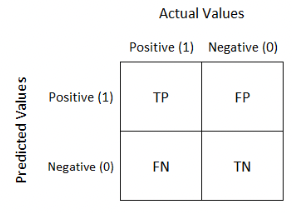

It follows the TP, TN, FP and FN computations.

In [ ]:
# counting rows for each case TP, TN, FP and FN respectively

n = df_prediction.count()
tp = df_prediction.filter(expr("prediction > 0") & expr("label == prediction")).count()
tn = df_prediction
fp = df_prediction
fn = n - tp - tn - fp
[tp, tn, fp, fn, n]

**Accuracy** = (TP + TN) / (TP + TN + FP + FN)

How often the classifier is correct? (score)

Metric widely used but not so useful when there are many TN cases.

In [ ]:
accuracy = (tp + tn) / (tp + tn + fp + fn)

**Precision** = TP / (TP + FP)

Positive predictive value - proportion of positive results that were correctly identified.

It removes NP and FN from consideration.

In [ ]:
precision = tp / (tp + fp)

**Recall** = TP / (TP + FN)

True positive rate. (hit rate, sensitivity)

In [ ]:
recall = tp / (tp + fn)

**Specifity** = TN / (TN + FP)

True negative rate. (selectivity)

In [ ]:
specifity = tn / (tn + fp)

**F1 score** = 2 * Recall * Precision / (Recall + Precision)

Useful metric because it is difficult to compare two models with low precision and high recall or vice versa. 
Indeed, by combining recall and precision it helps to measure them at once.


In [ ]:
f1_score = 2 * recall * precision / (recall + precision)

In [ ]:
# Confusion matrix conclusions

print("TP = {}, TN = {}, FP = {}, FN = {}, Total = {}".format(tp, tn, fp, fn, n)) 
print("Accuracy = {}".format(accuracy))
print("Precison = {}".format(precision))
print("Recall = {}".format(recall))
print("Specifity = {}".format(specifity))
print("F1 score = {}".format(f1_score))

## Visual analysis
Plotting `label` versus `prediction` obtained above.

In [ ]:
# plots

cols_to_plot = ["date", "label", "prediction"]
df_plot = df_prediction.select(cols_to_plot).limit(100000).toPandas()

In [ ]:
plotScatter(df_plot, "date", "prediction", "label")

## Back to business: the daily score


In [ ]:
# Compute the daily score,
# based on the trades made in that day, as  weight * resp

df_score = df_prediction.withColumn("score", expr("weight * resp * prediction")) 

gdf = df_score.groupBy(df_score.date)
df_daily_score = gdf.agg({"score": "sum"}).sort("date") 

trading_days = df_daily_score.count()
acumulative_score = df_daily_score.agg({"sum(score)": "sum"}).collect()[0][0]

df_daily_score.show()
print("For the {} trading days, the accumulative score is {}".format(trading_days, acumulative_score))

## Saving the pipeline

In [ ]:
# We can save the pipeline for further use should it be required

pipeline.save("pipeline-LinearSVM")

# later on, it can be loaded anywhere


In [ ]:
! ls -la

In [ ]:
! ls -la pipeline-LinearSVM

# Tune model

We should improve the model. For example, we can think about:
- How can we interpret the scores above?
- Could a model with different set of features and/or target engineering would perform better? 
- And what about using real-time data, that is, not training nor testing data?

See the exercise below.

# Additional exercise

Once this exercise has been completed, create a new notebook with similar implementation but using
the following classifiers instead:
1. Logistic Regression 
2. Decision Tree

Also, try to improve the process of feature/target engineering.

See related information in:
http://spark.apache.org/docs/latest/ml-classification-regression.html#logistic-regression (http://spark.apache.org/docs/latest/ml-classification-regression.html#logistic-regression)

http://spark.apache.org/docs/latest/ml-classification-regression.html#decision-tree-classifier (http://spark.apache.org/docs/latest/ml-classification-regression.html#decision-tree-classifier)

# References

* Learning Spark - Lightning-Fast Data Analytics, 2nd Ed. J. Damji, B. Wenig, T. Das, and D. Lee. O'Reilly, 2020
* Spark: The Definitive Guide - Big Data Processing Made Simple, 1st Ed. B. Chambers and M. Zaharia. O'Reilly, 2018
* http://spark.apache.org/docs/latest/ml-guide.html
* https://docs.python.org/3/ 
* https://www.kaggle.com/c/jane-street-market-prediction
